The TOV equations were solved for a wide range of intial conditions on an external server using the modularized version of the routine found on the repository with $\delta$=0.1. In this notebook the constructed models (found in the "results" folder) and the corresponding EOSs are going to be tested with the acceptability conditions.

Loading some libraries and settings

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker
import matplotlib as mpl
from scipy import integrate, interpolate
from Physical_Const import *
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('axes', labelsize=21)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('legend',fontsize= 14,markerscale=1.5)
plt.rcParams['axes.spines.right'] = True
plt.rcParams['axes.spines.top'] = True
mpl.rcParams['axes.linewidth'] = 1.0

# M-Rs

Generating the M-R diagram for each EOS

Listing the EOSs

In [2]:
owd=os.getcwd()
path=os.chdir('EOS')
EOSlist=[]
listOfEntries= os.scandir(path)
for entry in listOfEntries:
    if entry.path.endswith('dat'):
        EOSlist.append(entry.name)
os.chdir(owd)
EOSlist.sort()

Loading from file an plotting

EOS 			 Mmax 			 RMmax 			 rhocMmax
ALF1 			 1.49598600533 		 9.22109905262 		 3311311214830000.0
ALF2 			 2.0869729059 		 11.9617331635 		 1949844599760000.0
ALF3 			 1.47339638693 		 9.51449790962 		 3235936569300000.0
ALF4 			 1.94341179472 		 10.8916384152 		 2290867652770000.0
AP1 			 1.68393722338 		 8.29209711436 		 4168693834700000.0
AP2 			 1.80853601186 		 8.74610563793 		 3715352290970000.0
AP3 			 2.39107573735 		 10.7650761531 		 2344228815320000.0
AP4 			 2.21368205884 		 10.003991261 		 2754228703340000.0
BBB2 			 1.9201810841 		 9.51466671668 		 3162277660170000.0
BGN1H1 			 1.6303993635 		 9.32494995503 		 3801893963210000.0
BPAL12 			 1.4550178657 		 9.01475936916 		 3981071705530000.0
BSK19 			 1.86080728778 		 9.10985264012 		 3467368504530000.0
BSK20 			 2.16522199458 		 10.1735446108 		 2691534803930000.0
BSK21 			 2.27446893366 		 11.0379825175 		 2290867652770000.0
ENG 			 2.24081387561 		 10.4249594423 		 2570395782770000.0
FPS 			 1.80028008416 		 9.2791139704

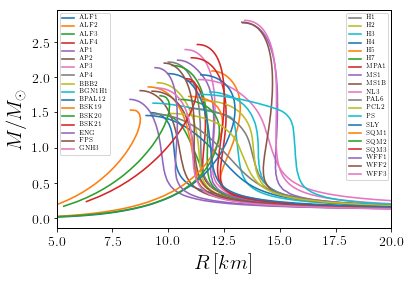

In [3]:
MR=[]
fig = plt.figure()
print('EOS','\t\t\t','Mmax','\t\t\t','RMmax','\t\t\t','rhocMmax')
for EOS in EOSlist:
    R,M,rhoc=np.loadtxt('results/'+EOS[:-4]+'/MRrhoc.dat',usecols=(0,1,2),unpack=True)
    maxi=np.argmax(M)+1
    pR=np.delete(R,np.s_[maxi:])
    pM=np.delete(M,np.s_[maxi:])
    prhoc=np.delete(rhoc,np.s_[maxi:])
    l=EOS[:-4]
    MR+=plt.plot(pR,pM,'-', linewidth=1.6,label=l)
    print(l.upper(),'\t\t\t',pM[-1],'\t\t',pR[-1],'\t\t',prhoc[-1])
plt.xlabel(r'$R\,[km]$')
plt.ylabel(r'$M/M_{\odot}$')
plt.xlim(5,20)
l1 = plt.legend(MR[:17], [label[:-4].upper() for label in EOSlist[:17]] , loc=2,prop={'size': 6})
l2 = plt.legend(MR[17:], [label[:-4].upper() for label in EOSlist[17:]] , loc=1,prop={'size': 6})
plt.gca().add_artist(l1)
plt.savefig('figures/MRrels.pdf', format='pdf', dpi=1000,bbox_inches="tight")


# A function to evaluate dynamical instability

The quantities needed to apply the adiabatic index stability criterion are

$$ \langle\gamma\rangle=\frac{\int_{0}^{R} e^{(\lambda+3 \nu) } \gamma(r) P(r) r^{2} d r}{\int_{0}^{R} e^{(\lambda+3 \nu) } P(r) r^{2} d r} $$

and

\begin{align}
    \gamma_{cr} = \frac{4}{3} +& \frac{1}{36} \frac{\int_{0}^{R} e^{\lambda+3 \mathrm{v}}\left[16 P+\left(e^{\lambda}-1\right)\left(P+\rho \right)\right]\left(e^{\lambda}-1\right) r^{2} d r}{\int_{0}^{R} e^{\lambda+3 \mathrm{v}} P r^{2} d r} \nonumber
    \\ &+ \frac{4 \pi}{9} \frac{\int_{0}^{R} e^{3( \lambda+ \mathrm{v})}\left[8 P+\left(e^{\lambda}+1\right)\left(P+\rho \right)\right] P r^{4} d r}{\int_{0}^{R} e^{\lambda+3 \mathrm{v}} P r^{2} d r}
    \\ & + \frac{16 \pi^{2} }{9} \frac{\int_{0}^{R} e^{5 \lambda+3 v }\left(P+\rho \right) P^{2} r^{6} d r}{\int_{0}^{R} e^{\lambda+3 v } P r^{2} d r}. \nonumber
\end{align}

The following function calculates them for a given EOS

In [2]:
def aindex_stab(EOS,k1=3,s1=0.0,k2=3,s2=0.0):
    # Listing the previously calculated models
    owd=os.getcwd()
    path=os.chdir('results/'+EOS)
    listOfEntries= os.scandir(path)
    models= []
    for entry in listOfEntries:
        if '1' in entry.name:
            models.append(entry.name)
    os.chdir(owd)
    models.sort()
    # Empty strings to save the
    gamma_efs = []
    gamma_crs = []
    rhosc= []
    betas=[]
    for model in models:
        m, P, rho, nu, lambd, r = np.loadtxt('results/'+ EOS +'/' + model ,unpack=True)
        nu = nu - nu[-1] + 0.5*np.log(1-2*m[-1]/r[-1])
        drho=interpolate.UnivariateSpline(r, rho, k=k1, s=s1).derivative(n=1)
        dP=interpolate.UnivariateSpline(r, P, k=k2, s=s2).derivative(n=1)
        gamma = ((rho+P)/P)*(dP(r)/drho(r))
        gamma_ef = integrate.trapz(np.exp(lambd+3*nu)*gamma*P*(r**2),r)/integrate.trapz(np.exp(lambd+3*nu)*P*(r**2),r)
        t1 = (4/9)*integrate.trapz(np.exp((lambd+3*nu))*(16*P+(np.exp(2*lambd)-1)*(P+rho))*(np.exp(2*lambd)-1)*(r**2),r)/integrate.trapz(np.exp(lambd+3*nu)*P*(r**2),r)
        t2 = (4*np.pi/9)*integrate.trapz(np.exp(3*lambd+3*nu)*(8*P + (np.exp(2*lambd)+1)*(P+rho))*P*(r**4),r)/integrate.trapz(np.exp(lambd+3*nu)*P*(r**2),r)
        t3 = ((16*np.pi**2)/9)*integrate.trapz(np.exp(5*lambd+3*nu)*(P+rho)*(P**2)*(r**6),r)/integrate.trapz(np.exp(lambd+3*nu)*P*(r**2),r)
        gamma_cr = 4/3 + t1 + t2 + t3
        gamma_efs.append(gamma_ef)
        gamma_crs.append(gamma_cr)
        betas.append(m[-1]/r[-1])
        rhosc.append(rho[0]*rhodim)
    return [rhosc,betas,gamma_efs,gamma_crs]

# ALF1 --------------------------------------------------------------------------------------------

In [15]:
rhoALF1,PALF1,nALF1=np.loadtxt('EOS/alf1.dat',usecols=(2,1,0),unpack=True)

## Dominant energy condition

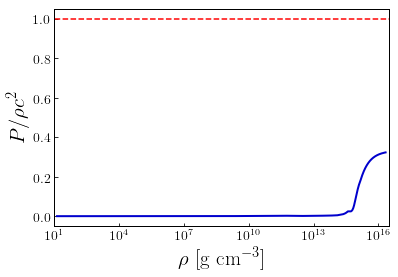

<Figure size 432x288 with 0 Axes>

In [16]:
fig, ax = plt.subplots()
plt.plot(nALF1,np.divide(PALF1,rhoALF1),lw='2',color='mediumblue')
plt.plot([0,10**(17)],[1.0,1.0],'r--',lw='1.5')

ax.set_xscale("log")
#locmaj = matplotlib.ticker.LogLocator(base=10.0,numticks=16) 
#ax.xaxis.set_major_locator(locmaj)


plt.xlabel(r'$\rho$ [g\,\,cm$^{-3}$]')
plt.ylabel(r'$ P / \rho c^2 $')
#locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks=16)
#ax.xaxis.set_minor_locator(locmin)
#ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.tick_params(axis="x", direction="in")
ax.tick_params(axis="y", direction="in")
plt.xlim(10,10**(16.5))
#ax.set_facecolor('floralwhite')
#plt.gca().set_aspect('equal', adjustable='box')
#plt.draw()
#plt.ylim(0,1)
plt.savefig('figures/ECALF1.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()
plt.clf()

## Speed of sound

In [17]:
vsquared=interpolate.UnivariateSpline(rhoALF1, PALF1, k=3, s=0).derivative(n=1)

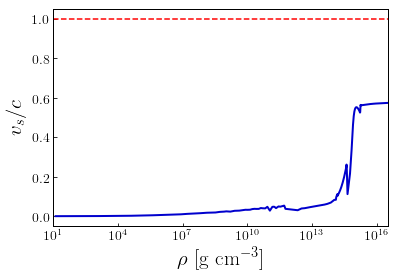

In [18]:
fig, ax = plt.subplots()
plt.plot(rhoALF1,np.sqrt(vsquared(rhoALF1)),lw='2.0',color='mediumblue')
plt.plot([1e+1,10**(16.5)],[1.0,1.0],'r--',lw='1.5')
plt.xlabel(r'$\rho$ [g\,\,cm$^{-3}$]')
plt.ylabel(r'$ v_s / c $')
plt.xscale('log')
ax.tick_params(axis="x", direction="in")
ax.tick_params(axis="y", direction="in")
plt.xlim(10,10**(16.5))
#ax.set_facecolor('floralwhite')
#mpl.rcParams['axes.linewidth'] = 1.4
#plt.gca().set_aspect('equal', adjustable='box')
#plt.draw()
plt.savefig('figures/SSALF1.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

## M - $\rho_c$

In [19]:
RALF1,MALF1,rhocALF1=np.loadtxt('results/alf1/MRrhoc.dat',usecols=(0,1,2),unpack=True)

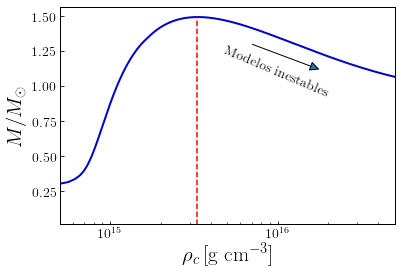

In [20]:
fig, ax = plt.subplots()

plt.plot(rhocALF1,MALF1,color='mediumblue',lw='2.0')
plt.plot([10**(np.log10(rhocALF1[np.argmax(MALF1)])),10**(np.log10(rhocALF1[np.argmax(MALF1)]))],[0.0,np.amax(MALF1)],'r--',lw='1.5')

prop = dict(arrowstyle="-|>,head_width=0.4,head_length=0.8",
            shrinkA=0,shrinkB=0)
plt.annotate("", xy=(10**(16.25),1.12), xytext=(10**(15.85),1.3), arrowprops=prop)
#plt.arrow(10**(15.6), 1.38,10**(15.7) ,-0.1 , head_width=0.05, head_length=10**(15))
plt.text(10**(15.67), 1.23, 'Modelos inestables' , fontsize=14,rotation=-23)

plt.xscale('log')
plt.xlabel(r'$\rho_c\,[$g cm$^{-3}]$')
plt.ylabel(r'$M/M_{\odot}$')
plt.xlim(left=10**(14.7),right=10**(16.7))
plt.ylim(bottom=0.01)
ax.tick_params(axis="x", direction="in",which='both')
ax.tick_params(axis="y", direction="in",which='both')

plt.savefig('figures/Mrhorel_ALF1.pdf', format='pdf', dpi=1000,bbox_inches="tight")

## Effective and critical adiabatic index

In [56]:
rhoscALF1,betasALF1,gamma_efsALF1,gamma_crsALF1 = aindex_stab('alf1')

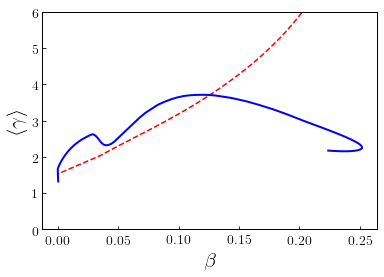

In [57]:
fig, ax = plt.subplots()
plt.plot(betasALF1,gamma_crsALF1,lw='1.5',color='r',linestyle='--',label=r'$\gamma_{cr}$')
#plt.plot([betacrit,betacrit],[0,5])
plt.plot(betasALF1,gamma_efsALF1,lw='2.0',color='blue',label=r'$\langle \gamma \rangle$')

plt.xlabel(r'$\beta$')
plt.ylabel(r'$\langle \gamma \rangle$')

#plt.xscale('log')
#plt.xlim(left=10**(14.7),right=10**(16.7))
plt.ylim(0,6)
ax.tick_params(axis="x", direction="in",which='both')
ax.tick_params(axis="y", direction="in",which='both')
#l = plt.legend(bbox_to_anchor=(0.85,-0.15), loc="lower right", 
                #bbox_transform=fig.transFigure, ncol=2)



plt.savefig('figures/AIndexStabALF1.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

## Tunning the interpolation of the solution

### 14.0

In [23]:
alf1_140=np.loadtxt('results/alf1/14.0.dat',unpack=True)
alf1_140[3] = alf1_140[3]-alf1_140[3][-1] + 0.5*np.log(1-2*alf1_140[0][-1]/alf1_140[-1][-1])

In [24]:
s1=5e-7
s2=1e-15
alf1_140rho=interpolate.UnivariateSpline(alf1_140[-1], alf1_140[2], k=5, s=s1)
alf1_140drho=interpolate.UnivariateSpline(alf1_140[-1], alf1_140[2], k=5, s=s1).derivative(n=1)
alf1_140ddrho=interpolate.UnivariateSpline(alf1_140[-1], alf1_140[2], k=5, s=s1).derivative(n=2)

alf1_140p=interpolate.UnivariateSpline(alf1_140[-1], alf1_140[1], k=5, s=s2)
alf1_140dp=interpolate.UnivariateSpline(alf1_140[-1], alf1_140[1], k=5, s=s2).derivative(n=1)
alf1_140ddp=interpolate.UnivariateSpline(alf1_140[-1], alf1_140[1], k=5, s=s2).derivative(n=2)

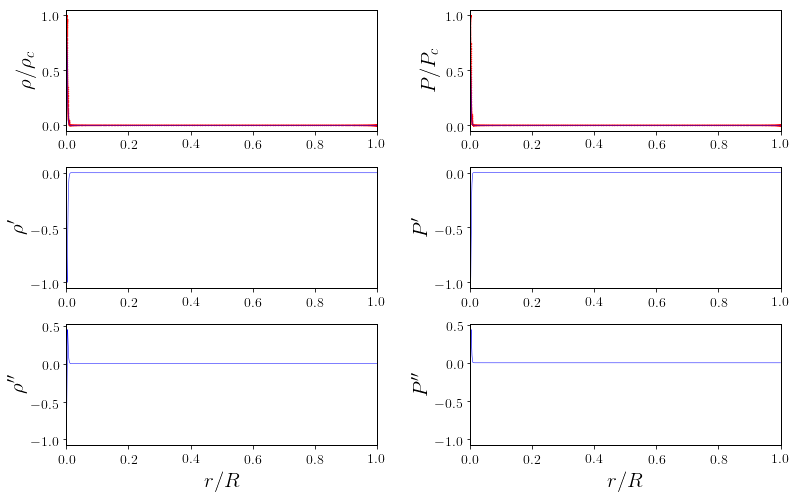

In [25]:
fig=plt.figure(figsize=[12.8,8])

plt.subplot(321)
plt.plot(alf1_140[-1]/alf1_140[-1][-1],alf1_140[2]/alf1_140[2][0],color='red',marker='o',markersize='0.4') 
plt.plot(alf1_140[-1]/alf1_140[-1][-1],alf1_140rho(alf1_140[-1])/alf1_140[2][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1) # leaving the crust out

plt.subplot(322)
plt.plot(alf1_140[-1]/alf1_140[-1][-1],alf1_140[1]/alf1_140[1][0],color='red',marker='o',markersize='0.4') 
plt.plot(alf1_140[-1]/alf1_140[-1][-1],alf1_140p(alf1_140[-1])/alf1_140[1][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$P/P_c$')
plt.xlim(0,1)

plt.subplot(323)
plt.plot(alf1_140[-1]/alf1_140[-1][-1],alf1_140drho(alf1_140[-1])/max(abs(alf1_140drho(alf1_140[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime}$')
plt.xlim(0,1)
#plt.ylim(-500,0)

plt.subplot(324)
plt.plot(alf1_140[-1]/alf1_140[-1][-1],alf1_140dp(alf1_140[-1])/max(abs(alf1_140dp(alf1_140[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime} $')
plt.xlim(0,1)

plt.subplot(325)
plt.plot(alf1_140[-1]/alf1_140[-1][-1],alf1_140ddrho(alf1_140[-1])/max(abs(alf1_140ddrho(alf1_140[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}$')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-0.01,0.01)

plt.subplot(326)
plt.plot(alf1_140[-1]/alf1_140[-1][-1],alf1_140ddp(alf1_140[-1])/max(abs(alf1_140ddp(alf1_140[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime\prime}$ ')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-1,1)

fig.subplots_adjust(hspace=0.3,wspace=0.3)

#plt.savefig('figures/ddsALF1_140.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

### 14.5

In [26]:
alf1_145=np.loadtxt('results/alf1/14.5.dat',unpack=True)
alf1_145[3] = alf1_145[3]-alf1_145[3][-1] + 0.5*np.log(1-2*alf1_145[0][-1]/alf1_145[-1][-1])

In [27]:
s1=1e-7
s2=1e-12
alf1_145rho=interpolate.UnivariateSpline(alf1_145[-1], alf1_145[2], k=5, s=s1)
alf1_145drho=interpolate.UnivariateSpline(alf1_145[-1], alf1_145[2], k=5, s=s1).derivative(n=1)
alf1_145ddrho=interpolate.UnivariateSpline(alf1_145[-1], alf1_145[2], k=5, s=s1).derivative(n=2)

alf1_145p=interpolate.UnivariateSpline(alf1_145[-1], alf1_145[1], k=5, s=s2)
alf1_145dp=interpolate.UnivariateSpline(alf1_145[-1], alf1_145[1], k=5, s=s2).derivative(n=1)
alf1_145ddp=interpolate.UnivariateSpline(alf1_145[-1], alf1_145[1], k=5, s=s2).derivative(n=2)

In [28]:
alf1_145rho(0.4*alf1_145[-1][-1])*rhodim

109516576167470.89

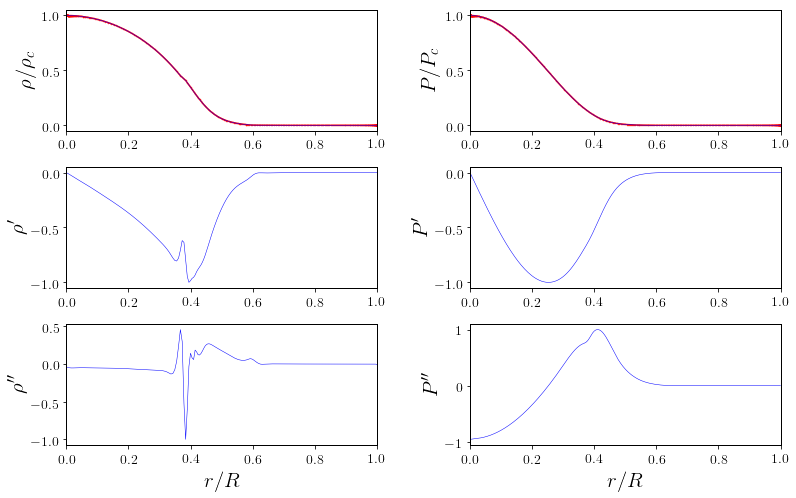

In [29]:
fig=plt.figure(figsize=[12.8,8])

plt.subplot(321)
plt.plot(alf1_145[-1]/alf1_145[-1][-1],alf1_145[2]/alf1_145[2][0],color='red',marker='o',markersize='0.4') 
plt.plot(alf1_145[-1]/alf1_145[-1][-1],alf1_145rho(alf1_145[-1])/alf1_145[2][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1) # leaving the crust out

plt.subplot(322)
plt.plot(alf1_145[-1]/alf1_145[-1][-1],alf1_145[1]/alf1_145[1][0],color='red',marker='o',markersize='0.4') 
plt.plot(alf1_145[-1]/alf1_145[-1][-1],alf1_145p(alf1_145[-1])/alf1_145[1][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$P/P_c$')
plt.xlim(0,1)

plt.subplot(323)
plt.plot(alf1_145[-1]/alf1_145[-1][-1],alf1_145drho(alf1_145[-1])/max(abs(alf1_145drho(alf1_145[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime}$')
plt.xlim(0,1)
#plt.ylim(-500,0)

plt.subplot(324)
plt.plot(alf1_145[-1]/alf1_145[-1][-1],alf1_145dp(alf1_145[-1])/max(abs(alf1_145dp(alf1_145[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime} $')
plt.xlim(0,1)

plt.subplot(325)
plt.plot(alf1_145[-1]/alf1_145[-1][-1],alf1_145ddrho(alf1_145[-1])/max(abs(alf1_145ddrho(alf1_145[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}$')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-0.01,0.01)

plt.subplot(326)
plt.plot(alf1_145[-1]/alf1_145[-1][-1],alf1_145ddp(alf1_145[-1])/max(abs(alf1_145ddp(alf1_145[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime\prime}$ ')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-1,1)

fig.subplots_adjust(hspace=0.3,wspace=0.3)

#plt.savefig('figures/ddsALF1_145.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

### 15.5

In [44]:
alf1_150=np.loadtxt('results/alf1/15.0.dat',unpack=True)
alf1_150[3] = alf1_150[3]-alf1_150[3][-1] + 0.5*np.log(1-2*alf1_150[0][-1]/alf1_150[-1][-1])

In [51]:
s1=1e-10
s2=1e-9
alf1_150rho=interpolate.UnivariateSpline(alf1_150[-1], alf1_150[2], k=5, s=s1)
alf1_150drho=interpolate.UnivariateSpline(alf1_150[-1], alf1_150[2], k=5, s=s1).derivative(n=1)
alf1_150ddrho=interpolate.UnivariateSpline(alf1_150[-1], alf1_150[2], k=5, s=s1).derivative(n=2)

alf1_150p=interpolate.UnivariateSpline(alf1_150[-1], alf1_150[1], k=5, s=s2)
alf1_150dp=interpolate.UnivariateSpline(alf1_150[-1], alf1_150[1], k=5, s=s2).derivative(n=1)
alf1_150ddp=interpolate.UnivariateSpline(alf1_150[-1], alf1_150[1], k=5, s=s2).derivative(n=2)

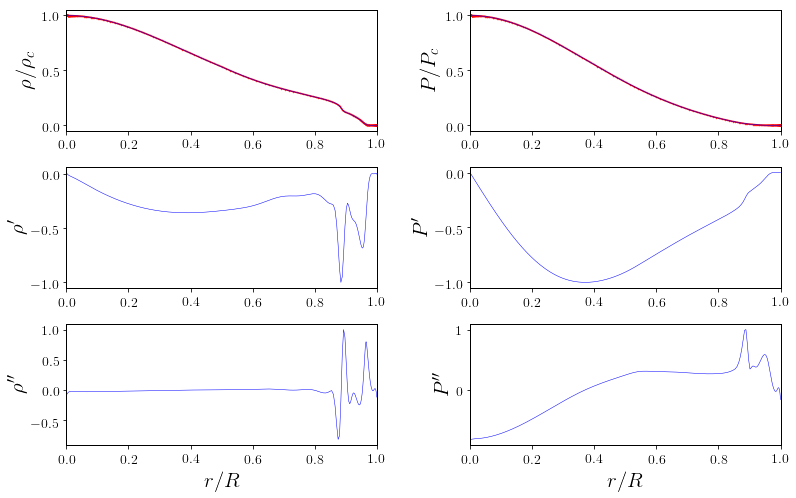

In [52]:
fig=plt.figure(figsize=[12.8,8])

plt.subplot(321)
plt.plot(alf1_155[-1]/alf1_155[-1][-1],alf1_155[2]/alf1_155[2][0],color='red',marker='o',markersize='0.4') 
plt.plot(alf1_155[-1]/alf1_155[-1][-1],alf1_155rho(alf1_155[-1])/alf1_155[2][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1) # leaving the crust out

plt.subplot(322)
plt.plot(alf1_155[-1]/alf1_155[-1][-1],alf1_155[1]/alf1_155[1][0],color='red',marker='o',markersize='0.4') 
plt.plot(alf1_155[-1]/alf1_155[-1][-1],alf1_155p(alf1_155[-1])/alf1_155[1][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$P/P_c$')
plt.xlim(0,1)

plt.subplot(323)
plt.plot(alf1_155[-1]/alf1_155[-1][-1],alf1_155drho(alf1_155[-1])/max(abs(alf1_155drho(alf1_155[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime}$')
plt.xlim(0,1)
#plt.ylim(-500,0)

plt.subplot(324)
plt.plot(alf1_155[-1]/alf1_155[-1][-1],alf1_155dp(alf1_155[-1])/max(abs(alf1_155dp(alf1_155[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime} $')
plt.xlim(0,1)

plt.subplot(325)
plt.plot(alf1_155[-1]/alf1_155[-1][-1],alf1_155ddrho(alf1_155[-1])/max(abs(alf1_155ddrho(alf1_155[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}$')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-0.01,0.01)

plt.subplot(326)
plt.plot(alf1_155[-1]/alf1_155[-1][-1],alf1_155ddp(alf1_155[-1])/max(abs(alf1_155ddp(alf1_155[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime\prime}$ ')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-1,1)

fig.subplots_adjust(hspace=0.3,wspace=0.3)

#plt.savefig('figures/ddsALF1_155.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

## Comparision

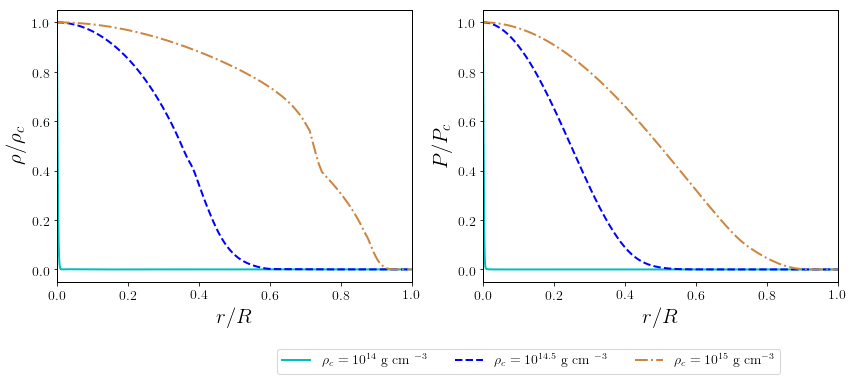

In [53]:
fig = plt.figure(figsize=[14,5])

plt.subplot(121)

plt.plot(alf1_140[-1]/alf1_140[-1][-1],alf1_140rho(alf1_140[-1])/alf1_140[2][0],color='c',linewidth='2.0',label=r'$\rho_c=10^{14}$ g cm $^{-3}$') 

plt.plot(alf1_145[-1]/alf1_145[-1][-1],alf1_145rho(alf1_145[-1])/alf1_145[2][0],color='blue',linewidth='2.0',linestyle='--',label=r'$\rho_c=10^{14.5}$ g cm $^{-3}$') 

plt.plot(alf1_150[-1]/alf1_150[-1][-1],alf1_150rho(alf1_150[-1])/alf1_150[2][0],color='peru',linewidth='2.0',linestyle='-.',label=r'$\rho_c=10^{15}$ g cm$ ^{-3}$')

#plt.plot(alf1_155[-1]/alf1_155[-1][-1],alf1_155rho(alf1_155[-1])/alf1_155[2][0],color='yellow',linewidth='2.0',linestyle='-.',label=r'$\rho_c=10^{15.5}$ g cm$ ^{-3}$')

plt.xlabel(r'$r/R$')
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1.0)


plt.subplot(122)

plt.plot(alf1_140[-1]/alf1_140[-1][-1],alf1_140p(alf1_140[-1])/alf1_140[1][0],color='c',linewidth='2.0',label=r'$\rho_c=10^{14}$ g cm $^{-3}$') 

plt.plot(alf1_145[-1]/alf1_145[-1][-1],alf1_145p(alf1_145[-1])/alf1_145[1][0],color='blue',linewidth='2.0',linestyle='--',label=r'$\rho_c=10^{14.5}$ g cm $^{-3}$') 

plt.plot(alf1_150[-1]/alf1_150[-1][-1],alf1_150p(alf1_150[-1])/alf1_150[1][0],color='peru',linewidth='2.0',linestyle='-.',label=r'$\rho_c=10^{15}$ g cm$ ^{-3}$')

#plt.plot(alf1_155[-1]/alf1_155[-1][-1],alf1_155p(alf1_155[-1])/alf1_155[1][0],color='yellow',linewidth='2.0',linestyle='-.',label=r'$\rho_c=10^{15.5}$ g cm$ ^{-3}$')




l = plt.legend(bbox_to_anchor=(0.85,-0.15), loc="lower right", 
                bbox_transform=fig.transFigure, ncol=4)

plt.xlabel(r'$r/R$')
plt.ylabel(r'$P/P_c$')
plt.xlim(0,1.0)


plt.savefig('figures/PandRhoALF1.pdf', format='pdf', dpi=1000,bbox_inches="tight")

## Adiabatic convection

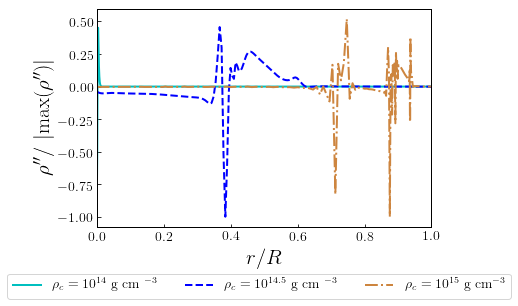

In [54]:
fig, ax = plt.subplots()

plt.plot(alf1_140[-1]/alf1_140[-1][-1],alf1_140ddrho(alf1_140[-1])/max(abs(alf1_140ddrho(alf1_140[-1]))),color='c',linewidth='2.0',label=r'$\rho_c=10^{14}$ g cm $^{-3}$') 
plt.plot(alf1_145[-1]/alf1_145[-1][-1],alf1_145ddrho(alf1_145[-1])/max(abs(alf1_145ddrho(alf1_145[-1]))),color='blue',linewidth='2.0',linestyle='--',label=r'$\rho_c=10^{14.5}$ g cm $^{-3}$') 
plt.plot(alf1_150[-1]/alf1_150[-1][-1],alf1_150ddrho(alf1_150[-1])/max(abs(alf1_150ddrho(alf1_150[-1]))),color='peru',linewidth='2.0',linestyle='-.',label=r'$\rho_c=10^{15}$ g cm$ ^{-3}$')

#plt.plot(alf1_155[-1]/alf1_155[-1][-1],alf1_155drho(alf1_155[-1])/max(abs(alf1_155drho(alf1_140[-1]))),color='yellow',linewidth='2.0',linestyle='-.',label=r'$\rho_c=10^{15.5}$ g cm$ ^{-3}$')

l = plt.legend(bbox_to_anchor=(1.1,-0.15), loc="lower right", 
                bbox_transform=fig.transFigure, ncol=3)

ax.tick_params(axis="x", direction="in")
ax.tick_params(axis="y", direction="in")

plt.xlabel(r'$r/R$')
plt.ylabel(r'$\rho^{\prime \prime}/$ $|$max$(\rho^{\prime \prime})|$')
plt.xlim(0,1.0)

plt.savefig('figures/ConvecStabilityALF1.pdf', format='pdf', dpi=1000,bbox_inches="tight")


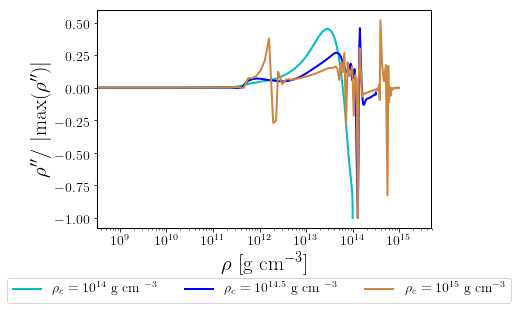

In [55]:
fig, ax = plt.subplots()

ax.set_xscale("log")

plt.plot(alf1_140[2]*rhodim,alf1_140ddrho(alf1_140[-1])/max(abs(alf1_140ddrho(alf1_140[-1]))),color='c',linewidth='2.0',label=r'$\rho_c=10^{14}$ g cm $^{-3}$') 
plt.plot(alf1_145[2]*rhodim,alf1_145ddrho(alf1_145[-1])/max(abs(alf1_145ddrho(alf1_145[-1]))),color='blue',linewidth='2.0',linestyle='-',label=r'$\rho_c=10^{14.5}$ g cm $^{-3}$') 
plt.plot(alf1_150[2]*rhodim,alf1_150ddrho(alf1_150[-1])/max(abs(alf1_150ddrho(alf1_150[-1]))),color='peru',linewidth='2.0',linestyle='-',label=r'$\rho_c=10^{15}$ g cm$ ^{-3}$')
plt.xlim(left=10**(8.5))
#plt.plot(alf1_155[-1]/alf1_155[-1][-1],alf1_155drho(alf1_155[-1])/max(abs(alf1_155drho(alf1_140[-1]))),color='yellow',linewidth='2.0',linestyle='-.',label=r'$\rho_c=10^{15.5}$ g cm$ ^{-3}$')

l = plt.legend(bbox_to_anchor=(1.1,-0.16), loc="lower right", 
                bbox_transform=fig.transFigure, ncol=3)

plt.xlabel(r'$\rho$ [g cm$^{-3}$]')
plt.ylabel(r'$\rho^{\prime \prime}/$ $|$max$(\rho^{\prime \prime})|$')
#plt.xlim(0,1.0)

plt.savefig('figures/ConvecStabilityALF1Correl.pdf', format='pdf', dpi=1000,bbox_inches="tight")

## Cracking

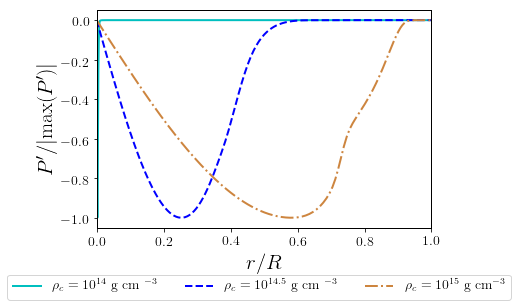

In [56]:
fig = plt.figure()

plt.plot(alf1_140[-1]/alf1_140[-1][-1],alf1_140dp(alf1_140[-1])/max(abs(alf1_140dp(alf1_140[-1]))),color='c',linewidth='2.0',label=r'$\rho_c=10^{14}$ g cm $^{-3}$') 
plt.plot(alf1_145[-1]/alf1_145[-1][-1],alf1_145dp(alf1_145[-1])/max(abs(alf1_145dp(alf1_145[-1]))),color='blue',linewidth='2.0',linestyle='--',label=r'$\rho_c=10^{14.5}$ g cm $^{-3}$') 
plt.plot(alf1_150[-1]/alf1_150[-1][-1],alf1_150dp(alf1_150[-1])/max(abs(alf1_150dp(alf1_150[-1]))),color='peru',linewidth='2.0',linestyle='-.',label=r'$\rho_c=10^{15}$ g cm$ ^{-3}$')

#plt.plot(alf1_155[-1]/alf1_155[-1][-1],alf1_155drho(alf1_155[-1])/max(abs(alf1_155drho(alf1_140[-1]))),color='yellow',linewidth='2.0',linestyle='-.',label=r'$\rho_c=10^{15.5}$ g cm$ ^{-3}$')

l = plt.legend(bbox_to_anchor=(1.1,-0.15), loc="lower right", 
                bbox_transform=fig.transFigure, ncol=3)

plt.xlabel(r'$r/R$')
plt.ylabel(r'$P^{\prime}/|$max$(P^{\prime})|$')
plt.xlim(0,1.0)

plt.savefig('figures/CrackStabilityALF1.pdf', format='pdf', dpi=1000,bbox_inches="tight")


## Redshift

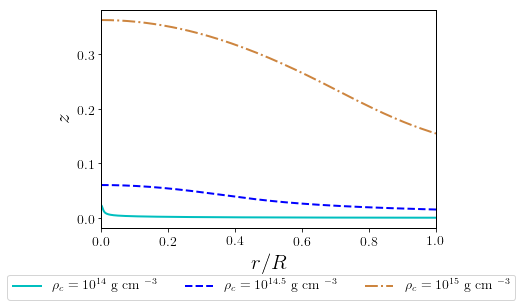

In [57]:
fig = plt.figure()

plt.plot(alf1_140[-1]/alf1_140[-1][-1],np.exp(-alf1_140[3])-1.0,color='c',linewidth='2.0',label=r'$\rho_c=10^{14}$ g cm $^{-3}$')
plt.plot(alf1_145[-1]/alf1_145[-1][-1],np.exp(-alf1_145[3])-1.0,color='blue',linewidth='2.0',linestyle='--',label=r'$\rho_c=10^{14.5}$ g cm $^{-3}$')
plt.plot(alf1_150[-1]/alf1_150[-1][-1],np.exp(-alf1_150[3])-1.0,color='peru',linewidth='2.0',linestyle='-.',label=r'$\rho_c=10^{15}$ g cm $^{-3}$')

l = plt.legend(bbox_to_anchor=(1.1,-0.15), loc="lower right", 
                bbox_transform=fig.transFigure, ncol=3)

plt.xlabel(r'$r/R$')
plt.ylabel(r'$z$')
plt.xlim(0,1.0)

plt.savefig('figures/RedshiftALF1.pdf', format='pdf', dpi=1000,bbox_inches="tight")

# ALF2 --------------------------------------------------------------------------------------

In [3]:
rhoALF2,PALF2,nALF2=np.loadtxt('EOS/alf2.dat',usecols=(2,1,0),unpack=True)

## Dominant energy condition

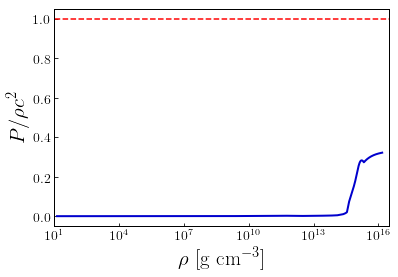

<Figure size 432x288 with 0 Axes>

In [4]:
fig, ax = plt.subplots()
plt.plot(nALF2,np.divide(PALF2,rhoALF2),lw='2',color='mediumblue')
plt.plot([0,10**(17)],[1.0,1.0],'r--',lw='1.5')

ax.set_xscale("log")
#locmaj = matplotlib.ticker.LogLocator(base=10.0,numticks=16) 
#ax.xaxis.set_major_locator(locmaj)


plt.xlabel(r'$\rho$ [g\,\,cm$^{-3}$]')
plt.ylabel(r'$ P / \rho c^2 $')
#locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks=16)
#ax.xaxis.set_minor_locator(locmin)
#ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.tick_params(axis="x", direction="in")
ax.tick_params(axis="y", direction="in")
plt.xlim(10,10**(16.5))
#ax.set_facecolor('floralwhite')
#plt.gca().set_aspect('equal', adjustable='box')
#plt.draw()
#plt.ylim(0,1)
plt.savefig('figures/ECALF2.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()
plt.clf()

## Speed of sound

In [36]:
vsquared=interpolate.UnivariateSpline(rhoALF2, PALF2, k=2, s=0).derivative(n=1)

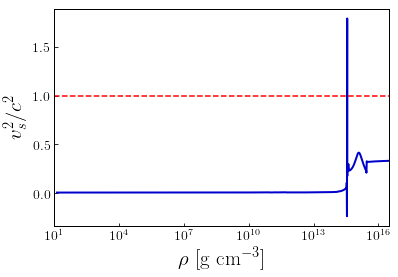

In [38]:
fig, ax = plt.subplots()
plt.plot(rhoALF2,vsquared(rhoALF2),lw='2.0',color='mediumblue')
plt.plot([1e+1,10**(16.5)],[1.0,1.0],'r--',lw='1.5')
plt.xlabel(r'$\rho$ [g\,\,cm$^{-3}$]')
plt.ylabel(r'$ v_s ^2 / c^2 $')
plt.xscale('log')
ax.tick_params(axis="x", direction="in")
ax.tick_params(axis="y", direction="in")
plt.xlim(10,10**(16.5))
#ax.set_facecolor('floralwhite')
#mpl.rcParams['axes.linewidth'] = 1.4
#plt.gca().set_aspect('equal', adjustable='box')
#plt.draw()
plt.savefig('figures/SSALF2.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

In this case the violation of causality seems to be caused by the numerical differentiation

## M - $\rho_c$

In [80]:
RALF2,MALF2,rhocALF2=np.loadtxt('results/alf2/MRrhoc.dat',usecols=(0,1,2),unpack=True)

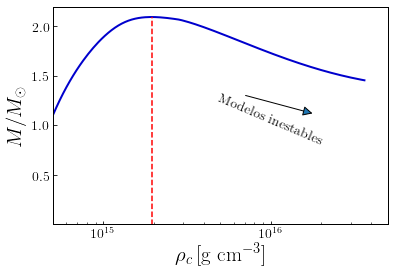

In [84]:
fig, ax = plt.subplots()

plt.plot(rhocALF2,MALF2,color='mediumblue',lw='2.0')
plt.plot([10**(np.log10(rhocALF2[np.argmax(MALF2)])),10**(np.log10(rhocALF2[np.argmax(MALF2)]))],[0.0,np.amax(MALF2)],'r--',lw='1.5')

prop = dict(arrowstyle="-|>,head_width=0.4,head_length=0.8",
            shrinkA=0,shrinkB=0)
plt.annotate("", xy=(10**(16.25),1.12), xytext=(10**(15.85),1.3), arrowprops=prop)
#plt.arrow(10**(15.6), 1.38,10**(15.7) ,-0.1 , head_width=0.05, head_length=10**(15))
plt.text(10**(15.67), 1.23, 'Modelos inestables' , fontsize=14,rotation=-23)

plt.xscale('log')
plt.xlabel(r'$\rho_c\,[$g cm$^{-3}]$')
plt.ylabel(r'$M/M_{\odot}$')
plt.xlim(left=10**(14.7),right=10**(16.7))
plt.ylim(bottom=0.01)
ax.tick_params(axis="x", direction="in",which='both')
ax.tick_params(axis="y", direction="in",which='both')

plt.savefig('figures/Mrhorel_ALF2.pdf', format='pdf', dpi=1000,bbox_inches="tight")

## Effective and critical adiabatic index

In [78]:
rhoscALF2,betasALF2,gamma_efsALF2,gamma_crsALF2 = aindex_stab('alf2',k1=3,s1=1.0,k2=3,s2=1.0)

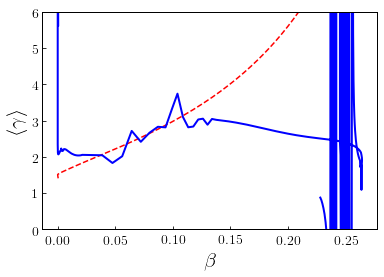

In [79]:
fig, ax = plt.subplots()
plt.plot(betasALF2,gamma_crsALF2,lw='1.5',color='r',linestyle='--',label=r'$\gamma_{cr}$')
#plt.plot([betacrit,betacrit],[0,5])
plt.plot(betasALF2,gamma_efsALF2,lw='2.0',color='blue',label=r'$\langle \gamma \rangle$')

plt.xlabel(r'$\beta$')
plt.ylabel(r'$\langle \gamma \rangle$')

#plt.xscale('log')
#plt.xlim(left=10**(14.7),right=10**(16.7))
plt.ylim(0,6)
ax.tick_params(axis="x", direction="in",which='both')
ax.tick_params(axis="y", direction="in",which='both')
#l = plt.legend(bbox_to_anchor=(0.85,-0.15), loc="lower right", 
                #bbox_transform=fig.transFigure, ncol=2)



plt.savefig('figures/AIndexStabALF2.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

Inconclusive, a more dense version of the EOS is probably needed in order to calculate the derivatives accurately

## Tunning the interpolation of the solution

### 14.0

In [90]:
alf2_140=np.loadtxt('results/alf2/14.0.dat',unpack=True)
alf2_140[3] = alf2_140[3]-alf2_140[3][-1] + 0.5*np.log(1-2*alf2_140[0][-1]/alf2_140[-1][-1])

In [91]:
s1=5e-7
s2=1e-15
alf2_140rho=interpolate.UnivariateSpline(alf2_140[-1], alf2_140[2], k=5, s=s1)
alf2_140drho=interpolate.UnivariateSpline(alf2_140[-1], alf2_140[2], k=5, s=s1).derivative(n=1)
alf2_140ddrho=interpolate.UnivariateSpline(alf2_140[-1], alf2_140[2], k=5, s=s1).derivative(n=2)

alf2_140p=interpolate.UnivariateSpline(alf2_140[-1], alf2_140[1], k=5, s=s2)
alf2_140dp=interpolate.UnivariateSpline(alf2_140[-1], alf2_140[1], k=5, s=s2).derivative(n=1)
alf2_140ddp=interpolate.UnivariateSpline(alf2_140[-1], alf2_140[1], k=5, s=s2).derivative(n=2)

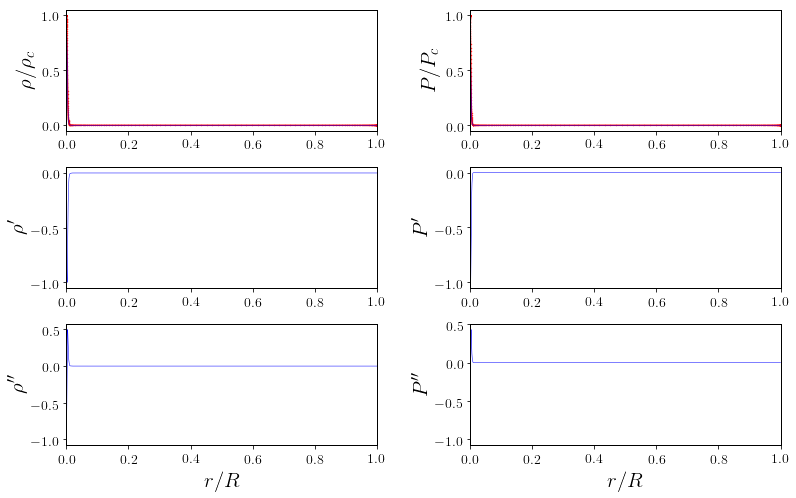

In [89]:
fig=plt.figure(figsize=[12.8,8])

plt.subplot(321)
plt.plot(alf2_140[-1]/alf2_140[-1][-1],alf2_140[2]/alf2_140[2][0],color='red',marker='o',markersize='0.4') 
plt.plot(alf2_140[-1]/alf2_140[-1][-1],alf2_140rho(alf2_140[-1])/alf2_140[2][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1) # leaving the crust out

plt.subplot(322)
plt.plot(alf2_140[-1]/alf2_140[-1][-1],alf2_140[1]/alf2_140[1][0],color='red',marker='o',markersize='0.4') 
plt.plot(alf2_140[-1]/alf2_140[-1][-1],alf2_140p(alf2_140[-1])/alf2_140[1][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$P/P_c$')
plt.xlim(0,1)

plt.subplot(323)
plt.plot(alf2_140[-1]/alf2_140[-1][-1],alf2_140drho(alf2_140[-1])/max(abs(alf2_140drho(alf2_140[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime}$')
plt.xlim(0,1)
#plt.ylim(-500,0)

plt.subplot(324)
plt.plot(alf2_140[-1]/alf2_140[-1][-1],alf2_140dp(alf2_140[-1])/max(abs(alf2_140dp(alf2_140[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime} $')
plt.xlim(0,1)

plt.subplot(325)
plt.plot(alf2_140[-1]/alf2_140[-1][-1],alf2_140ddrho(alf2_140[-1])/max(abs(alf2_140ddrho(alf2_140[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}$')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-0.01,0.01)

plt.subplot(326)
plt.plot(alf2_140[-1]/alf2_140[-1][-1],alf2_140ddp(alf2_140[-1])/max(abs(alf2_140ddp(alf2_140[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime\prime}$ ')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-1,1)

fig.subplots_adjust(hspace=0.3,wspace=0.3)

#plt.savefig('figures/ddsalf2_140.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

### 14.5

In [92]:
alf2_145=np.loadtxt('results/alf2/14.5.dat',unpack=True)
alf2_145[3] = alf2_145[3]-alf2_145[3][-1] + 0.5*np.log(1-2*alf2_145[0][-1]/alf2_145[-1][-1])

In [93]:
s1=1e-7
s2=1e-12
alf2_145rho=interpolate.UnivariateSpline(alf2_145[-1], alf2_145[2], k=5, s=s1)
alf2_145drho=interpolate.UnivariateSpline(alf2_145[-1], alf2_145[2], k=5, s=s1).derivative(n=1)
alf2_145ddrho=interpolate.UnivariateSpline(alf2_145[-1], alf2_145[2], k=5, s=s1).derivative(n=2)

alf2_145p=interpolate.UnivariateSpline(alf2_145[-1], alf2_145[1], k=5, s=s2)
alf2_145dp=interpolate.UnivariateSpline(alf2_145[-1], alf2_145[1], k=5, s=s2).derivative(n=1)
alf2_145ddp=interpolate.UnivariateSpline(alf2_145[-1], alf2_145[1], k=5, s=s2).derivative(n=2)

In [92]:
alf2_145rho(0.4*alf2_145[-1][-1])*rhodim

109585558044080.0

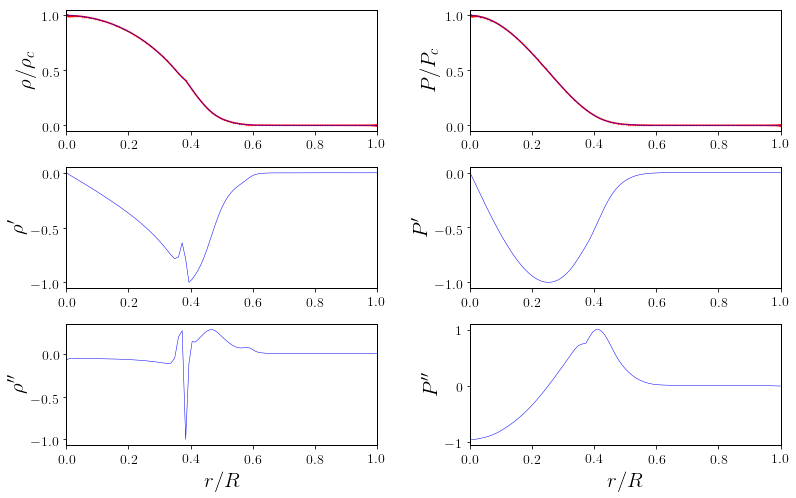

In [93]:
fig=plt.figure(figsize=[12.8,8])

plt.subplot(321)
plt.plot(alf2_145[-1]/alf2_145[-1][-1],alf2_145[2]/alf2_145[2][0],color='red',marker='o',markersize='0.4') 
plt.plot(alf2_145[-1]/alf2_145[-1][-1],alf2_145rho(alf2_145[-1])/alf2_145[2][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1) # leaving the crust out

plt.subplot(322)
plt.plot(alf2_145[-1]/alf2_145[-1][-1],alf2_145[1]/alf2_145[1][0],color='red',marker='o',markersize='0.4') 
plt.plot(alf2_145[-1]/alf2_145[-1][-1],alf2_145p(alf2_145[-1])/alf2_145[1][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$P/P_c$')
plt.xlim(0,1)

plt.subplot(323)
plt.plot(alf2_145[-1]/alf2_145[-1][-1],alf2_145drho(alf2_145[-1])/max(abs(alf2_145drho(alf2_145[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime}$')
plt.xlim(0,1)
#plt.ylim(-500,0)

plt.subplot(324)
plt.plot(alf2_145[-1]/alf2_145[-1][-1],alf2_145dp(alf2_145[-1])/max(abs(alf2_145dp(alf2_145[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime} $')
plt.xlim(0,1)

plt.subplot(325)
plt.plot(alf2_145[-1]/alf2_145[-1][-1],alf2_145ddrho(alf2_145[-1])/max(abs(alf2_145ddrho(alf2_145[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}$')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-0.01,0.01)

plt.subplot(326)
plt.plot(alf2_145[-1]/alf2_145[-1][-1],alf2_145ddp(alf2_145[-1])/max(abs(alf2_145ddp(alf2_145[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime\prime}$ ')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-1,1)

fig.subplots_adjust(hspace=0.3,wspace=0.3)

#plt.savefig('figures/ddsalf2_145.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

### 15.0

In [94]:
alf2_150=np.loadtxt('results/alf2/15.0.dat',unpack=True)
alf2_150[3] = alf2_150[3]-alf2_150[3][-1] + 0.5*np.log(1-2*alf2_150[0][-1]/alf2_150[-1][-1])

In [95]:
s1=8e-6
s2=1e-15
alf2_150rho=interpolate.UnivariateSpline(alf2_150[-1], alf2_150[2], k=5, s=s1)
alf2_150drho=interpolate.UnivariateSpline(alf2_150[-1], alf2_150[2], k=5, s=s1).derivative(n=1)
alf2_150ddrho=interpolate.UnivariateSpline(alf2_150[-1], alf2_150[2], k=5, s=s1).derivative(n=2)

alf2_150p=interpolate.UnivariateSpline(alf2_150[-1], alf2_150[1], k=5, s=s2)
alf2_150dp=interpolate.UnivariateSpline(alf2_150[-1], alf2_150[1], k=5, s=s2).derivative(n=1)
alf2_150ddp=interpolate.UnivariateSpline(alf2_150[-1], alf2_150[1], k=5, s=s2).derivative(n=2)

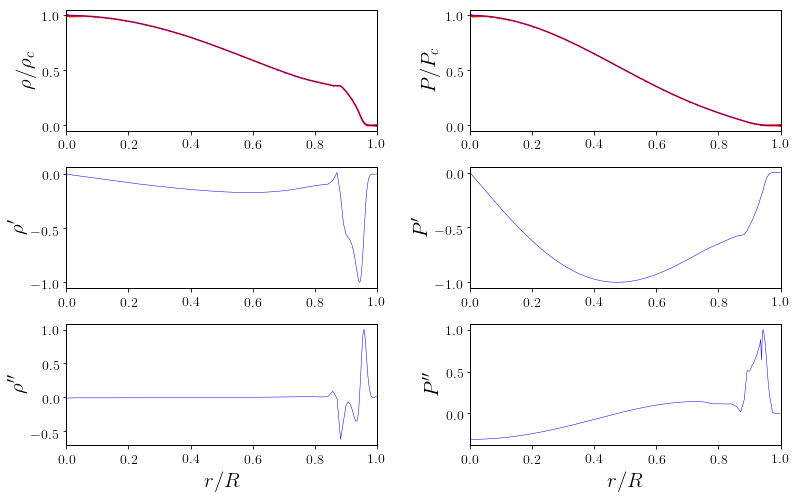

In [96]:
fig=plt.figure(figsize=[12.8,8])

plt.subplot(321)
plt.plot(alf2_150[-1]/alf2_150[-1][-1],alf2_150[2]/alf2_150[2][0],color='red',marker='o',markersize='0.4') 
plt.plot(alf2_150[-1]/alf2_150[-1][-1],alf2_150rho(alf2_150[-1])/alf2_150[2][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1) # leaving the crust out

plt.subplot(322)
plt.plot(alf2_150[-1]/alf2_150[-1][-1],alf2_150[1]/alf2_150[1][0],color='red',marker='o',markersize='0.4') 
plt.plot(alf2_150[-1]/alf2_150[-1][-1],alf2_150p(alf2_150[-1])/alf2_150[1][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$P/P_c$')
plt.xlim(0,1)

plt.subplot(323)
plt.plot(alf2_150[-1]/alf2_150[-1][-1],alf2_150drho(alf2_150[-1])/max(abs(alf2_150drho(alf2_150[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime}$')
plt.xlim(0,1)
#plt.ylim(-500,0)

plt.subplot(324)
plt.plot(alf2_150[-1]/alf2_150[-1][-1],alf2_150dp(alf2_150[-1])/max(abs(alf2_150dp(alf2_150[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime} $')
plt.xlim(0,1)

plt.subplot(325)
plt.plot(alf2_150[-1]/alf2_150[-1][-1],alf2_150ddrho(alf2_150[-1])/max(abs(alf2_150ddrho(alf2_150[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}$')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-0.01,0.01)

plt.subplot(326)
plt.plot(alf2_150[-1]/alf2_150[-1][-1],alf2_150ddp(alf2_150[-1])/max(abs(alf2_150ddp(alf2_150[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime\prime}$ ')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-1,1)

fig.subplots_adjust(hspace=0.3,wspace=0.3)

#plt.savefig('figures/ddsalf2_150.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

### 15.5

In [96]:
alf2_155=np.loadtxt('results/alf2/15.5.dat',unpack=True)
alf2_155[3] = alf2_155[3]-alf2_155[3][-1] + 0.5*np.log(1-2*alf2_155[0][-1]/alf2_155[-1][-1])

In [97]:
s1=1e-6
s2=1e-9
alf2_155rho=interpolate.UnivariateSpline(alf2_155[-1], alf2_155[2], k=5, s=s1)
alf2_155drho=interpolate.UnivariateSpline(alf2_155[-1], alf2_155[2], k=5, s=s1).derivative(n=1)
alf2_155ddrho=interpolate.UnivariateSpline(alf2_155[-1], alf2_155[2], k=5, s=s1).derivative(n=2)

alf2_155p=interpolate.UnivariateSpline(alf2_155[-1], alf2_155[1], k=5, s=s2)
alf2_155dp=interpolate.UnivariateSpline(alf2_155[-1], alf2_155[1], k=5, s=s2).derivative(n=1)
alf2_155ddp=interpolate.UnivariateSpline(alf2_155[-1], alf2_155[1], k=5, s=s2).derivative(n=2)

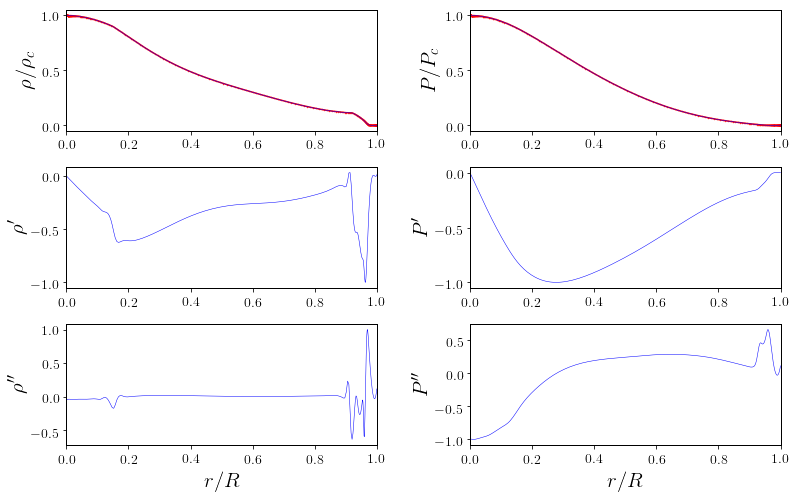

In [99]:
fig=plt.figure(figsize=[12.8,8])

plt.subplot(321)
plt.plot(alf2_155[-1]/alf2_155[-1][-1],alf2_155[2]/alf2_155[2][0],color='red',marker='o',markersize='0.4') 
plt.plot(alf2_155[-1]/alf2_155[-1][-1],alf2_155rho(alf2_155[-1])/alf2_155[2][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1) # leaving the crust out

plt.subplot(322)
plt.plot(alf2_155[-1]/alf2_155[-1][-1],alf2_155[1]/alf2_155[1][0],color='red',marker='o',markersize='0.4') 
plt.plot(alf2_155[-1]/alf2_155[-1][-1],alf2_155p(alf2_155[-1])/alf2_155[1][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$P/P_c$')
plt.xlim(0,1)

plt.subplot(323)
plt.plot(alf2_155[-1]/alf2_155[-1][-1],alf2_155drho(alf2_155[-1])/max(abs(alf2_155drho(alf2_155[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime}$')
plt.xlim(0,1)
#plt.ylim(-500,0)

plt.subplot(324)
plt.plot(alf2_155[-1]/alf2_155[-1][-1],alf2_155dp(alf2_155[-1])/max(abs(alf2_155dp(alf2_155[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime} $')
plt.xlim(0,1)

plt.subplot(325)
plt.plot(alf2_155[-1]/alf2_155[-1][-1],alf2_155ddrho(alf2_155[-1])/max(abs(alf2_155ddrho(alf2_155[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}$')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-0.01,0.01)

plt.subplot(326)
plt.plot(alf2_155[-1]/alf2_155[-1][-1],alf2_155ddp(alf2_155[-1])/max(abs(alf2_155ddp(alf2_155[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime\prime}$ ')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-1,1)

fig.subplots_adjust(hspace=0.3,wspace=0.3)

#plt.savefig('figures/ddsalf2_155.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

## Adiabatic convection

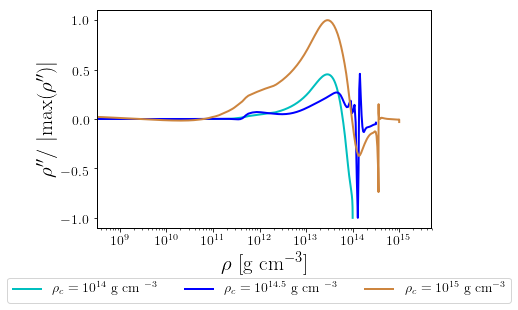

In [98]:
fig, ax = plt.subplots()

ax.set_xscale("log")

plt.plot(alf2_140[2]*rhodim,alf2_140ddrho(alf2_140[-1])/max(abs(alf2_140ddrho(alf2_140[-1]))),color='c',linewidth='2.0',label=r'$\rho_c=10^{14}$ g cm $^{-3}$') 
plt.plot(alf2_145[2]*rhodim,alf2_145ddrho(alf2_145[-1])/max(abs(alf2_145ddrho(alf2_145[-1]))),color='blue',linewidth='2.0',linestyle='-',label=r'$\rho_c=10^{14.5}$ g cm $^{-3}$') 
plt.plot(alf2_150[2]*rhodim,alf2_150ddrho(alf2_150[-1])/max(abs(alf2_150ddrho(alf2_150[-1]))),color='peru',linewidth='2.0',linestyle='-',label=r'$\rho_c=10^{15}$ g cm$ ^{-3}$')
plt.xlim(left=10**(8.5))
#plt.plot(alf2_155[-1]/alf2_155[-1][-1],alf2_155drho(alf2_155[-1])/max(abs(alf2_155drho(alf2_140[-1]))),color='yellow',linewidth='2.0',linestyle='-.',label=r'$\rho_c=10^{15.5}$ g cm$ ^{-3}$')

l = plt.legend(bbox_to_anchor=(1.1,-0.16), loc="lower right", 
                bbox_transform=fig.transFigure, ncol=3)

plt.xlabel(r'$\rho$ [g cm$^{-3}$]')
plt.ylabel(r'$\rho^{\prime \prime}/$ $|$max$(\rho^{\prime \prime})|$')
#plt.xlim(0,1.0)

plt.savefig('figures/ConvecStabilityalf2Correl.pdf', format='pdf', dpi=1000,bbox_inches="tight")

## Redshift

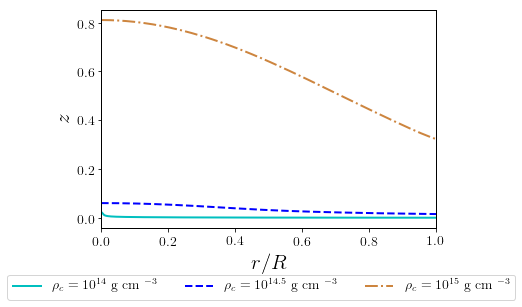

In [129]:
fig = plt.figure()

plt.plot(ALF2_140[-1]/ALF2_140[-1][-1],np.exp(-ALF2_140[3])-1.0,color='c',linewidth='2.0',label=r'$\rho_c=10^{14}$ g cm $^{-3}$')
plt.plot(ALF2_145[-1]/ALF2_145[-1][-1],np.exp(-ALF2_145[3])-1.0,color='blue',linewidth='2.0',linestyle='--',label=r'$\rho_c=10^{14.5}$ g cm $^{-3}$')
plt.plot(ALF2_150[-1]/ALF2_150[-1][-1],np.exp(-ALF2_150[3])-1.0,color='peru',linewidth='2.0',linestyle='-.',label=r'$\rho_c=10^{15}$ g cm $^{-3}$')

l = plt.legend(bbox_to_anchor=(1.1,-0.15), loc="lower right", 
                bbox_transform=fig.transFigure, ncol=3)

plt.xlabel(r'$r/R$')
plt.ylabel(r'$z$')
plt.xlim(0,1.0)

plt.savefig('figures/RedshiftALF2.pdf', format='pdf', dpi=1000,bbox_inches="tight")

# ALF3 --------------------------------------------------------------------------------------

In [130]:
rhoALF3,PALF3,nALF3=np.loadtxt('EOS/alf3.dat',usecols=(2,1,0),unpack=True)

## Dominant energy condition

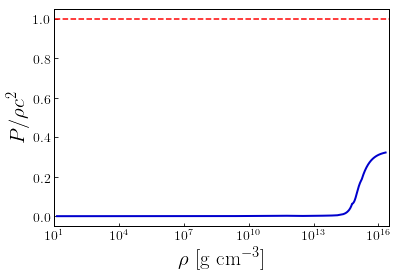

<Figure size 432x288 with 0 Axes>

In [101]:
fig, ax = plt.subplots()
plt.plot(nALF3,np.divide(PALF3,rhoALF3),lw='2',color='mediumblue')
plt.plot([0,10**(17)],[1.0,1.0],'r--',lw='1.5')

ax.set_xscale("log")
#locmaj = matplotlib.ticker.LogLocator(base=10.0,numticks=16) 
#ax.xaxis.set_major_locator(locmaj)


plt.xlabel(r'$\rho$ [g\,\,cm$^{-3}$]')
plt.ylabel(r'$ P / \rho c^2 $')
#locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks=16)
#ax.xaxis.set_minor_locator(locmin)
#ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.tick_params(axis="x", direction="in")
ax.tick_params(axis="y", direction="in")
plt.xlim(10,10**(16.5))
#ax.set_facecolor('floralwhite')
#plt.gca().set_aspect('equal', adjustable='box')
#plt.draw()
#plt.ylim(0,1)
plt.savefig('figures/ECALF3.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()
plt.clf()

## Speed of sound

In [133]:
vsquared=interpolate.UnivariateSpline(rhoALF3, PALF3, k=3, s=0).derivative(n=1)

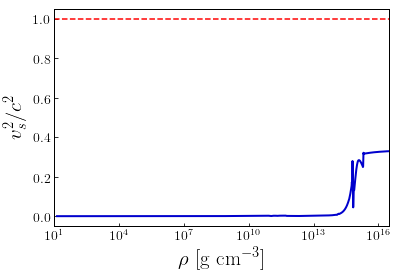

In [134]:
fig, ax = plt.subplots()
plt.plot(rhoALF3,vsquared(rhoALF3),lw='2.0',color='mediumblue')
plt.plot([1e+1,10**(16.5)],[1.0,1.0],'r--',lw='1.5')
plt.xlabel(r'$\rho$ [g\,\,cm$^{-3}$]')
plt.ylabel(r'$ v_s^2 / c^2 $')
plt.xscale('log')
ax.tick_params(axis="x", direction="in")
ax.tick_params(axis="y", direction="in")
plt.xlim(10,10**(16.5))
#ax.set_facecolor('floralwhite')
#mpl.rcParams['axes.linewidth'] = 1.4
#plt.gca().set_aspect('equal', adjustable='box')
#plt.draw()
plt.savefig('figures/SSALF3.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

## M - $\rho_c$

In [124]:
RALF3,MALF3,rhocALF3=np.loadtxt('results/alf3/MRrhoc.dat',usecols=(0,1,2),unpack=True)

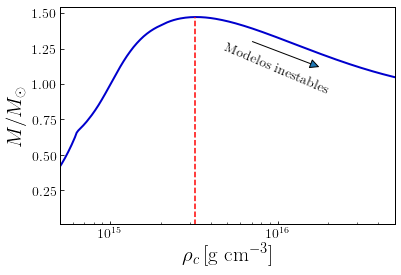

In [128]:
fig, ax = plt.subplots()

plt.plot(rhocALF3,MALF3,color='mediumblue',lw='2.0')
plt.plot([10**(np.log10(rhocALF3[np.argmax(MALF3)])),10**(np.log10(rhocALF3[np.argmax(MALF3)]))],[0.0,np.amax(MALF3)],'r--',lw='1.5')

prop = dict(arrowstyle="-|>,head_width=0.4,head_length=0.8",
            shrinkA=0,shrinkB=0)
plt.annotate("", xy=(10**(16.25),1.12), xytext=(10**(15.85),1.3), arrowprops=prop)
#plt.arrow(10**(15.6), 1.38,10**(15.7) ,-0.1 , head_width=0.05, head_length=10**(15))
plt.text(10**(15.67), 1.23, 'Modelos inestables' , fontsize=14,rotation=-23)

plt.xscale('log')
plt.xlabel(r'$\rho_c\,[$g cm$^{-3}]$')
plt.ylabel(r'$M/M_{\odot}$')
plt.xlim(left=10**(14.7),right=10**(16.7))
plt.ylim(bottom=0.01)
ax.tick_params(axis="x", direction="in",which='both')
ax.tick_params(axis="y", direction="in",which='both')

plt.savefig('figures/Mrhorel_ALF3.pdf', format='pdf', dpi=1000,bbox_inches="tight")

## Effective and critical adiabatic index

In [116]:
rhoscALF3,betasALF3,gamma_efsALF3,gamma_crsALF3 = aindex_stab('alf3')

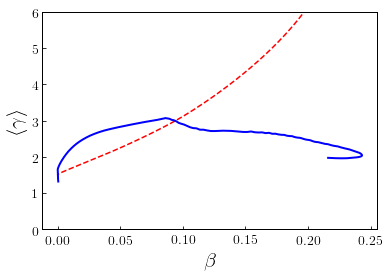

In [117]:
fig, ax = plt.subplots()
plt.plot(betasALF3,gamma_crsALF3,lw='1.5',color='r',linestyle='--',label=r'$\gamma_{cr}$')
#plt.plot([betacrit,betacrit],[0,5])
plt.plot(betasALF3,gamma_efsALF3,lw='2.0',color='blue',label=r'$\langle \gamma \rangle$')

plt.xlabel(r'$\beta$')
plt.ylabel(r'$\langle \gamma \rangle$')

#plt.xscale('log')
#plt.xlim(left=10**(14.7),right=10**(16.7))
plt.ylim(0,6)
ax.tick_params(axis="x", direction="in",which='both')
ax.tick_params(axis="y", direction="in",which='both')
#l = plt.legend(bbox_to_anchor=(0.85,-0.15), loc="lower right", 
                #bbox_transform=fig.transFigure, ncol=2)



plt.savefig('figures/AIndexStabALF3.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

## Tunning the interpolation of the solution

### 14.0

In [99]:
alf3_140=np.loadtxt('results/alf3/14.0.dat',unpack=True)
alf3_140[3] = alf3_140[3]-alf3_140[3][-1] + 0.5*np.log(1-2*alf3_140[0][-1]/alf3_140[-1][-1])

In [100]:
s1=5e-7
s2=1e-15
alf3_140rho=interpolate.UnivariateSpline(alf3_140[-1], alf3_140[2], k=5, s=s1)
alf3_140drho=interpolate.UnivariateSpline(alf3_140[-1], alf3_140[2], k=5, s=s1).derivative(n=1)
alf3_140ddrho=interpolate.UnivariateSpline(alf3_140[-1], alf3_140[2], k=5, s=s1).derivative(n=2)

alf3_140p=interpolate.UnivariateSpline(alf3_140[-1], alf3_140[1], k=5, s=s2)
alf3_140dp=interpolate.UnivariateSpline(alf3_140[-1], alf3_140[1], k=5, s=s2).derivative(n=1)
alf3_140ddp=interpolate.UnivariateSpline(alf3_140[-1], alf3_140[1], k=5, s=s2).derivative(n=2)

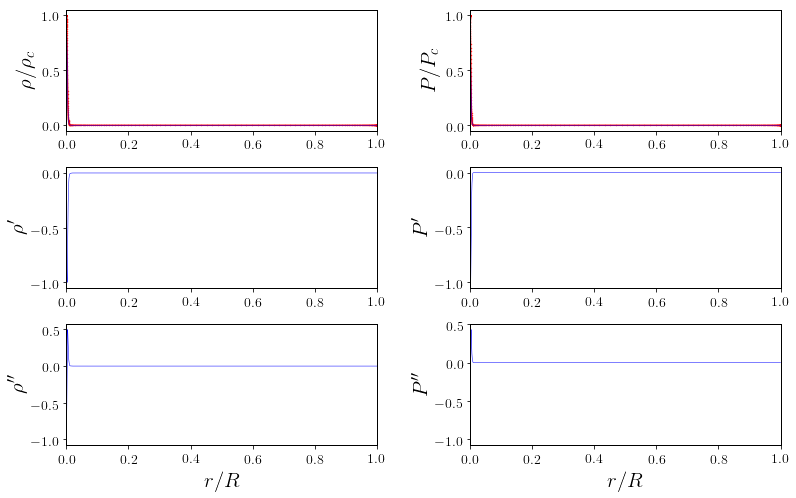

In [137]:
fig=plt.figure(figsize=[12.8,8])

plt.subplot(321)
plt.plot(alf3_140[-1]/alf3_140[-1][-1],alf3_140[2]/alf3_140[2][0],color='red',marker='o',markersize='0.4') 
plt.plot(alf3_140[-1]/alf3_140[-1][-1],alf3_140rho(alf3_140[-1])/alf3_140[2][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1) # leaving the crust out

plt.subplot(322)
plt.plot(alf3_140[-1]/alf3_140[-1][-1],alf3_140[1]/alf3_140[1][0],color='red',marker='o',markersize='0.4') 
plt.plot(alf3_140[-1]/alf3_140[-1][-1],alf3_140p(alf3_140[-1])/alf3_140[1][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$P/P_c$')
plt.xlim(0,1)

plt.subplot(323)
plt.plot(alf3_140[-1]/alf3_140[-1][-1],alf3_140drho(alf3_140[-1])/max(abs(alf3_140drho(alf3_140[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime}$')
plt.xlim(0,1)
#plt.ylim(-500,0)

plt.subplot(324)
plt.plot(alf3_140[-1]/alf3_140[-1][-1],alf3_140dp(alf3_140[-1])/max(abs(alf3_140dp(alf3_140[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime} $')
plt.xlim(0,1)

plt.subplot(325)
plt.plot(alf3_140[-1]/alf3_140[-1][-1],alf3_140ddrho(alf3_140[-1])/max(abs(alf3_140ddrho(alf3_140[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}$')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-0.01,0.01)

plt.subplot(326)
plt.plot(alf3_140[-1]/alf3_140[-1][-1],alf3_140ddp(alf3_140[-1])/max(abs(alf3_140ddp(alf3_140[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime\prime}$ ')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-1,1)

fig.subplots_adjust(hspace=0.3,wspace=0.3)

#plt.savefig('figures/ddsalf3_140.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

### 14.5

In [101]:
alf3_145=np.loadtxt('results/alf3/14.5.dat',unpack=True)
alf3_145[3] = alf3_145[3]-alf3_145[3][-1] + 0.5*np.log(1-2*alf3_145[0][-1]/alf3_145[-1][-1])

In [102]:
s1=1e-7
s2=1e-12
alf3_145rho=interpolate.UnivariateSpline(alf3_145[-1], alf3_145[2], k=5, s=s1)
alf3_145drho=interpolate.UnivariateSpline(alf3_145[-1], alf3_145[2], k=5, s=s1).derivative(n=1)
alf3_145ddrho=interpolate.UnivariateSpline(alf3_145[-1], alf3_145[2], k=5, s=s1).derivative(n=2)

alf3_145p=interpolate.UnivariateSpline(alf3_145[-1], alf3_145[1], k=5, s=s2)
alf3_145dp=interpolate.UnivariateSpline(alf3_145[-1], alf3_145[1], k=5, s=s2).derivative(n=1)
alf3_145ddp=interpolate.UnivariateSpline(alf3_145[-1], alf3_145[1], k=5, s=s2).derivative(n=2)

In [140]:
alf3_145rho(0.4*alf3_145[-1][-1])*rhodim

109554947563999.22

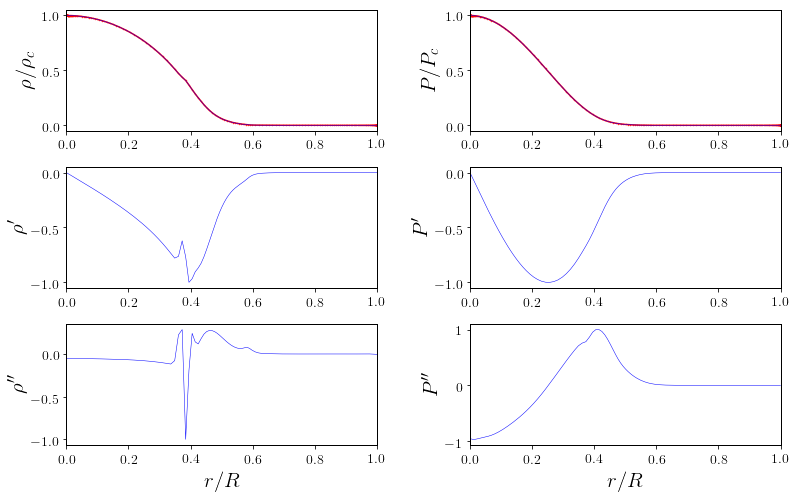

In [141]:
fig=plt.figure(figsize=[12.8,8])

plt.subplot(321)
plt.plot(alf3_145[-1]/alf3_145[-1][-1],alf3_145[2]/alf3_145[2][0],color='red',marker='o',markersize='0.4') 
plt.plot(alf3_145[-1]/alf3_145[-1][-1],alf3_145rho(alf3_145[-1])/alf3_145[2][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1) # leaving the crust out

plt.subplot(322)
plt.plot(alf3_145[-1]/alf3_145[-1][-1],alf3_145[1]/alf3_145[1][0],color='red',marker='o',markersize='0.4') 
plt.plot(alf3_145[-1]/alf3_145[-1][-1],alf3_145p(alf3_145[-1])/alf3_145[1][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$P/P_c$')
plt.xlim(0,1)

plt.subplot(323)
plt.plot(alf3_145[-1]/alf3_145[-1][-1],alf3_145drho(alf3_145[-1])/max(abs(alf3_145drho(alf3_145[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime}$')
plt.xlim(0,1)
#plt.ylim(-500,0)

plt.subplot(324)
plt.plot(alf3_145[-1]/alf3_145[-1][-1],alf3_145dp(alf3_145[-1])/max(abs(alf3_145dp(alf3_145[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime} $')
plt.xlim(0,1)

plt.subplot(325)
plt.plot(alf3_145[-1]/alf3_145[-1][-1],alf3_145ddrho(alf3_145[-1])/max(abs(alf3_145ddrho(alf3_145[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}$')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-0.01,0.01)

plt.subplot(326)
plt.plot(alf3_145[-1]/alf3_145[-1][-1],alf3_145ddp(alf3_145[-1])/max(abs(alf3_145ddp(alf3_145[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime\prime}$ ')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-1,1)

fig.subplots_adjust(hspace=0.3,wspace=0.3)

#plt.savefig('figures/ddsalf3_145.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

### 15.0

In [103]:
alf3_150=np.loadtxt('results/alf3/15.0.dat',unpack=True)
alf3_150[3] = alf3_150[3]-alf3_150[3][-1] + 0.5*np.log(1-2*alf3_150[0][-1]/alf3_150[-1][-1])

In [110]:
s1=1e-6
s2=1e-15
alf3_150rho=interpolate.UnivariateSpline(alf3_150[-1], alf3_150[2], k=5, s=s1)
alf3_150drho=interpolate.UnivariateSpline(alf3_150[-1], alf3_150[2], k=5, s=s1).derivative(n=1)
alf3_150ddrho=interpolate.UnivariateSpline(alf3_150[-1], alf3_150[2], k=5, s=s1).derivative(n=2)

alf3_150p=interpolate.UnivariateSpline(alf3_150[-1], alf3_150[1], k=5, s=s2)
alf3_150dp=interpolate.UnivariateSpline(alf3_150[-1], alf3_150[1], k=5, s=s2).derivative(n=1)
alf3_150ddp=interpolate.UnivariateSpline(alf3_150[-1], alf3_150[1], k=5, s=s2).derivative(n=2)

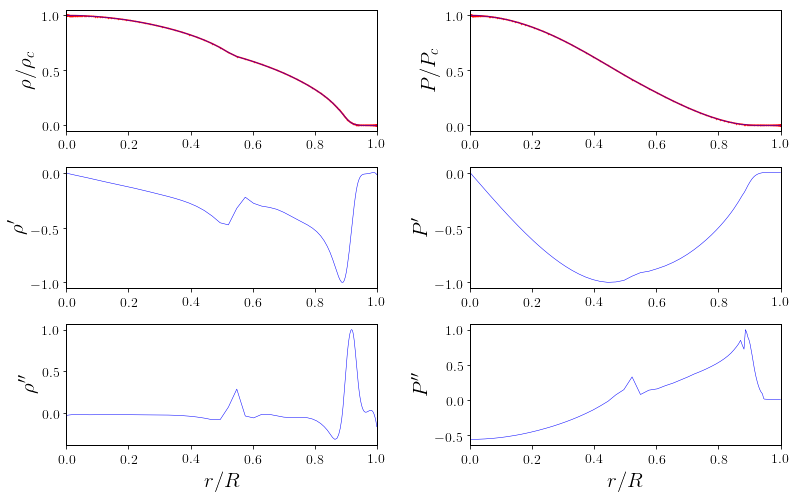

In [144]:
fig=plt.figure(figsize=[12.8,8])

plt.subplot(321)
plt.plot(alf3_150[-1]/alf3_150[-1][-1],alf3_150[2]/alf3_150[2][0],color='red',marker='o',markersize='0.4') 
plt.plot(alf3_150[-1]/alf3_150[-1][-1],alf3_150rho(alf3_150[-1])/alf3_150[2][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1) # leaving the crust out

plt.subplot(322)
plt.plot(alf3_150[-1]/alf3_150[-1][-1],alf3_150[1]/alf3_150[1][0],color='red',marker='o',markersize='0.4') 
plt.plot(alf3_150[-1]/alf3_150[-1][-1],alf3_150p(alf3_150[-1])/alf3_150[1][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$P/P_c$')
plt.xlim(0,1)

plt.subplot(323)
plt.plot(alf3_150[-1]/alf3_150[-1][-1],alf3_150drho(alf3_150[-1])/max(abs(alf3_150drho(alf3_150[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime}$')
plt.xlim(0,1)
#plt.ylim(-500,0)

plt.subplot(324)
plt.plot(alf3_150[-1]/alf3_150[-1][-1],alf3_150dp(alf3_150[-1])/max(abs(alf3_150dp(alf3_150[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime} $')
plt.xlim(0,1)

plt.subplot(325)
plt.plot(alf3_150[-1]/alf3_150[-1][-1],alf3_150ddrho(alf3_150[-1])/max(abs(alf3_150ddrho(alf3_150[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}$')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-0.01,0.01)

plt.subplot(326)
plt.plot(alf3_150[-1]/alf3_150[-1][-1],alf3_150ddp(alf3_150[-1])/max(abs(alf3_150ddp(alf3_150[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime\prime}$ ')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-1,1)

fig.subplots_adjust(hspace=0.3,wspace=0.3)

#plt.savefig('figures/ddsalf3_150.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

### 15.5

In [105]:
alf3_155=np.loadtxt('results/alf3/15.5.dat',unpack=True)
alf3_155[3] = alf3_155[3]-alf3_155[3][-1] + 0.5*np.log(1-2*alf3_155[0][-1]/alf3_155[-1][-1])

In [108]:
s1=5e-5
s2=1e-9
alf3_155rho=interpolate.UnivariateSpline(alf3_155[-1], alf3_155[2], k=5, s=s1)
alf3_155drho=interpolate.UnivariateSpline(alf3_155[-1], alf3_155[2], k=5, s=s1).derivative(n=1)
alf3_155ddrho=interpolate.UnivariateSpline(alf3_155[-1], alf3_155[2], k=5, s=s1).derivative(n=2)

alf3_155p=interpolate.UnivariateSpline(alf3_155[-1], alf3_155[1], k=5, s=s2)
alf3_155dp=interpolate.UnivariateSpline(alf3_155[-1], alf3_155[1], k=5, s=s2).derivative(n=1)
alf3_155ddp=interpolate.UnivariateSpline(alf3_155[-1], alf3_155[1], k=5, s=s2).derivative(n=2)

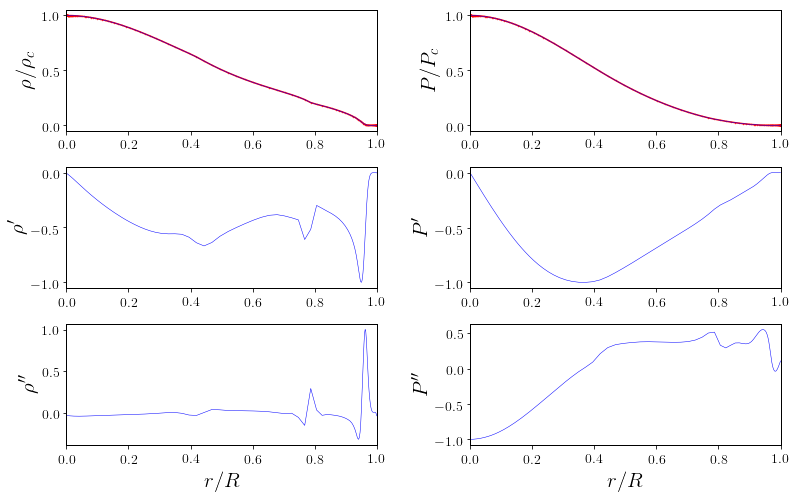

In [320]:
fig=plt.figure(figsize=[12.8,8])

plt.subplot(321)
plt.plot(alf3_155[-1]/alf3_155[-1][-1],alf3_155[2]/alf3_155[2][0],color='red',marker='o',markersize='0.4') 
plt.plot(alf3_155[-1]/alf3_155[-1][-1],alf3_155rho(alf3_155[-1])/alf3_155[2][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1) # leaving the crust out

plt.subplot(322)
plt.plot(alf3_155[-1]/alf3_155[-1][-1],alf3_155[1]/alf3_155[1][0],color='red',marker='o',markersize='0.4') 
plt.plot(alf3_155[-1]/alf3_155[-1][-1],alf3_155p(alf3_155[-1])/alf3_155[1][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$P/P_c$')
plt.xlim(0,1)

plt.subplot(323)
plt.plot(alf3_155[-1]/alf3_155[-1][-1],alf3_155drho(alf3_155[-1])/max(abs(alf3_155drho(alf3_155[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime}$')
plt.xlim(0,1)
#plt.ylim(-500,0)

plt.subplot(324)
plt.plot(alf3_155[-1]/alf3_155[-1][-1],alf3_155dp(alf3_155[-1])/max(abs(alf3_155dp(alf3_155[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime} $')
plt.xlim(0,1)

plt.subplot(325)
plt.plot(alf3_155[-1]/alf3_155[-1][-1],alf3_155ddrho(alf3_155[-1])/max(abs(alf3_155ddrho(alf3_155[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}$')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-0.01,0.01)

plt.subplot(326)
plt.plot(alf3_155[-1]/alf3_155[-1][-1],alf3_155ddp(alf3_155[-1])/max(abs(alf3_155ddp(alf3_155[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime\prime}$ ')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-1,1)

fig.subplots_adjust(hspace=0.3,wspace=0.3)

#plt.savefig('figures/ddsalf3_155.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

## Adiabatic convection

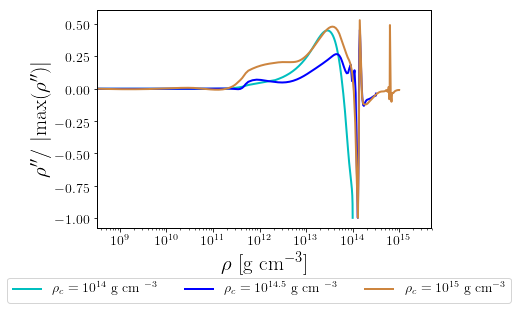

In [111]:
fig, ax = plt.subplots()

ax.set_xscale("log")

plt.plot(alf3_140[2]*rhodim,alf3_140ddrho(alf3_140[-1])/max(abs(alf3_140ddrho(alf3_140[-1]))),color='c',linewidth='2.0',label=r'$\rho_c=10^{14}$ g cm $^{-3}$') 
plt.plot(alf3_145[2]*rhodim,alf3_145ddrho(alf3_145[-1])/max(abs(alf3_145ddrho(alf3_145[-1]))),color='blue',linewidth='2.0',linestyle='-',label=r'$\rho_c=10^{14.5}$ g cm $^{-3}$') 
plt.plot(alf3_150[2]*rhodim,alf3_150ddrho(alf3_150[-1])/max(abs(alf3_150ddrho(alf3_150[-1]))),color='peru',linewidth='2.0',linestyle='-',label=r'$\rho_c=10^{15}$ g cm$ ^{-3}$')
plt.xlim(left=10**(8.5))
#plt.plot(alf3_155[-1]/alf3_155[-1][-1],alf3_155drho(alf3_155[-1])/max(abs(alf3_155drho(alf3_140[-1]))),color='yellow',linewidth='2.0',linestyle='-.',label=r'$\rho_c=10^{15.5}$ g cm$ ^{-3}$')

l = plt.legend(bbox_to_anchor=(1.1,-0.16), loc="lower right", 
                bbox_transform=fig.transFigure, ncol=3)

plt.xlabel(r'$\rho$ [g cm$^{-3}$]')
plt.ylabel(r'$\rho^{\prime \prime}/$ $|$max$(\rho^{\prime \prime})|$')
#plt.xlim(0,1.0)

plt.savefig('figures/ConvecStabilityalf3Correl.pdf', format='pdf', dpi=1000,bbox_inches="tight")

## Redshift

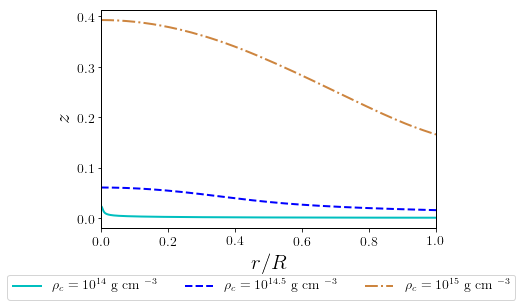

In [148]:
fig = plt.figure()

plt.plot(ALF3_140[-1]/ALF3_140[-1][-1],np.exp(-ALF3_140[3])-1.0,color='c',linewidth='2.0',label=r'$\rho_c=10^{14}$ g cm $^{-3}$')
plt.plot(ALF3_145[-1]/ALF3_145[-1][-1],np.exp(-ALF3_145[3])-1.0,color='blue',linewidth='2.0',linestyle='--',label=r'$\rho_c=10^{14.5}$ g cm $^{-3}$')
plt.plot(ALF3_150[-1]/ALF3_150[-1][-1],np.exp(-ALF3_150[3])-1.0,color='peru',linewidth='2.0',linestyle='-.',label=r'$\rho_c=10^{15}$ g cm $^{-3}$')

l = plt.legend(bbox_to_anchor=(1.1,-0.15), loc="lower right", 
                bbox_transform=fig.transFigure, ncol=3)

plt.xlabel(r'$r/R$')
plt.ylabel(r'$z$')
plt.xlim(0,1.0)

plt.savefig('figures/RedshiftALF3.pdf', format='pdf', dpi=1000,bbox_inches="tight")

# ALF4 ------------------------------------------------------------------------------------------

In [113]:
rhoalf4,Palf4,nalf4=np.loadtxt('EOS/alf4.dat',usecols=(2,1,0),unpack=True)

## Dominant energy condition

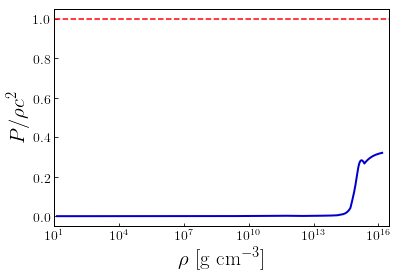

<Figure size 432x288 with 0 Axes>

In [150]:
fig, ax = plt.subplots()
plt.plot(nalf4,np.divide(Palf4,rhoalf4),lw='2',color='mediumblue')
plt.plot([0,10**(17)],[1.0,1.0],'r--',lw='1.5')

ax.set_xscale("log")
#locmaj = matplotlib.ticker.LogLocator(base=10.0,numticks=16) 
#ax.xaxis.set_major_locator(locmaj)


plt.xlabel(r'$\rho$ [g\,\,cm$^{-3}$]')
plt.ylabel(r'$ P / \rho c^2 $')
#locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks=16)
#ax.xaxis.set_minor_locator(locmin)
#ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.tick_params(axis="x", direction="in")
ax.tick_params(axis="y", direction="in")
plt.xlim(10,10**(16.5))
#ax.set_facecolor('floralwhite')
#plt.gca().set_aspect('equal', adjustable='box')
#plt.draw()
#plt.ylim(0,1)
plt.savefig('figures/ECalf4.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()
plt.clf()

## Speed of sound

In [114]:
vsquared=interpolate.UnivariateSpline(rhoalf4, Palf4, k=3, s=0).derivative(n=1)

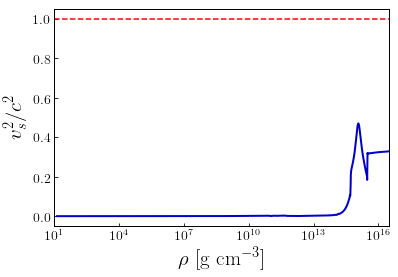

In [115]:
fig, ax = plt.subplots()
plt.plot(rhoalf4,vsquared(rhoalf4),lw='2.0',color='mediumblue')
plt.plot([1e+1,10**(16.5)],[1.0,1.0],'r--',lw='1.5')
plt.xlabel(r'$\rho$ [g\,\,cm$^{-3}$]')
plt.ylabel(r'$ v_s^2 / c^2 $')
plt.xscale('log')
ax.tick_params(axis="x", direction="in")
ax.tick_params(axis="y", direction="in")
plt.xlim(10,10**(16.5))
#ax.set_facecolor('floralwhite')
#mpl.rcParams['axes.linewidth'] = 1.4
#plt.gca().set_aspect('equal', adjustable='box')
#plt.draw()
plt.savefig('figures/SSalf4.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

## M - $\rho_c$

In [159]:
Ralf4,Malf4,rhocalf4=np.loadtxt('results/alf4/MRrhoc.dat',usecols=(0,1,2),unpack=True)

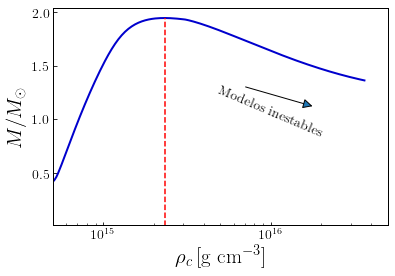

In [163]:
fig, ax = plt.subplots()

plt.plot(rhocalf4,Malf4,color='mediumblue',lw='2.0')
plt.plot([10**(np.log10(rhocalf4[np.argmax(Malf4)])),10**(np.log10(rhocalf4[np.argmax(Malf4)]))],[0.0,np.amax(Malf4)],'r--',lw='1.5')

prop = dict(arrowstyle="-|>,head_width=0.4,head_length=0.8",
            shrinkA=0,shrinkB=0)
plt.annotate("", xy=(10**(16.25),1.12), xytext=(10**(15.85),1.3), arrowprops=prop)
#plt.arrow(10**(15.6), 1.38,10**(15.7) ,-0.1 , head_width=0.05, head_length=10**(15))
plt.text(10**(15.67), 1.23, 'Modelos inestables' , fontsize=14,rotation=-23)

plt.xscale('log')
plt.xlabel(r'$\rho_c\,[$g cm$^{-3}]$')
plt.ylabel(r'$M/M_{\odot}$')
plt.xlim(left=10**(14.7),right=10**(16.7))
plt.ylim(bottom=0.01)
ax.tick_params(axis="x", direction="in",which='both')
ax.tick_params(axis="y", direction="in",which='both')

plt.savefig('figures/Mrhorel_alf4.pdf', format='pdf', dpi=1000,bbox_inches="tight")

## Effective and critical adiabatic index

In [118]:
rhoscalf4,betasalf4,gamma_efsalf4,gamma_crsalf4 = aindex_stab('alf4')

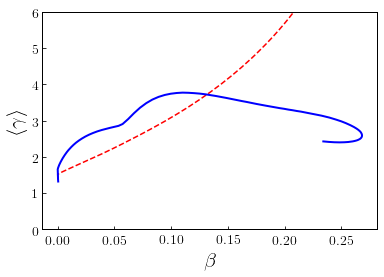

In [119]:
fig, ax = plt.subplots()
plt.plot(betasalf4,gamma_crsalf4,lw='1.5',color='r',linestyle='--',label=r'$\gamma_{cr}$')
#plt.plot([betacrit,betacrit],[0,5])
plt.plot(betasalf4,gamma_efsalf4,lw='2.0',color='blue',label=r'$\langle \gamma \rangle$')

plt.xlabel(r'$\beta$')
plt.ylabel(r'$\langle \gamma \rangle$')

#plt.xscale('log')
#plt.xlim(left=10**(14.7),right=10**(16.7))
plt.ylim(0,6)
ax.tick_params(axis="x", direction="in",which='both')
ax.tick_params(axis="y", direction="in",which='both')
#l = plt.legend(bbox_to_anchor=(0.85,-0.15), loc="lower right", 
                #bbox_transform=fig.transFigure, ncol=2)



plt.savefig('figures/AIndexStabALF4.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

## Tunning the interpolation of the solution

### 14.0

In [120]:
alf4_140=np.loadtxt('results/alf4/14.0.dat',unpack=True)
alf4_140[3] = alf4_140[3]-alf4_140[3][-1] + 0.5*np.log(1-2*alf4_140[0][-1]/alf4_140[-1][-1])

In [121]:
s1=5e-7
s2=1e-15
alf4_140rho=interpolate.UnivariateSpline(alf4_140[-1], alf4_140[2], k=5, s=s1)
alf4_140drho=interpolate.UnivariateSpline(alf4_140[-1], alf4_140[2], k=5, s=s1).derivative(n=1)
alf4_140ddrho=interpolate.UnivariateSpline(alf4_140[-1], alf4_140[2], k=5, s=s1).derivative(n=2)

alf4_140p=interpolate.UnivariateSpline(alf4_140[-1], alf4_140[1], k=5, s=s2)
alf4_140dp=interpolate.UnivariateSpline(alf4_140[-1], alf4_140[1], k=5, s=s2).derivative(n=1)
alf4_140ddp=interpolate.UnivariateSpline(alf4_140[-1], alf4_140[1], k=5, s=s2).derivative(n=2)

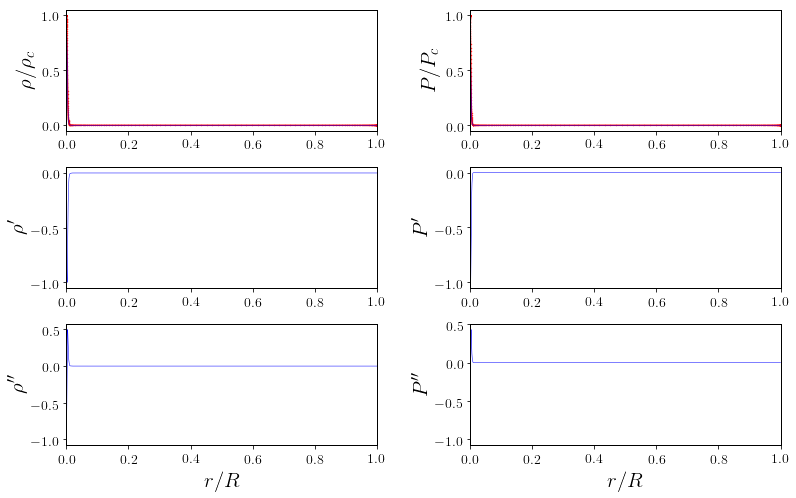

In [166]:
fig=plt.figure(figsize=[12.8,8])

plt.subplot(321)
plt.plot(alf4_140[-1]/alf4_140[-1][-1],alf4_140[2]/alf4_140[2][0],color='red',marker='o',markersize='0.4') 
plt.plot(alf4_140[-1]/alf4_140[-1][-1],alf4_140rho(alf4_140[-1])/alf4_140[2][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1) # leaving the crust out

plt.subplot(322)
plt.plot(alf4_140[-1]/alf4_140[-1][-1],alf4_140[1]/alf4_140[1][0],color='red',marker='o',markersize='0.4') 
plt.plot(alf4_140[-1]/alf4_140[-1][-1],alf4_140p(alf4_140[-1])/alf4_140[1][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$P/P_c$')
plt.xlim(0,1)

plt.subplot(323)
plt.plot(alf4_140[-1]/alf4_140[-1][-1],alf4_140drho(alf4_140[-1])/max(abs(alf4_140drho(alf4_140[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime}$')
plt.xlim(0,1)
#plt.ylim(-500,0)

plt.subplot(324)
plt.plot(alf4_140[-1]/alf4_140[-1][-1],alf4_140dp(alf4_140[-1])/max(abs(alf4_140dp(alf4_140[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime} $')
plt.xlim(0,1)

plt.subplot(325)
plt.plot(alf4_140[-1]/alf4_140[-1][-1],alf4_140ddrho(alf4_140[-1])/max(abs(alf4_140ddrho(alf4_140[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}$')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-0.01,0.01)

plt.subplot(326)
plt.plot(alf4_140[-1]/alf4_140[-1][-1],alf4_140ddp(alf4_140[-1])/max(abs(alf4_140ddp(alf4_140[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime\prime}$ ')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-1,1)

fig.subplots_adjust(hspace=0.3,wspace=0.3)

#plt.savefig('figures/ddsalf4_140.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

### 14.5

In [122]:
alf4_145=np.loadtxt('results/alf4/14.5.dat',unpack=True)
alf4_145[3] = alf4_145[3]-alf4_145[3][-1] + 0.5*np.log(1-2*alf4_145[0][-1]/alf4_145[-1][-1])

In [123]:
s1=1e-7
s2=1e-12
alf4_145rho=interpolate.UnivariateSpline(alf4_145[-1], alf4_145[2], k=5, s=s1)
alf4_145drho=interpolate.UnivariateSpline(alf4_145[-1], alf4_145[2], k=5, s=s1).derivative(n=1)
alf4_145ddrho=interpolate.UnivariateSpline(alf4_145[-1], alf4_145[2], k=5, s=s1).derivative(n=2)

alf4_145p=interpolate.UnivariateSpline(alf4_145[-1], alf4_145[1], k=5, s=s2)
alf4_145dp=interpolate.UnivariateSpline(alf4_145[-1], alf4_145[1], k=5, s=s2).derivative(n=1)
alf4_145ddp=interpolate.UnivariateSpline(alf4_145[-1], alf4_145[1], k=5, s=s2).derivative(n=2)

In [169]:
alf4_145rho(0.4*alf4_145[-1][-1])*rhodim

109554947563999.22

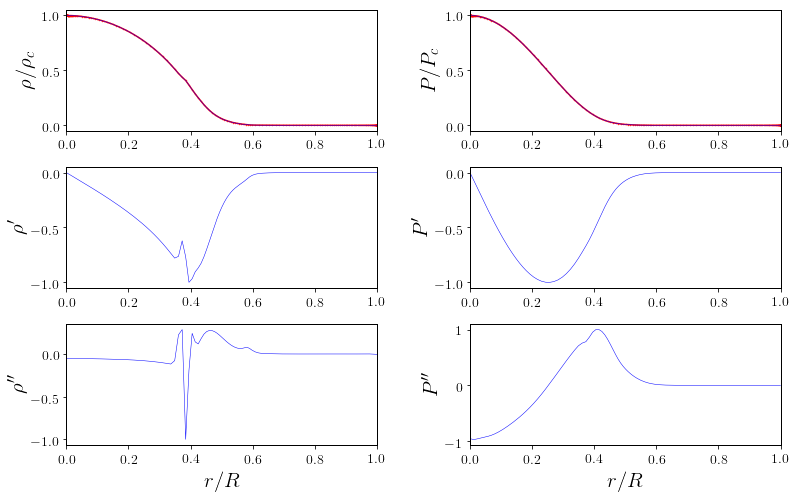

In [170]:
fig=plt.figure(figsize=[12.8,8])

plt.subplot(321)
plt.plot(alf4_145[-1]/alf4_145[-1][-1],alf4_145[2]/alf4_145[2][0],color='red',marker='o',markersize='0.4') 
plt.plot(alf4_145[-1]/alf4_145[-1][-1],alf4_145rho(alf4_145[-1])/alf4_145[2][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1) # leaving the crust out

plt.subplot(322)
plt.plot(alf4_145[-1]/alf4_145[-1][-1],alf4_145[1]/alf4_145[1][0],color='red',marker='o',markersize='0.4') 
plt.plot(alf4_145[-1]/alf4_145[-1][-1],alf4_145p(alf4_145[-1])/alf4_145[1][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$P/P_c$')
plt.xlim(0,1)

plt.subplot(323)
plt.plot(alf4_145[-1]/alf4_145[-1][-1],alf4_145drho(alf4_145[-1])/max(abs(alf4_145drho(alf4_145[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime}$')
plt.xlim(0,1)
#plt.ylim(-500,0)

plt.subplot(324)
plt.plot(alf4_145[-1]/alf4_145[-1][-1],alf4_145dp(alf4_145[-1])/max(abs(alf4_145dp(alf4_145[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime} $')
plt.xlim(0,1)

plt.subplot(325)
plt.plot(alf4_145[-1]/alf4_145[-1][-1],alf4_145ddrho(alf4_145[-1])/max(abs(alf4_145ddrho(alf4_145[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}$')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-0.01,0.01)

plt.subplot(326)
plt.plot(alf4_145[-1]/alf4_145[-1][-1],alf4_145ddp(alf4_145[-1])/max(abs(alf4_145ddp(alf4_145[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime\prime}$ ')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-1,1)

fig.subplots_adjust(hspace=0.3,wspace=0.3)

#plt.savefig('figures/ddsalf4_145.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

### 15.0

In [124]:
alf4_150=np.loadtxt('results/alf4/15.0.dat',unpack=True)
alf4_150[3] = alf4_150[3]-alf4_150[3][-1] + 0.5*np.log(1-2*alf4_150[0][-1]/alf4_150[-1][-1])

In [125]:
s1=8e-6
s2=1e-15
alf4_150rho=interpolate.UnivariateSpline(alf4_150[-1], alf4_150[2], k=5, s=s1)
alf4_150drho=interpolate.UnivariateSpline(alf4_150[-1], alf4_150[2], k=5, s=s1).derivative(n=1)
alf4_150ddrho=interpolate.UnivariateSpline(alf4_150[-1], alf4_150[2], k=5, s=s1).derivative(n=2)

alf4_150p=interpolate.UnivariateSpline(alf4_150[-1], alf4_150[1], k=5, s=s2)
alf4_150dp=interpolate.UnivariateSpline(alf4_150[-1], alf4_150[1], k=5, s=s2).derivative(n=1)
alf4_150ddp=interpolate.UnivariateSpline(alf4_150[-1], alf4_150[1], k=5, s=s2).derivative(n=2)

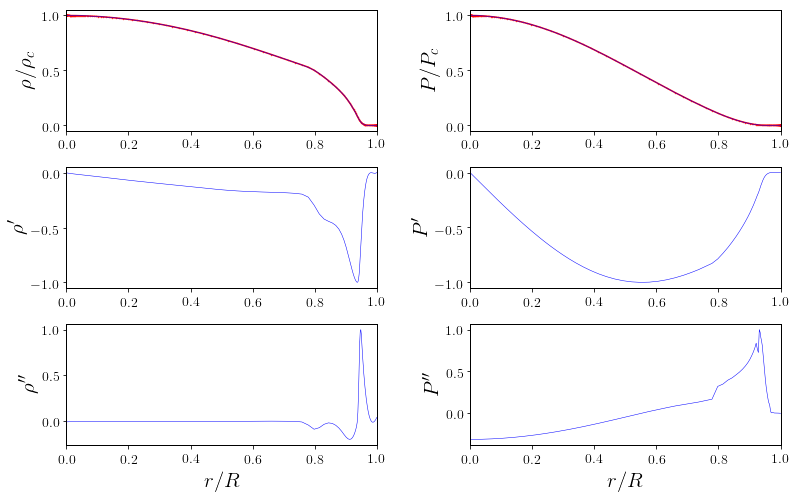

In [173]:
fig=plt.figure(figsize=[12.8,8])

plt.subplot(321)
plt.plot(alf4_150[-1]/alf4_150[-1][-1],alf4_150[2]/alf4_150[2][0],color='red',marker='o',markersize='0.4') 
plt.plot(alf4_150[-1]/alf4_150[-1][-1],alf4_150rho(alf4_150[-1])/alf4_150[2][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1) # leaving the crust out

plt.subplot(322)
plt.plot(alf4_150[-1]/alf4_150[-1][-1],alf4_150[1]/alf4_150[1][0],color='red',marker='o',markersize='0.4') 
plt.plot(alf4_150[-1]/alf4_150[-1][-1],alf4_150p(alf4_150[-1])/alf4_150[1][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$P/P_c$')
plt.xlim(0,1)

plt.subplot(323)
plt.plot(alf4_150[-1]/alf4_150[-1][-1],alf4_150drho(alf4_150[-1])/max(abs(alf4_150drho(alf4_150[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime}$')
plt.xlim(0,1)
#plt.ylim(-500,0)

plt.subplot(324)
plt.plot(alf4_150[-1]/alf4_150[-1][-1],alf4_150dp(alf4_150[-1])/max(abs(alf4_150dp(alf4_150[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime} $')
plt.xlim(0,1)

plt.subplot(325)
plt.plot(alf4_150[-1]/alf4_150[-1][-1],alf4_150ddrho(alf4_150[-1])/max(abs(alf4_150ddrho(alf4_150[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}$')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-0.01,0.01)

plt.subplot(326)
plt.plot(alf4_150[-1]/alf4_150[-1][-1],alf4_150ddp(alf4_150[-1])/max(abs(alf4_150ddp(alf4_150[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime\prime}$ ')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-1,1)

fig.subplots_adjust(hspace=0.3,wspace=0.3)

#plt.savefig('figures/ddsalf4_150.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

### 15.5

In [126]:
alf4_155=np.loadtxt('results/alf4/15.5.dat',unpack=True)
alf4_155[3] = alf4_155[3]-alf4_155[3][-1] + 0.5*np.log(1-2*alf4_155[0][-1]/alf4_155[-1][-1])

In [127]:
s1=1e-5
s2=1e-9
alf4_155rho=interpolate.UnivariateSpline(alf4_155[-1], alf4_155[2], k=5, s=s1)
alf4_155drho=interpolate.UnivariateSpline(alf4_155[-1], alf4_155[2], k=5, s=s1).derivative(n=1)
alf4_155ddrho=interpolate.UnivariateSpline(alf4_155[-1], alf4_155[2], k=5, s=s1).derivative(n=2)

alf4_155p=interpolate.UnivariateSpline(alf4_155[-1], alf4_155[1], k=5, s=s2)
alf4_155dp=interpolate.UnivariateSpline(alf4_155[-1], alf4_155[1], k=5, s=s2).derivative(n=1)
alf4_155ddp=interpolate.UnivariateSpline(alf4_155[-1], alf4_155[1], k=5, s=s2).derivative(n=2)

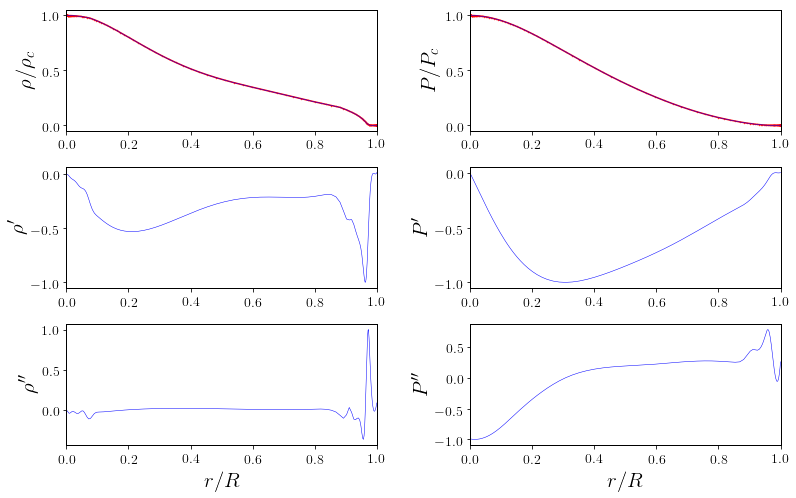

In [323]:
fig=plt.figure(figsize=[12.8,8])

plt.subplot(321)
plt.plot(alf4_155[-1]/alf4_155[-1][-1],alf4_155[2]/alf4_155[2][0],color='red',marker='o',markersize='0.4') 
plt.plot(alf4_155[-1]/alf4_155[-1][-1],alf4_155rho(alf4_155[-1])/alf4_155[2][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1) # leaving the crust out

plt.subplot(322)
plt.plot(alf4_155[-1]/alf4_155[-1][-1],alf4_155[1]/alf4_155[1][0],color='red',marker='o',markersize='0.4') 
plt.plot(alf4_155[-1]/alf4_155[-1][-1],alf4_155p(alf4_155[-1])/alf4_155[1][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$P/P_c$')
plt.xlim(0,1)

plt.subplot(323)
plt.plot(alf4_155[-1]/alf4_155[-1][-1],alf4_155drho(alf4_155[-1])/max(abs(alf4_155drho(alf4_155[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime}$')
plt.xlim(0,1)
#plt.ylim(-500,0)

plt.subplot(324)
plt.plot(alf4_155[-1]/alf4_155[-1][-1],alf4_155dp(alf4_155[-1])/max(abs(alf4_155dp(alf4_155[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime} $')
plt.xlim(0,1)

plt.subplot(325)
plt.plot(alf4_155[-1]/alf4_155[-1][-1],alf4_155ddrho(alf4_155[-1])/max(abs(alf4_155ddrho(alf4_155[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}$')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-0.01,0.01)

plt.subplot(326)
plt.plot(alf4_155[-1]/alf4_155[-1][-1],alf4_155ddp(alf4_155[-1])/max(abs(alf4_155ddp(alf4_155[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime\prime}$ ')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-1,1)

fig.subplots_adjust(hspace=0.3,wspace=0.3)

#plt.savefig('figures/ddsalf4_155.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

## Adiabatic convection

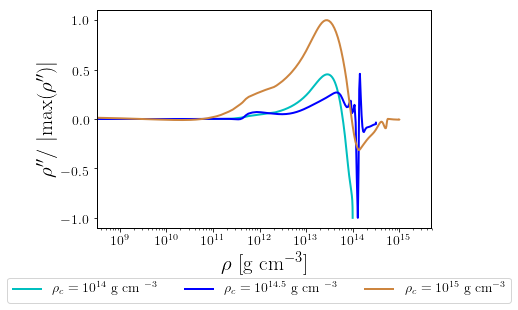

In [128]:
fig, ax = plt.subplots()

ax.set_xscale("log")

plt.plot(alf4_140[2]*rhodim,alf4_140ddrho(alf4_140[-1])/max(abs(alf4_140ddrho(alf4_140[-1]))),color='c',linewidth='2.0',label=r'$\rho_c=10^{14}$ g cm $^{-3}$') 
plt.plot(alf4_145[2]*rhodim,alf4_145ddrho(alf4_145[-1])/max(abs(alf4_145ddrho(alf4_145[-1]))),color='blue',linewidth='2.0',linestyle='-',label=r'$\rho_c=10^{14.5}$ g cm $^{-3}$') 
plt.plot(alf4_150[2]*rhodim,alf4_150ddrho(alf4_150[-1])/max(abs(alf4_150ddrho(alf4_150[-1]))),color='peru',linewidth='2.0',linestyle='-',label=r'$\rho_c=10^{15}$ g cm$ ^{-3}$')
plt.xlim(left=10**(8.5))
#plt.plot(alf4_155[-1]/alf4_155[-1][-1],alf4_155drho(alf4_155[-1])/max(abs(alf4_155drho(alf4_140[-1]))),color='yellow',linewidth='2.0',linestyle='-.',label=r'$\rho_c=10^{15.5}$ g cm$ ^{-3}$')

l = plt.legend(bbox_to_anchor=(1.1,-0.16), loc="lower right", 
                bbox_transform=fig.transFigure, ncol=3)

plt.xlabel(r'$\rho$ [g cm$^{-3}$]')
plt.ylabel(r'$\rho^{\prime \prime}/$ $|$max$(\rho^{\prime \prime})|$')
#plt.xlim(0,1.0)

plt.savefig('figures/ConvecStabilityalf4Correl.pdf', format='pdf', dpi=1000,bbox_inches="tight")

## Redshift

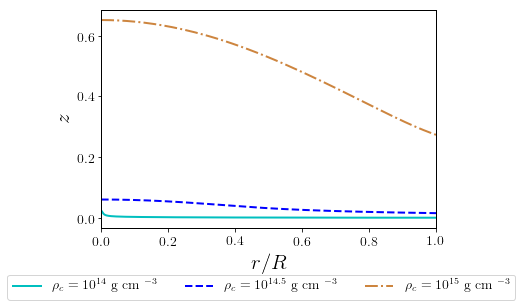

In [177]:
fig = plt.figure()

plt.plot(alf4_140[-1]/alf4_140[-1][-1],np.exp(-alf4_140[3])-1.0,color='c',linewidth='2.0',label=r'$\rho_c=10^{14}$ g cm $^{-3}$')
plt.plot(alf4_145[-1]/alf4_145[-1][-1],np.exp(-alf4_145[3])-1.0,color='blue',linewidth='2.0',linestyle='--',label=r'$\rho_c=10^{14.5}$ g cm $^{-3}$')
plt.plot(alf4_150[-1]/alf4_150[-1][-1],np.exp(-alf4_150[3])-1.0,color='peru',linewidth='2.0',linestyle='-.',label=r'$\rho_c=10^{15}$ g cm $^{-3}$')

l = plt.legend(bbox_to_anchor=(1.1,-0.15), loc="lower right", 
                bbox_transform=fig.transFigure, ncol=3)

plt.xlabel(r'$r/R$')
plt.ylabel(r'$z$')
plt.xlim(0,1.0)

plt.savefig('figures/Redshiftalf4.pdf', format='pdf', dpi=1000,bbox_inches="tight")

In [149]:
rhoalf4,Palf4,nalf4=np.loadtxt('EOS/alf4.dat',usecols=(2,1,0),unpack=True)

# AP1 ---------------------------------------------------------------------------------------------

In [3]:
rhoap1,Pap1,nap1=np.loadtxt('EOS/ap1.dat',usecols=(2,1,0),unpack=True)

## Dominant energy condition

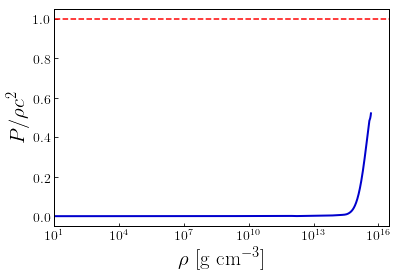

<Figure size 432x288 with 0 Axes>

In [20]:
fig, ax = plt.subplots()
plt.plot(rhoap1,np.divide(Pap1,rhoap1),lw='2',color='mediumblue')
plt.plot([0,10**(17)],[1.0,1.0],'r--',lw='1.5')

ax.set_xscale("log")
#locmaj = matplotlib.ticker.LogLocator(base=10.0,numticks=16) 
#ax.xaxis.set_major_locator(locmaj)


plt.xlabel(r'$\rho$ [g\,\,cm$^{-3}$]')
plt.ylabel(r'$ P / \rho c^2 $')
#locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks=16)
#ax.xaxis.set_minor_locator(locmin)
#ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.tick_params(axis="x", direction="in")
ax.tick_params(axis="y", direction="in")
plt.xlim(10,10**(16.5))
#ax.set_facecolor('floralwhite')
#plt.gca().set_aspect('equal', adjustable='box')
#plt.draw()
#plt.ylim(0,1)
plt.savefig('figures/ECap1.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()
plt.clf()

## Speed of sound

In [4]:
vsquared=interpolate.UnivariateSpline(rhoap1, Pap1, k=3, s=0).derivative(n=1)

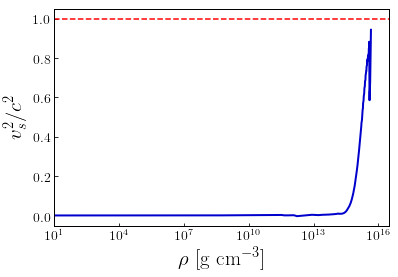

In [138]:
fig, ax = plt.subplots()
plt.plot(rhoap1,vsquared(rhoap1),lw='2.0',color='mediumblue')
plt.plot([1e+1,10**(16.5)],[1.0,1.0],'r--',lw='1.5')
plt.xlabel(r'$\rho$ [g\,\,cm$^{-3}$]')
plt.ylabel(r'$ v_s^2 / c^2 $')
plt.xscale('log')
ax.tick_params(axis="x", direction="in")
ax.tick_params(axis="y", direction="in")
plt.xlim(10,10**(16.5))
#ax.set_facecolor('floralwhite')
#mpl.rcParams['axes.linewidth'] = 1.4
#plt.gca().set_aspect('equal', adjustable='box')
#plt.draw()
plt.savefig('figures/SSap1.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

## M - $\rho_c$

In [59]:
Rap1,Map1,rhocap1=np.loadtxt('results/ap1/MRrhoc.dat',usecols=(0,1,2),unpack=True)

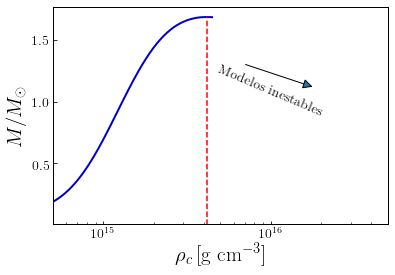

In [63]:
fig, ax = plt.subplots()

plt.plot(rhocap1,Map1,color='mediumblue',lw='2.0')
plt.plot([10**(np.log10(rhocap1[np.argmax(Map1)])),10**(np.log10(rhocap1[np.argmax(Map1)]))],[0.0,np.amax(Map1)],'r--',lw='1.5')

prop = dict(arrowstyle="-|>,head_width=0.4,head_length=0.8",
            shrinkA=0,shrinkB=0)
plt.annotate("", xy=(10**(16.25),1.12), xytext=(10**(15.85),1.3), arrowprops=prop)
#plt.arrow(10**(15.6), 1.38,10**(15.7) ,-0.1 , head_width=0.05, head_length=10**(15))
plt.text(10**(15.67), 1.23, 'Modelos inestables' , fontsize=14,rotation=-23)

plt.xscale('log')
plt.xlabel(r'$\rho_c\,[$g cm$^{-3}]$')
plt.ylabel(r'$M/M_{\odot}$')
plt.xlim(left=10**(14.7),right=10**(16.7))
plt.ylim(bottom=0.01)
ax.tick_params(axis="x", direction="in",which='both')
ax.tick_params(axis="y", direction="in",which='both')

plt.savefig('figures/Mrhorel_ap1.pdf', format='pdf', dpi=1000,bbox_inches="tight")

## Effective and critical adiabatic index

In [7]:
rhoscap1,betasap1,gamma_efsap1,gamma_crsap1 = aindex_stab('ap1')

ValueError: x must be strictly increasing

Sometimes when using a low value of $\delta$ the density close to the border doesn't change considerably, so making an spline is not posible. In this case the models have to be recalculated with a higher value of $\delta$.

In [ ]:
fig, ax = plt.subplots()
plt.plot(betasap1,gamma_crsap1,lw='1.5',color='r',linestyle='--',label=r'$\gamma_{cr}$')
#plt.plot([betacrit,betacrit],[0,5])
plt.plot(betasap1,gamma_efsap1,lw='2.0',color='blue',label=r'$\langle \gamma \rangle$')

plt.xlabel(r'$\beta$')
plt.ylabel(r'$\langle \gamma \rangle$')

#plt.xscale('log')
#plt.xlim(left=10**(14.7),right=10**(16.7))
plt.ylim(0,6)
ax.tick_params(axis="x", direction="in",which='both')
ax.tick_params(axis="y", direction="in",which='both')
#l = plt.legend(bbox_to_anchor=(0.85,-0.15), loc="lower right", 
                #bbox_transform=fig.transFigure, ncol=2)



plt.savefig('figures/AIndexStabap1.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

## Tunning the interpolation of the solution

### 14.0

In [140]:
ap1_140=np.loadtxt('results/ap1/14.2.dat',unpack=True)
ap1_140[3] = ap1_140[3]-ap1_140[3][-1] + 0.5*np.log(1-2*ap1_140[0][-1]/ap1_140[-1][-1])

In [141]:
s1=5e-7
s2=1e-15
ap1_140rho=interpolate.UnivariateSpline(ap1_140[-1], ap1_140[2], k=5, s=s1)
ap1_140drho=interpolate.UnivariateSpline(ap1_140[-1], ap1_140[2], k=5, s=s1).derivative(n=1)
ap1_140ddrho=interpolate.UnivariateSpline(ap1_140[-1], ap1_140[2], k=5, s=s1).derivative(n=2)

ap1_140p=interpolate.UnivariateSpline(ap1_140[-1], ap1_140[1], k=5, s=s2)
ap1_140dp=interpolate.UnivariateSpline(ap1_140[-1], ap1_140[1], k=5, s=s2).derivative(n=1)
ap1_140ddp=interpolate.UnivariateSpline(ap1_140[-1], ap1_140[1], k=5, s=s2).derivative(n=2)

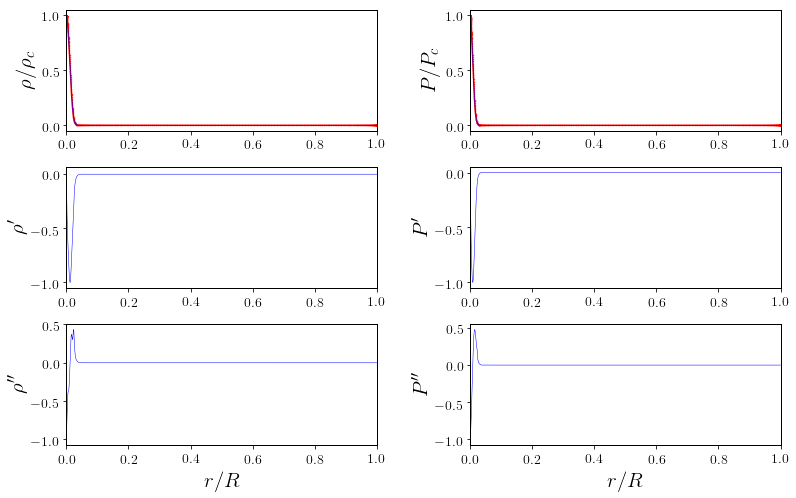

In [83]:
fig=plt.figure(figsize=[12.8,8])

plt.subplot(321)
plt.plot(ap1_140[-1]/ap1_140[-1][-1],ap1_140[2]/ap1_140[2][0],color='red',marker='o',markersize='0.4') 
plt.plot(ap1_140[-1]/ap1_140[-1][-1],ap1_140rho(ap1_140[-1])/ap1_140[2][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1) # leaving the crust out

plt.subplot(322)
plt.plot(ap1_140[-1]/ap1_140[-1][-1],ap1_140[1]/ap1_140[1][0],color='red',marker='o',markersize='0.4') 
plt.plot(ap1_140[-1]/ap1_140[-1][-1],ap1_140p(ap1_140[-1])/ap1_140[1][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$P/P_c$')
plt.xlim(0,1)

plt.subplot(323)
plt.plot(ap1_140[-1]/ap1_140[-1][-1],ap1_140drho(ap1_140[-1])/max(abs(ap1_140drho(ap1_140[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime}$')
plt.xlim(0,1)
#plt.ylim(-500,0)

plt.subplot(324)
plt.plot(ap1_140[-1]/ap1_140[-1][-1],ap1_140dp(ap1_140[-1])/max(abs(ap1_140dp(ap1_140[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime} $')
plt.xlim(0,1)

plt.subplot(325)
plt.plot(ap1_140[-1]/ap1_140[-1][-1],ap1_140ddrho(ap1_140[-1])/max(abs(ap1_140ddrho(ap1_140[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}$')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-0.01,0.01)

plt.subplot(326)
plt.plot(ap1_140[-1]/ap1_140[-1][-1],ap1_140ddp(ap1_140[-1])/max(abs(ap1_140ddp(ap1_140[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime\prime}$ ')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-1,1)

fig.subplots_adjust(hspace=0.3,wspace=0.3)

#plt.savefig('figures/ddsap1_140.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

### 14.5

In [142]:
ap1_145=np.loadtxt('results/ap1/14.5.dat',unpack=True)
ap1_145[3] = ap1_145[3]-ap1_145[3][-1] + 0.5*np.log(1-2*ap1_145[0][-1]/ap1_145[-1][-1])

In [143]:
s1=1e-7
s2=1e-12
ap1_145rho=interpolate.UnivariateSpline(ap1_145[-1], ap1_145[2], k=5, s=s1)
ap1_145drho=interpolate.UnivariateSpline(ap1_145[-1], ap1_145[2], k=5, s=s1).derivative(n=1)
ap1_145ddrho=interpolate.UnivariateSpline(ap1_145[-1], ap1_145[2], k=5, s=s1).derivative(n=2)

ap1_145p=interpolate.UnivariateSpline(ap1_145[-1], ap1_145[1], k=5, s=s2)
ap1_145dp=interpolate.UnivariateSpline(ap1_145[-1], ap1_145[1], k=5, s=s2).derivative(n=1)
ap1_145ddp=interpolate.UnivariateSpline(ap1_145[-1], ap1_145[1], k=5, s=s2).derivative(n=2)

In [69]:
ap1_145rho(0.4*ap1_145[-1][-1])*rhodim

122362975307.7416

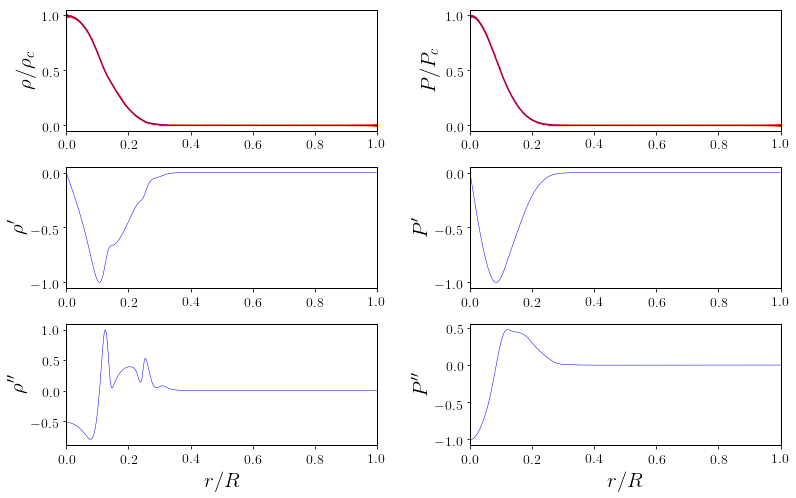

In [70]:
fig=plt.figure(figsize=[12.8,8])

plt.subplot(321)
plt.plot(ap1_145[-1]/ap1_145[-1][-1],ap1_145[2]/ap1_145[2][0],color='red',marker='o',markersize='0.4') 
plt.plot(ap1_145[-1]/ap1_145[-1][-1],ap1_145rho(ap1_145[-1])/ap1_145[2][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1) # leaving the crust out

plt.subplot(322)
plt.plot(ap1_145[-1]/ap1_145[-1][-1],ap1_145[1]/ap1_145[1][0],color='red',marker='o',markersize='0.4') 
plt.plot(ap1_145[-1]/ap1_145[-1][-1],ap1_145p(ap1_145[-1])/ap1_145[1][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$P/P_c$')
plt.xlim(0,1)

plt.subplot(323)
plt.plot(ap1_145[-1]/ap1_145[-1][-1],ap1_145drho(ap1_145[-1])/max(abs(ap1_145drho(ap1_145[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime}$')
plt.xlim(0,1)
#plt.ylim(-500,0)

plt.subplot(324)
plt.plot(ap1_145[-1]/ap1_145[-1][-1],ap1_145dp(ap1_145[-1])/max(abs(ap1_145dp(ap1_145[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime} $')
plt.xlim(0,1)

plt.subplot(325)
plt.plot(ap1_145[-1]/ap1_145[-1][-1],ap1_145ddrho(ap1_145[-1])/max(abs(ap1_145ddrho(ap1_145[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}$')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-0.01,0.01)

plt.subplot(326)
plt.plot(ap1_145[-1]/ap1_145[-1][-1],ap1_145ddp(ap1_145[-1])/max(abs(ap1_145ddp(ap1_145[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime\prime}$ ')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-1,1)

fig.subplots_adjust(hspace=0.3,wspace=0.3)

#plt.savefig('figures/ddsap1_145.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

### 15.0

In [144]:
ap1_150=np.loadtxt('results/ap1/14.7.dat',unpack=True)
ap1_150[3] = ap1_150[3]-ap1_150[3][-1] + 0.5*np.log(1-2*ap1_150[0][-1]/ap1_150[-1][-1])

In [145]:
s1=8e-6
s2=1e-15
ap1_150rho=interpolate.UnivariateSpline(ap1_150[-1], ap1_150[2], k=5, s=s1)
ap1_150drho=interpolate.UnivariateSpline(ap1_150[-1], ap1_150[2], k=5, s=s1).derivative(n=1)
ap1_150ddrho=interpolate.UnivariateSpline(ap1_150[-1], ap1_150[2], k=5, s=s1).derivative(n=2)

ap1_150p=interpolate.UnivariateSpline(ap1_150[-1], ap1_150[1], k=5, s=s2)
ap1_150dp=interpolate.UnivariateSpline(ap1_150[-1], ap1_150[1], k=5, s=s2).derivative(n=1)
ap1_150ddp=interpolate.UnivariateSpline(ap1_150[-1], ap1_150[1], k=5, s=s2).derivative(n=2)

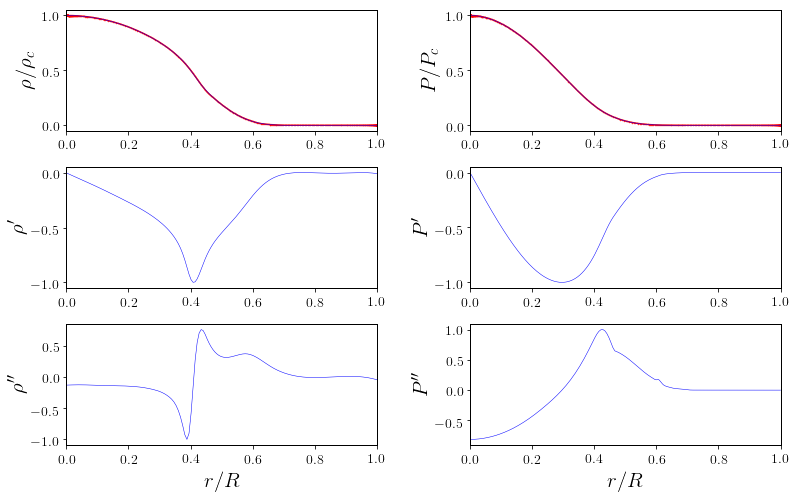

In [86]:
fig=plt.figure(figsize=[12.8,8])

plt.subplot(321)
plt.plot(ap1_150[-1]/ap1_150[-1][-1],ap1_150[2]/ap1_150[2][0],color='red',marker='o',markersize='0.4') 
plt.plot(ap1_150[-1]/ap1_150[-1][-1],ap1_150rho(ap1_150[-1])/ap1_150[2][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1) # leaving the crust out

plt.subplot(322)
plt.plot(ap1_150[-1]/ap1_150[-1][-1],ap1_150[1]/ap1_150[1][0],color='red',marker='o',markersize='0.4') 
plt.plot(ap1_150[-1]/ap1_150[-1][-1],ap1_150p(ap1_150[-1])/ap1_150[1][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$P/P_c$')
plt.xlim(0,1)

plt.subplot(323)
plt.plot(ap1_150[-1]/ap1_150[-1][-1],ap1_150drho(ap1_150[-1])/max(abs(ap1_150drho(ap1_150[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime}$')
plt.xlim(0,1)
#plt.ylim(-500,0)

plt.subplot(324)
plt.plot(ap1_150[-1]/ap1_150[-1][-1],ap1_150dp(ap1_150[-1])/max(abs(ap1_150dp(ap1_150[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime} $')
plt.xlim(0,1)

plt.subplot(325)
plt.plot(ap1_150[-1]/ap1_150[-1][-1],ap1_150ddrho(ap1_150[-1])/max(abs(ap1_150ddrho(ap1_150[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}$')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-0.01,0.01)

plt.subplot(326)
plt.plot(ap1_150[-1]/ap1_150[-1][-1],ap1_150ddp(ap1_150[-1])/max(abs(ap1_150ddp(ap1_150[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime\prime}$ ')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-1,1)

fig.subplots_adjust(hspace=0.3,wspace=0.3)

#plt.savefig('figures/ddsap1_150.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

### 15.5

In [146]:
ap1_155=np.loadtxt('results/ap1/15.0.dat',unpack=True)
ap1_155[3] = ap1_155[3]-ap1_155[3][-1] + 0.5*np.log(1-2*ap1_155[0][-1]/ap1_155[-1][-1])

In [147]:
s1=1e-5
s2=1e-9
ap1_155rho=interpolate.UnivariateSpline(ap1_155[-1], ap1_155[2], k=5, s=s1)
ap1_155drho=interpolate.UnivariateSpline(ap1_155[-1], ap1_155[2], k=5, s=s1).derivative(n=1)
ap1_155ddrho=interpolate.UnivariateSpline(ap1_155[-1], ap1_155[2], k=5, s=s1).derivative(n=2)

ap1_155p=interpolate.UnivariateSpline(ap1_155[-1], ap1_155[1], k=5, s=s2)
ap1_155dp=interpolate.UnivariateSpline(ap1_155[-1], ap1_155[1], k=5, s=s2).derivative(n=1)
ap1_155ddp=interpolate.UnivariateSpline(ap1_155[-1], ap1_155[1], k=5, s=s2).derivative(n=2)

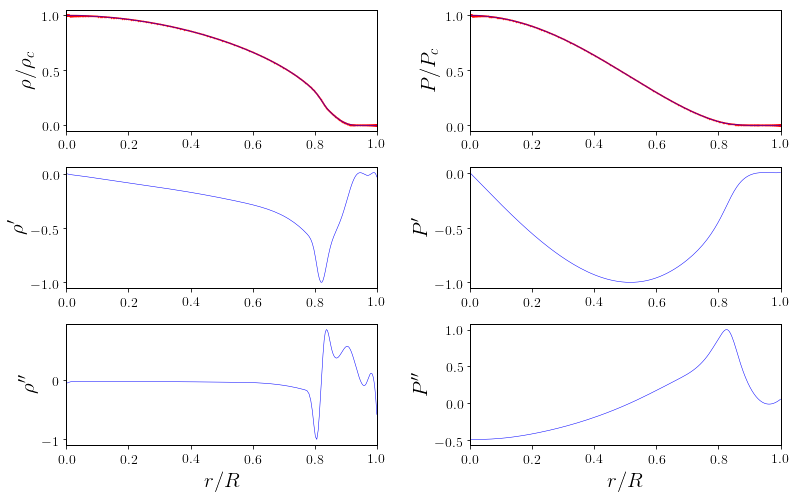

In [89]:
fig=plt.figure(figsize=[12.8,8])

plt.subplot(321)
plt.plot(ap1_155[-1]/ap1_155[-1][-1],ap1_155[2]/ap1_155[2][0],color='red',marker='o',markersize='0.4') 
plt.plot(ap1_155[-1]/ap1_155[-1][-1],ap1_155rho(ap1_155[-1])/ap1_155[2][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1) # leaving the crust out

plt.subplot(322)
plt.plot(ap1_155[-1]/ap1_155[-1][-1],ap1_155[1]/ap1_155[1][0],color='red',marker='o',markersize='0.4') 
plt.plot(ap1_155[-1]/ap1_155[-1][-1],ap1_155p(ap1_155[-1])/ap1_155[1][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$P/P_c$')
plt.xlim(0,1)

plt.subplot(323)
plt.plot(ap1_155[-1]/ap1_155[-1][-1],ap1_155drho(ap1_155[-1])/max(abs(ap1_155drho(ap1_155[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime}$')
plt.xlim(0,1)
#plt.ylim(-500,0)

plt.subplot(324)
plt.plot(ap1_155[-1]/ap1_155[-1][-1],ap1_155dp(ap1_155[-1])/max(abs(ap1_155dp(ap1_155[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime} $')
plt.xlim(0,1)

plt.subplot(325)
plt.plot(ap1_155[-1]/ap1_155[-1][-1],ap1_155ddrho(ap1_155[-1])/max(abs(ap1_155ddrho(ap1_155[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}$')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-0.01,0.01)

plt.subplot(326)
plt.plot(ap1_155[-1]/ap1_155[-1][-1],ap1_155ddp(ap1_155[-1])/max(abs(ap1_155ddp(ap1_155[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime\prime}$ ')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-1,1)

fig.subplots_adjust(hspace=0.3,wspace=0.3)

#plt.savefig('figures/ddsap1_155.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

## Adiabatic convection

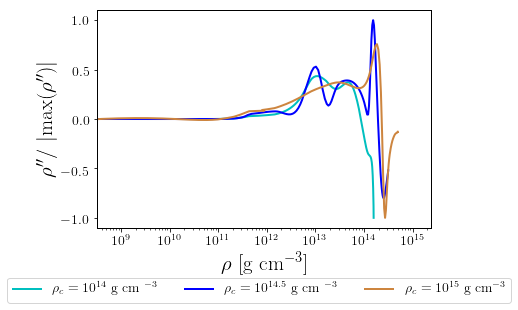

In [148]:
fig, ax = plt.subplots()

ax.set_xscale("log")

plt.plot(ap1_140[2]*rhodim,ap1_140ddrho(ap1_140[-1])/max(abs(ap1_140ddrho(ap1_140[-1]))),color='c',linewidth='2.0',label=r'$\rho_c=10^{14}$ g cm $^{-3}$') 
plt.plot(ap1_145[2]*rhodim,ap1_145ddrho(ap1_145[-1])/max(abs(ap1_145ddrho(ap1_145[-1]))),color='blue',linewidth='2.0',linestyle='-',label=r'$\rho_c=10^{14.5}$ g cm $^{-3}$') 
plt.plot(ap1_150[2]*rhodim,ap1_150ddrho(ap1_150[-1])/max(abs(ap1_150ddrho(ap1_150[-1]))),color='peru',linewidth='2.0',linestyle='-',label=r'$\rho_c=10^{15}$ g cm$ ^{-3}$')
plt.xlim(left=10**(8.5))
#plt.plot(ap1_155[-1]/ap1_155[-1][-1],ap1_155drho(ap1_155[-1])/max(abs(ap1_155drho(ap1_140[-1]))),color='yellow',linewidth='2.0',linestyle='-.',label=r'$\rho_c=10^{15.5}$ g cm$ ^{-3}$')

l = plt.legend(bbox_to_anchor=(1.1,-0.16), loc="lower right", 
                bbox_transform=fig.transFigure, ncol=3)

plt.xlabel(r'$\rho$ [g cm$^{-3}$]')
plt.ylabel(r'$\rho^{\prime \prime}/$ $|$max$(\rho^{\prime \prime})|$')
#plt.xlim(0,1.0)

plt.savefig('figures/ConvecStabilityap1Correl.pdf', format='pdf', dpi=1000,bbox_inches="tight")

## Redshift

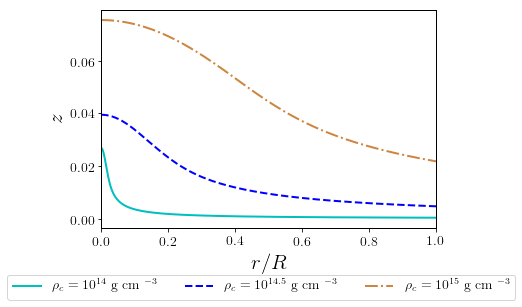

In [90]:
fig = plt.figure()

plt.plot(ap1_140[-1]/ap1_140[-1][-1],np.exp(-ap1_140[3])-1.0,color='c',linewidth='2.0',label=r'$\rho_c=10^{14}$ g cm $^{-3}$')
plt.plot(ap1_145[-1]/ap1_145[-1][-1],np.exp(-ap1_145[3])-1.0,color='blue',linewidth='2.0',linestyle='--',label=r'$\rho_c=10^{14.5}$ g cm $^{-3}$')
plt.plot(ap1_150[-1]/ap1_150[-1][-1],np.exp(-ap1_150[3])-1.0,color='peru',linewidth='2.0',linestyle='-.',label=r'$\rho_c=10^{15}$ g cm $^{-3}$')

l = plt.legend(bbox_to_anchor=(1.1,-0.15), loc="lower right", 
                bbox_transform=fig.transFigure, ncol=3)

plt.xlabel(r'$r/R$')
plt.ylabel(r'$z$')
plt.xlim(0,1.0)

plt.savefig('figures/Redshiftap1.pdf', format='pdf', dpi=1000,bbox_inches="tight")

# AP2 ------------------------------------------------------------------------------------------

In [9]:
rhoap2,Pap2,nap2=np.loadtxt('EOS/ap2.dat',usecols=(2,1,0),unpack=True)

## Dominant energy condition

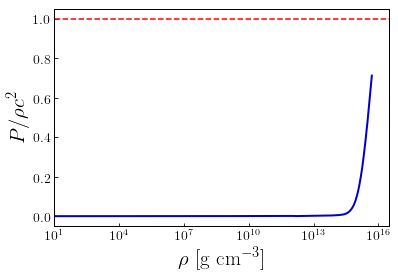

<Figure size 432x288 with 0 Axes>

In [243]:
fig, ax = plt.subplots()
plt.plot(rhoap2,np.divide(Pap2,rhoap2),lw='2',color='mediumblue')
plt.plot([0,10**(17)],[1.0,1.0],'r--',lw='1.5')

ax.set_xscale("log")
#locmaj = matplotlib.ticker.LogLocator(base=10.0,numticks=16) 
#ax.xaxis.set_major_locator(locmaj)


plt.xlabel(r'$\rho$ [g\,\,cm$^{-3}$]')
plt.ylabel(r'$ P / \rho c^2 $')
#locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks=16)
#ax.xaxis.set_minor_locator(locmin)
#ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.tick_params(axis="x", direction="in")
ax.tick_params(axis="y", direction="in")
plt.xlim(10,10**(16.5))
#ax.set_facecolor('floralwhite')
#plt.gca().set_aspect('equal', adjustable='box')
#plt.draw()
#plt.ylim(0,1)
plt.savefig('figures/ECap2.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()
plt.clf()

## Speed of sound

In [150]:
vsquared=interpolate.UnivariateSpline(rhoap2, Pap2, k=3, s=1e-25).derivative(n=1)

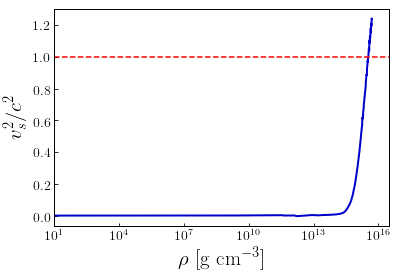

In [151]:
fig, ax = plt.subplots()
plt.plot(rhoap2,vsquared(rhoap2),lw='2.0',color='mediumblue')
plt.plot([1e+1,10**(16.5)],[1.0,1.0],'r--',lw='1.5')
plt.xlabel(r'$\rho$ [g\,\,cm$^{-3}$]')
plt.ylabel(r'$ v_s^2 / c^2 $')
plt.xscale('log')
ax.tick_params(axis="x", direction="in")
ax.tick_params(axis="y", direction="in")
plt.xlim(10,10**(16.5))
#ax.set_facecolor('floralwhite')
#mpl.rcParams['axes.linewidth'] = 1.4
#plt.gca().set_aspect('equal', adjustable='box')
#plt.draw()
plt.savefig('figures/SSap2.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

## M - $\rho_c$

In [152]:
Rap2,Map2,rhocap2=np.loadtxt('results/ap2/MRrhoc.dat',usecols=(0,1,2),unpack=True)

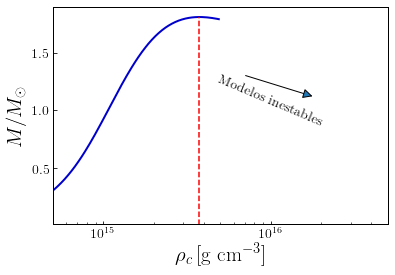

In [153]:
fig, ax = plt.subplots()

plt.plot(rhocap2,Map2,color='mediumblue',lw='2.0')
plt.plot([10**(np.log10(rhocap2[np.argmax(Map2)])),10**(np.log10(rhocap2[np.argmax(Map2)]))],[0.0,np.amax(Map2)],'r--',lw='1.5')

prop = dict(arrowstyle="-|>,head_width=0.4,head_length=0.8",
            shrinkA=0,shrinkB=0)
plt.annotate("", xy=(10**(16.25),1.12), xytext=(10**(15.85),1.3), arrowprops=prop)
#plt.arrow(10**(15.6), 1.38,10**(15.7) ,-0.1 , head_width=0.05, head_length=10**(15))
plt.text(10**(15.67), 1.23, 'Modelos inestables' , fontsize=14,rotation=-23)

plt.xscale('log')
plt.xlabel(r'$\rho_c\,[$g cm$^{-3}]$')
plt.ylabel(r'$M/M_{\odot}$')
plt.xlim(left=10**(14.7),right=10**(16.7))
plt.ylim(bottom=0.01)
ax.tick_params(axis="x", direction="in",which='both')
ax.tick_params(axis="y", direction="in",which='both')

plt.savefig('figures/Mrhorel_ap2.pdf', format='pdf', dpi=1000,bbox_inches="tight")

## Effective and critical adiabatic index

In [154]:
rhoscap2,betasap2,gamma_efsap2,gamma_crsap2 = aindex_stab('ap2')

ValueError: x must be strictly increasing

In [ ]:
fig, ax = plt.subplots()
plt.plot(betasap2,gamma_crsap2,lw='1.5',color='r',linestyle='--',label=r'$\gamma_{cr}$')
#plt.plot([betacrit,betacrit],[0,5])
plt.plot(betasap2,gamma_efsap2,lw='2.0',color='blue',label=r'$\langle \gamma \rangle$')

plt.xlabel(r'$\beta$')
plt.ylabel(r'$\langle \gamma \rangle$')

#plt.xscale('log')
#plt.xlim(left=10**(14.7),right=10**(16.7))
plt.ylim(0,6)
ax.tick_params(axis="x", direction="in",which='both')
ax.tick_params(axis="y", direction="in",which='both')
#l = plt.legend(bbox_to_anchor=(0.85,-0.15), loc="lower right", 
                #bbox_transform=fig.transFigure, ncol=2)



plt.savefig('figures/AIndexStabap2.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

## Tunning the interpolation of the solution

### 14.0

In [10]:
ap2_140=np.loadtxt('results/ap2/14.0.dat',unpack=True)
ap2_140[3] = ap2_140[3]-ap2_140[3][-1] + 0.5*np.log(1-2*ap2_140[0][-1]/ap2_140[-1][-1])

In [11]:
s1=5e-7
s2=1e-15
ap2_140rho=interpolate.UnivariateSpline(ap2_140[-1], ap2_140[2], k=5, s=s1)
ap2_140drho=interpolate.UnivariateSpline(ap2_140[-1], ap2_140[2], k=5, s=s1).derivative(n=1)
ap2_140ddrho=interpolate.UnivariateSpline(ap2_140[-1], ap2_140[2], k=5, s=s1).derivative(n=2)

ap2_140p=interpolate.UnivariateSpline(ap2_140[-1], ap2_140[1], k=5, s=s2)
ap2_140dp=interpolate.UnivariateSpline(ap2_140[-1], ap2_140[1], k=5, s=s2).derivative(n=1)
ap2_140ddp=interpolate.UnivariateSpline(ap2_140[-1], ap2_140[1], k=5, s=s2).derivative(n=2)

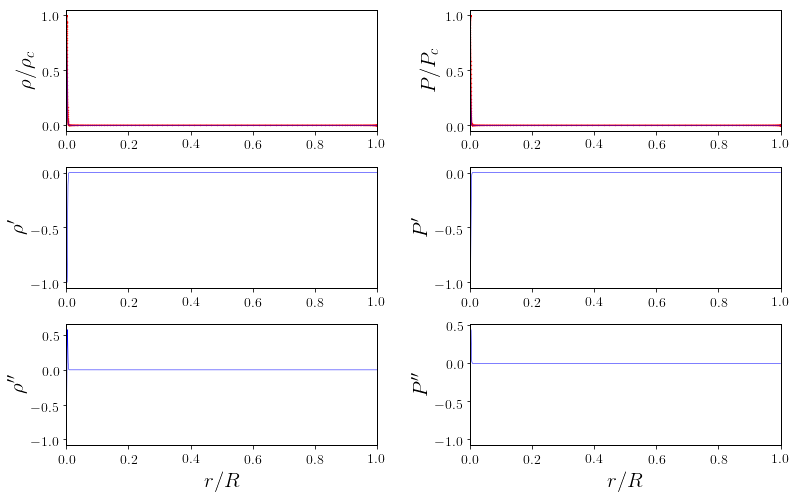

In [261]:
fig=plt.figure(figsize=[12.8,8])

plt.subplot(321)
plt.plot(ap2_140[-1]/ap2_140[-1][-1],ap2_140[2]/ap2_140[2][0],color='red',marker='o',markersize='0.4') 
plt.plot(ap2_140[-1]/ap2_140[-1][-1],ap2_140rho(ap2_140[-1])/ap2_140[2][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1) # leaving the crust out

plt.subplot(322)
plt.plot(ap2_140[-1]/ap2_140[-1][-1],ap2_140[1]/ap2_140[1][0],color='red',marker='o',markersize='0.4') 
plt.plot(ap2_140[-1]/ap2_140[-1][-1],ap2_140p(ap2_140[-1])/ap2_140[1][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$P/P_c$')
plt.xlim(0,1)

plt.subplot(323)
plt.plot(ap2_140[-1]/ap2_140[-1][-1],ap2_140drho(ap2_140[-1])/max(abs(ap2_140drho(ap2_140[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime}$')
plt.xlim(0,1)
#plt.ylim(-500,0)

plt.subplot(324)
plt.plot(ap2_140[-1]/ap2_140[-1][-1],ap2_140dp(ap2_140[-1])/max(abs(ap2_140dp(ap2_140[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime} $')
plt.xlim(0,1)

plt.subplot(325)
plt.plot(ap2_140[-1]/ap2_140[-1][-1],ap2_140ddrho(ap2_140[-1])/max(abs(ap2_140ddrho(ap2_140[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}$')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-0.01,0.01)

plt.subplot(326)
plt.plot(ap2_140[-1]/ap2_140[-1][-1],ap2_140ddp(ap2_140[-1])/max(abs(ap2_140ddp(ap2_140[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime\prime}$ ')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-1,1)

fig.subplots_adjust(hspace=0.3,wspace=0.3)

#plt.savefig('figures/ddsap2_140.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

### 14.5

In [12]:
ap2_145=np.loadtxt('results/ap2/14.5.dat',unpack=True)
ap2_145[3] = ap2_145[3]-ap2_145[3][-1] + 0.5*np.log(1-2*ap2_145[0][-1]/ap2_145[-1][-1])

In [13]:
s1=1e-7
s2=1e-12
ap2_145rho=interpolate.UnivariateSpline(ap2_145[-1], ap2_145[2], k=5, s=s1)
ap2_145drho=interpolate.UnivariateSpline(ap2_145[-1], ap2_145[2], k=5, s=s1).derivative(n=1)
ap2_145ddrho=interpolate.UnivariateSpline(ap2_145[-1], ap2_145[2], k=5, s=s1).derivative(n=2)

ap2_145p=interpolate.UnivariateSpline(ap2_145[-1], ap2_145[1], k=5, s=s2)
ap2_145dp=interpolate.UnivariateSpline(ap2_145[-1], ap2_145[1], k=5, s=s2).derivative(n=1)
ap2_145ddp=interpolate.UnivariateSpline(ap2_145[-1], ap2_145[1], k=5, s=s2).derivative(n=2)

In [264]:
ap2_145rho(0.4*ap2_145[-1][-1])*rhodim

32641070161755.016

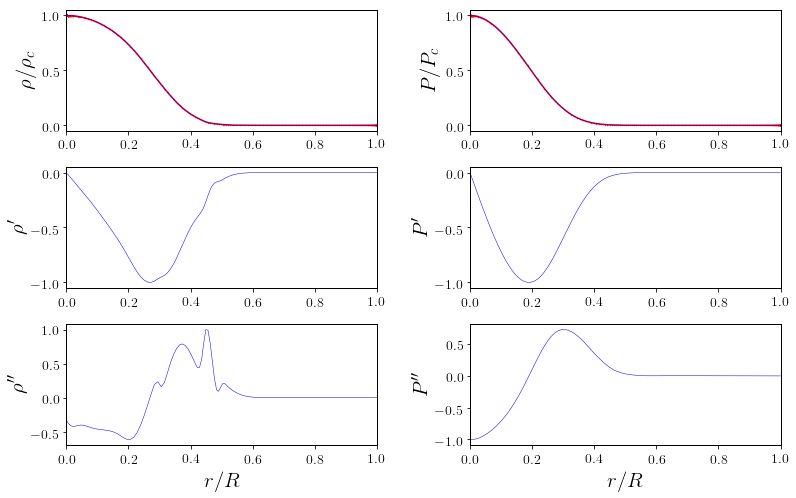

In [265]:
fig=plt.figure(figsize=[12.8,8])

plt.subplot(321)
plt.plot(ap2_145[-1]/ap2_145[-1][-1],ap2_145[2]/ap2_145[2][0],color='red',marker='o',markersize='0.4') 
plt.plot(ap2_145[-1]/ap2_145[-1][-1],ap2_145rho(ap2_145[-1])/ap2_145[2][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1) # leaving the crust out

plt.subplot(322)
plt.plot(ap2_145[-1]/ap2_145[-1][-1],ap2_145[1]/ap2_145[1][0],color='red',marker='o',markersize='0.4') 
plt.plot(ap2_145[-1]/ap2_145[-1][-1],ap2_145p(ap2_145[-1])/ap2_145[1][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$P/P_c$')
plt.xlim(0,1)

plt.subplot(323)
plt.plot(ap2_145[-1]/ap2_145[-1][-1],ap2_145drho(ap2_145[-1])/max(abs(ap2_145drho(ap2_145[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime}$')
plt.xlim(0,1)
#plt.ylim(-500,0)

plt.subplot(324)
plt.plot(ap2_145[-1]/ap2_145[-1][-1],ap2_145dp(ap2_145[-1])/max(abs(ap2_145dp(ap2_145[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime} $')
plt.xlim(0,1)

plt.subplot(325)
plt.plot(ap2_145[-1]/ap2_145[-1][-1],ap2_145ddrho(ap2_145[-1])/max(abs(ap2_145ddrho(ap2_145[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}$')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-0.01,0.01)

plt.subplot(326)
plt.plot(ap2_145[-1]/ap2_145[-1][-1],ap2_145ddp(ap2_145[-1])/max(abs(ap2_145ddp(ap2_145[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime\prime}$ ')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-1,1)

fig.subplots_adjust(hspace=0.3,wspace=0.3)

#plt.savefig('figures/ddsap2_145.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

### 15.0

In [14]:
ap2_150=np.loadtxt('results/ap2/15.0.dat',unpack=True)
ap2_150[3] = ap2_150[3]-ap2_150[3][-1] + 0.5*np.log(1-2*ap2_150[0][-1]/ap2_150[-1][-1])

In [20]:
s1=1e-6
s2=1e-15
ap2_150rho=interpolate.UnivariateSpline(ap2_150[-1], ap2_150[2], k=5, s=s1)
ap2_150drho=interpolate.UnivariateSpline(ap2_150[-1], ap2_150[2], k=5, s=s1).derivative(n=1)
ap2_150ddrho=interpolate.UnivariateSpline(ap2_150[-1], ap2_150[2], k=5, s=s1).derivative(n=2)

ap2_150p=interpolate.UnivariateSpline(ap2_150[-1], ap2_150[1], k=5, s=s2)
ap2_150dp=interpolate.UnivariateSpline(ap2_150[-1], ap2_150[1], k=5, s=s2).derivative(n=1)
ap2_150ddp=interpolate.UnivariateSpline(ap2_150[-1], ap2_150[1], k=5, s=s2).derivative(n=2)

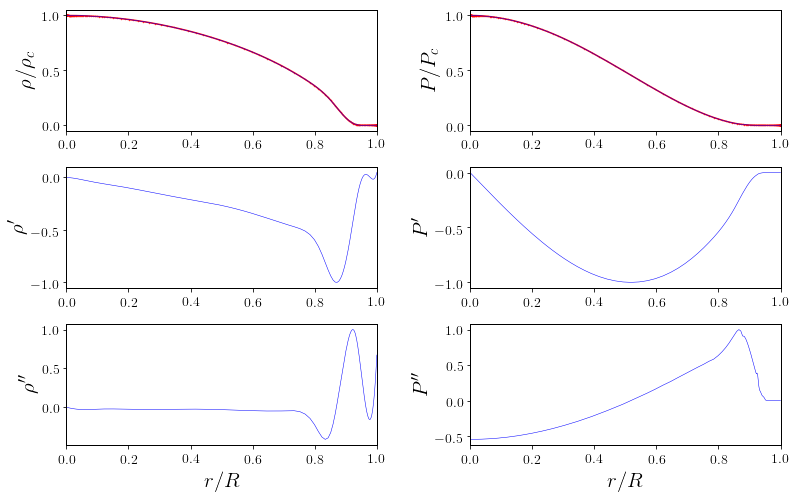

In [268]:
fig=plt.figure(figsize=[12.8,8])

plt.subplot(321)
plt.plot(ap2_150[-1]/ap2_150[-1][-1],ap2_150[2]/ap2_150[2][0],color='red',marker='o',markersize='0.4') 
plt.plot(ap2_150[-1]/ap2_150[-1][-1],ap2_150rho(ap2_150[-1])/ap2_150[2][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1) # leaving the crust out

plt.subplot(322)
plt.plot(ap2_150[-1]/ap2_150[-1][-1],ap2_150[1]/ap2_150[1][0],color='red',marker='o',markersize='0.4') 
plt.plot(ap2_150[-1]/ap2_150[-1][-1],ap2_150p(ap2_150[-1])/ap2_150[1][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$P/P_c$')
plt.xlim(0,1)

plt.subplot(323)
plt.plot(ap2_150[-1]/ap2_150[-1][-1],ap2_150drho(ap2_150[-1])/max(abs(ap2_150drho(ap2_150[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime}$')
plt.xlim(0,1)
#plt.ylim(-500,0)

plt.subplot(324)
plt.plot(ap2_150[-1]/ap2_150[-1][-1],ap2_150dp(ap2_150[-1])/max(abs(ap2_150dp(ap2_150[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime} $')
plt.xlim(0,1)

plt.subplot(325)
plt.plot(ap2_150[-1]/ap2_150[-1][-1],ap2_150ddrho(ap2_150[-1])/max(abs(ap2_150ddrho(ap2_150[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}$')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-0.01,0.01)

plt.subplot(326)
plt.plot(ap2_150[-1]/ap2_150[-1][-1],ap2_150ddp(ap2_150[-1])/max(abs(ap2_150ddp(ap2_150[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime\prime}$ ')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-1,1)

fig.subplots_adjust(hspace=0.3,wspace=0.3)

#plt.savefig('figures/ddsap2_150.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

### 15.5

In [16]:
ap2_155=np.loadtxt('results/ap2/15.5.dat',unpack=True)
ap2_155[3] = ap2_155[3]-ap2_155[3][-1] + 0.5*np.log(1-2*ap2_155[0][-1]/ap2_155[-1][-1])

In [17]:
s1=1e-5
s2=1e-9
ap2_155rho=interpolate.UnivariateSpline(ap2_155[-1], ap2_155[2], k=5, s=s1)
ap2_155drho=interpolate.UnivariateSpline(ap2_155[-1], ap2_155[2], k=5, s=s1).derivative(n=1)
ap2_155ddrho=interpolate.UnivariateSpline(ap2_155[-1], ap2_155[2], k=5, s=s1).derivative(n=2)

ap2_155p=interpolate.UnivariateSpline(ap2_155[-1], ap2_155[1], k=5, s=s2)
ap2_155dp=interpolate.UnivariateSpline(ap2_155[-1], ap2_155[1], k=5, s=s2).derivative(n=1)
ap2_155ddp=interpolate.UnivariateSpline(ap2_155[-1], ap2_155[1], k=5, s=s2).derivative(n=2)

ValueError: x must be strictly increasing

NameError: name 'ap2_155rho' is not defined

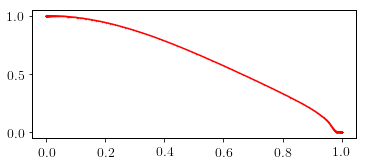

In [21]:
fig=plt.figure(figsize=[12.8,8])

plt.subplot(321)
plt.plot(ap2_155[-1]/ap2_155[-1][-1],ap2_155[2]/ap2_155[2][0],color='red',marker='o',markersize='0.4') 
plt.plot(ap2_155[-1]/ap2_155[-1][-1],ap2_155rho(ap2_155[-1])/ap2_155[2][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1) # leaving the crust out

plt.subplot(322)
plt.plot(ap2_155[-1]/ap2_155[-1][-1],ap2_155[1]/ap2_155[1][0],color='red',marker='o',markersize='0.4') 
plt.plot(ap2_155[-1]/ap2_155[-1][-1],ap2_155p(ap2_155[-1])/ap2_155[1][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$P/P_c$')
plt.xlim(0,1)

plt.subplot(323)
plt.plot(ap2_155[-1]/ap2_155[-1][-1],ap2_155drho(ap2_155[-1])/max(abs(ap2_155drho(ap2_155[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime}$')
plt.xlim(0,1)
#plt.ylim(-500,0)

plt.subplot(324)
plt.plot(ap2_155[-1]/ap2_155[-1][-1],ap2_155dp(ap2_155[-1])/max(abs(ap2_155dp(ap2_155[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime} $')
plt.xlim(0,1)

plt.subplot(325)
plt.plot(ap2_155[-1]/ap2_155[-1][-1],ap2_155ddrho(ap2_155[-1])/max(abs(ap2_155ddrho(ap2_155[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}$')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-0.01,0.01)

plt.subplot(326)
plt.plot(ap2_155[-1]/ap2_155[-1][-1],ap2_155ddp(ap2_155[-1])/max(abs(ap2_155ddp(ap2_155[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime\prime}$ ')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-1,1)

fig.subplots_adjust(hspace=0.3,wspace=0.3)

#plt.savefig('figures/ddsap2_155.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

## Adiabatic convection

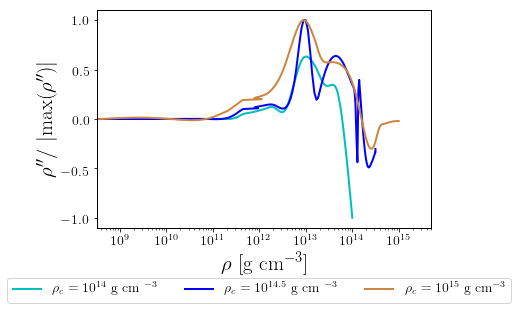

In [22]:
fig, ax = plt.subplots()

ax.set_xscale("log")

plt.plot(ap2_140[2]*rhodim,ap2_140ddrho(ap2_140[-1])/max(abs(ap2_140ddrho(ap2_140[-1]))),color='c',linewidth='2.0',label=r'$\rho_c=10^{14}$ g cm $^{-3}$') 
plt.plot(ap2_145[2]*rhodim,ap2_145ddrho(ap2_145[-1])/max(abs(ap2_145ddrho(ap2_145[-1]))),color='blue',linewidth='2.0',linestyle='-',label=r'$\rho_c=10^{14.5}$ g cm $^{-3}$') 
plt.plot(ap2_150[2]*rhodim,ap2_150ddrho(ap2_150[-1])/max(abs(ap2_150ddrho(ap2_150[-1]))),color='peru',linewidth='2.0',linestyle='-',label=r'$\rho_c=10^{15}$ g cm$ ^{-3}$')
plt.xlim(left=10**(8.5))
#plt.plot(ap2_155[-1]/ap2_155[-1][-1],ap2_155drho(ap2_155[-1])/max(abs(ap2_155drho(ap2_140[-1]))),color='yellow',linewidth='2.0',linestyle='-.',label=r'$\rho_c=10^{15.5}$ g cm$ ^{-3}$')

l = plt.legend(bbox_to_anchor=(1.1,-0.16), loc="lower right", 
                bbox_transform=fig.transFigure, ncol=3)

plt.xlabel(r'$\rho$ [g cm$^{-3}$]')
plt.ylabel(r'$\rho^{\prime \prime}/$ $|$max$(\rho^{\prime \prime})|$')
#plt.xlim(0,1.0)

plt.savefig('figures/ConvecStabilityap2Correl.pdf', format='pdf', dpi=1000,bbox_inches="tight")

## Redshift

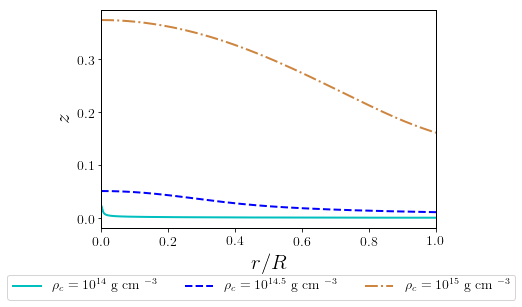

In [331]:
fig = plt.figure()

plt.plot(ap2_140[-1]/ap2_140[-1][-1],np.exp(-ap2_140[3])-1.0,color='c',linewidth='2.0',label=r'$\rho_c=10^{14}$ g cm $^{-3}$')
plt.plot(ap2_145[-1]/ap2_145[-1][-1],np.exp(-ap2_145[3])-1.0,color='blue',linewidth='2.0',linestyle='--',label=r'$\rho_c=10^{14.5}$ g cm $^{-3}$')
plt.plot(ap2_150[-1]/ap2_150[-1][-1],np.exp(-ap2_150[3])-1.0,color='peru',linewidth='2.0',linestyle='-.',label=r'$\rho_c=10^{15}$ g cm $^{-3}$')

l = plt.legend(bbox_to_anchor=(1.1,-0.15), loc="lower right", 
                bbox_transform=fig.transFigure, ncol=3)

plt.xlabel(r'$r/R$')
plt.ylabel(r'$z$')
plt.xlim(0,1.0)

plt.savefig('figures/Redshiftap2.pdf', format='pdf', dpi=1000,bbox_inches="tight")

# AP3 ----------------------------------------------------------------------------------------

In [332]:
rhoap3,Pap3,nap3=np.loadtxt('EOS/ap3.dat',usecols=(2,1,0),unpack=True)

## Dominant energy condition

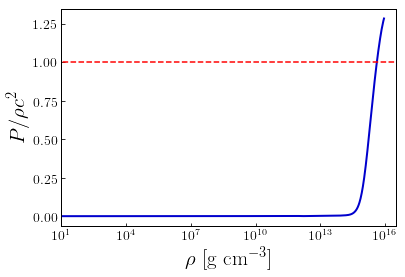

<Figure size 432x288 with 0 Axes>

In [333]:
fig, ax = plt.subplots()
plt.plot(rhoap3,np.divide(Pap3,rhoap3),lw='2',color='mediumblue')
plt.plot([0,10**(17)],[1.0,1.0],'r--',lw='1.5')

ax.set_xscale("log")
#locmaj = matplotlib.ticker.LogLocator(base=10.0,numticks=16) 
#ax.xaxis.set_major_locator(locmaj)


plt.xlabel(r'$\rho$ [g\,\,cm$^{-3}$]')
plt.ylabel(r'$ P / \rho c^2 $')
#locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks=16)
#ax.xaxis.set_minor_locator(locmin)
#ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.tick_params(axis="x", direction="in")
ax.tick_params(axis="y", direction="in")
plt.xlim(10,10**(16.5))
#ax.set_facecolor('floralwhite')
#plt.gca().set_aspect('equal', adjustable='box')
#plt.draw()
#plt.ylim(0,1)
plt.savefig('figures/ECap3.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()
plt.clf()

## Speed of sound

In [291]:
vsquared=interpolate.UnivariateSpline(rhoap3, Pap3, k=3, s=1e-25).derivative(n=1)

/home/dave/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  


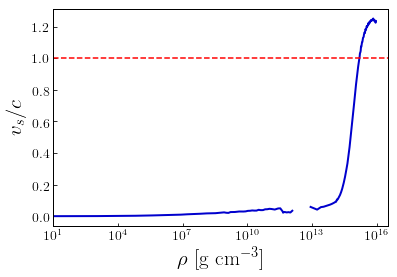

In [292]:
fig, ax = plt.subplots()
plt.plot(rhoap3,np.sqrt(vsquared(rhoap3)),lw='2.0',color='mediumblue')
plt.plot([1e+1,10**(16.5)],[1.0,1.0],'r--',lw='1.5')
plt.xlabel(r'$\rho$ [g\,\,cm$^{-3}$]')
plt.ylabel(r'$ v_s / c $')
plt.xscale('log')
ax.tick_params(axis="x", direction="in")
ax.tick_params(axis="y", direction="in")
plt.xlim(10,10**(16.5))
#ax.set_facecolor('floralwhite')
#mpl.rcParams['axes.linewidth'] = 1.4
#plt.gca().set_aspect('equal', adjustable='box')
#plt.draw()
plt.savefig('figures/SSap3.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

## M - $\rho_c$

In [299]:
Rap3,Map3,rhocap3=np.loadtxt('results/ap3/MRrhoc.dat',usecols=(0,1,2),unpack=True)

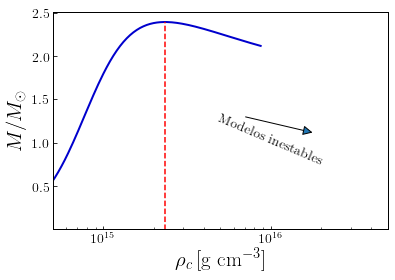

In [303]:
fig, ax = plt.subplots()

plt.plot(rhocap3,Map3,color='mediumblue',lw='2.0')
plt.plot([10**(np.log10(rhocap3[np.argmax(Map3)])),10**(np.log10(rhocap3[np.argmax(Map3)]))],[0.0,np.amax(Map3)],'r--',lw='1.5')

prop = dict(arrowstyle="-|>,head_width=0.4,head_length=0.8",
            shrinkA=0,shrinkB=0)
plt.annotate("", xy=(10**(16.25),1.12), xytext=(10**(15.85),1.3), arrowprops=prop)
#plt.arrow(10**(15.6), 1.38,10**(15.7) ,-0.1 , head_width=0.05, head_length=10**(15))
plt.text(10**(15.67), 1.23, 'Modelos inestables' , fontsize=14,rotation=-23)

plt.xscale('log')
plt.xlabel(r'$\rho_c\,[$g cm$^{-3}]$')
plt.ylabel(r'$M/M_{\odot}$')
plt.xlim(left=10**(14.7),right=10**(16.7))
plt.ylim(bottom=0.01)
ax.tick_params(axis="x", direction="in",which='both')
ax.tick_params(axis="y", direction="in",which='both')

plt.savefig('figures/Mrhorel_ap3.pdf', format='pdf', dpi=1000,bbox_inches="tight")

## Effective and critical adiabatic index

In [23]:
rhoscap3,betasap3,gamma_efsap3,gamma_crsap3 = aindex_stab('ap3')

ValueError: x must be strictly increasing

In [ ]:
fig, ax = plt.subplots()
plt.plot(betasap3,gamma_crsap3,lw='1.5',color='r',linestyle='--',label=r'$\gamma_{cr}$')
#plt.plot([betacrit,betacrit],[0,5])
plt.plot(betasap3,gamma_efsap3,lw='2.0',color='blue',label=r'$\langle \gamma \rangle$')

plt.xlabel(r'$\beta$')
plt.ylabel(r'$\langle \gamma \rangle$')

#plt.xscale('log')
#plt.xlim(left=10**(14.7),right=10**(16.7))
plt.ylim(0,6)
ax.tick_params(axis="x", direction="in",which='both')
ax.tick_params(axis="y", direction="in",which='both')
#l = plt.legend(bbox_to_anchor=(0.85,-0.15), loc="lower right", 
                #bbox_transform=fig.transFigure, ncol=2)



plt.savefig('figures/AIndexStabap3.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

## Tunning the interpolation of the solution

### 14.0

In [24]:
ap3_140=np.loadtxt('results/ap3/14.0.dat',unpack=True)
ap3_140[3] = ap3_140[3]-ap3_140[3][-1] + 0.5*np.log(1-2*ap3_140[0][-1]/ap3_140[-1][-1])

In [25]:
s1=5e-7
s2=1e-15
ap3_140rho=interpolate.UnivariateSpline(ap3_140[-1], ap3_140[2], k=5, s=s1)
ap3_140drho=interpolate.UnivariateSpline(ap3_140[-1], ap3_140[2], k=5, s=s1).derivative(n=1)
ap3_140ddrho=interpolate.UnivariateSpline(ap3_140[-1], ap3_140[2], k=5, s=s1).derivative(n=2)

ap3_140p=interpolate.UnivariateSpline(ap3_140[-1], ap3_140[1], k=5, s=s2)
ap3_140dp=interpolate.UnivariateSpline(ap3_140[-1], ap3_140[1], k=5, s=s2).derivative(n=1)
ap3_140ddp=interpolate.UnivariateSpline(ap3_140[-1], ap3_140[1], k=5, s=s2).derivative(n=2)

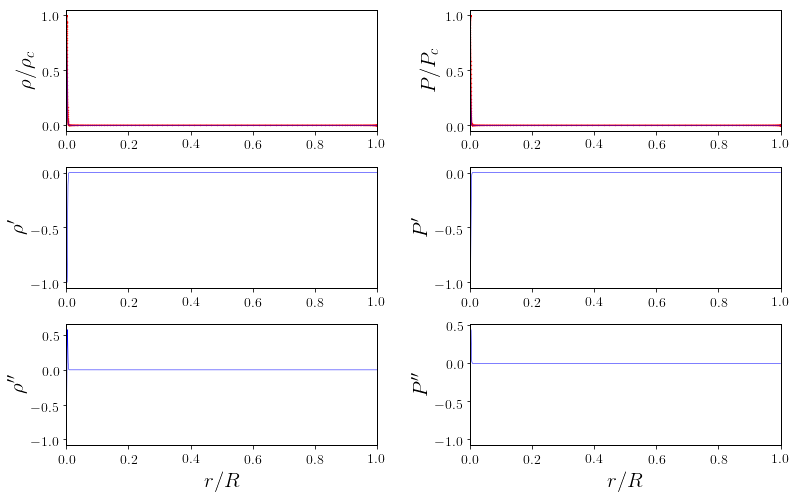

In [306]:
fig=plt.figure(figsize=[12.8,8])

plt.subplot(321)
plt.plot(ap3_140[-1]/ap3_140[-1][-1],ap3_140[2]/ap3_140[2][0],color='red',marker='o',markersize='0.4') 
plt.plot(ap3_140[-1]/ap3_140[-1][-1],ap3_140rho(ap3_140[-1])/ap3_140[2][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1) # leaving the crust out

plt.subplot(322)
plt.plot(ap3_140[-1]/ap3_140[-1][-1],ap3_140[1]/ap3_140[1][0],color='red',marker='o',markersize='0.4') 
plt.plot(ap3_140[-1]/ap3_140[-1][-1],ap3_140p(ap3_140[-1])/ap3_140[1][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$P/P_c$')
plt.xlim(0,1)

plt.subplot(323)
plt.plot(ap3_140[-1]/ap3_140[-1][-1],ap3_140drho(ap3_140[-1])/max(abs(ap3_140drho(ap3_140[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime}$')
plt.xlim(0,1)
#plt.ylim(-500,0)

plt.subplot(324)
plt.plot(ap3_140[-1]/ap3_140[-1][-1],ap3_140dp(ap3_140[-1])/max(abs(ap3_140dp(ap3_140[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime} $')
plt.xlim(0,1)

plt.subplot(325)
plt.plot(ap3_140[-1]/ap3_140[-1][-1],ap3_140ddrho(ap3_140[-1])/max(abs(ap3_140ddrho(ap3_140[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}$')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-0.01,0.01)

plt.subplot(326)
plt.plot(ap3_140[-1]/ap3_140[-1][-1],ap3_140ddp(ap3_140[-1])/max(abs(ap3_140ddp(ap3_140[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime\prime}$ ')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-1,1)

fig.subplots_adjust(hspace=0.3,wspace=0.3)

#plt.savefig('figures/ddsap3_140.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

### 14.5

In [26]:
ap3_145=np.loadtxt('results/ap3/14.5.dat',unpack=True)
ap3_145[3] = ap3_145[3]-ap3_145[3][-1] + 0.5*np.log(1-2*ap3_145[0][-1]/ap3_145[-1][-1])

In [27]:
s1=1e-7
s2=1e-12
ap3_145rho=interpolate.UnivariateSpline(ap3_145[-1], ap3_145[2], k=5, s=s1)
ap3_145drho=interpolate.UnivariateSpline(ap3_145[-1], ap3_145[2], k=5, s=s1).derivative(n=1)
ap3_145ddrho=interpolate.UnivariateSpline(ap3_145[-1], ap3_145[2], k=5, s=s1).derivative(n=2)

ap3_145p=interpolate.UnivariateSpline(ap3_145[-1], ap3_145[1], k=5, s=s2)
ap3_145dp=interpolate.UnivariateSpline(ap3_145[-1], ap3_145[1], k=5, s=s2).derivative(n=1)
ap3_145ddp=interpolate.UnivariateSpline(ap3_145[-1], ap3_145[1], k=5, s=s2).derivative(n=2)

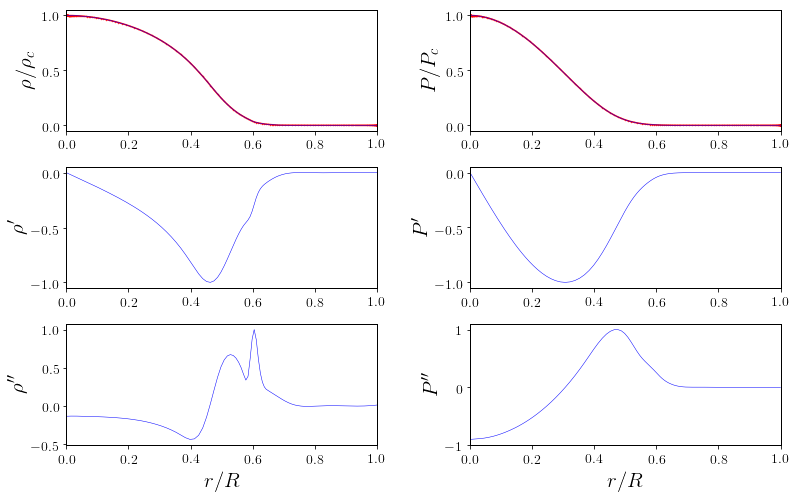

In [310]:
fig=plt.figure(figsize=[12.8,8])

plt.subplot(321)
plt.plot(ap3_145[-1]/ap3_145[-1][-1],ap3_145[2]/ap3_145[2][0],color='red',marker='o',markersize='0.4') 
plt.plot(ap3_145[-1]/ap3_145[-1][-1],ap3_145rho(ap3_145[-1])/ap3_145[2][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1) # leaving the crust out

plt.subplot(322)
plt.plot(ap3_145[-1]/ap3_145[-1][-1],ap3_145[1]/ap3_145[1][0],color='red',marker='o',markersize='0.4') 
plt.plot(ap3_145[-1]/ap3_145[-1][-1],ap3_145p(ap3_145[-1])/ap3_145[1][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$P/P_c$')
plt.xlim(0,1)

plt.subplot(323)
plt.plot(ap3_145[-1]/ap3_145[-1][-1],ap3_145drho(ap3_145[-1])/max(abs(ap3_145drho(ap3_145[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime}$')
plt.xlim(0,1)
#plt.ylim(-500,0)

plt.subplot(324)
plt.plot(ap3_145[-1]/ap3_145[-1][-1],ap3_145dp(ap3_145[-1])/max(abs(ap3_145dp(ap3_145[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime} $')
plt.xlim(0,1)

plt.subplot(325)
plt.plot(ap3_145[-1]/ap3_145[-1][-1],ap3_145ddrho(ap3_145[-1])/max(abs(ap3_145ddrho(ap3_145[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}$')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-0.01,0.01)

plt.subplot(326)
plt.plot(ap3_145[-1]/ap3_145[-1][-1],ap3_145ddp(ap3_145[-1])/max(abs(ap3_145ddp(ap3_145[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime\prime}$ ')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-1,1)

fig.subplots_adjust(hspace=0.3,wspace=0.3)

#plt.savefig('figures/ddsap3_145.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

### 15.0

In [28]:
ap3_150=np.loadtxt('results/ap3/15.0.dat',unpack=True)
ap3_150[3] = ap3_150[3]-ap3_150[3][-1] + 0.5*np.log(1-2*ap3_150[0][-1]/ap3_150[-1][-1])

In [29]:
s1=8e-6
s2=1e-15
ap3_150rho=interpolate.UnivariateSpline(ap3_150[-1], ap3_150[2], k=5, s=s1)
ap3_150drho=interpolate.UnivariateSpline(ap3_150[-1], ap3_150[2], k=5, s=s1).derivative(n=1)
ap3_150ddrho=interpolate.UnivariateSpline(ap3_150[-1], ap3_150[2], k=5, s=s1).derivative(n=2)

ap3_150p=interpolate.UnivariateSpline(ap3_150[-1], ap3_150[1], k=5, s=s2)
ap3_150dp=interpolate.UnivariateSpline(ap3_150[-1], ap3_150[1], k=5, s=s2).derivative(n=1)
ap3_150ddp=interpolate.UnivariateSpline(ap3_150[-1], ap3_150[1], k=5, s=s2).derivative(n=2)

ValueError: x must be strictly increasing

In [ ]:
fig=plt.figure(figsize=[12.8,8])

plt.subplot(321)
plt.plot(ap3_150[-1]/ap3_150[-1][-1],ap3_150[2]/ap3_150[2][0],color='red',marker='o',markersize='0.4') 
plt.plot(ap3_150[-1]/ap3_150[-1][-1],ap3_150rho(ap3_150[-1])/ap3_150[2][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1) # leaving the crust out

plt.subplot(322)
plt.plot(ap3_150[-1]/ap3_150[-1][-1],ap3_150[1]/ap3_150[1][0],color='red',marker='o',markersize='0.4') 
plt.plot(ap3_150[-1]/ap3_150[-1][-1],ap3_150p(ap3_150[-1])/ap3_150[1][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$P/P_c$')
plt.xlim(0,1)

plt.subplot(323)
plt.plot(ap3_150[-1]/ap3_150[-1][-1],ap3_150drho(ap3_150[-1])/max(abs(ap3_150drho(ap3_150[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime}$')
plt.xlim(0,1)
#plt.ylim(-500,0)

plt.subplot(324)
plt.plot(ap3_150[-1]/ap3_150[-1][-1],ap3_150dp(ap3_150[-1])/max(abs(ap3_150dp(ap3_150[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime} $')
plt.xlim(0,1)

plt.subplot(325)
plt.plot(ap3_150[-1]/ap3_150[-1][-1],ap3_150ddrho(ap3_150[-1])/max(abs(ap3_150ddrho(ap3_150[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}$')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-0.01,0.01)

plt.subplot(326)
plt.plot(ap3_150[-1]/ap3_150[-1][-1],ap3_150ddp(ap3_150[-1])/max(abs(ap3_150ddp(ap3_150[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime\prime}$ ')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-1,1)

fig.subplots_adjust(hspace=0.3,wspace=0.3)

#plt.savefig('figures/ddsap3_150.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

### 15.5

In [334]:
ap3_155=np.loadtxt('results/ap3/15.5.dat',unpack=True)
ap3_155[3] = ap3_155[3]-ap3_155[3][-1] + 0.5*np.log(1-2*ap3_155[0][-1]/ap3_155[-1][-1])

In [335]:
s1=1e-5
s2=1e-9
ap3_155rho=interpolate.UnivariateSpline(ap3_155[-1], ap3_155[2], k=5, s=s1)
ap3_155drho=interpolate.UnivariateSpline(ap3_155[-1], ap3_155[2], k=5, s=s1).derivative(n=1)
ap3_155ddrho=interpolate.UnivariateSpline(ap3_155[-1], ap3_155[2], k=5, s=s1).derivative(n=2)

ap3_155p=interpolate.UnivariateSpline(ap3_155[-1], ap3_155[1], k=5, s=s2)
ap3_155dp=interpolate.UnivariateSpline(ap3_155[-1], ap3_155[1], k=5, s=s2).derivative(n=1)
ap3_155ddp=interpolate.UnivariateSpline(ap3_155[-1], ap3_155[1], k=5, s=s2).derivative(n=2)

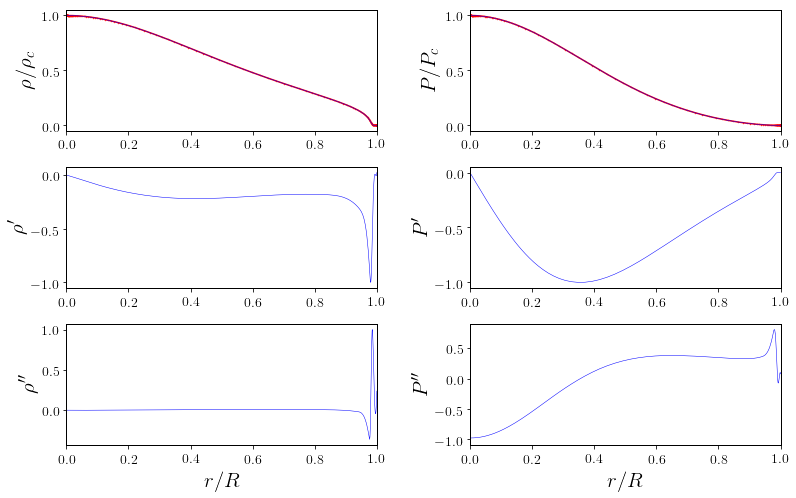

In [336]:
fig=plt.figure(figsize=[12.8,8])

plt.subplot(321)
plt.plot(ap3_155[-1]/ap3_155[-1][-1],ap3_155[2]/ap3_155[2][0],color='red',marker='o',markersize='0.4') 
plt.plot(ap3_155[-1]/ap3_155[-1][-1],ap3_155rho(ap3_155[-1])/ap3_155[2][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1) # leaving the crust out

plt.subplot(322)
plt.plot(ap3_155[-1]/ap3_155[-1][-1],ap3_155[1]/ap3_155[1][0],color='red',marker='o',markersize='0.4') 
plt.plot(ap3_155[-1]/ap3_155[-1][-1],ap3_155p(ap3_155[-1])/ap3_155[1][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$P/P_c$')
plt.xlim(0,1)

plt.subplot(323)
plt.plot(ap3_155[-1]/ap3_155[-1][-1],ap3_155drho(ap3_155[-1])/max(abs(ap3_155drho(ap3_155[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime}$')
plt.xlim(0,1)
#plt.ylim(-500,0)

plt.subplot(324)
plt.plot(ap3_155[-1]/ap3_155[-1][-1],ap3_155dp(ap3_155[-1])/max(abs(ap3_155dp(ap3_155[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime} $')
plt.xlim(0,1)

plt.subplot(325)
plt.plot(ap3_155[-1]/ap3_155[-1][-1],ap3_155ddrho(ap3_155[-1])/max(abs(ap3_155ddrho(ap3_155[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}$')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-0.01,0.01)

plt.subplot(326)
plt.plot(ap3_155[-1]/ap3_155[-1][-1],ap3_155ddp(ap3_155[-1])/max(abs(ap3_155ddp(ap3_155[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime\prime}$ ')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-1,1)

fig.subplots_adjust(hspace=0.3,wspace=0.3)

#plt.savefig('figures/ddsap3_155.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

## Adiabatic convection

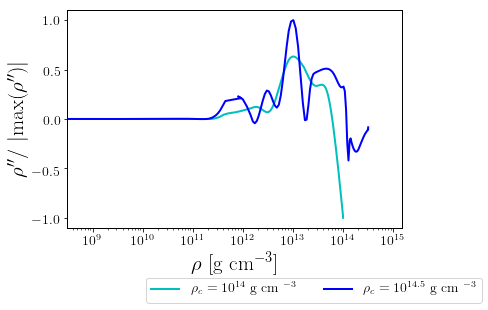

In [30]:
fig, ax = plt.subplots()

ax.set_xscale("log")

plt.plot(ap3_140[2]*rhodim,ap3_140ddrho(ap3_140[-1])/max(abs(ap3_140ddrho(ap3_140[-1]))),color='c',linewidth='2.0',label=r'$\rho_c=10^{14}$ g cm $^{-3}$') 
plt.plot(ap3_145[2]*rhodim,ap3_145ddrho(ap3_145[-1])/max(abs(ap3_145ddrho(ap3_145[-1]))),color='blue',linewidth='2.0',linestyle='-',label=r'$\rho_c=10^{14.5}$ g cm $^{-3}$') 
#plt.plot(ap3_150[2]*rhodim,ap3_150ddrho(ap3_150[-1])/max(abs(ap3_150ddrho(ap3_150[-1]))),color='peru',linewidth='2.0',linestyle='-',label=r'$\rho_c=10^{15}$ g cm$ ^{-3}$')
plt.xlim(left=10**(8.5))
#plt.plot(ap3_155[-1]/ap3_155[-1][-1],ap3_155drho(ap3_155[-1])/max(abs(ap3_155drho(ap3_140[-1]))),color='yellow',linewidth='2.0',linestyle='-.',label=r'$\rho_c=10^{15.5}$ g cm$ ^{-3}$')

l = plt.legend(bbox_to_anchor=(1.1,-0.16), loc="lower right", 
                bbox_transform=fig.transFigure, ncol=3)

plt.xlabel(r'$\rho$ [g cm$^{-3}$]')
plt.ylabel(r'$\rho^{\prime \prime}/$ $|$max$(\rho^{\prime \prime})|$')
#plt.xlim(0,1.0)

plt.savefig('figures/ConvecStabilityap3Correl.pdf', format='pdf', dpi=1000,bbox_inches="tight")

## Redshift

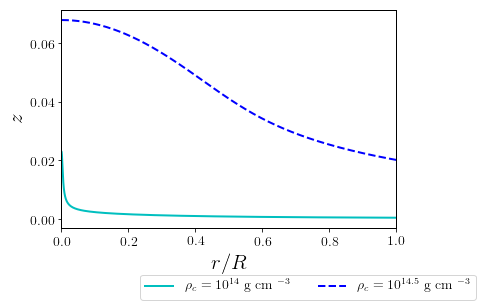

In [31]:
fig = plt.figure()

plt.plot(ap3_140[-1]/ap3_140[-1][-1],np.exp(-ap3_140[3])-1.0,color='c',linewidth='2.0',label=r'$\rho_c=10^{14}$ g cm $^{-3}$')
plt.plot(ap3_145[-1]/ap3_145[-1][-1],np.exp(-ap3_145[3])-1.0,color='blue',linewidth='2.0',linestyle='--',label=r'$\rho_c=10^{14.5}$ g cm $^{-3}$')
#plt.plot(ap3_150[-1]/ap3_150[-1][-1],np.exp(-ap3_150[3])-1.0,color='peru',linewidth='2.0',linestyle='-.',label=r'$\rho_c=10^{15}$ g cm $^{-3}$')

l = plt.legend(bbox_to_anchor=(1.1,-0.15), loc="lower right", 
                bbox_transform=fig.transFigure, ncol=3)

plt.xlabel(r'$r/R$')
plt.ylabel(r'$z$')
plt.xlim(0,1.0)

plt.savefig('figures/Redshiftap3.pdf', format='pdf', dpi=1000,bbox_inches="tight")

# AP4 -----------------------------------------------------------------------------------------

In [63]:
rhoap4,Pap4,nap4=np.loadtxt('EOS/ap4.dat',usecols=(2,1,0),unpack=True)

## Dominant energy condition

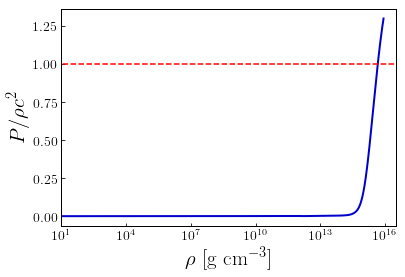

<Figure size 432x288 with 0 Axes>

In [64]:
fig, ax = plt.subplots()
plt.plot(rhoap4,np.divide(Pap4,rhoap4),lw='2',color='mediumblue')
plt.plot([0,10**(17)],[1.0,1.0],'r--',lw='1.5')

ax.set_xscale("log")
#locmaj = matplotlib.ticker.LogLocator(base=10.0,numticks=16) 
#ax.xaxis.set_major_locator(locmaj)


plt.xlabel(r'$\rho$ [g\,\,cm$^{-3}$]')
plt.ylabel(r'$ P / \rho c^2 $')
#locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks=16)
#ax.xaxis.set_minor_locator(locmin)
#ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.tick_params(axis="x", direction="in")
ax.tick_params(axis="y", direction="in")
plt.xlim(10,10**(16.5))
#ax.set_facecolor('floralwhite')
#plt.gca().set_aspect('equal', adjustable='box')
#plt.draw()
#plt.ylim(0,1)
plt.savefig('figures/ECap4.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()
plt.clf()

## Speed of sound

In [369]:
vsquared=interpolate.UnivariateSpline(rhoap4, Pap4, k=3, s=0).derivative(n=1)

/home/dave/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  


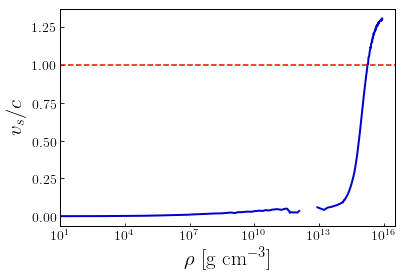

In [370]:
fig, ax = plt.subplots()
plt.plot(rhoap4,np.sqrt(vsquared(rhoap4)),lw='2.0',color='mediumblue')
plt.plot([1e+1,10**(16.5)],[1.0,1.0],'r--',lw='1.5')
plt.xlabel(r'$\rho$ [g\,\,cm$^{-3}$]')
plt.ylabel(r'$ v_s / c $')
plt.xscale('log')
ax.tick_params(axis="x", direction="in")
ax.tick_params(axis="y", direction="in")
plt.xlim(10,10**(16.5))
#ax.set_facecolor('floralwhite')
#mpl.rcParams['axes.linewidth'] = 1.4
#plt.gca().set_aspect('equal', adjustable='box')
#plt.draw()
plt.savefig('figures/SSap4.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

## M - $\rho_c$

In [377]:
Rap4,Map4,rhocap4=np.loadtxt('results/ap4/MRrhoc.dat',usecols=(0,1,2),unpack=True)

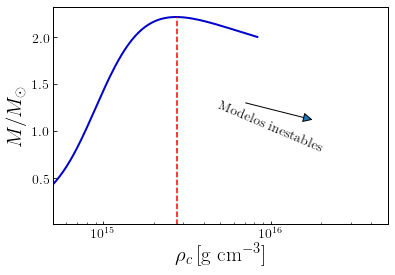

In [381]:
fig, ax = plt.subplots()

plt.plot(rhocap4,Map4,color='mediumblue',lw='2.0')
plt.plot([10**(np.log10(rhocap4[np.argmax(Map4)])),10**(np.log10(rhocap4[np.argmax(Map4)]))],[0.0,np.amax(Map4)],'r--',lw='1.5')

prop = dict(arrowstyle="-|>,head_width=0.4,head_length=0.8",
            shrinkA=0,shrinkB=0)
plt.annotate("", xy=(10**(16.25),1.12), xytext=(10**(15.85),1.3), arrowprops=prop)
#plt.arrow(10**(15.6), 1.38,10**(15.7) ,-0.1 , head_width=0.05, head_length=10**(15))
plt.text(10**(15.67), 1.23, 'Modelos inestables' , fontsize=14,rotation=-23)

plt.xscale('log')
plt.xlabel(r'$\rho_c\,[$g cm$^{-3}]$')
plt.ylabel(r'$M/M_{\odot}$')
plt.xlim(left=10**(14.7),right=10**(16.7))
plt.ylim(bottom=0.01)
ax.tick_params(axis="x", direction="in",which='both')
ax.tick_params(axis="y", direction="in",which='both')

plt.savefig('figures/Mrhorel_ap4.pdf', format='pdf', dpi=1000,bbox_inches="tight")

## Effective and critical adiabatic index

In [32]:
rhoscap4,betasap4,gamma_efsap4,gamma_crsap4 = aindex_stab('ap4')

ValueError: x must be strictly increasing

In [ ]:
fig, ax = plt.subplots()
plt.plot(betasap4,gamma_crsap4,lw='1.5',color='r',linestyle='--',label=r'$\gamma_{cr}$')
#plt.plot([betacrit,betacrit],[0,5])
plt.plot(betasap4,gamma_efsap4,lw='2.0',color='blue',label=r'$\langle \gamma \rangle$')

plt.xlabel(r'$\beta$')
plt.ylabel(r'$\langle \gamma \rangle$')

#plt.xscale('log')
#plt.xlim(left=10**(14.7),right=10**(16.7))
plt.ylim(0,6)
ax.tick_params(axis="x", direction="in",which='both')
ax.tick_params(axis="y", direction="in",which='both')
#l = plt.legend(bbox_to_anchor=(0.85,-0.15), loc="lower right", 
                #bbox_transform=fig.transFigure, ncol=2)



plt.savefig('figures/AIndexStabap4.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

## Tunning the interpolation of the solution

### 14.0

In [33]:
ap4_140=np.loadtxt('results/ap4/14.0.dat',unpack=True)
ap4_140[3] = ap4_140[3]-ap4_140[3][-1] + 0.5*np.log(1-2*ap4_140[0][-1]/ap4_140[-1][-1])

In [34]:
s1=5e-7
s2=1e-15
ap4_140rho=interpolate.UnivariateSpline(ap4_140[-1], ap4_140[2], k=5, s=s1)
ap4_140drho=interpolate.UnivariateSpline(ap4_140[-1], ap4_140[2], k=5, s=s1).derivative(n=1)
ap4_140ddrho=interpolate.UnivariateSpline(ap4_140[-1], ap4_140[2], k=5, s=s1).derivative(n=2)

ap4_140p=interpolate.UnivariateSpline(ap4_140[-1], ap4_140[1], k=5, s=s2)
ap4_140dp=interpolate.UnivariateSpline(ap4_140[-1], ap4_140[1], k=5, s=s2).derivative(n=1)
ap4_140ddp=interpolate.UnivariateSpline(ap4_140[-1], ap4_140[1], k=5, s=s2).derivative(n=2)

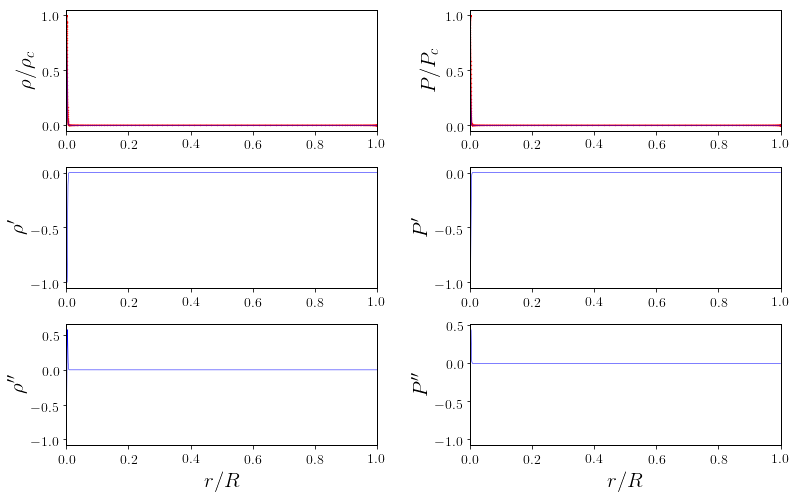

In [384]:
fig=plt.figure(figsize=[12.8,8])

plt.subplot(321)
plt.plot(ap4_140[-1]/ap4_140[-1][-1],ap4_140[2]/ap4_140[2][0],color='red',marker='o',markersize='0.4') 
plt.plot(ap4_140[-1]/ap4_140[-1][-1],ap4_140rho(ap4_140[-1])/ap4_140[2][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1) # leaving the crust out

plt.subplot(322)
plt.plot(ap4_140[-1]/ap4_140[-1][-1],ap4_140[1]/ap4_140[1][0],color='red',marker='o',markersize='0.4') 
plt.plot(ap4_140[-1]/ap4_140[-1][-1],ap4_140p(ap4_140[-1])/ap4_140[1][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$P/P_c$')
plt.xlim(0,1)

plt.subplot(323)
plt.plot(ap4_140[-1]/ap4_140[-1][-1],ap4_140drho(ap4_140[-1])/max(abs(ap4_140drho(ap4_140[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime}$')
plt.xlim(0,1)
#plt.ylim(-500,0)

plt.subplot(324)
plt.plot(ap4_140[-1]/ap4_140[-1][-1],ap4_140dp(ap4_140[-1])/max(abs(ap4_140dp(ap4_140[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime} $')
plt.xlim(0,1)

plt.subplot(325)
plt.plot(ap4_140[-1]/ap4_140[-1][-1],ap4_140ddrho(ap4_140[-1])/max(abs(ap4_140ddrho(ap4_140[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}$')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-0.01,0.01)

plt.subplot(326)
plt.plot(ap4_140[-1]/ap4_140[-1][-1],ap4_140ddp(ap4_140[-1])/max(abs(ap4_140ddp(ap4_140[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime\prime}$ ')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-1,1)

fig.subplots_adjust(hspace=0.3,wspace=0.3)

#plt.savefig('figures/ddsap4_140.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

### 14.5

In [35]:
ap4_145=np.loadtxt('results/ap4/14.5.dat',unpack=True)
ap4_145[3] = ap4_145[3]-ap4_145[3][-1] + 0.5*np.log(1-2*ap4_145[0][-1]/ap4_145[-1][-1])

In [36]:
s1=1e-7
s2=1e-12
ap4_145rho=interpolate.UnivariateSpline(ap4_145[-1], ap4_145[2], k=5, s=s1)
ap4_145drho=interpolate.UnivariateSpline(ap4_145[-1], ap4_145[2], k=5, s=s1).derivative(n=1)
ap4_145ddrho=interpolate.UnivariateSpline(ap4_145[-1], ap4_145[2], k=5, s=s1).derivative(n=2)

ap4_145p=interpolate.UnivariateSpline(ap4_145[-1], ap4_145[1], k=5, s=s2)
ap4_145dp=interpolate.UnivariateSpline(ap4_145[-1], ap4_145[1], k=5, s=s2).derivative(n=1)
ap4_145ddp=interpolate.UnivariateSpline(ap4_145[-1], ap4_145[1], k=5, s=s2).derivative(n=2)

In [387]:
ap4_145rho(0.4*ap4_145[-1][-1])*rhodim

136934509100509.03

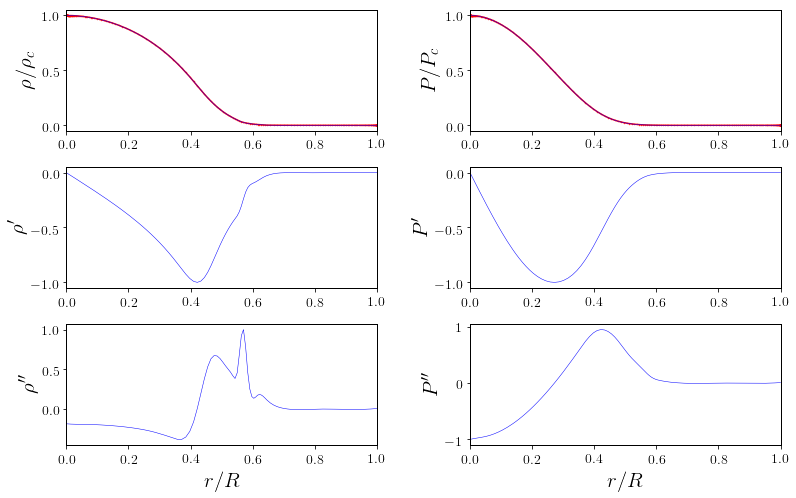

In [388]:
fig=plt.figure(figsize=[12.8,8])

plt.subplot(321)
plt.plot(ap4_145[-1]/ap4_145[-1][-1],ap4_145[2]/ap4_145[2][0],color='red',marker='o',markersize='0.4') 
plt.plot(ap4_145[-1]/ap4_145[-1][-1],ap4_145rho(ap4_145[-1])/ap4_145[2][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1) # leaving the crust out

plt.subplot(322)
plt.plot(ap4_145[-1]/ap4_145[-1][-1],ap4_145[1]/ap4_145[1][0],color='red',marker='o',markersize='0.4') 
plt.plot(ap4_145[-1]/ap4_145[-1][-1],ap4_145p(ap4_145[-1])/ap4_145[1][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$P/P_c$')
plt.xlim(0,1)

plt.subplot(323)
plt.plot(ap4_145[-1]/ap4_145[-1][-1],ap4_145drho(ap4_145[-1])/max(abs(ap4_145drho(ap4_145[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime}$')
plt.xlim(0,1)
#plt.ylim(-500,0)

plt.subplot(324)
plt.plot(ap4_145[-1]/ap4_145[-1][-1],ap4_145dp(ap4_145[-1])/max(abs(ap4_145dp(ap4_145[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime} $')
plt.xlim(0,1)

plt.subplot(325)
plt.plot(ap4_145[-1]/ap4_145[-1][-1],ap4_145ddrho(ap4_145[-1])/max(abs(ap4_145ddrho(ap4_145[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}$')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-0.01,0.01)

plt.subplot(326)
plt.plot(ap4_145[-1]/ap4_145[-1][-1],ap4_145ddp(ap4_145[-1])/max(abs(ap4_145ddp(ap4_145[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime\prime}$ ')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-1,1)

fig.subplots_adjust(hspace=0.3,wspace=0.3)

#plt.savefig('figures/ddsap4_145.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

### 15.0

In [37]:
ap4_150=np.loadtxt('results/ap4/15.0.dat',unpack=True)
ap4_150[3] = ap4_150[3]-ap4_150[3][-1] + 0.5*np.log(1-2*ap4_150[0][-1]/ap4_150[-1][-1])

In [38]:
s1=8e-6
s2=1e-15
ap4_150rho=interpolate.UnivariateSpline(ap4_150[-1], ap4_150[2], k=5, s=s1)
ap4_150drho=interpolate.UnivariateSpline(ap4_150[-1], ap4_150[2], k=5, s=s1).derivative(n=1)
ap4_150ddrho=interpolate.UnivariateSpline(ap4_150[-1], ap4_150[2], k=5, s=s1).derivative(n=2)

ap4_150p=interpolate.UnivariateSpline(ap4_150[-1], ap4_150[1], k=5, s=s2)
ap4_150dp=interpolate.UnivariateSpline(ap4_150[-1], ap4_150[1], k=5, s=s2).derivative(n=1)
ap4_150ddp=interpolate.UnivariateSpline(ap4_150[-1], ap4_150[1], k=5, s=s2).derivative(n=2)

ValueError: x must be strictly increasing

In [ ]:
fig=plt.figure(figsize=[12.8,8])

plt.subplot(321)
plt.plot(ap4_150[-1]/ap4_150[-1][-1],ap4_150[2]/ap4_150[2][0],color='red',marker='o',markersize='0.4') 
plt.plot(ap4_150[-1]/ap4_150[-1][-1],ap4_150rho(ap4_150[-1])/ap4_150[2][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1) # leaving the crust out

plt.subplot(322)
plt.plot(ap4_150[-1]/ap4_150[-1][-1],ap4_150[1]/ap4_150[1][0],color='red',marker='o',markersize='0.4') 
plt.plot(ap4_150[-1]/ap4_150[-1][-1],ap4_150p(ap4_150[-1])/ap4_150[1][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$P/P_c$')
plt.xlim(0,1)

plt.subplot(323)
plt.plot(ap4_150[-1]/ap4_150[-1][-1],ap4_150drho(ap4_150[-1])/max(abs(ap4_150drho(ap4_150[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime}$')
plt.xlim(0,1)
#plt.ylim(-500,0)

plt.subplot(324)
plt.plot(ap4_150[-1]/ap4_150[-1][-1],ap4_150dp(ap4_150[-1])/max(abs(ap4_150dp(ap4_150[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime} $')
plt.xlim(0,1)

plt.subplot(325)
plt.plot(ap4_150[-1]/ap4_150[-1][-1],ap4_150ddrho(ap4_150[-1])/max(abs(ap4_150ddrho(ap4_150[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}$')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-0.01,0.01)

plt.subplot(326)
plt.plot(ap4_150[-1]/ap4_150[-1][-1],ap4_150ddp(ap4_150[-1])/max(abs(ap4_150ddp(ap4_150[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime\prime}$ ')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-1,1)

fig.subplots_adjust(hspace=0.3,wspace=0.3)

#plt.savefig('figures/ddsap4_150.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

### 15.5

In [39]:
ap4_155=np.loadtxt('results/ap4/15.5.dat',unpack=True)
ap4_155[3] = ap4_155[3]-ap4_155[3][-1] + 0.5*np.log(1-2*ap4_155[0][-1]/ap4_155[-1][-1])

In [ ]:
s1=1e-5
s2=1e-9
ap4_155rho=interpolate.UnivariateSpline(ap4_155[-1], ap4_155[2], k=5, s=s1)
ap4_155drho=interpolate.UnivariateSpline(ap4_155[-1], ap4_155[2], k=5, s=s1).derivative(n=1)
ap4_155ddrho=interpolate.UnivariateSpline(ap4_155[-1], ap4_155[2], k=5, s=s1).derivative(n=2)

ap4_155p=interpolate.UnivariateSpline(ap4_155[-1], ap4_155[1], k=5, s=s2)
ap4_155dp=interpolate.UnivariateSpline(ap4_155[-1], ap4_155[1], k=5, s=s2).derivative(n=1)
ap4_155ddp=interpolate.UnivariateSpline(ap4_155[-1], ap4_155[1], k=5, s=s2).derivative(n=2)

In [ ]:
fig=plt.figure(figsize=[12.8,8])

plt.subplot(321)
plt.plot(ap4_155[-1]/ap4_155[-1][-1],ap4_155[2]/ap4_155[2][0],color='red',marker='o',markersize='0.4') 
plt.plot(ap4_155[-1]/ap4_155[-1][-1],ap4_155rho(ap4_155[-1])/ap4_155[2][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1) # leaving the crust out

plt.subplot(322)
plt.plot(ap4_155[-1]/ap4_155[-1][-1],ap4_155[1]/ap4_155[1][0],color='red',marker='o',markersize='0.4') 
plt.plot(ap4_155[-1]/ap4_155[-1][-1],ap4_155p(ap4_155[-1])/ap4_155[1][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$P/P_c$')
plt.xlim(0,1)

plt.subplot(323)
plt.plot(ap4_155[-1]/ap4_155[-1][-1],ap4_155drho(ap4_155[-1])/max(abs(ap4_155drho(ap4_155[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime}$')
plt.xlim(0,1)
#plt.ylim(-500,0)

plt.subplot(324)
plt.plot(ap4_155[-1]/ap4_155[-1][-1],ap4_155dp(ap4_155[-1])/max(abs(ap4_155dp(ap4_155[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime} $')
plt.xlim(0,1)

plt.subplot(325)
plt.plot(ap4_155[-1]/ap4_155[-1][-1],ap4_155ddrho(ap4_155[-1])/max(abs(ap4_155ddrho(ap4_155[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}$')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-0.01,0.01)

plt.subplot(326)
plt.plot(ap4_155[-1]/ap4_155[-1][-1],ap4_155ddp(ap4_155[-1])/max(abs(ap4_155ddp(ap4_155[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime\prime}$ ')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-1,1)

fig.subplots_adjust(hspace=0.3,wspace=0.3)

#plt.savefig('figures/ddsap4_155.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

## Adiabatic convection

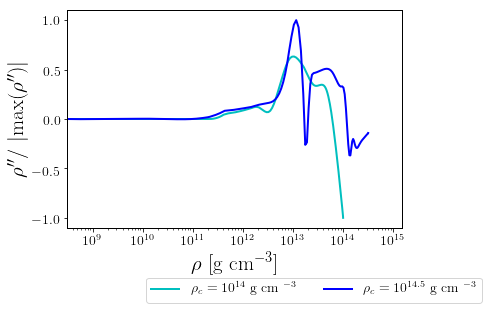

In [41]:
fig, ax = plt.subplots()

ax.set_xscale("log")

plt.plot(ap4_140[2]*rhodim,ap4_140ddrho(ap4_140[-1])/max(abs(ap4_140ddrho(ap4_140[-1]))),color='c',linewidth='2.0',label=r'$\rho_c=10^{14}$ g cm $^{-3}$') 
plt.plot(ap4_145[2]*rhodim,ap4_145ddrho(ap4_145[-1])/max(abs(ap4_145ddrho(ap4_145[-1]))),color='blue',linewidth='2.0',linestyle='-',label=r'$\rho_c=10^{14.5}$ g cm $^{-3}$') 
#plt.plot(ap4_150[2]*rhodim,ap4_150ddrho(ap4_150[-1])/max(abs(ap4_150ddrho(ap4_150[-1]))),color='peru',linewidth='2.0',linestyle='-',label=r'$\rho_c=10^{15}$ g cm$ ^{-3}$')
plt.xlim(left=10**(8.5))
#plt.plot(ap4_155[-1]/ap4_155[-1][-1],ap4_155drho(ap4_155[-1])/max(abs(ap4_155drho(ap4_140[-1]))),color='yellow',linewidth='2.0',linestyle='-.',label=r'$\rho_c=10^{15.5}$ g cm$ ^{-3}$')

l = plt.legend(bbox_to_anchor=(1.1,-0.16), loc="lower right", 
                bbox_transform=fig.transFigure, ncol=3)

plt.xlabel(r'$\rho$ [g cm$^{-3}$]')
plt.ylabel(r'$\rho^{\prime \prime}/$ $|$max$(\rho^{\prime \prime})|$')
#plt.xlim(0,1.0)

plt.savefig('figures/ConvecStabilityap4Correl.pdf', format='pdf', dpi=1000,bbox_inches="tight")

## Redshift

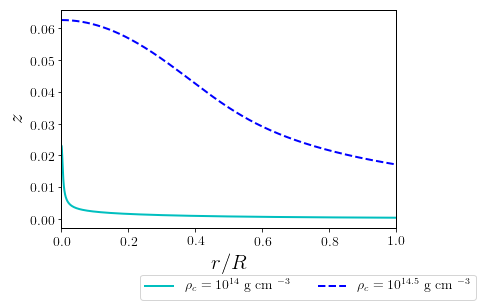

In [42]:
fig = plt.figure()

plt.plot(ap4_140[-1]/ap4_140[-1][-1],np.exp(-ap4_140[3])-1.0,color='c',linewidth='2.0',label=r'$\rho_c=10^{14}$ g cm $^{-3}$')
plt.plot(ap4_145[-1]/ap4_145[-1][-1],np.exp(-ap4_145[3])-1.0,color='blue',linewidth='2.0',linestyle='--',label=r'$\rho_c=10^{14.5}$ g cm $^{-3}$')
#plt.plot(ap4_150[-1]/ap4_150[-1][-1],np.exp(-ap4_150[3])-1.0,color='peru',linewidth='2.0',linestyle='-.',label=r'$\rho_c=10^{15}$ g cm $^{-3}$')

l = plt.legend(bbox_to_anchor=(1.1,-0.15), loc="lower right", 
                bbox_transform=fig.transFigure, ncol=3)

plt.xlabel(r'$r/R$')
plt.ylabel(r'$z$')
plt.xlim(0,1.0)

plt.savefig('figures/Redshiftap4.pdf', format='pdf', dpi=1000,bbox_inches="tight")

# BBB2 --------------------------------------------------------------------------------------------

In [106]:
rhobbb2,Pbbb2,nbbb2=np.loadtxt('EOS/bbb2.dat',usecols=(2,1,0),unpack=True)

## Dominant energy condition

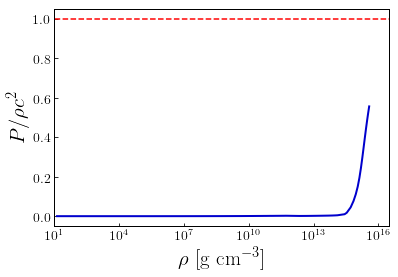

<Figure size 432x288 with 0 Axes>

In [107]:
fig, ax = plt.subplots()
plt.plot(rhobbb2,np.divide(Pbbb2,rhobbb2),lw='2',color='mediumblue')
plt.plot([0,10**(17)],[1.0,1.0],'r--',lw='1.5')

ax.set_xscale("log")
#locmaj = matplotlib.ticker.LogLocator(base=10.0,numticks=16) 
#ax.xaxis.set_major_locator(locmaj)


plt.xlabel(r'$\rho$ [g\,\,cm$^{-3}$]')
plt.ylabel(r'$ P / \rho c^2 $')
#locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks=16)
#ax.xaxis.set_minor_locator(locmin)
#ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.tick_params(axis="x", direction="in")
ax.tick_params(axis="y", direction="in")
plt.xlim(10,10**(16.5))
#ax.set_facecolor('floralwhite')
#plt.gca().set_aspect('equal', adjustable='box')
#plt.draw()
#plt.ylim(0,1)
plt.savefig('figures/ECbbb2.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()
plt.clf()

## Speed of sound

In [108]:
vsquared=interpolate.UnivariateSpline(rhobbb2, Pbbb2, k=3, s=0).derivative(n=1)

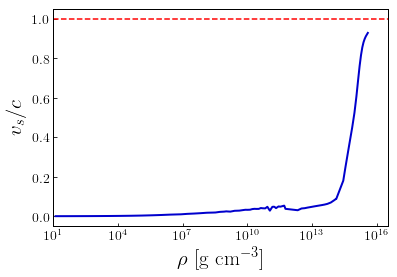

In [109]:
fig, ax = plt.subplots()
plt.plot(rhobbb2,np.sqrt(vsquared(rhobbb2)),lw='2.0',color='mediumblue')
plt.plot([1e+1,10**(16.5)],[1.0,1.0],'r--',lw='1.5')
plt.xlabel(r'$\rho$ [g\,\,cm$^{-3}$]')
plt.ylabel(r'$ v_s / c $')
plt.xscale('log')
ax.tick_params(axis="x", direction="in")
ax.tick_params(axis="y", direction="in")
plt.xlim(10,10**(16.5))
#ax.set_facecolor('floralwhite')
#mpl.rcParams['axes.linewidth'] = 1.4
#plt.gca().set_aspect('equal', adjustable='box')
#plt.draw()
plt.savefig('figures/SSbbb2.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

## M - $\rho_c$

In [116]:
Rbbb2,Mbbb2,rhocbbb2=np.loadtxt('results/bbb2/MRrhoc.dat',usecols=(0,1,2),unpack=True)

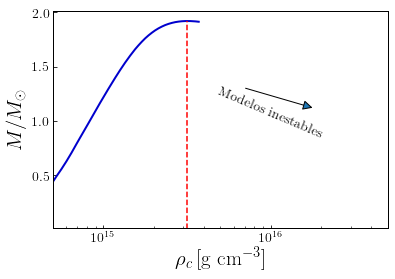

In [120]:
fig, ax = plt.subplots()

plt.plot(rhocbbb2,Mbbb2,color='mediumblue',lw='2.0')
plt.plot([10**(np.log10(rhocbbb2[np.argmax(Mbbb2)])),10**(np.log10(rhocbbb2[np.argmax(Mbbb2)]))],[0.0,np.amax(Mbbb2)],'r--',lw='1.5')

prop = dict(arrowstyle="-|>,head_width=0.4,head_length=0.8",
            shrinkA=0,shrinkB=0)
plt.annotate("", xy=(10**(16.25),1.12), xytext=(10**(15.85),1.3), arrowprops=prop)
#plt.arrow(10**(15.6), 1.38,10**(15.7) ,-0.1 , head_width=0.05, head_length=10**(15))
plt.text(10**(15.67), 1.23, 'Modelos inestables' , fontsize=14,rotation=-23)

plt.xscale('log')
plt.xlabel(r'$\rho_c\,[$g cm$^{-3}]$')
plt.ylabel(r'$M/M_{\odot}$')
plt.xlim(left=10**(14.7),right=10**(16.7))
plt.ylim(bottom=0.01)
ax.tick_params(axis="x", direction="in",which='both')
ax.tick_params(axis="y", direction="in",which='both')

plt.savefig('figures/Mrhorel_bbb2.pdf', format='pdf', dpi=1000,bbox_inches="tight")

## Effective and critical adiabatic index

In [43]:
rhoscbbb2,betasbbb2,gamma_efsbbb2,gamma_crsbbb2 = aindex_stab('bbb2')

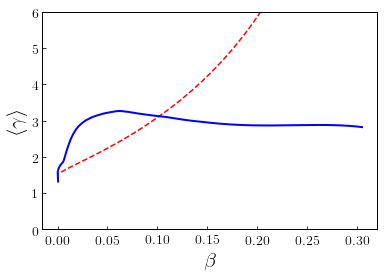

In [44]:
fig, ax = plt.subplots()
plt.plot(betasbbb2,gamma_crsbbb2,lw='1.5',color='r',linestyle='--',label=r'$\gamma_{cr}$')
#plt.plot([betacrit,betacrit],[0,5])
plt.plot(betasbbb2,gamma_efsbbb2,lw='2.0',color='blue',label=r'$\langle \gamma \rangle$')

plt.xlabel(r'$\beta$')
plt.ylabel(r'$\langle \gamma \rangle$')

#plt.xscale('log')
#plt.xlim(left=10**(14.7),right=10**(16.7))
plt.ylim(0,6)
ax.tick_params(axis="x", direction="in",which='both')
ax.tick_params(axis="y", direction="in",which='both')
#l = plt.legend(bbox_to_anchor=(0.85,-0.15), loc="lower right", 
                #bbox_transform=fig.transFigure, ncol=2)



plt.savefig('figures/AIndexStabbbb2.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

## Tunning the interpolation of the solution

### 14.0

In [45]:
bbb2_140=np.loadtxt('results/bbb2/14.0.dat',unpack=True)
bbb2_140[3] = bbb2_140[3]-bbb2_140[3][-1] + 0.5*np.log(1-2*bbb2_140[0][-1]/bbb2_140[-1][-1])

In [46]:
s1=5e-7
s2=1e-15
bbb2_140rho=interpolate.UnivariateSpline(bbb2_140[-1], bbb2_140[2], k=5, s=s1)
bbb2_140drho=interpolate.UnivariateSpline(bbb2_140[-1], bbb2_140[2], k=5, s=s1).derivative(n=1)
bbb2_140ddrho=interpolate.UnivariateSpline(bbb2_140[-1], bbb2_140[2], k=5, s=s1).derivative(n=2)

bbb2_140p=interpolate.UnivariateSpline(bbb2_140[-1], bbb2_140[1], k=5, s=s2)
bbb2_140dp=interpolate.UnivariateSpline(bbb2_140[-1], bbb2_140[1], k=5, s=s2).derivative(n=1)
bbb2_140ddp=interpolate.UnivariateSpline(bbb2_140[-1], bbb2_140[1], k=5, s=s2).derivative(n=2)

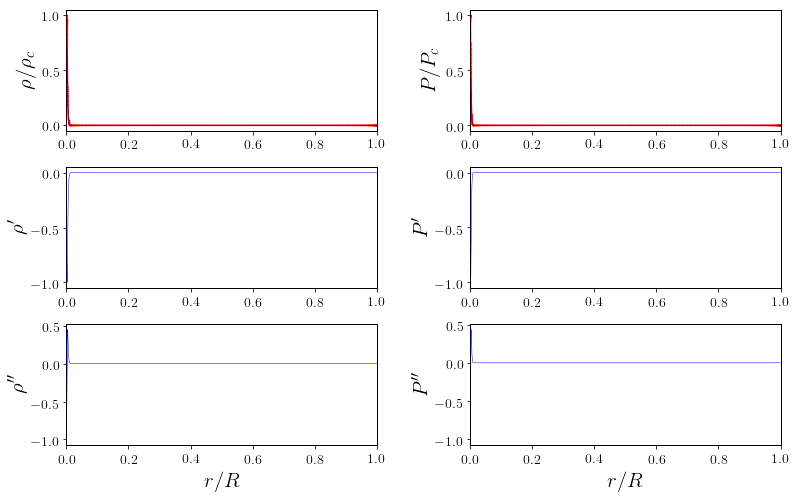

In [123]:
fig=plt.figure(figsize=[12.8,8])

plt.subplot(321)
plt.plot(bbb2_140[-1]/bbb2_140[-1][-1],bbb2_140[2]/bbb2_140[2][0],color='red',marker='o',markersize='0.4') 
plt.plot(bbb2_140[-1]/bbb2_140[-1][-1],bbb2_140rho(bbb2_140[-1])/bbb2_140[2][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1) # leaving the crust out

plt.subplot(322)
plt.plot(bbb2_140[-1]/bbb2_140[-1][-1],bbb2_140[1]/bbb2_140[1][0],color='red',marker='o',markersize='0.4') 
plt.plot(bbb2_140[-1]/bbb2_140[-1][-1],bbb2_140p(bbb2_140[-1])/bbb2_140[1][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$P/P_c$')
plt.xlim(0,1)

plt.subplot(323)
plt.plot(bbb2_140[-1]/bbb2_140[-1][-1],bbb2_140drho(bbb2_140[-1])/max(abs(bbb2_140drho(bbb2_140[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime}$')
plt.xlim(0,1)
#plt.ylim(-500,0)

plt.subplot(324)
plt.plot(bbb2_140[-1]/bbb2_140[-1][-1],bbb2_140dp(bbb2_140[-1])/max(abs(bbb2_140dp(bbb2_140[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime} $')
plt.xlim(0,1)

plt.subplot(325)
plt.plot(bbb2_140[-1]/bbb2_140[-1][-1],bbb2_140ddrho(bbb2_140[-1])/max(abs(bbb2_140ddrho(bbb2_140[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}$')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-0.01,0.01)

plt.subplot(326)
plt.plot(bbb2_140[-1]/bbb2_140[-1][-1],bbb2_140ddp(bbb2_140[-1])/max(abs(bbb2_140ddp(bbb2_140[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime\prime}$ ')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-1,1)

fig.subplots_adjust(hspace=0.3,wspace=0.3)

#plt.savefig('figures/ddsbbb2_140.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

### 14.5

In [47]:
bbb2_145=np.loadtxt('results/bbb2/14.5.dat',unpack=True)
bbb2_145[3] = bbb2_145[3]-bbb2_145[3][-1] + 0.5*np.log(1-2*bbb2_145[0][-1]/bbb2_145[-1][-1])

In [48]:
s1=1e-7
s2=1e-12
bbb2_145rho=interpolate.UnivariateSpline(bbb2_145[-1], bbb2_145[2], k=5, s=s1)
bbb2_145drho=interpolate.UnivariateSpline(bbb2_145[-1], bbb2_145[2], k=5, s=s1).derivative(n=1)
bbb2_145ddrho=interpolate.UnivariateSpline(bbb2_145[-1], bbb2_145[2], k=5, s=s1).derivative(n=2)

bbb2_145p=interpolate.UnivariateSpline(bbb2_145[-1], bbb2_145[1], k=5, s=s2)
bbb2_145dp=interpolate.UnivariateSpline(bbb2_145[-1], bbb2_145[1], k=5, s=s2).derivative(n=1)
bbb2_145ddp=interpolate.UnivariateSpline(bbb2_145[-1], bbb2_145[1], k=5, s=s2).derivative(n=2)

In [126]:
bbb2_145rho(0.4*bbb2_145[-1][-1])*rhodim

36456760644896.164

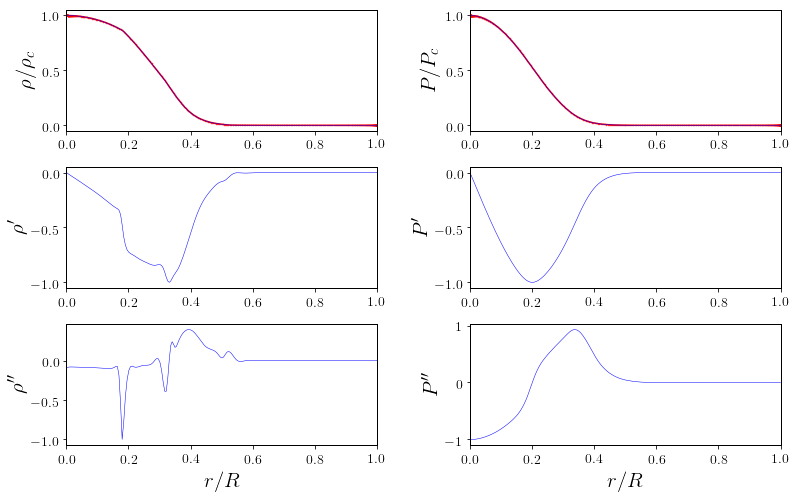

In [127]:
fig=plt.figure(figsize=[12.8,8])

plt.subplot(321)
plt.plot(bbb2_145[-1]/bbb2_145[-1][-1],bbb2_145[2]/bbb2_145[2][0],color='red',marker='o',markersize='0.4') 
plt.plot(bbb2_145[-1]/bbb2_145[-1][-1],bbb2_145rho(bbb2_145[-1])/bbb2_145[2][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1) # leaving the crust out

plt.subplot(322)
plt.plot(bbb2_145[-1]/bbb2_145[-1][-1],bbb2_145[1]/bbb2_145[1][0],color='red',marker='o',markersize='0.4') 
plt.plot(bbb2_145[-1]/bbb2_145[-1][-1],bbb2_145p(bbb2_145[-1])/bbb2_145[1][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$P/P_c$')
plt.xlim(0,1)

plt.subplot(323)
plt.plot(bbb2_145[-1]/bbb2_145[-1][-1],bbb2_145drho(bbb2_145[-1])/max(abs(bbb2_145drho(bbb2_145[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime}$')
plt.xlim(0,1)
#plt.ylim(-500,0)

plt.subplot(324)
plt.plot(bbb2_145[-1]/bbb2_145[-1][-1],bbb2_145dp(bbb2_145[-1])/max(abs(bbb2_145dp(bbb2_145[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime} $')
plt.xlim(0,1)

plt.subplot(325)
plt.plot(bbb2_145[-1]/bbb2_145[-1][-1],bbb2_145ddrho(bbb2_145[-1])/max(abs(bbb2_145ddrho(bbb2_145[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}$')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-0.01,0.01)

plt.subplot(326)
plt.plot(bbb2_145[-1]/bbb2_145[-1][-1],bbb2_145ddp(bbb2_145[-1])/max(abs(bbb2_145ddp(bbb2_145[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime\prime}$ ')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-1,1)

fig.subplots_adjust(hspace=0.3,wspace=0.3)

#plt.savefig('figures/ddsbbb2_145.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

### 15.0

In [49]:
bbb2_150=np.loadtxt('results/bbb2/15.0.dat',unpack=True)
bbb2_150[3] = bbb2_150[3]-bbb2_150[3][-1] + 0.5*np.log(1-2*bbb2_150[0][-1]/bbb2_150[-1][-1])

In [50]:
s1=8e-7
s2=1e-15
bbb2_150rho=interpolate.UnivariateSpline(bbb2_150[-1], bbb2_150[2], k=5, s=s1)
bbb2_150drho=interpolate.UnivariateSpline(bbb2_150[-1], bbb2_150[2], k=5, s=s1).derivative(n=1)
bbb2_150ddrho=interpolate.UnivariateSpline(bbb2_150[-1], bbb2_150[2], k=5, s=s1).derivative(n=2)

bbb2_150p=interpolate.UnivariateSpline(bbb2_150[-1], bbb2_150[1], k=5, s=s2)
bbb2_150dp=interpolate.UnivariateSpline(bbb2_150[-1], bbb2_150[1], k=5, s=s2).derivative(n=1)
bbb2_150ddp=interpolate.UnivariateSpline(bbb2_150[-1], bbb2_150[1], k=5, s=s2).derivative(n=2)

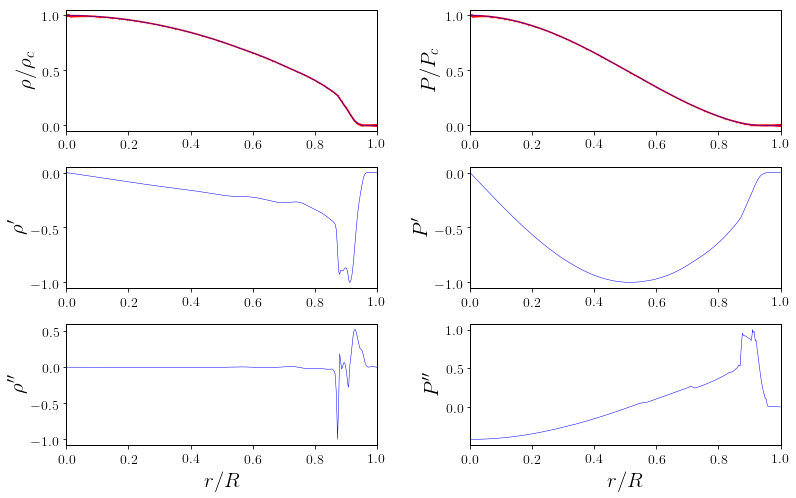

In [145]:
fig=plt.figure(figsize=[12.8,8])

plt.subplot(321)
plt.plot(bbb2_150[-1]/bbb2_150[-1][-1],bbb2_150[2]/bbb2_150[2][0],color='red',marker='o',markersize='0.4') 
plt.plot(bbb2_150[-1]/bbb2_150[-1][-1],bbb2_150rho(bbb2_150[-1])/bbb2_150[2][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1) # leaving the crust out

plt.subplot(322)
plt.plot(bbb2_150[-1]/bbb2_150[-1][-1],bbb2_150[1]/bbb2_150[1][0],color='red',marker='o',markersize='0.4') 
plt.plot(bbb2_150[-1]/bbb2_150[-1][-1],bbb2_150p(bbb2_150[-1])/bbb2_150[1][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$P/P_c$')
plt.xlim(0,1)

plt.subplot(323)
plt.plot(bbb2_150[-1]/bbb2_150[-1][-1],bbb2_150drho(bbb2_150[-1])/max(abs(bbb2_150drho(bbb2_150[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime}$')
plt.xlim(0,1)
#plt.ylim(-500,0)

plt.subplot(324)
plt.plot(bbb2_150[-1]/bbb2_150[-1][-1],bbb2_150dp(bbb2_150[-1])/max(abs(bbb2_150dp(bbb2_150[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime} $')
plt.xlim(0,1)

plt.subplot(325)
plt.plot(bbb2_150[-1]/bbb2_150[-1][-1],bbb2_150ddrho(bbb2_150[-1])/max(abs(bbb2_150ddrho(bbb2_150[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}$')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-0.01,0.01)

plt.subplot(326)
plt.plot(bbb2_150[-1]/bbb2_150[-1][-1],bbb2_150ddp(bbb2_150[-1])/max(abs(bbb2_150ddp(bbb2_150[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime\prime}$ ')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-1,1)

fig.subplots_adjust(hspace=0.3,wspace=0.3)

#plt.savefig('figures/ddsbbb2_150.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

### 15.5

In [51]:
bbb2_155=np.loadtxt('results/bbb2/15.5.dat',unpack=True)
bbb2_155[3] = bbb2_155[3]-bbb2_155[3][-1] + 0.5*np.log(1-2*bbb2_155[0][-1]/bbb2_155[-1][-1])

In [52]:
s1=1e-5
s2=1e-9
bbb2_155rho=interpolate.UnivariateSpline(bbb2_155[-1], bbb2_155[2], k=5, s=s1)
bbb2_155drho=interpolate.UnivariateSpline(bbb2_155[-1], bbb2_155[2], k=5, s=s1).derivative(n=1)
bbb2_155ddrho=interpolate.UnivariateSpline(bbb2_155[-1], bbb2_155[2], k=5, s=s1).derivative(n=2)

bbb2_155p=interpolate.UnivariateSpline(bbb2_155[-1], bbb2_155[1], k=5, s=s2)
bbb2_155dp=interpolate.UnivariateSpline(bbb2_155[-1], bbb2_155[1], k=5, s=s2).derivative(n=1)
bbb2_155ddp=interpolate.UnivariateSpline(bbb2_155[-1], bbb2_155[1], k=5, s=s2).derivative(n=2)

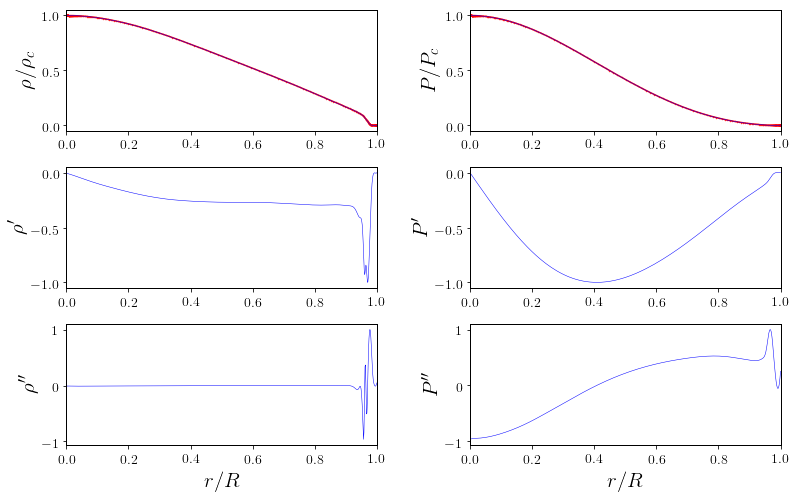

In [133]:
fig=plt.figure(figsize=[12.8,8])

plt.subplot(321)
plt.plot(bbb2_155[-1]/bbb2_155[-1][-1],bbb2_155[2]/bbb2_155[2][0],color='red',marker='o',markersize='0.4') 
plt.plot(bbb2_155[-1]/bbb2_155[-1][-1],bbb2_155rho(bbb2_155[-1])/bbb2_155[2][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1) # leaving the crust out

plt.subplot(322)
plt.plot(bbb2_155[-1]/bbb2_155[-1][-1],bbb2_155[1]/bbb2_155[1][0],color='red',marker='o',markersize='0.4') 
plt.plot(bbb2_155[-1]/bbb2_155[-1][-1],bbb2_155p(bbb2_155[-1])/bbb2_155[1][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$P/P_c$')
plt.xlim(0,1)

plt.subplot(323)
plt.plot(bbb2_155[-1]/bbb2_155[-1][-1],bbb2_155drho(bbb2_155[-1])/max(abs(bbb2_155drho(bbb2_155[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime}$')
plt.xlim(0,1)
#plt.ylim(-500,0)

plt.subplot(324)
plt.plot(bbb2_155[-1]/bbb2_155[-1][-1],bbb2_155dp(bbb2_155[-1])/max(abs(bbb2_155dp(bbb2_155[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime} $')
plt.xlim(0,1)

plt.subplot(325)
plt.plot(bbb2_155[-1]/bbb2_155[-1][-1],bbb2_155ddrho(bbb2_155[-1])/max(abs(bbb2_155ddrho(bbb2_155[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}$')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-0.01,0.01)

plt.subplot(326)
plt.plot(bbb2_155[-1]/bbb2_155[-1][-1],bbb2_155ddp(bbb2_155[-1])/max(abs(bbb2_155ddp(bbb2_155[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime\prime}$ ')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-1,1)

fig.subplots_adjust(hspace=0.3,wspace=0.3)

#plt.savefig('figures/ddsbbb2_155.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

## Adiabatic convection

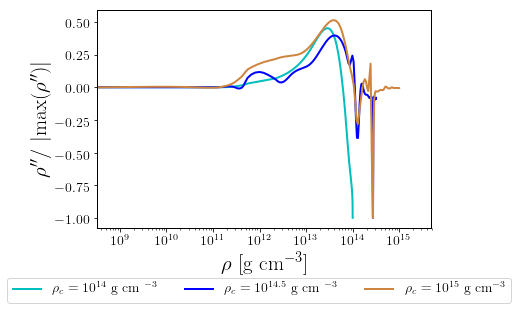

In [54]:
fig, ax = plt.subplots()

ax.set_xscale("log")

plt.plot(bbb2_140[2]*rhodim,bbb2_140ddrho(bbb2_140[-1])/max(abs(bbb2_140ddrho(bbb2_140[-1]))),color='c',linewidth='2.0',label=r'$\rho_c=10^{14}$ g cm $^{-3}$') 
plt.plot(bbb2_145[2]*rhodim,bbb2_145ddrho(bbb2_145[-1])/max(abs(bbb2_145ddrho(bbb2_145[-1]))),color='blue',linewidth='2.0',linestyle='-',label=r'$\rho_c=10^{14.5}$ g cm $^{-3}$') 
plt.plot(bbb2_150[2]*rhodim,bbb2_150ddrho(bbb2_150[-1])/max(abs(bbb2_150ddrho(bbb2_150[-1]))),color='peru',linewidth='2.0',linestyle='-',label=r'$\rho_c=10^{15}$ g cm$ ^{-3}$')
plt.xlim(left=10**(8.5))
#plt.plot(bbb2_155[-1]/bbb2_155[-1][-1],bbb2_155drho(bbb2_155[-1])/max(abs(bbb2_155drho(bbb2_140[-1]))),color='yellow',linewidth='2.0',linestyle='-.',label=r'$\rho_c=10^{15.5}$ g cm$ ^{-3}$')

l = plt.legend(bbox_to_anchor=(1.1,-0.16), loc="lower right", 
                bbox_transform=fig.transFigure, ncol=3)

plt.xlabel(r'$\rho$ [g cm$^{-3}$]')
plt.ylabel(r'$\rho^{\prime \prime}/$ $|$max$(\rho^{\prime \prime})|$')
#plt.xlim(0,1.0)

plt.savefig('figures/ConvecStabilitybbb2Correl.pdf', format='pdf', dpi=1000,bbox_inches="tight")

## Redshift

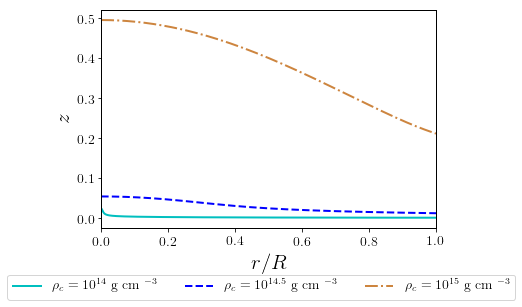

In [134]:
fig = plt.figure()

plt.plot(bbb2_140[-1]/bbb2_140[-1][-1],np.exp(-bbb2_140[3])-1.0,color='c',linewidth='2.0',label=r'$\rho_c=10^{14}$ g cm $^{-3}$')
plt.plot(bbb2_145[-1]/bbb2_145[-1][-1],np.exp(-bbb2_145[3])-1.0,color='blue',linewidth='2.0',linestyle='--',label=r'$\rho_c=10^{14.5}$ g cm $^{-3}$')
plt.plot(bbb2_150[-1]/bbb2_150[-1][-1],np.exp(-bbb2_150[3])-1.0,color='peru',linewidth='2.0',linestyle='-.',label=r'$\rho_c=10^{15}$ g cm $^{-3}$')

l = plt.legend(bbox_to_anchor=(1.1,-0.15), loc="lower right", 
                bbox_transform=fig.transFigure, ncol=3)

plt.xlabel(r'$r/R$')
plt.ylabel(r'$z$')
plt.xlim(0,1.0)

plt.savefig('figures/Redshiftbbb2.pdf', format='pdf', dpi=1000,bbox_inches="tight")

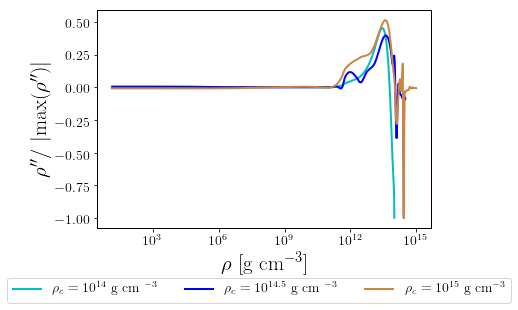

In [146]:
fig, ax = plt.subplots()

ax.set_xscale("log")

plt.plot(bbb2_140[2]*rhodim,bbb2_140ddrho(bbb2_140[-1])/max(abs(bbb2_140ddrho(bbb2_140[-1]))),color='c',linewidth='2.0',label=r'$\rho_c=10^{14}$ g cm $^{-3}$') 
plt.plot(bbb2_145[2]*rhodim,bbb2_145ddrho(bbb2_145[-1])/max(abs(bbb2_145ddrho(bbb2_145[-1]))),color='blue',linewidth='2.0',linestyle='-',label=r'$\rho_c=10^{14.5}$ g cm $^{-3}$') 
plt.plot(bbb2_150[2]*rhodim,bbb2_150ddrho(bbb2_150[-1])/max(abs(bbb2_150ddrho(bbb2_150[-1]))),color='peru',linewidth='2.0',linestyle='-',label=r'$\rho_c=10^{15}$ g cm$ ^{-3}$')

#plt.xlim(left=10**(11))
#plt.plot(bbb2_155[-1]/bbb2_155[-1][-1],bbb2_155drho(bbb2_155[-1])/max(abs(bbb2_155drho(bbb2_140[-1]))),color='yellow',linewidth='2.0',linestyle='-.',label=r'$\rho_c=10^{15.5}$ g cm$ ^{-3}$')

l = plt.legend(bbox_to_anchor=(1.1,-0.16), loc="lower right", 
                bbox_transform=fig.transFigure, ncol=3)

plt.xlabel(r'$\rho$ [g cm$^{-3}$]')
plt.ylabel(r'$\rho^{\prime \prime}/$ $|$max$(\rho^{\prime \prime})|$')
#plt.xlim(0,1.0)

plt.savefig('figures/ConvecStabilitybbb2Correl.pdf', format='pdf', dpi=1000,bbox_inches="tight")

# BGN1H1 ---------------------------------------------------------------------------------------

In [425]:
rhobgn1h1,Pbgn1h1,nbgn1h1=np.loadtxt('EOS/bgn1h1.dat',usecols=(2,1,0),unpack=True)

## Dominant energy condition

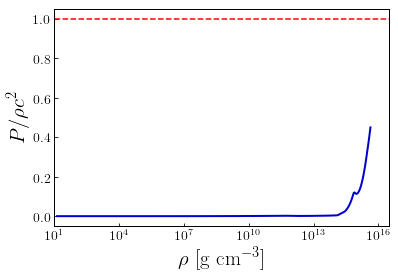

<Figure size 432x288 with 0 Axes>

In [426]:
fig, ax = plt.subplots()
plt.plot(rhobgn1h1,np.divide(Pbgn1h1,rhobgn1h1),lw='2',color='mediumblue')
plt.plot([0,10**(17)],[1.0,1.0],'r--',lw='1.5')

ax.set_xscale("log")
#locmaj = matplotlib.ticker.LogLocator(base=10.0,numticks=16) 
#ax.xaxis.set_major_locator(locmaj)


plt.xlabel(r'$\rho$ [g\,\,cm$^{-3}$]')
plt.ylabel(r'$ P / \rho c^2 $')
#locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks=16)
#ax.xaxis.set_minor_locator(locmin)
#ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.tick_params(axis="x", direction="in")
ax.tick_params(axis="y", direction="in")
plt.xlim(10,10**(16.5))
#ax.set_facecolor('floralwhite')
#plt.gca().set_aspect('equal', adjustable='box')
#plt.draw()
#plt.ylim(0,1)
plt.savefig('figures/ECbgn1h1.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()
plt.clf()

## Speed of sound

In [427]:
vsquared=interpolate.UnivariateSpline(rhobgn1h1, Pbgn1h1, k=3, s=0).derivative(n=1)

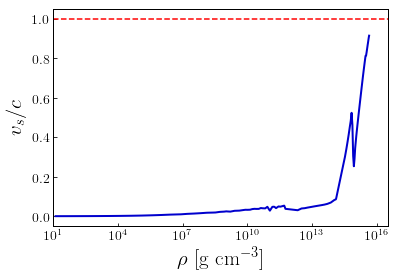

In [428]:
fig, ax = plt.subplots()
plt.plot(rhobgn1h1,np.sqrt(vsquared(rhobgn1h1)),lw='2.0',color='mediumblue')
plt.plot([1e+1,10**(16.5)],[1.0,1.0],'r--',lw='1.5')
plt.xlabel(r'$\rho$ [g\,\,cm$^{-3}$]')
plt.ylabel(r'$ v_s / c $')
plt.xscale('log')
ax.tick_params(axis="x", direction="in")
ax.tick_params(axis="y", direction="in")
plt.xlim(10,10**(16.5))
#ax.set_facecolor('floralwhite')
#mpl.rcParams['axes.linewidth'] = 1.4
#plt.gca().set_aspect('equal', adjustable='box')
#plt.draw()
plt.savefig('figures/SSbgn1h1.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

## M - $\rho_c$

In [435]:
Rbgn1h1,Mbgn1h1,rhocbgn1h1=np.loadtxt('results/bgn1h1/MRrhoc.dat',usecols=(0,1,2),unpack=True)

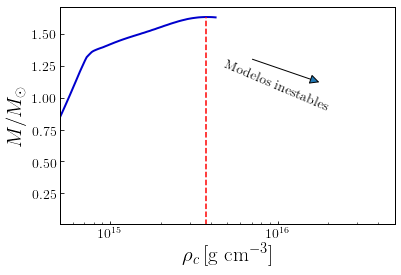

In [439]:
fig, ax = plt.subplots()

plt.plot(rhocbgn1h1,Mbgn1h1,color='mediumblue',lw='2.0')
plt.plot([10**(np.log10(rhocbgn1h1[np.argmax(Mbgn1h1)])),10**(np.log10(rhocbgn1h1[np.argmax(Mbgn1h1)]))],[0.0,np.amax(Mbgn1h1)],'r--',lw='1.5')

prop = dict(arrowstyle="-|>,head_width=0.4,head_length=0.8",
            shrinkA=0,shrinkB=0)
plt.annotate("", xy=(10**(16.25),1.12), xytext=(10**(15.85),1.3), arrowprops=prop)
#plt.arrow(10**(15.6), 1.38,10**(15.7) ,-0.1 , head_width=0.05, head_length=10**(15))
plt.text(10**(15.67), 1.23, 'Modelos inestables' , fontsize=14,rotation=-23)

plt.xscale('log')
plt.xlabel(r'$\rho_c\,[$g cm$^{-3}]$')
plt.ylabel(r'$M/M_{\odot}$')
plt.xlim(left=10**(14.7),right=10**(16.7))
plt.ylim(bottom=0.01)
ax.tick_params(axis="x", direction="in",which='both')
ax.tick_params(axis="y", direction="in",which='both')

plt.savefig('figures/Mrhorel_bgn1h1.pdf', format='pdf', dpi=1000,bbox_inches="tight")

## Effective and critical adiabatic index

In [55]:
rhoscbgn1h1,betasbgn1h1,gamma_efsbgn1h1,gamma_crsbgn1h1 = aindex_stab('bgn1h1')

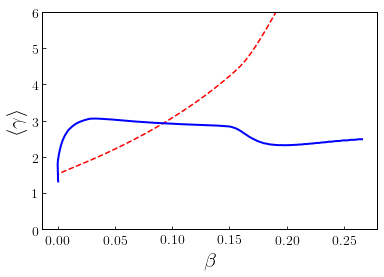

In [56]:
fig, ax = plt.subplots()
plt.plot(betasbgn1h1,gamma_crsbgn1h1,lw='1.5',color='r',linestyle='--',label=r'$\gamma_{cr}$')
#plt.plot([betacrit,betacrit],[0,5])
plt.plot(betasbgn1h1,gamma_efsbgn1h1,lw='2.0',color='blue',label=r'$\langle \gamma \rangle$')

plt.xlabel(r'$\beta$')
plt.ylabel(r'$\langle \gamma \rangle$')

#plt.xscale('log')
#plt.xlim(left=10**(14.7),right=10**(16.7))
plt.ylim(0,6)
ax.tick_params(axis="x", direction="in",which='both')
ax.tick_params(axis="y", direction="in",which='both')
#l = plt.legend(bbox_to_anchor=(0.85,-0.15), loc="lower right", 
                #bbox_transform=fig.transFigure, ncol=2)



plt.savefig('figures/AIndexStabbgn1h1.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

## Tunning the interpolation of the solution

### 14.0

In [57]:
bgn1h1_140=np.loadtxt('results/bgn1h1/14.0.dat',unpack=True)
bgn1h1_140[3] = bgn1h1_140[3]-bgn1h1_140[3][-1] + 0.5*np.log(1-2*bgn1h1_140[0][-1]/bgn1h1_140[-1][-1])

In [58]:
s1=5e-7
s2=1e-15
bgn1h1_140rho=interpolate.UnivariateSpline(bgn1h1_140[-1], bgn1h1_140[2], k=5, s=s1)
bgn1h1_140drho=interpolate.UnivariateSpline(bgn1h1_140[-1], bgn1h1_140[2], k=5, s=s1).derivative(n=1)
bgn1h1_140ddrho=interpolate.UnivariateSpline(bgn1h1_140[-1], bgn1h1_140[2], k=5, s=s1).derivative(n=2)

bgn1h1_140p=interpolate.UnivariateSpline(bgn1h1_140[-1], bgn1h1_140[1], k=5, s=s2)
bgn1h1_140dp=interpolate.UnivariateSpline(bgn1h1_140[-1], bgn1h1_140[1], k=5, s=s2).derivative(n=1)
bgn1h1_140ddp=interpolate.UnivariateSpline(bgn1h1_140[-1], bgn1h1_140[1], k=5, s=s2).derivative(n=2)

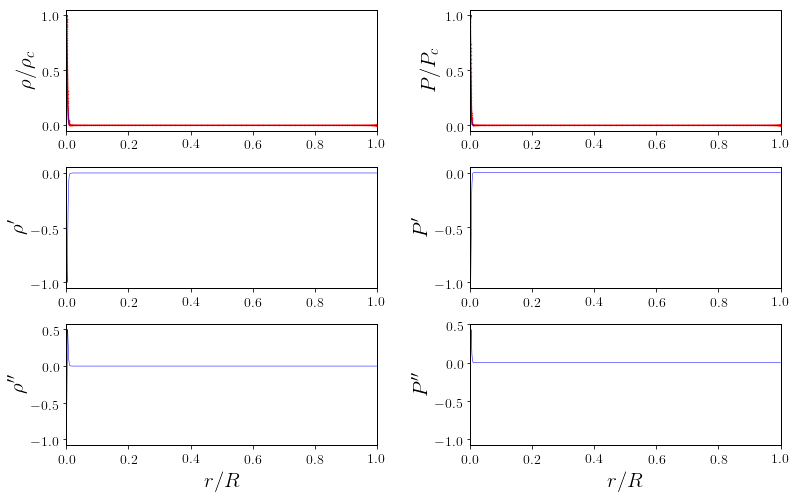

In [442]:
fig=plt.figure(figsize=[12.8,8])

plt.subplot(321)
plt.plot(bgn1h1_140[-1]/bgn1h1_140[-1][-1],bgn1h1_140[2]/bgn1h1_140[2][0],color='red',marker='o',markersize='0.4') 
plt.plot(bgn1h1_140[-1]/bgn1h1_140[-1][-1],bgn1h1_140rho(bgn1h1_140[-1])/bgn1h1_140[2][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1) # leaving the crust out

plt.subplot(322)
plt.plot(bgn1h1_140[-1]/bgn1h1_140[-1][-1],bgn1h1_140[1]/bgn1h1_140[1][0],color='red',marker='o',markersize='0.4') 
plt.plot(bgn1h1_140[-1]/bgn1h1_140[-1][-1],bgn1h1_140p(bgn1h1_140[-1])/bgn1h1_140[1][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$P/P_c$')
plt.xlim(0,1)

plt.subplot(323)
plt.plot(bgn1h1_140[-1]/bgn1h1_140[-1][-1],bgn1h1_140drho(bgn1h1_140[-1])/max(abs(bgn1h1_140drho(bgn1h1_140[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime}$')
plt.xlim(0,1)
#plt.ylim(-500,0)

plt.subplot(324)
plt.plot(bgn1h1_140[-1]/bgn1h1_140[-1][-1],bgn1h1_140dp(bgn1h1_140[-1])/max(abs(bgn1h1_140dp(bgn1h1_140[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime} $')
plt.xlim(0,1)

plt.subplot(325)
plt.plot(bgn1h1_140[-1]/bgn1h1_140[-1][-1],bgn1h1_140ddrho(bgn1h1_140[-1])/max(abs(bgn1h1_140ddrho(bgn1h1_140[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}$')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-0.01,0.01)

plt.subplot(326)
plt.plot(bgn1h1_140[-1]/bgn1h1_140[-1][-1],bgn1h1_140ddp(bgn1h1_140[-1])/max(abs(bgn1h1_140ddp(bgn1h1_140[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime\prime}$ ')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-1,1)

fig.subplots_adjust(hspace=0.3,wspace=0.3)

#plt.savefig('figures/ddsbgn1h1_140.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

### 14.5

In [59]:
bgn1h1_145=np.loadtxt('results/bgn1h1/14.5.dat',unpack=True)
bgn1h1_145[3] = bgn1h1_145[3]-bgn1h1_145[3][-1] + 0.5*np.log(1-2*bgn1h1_145[0][-1]/bgn1h1_145[-1][-1])

In [60]:
s1=1e-7
s2=1e-12
bgn1h1_145rho=interpolate.UnivariateSpline(bgn1h1_145[-1], bgn1h1_145[2], k=5, s=s1)
bgn1h1_145drho=interpolate.UnivariateSpline(bgn1h1_145[-1], bgn1h1_145[2], k=5, s=s1).derivative(n=1)
bgn1h1_145ddrho=interpolate.UnivariateSpline(bgn1h1_145[-1], bgn1h1_145[2], k=5, s=s1).derivative(n=2)

bgn1h1_145p=interpolate.UnivariateSpline(bgn1h1_145[-1], bgn1h1_145[1], k=5, s=s2)
bgn1h1_145dp=interpolate.UnivariateSpline(bgn1h1_145[-1], bgn1h1_145[1], k=5, s=s2).derivative(n=1)
bgn1h1_145ddp=interpolate.UnivariateSpline(bgn1h1_145[-1], bgn1h1_145[1], k=5, s=s2).derivative(n=2)

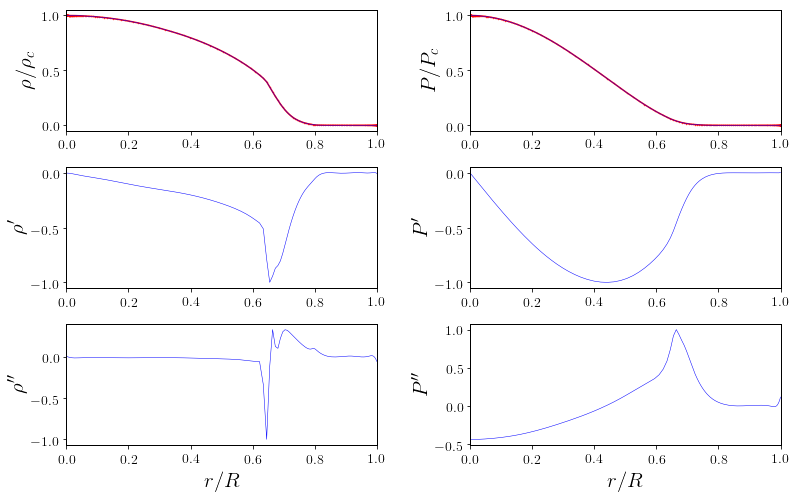

In [446]:
fig=plt.figure(figsize=[12.8,8])

plt.subplot(321)
plt.plot(bgn1h1_145[-1]/bgn1h1_145[-1][-1],bgn1h1_145[2]/bgn1h1_145[2][0],color='red',marker='o',markersize='0.4') 
plt.plot(bgn1h1_145[-1]/bgn1h1_145[-1][-1],bgn1h1_145rho(bgn1h1_145[-1])/bgn1h1_145[2][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1) # leaving the crust out

plt.subplot(322)
plt.plot(bgn1h1_145[-1]/bgn1h1_145[-1][-1],bgn1h1_145[1]/bgn1h1_145[1][0],color='red',marker='o',markersize='0.4') 
plt.plot(bgn1h1_145[-1]/bgn1h1_145[-1][-1],bgn1h1_145p(bgn1h1_145[-1])/bgn1h1_145[1][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$P/P_c$')
plt.xlim(0,1)

plt.subplot(323)
plt.plot(bgn1h1_145[-1]/bgn1h1_145[-1][-1],bgn1h1_145drho(bgn1h1_145[-1])/max(abs(bgn1h1_145drho(bgn1h1_145[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime}$')
plt.xlim(0,1)
#plt.ylim(-500,0)

plt.subplot(324)
plt.plot(bgn1h1_145[-1]/bgn1h1_145[-1][-1],bgn1h1_145dp(bgn1h1_145[-1])/max(abs(bgn1h1_145dp(bgn1h1_145[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime} $')
plt.xlim(0,1)

plt.subplot(325)
plt.plot(bgn1h1_145[-1]/bgn1h1_145[-1][-1],bgn1h1_145ddrho(bgn1h1_145[-1])/max(abs(bgn1h1_145ddrho(bgn1h1_145[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}$')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-0.01,0.01)

plt.subplot(326)
plt.plot(bgn1h1_145[-1]/bgn1h1_145[-1][-1],bgn1h1_145ddp(bgn1h1_145[-1])/max(abs(bgn1h1_145ddp(bgn1h1_145[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime\prime}$ ')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-1,1)

fig.subplots_adjust(hspace=0.3,wspace=0.3)

#plt.savefig('figures/ddsbgn1h1_145.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

### 15.0

In [61]:
bgn1h1_150=np.loadtxt('results/bgn1h1/15.0.dat',unpack=True)
bgn1h1_150[3] = bgn1h1_150[3]-bgn1h1_150[3][-1] + 0.5*np.log(1-2*bgn1h1_150[0][-1]/bgn1h1_150[-1][-1])

In [62]:
s1=8e-6
s2=1e-15
bgn1h1_150rho=interpolate.UnivariateSpline(bgn1h1_150[-1], bgn1h1_150[2], k=5, s=s1)
bgn1h1_150drho=interpolate.UnivariateSpline(bgn1h1_150[-1], bgn1h1_150[2], k=5, s=s1).derivative(n=1)
bgn1h1_150ddrho=interpolate.UnivariateSpline(bgn1h1_150[-1], bgn1h1_150[2], k=5, s=s1).derivative(n=2)

bgn1h1_150p=interpolate.UnivariateSpline(bgn1h1_150[-1], bgn1h1_150[1], k=5, s=s2)
bgn1h1_150dp=interpolate.UnivariateSpline(bgn1h1_150[-1], bgn1h1_150[1], k=5, s=s2).derivative(n=1)
bgn1h1_150ddp=interpolate.UnivariateSpline(bgn1h1_150[-1], bgn1h1_150[1], k=5, s=s2).derivative(n=2)

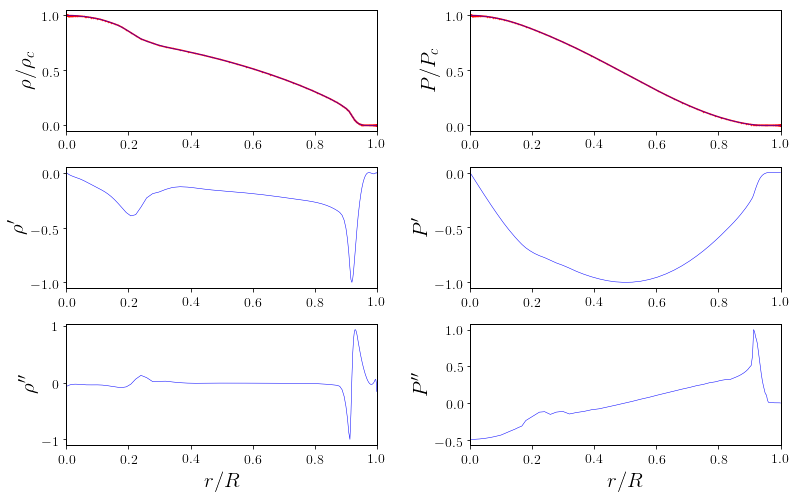

In [449]:
fig=plt.figure(figsize=[12.8,8])

plt.subplot(321)
plt.plot(bgn1h1_150[-1]/bgn1h1_150[-1][-1],bgn1h1_150[2]/bgn1h1_150[2][0],color='red',marker='o',markersize='0.4') 
plt.plot(bgn1h1_150[-1]/bgn1h1_150[-1][-1],bgn1h1_150rho(bgn1h1_150[-1])/bgn1h1_150[2][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1) # leaving the crust out

plt.subplot(322)
plt.plot(bgn1h1_150[-1]/bgn1h1_150[-1][-1],bgn1h1_150[1]/bgn1h1_150[1][0],color='red',marker='o',markersize='0.4') 
plt.plot(bgn1h1_150[-1]/bgn1h1_150[-1][-1],bgn1h1_150p(bgn1h1_150[-1])/bgn1h1_150[1][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$P/P_c$')
plt.xlim(0,1)

plt.subplot(323)
plt.plot(bgn1h1_150[-1]/bgn1h1_150[-1][-1],bgn1h1_150drho(bgn1h1_150[-1])/max(abs(bgn1h1_150drho(bgn1h1_150[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime}$')
plt.xlim(0,1)
#plt.ylim(-500,0)

plt.subplot(324)
plt.plot(bgn1h1_150[-1]/bgn1h1_150[-1][-1],bgn1h1_150dp(bgn1h1_150[-1])/max(abs(bgn1h1_150dp(bgn1h1_150[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime} $')
plt.xlim(0,1)

plt.subplot(325)
plt.plot(bgn1h1_150[-1]/bgn1h1_150[-1][-1],bgn1h1_150ddrho(bgn1h1_150[-1])/max(abs(bgn1h1_150ddrho(bgn1h1_150[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}$')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-0.01,0.01)

plt.subplot(326)
plt.plot(bgn1h1_150[-1]/bgn1h1_150[-1][-1],bgn1h1_150ddp(bgn1h1_150[-1])/max(abs(bgn1h1_150ddp(bgn1h1_150[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime\prime}$ ')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-1,1)

fig.subplots_adjust(hspace=0.3,wspace=0.3)

#plt.savefig('figures/ddsbgn1h1_150.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

### 15.5

In [63]:
bgn1h1_155=np.loadtxt('results/bgn1h1/15.5.dat',unpack=True)
bgn1h1_155[3] = bgn1h1_155[3]-bgn1h1_155[3][-1] + 0.5*np.log(1-2*bgn1h1_155[0][-1]/bgn1h1_155[-1][-1])

In [64]:
s1=1e-5
s2=1e-9
bgn1h1_155rho=interpolate.UnivariateSpline(bgn1h1_155[-1], bgn1h1_155[2], k=5, s=s1)
bgn1h1_155drho=interpolate.UnivariateSpline(bgn1h1_155[-1], bgn1h1_155[2], k=5, s=s1).derivative(n=1)
bgn1h1_155ddrho=interpolate.UnivariateSpline(bgn1h1_155[-1], bgn1h1_155[2], k=5, s=s1).derivative(n=2)

bgn1h1_155p=interpolate.UnivariateSpline(bgn1h1_155[-1], bgn1h1_155[1], k=5, s=s2)
bgn1h1_155dp=interpolate.UnivariateSpline(bgn1h1_155[-1], bgn1h1_155[1], k=5, s=s2).derivative(n=1)
bgn1h1_155ddp=interpolate.UnivariateSpline(bgn1h1_155[-1], bgn1h1_155[1], k=5, s=s2).derivative(n=2)

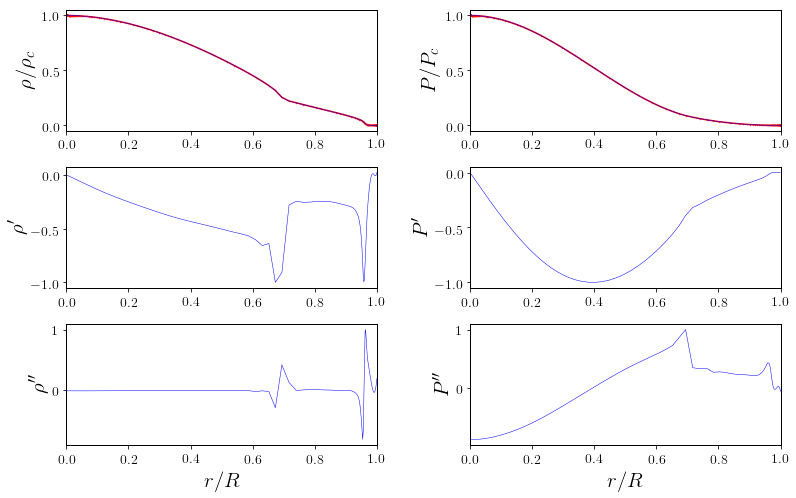

In [452]:
fig=plt.figure(figsize=[12.8,8])

plt.subplot(321)
plt.plot(bgn1h1_155[-1]/bgn1h1_155[-1][-1],bgn1h1_155[2]/bgn1h1_155[2][0],color='red',marker='o',markersize='0.4') 
plt.plot(bgn1h1_155[-1]/bgn1h1_155[-1][-1],bgn1h1_155rho(bgn1h1_155[-1])/bgn1h1_155[2][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1) # leaving the crust out

plt.subplot(322)
plt.plot(bgn1h1_155[-1]/bgn1h1_155[-1][-1],bgn1h1_155[1]/bgn1h1_155[1][0],color='red',marker='o',markersize='0.4') 
plt.plot(bgn1h1_155[-1]/bgn1h1_155[-1][-1],bgn1h1_155p(bgn1h1_155[-1])/bgn1h1_155[1][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$P/P_c$')
plt.xlim(0,1)

plt.subplot(323)
plt.plot(bgn1h1_155[-1]/bgn1h1_155[-1][-1],bgn1h1_155drho(bgn1h1_155[-1])/max(abs(bgn1h1_155drho(bgn1h1_155[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime}$')
plt.xlim(0,1)
#plt.ylim(-500,0)

plt.subplot(324)
plt.plot(bgn1h1_155[-1]/bgn1h1_155[-1][-1],bgn1h1_155dp(bgn1h1_155[-1])/max(abs(bgn1h1_155dp(bgn1h1_155[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime} $')
plt.xlim(0,1)

plt.subplot(325)
plt.plot(bgn1h1_155[-1]/bgn1h1_155[-1][-1],bgn1h1_155ddrho(bgn1h1_155[-1])/max(abs(bgn1h1_155ddrho(bgn1h1_155[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}$')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-0.01,0.01)

plt.subplot(326)
plt.plot(bgn1h1_155[-1]/bgn1h1_155[-1][-1],bgn1h1_155ddp(bgn1h1_155[-1])/max(abs(bgn1h1_155ddp(bgn1h1_155[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime\prime}$ ')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-1,1)

fig.subplots_adjust(hspace=0.3,wspace=0.3)

#plt.savefig('figures/ddsbgn1h1_155.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

## Adiabatic convection

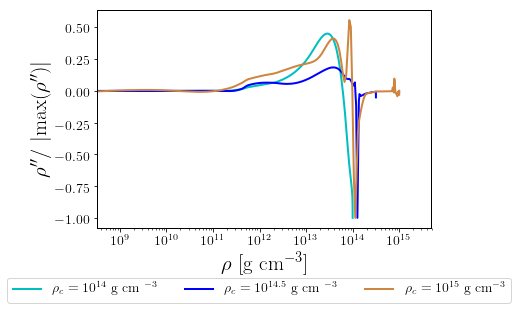

In [65]:
fig, ax = plt.subplots()

ax.set_xscale("log")

plt.plot(bgn1h1_140[2]*rhodim,bgn1h1_140ddrho(bgn1h1_140[-1])/max(abs(bgn1h1_140ddrho(bgn1h1_140[-1]))),color='c',linewidth='2.0',label=r'$\rho_c=10^{14}$ g cm $^{-3}$') 
plt.plot(bgn1h1_145[2]*rhodim,bgn1h1_145ddrho(bgn1h1_145[-1])/max(abs(bgn1h1_145ddrho(bgn1h1_145[-1]))),color='blue',linewidth='2.0',linestyle='-',label=r'$\rho_c=10^{14.5}$ g cm $^{-3}$') 
plt.plot(bgn1h1_150[2]*rhodim,bgn1h1_150ddrho(bgn1h1_150[-1])/max(abs(bgn1h1_150ddrho(bgn1h1_150[-1]))),color='peru',linewidth='2.0',linestyle='-',label=r'$\rho_c=10^{15}$ g cm$ ^{-3}$')
plt.xlim(left=10**(8.5))
#plt.plot(bgn1h1_155[-1]/bgn1h1_155[-1][-1],bgn1h1_155drho(bgn1h1_155[-1])/max(abs(bgn1h1_155drho(bgn1h1_140[-1]))),color='yellow',linewidth='2.0',linestyle='-.',label=r'$\rho_c=10^{15.5}$ g cm$ ^{-3}$')

l = plt.legend(bbox_to_anchor=(1.1,-0.16), loc="lower right", 
                bbox_transform=fig.transFigure, ncol=3)

plt.xlabel(r'$\rho$ [g cm$^{-3}$]')
plt.ylabel(r'$\rho^{\prime \prime}/$ $|$max$(\rho^{\prime \prime})|$')
#plt.xlim(0,1.0)

plt.savefig('figures/ConvecStabilitybgn1h1Correl.pdf', format='pdf', dpi=1000,bbox_inches="tight")

## Redshift

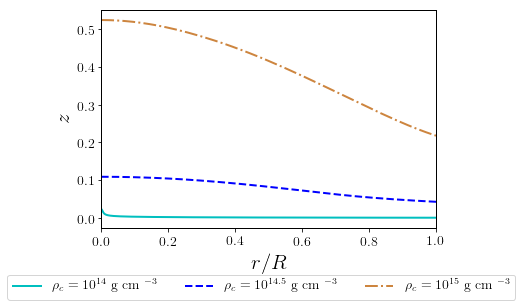

In [453]:
fig = plt.figure()

plt.plot(bgn1h1_140[-1]/bgn1h1_140[-1][-1],np.exp(-bgn1h1_140[3])-1.0,color='c',linewidth='2.0',label=r'$\rho_c=10^{14}$ g cm $^{-3}$')
plt.plot(bgn1h1_145[-1]/bgn1h1_145[-1][-1],np.exp(-bgn1h1_145[3])-1.0,color='blue',linewidth='2.0',linestyle='--',label=r'$\rho_c=10^{14.5}$ g cm $^{-3}$')
plt.plot(bgn1h1_150[-1]/bgn1h1_150[-1][-1],np.exp(-bgn1h1_150[3])-1.0,color='peru',linewidth='2.0',linestyle='-.',label=r'$\rho_c=10^{15}$ g cm $^{-3}$')

l = plt.legend(bbox_to_anchor=(1.1,-0.15), loc="lower right", 
                bbox_transform=fig.transFigure, ncol=3)

plt.xlabel(r'$r/R$')
plt.ylabel(r'$z$')
plt.xlim(0,1.0)

plt.savefig('figures/Redshiftbgn1h1.pdf', format='pdf', dpi=1000,bbox_inches="tight")

# BPAL12 ----------------------------------------------------------------------------------------

In [454]:
rhobpal12,Pbpal12,nbpal12=np.loadtxt('EOS/bpal12.dat',usecols=(2,1,0),unpack=True)

## Dominant energy condition

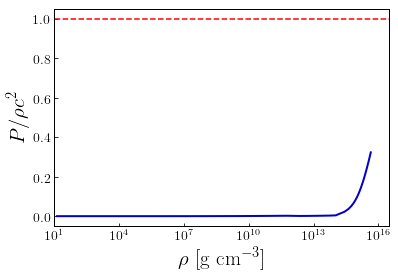

<Figure size 432x288 with 0 Axes>

In [455]:
fig, ax = plt.subplots()
plt.plot(rhobpal12,np.divide(Pbpal12,rhobpal12),lw='2',color='mediumblue')
plt.plot([0,10**(17)],[1.0,1.0],'r--',lw='1.5')

ax.set_xscale("log")
#locmaj = matplotlib.ticker.LogLocator(base=10.0,numticks=16) 
#ax.xaxis.set_major_locator(locmaj)


plt.xlabel(r'$\rho$ [g\,\,cm$^{-3}$]')
plt.ylabel(r'$ P / \rho c^2 $')
#locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks=16)
#ax.xaxis.set_minor_locator(locmin)
#ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.tick_params(axis="x", direction="in")
ax.tick_params(axis="y", direction="in")
plt.xlim(10,10**(16.5))
#ax.set_facecolor('floralwhite')
#plt.gca().set_aspect('equal', adjustable='box')
#plt.draw()
#plt.ylim(0,1)
plt.savefig('figures/ECbpal12.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()
plt.clf()

## Speed of sound

In [456]:
vsquared=interpolate.UnivariateSpline(rhobpal12, Pbpal12, k=3, s=0).derivative(n=1)

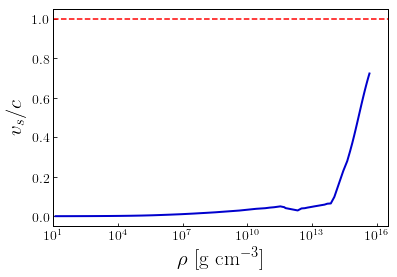

In [457]:
fig, ax = plt.subplots()
plt.plot(rhobpal12,np.sqrt(vsquared(rhobpal12)),lw='2.0',color='mediumblue')
plt.plot([1e+1,10**(16.5)],[1.0,1.0],'r--',lw='1.5')
plt.xlabel(r'$\rho$ [g\,\,cm$^{-3}$]')
plt.ylabel(r'$ v_s / c $')
plt.xscale('log')
ax.tick_params(axis="x", direction="in")
ax.tick_params(axis="y", direction="in")
plt.xlim(10,10**(16.5))
#ax.set_facecolor('floralwhite')
#mpl.rcParams['axes.linewidth'] = 1.4
#plt.gca().set_aspect('equal', adjustable='box')
#plt.draw()
plt.savefig('figures/SSbpal12.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

## M - $\rho_c$

In [464]:
Rbpal12,Mbpal12,rhocbpal12=np.loadtxt('results/bpal12/MRrhoc.dat',usecols=(0,1,2),unpack=True)

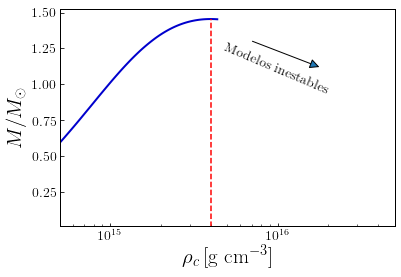

In [468]:
fig, ax = plt.subplots()

plt.plot(rhocbpal12,Mbpal12,color='mediumblue',lw='2.0')
plt.plot([10**(np.log10(rhocbpal12[np.argmax(Mbpal12)])),10**(np.log10(rhocbpal12[np.argmax(Mbpal12)]))],[0.0,np.amax(Mbpal12)],'r--',lw='1.5')

prop = dict(arrowstyle="-|>,head_width=0.4,head_length=0.8",
            shrinkA=0,shrinkB=0)
plt.annotate("", xy=(10**(16.25),1.12), xytext=(10**(15.85),1.3), arrowprops=prop)
#plt.arrow(10**(15.6), 1.38,10**(15.7) ,-0.1 , head_width=0.05, head_length=10**(15))
plt.text(10**(15.67), 1.23, 'Modelos inestables' , fontsize=14,rotation=-23)

plt.xscale('log')
plt.xlabel(r'$\rho_c\,[$g cm$^{-3}]$')
plt.ylabel(r'$M/M_{\odot}$')
plt.xlim(left=10**(14.7),right=10**(16.7))
plt.ylim(bottom=0.01)
ax.tick_params(axis="x", direction="in",which='both')
ax.tick_params(axis="y", direction="in",which='both')

plt.savefig('figures/Mrhorel_bpal12.pdf', format='pdf', dpi=1000,bbox_inches="tight")

## Effective and critical adiabatic index

In [66]:
rhoscbpal12,betasbpal12,gamma_efsbpal12,gamma_crsbpal12 = aindex_stab('bpal12')

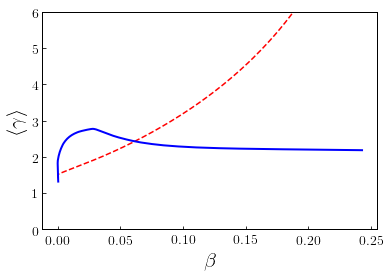

In [67]:
fig, ax = plt.subplots()
plt.plot(betasbpal12,gamma_crsbpal12,lw='1.5',color='r',linestyle='--',label=r'$\gamma_{cr}$')
#plt.plot([betacrit,betacrit],[0,5])
plt.plot(betasbpal12,gamma_efsbpal12,lw='2.0',color='blue',label=r'$\langle \gamma \rangle$')

plt.xlabel(r'$\beta$')
plt.ylabel(r'$\langle \gamma \rangle$')

#plt.xscale('log')
#plt.xlim(left=10**(14.7),right=10**(16.7))
plt.ylim(0,6)
ax.tick_params(axis="x", direction="in",which='both')
ax.tick_params(axis="y", direction="in",which='both')
#l = plt.legend(bbox_to_anchor=(0.85,-0.15), loc="lower right", 
                #bbox_transform=fig.transFigure, ncol=2)



plt.savefig('figures/AIndexStabbpal12.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

## Tunning the interpolation of the solution

### 14.0

In [68]:
bpal12_140=np.loadtxt('results/bpal12/14.0.dat',unpack=True)
bpal12_140[3] = bpal12_140[3]-bpal12_140[3][-1] + 0.5*np.log(1-2*bpal12_140[0][-1]/bpal12_140[-1][-1])

In [69]:
s1=5e-7
s2=1e-15
bpal12_140rho=interpolate.UnivariateSpline(bpal12_140[-1], bpal12_140[2], k=5, s=s1)
bpal12_140drho=interpolate.UnivariateSpline(bpal12_140[-1], bpal12_140[2], k=5, s=s1).derivative(n=1)
bpal12_140ddrho=interpolate.UnivariateSpline(bpal12_140[-1], bpal12_140[2], k=5, s=s1).derivative(n=2)

bpal12_140p=interpolate.UnivariateSpline(bpal12_140[-1], bpal12_140[1], k=5, s=s2)
bpal12_140dp=interpolate.UnivariateSpline(bpal12_140[-1], bpal12_140[1], k=5, s=s2).derivative(n=1)
bpal12_140ddp=interpolate.UnivariateSpline(bpal12_140[-1], bpal12_140[1], k=5, s=s2).derivative(n=2)

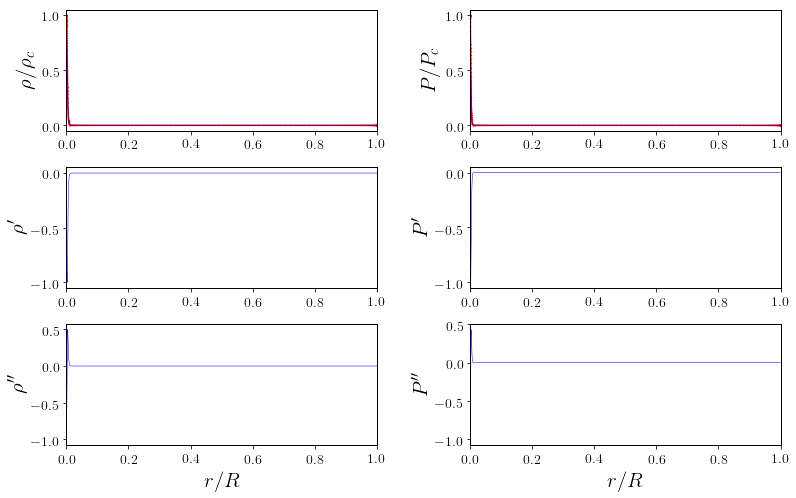

In [471]:
fig=plt.figure(figsize=[12.8,8])

plt.subplot(321)
plt.plot(bpal12_140[-1]/bpal12_140[-1][-1],bpal12_140[2]/bpal12_140[2][0],color='red',marker='o',markersize='0.4') 
plt.plot(bpal12_140[-1]/bpal12_140[-1][-1],bpal12_140rho(bpal12_140[-1])/bpal12_140[2][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1) # leaving the crust out

plt.subplot(322)
plt.plot(bpal12_140[-1]/bpal12_140[-1][-1],bpal12_140[1]/bpal12_140[1][0],color='red',marker='o',markersize='0.4') 
plt.plot(bpal12_140[-1]/bpal12_140[-1][-1],bpal12_140p(bpal12_140[-1])/bpal12_140[1][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$P/P_c$')
plt.xlim(0,1)

plt.subplot(323)
plt.plot(bpal12_140[-1]/bpal12_140[-1][-1],bpal12_140drho(bpal12_140[-1])/max(abs(bpal12_140drho(bpal12_140[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime}$')
plt.xlim(0,1)
#plt.ylim(-500,0)

plt.subplot(324)
plt.plot(bpal12_140[-1]/bpal12_140[-1][-1],bpal12_140dp(bpal12_140[-1])/max(abs(bpal12_140dp(bpal12_140[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime} $')
plt.xlim(0,1)

plt.subplot(325)
plt.plot(bpal12_140[-1]/bpal12_140[-1][-1],bpal12_140ddrho(bpal12_140[-1])/max(abs(bpal12_140ddrho(bpal12_140[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}$')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-0.01,0.01)

plt.subplot(326)
plt.plot(bpal12_140[-1]/bpal12_140[-1][-1],bpal12_140ddp(bpal12_140[-1])/max(abs(bpal12_140ddp(bpal12_140[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime\prime}$ ')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-1,1)

fig.subplots_adjust(hspace=0.3,wspace=0.3)

#plt.savefig('figures/ddsbpal12_140.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

### 14.5

In [70]:
bpal12_145=np.loadtxt('results/bpal12/14.5.dat',unpack=True)
bpal12_145[3] = bpal12_145[3]-bpal12_145[3][-1] + 0.5*np.log(1-2*bpal12_145[0][-1]/bpal12_145[-1][-1])

In [71]:
s1=1e-7
s2=1e-12
bpal12_145rho=interpolate.UnivariateSpline(bpal12_145[-1], bpal12_145[2], k=5, s=s1)
bpal12_145drho=interpolate.UnivariateSpline(bpal12_145[-1], bpal12_145[2], k=5, s=s1).derivative(n=1)
bpal12_145ddrho=interpolate.UnivariateSpline(bpal12_145[-1], bpal12_145[2], k=5, s=s1).derivative(n=2)

bpal12_145p=interpolate.UnivariateSpline(bpal12_145[-1], bpal12_145[1], k=5, s=s2)
bpal12_145dp=interpolate.UnivariateSpline(bpal12_145[-1], bpal12_145[1], k=5, s=s2).derivative(n=1)
bpal12_145ddp=interpolate.UnivariateSpline(bpal12_145[-1], bpal12_145[1], k=5, s=s2).derivative(n=2)

In [474]:
bpal12_145rho(0.4*bpal12_145[-1][-1])*rhodim

232155176237296.38

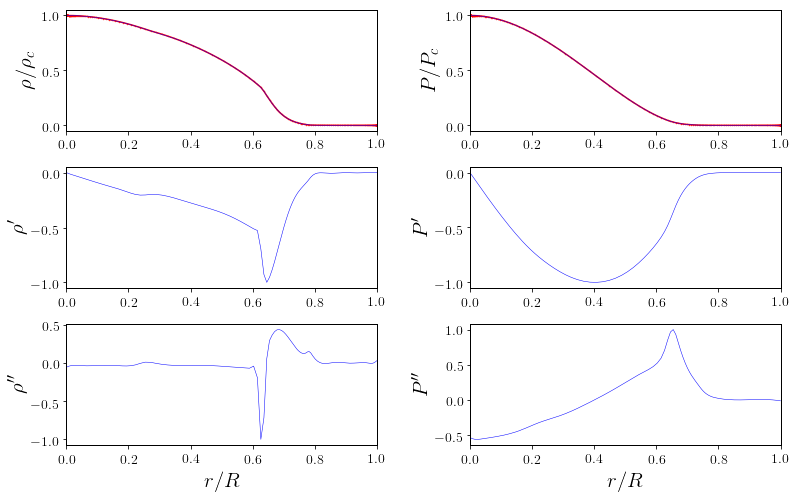

In [475]:
fig=plt.figure(figsize=[12.8,8])

plt.subplot(321)
plt.plot(bpal12_145[-1]/bpal12_145[-1][-1],bpal12_145[2]/bpal12_145[2][0],color='red',marker='o',markersize='0.4') 
plt.plot(bpal12_145[-1]/bpal12_145[-1][-1],bpal12_145rho(bpal12_145[-1])/bpal12_145[2][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1) # leaving the crust out

plt.subplot(322)
plt.plot(bpal12_145[-1]/bpal12_145[-1][-1],bpal12_145[1]/bpal12_145[1][0],color='red',marker='o',markersize='0.4') 
plt.plot(bpal12_145[-1]/bpal12_145[-1][-1],bpal12_145p(bpal12_145[-1])/bpal12_145[1][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$P/P_c$')
plt.xlim(0,1)

plt.subplot(323)
plt.plot(bpal12_145[-1]/bpal12_145[-1][-1],bpal12_145drho(bpal12_145[-1])/max(abs(bpal12_145drho(bpal12_145[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime}$')
plt.xlim(0,1)
#plt.ylim(-500,0)

plt.subplot(324)
plt.plot(bpal12_145[-1]/bpal12_145[-1][-1],bpal12_145dp(bpal12_145[-1])/max(abs(bpal12_145dp(bpal12_145[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime} $')
plt.xlim(0,1)

plt.subplot(325)
plt.plot(bpal12_145[-1]/bpal12_145[-1][-1],bpal12_145ddrho(bpal12_145[-1])/max(abs(bpal12_145ddrho(bpal12_145[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}$')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-0.01,0.01)

plt.subplot(326)
plt.plot(bpal12_145[-1]/bpal12_145[-1][-1],bpal12_145ddp(bpal12_145[-1])/max(abs(bpal12_145ddp(bpal12_145[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime\prime}$ ')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-1,1)

fig.subplots_adjust(hspace=0.3,wspace=0.3)

#plt.savefig('figures/ddsbpal12_145.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

### 15.0

In [72]:
bpal12_150=np.loadtxt('results/bpal12/15.0.dat',unpack=True)
bpal12_150[3] = bpal12_150[3]-bpal12_150[3][-1] + 0.5*np.log(1-2*bpal12_150[0][-1]/bpal12_150[-1][-1])

In [73]:
s1=8e-6
s2=1e-15
bpal12_150rho=interpolate.UnivariateSpline(bpal12_150[-1], bpal12_150[2], k=5, s=s1)
bpal12_150drho=interpolate.UnivariateSpline(bpal12_150[-1], bpal12_150[2], k=5, s=s1).derivative(n=1)
bpal12_150ddrho=interpolate.UnivariateSpline(bpal12_150[-1], bpal12_150[2], k=5, s=s1).derivative(n=2)

bpal12_150p=interpolate.UnivariateSpline(bpal12_150[-1], bpal12_150[1], k=5, s=s2)
bpal12_150dp=interpolate.UnivariateSpline(bpal12_150[-1], bpal12_150[1], k=5, s=s2).derivative(n=1)
bpal12_150ddp=interpolate.UnivariateSpline(bpal12_150[-1], bpal12_150[1], k=5, s=s2).derivative(n=2)

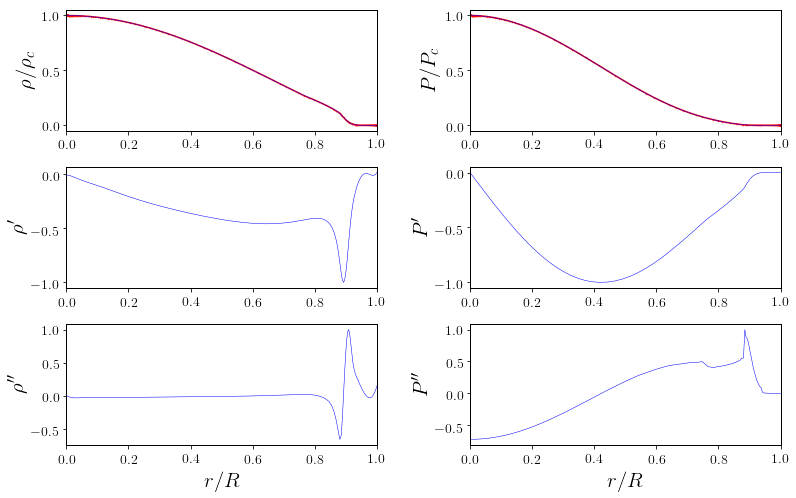

In [478]:
fig=plt.figure(figsize=[12.8,8])

plt.subplot(321)
plt.plot(bpal12_150[-1]/bpal12_150[-1][-1],bpal12_150[2]/bpal12_150[2][0],color='red',marker='o',markersize='0.4') 
plt.plot(bpal12_150[-1]/bpal12_150[-1][-1],bpal12_150rho(bpal12_150[-1])/bpal12_150[2][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1) # leaving the crust out

plt.subplot(322)
plt.plot(bpal12_150[-1]/bpal12_150[-1][-1],bpal12_150[1]/bpal12_150[1][0],color='red',marker='o',markersize='0.4') 
plt.plot(bpal12_150[-1]/bpal12_150[-1][-1],bpal12_150p(bpal12_150[-1])/bpal12_150[1][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$P/P_c$')
plt.xlim(0,1)

plt.subplot(323)
plt.plot(bpal12_150[-1]/bpal12_150[-1][-1],bpal12_150drho(bpal12_150[-1])/max(abs(bpal12_150drho(bpal12_150[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime}$')
plt.xlim(0,1)
#plt.ylim(-500,0)

plt.subplot(324)
plt.plot(bpal12_150[-1]/bpal12_150[-1][-1],bpal12_150dp(bpal12_150[-1])/max(abs(bpal12_150dp(bpal12_150[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime} $')
plt.xlim(0,1)

plt.subplot(325)
plt.plot(bpal12_150[-1]/bpal12_150[-1][-1],bpal12_150ddrho(bpal12_150[-1])/max(abs(bpal12_150ddrho(bpal12_150[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}$')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-0.01,0.01)

plt.subplot(326)
plt.plot(bpal12_150[-1]/bpal12_150[-1][-1],bpal12_150ddp(bpal12_150[-1])/max(abs(bpal12_150ddp(bpal12_150[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime\prime}$ ')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-1,1)

fig.subplots_adjust(hspace=0.3,wspace=0.3)

#plt.savefig('figures/ddsbpal12_150.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

### 15.5

In [74]:
bpal12_155=np.loadtxt('results/bpal12/15.5.dat',unpack=True)
bpal12_155[3] = bpal12_155[3]-bpal12_155[3][-1] + 0.5*np.log(1-2*bpal12_155[0][-1]/bpal12_155[-1][-1])

In [77]:
s1=1e-6
s2=1e-9
bpal12_155rho=interpolate.UnivariateSpline(bpal12_155[-1], bpal12_155[2], k=5, s=s1)
bpal12_155drho=interpolate.UnivariateSpline(bpal12_155[-1], bpal12_155[2], k=5, s=s1).derivative(n=1)
bpal12_155ddrho=interpolate.UnivariateSpline(bpal12_155[-1], bpal12_155[2], k=5, s=s1).derivative(n=2)

bpal12_155p=interpolate.UnivariateSpline(bpal12_155[-1], bpal12_155[1], k=5, s=s2)
bpal12_155dp=interpolate.UnivariateSpline(bpal12_155[-1], bpal12_155[1], k=5, s=s2).derivative(n=1)
bpal12_155ddp=interpolate.UnivariateSpline(bpal12_155[-1], bpal12_155[1], k=5, s=s2).derivative(n=2)

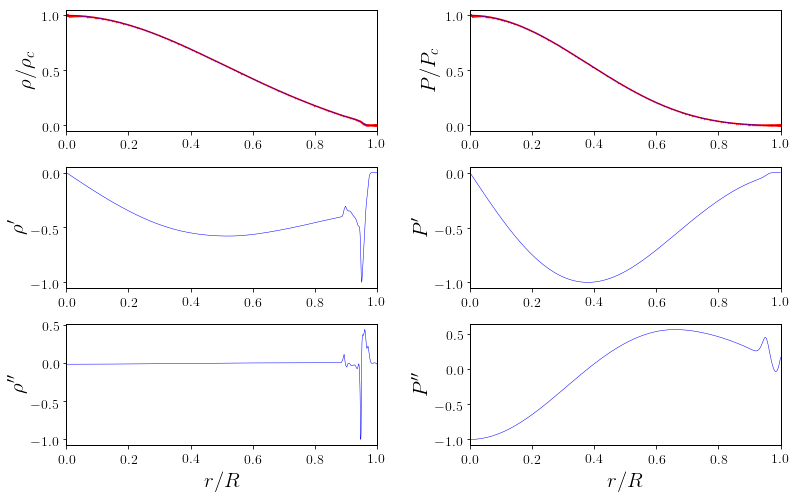

In [78]:
fig=plt.figure(figsize=[12.8,8])

plt.subplot(321)
plt.plot(bpal12_155[-1]/bpal12_155[-1][-1],bpal12_155[2]/bpal12_155[2][0],color='red',marker='o',markersize='0.4') 
plt.plot(bpal12_155[-1]/bpal12_155[-1][-1],bpal12_155rho(bpal12_155[-1])/bpal12_155[2][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1) # leaving the crust out

plt.subplot(322)
plt.plot(bpal12_155[-1]/bpal12_155[-1][-1],bpal12_155[1]/bpal12_155[1][0],color='red',marker='o',markersize='0.4') 
plt.plot(bpal12_155[-1]/bpal12_155[-1][-1],bpal12_155p(bpal12_155[-1])/bpal12_155[1][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$P/P_c$')
plt.xlim(0,1)

plt.subplot(323)
plt.plot(bpal12_155[-1]/bpal12_155[-1][-1],bpal12_155drho(bpal12_155[-1])/max(abs(bpal12_155drho(bpal12_155[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime}$')
plt.xlim(0,1)
#plt.ylim(-500,0)

plt.subplot(324)
plt.plot(bpal12_155[-1]/bpal12_155[-1][-1],bpal12_155dp(bpal12_155[-1])/max(abs(bpal12_155dp(bpal12_155[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime} $')
plt.xlim(0,1)

plt.subplot(325)
plt.plot(bpal12_155[-1]/bpal12_155[-1][-1],bpal12_155ddrho(bpal12_155[-1])/max(abs(bpal12_155ddrho(bpal12_155[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}$')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-0.01,0.01)

plt.subplot(326)
plt.plot(bpal12_155[-1]/bpal12_155[-1][-1],bpal12_155ddp(bpal12_155[-1])/max(abs(bpal12_155ddp(bpal12_155[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime\prime}$ ')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-1,1)

fig.subplots_adjust(hspace=0.3,wspace=0.3)

#plt.savefig('figures/ddsbpal12_155.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

## Adiabatic convection

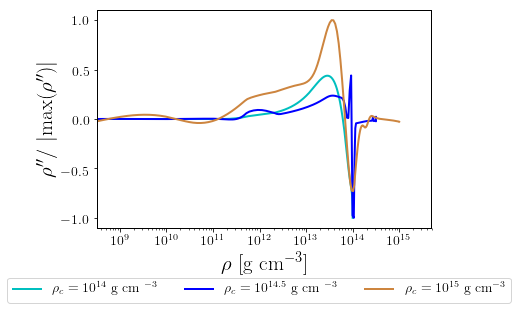

In [79]:
fig, ax = plt.subplots()

ax.set_xscale("log")

plt.plot(bpal12_140[2]*rhodim,bpal12_140ddrho(bpal12_140[-1])/max(abs(bpal12_140ddrho(bpal12_140[-1]))),color='c',linewidth='2.0',label=r'$\rho_c=10^{14}$ g cm $^{-3}$') 
plt.plot(bpal12_145[2]*rhodim,bpal12_145ddrho(bpal12_145[-1])/max(abs(bpal12_145ddrho(bpal12_145[-1]))),color='blue',linewidth='2.0',linestyle='-',label=r'$\rho_c=10^{14.5}$ g cm $^{-3}$') 
plt.plot(bpal12_150[2]*rhodim,bpal12_150ddrho(bpal12_150[-1])/max(abs(bpal12_150ddrho(bpal12_150[-1]))),color='peru',linewidth='2.0',linestyle='-',label=r'$\rho_c=10^{15}$ g cm$ ^{-3}$')
plt.xlim(left=10**(8.5))
#plt.plot(bpal12_155[-1]/bpal12_155[-1][-1],bpal12_155drho(bpal12_155[-1])/max(abs(bpal12_155drho(bpal12_140[-1]))),color='yellow',linewidth='2.0',linestyle='-.',label=r'$\rho_c=10^{15.5}$ g cm$ ^{-3}$')

l = plt.legend(bbox_to_anchor=(1.1,-0.16), loc="lower right", 
                bbox_transform=fig.transFigure, ncol=3)

plt.xlabel(r'$\rho$ [g cm$^{-3}$]')
plt.ylabel(r'$\rho^{\prime \prime}/$ $|$max$(\rho^{\prime \prime})|$')
#plt.xlim(0,1.0)

plt.savefig('figures/ConvecStabilitybpal12Correl.pdf', format='pdf', dpi=1000,bbox_inches="tight")

## Redshift

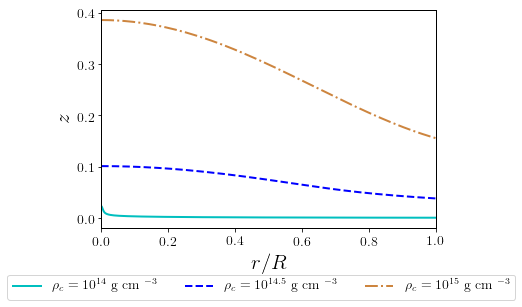

In [482]:
fig = plt.figure()

plt.plot(bpal12_140[-1]/bpal12_140[-1][-1],np.exp(-bpal12_140[3])-1.0,color='c',linewidth='2.0',label=r'$\rho_c=10^{14}$ g cm $^{-3}$')
plt.plot(bpal12_145[-1]/bpal12_145[-1][-1],np.exp(-bpal12_145[3])-1.0,color='blue',linewidth='2.0',linestyle='--',label=r'$\rho_c=10^{14.5}$ g cm $^{-3}$')
plt.plot(bpal12_150[-1]/bpal12_150[-1][-1],np.exp(-bpal12_150[3])-1.0,color='peru',linewidth='2.0',linestyle='-.',label=r'$\rho_c=10^{15}$ g cm $^{-3}$')

l = plt.legend(bbox_to_anchor=(1.1,-0.15), loc="lower right", 
                bbox_transform=fig.transFigure, ncol=3)

plt.xlabel(r'$r/R$')
plt.ylabel(r'$z$')
plt.xlim(0,1.0)

plt.savefig('figures/Redshiftbpal12.pdf', format='pdf', dpi=1000,bbox_inches="tight")

# BSK19 ---------------------------------------------------------------------------------------

In [483]:
rhobsk19,Pbsk19,nbsk19=np.loadtxt('EOS/bsk19.dat',usecols=(2,1,0),unpack=True)

## Dominant energy condition

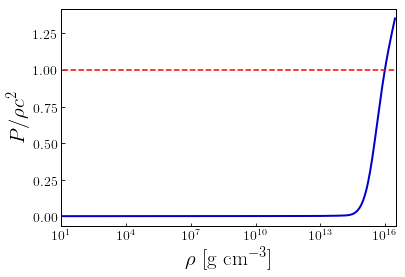

<Figure size 432x288 with 0 Axes>

In [484]:
fig, ax = plt.subplots()
plt.plot(rhobsk19,np.divide(Pbsk19,rhobsk19),lw='2',color='mediumblue')
plt.plot([0,10**(17)],[1.0,1.0],'r--',lw='1.5')

ax.set_xscale("log")
#locmaj = matplotlib.ticker.LogLocator(base=10.0,numticks=16) 
#ax.xaxis.set_major_locator(locmaj)


plt.xlabel(r'$\rho$ [g\,\,cm$^{-3}$]')
plt.ylabel(r'$ P / \rho c^2 $')
#locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks=16)
#ax.xaxis.set_minor_locator(locmin)
#ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.tick_params(axis="x", direction="in")
ax.tick_params(axis="y", direction="in")
plt.xlim(10,10**(16.5))
#ax.set_facecolor('floralwhite')
#plt.gca().set_aspect('equal', adjustable='box')
#plt.draw()
#plt.ylim(0,1)
plt.savefig('figures/ECbsk19.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()
plt.clf()

## Speed of sound

In [485]:
vsquared=interpolate.UnivariateSpline(rhobsk19, Pbsk19, k=3, s=0).derivative(n=1)

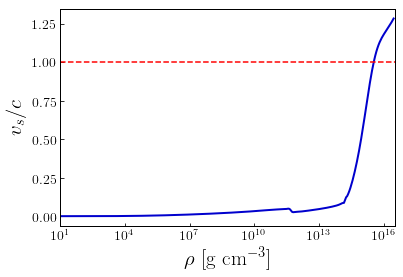

In [486]:
fig, ax = plt.subplots()
plt.plot(rhobsk19,np.sqrt(vsquared(rhobsk19)),lw='2.0',color='mediumblue')
plt.plot([1e+1,10**(16.5)],[1.0,1.0],'r--',lw='1.5')
plt.xlabel(r'$\rho$ [g\,\,cm$^{-3}$]')
plt.ylabel(r'$ v_s / c $')
plt.xscale('log')
ax.tick_params(axis="x", direction="in")
ax.tick_params(axis="y", direction="in")
plt.xlim(10,10**(16.5))
#ax.set_facecolor('floralwhite')
#mpl.rcParams['axes.linewidth'] = 1.4
#plt.gca().set_aspect('equal', adjustable='box')
#plt.draw()
plt.savefig('figures/SSbsk19.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

## M - $\rho_c$

In [493]:
Rbsk19,Mbsk19,rhocbsk19=np.loadtxt('results/bsk19/MRrhoc.dat',usecols=(0,1,2),unpack=True)

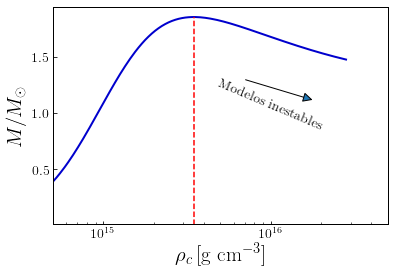

In [497]:
fig, ax = plt.subplots()

plt.plot(rhocbsk19,Mbsk19,color='mediumblue',lw='2.0')
plt.plot([10**(np.log10(rhocbsk19[np.argmax(Mbsk19)])),10**(np.log10(rhocbsk19[np.argmax(Mbsk19)]))],[0.0,np.amax(Mbsk19)],'r--',lw='1.5')

prop = dict(arrowstyle="-|>,head_width=0.4,head_length=0.8",
            shrinkA=0,shrinkB=0)
plt.annotate("", xy=(10**(16.25),1.12), xytext=(10**(15.85),1.3), arrowprops=prop)
#plt.arrow(10**(15.6), 1.38,10**(15.7) ,-0.1 , head_width=0.05, head_length=10**(15))
plt.text(10**(15.67), 1.23, 'Modelos inestables' , fontsize=14,rotation=-23)

plt.xscale('log')
plt.xlabel(r'$\rho_c\,[$g cm$^{-3}]$')
plt.ylabel(r'$M/M_{\odot}$')
plt.xlim(left=10**(14.7),right=10**(16.7))
plt.ylim(bottom=0.01)
ax.tick_params(axis="x", direction="in",which='both')
ax.tick_params(axis="y", direction="in",which='both')

plt.savefig('figures/Mrhorel_bsk19.pdf', format='pdf', dpi=1000,bbox_inches="tight")

## Effective and critical adiabatic index

In [80]:
rhoscbsk19,betasbsk19,gamma_efsbsk19,gamma_crsbsk19 = aindex_stab('bsk19')

ValueError: x must be strictly increasing

In [ ]:
fig, ax = plt.subplots()
plt.plot(betasbsk19,gamma_crsbsk19,lw='1.5',color='r',linestyle='--',label=r'$\gamma_{cr}$')
#plt.plot([betacrit,betacrit],[0,5])
plt.plot(betasbsk19,gamma_efsbsk19,lw='2.0',color='blue',label=r'$\langle \gamma \rangle$')

plt.xlabel(r'$\beta$')
plt.ylabel(r'$\langle \gamma \rangle$')

#plt.xscale('log')
#plt.xlim(left=10**(14.7),right=10**(16.7))
plt.ylim(0,6)
ax.tick_params(axis="x", direction="in",which='both')
ax.tick_params(axis="y", direction="in",which='both')
#l = plt.legend(bbox_to_anchor=(0.85,-0.15), loc="lower right", 
                #bbox_transform=fig.transFigure, ncol=2)



plt.savefig('figures/AIndexStabbsk19.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

## Tunning the interpolation of the solution

### 14.0

In [19]:
bsk19_140=np.loadtxt('results/bsk19/14.0.dat',unpack=True)
bsk19_140[3] = bsk19_140[3]-bsk19_140[3][-1] + 0.5*np.log(1-2*bsk19_140[0][-1]/bsk19_140[-1][-1])

In [20]:
s1=5e-7
s2=1e-15
bsk19_140rho=interpolate.UnivariateSpline(bsk19_140[-1], bsk19_140[2], k=5, s=s1)
bsk19_140drho=interpolate.UnivariateSpline(bsk19_140[-1], bsk19_140[2], k=5, s=s1).derivative(n=1)
bsk19_140ddrho=interpolate.UnivariateSpline(bsk19_140[-1], bsk19_140[2], k=5, s=s1).derivative(n=2)

bsk19_140p=interpolate.UnivariateSpline(bsk19_140[-1], bsk19_140[1], k=5, s=s2)
bsk19_140dp=interpolate.UnivariateSpline(bsk19_140[-1], bsk19_140[1], k=5, s=s2).derivative(n=1)
bsk19_140ddp=interpolate.UnivariateSpline(bsk19_140[-1], bsk19_140[1], k=5, s=s2).derivative(n=2)

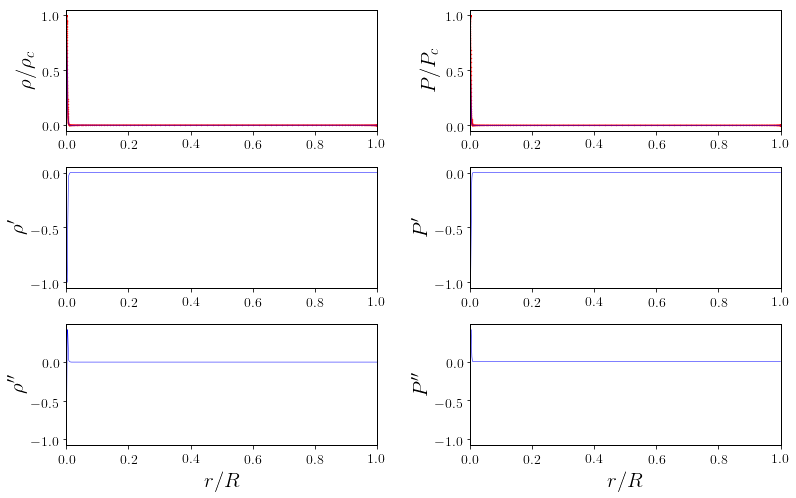

In [500]:
fig=plt.figure(figsize=[12.8,8])

plt.subplot(321)
plt.plot(bsk19_140[-1]/bsk19_140[-1][-1],bsk19_140[2]/bsk19_140[2][0],color='red',marker='o',markersize='0.4') 
plt.plot(bsk19_140[-1]/bsk19_140[-1][-1],bsk19_140rho(bsk19_140[-1])/bsk19_140[2][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1) # leaving the crust out

plt.subplot(322)
plt.plot(bsk19_140[-1]/bsk19_140[-1][-1],bsk19_140[1]/bsk19_140[1][0],color='red',marker='o',markersize='0.4') 
plt.plot(bsk19_140[-1]/bsk19_140[-1][-1],bsk19_140p(bsk19_140[-1])/bsk19_140[1][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$P/P_c$')
plt.xlim(0,1)

plt.subplot(323)
plt.plot(bsk19_140[-1]/bsk19_140[-1][-1],bsk19_140drho(bsk19_140[-1])/max(abs(bsk19_140drho(bsk19_140[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime}$')
plt.xlim(0,1)
#plt.ylim(-500,0)

plt.subplot(324)
plt.plot(bsk19_140[-1]/bsk19_140[-1][-1],bsk19_140dp(bsk19_140[-1])/max(abs(bsk19_140dp(bsk19_140[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime} $')
plt.xlim(0,1)

plt.subplot(325)
plt.plot(bsk19_140[-1]/bsk19_140[-1][-1],bsk19_140ddrho(bsk19_140[-1])/max(abs(bsk19_140ddrho(bsk19_140[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}$')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-0.01,0.01)

plt.subplot(326)
plt.plot(bsk19_140[-1]/bsk19_140[-1][-1],bsk19_140ddp(bsk19_140[-1])/max(abs(bsk19_140ddp(bsk19_140[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime\prime}$ ')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-1,1)

fig.subplots_adjust(hspace=0.3,wspace=0.3)

#plt.savefig('figures/ddsbsk19_140.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

### 14.5

In [21]:
bsk19_145=np.loadtxt('results/bsk19/14.5.dat',unpack=True)
bsk19_145[3] = bsk19_145[3]-bsk19_145[3][-1] + 0.5*np.log(1-2*bsk19_145[0][-1]/bsk19_145[-1][-1])

In [22]:
s1=1e-7
s2=1e-12
bsk19_145rho=interpolate.UnivariateSpline(bsk19_145[-1], bsk19_145[2], k=5, s=s1)
bsk19_145drho=interpolate.UnivariateSpline(bsk19_145[-1], bsk19_145[2], k=5, s=s1).derivative(n=1)
bsk19_145ddrho=interpolate.UnivariateSpline(bsk19_145[-1], bsk19_145[2], k=5, s=s1).derivative(n=2)

bsk19_145p=interpolate.UnivariateSpline(bsk19_145[-1], bsk19_145[1], k=5, s=s2)
bsk19_145dp=interpolate.UnivariateSpline(bsk19_145[-1], bsk19_145[1], k=5, s=s2).derivative(n=1)
bsk19_145ddp=interpolate.UnivariateSpline(bsk19_145[-1], bsk19_145[1], k=5, s=s2).derivative(n=2)

In [503]:
bsk19_145rho(0.4*bsk19_145[-1][-1])*rhodim

89316488615561.86

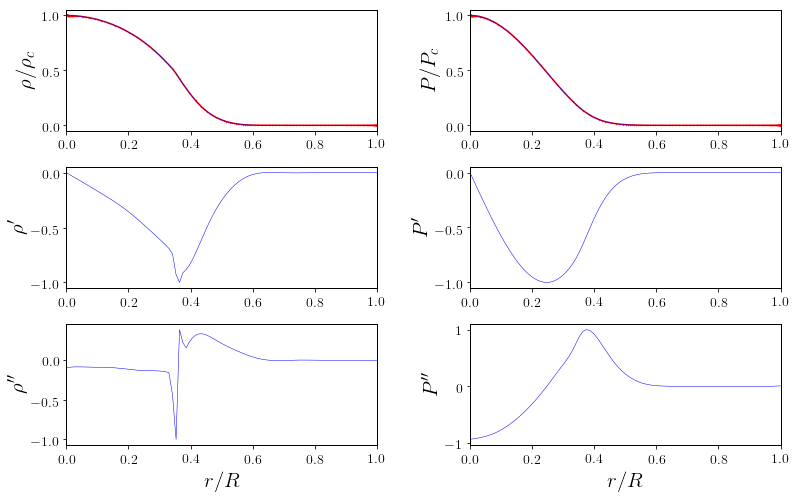

In [504]:
fig=plt.figure(figsize=[12.8,8])

plt.subplot(321)
plt.plot(bsk19_145[-1]/bsk19_145[-1][-1],bsk19_145[2]/bsk19_145[2][0],color='red',marker='o',markersize='0.4') 
plt.plot(bsk19_145[-1]/bsk19_145[-1][-1],bsk19_145rho(bsk19_145[-1])/bsk19_145[2][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1) # leaving the crust out

plt.subplot(322)
plt.plot(bsk19_145[-1]/bsk19_145[-1][-1],bsk19_145[1]/bsk19_145[1][0],color='red',marker='o',markersize='0.4') 
plt.plot(bsk19_145[-1]/bsk19_145[-1][-1],bsk19_145p(bsk19_145[-1])/bsk19_145[1][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$P/P_c$')
plt.xlim(0,1)

plt.subplot(323)
plt.plot(bsk19_145[-1]/bsk19_145[-1][-1],bsk19_145drho(bsk19_145[-1])/max(abs(bsk19_145drho(bsk19_145[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime}$')
plt.xlim(0,1)
#plt.ylim(-500,0)

plt.subplot(324)
plt.plot(bsk19_145[-1]/bsk19_145[-1][-1],bsk19_145dp(bsk19_145[-1])/max(abs(bsk19_145dp(bsk19_145[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime} $')
plt.xlim(0,1)

plt.subplot(325)
plt.plot(bsk19_145[-1]/bsk19_145[-1][-1],bsk19_145ddrho(bsk19_145[-1])/max(abs(bsk19_145ddrho(bsk19_145[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}$')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-0.01,0.01)

plt.subplot(326)
plt.plot(bsk19_145[-1]/bsk19_145[-1][-1],bsk19_145ddp(bsk19_145[-1])/max(abs(bsk19_145ddp(bsk19_145[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime\prime}$ ')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-1,1)

fig.subplots_adjust(hspace=0.3,wspace=0.3)

#plt.savefig('figures/ddsbsk19_145.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

### 15.0

In [505]:
bsk19_150=np.loadtxt('results/bsk19/15.0.dat',unpack=True)
bsk19_150[3] = bsk19_150[3]-bsk19_150[3][-1] + 0.5*np.log(1-2*bsk19_150[0][-1]/bsk19_150[-1][-1])

In [506]:
s1=8e-6
s2=1e-15
bsk19_150rho=interpolate.UnivariateSpline(bsk19_150[-1], bsk19_150[2], k=5, s=s1)
bsk19_150drho=interpolate.UnivariateSpline(bsk19_150[-1], bsk19_150[2], k=5, s=s1).derivative(n=1)
bsk19_150ddrho=interpolate.UnivariateSpline(bsk19_150[-1], bsk19_150[2], k=5, s=s1).derivative(n=2)

bsk19_150p=interpolate.UnivariateSpline(bsk19_150[-1], bsk19_150[1], k=5, s=s2)
bsk19_150dp=interpolate.UnivariateSpline(bsk19_150[-1], bsk19_150[1], k=5, s=s2).derivative(n=1)
bsk19_150ddp=interpolate.UnivariateSpline(bsk19_150[-1], bsk19_150[1], k=5, s=s2).derivative(n=2)

ValueError: x must be strictly increasing

NameError: name 'bsk19_150rho' is not defined

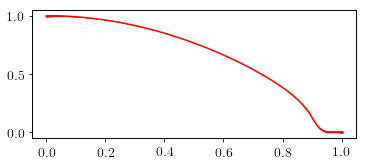

In [507]:
fig=plt.figure(figsize=[12.8,8])

plt.subplot(321)
plt.plot(bsk19_150[-1]/bsk19_150[-1][-1],bsk19_150[2]/bsk19_150[2][0],color='red',marker='o',markersize='0.4') 
plt.plot(bsk19_150[-1]/bsk19_150[-1][-1],bsk19_150rho(bsk19_150[-1])/bsk19_150[2][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1) # leaving the crust out

plt.subplot(322)
plt.plot(bsk19_150[-1]/bsk19_150[-1][-1],bsk19_150[1]/bsk19_150[1][0],color='red',marker='o',markersize='0.4') 
plt.plot(bsk19_150[-1]/bsk19_150[-1][-1],bsk19_150p(bsk19_150[-1])/bsk19_150[1][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$P/P_c$')
plt.xlim(0,1)

plt.subplot(323)
plt.plot(bsk19_150[-1]/bsk19_150[-1][-1],bsk19_150drho(bsk19_150[-1])/max(abs(bsk19_150drho(bsk19_150[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime}$')
plt.xlim(0,1)
#plt.ylim(-500,0)

plt.subplot(324)
plt.plot(bsk19_150[-1]/bsk19_150[-1][-1],bsk19_150dp(bsk19_150[-1])/max(abs(bsk19_150dp(bsk19_150[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime} $')
plt.xlim(0,1)

plt.subplot(325)
plt.plot(bsk19_150[-1]/bsk19_150[-1][-1],bsk19_150ddrho(bsk19_150[-1])/max(abs(bsk19_150ddrho(bsk19_150[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}$')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-0.01,0.01)

plt.subplot(326)
plt.plot(bsk19_150[-1]/bsk19_150[-1][-1],bsk19_150ddp(bsk19_150[-1])/max(abs(bsk19_150ddp(bsk19_150[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime\prime}$ ')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-1,1)

fig.subplots_adjust(hspace=0.3,wspace=0.3)

#plt.savefig('figures/ddsbsk19_150.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

### 15.5

In [508]:
bsk19_155=np.loadtxt('results/bsk19/15.5.dat',unpack=True)
bsk19_155[3] = bsk19_155[3]-bsk19_155[3][-1] + 0.5*np.log(1-2*bsk19_155[0][-1]/bsk19_155[-1][-1])

In [509]:
s1=1e-5
s2=1e-9
bsk19_155rho=interpolate.UnivariateSpline(bsk19_155[-1], bsk19_155[2], k=5, s=s1)
bsk19_155drho=interpolate.UnivariateSpline(bsk19_155[-1], bsk19_155[2], k=5, s=s1).derivative(n=1)
bsk19_155ddrho=interpolate.UnivariateSpline(bsk19_155[-1], bsk19_155[2], k=5, s=s1).derivative(n=2)

bsk19_155p=interpolate.UnivariateSpline(bsk19_155[-1], bsk19_155[1], k=5, s=s2)
bsk19_155dp=interpolate.UnivariateSpline(bsk19_155[-1], bsk19_155[1], k=5, s=s2).derivative(n=1)
bsk19_155ddp=interpolate.UnivariateSpline(bsk19_155[-1], bsk19_155[1], k=5, s=s2).derivative(n=2)

ValueError: x must be strictly increasing

NameError: name 'bsk19_155rho' is not defined

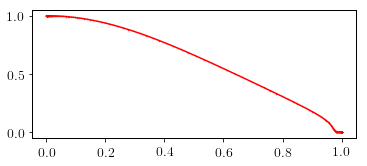

In [510]:
fig=plt.figure(figsize=[12.8,8])

plt.subplot(321)
plt.plot(bsk19_155[-1]/bsk19_155[-1][-1],bsk19_155[2]/bsk19_155[2][0],color='red',marker='o',markersize='0.4') 
plt.plot(bsk19_155[-1]/bsk19_155[-1][-1],bsk19_155rho(bsk19_155[-1])/bsk19_155[2][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1) # leaving the crust out

plt.subplot(322)
plt.plot(bsk19_155[-1]/bsk19_155[-1][-1],bsk19_155[1]/bsk19_155[1][0],color='red',marker='o',markersize='0.4') 
plt.plot(bsk19_155[-1]/bsk19_155[-1][-1],bsk19_155p(bsk19_155[-1])/bsk19_155[1][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$P/P_c$')
plt.xlim(0,1)

plt.subplot(323)
plt.plot(bsk19_155[-1]/bsk19_155[-1][-1],bsk19_155drho(bsk19_155[-1])/max(abs(bsk19_155drho(bsk19_155[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime}$')
plt.xlim(0,1)
#plt.ylim(-500,0)

plt.subplot(324)
plt.plot(bsk19_155[-1]/bsk19_155[-1][-1],bsk19_155dp(bsk19_155[-1])/max(abs(bsk19_155dp(bsk19_155[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime} $')
plt.xlim(0,1)

plt.subplot(325)
plt.plot(bsk19_155[-1]/bsk19_155[-1][-1],bsk19_155ddrho(bsk19_155[-1])/max(abs(bsk19_155ddrho(bsk19_155[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}$')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-0.01,0.01)

plt.subplot(326)
plt.plot(bsk19_155[-1]/bsk19_155[-1][-1],bsk19_155ddp(bsk19_155[-1])/max(abs(bsk19_155ddp(bsk19_155[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime\prime}$ ')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-1,1)

fig.subplots_adjust(hspace=0.3,wspace=0.3)

#plt.savefig('figures/ddsbsk19_155.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

## Adiabatic convection

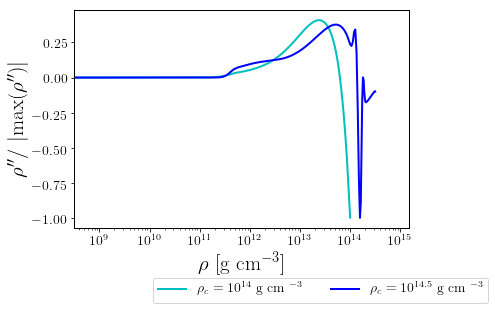

In [23]:
fig, ax = plt.subplots()

ax.set_xscale("log")

plt.plot(bsk19_140[2]*rhodim,bsk19_140ddrho(bsk19_140[-1])/max(abs(bsk19_140ddrho(bsk19_140[-1]))),color='c',linewidth='2.0',label=r'$\rho_c=10^{14}$ g cm $^{-3}$') 
plt.plot(bsk19_145[2]*rhodim,bsk19_145ddrho(bsk19_145[-1])/max(abs(bsk19_145ddrho(bsk19_145[-1]))),color='blue',linewidth='2.0',linestyle='-',label=r'$\rho_c=10^{14.5}$ g cm $^{-3}$') 
#plt.plot(bsk19_150[2]*rhodim,bsk19_150ddrho(bsk19_150[-1])/max(abs(bsk19_150ddrho(bsk19_150[-1]))),color='peru',linewidth='2.0',linestyle='-',label=r'$\rho_c=10^{15}$ g cm$ ^{-3}$')
plt.xlim(left=10**(8.5))
#plt.plot(bsk19_155[-1]/bsk19_155[-1][-1],bsk19_155drho(bsk19_155[-1])/max(abs(bsk19_155drho(bsk19_140[-1]))),color='yellow',linewidth='2.0',linestyle='-.',label=r'$\rho_c=10^{15.5}$ g cm$ ^{-3}$')

l = plt.legend(bbox_to_anchor=(1.1,-0.16), loc="lower right", 
                bbox_transform=fig.transFigure, ncol=3)

plt.xlabel(r'$\rho$ [g cm$^{-3}$]')
plt.ylabel(r'$\rho^{\prime \prime}/$ $|$max$(\rho^{\prime \prime})|$')
#plt.xlim(0,1.0)

plt.savefig('figures/ConvecStabilitybsk19Correl.pdf', format='pdf', dpi=1000,bbox_inches="tight")

## Redshift

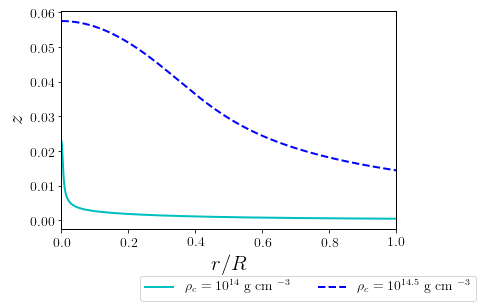

In [33]:
fig = plt.figure()

plt.plot(bsk19_140[-1]/bsk19_140[-1][-1],np.exp(-bsk19_140[3])-1.0,color='c',linewidth='2.0',label=r'$\rho_c=10^{14}$ g cm $^{-3}$')
plt.plot(bsk19_145[-1]/bsk19_145[-1][-1],np.exp(-bsk19_145[3])-1.0,color='blue',linewidth='2.0',linestyle='--',label=r'$\rho_c=10^{14.5}$ g cm $^{-3}$')
#plt.plot(bsk19_150[-1]/bsk19_150[-1][-1],np.exp(-bsk19_150[3])-1.0,color='peru',linewidth='2.0',linestyle='-.',label=r'$\rho_c=10^{15}$ g cm $^{-3}$')

l = plt.legend(bbox_to_anchor=(1.1,-0.15), loc="lower right", 
                bbox_transform=fig.transFigure, ncol=3)

plt.xlabel(r'$r/R$')
plt.ylabel(r'$z$')
plt.xlim(0,1.0)

plt.savefig('figures/Redshiftbsk19.pdf', format='pdf', dpi=1000,bbox_inches="tight")

# BSK20 -----------------------------------------------------------------------------------

In [512]:
rhobsk20,Pbsk20,nbsk20=np.loadtxt('EOS/bsk20.dat',usecols=(2,1,0),unpack=True)

## Dominant energy condition

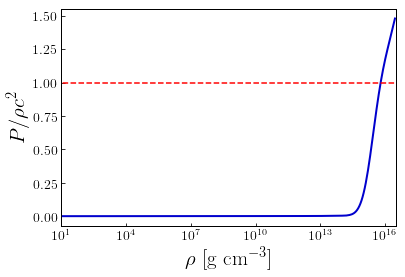

<Figure size 432x288 with 0 Axes>

In [513]:
fig, ax = plt.subplots()
plt.plot(rhobsk20,np.divide(Pbsk20,rhobsk20),lw='2',color='mediumblue')
plt.plot([0,10**(17)],[1.0,1.0],'r--',lw='1.5')

ax.set_xscale("log")
#locmaj = matplotlib.ticker.LogLocator(base=10.0,numticks=16) 
#ax.xaxis.set_major_locator(locmaj)


plt.xlabel(r'$\rho$ [g\,\,cm$^{-3}$]')
plt.ylabel(r'$ P / \rho c^2 $')
#locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks=16)
#ax.xaxis.set_minor_locator(locmin)
#ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.tick_params(axis="x", direction="in")
ax.tick_params(axis="y", direction="in")
plt.xlim(10,10**(16.5))
#ax.set_facecolor('floralwhite')
#plt.gca().set_aspect('equal', adjustable='box')
#plt.draw()
#plt.ylim(0,1)
plt.savefig('figures/ECbsk20.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()
plt.clf()

## Speed of sound

In [514]:
vsquared=interpolate.UnivariateSpline(rhobsk20, Pbsk20, k=3, s=0).derivative(n=1)

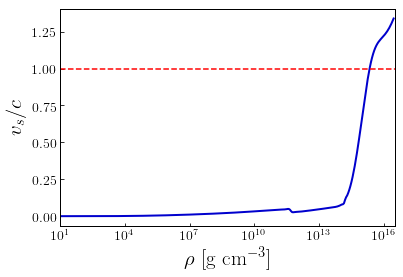

In [515]:
fig, ax = plt.subplots()
plt.plot(rhobsk20,np.sqrt(vsquared(rhobsk20)),lw='2.0',color='mediumblue')
plt.plot([1e+1,10**(16.5)],[1.0,1.0],'r--',lw='1.5')
plt.xlabel(r'$\rho$ [g\,\,cm$^{-3}$]')
plt.ylabel(r'$ v_s / c $')
plt.xscale('log')
ax.tick_params(axis="x", direction="in")
ax.tick_params(axis="y", direction="in")
plt.xlim(10,10**(16.5))
#ax.set_facecolor('floralwhite')
#mpl.rcParams['axes.linewidth'] = 1.4
#plt.gca().set_aspect('equal', adjustable='box')
#plt.draw()
plt.savefig('figures/SSbsk20.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

## M - $\rho_c$

In [522]:
Rbsk20,Mbsk20,rhocbsk20=np.loadtxt('results/bsk20/MRrhoc.dat',usecols=(0,1,2),unpack=True)

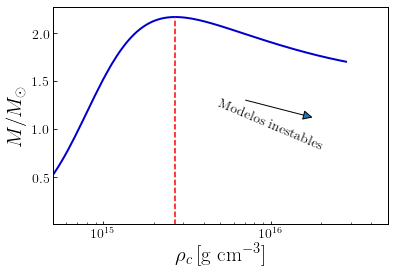

In [526]:
fig, ax = plt.subplots()

plt.plot(rhocbsk20,Mbsk20,color='mediumblue',lw='2.0')
plt.plot([10**(np.log10(rhocbsk20[np.argmax(Mbsk20)])),10**(np.log10(rhocbsk20[np.argmax(Mbsk20)]))],[0.0,np.amax(Mbsk20)],'r--',lw='1.5')

prop = dict(arrowstyle="-|>,head_width=0.4,head_length=0.8",
            shrinkA=0,shrinkB=0)
plt.annotate("", xy=(10**(16.25),1.12), xytext=(10**(15.85),1.3), arrowprops=prop)
#plt.arrow(10**(15.6), 1.38,10**(15.7) ,-0.1 , head_width=0.05, head_length=10**(15))
plt.text(10**(15.67), 1.23, 'Modelos inestables' , fontsize=14,rotation=-23)

plt.xscale('log')
plt.xlabel(r'$\rho_c\,[$g cm$^{-3}]$')
plt.ylabel(r'$M/M_{\odot}$')
plt.xlim(left=10**(14.7),right=10**(16.7))
plt.ylim(bottom=0.01)
ax.tick_params(axis="x", direction="in",which='both')
ax.tick_params(axis="y", direction="in",which='both')

plt.savefig('figures/Mrhorel_bsk20.pdf', format='pdf', dpi=1000,bbox_inches="tight")

## Effective and critical adiabatic index

In [6]:
rhoscbsk20,betasbsk20,gamma_efsbsk20,gamma_crsbsk20 = aindex_stab('bsk20')

ValueError: x must be strictly increasing

In [ ]:
fig, ax = plt.subplots()
plt.plot(betasbsk20,gamma_crsbsk20,lw='1.5',color='r',linestyle='--',label=r'$\gamma_{cr}$')
#plt.plot([betacrit,betacrit],[0,5])
plt.plot(betasbsk20,gamma_efsbsk20,lw='2.0',color='blue',label=r'$\langle \gamma \rangle$')

plt.xlabel(r'$\beta$')
plt.ylabel(r'$\langle \gamma \rangle$')

#plt.xscale('log')
#plt.xlim(left=10**(14.7),right=10**(16.7))
plt.ylim(0,6)
ax.tick_params(axis="x", direction="in",which='both')
ax.tick_params(axis="y", direction="in",which='both')
#l = plt.legend(bbox_to_anchor=(0.85,-0.15), loc="lower right", 
                #bbox_transform=fig.transFigure, ncol=2)



plt.savefig('figures/AIndexStabbsk20.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

## Tunning the interpolation of the solution

### 14.0

In [8]:
bsk20_140=np.loadtxt('results/bsk20/14.0.dat',unpack=True)
bsk20_140[3] = bsk20_140[3]-bsk20_140[3][-1] + 0.5*np.log(1-2*bsk20_140[0][-1]/bsk20_140[-1][-1])

In [9]:
s1=5e-7
s2=1e-15
bsk20_140rho=interpolate.UnivariateSpline(bsk20_140[-1], bsk20_140[2], k=5, s=s1)
bsk20_140drho=interpolate.UnivariateSpline(bsk20_140[-1], bsk20_140[2], k=5, s=s1).derivative(n=1)
bsk20_140ddrho=interpolate.UnivariateSpline(bsk20_140[-1], bsk20_140[2], k=5, s=s1).derivative(n=2)

bsk20_140p=interpolate.UnivariateSpline(bsk20_140[-1], bsk20_140[1], k=5, s=s2)
bsk20_140dp=interpolate.UnivariateSpline(bsk20_140[-1], bsk20_140[1], k=5, s=s2).derivative(n=1)
bsk20_140ddp=interpolate.UnivariateSpline(bsk20_140[-1], bsk20_140[1], k=5, s=s2).derivative(n=2)

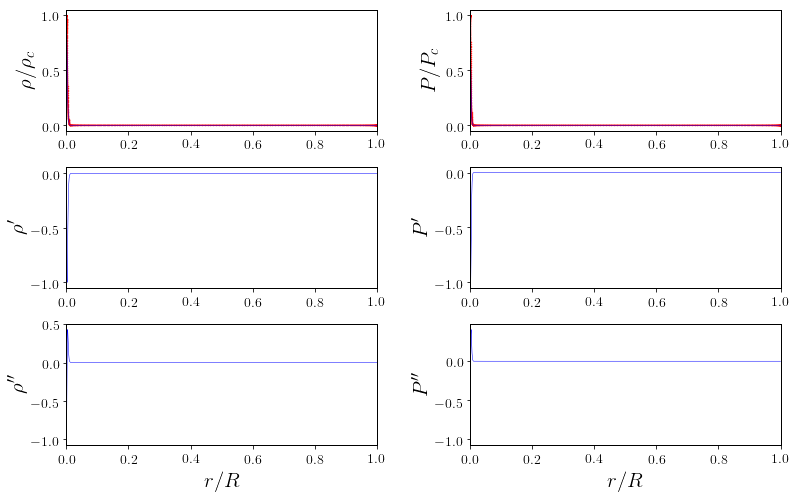

In [10]:
fig=plt.figure(figsize=[12.8,8])

plt.subplot(321)
plt.plot(bsk20_140[-1]/bsk20_140[-1][-1],bsk20_140[2]/bsk20_140[2][0],color='red',marker='o',markersize='0.4') 
plt.plot(bsk20_140[-1]/bsk20_140[-1][-1],bsk20_140rho(bsk20_140[-1])/bsk20_140[2][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1) # leaving the crust out

plt.subplot(322)
plt.plot(bsk20_140[-1]/bsk20_140[-1][-1],bsk20_140[1]/bsk20_140[1][0],color='red',marker='o',markersize='0.4') 
plt.plot(bsk20_140[-1]/bsk20_140[-1][-1],bsk20_140p(bsk20_140[-1])/bsk20_140[1][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$P/P_c$')
plt.xlim(0,1)

plt.subplot(323)
plt.plot(bsk20_140[-1]/bsk20_140[-1][-1],bsk20_140drho(bsk20_140[-1])/max(abs(bsk20_140drho(bsk20_140[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime}$')
plt.xlim(0,1)
#plt.ylim(-500,0)

plt.subplot(324)
plt.plot(bsk20_140[-1]/bsk20_140[-1][-1],bsk20_140dp(bsk20_140[-1])/max(abs(bsk20_140dp(bsk20_140[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime} $')
plt.xlim(0,1)

plt.subplot(325)
plt.plot(bsk20_140[-1]/bsk20_140[-1][-1],bsk20_140ddrho(bsk20_140[-1])/max(abs(bsk20_140ddrho(bsk20_140[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}$')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-0.01,0.01)

plt.subplot(326)
plt.plot(bsk20_140[-1]/bsk20_140[-1][-1],bsk20_140ddp(bsk20_140[-1])/max(abs(bsk20_140ddp(bsk20_140[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime\prime}$ ')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-1,1)

fig.subplots_adjust(hspace=0.3,wspace=0.3)

#plt.savefig('figures/ddsbsk20_140.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

### 14.5

In [11]:
bsk20_145=np.loadtxt('results/bsk20/14.5.dat',unpack=True)
bsk20_145[3] = bsk20_145[3]-bsk20_145[3][-1] + 0.5*np.log(1-2*bsk20_145[0][-1]/bsk20_145[-1][-1])

In [12]:
s1=1e-7
s2=1e-12
bsk20_145rho=interpolate.UnivariateSpline(bsk20_145[-1], bsk20_145[2], k=5, s=s1)
bsk20_145drho=interpolate.UnivariateSpline(bsk20_145[-1], bsk20_145[2], k=5, s=s1).derivative(n=1)
bsk20_145ddrho=interpolate.UnivariateSpline(bsk20_145[-1], bsk20_145[2], k=5, s=s1).derivative(n=2)

bsk20_145p=interpolate.UnivariateSpline(bsk20_145[-1], bsk20_145[1], k=5, s=s2)
bsk20_145dp=interpolate.UnivariateSpline(bsk20_145[-1], bsk20_145[1], k=5, s=s2).derivative(n=1)
bsk20_145ddp=interpolate.UnivariateSpline(bsk20_145[-1], bsk20_145[1], k=5, s=s2).derivative(n=2)

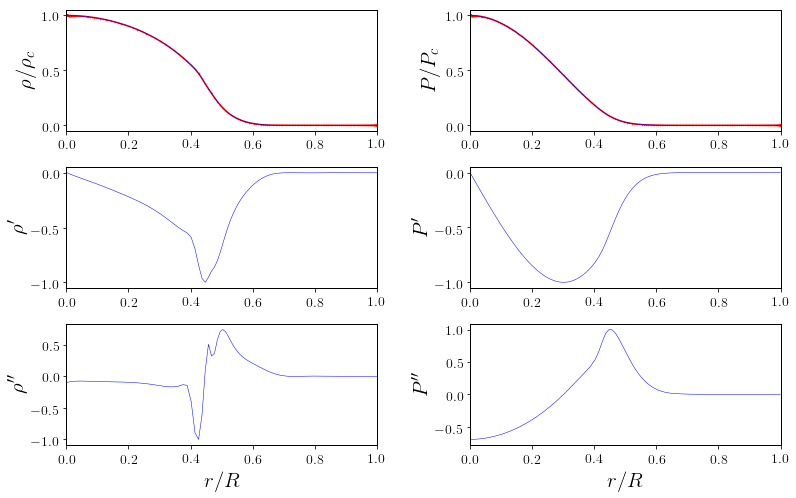

In [533]:
fig=plt.figure(figsize=[12.8,8])

plt.subplot(321)
plt.plot(bsk20_145[-1]/bsk20_145[-1][-1],bsk20_145[2]/bsk20_145[2][0],color='red',marker='o',markersize='0.4') 
plt.plot(bsk20_145[-1]/bsk20_145[-1][-1],bsk20_145rho(bsk20_145[-1])/bsk20_145[2][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1) # leaving the crust out

plt.subplot(322)
plt.plot(bsk20_145[-1]/bsk20_145[-1][-1],bsk20_145[1]/bsk20_145[1][0],color='red',marker='o',markersize='0.4') 
plt.plot(bsk20_145[-1]/bsk20_145[-1][-1],bsk20_145p(bsk20_145[-1])/bsk20_145[1][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$P/P_c$')
plt.xlim(0,1)

plt.subplot(323)
plt.plot(bsk20_145[-1]/bsk20_145[-1][-1],bsk20_145drho(bsk20_145[-1])/max(abs(bsk20_145drho(bsk20_145[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime}$')
plt.xlim(0,1)
#plt.ylim(-500,0)

plt.subplot(324)
plt.plot(bsk20_145[-1]/bsk20_145[-1][-1],bsk20_145dp(bsk20_145[-1])/max(abs(bsk20_145dp(bsk20_145[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime} $')
plt.xlim(0,1)

plt.subplot(325)
plt.plot(bsk20_145[-1]/bsk20_145[-1][-1],bsk20_145ddrho(bsk20_145[-1])/max(abs(bsk20_145ddrho(bsk20_145[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}$')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-0.01,0.01)

plt.subplot(326)
plt.plot(bsk20_145[-1]/bsk20_145[-1][-1],bsk20_145ddp(bsk20_145[-1])/max(abs(bsk20_145ddp(bsk20_145[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime\prime}$ ')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-1,1)

fig.subplots_adjust(hspace=0.3,wspace=0.3)

#plt.savefig('figures/ddsbsk20_145.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

### 15.0

In [14]:
bsk20_150=np.loadtxt('results/bsk20/15.0.dat',unpack=True)
bsk20_150[3] = bsk20_150[3]-bsk20_150[3][-1] + 0.5*np.log(1-2*bsk20_150[0][-1]/bsk20_150[-1][-1])

In [15]:
s1=8e-6
s2=1e-15
bsk20_150rho=interpolate.UnivariateSpline(bsk20_150[-1], bsk20_150[2], k=5, s=s1)
bsk20_150drho=interpolate.UnivariateSpline(bsk20_150[-1], bsk20_150[2], k=5, s=s1).derivative(n=1)
bsk20_150ddrho=interpolate.UnivariateSpline(bsk20_150[-1], bsk20_150[2], k=5, s=s1).derivative(n=2)

bsk20_150p=interpolate.UnivariateSpline(bsk20_150[-1], bsk20_150[1], k=5, s=s2)
bsk20_150dp=interpolate.UnivariateSpline(bsk20_150[-1], bsk20_150[1], k=5, s=s2).derivative(n=1)
bsk20_150ddp=interpolate.UnivariateSpline(bsk20_150[-1], bsk20_150[1], k=5, s=s2).derivative(n=2)

ValueError: x must be strictly increasing

NameError: name 'bsk20_150rho' is not defined

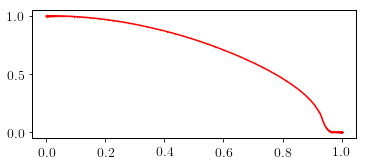

In [536]:
fig=plt.figure(figsize=[12.8,8])

plt.subplot(321)
plt.plot(bsk20_150[-1]/bsk20_150[-1][-1],bsk20_150[2]/bsk20_150[2][0],color='red',marker='o',markersize='0.4') 
plt.plot(bsk20_150[-1]/bsk20_150[-1][-1],bsk20_150rho(bsk20_150[-1])/bsk20_150[2][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1) # leaving the crust out

plt.subplot(322)
plt.plot(bsk20_150[-1]/bsk20_150[-1][-1],bsk20_150[1]/bsk20_150[1][0],color='red',marker='o',markersize='0.4') 
plt.plot(bsk20_150[-1]/bsk20_150[-1][-1],bsk20_150p(bsk20_150[-1])/bsk20_150[1][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$P/P_c$')
plt.xlim(0,1)

plt.subplot(323)
plt.plot(bsk20_150[-1]/bsk20_150[-1][-1],bsk20_150drho(bsk20_150[-1])/max(abs(bsk20_150drho(bsk20_150[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime}$')
plt.xlim(0,1)
#plt.ylim(-500,0)

plt.subplot(324)
plt.plot(bsk20_150[-1]/bsk20_150[-1][-1],bsk20_150dp(bsk20_150[-1])/max(abs(bsk20_150dp(bsk20_150[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime} $')
plt.xlim(0,1)

plt.subplot(325)
plt.plot(bsk20_150[-1]/bsk20_150[-1][-1],bsk20_150ddrho(bsk20_150[-1])/max(abs(bsk20_150ddrho(bsk20_150[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}$')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-0.01,0.01)

plt.subplot(326)
plt.plot(bsk20_150[-1]/bsk20_150[-1][-1],bsk20_150ddp(bsk20_150[-1])/max(abs(bsk20_150ddp(bsk20_150[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime\prime}$ ')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-1,1)

fig.subplots_adjust(hspace=0.3,wspace=0.3)

#plt.savefig('figures/ddsbsk20_150.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

### 15.5

In [16]:
bsk20_155=np.loadtxt('results/bsk20/15.5.dat',unpack=True)
bsk20_155[3] = bsk20_155[3]-bsk20_155[3][-1] + 0.5*np.log(1-2*bsk20_155[0][-1]/bsk20_155[-1][-1])

In [17]:
s1=1e-5
s2=1e-9
bsk20_155rho=interpolate.UnivariateSpline(bsk20_155[-1], bsk20_155[2], k=5, s=s1)
bsk20_155drho=interpolate.UnivariateSpline(bsk20_155[-1], bsk20_155[2], k=5, s=s1).derivative(n=1)
bsk20_155ddrho=interpolate.UnivariateSpline(bsk20_155[-1], bsk20_155[2], k=5, s=s1).derivative(n=2)

bsk20_155p=interpolate.UnivariateSpline(bsk20_155[-1], bsk20_155[1], k=5, s=s2)
bsk20_155dp=interpolate.UnivariateSpline(bsk20_155[-1], bsk20_155[1], k=5, s=s2).derivative(n=1)
bsk20_155ddp=interpolate.UnivariateSpline(bsk20_155[-1], bsk20_155[1], k=5, s=s2).derivative(n=2)

ValueError: x must be strictly increasing

NameError: name 'bsk20_155rho' is not defined

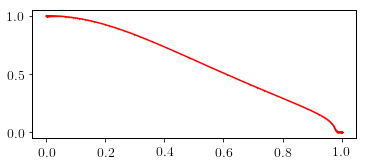

In [539]:
fig=plt.figure(figsize=[12.8,8])

plt.subplot(321)
plt.plot(bsk20_155[-1]/bsk20_155[-1][-1],bsk20_155[2]/bsk20_155[2][0],color='red',marker='o',markersize='0.4') 
plt.plot(bsk20_155[-1]/bsk20_155[-1][-1],bsk20_155rho(bsk20_155[-1])/bsk20_155[2][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1) # leaving the crust out

plt.subplot(322)
plt.plot(bsk20_155[-1]/bsk20_155[-1][-1],bsk20_155[1]/bsk20_155[1][0],color='red',marker='o',markersize='0.4') 
plt.plot(bsk20_155[-1]/bsk20_155[-1][-1],bsk20_155p(bsk20_155[-1])/bsk20_155[1][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$P/P_c$')
plt.xlim(0,1)

plt.subplot(323)
plt.plot(bsk20_155[-1]/bsk20_155[-1][-1],bsk20_155drho(bsk20_155[-1])/max(abs(bsk20_155drho(bsk20_155[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime}$')
plt.xlim(0,1)
#plt.ylim(-500,0)

plt.subplot(324)
plt.plot(bsk20_155[-1]/bsk20_155[-1][-1],bsk20_155dp(bsk20_155[-1])/max(abs(bsk20_155dp(bsk20_155[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime} $')
plt.xlim(0,1)

plt.subplot(325)
plt.plot(bsk20_155[-1]/bsk20_155[-1][-1],bsk20_155ddrho(bsk20_155[-1])/max(abs(bsk20_155ddrho(bsk20_155[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}$')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-0.01,0.01)

plt.subplot(326)
plt.plot(bsk20_155[-1]/bsk20_155[-1][-1],bsk20_155ddp(bsk20_155[-1])/max(abs(bsk20_155ddp(bsk20_155[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime\prime}$ ')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-1,1)

fig.subplots_adjust(hspace=0.3,wspace=0.3)

#plt.savefig('figures/ddsbsk20_155.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

## Adiabatic convection

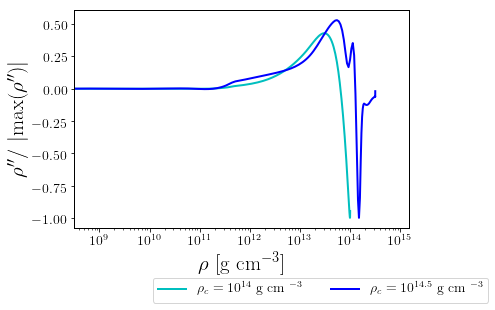

In [24]:
fig, ax = plt.subplots()

ax.set_xscale("log")

plt.plot(bsk20_140[2]*rhodim,bsk20_140ddrho(bsk20_140[-1])/max(abs(bsk20_140ddrho(bsk20_140[-1]))),color='c',linewidth='2.0',label=r'$\rho_c=10^{14}$ g cm $^{-3}$') 
plt.plot(bsk20_145[2]*rhodim,bsk20_145ddrho(bsk20_145[-1])/max(abs(bsk20_145ddrho(bsk20_145[-1]))),color='blue',linewidth='2.0',linestyle='-',label=r'$\rho_c=10^{14.5}$ g cm $^{-3}$') 
#plt.plot(bsk20_150[2]*rhodim,bsk20_150ddrho(bsk20_150[-1])/max(abs(bsk20_150ddrho(bsk20_150[-1]))),color='peru',linewidth='2.0',linestyle='-',label=r'$\rho_c=10^{15}$ g cm$ ^{-3}$')
plt.xlim(left=10**(8.5))
#plt.plot(bsk20_155[-1]/bsk20_155[-1][-1],bsk20_155drho(bsk20_155[-1])/max(abs(bsk20_155drho(bsk20_140[-1]))),color='yellow',linewidth='2.0',linestyle='-.',label=r'$\rho_c=10^{15.5}$ g cm$ ^{-3}$')

l = plt.legend(bbox_to_anchor=(1.1,-0.16), loc="lower right", 
                bbox_transform=fig.transFigure, ncol=3)

plt.xlabel(r'$\rho$ [g cm$^{-3}$]')
plt.ylabel(r'$\rho^{\prime \prime}/$ $|$max$(\rho^{\prime \prime})|$')
#plt.xlim(0,1.0)

plt.savefig('figures/ConvecStabilitybsk20Correl.pdf', format='pdf', dpi=1000,bbox_inches="tight")

## Redshift

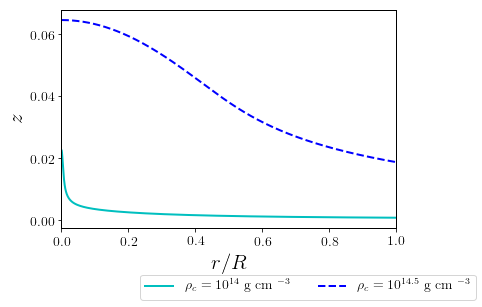

In [25]:
fig = plt.figure()

plt.plot(bsk20_140[-1]/bsk20_140[-1][-1],np.exp(-bsk20_140[3])-1.0,color='c',linewidth='2.0',label=r'$\rho_c=10^{14}$ g cm $^{-3}$')
plt.plot(bsk20_145[-1]/bsk20_145[-1][-1],np.exp(-bsk20_145[3])-1.0,color='blue',linewidth='2.0',linestyle='--',label=r'$\rho_c=10^{14.5}$ g cm $^{-3}$')
#plt.plot(bsk20_150[-1]/bsk20_150[-1][-1],np.exp(-bsk20_150[3])-1.0,color='peru',linewidth='2.0',linestyle='-.',label=r'$\rho_c=10^{15}$ g cm $^{-3}$')

l = plt.legend(bbox_to_anchor=(1.1,-0.15), loc="lower right", 
                bbox_transform=fig.transFigure, ncol=3)

plt.xlabel(r'$r/R$')
plt.ylabel(r'$z$')
plt.xlim(0,1.0)

plt.savefig('figures/Redshiftbsk20.pdf', format='pdf', dpi=1000,bbox_inches="tight")

# BSK21 ---------------------------------------------------------------------------------------

In [541]:
rhobsk21,Pbsk21,nbsk21=np.loadtxt('EOS/bsk21.dat',usecols=(2,1,0),unpack=True)

## Dominant energy condition

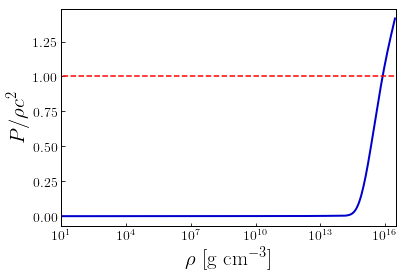

<Figure size 432x288 with 0 Axes>

In [542]:
fig, ax = plt.subplots()
plt.plot(rhobsk21,np.divide(Pbsk21,rhobsk21),lw='2',color='mediumblue')
plt.plot([0,10**(17)],[1.0,1.0],'r--',lw='1.5')

ax.set_xscale("log")
#locmaj = matplotlib.ticker.LogLocator(base=10.0,numticks=16) 
#ax.xaxis.set_major_locator(locmaj)


plt.xlabel(r'$\rho$ [g\,\,cm$^{-3}$]')
plt.ylabel(r'$ P / \rho c^2 $')
#locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks=16)
#ax.xaxis.set_minor_locator(locmin)
#ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.tick_params(axis="x", direction="in")
ax.tick_params(axis="y", direction="in")
plt.xlim(10,10**(16.5))
#ax.set_facecolor('floralwhite')
#plt.gca().set_aspect('equal', adjustable='box')
#plt.draw()
#plt.ylim(0,1)
plt.savefig('figures/ECbsk21.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()
plt.clf()

## Speed of sound

In [543]:
vsquared=interpolate.UnivariateSpline(rhobsk21, Pbsk21, k=3, s=0).derivative(n=1)

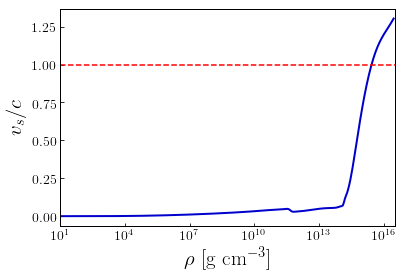

In [544]:
fig, ax = plt.subplots()
plt.plot(rhobsk21,np.sqrt(vsquared(rhobsk21)),lw='2.0',color='mediumblue')
plt.plot([1e+1,10**(16.5)],[1.0,1.0],'r--',lw='1.5')
plt.xlabel(r'$\rho$ [g\,\,cm$^{-3}$]')
plt.ylabel(r'$ v_s / c $')
plt.xscale('log')
ax.tick_params(axis="x", direction="in")
ax.tick_params(axis="y", direction="in")
plt.xlim(10,10**(16.5))
#ax.set_facecolor('floralwhite')
#mpl.rcParams['axes.linewidth'] = 1.4
#plt.gca().set_aspect('equal', adjustable='box')
#plt.draw()
plt.savefig('figures/SSbsk21.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

## M - $\rho_c$

In [551]:
Rbsk21,Mbsk21,rhocbsk21=np.loadtxt('results/bsk21/MRrhoc.dat',usecols=(0,1,2),unpack=True)

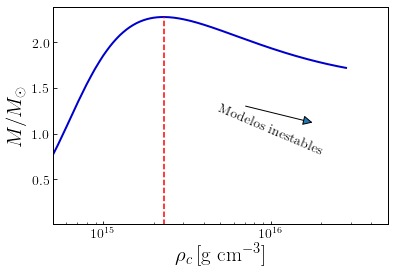

In [555]:
fig, ax = plt.subplots()

plt.plot(rhocbsk21,Mbsk21,color='mediumblue',lw='2.0')
plt.plot([10**(np.log10(rhocbsk21[np.argmax(Mbsk21)])),10**(np.log10(rhocbsk21[np.argmax(Mbsk21)]))],[0.0,np.amax(Mbsk21)],'r--',lw='1.5')

prop = dict(arrowstyle="-|>,head_width=0.4,head_length=0.8",
            shrinkA=0,shrinkB=0)
plt.annotate("", xy=(10**(16.25),1.12), xytext=(10**(15.85),1.3), arrowprops=prop)
#plt.arrow(10**(15.6), 1.38,10**(15.7) ,-0.1 , head_width=0.05, head_length=10**(15))
plt.text(10**(15.67), 1.23, 'Modelos inestables' , fontsize=14,rotation=-23)

plt.xscale('log')
plt.xlabel(r'$\rho_c\,[$g cm$^{-3}]$')
plt.ylabel(r'$M/M_{\odot}$')
plt.xlim(left=10**(14.7),right=10**(16.7))
plt.ylim(bottom=0.01)
ax.tick_params(axis="x", direction="in",which='both')
ax.tick_params(axis="y", direction="in",which='both')

plt.savefig('figures/Mrhorel_bsk21.pdf', format='pdf', dpi=1000,bbox_inches="tight")

## Effective and critical adiabatic index

In [26]:
rhoscbsk21,betasbsk21,gamma_efsbsk21,gamma_crsbsk21 = aindex_stab('bsk21')

ValueError: x must be strictly increasing

In [ ]:
fig, ax = plt.subplots()
plt.plot(betasbsk21,gamma_crsbsk21,lw='1.5',color='r',linestyle='--',label=r'$\gamma_{cr}$')
#plt.plot([betacrit,betacrit],[0,5])
plt.plot(betasbsk21,gamma_efsbsk21,lw='2.0',color='blue',label=r'$\langle \gamma \rangle$')

plt.xlabel(r'$\beta$')
plt.ylabel(r'$\langle \gamma \rangle$')

#plt.xscale('log')
#plt.xlim(left=10**(14.7),right=10**(16.7))
plt.ylim(0,6)
ax.tick_params(axis="x", direction="in",which='both')
ax.tick_params(axis="y", direction="in",which='both')
#l = plt.legend(bbox_to_anchor=(0.85,-0.15), loc="lower right", 
                #bbox_transform=fig.transFigure, ncol=2)



plt.savefig('figures/AIndexStabbsk21.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

## Tunning the interpolation of the solution

### 14.0

In [27]:
bsk21_140=np.loadtxt('results/bsk21/14.0.dat',unpack=True)
bsk21_140[3] = bsk21_140[3]-bsk21_140[3][-1] + 0.5*np.log(1-2*bsk21_140[0][-1]/bsk21_140[-1][-1])

In [28]:
s1=5e-7
s2=1e-15
bsk21_140rho=interpolate.UnivariateSpline(bsk21_140[-1], bsk21_140[2], k=5, s=s1)
bsk21_140drho=interpolate.UnivariateSpline(bsk21_140[-1], bsk21_140[2], k=5, s=s1).derivative(n=1)
bsk21_140ddrho=interpolate.UnivariateSpline(bsk21_140[-1], bsk21_140[2], k=5, s=s1).derivative(n=2)

bsk21_140p=interpolate.UnivariateSpline(bsk21_140[-1], bsk21_140[1], k=5, s=s2)
bsk21_140dp=interpolate.UnivariateSpline(bsk21_140[-1], bsk21_140[1], k=5, s=s2).derivative(n=1)
bsk21_140ddp=interpolate.UnivariateSpline(bsk21_140[-1], bsk21_140[1], k=5, s=s2).derivative(n=2)

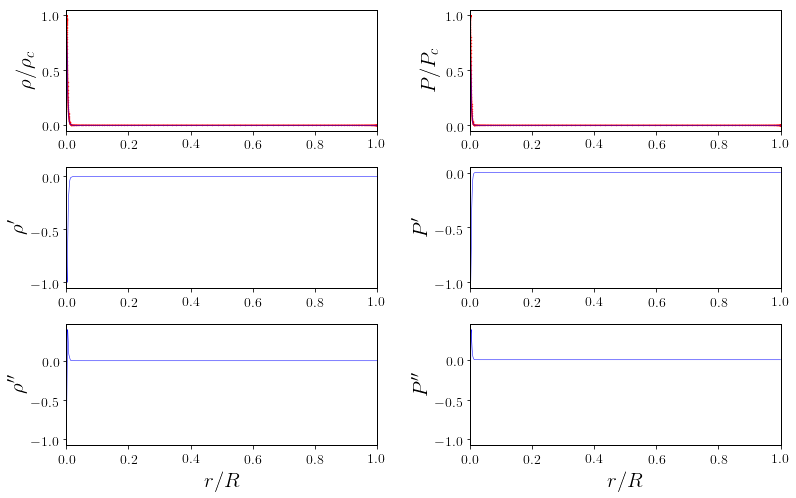

In [558]:
fig=plt.figure(figsize=[12.8,8])

plt.subplot(321)
plt.plot(bsk21_140[-1]/bsk21_140[-1][-1],bsk21_140[2]/bsk21_140[2][0],color='red',marker='o',markersize='0.4') 
plt.plot(bsk21_140[-1]/bsk21_140[-1][-1],bsk21_140rho(bsk21_140[-1])/bsk21_140[2][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1) # leaving the crust out

plt.subplot(322)
plt.plot(bsk21_140[-1]/bsk21_140[-1][-1],bsk21_140[1]/bsk21_140[1][0],color='red',marker='o',markersize='0.4') 
plt.plot(bsk21_140[-1]/bsk21_140[-1][-1],bsk21_140p(bsk21_140[-1])/bsk21_140[1][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$P/P_c$')
plt.xlim(0,1)

plt.subplot(323)
plt.plot(bsk21_140[-1]/bsk21_140[-1][-1],bsk21_140drho(bsk21_140[-1])/max(abs(bsk21_140drho(bsk21_140[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime}$')
plt.xlim(0,1)
#plt.ylim(-500,0)

plt.subplot(324)
plt.plot(bsk21_140[-1]/bsk21_140[-1][-1],bsk21_140dp(bsk21_140[-1])/max(abs(bsk21_140dp(bsk21_140[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime} $')
plt.xlim(0,1)

plt.subplot(325)
plt.plot(bsk21_140[-1]/bsk21_140[-1][-1],bsk21_140ddrho(bsk21_140[-1])/max(abs(bsk21_140ddrho(bsk21_140[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}$')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-0.01,0.01)

plt.subplot(326)
plt.plot(bsk21_140[-1]/bsk21_140[-1][-1],bsk21_140ddp(bsk21_140[-1])/max(abs(bsk21_140ddp(bsk21_140[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime\prime}$ ')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-1,1)

fig.subplots_adjust(hspace=0.3,wspace=0.3)

#plt.savefig('figures/ddsbsk21_140.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

### 14.5

In [29]:
bsk21_145=np.loadtxt('results/bsk21/14.5.dat',unpack=True)
bsk21_145[3] = bsk21_145[3]-bsk21_145[3][-1] + 0.5*np.log(1-2*bsk21_145[0][-1]/bsk21_145[-1][-1])

In [30]:
s1=1e-7
s2=1e-12
bsk21_145rho=interpolate.UnivariateSpline(bsk21_145[-1], bsk21_145[2], k=5, s=s1)
bsk21_145drho=interpolate.UnivariateSpline(bsk21_145[-1], bsk21_145[2], k=5, s=s1).derivative(n=1)
bsk21_145ddrho=interpolate.UnivariateSpline(bsk21_145[-1], bsk21_145[2], k=5, s=s1).derivative(n=2)

bsk21_145p=interpolate.UnivariateSpline(bsk21_145[-1], bsk21_145[1], k=5, s=s2)
bsk21_145dp=interpolate.UnivariateSpline(bsk21_145[-1], bsk21_145[1], k=5, s=s2).derivative(n=1)
bsk21_145ddp=interpolate.UnivariateSpline(bsk21_145[-1], bsk21_145[1], k=5, s=s2).derivative(n=2)

In [561]:
bsk21_145rho(0.4*bsk21_145[-1][-1])*rhodim

240973640467011.56

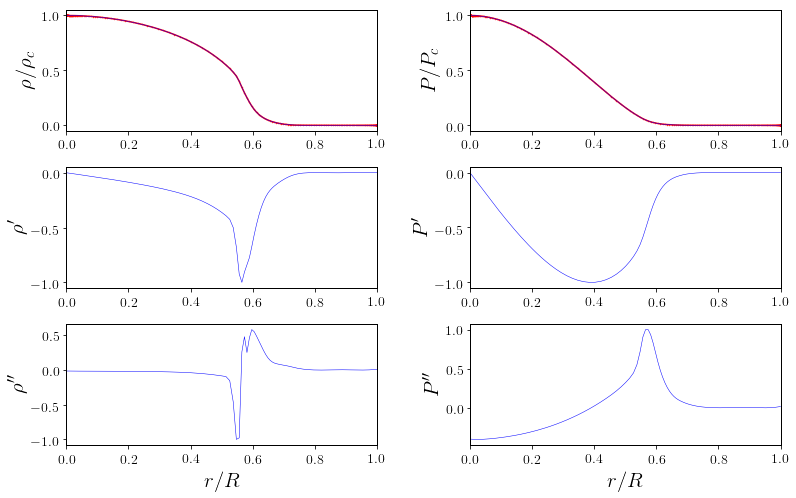

In [562]:
fig=plt.figure(figsize=[12.8,8])

plt.subplot(321)
plt.plot(bsk21_145[-1]/bsk21_145[-1][-1],bsk21_145[2]/bsk21_145[2][0],color='red',marker='o',markersize='0.4') 
plt.plot(bsk21_145[-1]/bsk21_145[-1][-1],bsk21_145rho(bsk21_145[-1])/bsk21_145[2][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1) # leaving the crust out

plt.subplot(322)
plt.plot(bsk21_145[-1]/bsk21_145[-1][-1],bsk21_145[1]/bsk21_145[1][0],color='red',marker='o',markersize='0.4') 
plt.plot(bsk21_145[-1]/bsk21_145[-1][-1],bsk21_145p(bsk21_145[-1])/bsk21_145[1][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$P/P_c$')
plt.xlim(0,1)

plt.subplot(323)
plt.plot(bsk21_145[-1]/bsk21_145[-1][-1],bsk21_145drho(bsk21_145[-1])/max(abs(bsk21_145drho(bsk21_145[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime}$')
plt.xlim(0,1)
#plt.ylim(-500,0)

plt.subplot(324)
plt.plot(bsk21_145[-1]/bsk21_145[-1][-1],bsk21_145dp(bsk21_145[-1])/max(abs(bsk21_145dp(bsk21_145[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime} $')
plt.xlim(0,1)

plt.subplot(325)
plt.plot(bsk21_145[-1]/bsk21_145[-1][-1],bsk21_145ddrho(bsk21_145[-1])/max(abs(bsk21_145ddrho(bsk21_145[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}$')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-0.01,0.01)

plt.subplot(326)
plt.plot(bsk21_145[-1]/bsk21_145[-1][-1],bsk21_145ddp(bsk21_145[-1])/max(abs(bsk21_145ddp(bsk21_145[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime\prime}$ ')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-1,1)

fig.subplots_adjust(hspace=0.3,wspace=0.3)

#plt.savefig('figures/ddsbsk21_145.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

### 15.0

In [31]:
bsk21_150=np.loadtxt('results/bsk21/15.0.dat',unpack=True)
bsk21_150[3] = bsk21_150[3]-bsk21_150[3][-1] + 0.5*np.log(1-2*bsk21_150[0][-1]/bsk21_150[-1][-1])

In [32]:
s1=8e-6
s2=1e-15
bsk21_150rho=interpolate.UnivariateSpline(bsk21_150[-1], bsk21_150[2], k=5, s=s1)
bsk21_150drho=interpolate.UnivariateSpline(bsk21_150[-1], bsk21_150[2], k=5, s=s1).derivative(n=1)
bsk21_150ddrho=interpolate.UnivariateSpline(bsk21_150[-1], bsk21_150[2], k=5, s=s1).derivative(n=2)

bsk21_150p=interpolate.UnivariateSpline(bsk21_150[-1], bsk21_150[1], k=5, s=s2)
bsk21_150dp=interpolate.UnivariateSpline(bsk21_150[-1], bsk21_150[1], k=5, s=s2).derivative(n=1)
bsk21_150ddp=interpolate.UnivariateSpline(bsk21_150[-1], bsk21_150[1], k=5, s=s2).derivative(n=2)

ValueError: x must be strictly increasing

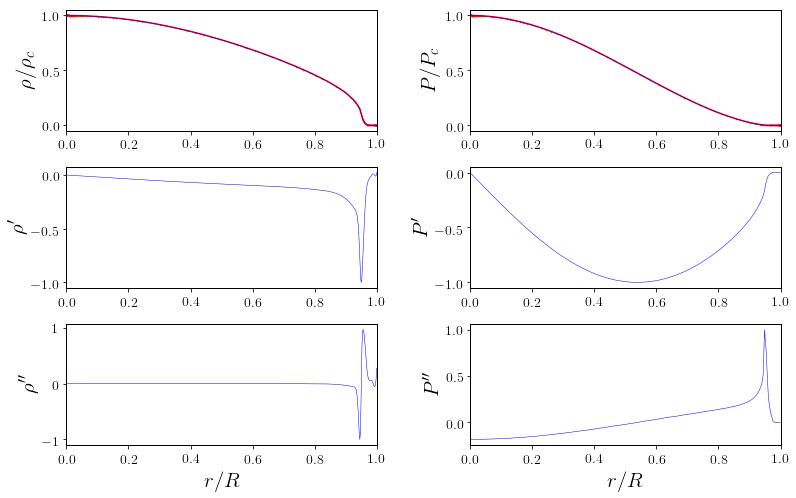

In [565]:
fig=plt.figure(figsize=[12.8,8])

plt.subplot(321)
plt.plot(bsk21_150[-1]/bsk21_150[-1][-1],bsk21_150[2]/bsk21_150[2][0],color='red',marker='o',markersize='0.4') 
plt.plot(bsk21_150[-1]/bsk21_150[-1][-1],bsk21_150rho(bsk21_150[-1])/bsk21_150[2][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1) # leaving the crust out

plt.subplot(322)
plt.plot(bsk21_150[-1]/bsk21_150[-1][-1],bsk21_150[1]/bsk21_150[1][0],color='red',marker='o',markersize='0.4') 
plt.plot(bsk21_150[-1]/bsk21_150[-1][-1],bsk21_150p(bsk21_150[-1])/bsk21_150[1][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$P/P_c$')
plt.xlim(0,1)

plt.subplot(323)
plt.plot(bsk21_150[-1]/bsk21_150[-1][-1],bsk21_150drho(bsk21_150[-1])/max(abs(bsk21_150drho(bsk21_150[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime}$')
plt.xlim(0,1)
#plt.ylim(-500,0)

plt.subplot(324)
plt.plot(bsk21_150[-1]/bsk21_150[-1][-1],bsk21_150dp(bsk21_150[-1])/max(abs(bsk21_150dp(bsk21_150[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime} $')
plt.xlim(0,1)

plt.subplot(325)
plt.plot(bsk21_150[-1]/bsk21_150[-1][-1],bsk21_150ddrho(bsk21_150[-1])/max(abs(bsk21_150ddrho(bsk21_150[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}$')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-0.01,0.01)

plt.subplot(326)
plt.plot(bsk21_150[-1]/bsk21_150[-1][-1],bsk21_150ddp(bsk21_150[-1])/max(abs(bsk21_150ddp(bsk21_150[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime\prime}$ ')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-1,1)

fig.subplots_adjust(hspace=0.3,wspace=0.3)

#plt.savefig('figures/ddsbsk21_150.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

### 15.5

In [566]:
bsk21_155=np.loadtxt('results/bsk21/15.5.dat',unpack=True)
bsk21_155[3] = bsk21_155[3]-bsk21_155[3][-1] + 0.5*np.log(1-2*bsk21_155[0][-1]/bsk21_155[-1][-1])

In [567]:
s1=1e-5
s2=1e-9
bsk21_155rho=interpolate.UnivariateSpline(bsk21_155[-1], bsk21_155[2], k=5, s=s1)
bsk21_155drho=interpolate.UnivariateSpline(bsk21_155[-1], bsk21_155[2], k=5, s=s1).derivative(n=1)
bsk21_155ddrho=interpolate.UnivariateSpline(bsk21_155[-1], bsk21_155[2], k=5, s=s1).derivative(n=2)

bsk21_155p=interpolate.UnivariateSpline(bsk21_155[-1], bsk21_155[1], k=5, s=s2)
bsk21_155dp=interpolate.UnivariateSpline(bsk21_155[-1], bsk21_155[1], k=5, s=s2).derivative(n=1)
bsk21_155ddp=interpolate.UnivariateSpline(bsk21_155[-1], bsk21_155[1], k=5, s=s2).derivative(n=2)

ValueError: x must be strictly increasing

NameError: name 'bsk21_155rho' is not defined

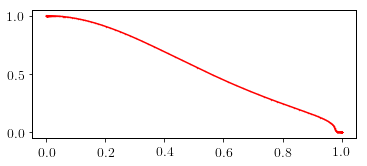

In [568]:
fig=plt.figure(figsize=[12.8,8])

plt.subplot(321)
plt.plot(bsk21_155[-1]/bsk21_155[-1][-1],bsk21_155[2]/bsk21_155[2][0],color='red',marker='o',markersize='0.4') 
plt.plot(bsk21_155[-1]/bsk21_155[-1][-1],bsk21_155rho(bsk21_155[-1])/bsk21_155[2][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1) # leaving the crust out

plt.subplot(322)
plt.plot(bsk21_155[-1]/bsk21_155[-1][-1],bsk21_155[1]/bsk21_155[1][0],color='red',marker='o',markersize='0.4') 
plt.plot(bsk21_155[-1]/bsk21_155[-1][-1],bsk21_155p(bsk21_155[-1])/bsk21_155[1][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$P/P_c$')
plt.xlim(0,1)

plt.subplot(323)
plt.plot(bsk21_155[-1]/bsk21_155[-1][-1],bsk21_155drho(bsk21_155[-1])/max(abs(bsk21_155drho(bsk21_155[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime}$')
plt.xlim(0,1)
#plt.ylim(-500,0)

plt.subplot(324)
plt.plot(bsk21_155[-1]/bsk21_155[-1][-1],bsk21_155dp(bsk21_155[-1])/max(abs(bsk21_155dp(bsk21_155[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime} $')
plt.xlim(0,1)

plt.subplot(325)
plt.plot(bsk21_155[-1]/bsk21_155[-1][-1],bsk21_155ddrho(bsk21_155[-1])/max(abs(bsk21_155ddrho(bsk21_155[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}$')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-0.01,0.01)

plt.subplot(326)
plt.plot(bsk21_155[-1]/bsk21_155[-1][-1],bsk21_155ddp(bsk21_155[-1])/max(abs(bsk21_155ddp(bsk21_155[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime\prime}$ ')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-1,1)

fig.subplots_adjust(hspace=0.3,wspace=0.3)

#plt.savefig('figures/ddsbsk21_155.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

## Adiabatic convection

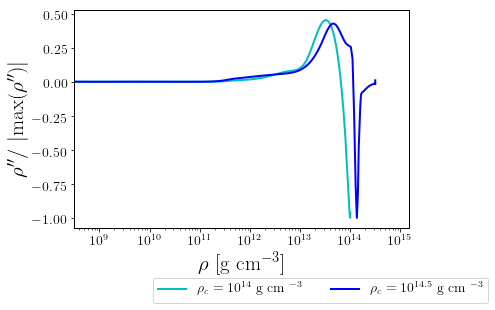

In [34]:
fig, ax = plt.subplots()

ax.set_xscale("log")

plt.plot(bsk21_140[2]*rhodim,bsk21_140ddrho(bsk21_140[-1])/max(abs(bsk21_140ddrho(bsk21_140[-1]))),color='c',linewidth='2.0',label=r'$\rho_c=10^{14}$ g cm $^{-3}$') 
plt.plot(bsk21_145[2]*rhodim,bsk21_145ddrho(bsk21_145[-1])/max(abs(bsk21_145ddrho(bsk21_145[-1]))),color='blue',linewidth='2.0',linestyle='-',label=r'$\rho_c=10^{14.5}$ g cm $^{-3}$') 
#plt.plot(bsk21_150[2]*rhodim,bsk21_150ddrho(bsk21_150[-1])/max(abs(bsk21_150ddrho(bsk21_150[-1]))),color='peru',linewidth='2.0',linestyle='-',label=r'$\rho_c=10^{15}$ g cm$ ^{-3}$')
plt.xlim(left=10**(8.5))
#plt.plot(bsk21_155[-1]/bsk21_155[-1][-1],bsk21_155drho(bsk21_155[-1])/max(abs(bsk21_155drho(bsk21_140[-1]))),color='yellow',linewidth='2.0',linestyle='-.',label=r'$\rho_c=10^{15.5}$ g cm$ ^{-3}$')

l = plt.legend(bbox_to_anchor=(1.1,-0.16), loc="lower right", 
                bbox_transform=fig.transFigure, ncol=3)

plt.xlabel(r'$\rho$ [g cm$^{-3}$]')
plt.ylabel(r'$\rho^{\prime \prime}/$ $|$max$(\rho^{\prime \prime})|$')
#plt.xlim(0,1.0)

plt.savefig('figures/ConvecStabilitybsk21Correl.pdf', format='pdf', dpi=1000,bbox_inches="tight")

## Redshift

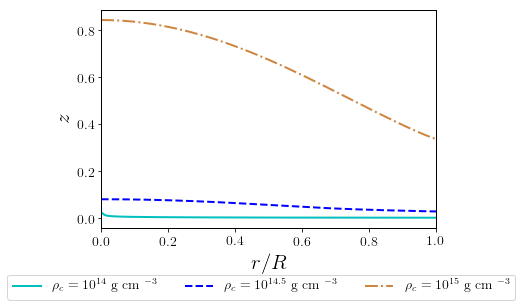

In [569]:
fig = plt.figure()

plt.plot(bsk21_140[-1]/bsk21_140[-1][-1],np.exp(-bsk21_140[3])-1.0,color='c',linewidth='2.0',label=r'$\rho_c=10^{14}$ g cm $^{-3}$')
plt.plot(bsk21_145[-1]/bsk21_145[-1][-1],np.exp(-bsk21_145[3])-1.0,color='blue',linewidth='2.0',linestyle='--',label=r'$\rho_c=10^{14.5}$ g cm $^{-3}$')
#plt.plot(bsk21_150[-1]/bsk21_150[-1][-1],np.exp(-bsk21_150[3])-1.0,color='peru',linewidth='2.0',linestyle='-.',label=r'$\rho_c=10^{15}$ g cm $^{-3}$')

l = plt.legend(bbox_to_anchor=(1.1,-0.15), loc="lower right", 
                bbox_transform=fig.transFigure, ncol=3)

plt.xlabel(r'$r/R$')
plt.ylabel(r'$z$')
plt.xlim(0,1.0)

plt.savefig('figures/Redshiftbsk21.pdf', format='pdf', dpi=1000,bbox_inches="tight")

# ENG ------------------------------------------------------------------------------------------

In [3]:
rhoeng,Peng,neng=np.loadtxt('EOS/eng.dat',usecols=(2,1,0),unpack=True)

## Dominant energy condition

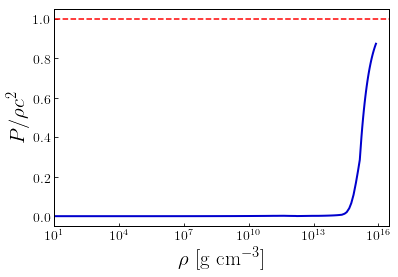

<Figure size 432x288 with 0 Axes>

In [4]:
fig, ax = plt.subplots()
plt.plot(rhoeng,np.divide(Peng,rhoeng),lw='2',color='mediumblue')
plt.plot([0,10**(17)],[1.0,1.0],'r--',lw='1.5')

ax.set_xscale("log")
#locmaj = matplotlib.ticker.LogLocator(base=10.0,numticks=16) 
#ax.xaxis.set_major_locator(locmaj)


plt.xlabel(r'$\rho$ [g\,\,cm$^{-3}$]')
plt.ylabel(r'$ P / \rho c^2 $')
#locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks=16)
#ax.xaxis.set_minor_locator(locmin)
#ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.tick_params(axis="x", direction="in")
ax.tick_params(axis="y", direction="in")
plt.xlim(10,10**(16.5))
#ax.set_facecolor('floralwhite')
#plt.gca().set_aspect('equal', adjustable='box')
#plt.draw()
#plt.ylim(0,1)
plt.savefig('figures/ECeng.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()
plt.clf()

## Speed of sound

In [5]:
vsquared=interpolate.UnivariateSpline(rhoeng, Peng, k=1, s=0).derivative(n=1)

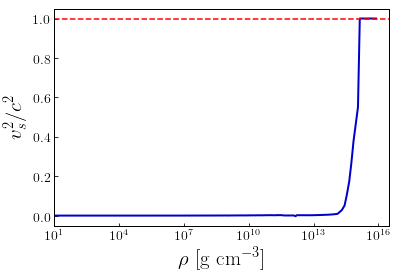

In [6]:
fig, ax = plt.subplots()
plt.plot(rhoeng,vsquared(rhoeng),lw='2.0',color='mediumblue')
plt.plot([1e+1,10**(16.5)],[1.0,1.0],'r--',lw='1.5')
plt.xlabel(r'$\rho$ [g\,\,cm$^{-3}$]')
plt.ylabel(r'$ v^{2}_{s} / c^2 $')
plt.xscale('log')
ax.tick_params(axis="x", direction="in")
ax.tick_params(axis="y", direction="in")
plt.xlim(10,10**(16.5))
#ax.set_facecolor('floralwhite')
#mpl.rcParams['axes.linewidth'] = 1.4
#plt.gca().set_aspect('equal', adjustable='box')
#plt.draw()
plt.savefig('figures/SSeng.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

## M - $\rho_c$

In [43]:
Reng,Meng,rhoceng=np.loadtxt('results/eng/MRrhoc.dat',usecols=(0,1,2),unpack=True)

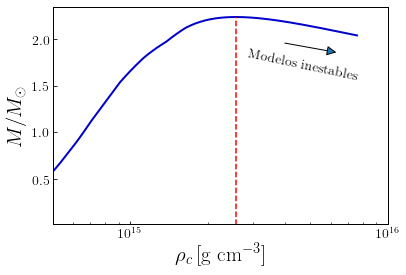

In [137]:
fig, ax = plt.subplots()

plt.plot(rhoceng,Meng,color='mediumblue',lw='2.0')
plt.plot([10**(np.log10(rhoceng[np.argmax(Meng)])),10**(np.log10(rhoceng[np.argmax(Meng)]))],[0.0,np.amax(Meng)],'r--',lw='1.5')

prop = dict(arrowstyle="-|>,head_width=0.4,head_length=0.8",
            shrinkA=0,shrinkB=0)
plt.annotate("", xy=(10**(15.8),1.86), xytext=(10**(15.6),1.96), arrowprops=prop)
#plt.arrow(10**(15.6), 1.38,10**(15.7) ,-0.1 , head_width=0.05, head_length=10**(15))
plt.text(10**(15.45), 1.8, 'Modelos inestables' , fontsize=14,rotation=-12)

plt.xscale('log')
plt.xlabel(r'$\rho_c\,[$g cm$^{-3}]$')
plt.ylabel(r'$M/M_{\odot}$')
plt.xlim(left=10**(14.7),right=10**(16))
plt.ylim(bottom=0.01)
ax.tick_params(axis="x", direction="in",which='both')
ax.tick_params(axis="y", direction="in",which='both')

plt.savefig('figures/Mrhorel_eng.pdf', format='pdf', dpi=1000,bbox_inches="tight")

## Effective and critical adiabatic index

In [35]:
rhosceng,betaseng,gamma_efseng,gamma_crseng = aindex_stab('eng')

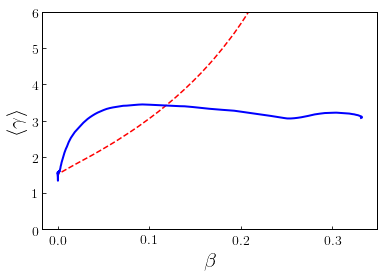

In [36]:
fig, ax = plt.subplots()
plt.plot(betaseng,gamma_crseng,lw='1.5',color='r',linestyle='--',label=r'$\gamma_{cr}$')
#plt.plot([betacrit,betacrit],[0,5])
plt.plot(betaseng,gamma_efseng,lw='2.0',color='blue',label=r'$\langle \gamma \rangle$')

plt.xlabel(r'$\beta$')
plt.ylabel(r'$\langle \gamma \rangle$')

#plt.xscale('log')
#plt.xlim(left=10**(14.7),right=10**(16.7))
plt.ylim(0,6)
ax.tick_params(axis="x", direction="in",which='both')
ax.tick_params(axis="y", direction="in",which='both')
#l = plt.legend(bbox_to_anchor=(0.85,-0.15), loc="lower right", 
                #bbox_transform=fig.transFigure, ncol=2)



plt.savefig('figures/AIndexStabeng.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

## Tunning the interpolation of the solution

### 14.0

In [3]:
eng_140=np.loadtxt('results/eng/14.2.dat',unpack=True)
eng_140[3] = eng_140[3]-eng_140[3][-1] + 0.5*np.log(1-2*eng_140[0][-1]/eng_140[-1][-1])

In [4]:
s1=1e-6
s2=1e-15
eng_140rho=interpolate.UnivariateSpline(eng_140[-1], eng_140[2], k=5, s=s1)
eng_140drho=interpolate.UnivariateSpline(eng_140[-1], eng_140[2], k=5, s=s1).derivative(n=1)
eng_140ddrho=interpolate.UnivariateSpline(eng_140[-1], eng_140[2], k=5, s=s1).derivative(n=2)

eng_140p=interpolate.UnivariateSpline(eng_140[-1], eng_140[1], k=5, s=s2)
eng_140dp=interpolate.UnivariateSpline(eng_140[-1], eng_140[1], k=5, s=s2).derivative(n=1)
eng_140ddp=interpolate.UnivariateSpline(eng_140[-1], eng_140[1], k=5, s=s2).derivative(n=2)

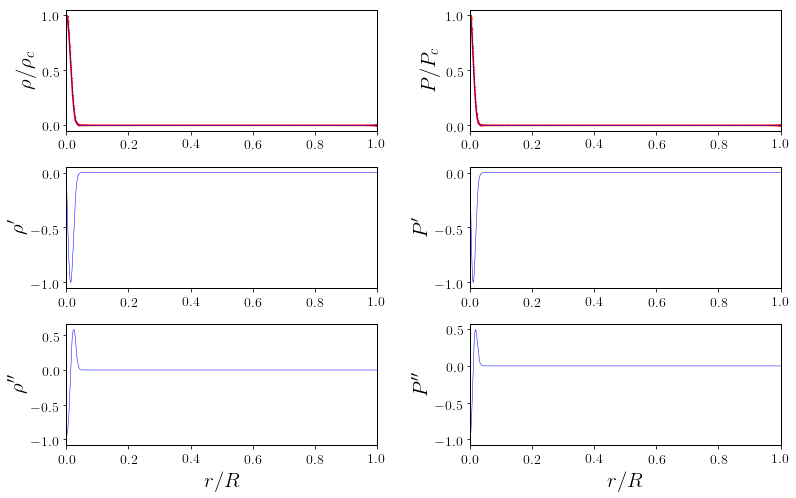

In [5]:
fig=plt.figure(figsize=[12.8,8])

plt.subplot(321)
plt.plot(eng_140[-1]/eng_140[-1][-1],eng_140[2]/eng_140[2][0],color='red',marker='o',markersize='0.4') 
plt.plot(eng_140[-1]/eng_140[-1][-1],eng_140rho(eng_140[-1])/eng_140[2][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1) # leaving the crust out

plt.subplot(322)
plt.plot(eng_140[-1]/eng_140[-1][-1],eng_140[1]/eng_140[1][0],color='red',marker='o',markersize='0.4') 
plt.plot(eng_140[-1]/eng_140[-1][-1],eng_140p(eng_140[-1])/eng_140[1][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$P/P_c$')
plt.xlim(0,1)

plt.subplot(323)
plt.plot(eng_140[-1]/eng_140[-1][-1],eng_140drho(eng_140[-1])/max(abs(eng_140drho(eng_140[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime}$')
plt.xlim(0,1)
#plt.ylim(-500,0)

plt.subplot(324)
plt.plot(eng_140[-1]/eng_140[-1][-1],eng_140dp(eng_140[-1])/max(abs(eng_140dp(eng_140[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime} $')
plt.xlim(0,1)

plt.subplot(325)
plt.plot(eng_140[-1]/eng_140[-1][-1],eng_140ddrho(eng_140[-1])/max(abs(eng_140ddrho(eng_140[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}$')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-0.01,0.01)

plt.subplot(326)
plt.plot(eng_140[-1]/eng_140[-1][-1],eng_140ddp(eng_140[-1])/max(abs(eng_140ddp(eng_140[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime\prime}$ ')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-1,1)

fig.subplots_adjust(hspace=0.3,wspace=0.3)

#plt.savefig('figures/ddseng_140.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

### 14.5

In [6]:
eng_145=np.loadtxt('results/eng/14.5.dat',unpack=True)
eng_145[3] = eng_145[3]-eng_145[3][-1] + 0.5*np.log(1-2*eng_145[0][-1]/eng_145[-1][-1])

In [7]:
s1=1e-6
s2=1e-12
eng_145rho=interpolate.UnivariateSpline(eng_145[-1], eng_145[2], k=5, s=s1)
eng_145drho=interpolate.UnivariateSpline(eng_145[-1], eng_145[2], k=5, s=s1).derivative(n=1)
eng_145ddrho=interpolate.UnivariateSpline(eng_145[-1], eng_145[2], k=5, s=s1).derivative(n=2)

eng_145p=interpolate.UnivariateSpline(eng_145[-1], eng_145[1], k=5, s=s2)
eng_145dp=interpolate.UnivariateSpline(eng_145[-1], eng_145[1], k=5, s=s2).derivative(n=1)
eng_145ddp=interpolate.UnivariateSpline(eng_145[-1], eng_145[1], k=5, s=s2).derivative(n=2)

In [8]:
eng_145rho(0.4*eng_145[-1][-1])*rhodim

146577734757576.25

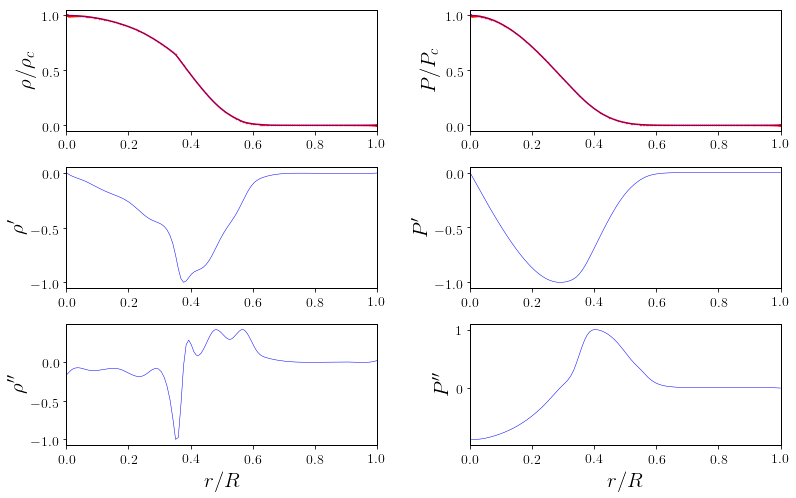

In [9]:
fig=plt.figure(figsize=[12.8,8])

plt.subplot(321)
plt.plot(eng_145[-1]/eng_145[-1][-1],eng_145[2]/eng_145[2][0],color='red',marker='o',markersize='0.4') 
plt.plot(eng_145[-1]/eng_145[-1][-1],eng_145rho(eng_145[-1])/eng_145[2][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1) # leaving the crust out

plt.subplot(322)
plt.plot(eng_145[-1]/eng_145[-1][-1],eng_145[1]/eng_145[1][0],color='red',marker='o',markersize='0.4') 
plt.plot(eng_145[-1]/eng_145[-1][-1],eng_145p(eng_145[-1])/eng_145[1][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$P/P_c$')
plt.xlim(0,1)

plt.subplot(323)
plt.plot(eng_145[-1]/eng_145[-1][-1],eng_145drho(eng_145[-1])/max(abs(eng_145drho(eng_145[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime}$')
plt.xlim(0,1)
#plt.ylim(-500,0)

plt.subplot(324)
plt.plot(eng_145[-1]/eng_145[-1][-1],eng_145dp(eng_145[-1])/max(abs(eng_145dp(eng_145[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime} $')
plt.xlim(0,1)

plt.subplot(325)
plt.plot(eng_145[-1]/eng_145[-1][-1],eng_145ddrho(eng_145[-1])/max(abs(eng_145ddrho(eng_145[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}$')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-0.01,0.01)

plt.subplot(326)
plt.plot(eng_145[-1]/eng_145[-1][-1],eng_145ddp(eng_145[-1])/max(abs(eng_145ddp(eng_145[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime\prime}$ ')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-1,1)

fig.subplots_adjust(hspace=0.3,wspace=0.3)

#plt.savefig('figures/ddseng_145.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

### 15.0

In [10]:
eng_150=np.loadtxt('results/eng/15.0.dat',unpack=True)
eng_150[3] = eng_150[3]-eng_150[3][-1] + 0.5*np.log(1-2*eng_150[0][-1]/eng_150[-1][-1])

In [11]:
s1=1e-7
s2=1e-15
eng_150rho=interpolate.UnivariateSpline(eng_150[-1], eng_150[2], k=5, s=s1)
eng_150drho=interpolate.UnivariateSpline(eng_150[-1], eng_150[2], k=5, s=s1).derivative(n=1)
eng_150ddrho=interpolate.UnivariateSpline(eng_150[-1], eng_150[2], k=5, s=s1).derivative(n=2)

eng_150p=interpolate.UnivariateSpline(eng_150[-1], eng_150[1], k=5, s=s2)
eng_150dp=interpolate.UnivariateSpline(eng_150[-1], eng_150[1], k=5, s=s2).derivative(n=1)
eng_150ddp=interpolate.UnivariateSpline(eng_150[-1], eng_150[1], k=5, s=s2).derivative(n=2)

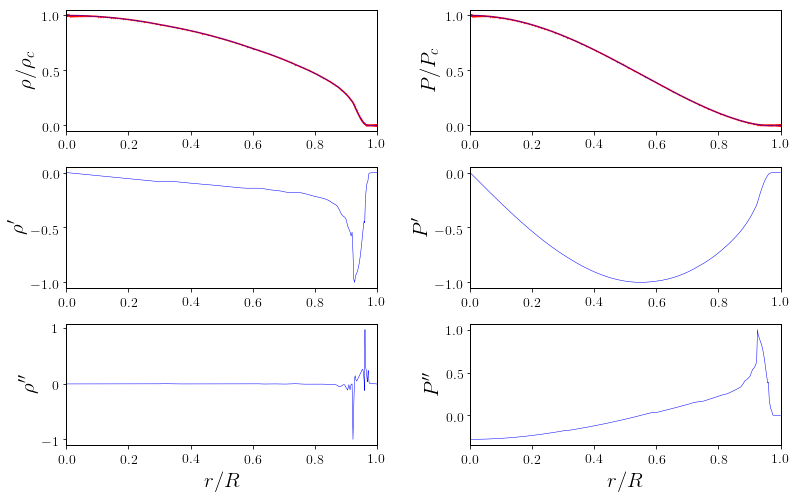

In [12]:
fig=plt.figure(figsize=[12.8,8])

plt.subplot(321)
plt.plot(eng_150[-1]/eng_150[-1][-1],eng_150[2]/eng_150[2][0],color='red',marker='o',markersize='0.4') 
plt.plot(eng_150[-1]/eng_150[-1][-1],eng_150rho(eng_150[-1])/eng_150[2][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1) # leaving the crust out

plt.subplot(322)
plt.plot(eng_150[-1]/eng_150[-1][-1],eng_150[1]/eng_150[1][0],color='red',marker='o',markersize='0.4') 
plt.plot(eng_150[-1]/eng_150[-1][-1],eng_150p(eng_150[-1])/eng_150[1][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$P/P_c$')
plt.xlim(0,1)

plt.subplot(323)
plt.plot(eng_150[-1]/eng_150[-1][-1],eng_150drho(eng_150[-1])/max(abs(eng_150drho(eng_150[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime}$')
plt.xlim(0,1)
#plt.ylim(-500,0)

plt.subplot(324)
plt.plot(eng_150[-1]/eng_150[-1][-1],eng_150dp(eng_150[-1])/max(abs(eng_150dp(eng_150[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime} $')
plt.xlim(0,1)

plt.subplot(325)
plt.plot(eng_150[-1]/eng_150[-1][-1],eng_150ddrho(eng_150[-1])/max(abs(eng_150ddrho(eng_150[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}$')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-0.01,0.01)

plt.subplot(326)
plt.plot(eng_150[-1]/eng_150[-1][-1],eng_150ddp(eng_150[-1])/max(abs(eng_150ddp(eng_150[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime\prime}$ ')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-1,1)

fig.subplots_adjust(hspace=0.3,wspace=0.3)

#plt.savefig('figures/ddseng_150.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

### 15.41

In [13]:
eng_1541=np.loadtxt('results/eng/15.41.dat',unpack=True)
eng_1541[3] = eng_1541[3]-eng_1541[3][-1] + 0.5*np.log(1-2*eng_1541[0][-1]/eng_1541[-1][-1])

In [14]:
s1=5e-7
s2=1e-15
eng_1541rho=interpolate.UnivariateSpline(eng_1541[-1], eng_1541[2], k=5, s=s1)
eng_1541drho=interpolate.UnivariateSpline(eng_1541[-1], eng_1541[2], k=5, s=s1).derivative(n=1)
eng_1541ddrho=interpolate.UnivariateSpline(eng_1541[-1], eng_1541[2], k=5, s=s1).derivative(n=2)

eng_1541p=interpolate.UnivariateSpline(eng_1541[-1], eng_1541[1], k=5, s=s2)
eng_1541dp=interpolate.UnivariateSpline(eng_1541[-1], eng_1541[1], k=5, s=s2).derivative(n=1)
eng_1541ddp=interpolate.UnivariateSpline(eng_1541[-1], eng_1541[1], k=5, s=s2).derivative(n=2)

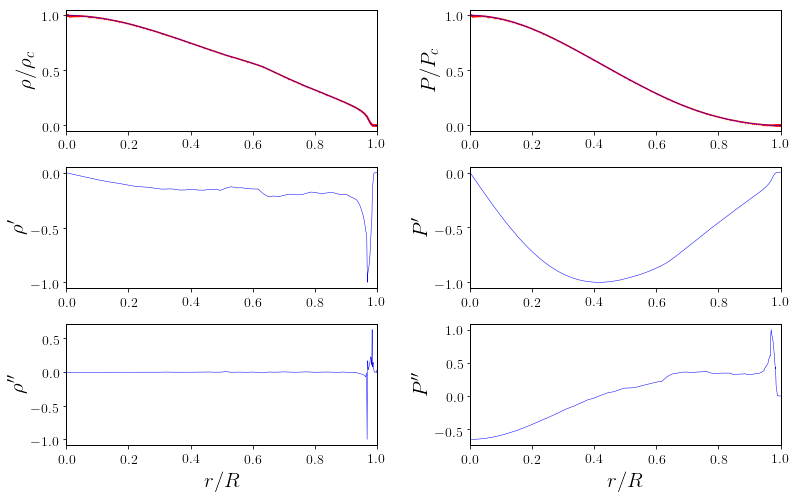

In [15]:
fig=plt.figure(figsize=[12.8,8])

plt.subplot(321)
plt.plot(eng_1541[-1]/eng_1541[-1][-1],eng_1541[2]/eng_1541[2][0],color='red',marker='o',markersize='0.4') 
plt.plot(eng_1541[-1]/eng_1541[-1][-1],eng_1541rho(eng_1541[-1])/eng_1541[2][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1) # leaving the crust out

plt.subplot(322)
plt.plot(eng_1541[-1]/eng_1541[-1][-1],eng_1541[1]/eng_1541[1][0],color='red',marker='o',markersize='0.4') 
plt.plot(eng_1541[-1]/eng_1541[-1][-1],eng_1541p(eng_1541[-1])/eng_1541[1][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$P/P_c$')
plt.xlim(0,1)

plt.subplot(323)
plt.plot(eng_1541[-1]/eng_1541[-1][-1],eng_1541drho(eng_1541[-1])/max(abs(eng_1541drho(eng_1541[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime}$')
plt.xlim(0,1)
#plt.ylim(-500,0)

plt.subplot(324)
plt.plot(eng_1541[-1]/eng_1541[-1][-1],eng_1541dp(eng_1541[-1])/max(abs(eng_1541dp(eng_1541[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime} $')
plt.xlim(0,1)

plt.subplot(325)
plt.plot(eng_1541[-1]/eng_1541[-1][-1],eng_1541ddrho(eng_1541[-1])/max(abs(eng_1541ddrho(eng_1541[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}$')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-0.01,0.01)

plt.subplot(326)
plt.plot(eng_1541[-1]/eng_1541[-1][-1],eng_1541ddp(eng_1541[-1])/max(abs(eng_1541ddp(eng_1541[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime\prime}$ ')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-1,1)

fig.subplots_adjust(hspace=0.3,wspace=0.3)

#plt.savefig('figures/ddseng_1541.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()


## Comparison

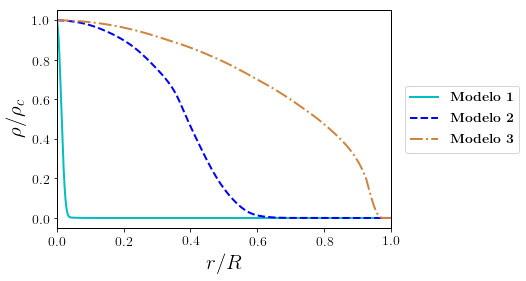

In [17]:
fig, ax = plt.subplots()

plt.plot(eng_140[-1]/eng_140[-1][-1],eng_140rho(eng_140[-1])/eng_140[2][0],color='c',linewidth='2.0',label=r'\textbf{Modelo 1}') 

plt.plot(eng_145[-1]/eng_145[-1][-1],eng_145rho(eng_145[-1])/eng_145[2][0],color='blue',linewidth='2.0',linestyle='--',label=r'\textbf{Modelo 2}') 

plt.plot(eng_150[-1]/eng_150[-1][-1],eng_150rho(eng_150[-1])/eng_150[2][0],color='peru',linewidth='2.0',linestyle='-.',label=r'\textbf{Modelo 3}')

#plt.plot(eng_155[-1]/eng_155[-1][-1],eng_155rho(eng_155[-1])/eng_155[2][0],color='yellow',linewidth='2.0',linestyle='-.',label=r'$\rho_c=10^{15.5}$ g cm$ ^{-3}$')

legend_properties = {'weight':'bold'}
l3 = plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0,prop=legend_properties)

plt.xlabel(r'$r/R$')
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1.0)

plt.savefig('figures/rhoprofilesENG.eps', format='eps', dpi=1000,bbox_inches="tight")

## Redshift

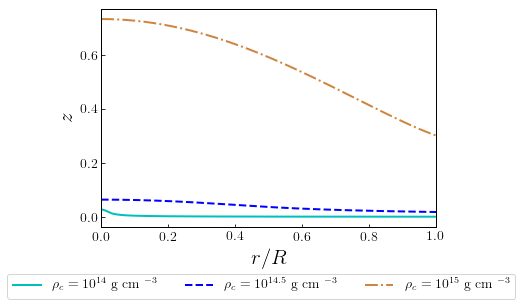

In [140]:
fig, ax = plt.subplots()

plt.plot(eng_140[-1]/eng_140[-1][-1],np.exp(-eng_140[3])-1.0,color='c',linewidth='2.0',label=r'$\rho_c=10^{14}$ g cm $^{-3}$')
plt.plot(eng_145[-1]/eng_145[-1][-1],np.exp(-eng_145[3])-1.0,color='blue',linewidth='2.0',linestyle='--',label=r'$\rho_c=10^{14.5}$ g cm $^{-3}$')
plt.plot(eng_150[-1]/eng_150[-1][-1],np.exp(-eng_150[3])-1.0,color='peru',linewidth='2.0',linestyle='-.',label=r'$\rho_c=10^{15}$ g cm $^{-3}$')
#plt.plot(eng_1541[-1]/eng_1541[-1][-1],np.exp(-eng_1541[3])-1.0,color='black',linewidth='2.0',linestyle='-.',label=r'$\rho_c=10^{15}$ g cm $^{-3}$')

l = plt.legend(bbox_to_anchor=(1.1,-0.15), loc="lower right", 
                bbox_transform=fig.transFigure, ncol=3)
ax.tick_params(axis="x", direction="in")
ax.tick_params(axis="y", direction="in")

plt.xlabel(r'$r/R$')
plt.ylabel(r'$z$')
plt.xlim(0,1.0)

plt.savefig('figures/Redshifteng.pdf', format='pdf', dpi=1000,bbox_inches="tight")

##  Cracking

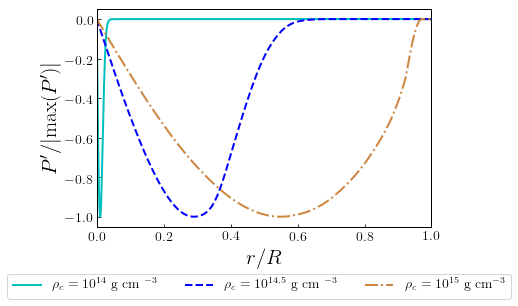

In [141]:
fig, ax = plt.subplots()

plt.plot(eng_140[-1]/eng_140[-1][-1],eng_140dp(eng_140[-1])/max(abs(eng_140dp(eng_140[-1]))),color='c',linewidth='2.0',label=r'$\rho_c=10^{14}$ g cm $^{-3}$') 
plt.plot(eng_145[-1]/eng_145[-1][-1],eng_145dp(eng_145[-1])/max(abs(eng_145dp(eng_145[-1]))),color='blue',linewidth='2.0',linestyle='--',label=r'$\rho_c=10^{14.5}$ g cm $^{-3}$') 
plt.plot(eng_150[-1]/eng_150[-1][-1],eng_150dp(eng_150[-1])/max(abs(eng_150dp(eng_150[-1]))),color='peru',linewidth='2.0',linestyle='-.',label=r'$\rho_c=10^{15}$ g cm$ ^{-3}$')

#plt.plot(eng_155[-1]/eng_155[-1][-1],eng_155drho(eng_155[-1])/max(abs(eng_155drho(eng_140[-1]))),color='yellow',linewidth='2.0',linestyle='-.',label=r'$\rho_c=10^{15.5}$ g cm$ ^{-3}$')

l = plt.legend(bbox_to_anchor=(1.1,-0.15), loc="lower right", 
                bbox_transform=fig.transFigure, ncol=3)
ax.tick_params(axis="x", direction="in")
ax.tick_params(axis="y", direction="in")

plt.xlabel(r'$r/R$')
plt.ylabel(r'$P^{\prime}/|$max$(P^{\prime})|$')
plt.xlim(0,1.0)

plt.savefig('figures/CrackStabilityeng.pdf', format='pdf', dpi=1000,bbox_inches="tight")


## Adiabatic convection

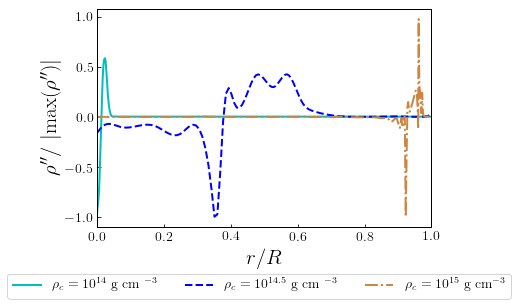

In [17]:
fig, ax = plt.subplots()

plt.plot(eng_140[-1]/eng_140[-1][-1],eng_140ddrho(eng_140[-1])/max(abs(eng_140ddrho(eng_140[-1]))),color='c',linewidth='2.0',label=r'$\rho_c=10^{14}$ g cm $^{-3}$') 
plt.plot(eng_145[-1]/eng_145[-1][-1],eng_145ddrho(eng_145[-1])/max(abs(eng_145ddrho(eng_145[-1]))),color='blue',linewidth='2.0',linestyle='--',label=r'$\rho_c=10^{14.5}$ g cm $^{-3}$') 
plt.plot(eng_150[-1]/eng_150[-1][-1],eng_150ddrho(eng_150[-1])/max(abs(eng_150ddrho(eng_150[-1]))),color='peru',linewidth='2.0',linestyle='-.',label=r'$\rho_c=10^{15}$ g cm$ ^{-3}$')

#plt.plot(eng_155[-1]/eng_155[-1][-1],eng_155drho(eng_155[-1])/max(abs(eng_155drho(eng_140[-1]))),color='yellow',linewidth='2.0',linestyle='-.',label=r'$\rho_c=10^{15.5}$ g cm$ ^{-3}$')

l = plt.legend(bbox_to_anchor=(1.1,-0.15), loc="lower right", 
                bbox_transform=fig.transFigure, ncol=3)

ax.tick_params(axis="x", direction="in")
ax.tick_params(axis="y", direction="in")

plt.xlabel(r'$r/R$')
plt.ylabel(r'$\rho^{\prime \prime}/$ $|$max$(\rho^{\prime \prime})|$')
plt.xlim(0,1.0)

plt.savefig('figures/ConvecStabilityeng.pdf', format='pdf', dpi=1000,bbox_inches="tight")


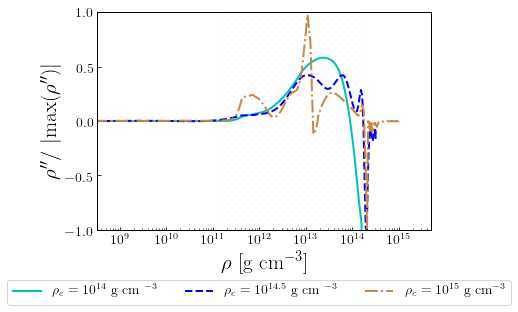

In [16]:
fig, ax = plt.subplots()

ax.set_xscale("log")

plt.plot(eng_140[2]*rhodim,eng_140ddrho(eng_140[-1])/max(abs(eng_140ddrho(eng_140[-1]))),color='c',linewidth='2.0',label=r'$\rho_c=10^{14}$ g cm $^{-3}$') 
plt.plot(eng_145[2]*rhodim,eng_145ddrho(eng_145[-1])/max(abs(eng_145ddrho(eng_145[-1]))),color='blue',linewidth='2.0',linestyle='--',label=r'$\rho_c=10^{14.5}$ g cm $^{-3}$') 
plt.plot(eng_150[2]*rhodim,eng_150ddrho(eng_150[-1])/max(abs(eng_150ddrho(eng_150[-1]))),color='peru',linewidth='2.0',linestyle='-.',label=r'$\rho_c=10^{15}$ g cm$ ^{-3}$')
plt.xlim(left=10**(8.5))
#plt.plot(eng_155[-1]/eng_155[-1][-1],eng_155drho(eng_155[-1])/max(abs(eng_155drho(eng_140[-1]))),color='yellow',linewidth='2.0',linestyle='-.',label=r'$\rho_c=10^{15.5}$ g cm$ ^{-3}$')

x = (10**(11.2),10**(14.2))
y1 = (1,1)
y2 = (-1,-1)

#plt.plot(x1,y,color='black')
#plt.plot(x2,y,color='black')
mpl.rcParams['hatch.linewidth'] = 0.05
plt.fill_between(x, y1,y2,facecolor='none', hatch="xxx", edgecolor="lightgray", linewidth=0.0)

l = plt.legend(bbox_to_anchor=(1.1,-0.16), loc="lower right", 
                bbox_transform=fig.transFigure, ncol=3)
ax.tick_params(axis="x", direction="in",which='both')
ax.tick_params(axis="y", direction="in")

plt.xlabel(r'$\rho$ [g cm$^{-3}$]')
plt.ylabel(r'$\rho^{\prime \prime}/$ $|$max$(\rho^{\prime \prime})|$')
plt.ylim(-1,1.0)

plt.savefig('figures/ConvecStabilityengCorrel.pdf', format='pdf', dpi=1000,bbox_inches="tight")

### Versión póster

In [17]:
plt.rc('axes', labelsize=25)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('legend',fontsize= 17,markerscale=1.8)
plt.rc('font', weight='bold')
plt.rcParams['axes.spines.right'] = True
plt.rcParams['axes.spines.top'] = True
mpl.rcParams['axes.linewidth'] = 1.4
matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath} \usepackage{sfmath} \boldmath"]
#plt.rcParams['text.latex.preamble'] = [r' \\']

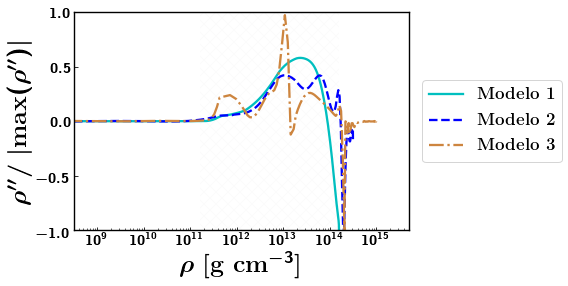

In [23]:
fig, ax = plt.subplots()

ax.set_xscale("log")

plt.plot(eng_140[2]*rhodim,eng_140ddrho(eng_140[-1])/max(abs(eng_140ddrho(eng_140[-1]))),color='c',linewidth='2.3',label=r'\textbf{Modelo 1}') 
plt.plot(eng_145[2]*rhodim,eng_145ddrho(eng_145[-1])/max(abs(eng_145ddrho(eng_145[-1]))),color='blue',linewidth='2.3',linestyle='--',label=r'\textbf{Modelo 2}') 
plt.plot(eng_150[2]*rhodim,eng_150ddrho(eng_150[-1])/max(abs(eng_150ddrho(eng_150[-1]))),color='peru',linewidth='2.3',linestyle='-.',label=r'\textbf{Modelo 3}')
plt.xlim(left=10**(8.5))
#plt.plot(eng_155[-1]/eng_155[-1][-1],eng_155drho(eng_155[-1])/max(abs(eng_155drho(eng_140[-1]))),color='yellow',linewidth='2.0',linestyle='-.',label=r'$\rho_c=10^{15.5}$ g cm$ ^{-3}$')

x = (10**(11.2),10**(14.2))
y1 = (1,1)
y2 = (-1,-1)

#plt.plot(x1,y,color='black')
#plt.plot(x2,y,color='black')
mpl.rcParams['hatch.linewidth'] = 0.02
plt.fill_between(x, y1,y2,facecolor='none', hatch="xx", edgecolor="gray", linewidth=0.0)

#l = plt.legend(bbox_to_anchor=(1.1,-0.16), loc="lower right", 
              #  bbox_transform=fig.transFigure, ncol=3)
legend_properties = {'weight':'bold'}
l3 = plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0,prop=legend_properties)
ax.tick_params(axis="x", direction="in",which='both')
ax.tick_params(axis="y", direction="in")

plt.xlabel(r'$\boldsymbol{\rho}$ \textbf{[g cm}$^{-\boldsymbol{3}}$\textbf{]}')
plt.ylabel(r'$\boldsymbol{\rho}^{\boldsymbol{\prime} \boldsymbol{\prime}}/$ $|$\textbf{max}$(\boldsymbol{\rho}^{\boldsymbol{\prime} \boldsymbol{\prime}})|$')
plt.ylim(-1,1.0)

plt.savefig('figures/ConvecStabilityengCorrelposter.pdf', format='pdf', dpi=1000,bbox_inches="tight")

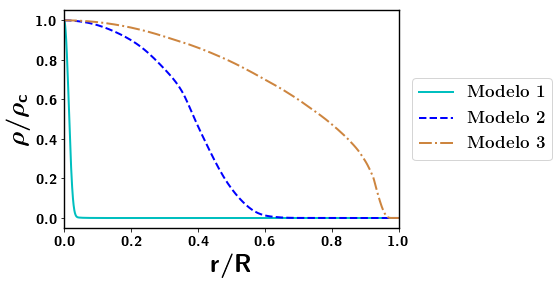

In [24]:
fig, ax = plt.subplots()

plt.plot(eng_140[-1]/eng_140[-1][-1],eng_140rho(eng_140[-1])/eng_140[2][0],color='c',linewidth='2.0',label=r'\textbf{Modelo 1}') 

plt.plot(eng_145[-1]/eng_145[-1][-1],eng_145rho(eng_145[-1])/eng_145[2][0],color='blue',linewidth='2.0',linestyle='--',label=r'\textbf{Modelo 2}') 

plt.plot(eng_150[-1]/eng_150[-1][-1],eng_150rho(eng_150[-1])/eng_150[2][0],color='peru',linewidth='2.0',linestyle='-.',label=r'\textbf{Modelo 3}')

#plt.plot(eng_155[-1]/eng_155[-1][-1],eng_155rho(eng_155[-1])/eng_155[2][0],color='yellow',linewidth='2.0',linestyle='-.',label=r'$\rho_c=10^{15.5}$ g cm$ ^{-3}$')

legend_properties = {'weight':'bold'}
l3 = plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0,prop=legend_properties)

plt.xlabel(r'$\boldsymbol{r/R}$')
plt.ylabel(r'$\boldsymbol{\rho/\rho_c}$')
plt.xlim(0,1.0)

plt.savefig('figures/rhoprofilesENG.pdf', format='pdf', dpi=1000,bbox_inches="tight")

# FPS ---------------------------------------------------------------------------------------------

In [234]:
rhofps,Pfps,nfps=np.loadtxt('EOS/fps.dat',usecols=(2,1,0),unpack=True)

## Dominant energy condition

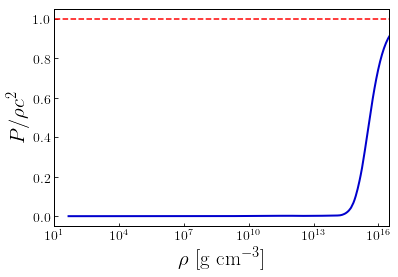

<Figure size 432x288 with 0 Axes>

In [235]:
fig, ax = plt.subplots()
plt.plot(rhofps,np.divide(Pfps,rhofps),lw='2',color='mediumblue')
plt.plot([0,10**(17)],[1.0,1.0],'r--',lw='1.5')

ax.set_xscale("log")
#locmaj = matplotlib.ticker.LogLocator(base=10.0,numticks=16) 
#ax.xaxis.set_major_locator(locmaj)


plt.xlabel(r'$\rho$ [g\,\,cm$^{-3}$]')
plt.ylabel(r'$ P / \rho c^2 $')
#locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks=16)
#ax.xaxis.set_minor_locator(locmin)
#ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.tick_params(axis="x", direction="in")
ax.tick_params(axis="y", direction="in")
plt.xlim(10,10**(16.5))
#ax.set_facecolor('floralwhite')
#plt.gca().set_aspect('equal', adjustable='box')
#plt.draw()
#plt.ylim(0,1)
plt.savefig('figures/ECfps.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()
plt.clf()

## Speed of sound

In [236]:
vsquared=interpolate.UnivariateSpline(rhofps, Pfps, k=1, s=0).derivative(n=1)

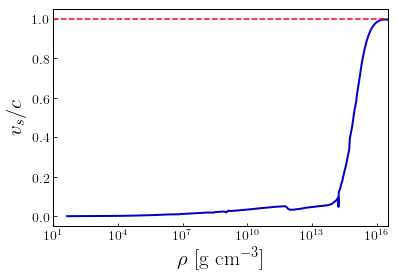

In [237]:
fig, ax = plt.subplots()
plt.plot(rhofps,np.sqrt(vsquared(rhofps)),lw='2.0',color='mediumblue')
plt.plot([1e+1,10**(16.5)],[1.0,1.0],'r--',lw='1.5')
plt.xlabel(r'$\rho$ [g\,\,cm$^{-3}$]')
plt.ylabel(r'$ v_s / c $')
plt.xscale('log')
ax.tick_params(axis="x", direction="in")
ax.tick_params(axis="y", direction="in")
plt.xlim(10,10**(16.5))
#ax.set_facecolor('floralwhite')
#mpl.rcParams['axes.linewidth'] = 1.4
#plt.gca().set_aspect('equal', adjustable='box')
#plt.draw()
plt.savefig('figures/SSfps.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

## M - $\rho_c$

In [244]:
Rfps,Mfps,rhocfps=np.loadtxt('results/fps/MRrhoc.dat',usecols=(0,1,2),unpack=True)

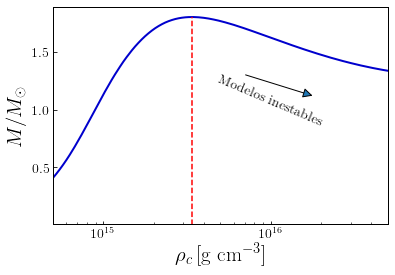

In [248]:
fig, ax = plt.subplots()

plt.plot(rhocfps,Mfps,color='mediumblue',lw='2.0')
plt.plot([10**(np.log10(rhocfps[np.argmax(Mfps)])),10**(np.log10(rhocfps[np.argmax(Mfps)]))],[0.0,np.amax(Mfps)],'r--',lw='1.5')

prop = dict(arrowstyle="-|>,head_width=0.4,head_length=0.8",
            shrinkA=0,shrinkB=0)
plt.annotate("", xy=(10**(16.25),1.12), xytext=(10**(15.85),1.3), arrowprops=prop)
#plt.arrow(10**(15.6), 1.38,10**(15.7) ,-0.1 , head_width=0.05, head_lfpsth=10**(15))
plt.text(10**(15.67), 1.23, 'Modelos inestables' , fontsize=14,rotation=-23)

plt.xscale('log')
plt.xlabel(r'$\rho_c\,[$g cm$^{-3}]$')
plt.ylabel(r'$M/M_{\odot}$')
plt.xlim(left=10**(14.7),right=10**(16.7))
plt.ylim(bottom=0.01)
ax.tick_params(axis="x", direction="in",which='both')
ax.tick_params(axis="y", direction="in",which='both')

plt.savefig('figures/Mrhorel_fps.pdf', format='pdf', dpi=1000,bbox_inches="tight")

## Effective and critical adiabatic index

In [38]:
rhoscfps,betasfps,gamma_efsfps,gamma_crsfps = aindex_stab('fps')

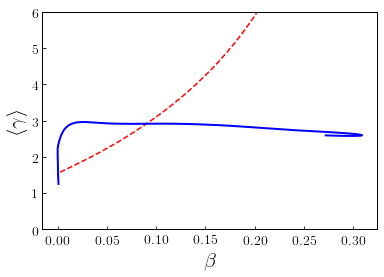

In [39]:
fig, ax = plt.subplots()
plt.plot(betasfps,gamma_crsfps,lw='1.5',color='r',linestyle='--',label=r'$\gamma_{cr}$')
#plt.plot([betacrit,betacrit],[0,5])
plt.plot(betasfps,gamma_efsfps,lw='2.0',color='blue',label=r'$\langle \gamma \rangle$')

plt.xlabel(r'$\beta$')
plt.ylabel(r'$\langle \gamma \rangle$')

#plt.xscale('log')
#plt.xlim(left=10**(14.7),right=10**(16.7))
plt.ylim(0,6)
ax.tick_params(axis="x", direction="in",which='both')
ax.tick_params(axis="y", direction="in",which='both')
#l = plt.legend(bbox_to_anchor=(0.85,-0.15), loc="lower right", 
                #bbox_transform=fig.transFigure, ncol=2)



plt.savefig('figures/AIndexStabfps.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

## Tunning the interpolation of the solution

### 14.0

In [40]:
fps_140=np.loadtxt('results/fps/14.0.dat',unpack=True)
fps_140[3] = fps_140[3]-fps_140[3][-1] + 0.5*np.log(1-2*fps_140[0][-1]/fps_140[-1][-1])

In [41]:
s1=5e-7
s2=1e-15
fps_140rho=interpolate.UnivariateSpline(fps_140[-1], fps_140[2], k=5, s=s1)
fps_140drho=interpolate.UnivariateSpline(fps_140[-1], fps_140[2], k=5, s=s1).derivative(n=1)
fps_140ddrho=interpolate.UnivariateSpline(fps_140[-1], fps_140[2], k=5, s=s1).derivative(n=2)

fps_140p=interpolate.UnivariateSpline(fps_140[-1], fps_140[1], k=5, s=s2)
fps_140dp=interpolate.UnivariateSpline(fps_140[-1], fps_140[1], k=5, s=s2).derivative(n=1)
fps_140ddp=interpolate.UnivariateSpline(fps_140[-1], fps_140[1], k=5, s=s2).derivative(n=2)

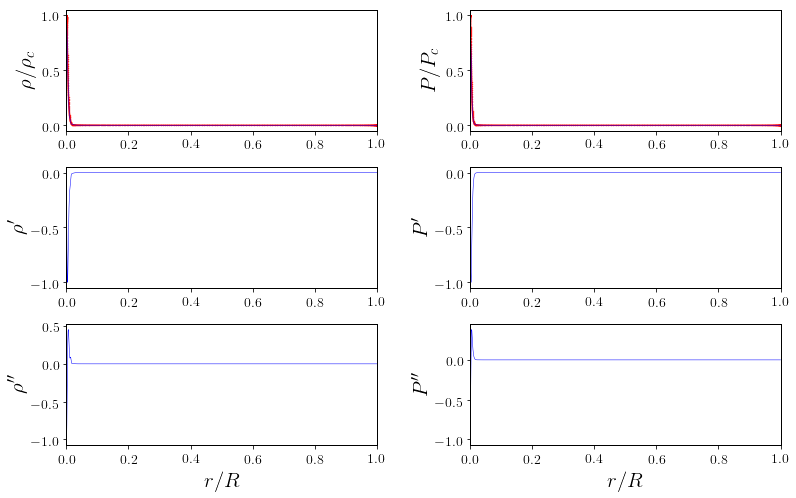

In [251]:
fig=plt.figure(figsize=[12.8,8])

plt.subplot(321)
plt.plot(fps_140[-1]/fps_140[-1][-1],fps_140[2]/fps_140[2][0],color='red',marker='o',markersize='0.4') 
plt.plot(fps_140[-1]/fps_140[-1][-1],fps_140rho(fps_140[-1])/fps_140[2][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1) # leaving the crust out

plt.subplot(322)
plt.plot(fps_140[-1]/fps_140[-1][-1],fps_140[1]/fps_140[1][0],color='red',marker='o',markersize='0.4') 
plt.plot(fps_140[-1]/fps_140[-1][-1],fps_140p(fps_140[-1])/fps_140[1][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$P/P_c$')
plt.xlim(0,1)

plt.subplot(323)
plt.plot(fps_140[-1]/fps_140[-1][-1],fps_140drho(fps_140[-1])/max(abs(fps_140drho(fps_140[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime}$')
plt.xlim(0,1)
#plt.ylim(-500,0)

plt.subplot(324)
plt.plot(fps_140[-1]/fps_140[-1][-1],fps_140dp(fps_140[-1])/max(abs(fps_140dp(fps_140[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime} $')
plt.xlim(0,1)

plt.subplot(325)
plt.plot(fps_140[-1]/fps_140[-1][-1],fps_140ddrho(fps_140[-1])/max(abs(fps_140ddrho(fps_140[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}$')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-0.01,0.01)

plt.subplot(326)
plt.plot(fps_140[-1]/fps_140[-1][-1],fps_140ddp(fps_140[-1])/max(abs(fps_140ddp(fps_140[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime\prime}$ ')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-1,1)

fig.subplots_adjust(hspace=0.3,wspace=0.3)

#plt.savefig('figures/ddsfps_140.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

### 14.5

In [42]:
fps_145=np.loadtxt('results/fps/14.5.dat',unpack=True)
fps_145[3] = fps_145[3]-fps_145[3][-1] + 0.5*np.log(1-2*fps_145[0][-1]/fps_145[-1][-1])

In [43]:
s1=1e-7
s2=1e-12
fps_145rho=interpolate.UnivariateSpline(fps_145[-1], fps_145[2], k=5, s=s1)
fps_145drho=interpolate.UnivariateSpline(fps_145[-1], fps_145[2], k=5, s=s1).derivative(n=1)
fps_145ddrho=interpolate.UnivariateSpline(fps_145[-1], fps_145[2], k=5, s=s1).derivative(n=2)

fps_145p=interpolate.UnivariateSpline(fps_145[-1], fps_145[1], k=5, s=s2)
fps_145dp=interpolate.UnivariateSpline(fps_145[-1], fps_145[1], k=5, s=s2).derivative(n=1)
fps_145ddp=interpolate.UnivariateSpline(fps_145[-1], fps_145[1], k=5, s=s2).derivative(n=2)

In [254]:
fps_145rho(0.4*fps_145[-1][-1])*rhodim

114907693276737.52

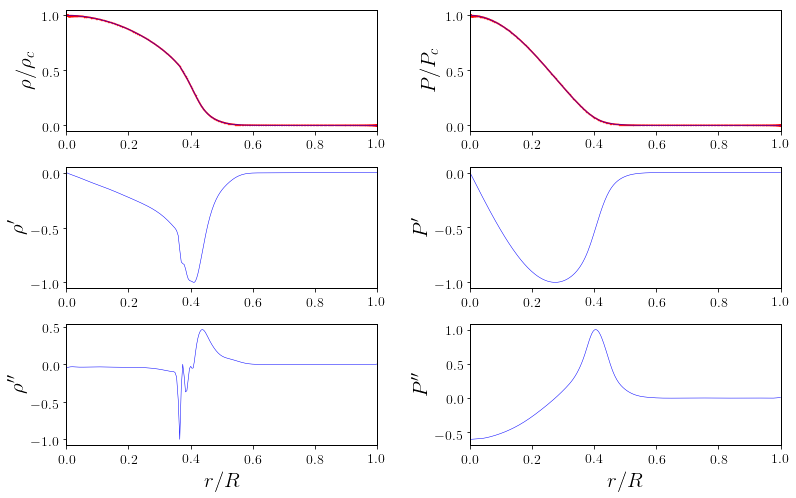

In [255]:
fig=plt.figure(figsize=[12.8,8])

plt.subplot(321)
plt.plot(fps_145[-1]/fps_145[-1][-1],fps_145[2]/fps_145[2][0],color='red',marker='o',markersize='0.4') 
plt.plot(fps_145[-1]/fps_145[-1][-1],fps_145rho(fps_145[-1])/fps_145[2][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1) # leaving the crust out

plt.subplot(322)
plt.plot(fps_145[-1]/fps_145[-1][-1],fps_145[1]/fps_145[1][0],color='red',marker='o',markersize='0.4') 
plt.plot(fps_145[-1]/fps_145[-1][-1],fps_145p(fps_145[-1])/fps_145[1][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$P/P_c$')
plt.xlim(0,1)

plt.subplot(323)
plt.plot(fps_145[-1]/fps_145[-1][-1],fps_145drho(fps_145[-1])/max(abs(fps_145drho(fps_145[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime}$')
plt.xlim(0,1)
#plt.ylim(-500,0)

plt.subplot(324)
plt.plot(fps_145[-1]/fps_145[-1][-1],fps_145dp(fps_145[-1])/max(abs(fps_145dp(fps_145[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime} $')
plt.xlim(0,1)

plt.subplot(325)
plt.plot(fps_145[-1]/fps_145[-1][-1],fps_145ddrho(fps_145[-1])/max(abs(fps_145ddrho(fps_145[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}$')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-0.01,0.01)

plt.subplot(326)
plt.plot(fps_145[-1]/fps_145[-1][-1],fps_145ddp(fps_145[-1])/max(abs(fps_145ddp(fps_145[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime\prime}$ ')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-1,1)

fig.subplots_adjust(hspace=0.3,wspace=0.3)

#plt.savefig('figures/ddsfps_145.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

### 15.0

In [44]:
fps_150=np.loadtxt('results/fps/15.0.dat',unpack=True)
fps_150[3] = fps_150[3]-fps_150[3][-1] + 0.5*np.log(1-2*fps_150[0][-1]/fps_150[-1][-1])

In [45]:
s1=8e-6
s2=1e-15
fps_150rho=interpolate.UnivariateSpline(fps_150[-1], fps_150[2], k=5, s=s1)
fps_150drho=interpolate.UnivariateSpline(fps_150[-1], fps_150[2], k=5, s=s1).derivative(n=1)
fps_150ddrho=interpolate.UnivariateSpline(fps_150[-1], fps_150[2], k=5, s=s1).derivative(n=2)

fps_150p=interpolate.UnivariateSpline(fps_150[-1], fps_150[1], k=5, s=s2)
fps_150dp=interpolate.UnivariateSpline(fps_150[-1], fps_150[1], k=5, s=s2).derivative(n=1)
fps_150ddp=interpolate.UnivariateSpline(fps_150[-1], fps_150[1], k=5, s=s2).derivative(n=2)

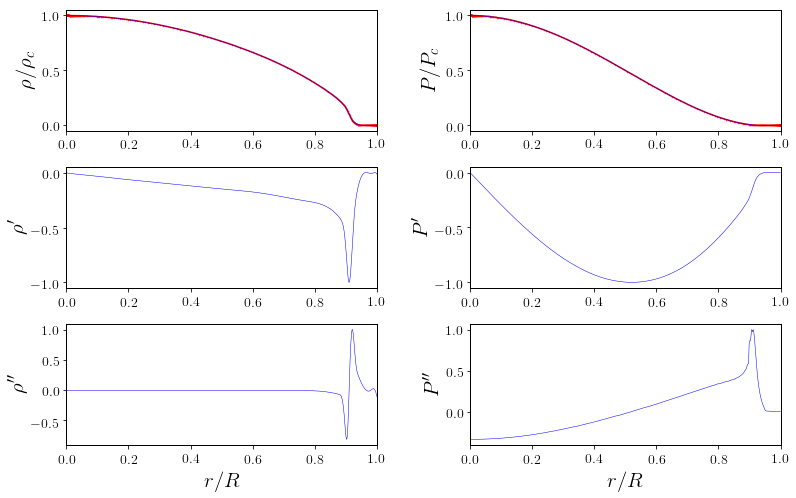

In [258]:
fig=plt.figure(figsize=[12.8,8])

plt.subplot(321)
plt.plot(fps_150[-1]/fps_150[-1][-1],fps_150[2]/fps_150[2][0],color='red',marker='o',markersize='0.4') 
plt.plot(fps_150[-1]/fps_150[-1][-1],fps_150rho(fps_150[-1])/fps_150[2][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1) # leaving the crust out

plt.subplot(322)
plt.plot(fps_150[-1]/fps_150[-1][-1],fps_150[1]/fps_150[1][0],color='red',marker='o',markersize='0.4') 
plt.plot(fps_150[-1]/fps_150[-1][-1],fps_150p(fps_150[-1])/fps_150[1][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$P/P_c$')
plt.xlim(0,1)

plt.subplot(323)
plt.plot(fps_150[-1]/fps_150[-1][-1],fps_150drho(fps_150[-1])/max(abs(fps_150drho(fps_150[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime}$')
plt.xlim(0,1)
#plt.ylim(-500,0)

plt.subplot(324)
plt.plot(fps_150[-1]/fps_150[-1][-1],fps_150dp(fps_150[-1])/max(abs(fps_150dp(fps_150[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime} $')
plt.xlim(0,1)

plt.subplot(325)
plt.plot(fps_150[-1]/fps_150[-1][-1],fps_150ddrho(fps_150[-1])/max(abs(fps_150ddrho(fps_150[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}$')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-0.01,0.01)

plt.subplot(326)
plt.plot(fps_150[-1]/fps_150[-1][-1],fps_150ddp(fps_150[-1])/max(abs(fps_150ddp(fps_150[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime\prime}$ ')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-1,1)

fig.subplots_adjust(hspace=0.3,wspace=0.3)

#plt.savefig('figures/ddsfps_150.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

## Adiabatic convection

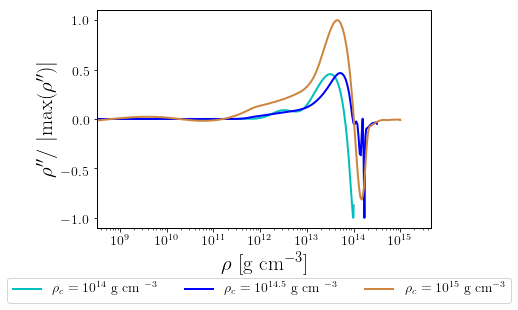

In [46]:
fig, ax = plt.subplots()

ax.set_xscale("log")

plt.plot(fps_140[2]*rhodim,fps_140ddrho(fps_140[-1])/max(abs(fps_140ddrho(fps_140[-1]))),color='c',linewidth='2.0',label=r'$\rho_c=10^{14}$ g cm $^{-3}$') 
plt.plot(fps_145[2]*rhodim,fps_145ddrho(fps_145[-1])/max(abs(fps_145ddrho(fps_145[-1]))),color='blue',linewidth='2.0',linestyle='-',label=r'$\rho_c=10^{14.5}$ g cm $^{-3}$') 
plt.plot(fps_150[2]*rhodim,fps_150ddrho(fps_150[-1])/max(abs(fps_150ddrho(fps_150[-1]))),color='peru',linewidth='2.0',linestyle='-',label=r'$\rho_c=10^{15}$ g cm$ ^{-3}$')
plt.xlim(left=10**(8.5))
#plt.plot(fps_155[-1]/fps_155[-1][-1],fps_155drho(fps_155[-1])/max(abs(fps_155drho(fps_140[-1]))),color='yellow',linewidth='2.0',linestyle='-.',label=r'$\rho_c=10^{15.5}$ g cm$ ^{-3}$')

l = plt.legend(bbox_to_anchor=(1.1,-0.16), loc="lower right", 
                bbox_transform=fig.transFigure, ncol=3)

plt.xlabel(r'$\rho$ [g cm$^{-3}$]')
plt.ylabel(r'$\rho^{\prime \prime}/$ $|$max$(\rho^{\prime \prime})|$')
#plt.xlim(0,1.0)

plt.savefig('figures/ConvecStabilityfpsCorrel.pdf', format='pdf', dpi=1000,bbox_inches="tight")

## Redshift

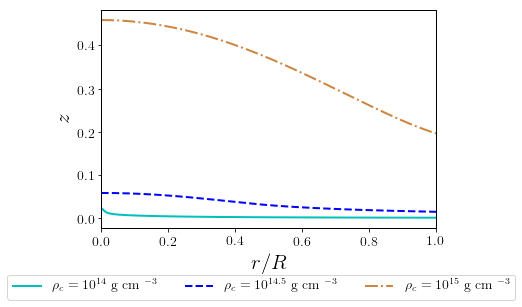

In [259]:
fig = plt.figure()

plt.plot(fps_140[-1]/fps_140[-1][-1],np.exp(-fps_140[3])-1.0,color='c',linewidth='2.0',label=r'$\rho_c=10^{14}$ g cm $^{-3}$')
plt.plot(fps_145[-1]/fps_145[-1][-1],np.exp(-fps_145[3])-1.0,color='blue',linewidth='2.0',linestyle='--',label=r'$\rho_c=10^{14.5}$ g cm $^{-3}$')
plt.plot(fps_150[-1]/fps_150[-1][-1],np.exp(-fps_150[3])-1.0,color='peru',linewidth='2.0',linestyle='-.',label=r'$\rho_c=10^{15}$ g cm $^{-3}$')

l = plt.legend(bbox_to_anchor=(1.1,-0.15), loc="lower right", 
                bbox_transform=fig.transFigure, ncol=3)

plt.xlabel(r'$r/R$')
plt.ylabel(r'$z$')
plt.xlim(0,1.0)

plt.savefig('figures/Redshiftfps.pdf', format='pdf', dpi=1000,bbox_inches="tight")

# GNH3 -------------------------------------------------------------------------------------------

In [611]:
rhognh3,Pgnh3,ngnh3=np.loadtxt('EOS/gnh3.dat',usecols=(2,1,0),unpack=True)

## Dominant energy condition

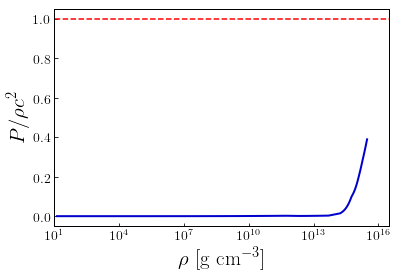

<Figure size 432x288 with 0 Axes>

In [612]:
fig, ax = plt.subplots()
plt.plot(rhognh3,np.divide(Pgnh3,rhognh3),lw='2',color='mediumblue')
plt.plot([0,10**(17)],[1.0,1.0],'r--',lw='1.5')

ax.set_xscale("log")
#locmaj = matplotlib.ticker.LogLocator(base=10.0,numticks=16) 
#ax.xaxis.set_major_locator(locmaj)


plt.xlabel(r'$\rho$ [g\,\,cm$^{-3}$]')
plt.ylabel(r'$ P / \rho c^2 $')
#locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks=16)
#ax.xaxis.set_minor_locator(locmin)
#ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.tick_params(axis="x", direction="in")
ax.tick_params(axis="y", direction="in")
plt.xlim(10,10**(16.5))
#ax.set_facecolor('floralwhite')
#plt.gca().set_aspect('equal', adjustable='box')
#plt.draw()
#plt.ylim(0,1)
plt.savefig('figures/ECgnh3.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()
plt.clf()

## Speed of sound

In [613]:
vsquared=interpolate.UnivariateSpline(rhognh3, Pgnh3, k=1, s=0).derivative(n=1)

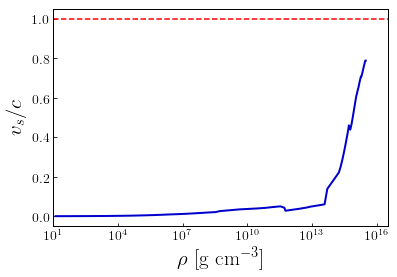

In [614]:
fig, ax = plt.subplots()
plt.plot(rhognh3,np.sqrt(vsquared(rhognh3)),lw='2.0',color='mediumblue')
plt.plot([1e+1,10**(16.5)],[1.0,1.0],'r--',lw='1.5')
plt.xlabel(r'$\rho$ [g\,\,cm$^{-3}$]')
plt.ylabel(r'$ v_s / c $')
plt.xscale('log')
ax.tick_params(axis="x", direction="in")
ax.tick_params(axis="y", direction="in")
plt.xlim(10,10**(16.5))
#ax.set_facecolor('floralwhite')
#mpl.rcParams['axes.linewidth'] = 1.4
#plt.gca().set_aspect('equal', adjustable='box')
#plt.draw()
plt.savefig('figures/SSgnh3.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

## M - $\rho_c$

In [621]:
Rgnh3,Mgnh3,rhocgnh3=np.loadtxt('results/gnh3/MRrhoc.dat',usecols=(0,1,2),unpack=True)

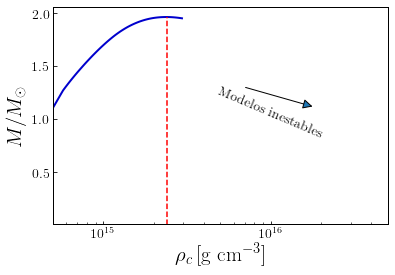

In [626]:
fig, ax = plt.subplots()

plt.plot(rhocgnh3,Mgnh3,color='mediumblue',lw='2.0')
plt.plot([10**(np.log10(rhocgnh3[np.argmax(Mgnh3)])),10**(np.log10(rhocgnh3[np.argmax(Mgnh3)]))],[0.0,np.amax(Mgnh3)],'r--',lw='1.5')

prop = dict(arrowstyle="-|>,head_width=0.4,head_length=0.8",
            shrinkA=0,shrinkB=0)
plt.annotate("", xy=(10**(16.25),1.12), xytext=(10**(15.85),1.3), arrowprops=prop)
#plt.arrow(10**(15.6), 1.38,10**(15.7) ,-0.1 , head_width=0.05, head_lgnh3th=10**(15))
plt.text(10**(15.67), 1.23, 'Modelos inestables' , fontsize=14,rotation=-23)

plt.xscale('log')
plt.xlabel(r'$\rho_c\,[$g cm$^{-3}]$')
plt.ylabel(r'$M/M_{\odot}$')
plt.xlim(left=10**(14.7),right=10**(16.7))
plt.ylim(bottom=0.01)
ax.tick_params(axis="x", direction="in",which='both')
ax.tick_params(axis="y", direction="in",which='both')

plt.savefig('figures/Mrhorel_gnh3.pdf', format='pdf', dpi=1000,bbox_inches="tight")

## Effective and critical adiabatic index

In [47]:
rhoscgnh3,betasgnh3,gamma_efsgnh3,gamma_crsgnh3 = aindex_stab('gnh3')

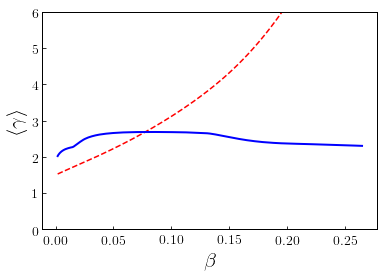

In [48]:
fig, ax = plt.subplots()
plt.plot(betasgnh3,gamma_crsgnh3,lw='1.5',color='r',linestyle='--',label=r'$\gamma_{cr}$')
#plt.plot([betacrit,betacrit],[0,5])
plt.plot(betasgnh3,gamma_efsgnh3,lw='2.0',color='blue',label=r'$\langle \gamma \rangle$')

plt.xlabel(r'$\beta$')
plt.ylabel(r'$\langle \gamma \rangle$')

#plt.xscale('log')
#plt.xlim(left=10**(14.7),right=10**(16.7))
plt.ylim(0,6)
ax.tick_params(axis="x", direction="in",which='both')
ax.tick_params(axis="y", direction="in",which='both')
#l = plt.legend(bbox_to_anchor=(0.85,-0.15), loc="lower right", 
                #bbox_transform=fig.transFigure, ncol=2)



plt.savefig('figures/AIndexStabgnh3.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

## Tunning the interpolation of the solution

### 14.0

In [49]:
gnh3_140=np.loadtxt('results/gnh3/14.0.dat',unpack=True)
gnh3_140[3] = gnh3_140[3]-gnh3_140[3][-1] + 0.5*np.log(1-2*gnh3_140[0][-1]/gnh3_140[-1][-1])

In [50]:
s1=5e-7
s2=1e-15
gnh3_140rho=interpolate.UnivariateSpline(gnh3_140[-1], gnh3_140[2], k=5, s=s1)
gnh3_140drho=interpolate.UnivariateSpline(gnh3_140[-1], gnh3_140[2], k=5, s=s1).derivative(n=1)
gnh3_140ddrho=interpolate.UnivariateSpline(gnh3_140[-1], gnh3_140[2], k=5, s=s1).derivative(n=2)

gnh3_140p=interpolate.UnivariateSpline(gnh3_140[-1], gnh3_140[1], k=5, s=s2)
gnh3_140dp=interpolate.UnivariateSpline(gnh3_140[-1], gnh3_140[1], k=5, s=s2).derivative(n=1)
gnh3_140ddp=interpolate.UnivariateSpline(gnh3_140[-1], gnh3_140[1], k=5, s=s2).derivative(n=2)

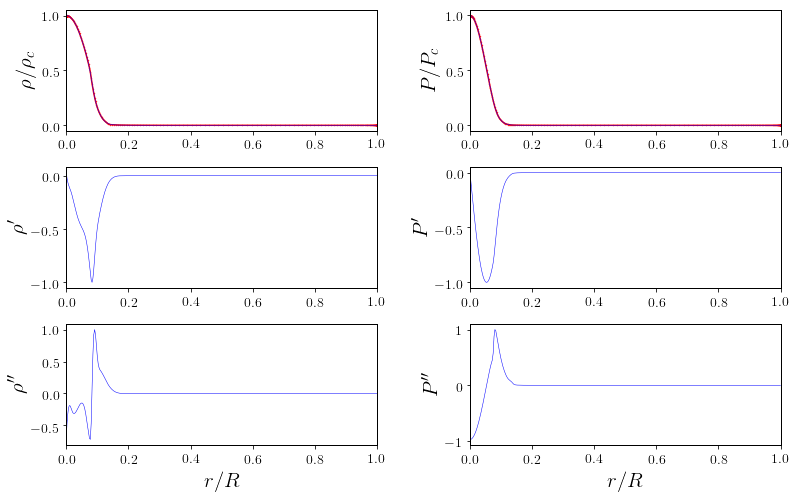

In [629]:
fig=plt.figure(figsize=[12.8,8])

plt.subplot(321)
plt.plot(gnh3_140[-1]/gnh3_140[-1][-1],gnh3_140[2]/gnh3_140[2][0],color='red',marker='o',markersize='0.4') 
plt.plot(gnh3_140[-1]/gnh3_140[-1][-1],gnh3_140rho(gnh3_140[-1])/gnh3_140[2][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1) # leaving the crust out

plt.subplot(322)
plt.plot(gnh3_140[-1]/gnh3_140[-1][-1],gnh3_140[1]/gnh3_140[1][0],color='red',marker='o',markersize='0.4') 
plt.plot(gnh3_140[-1]/gnh3_140[-1][-1],gnh3_140p(gnh3_140[-1])/gnh3_140[1][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$P/P_c$')
plt.xlim(0,1)

plt.subplot(323)
plt.plot(gnh3_140[-1]/gnh3_140[-1][-1],gnh3_140drho(gnh3_140[-1])/max(abs(gnh3_140drho(gnh3_140[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime}$')
plt.xlim(0,1)
#plt.ylim(-500,0)

plt.subplot(324)
plt.plot(gnh3_140[-1]/gnh3_140[-1][-1],gnh3_140dp(gnh3_140[-1])/max(abs(gnh3_140dp(gnh3_140[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime} $')
plt.xlim(0,1)

plt.subplot(325)
plt.plot(gnh3_140[-1]/gnh3_140[-1][-1],gnh3_140ddrho(gnh3_140[-1])/max(abs(gnh3_140ddrho(gnh3_140[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}$')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-0.01,0.01)

plt.subplot(326)
plt.plot(gnh3_140[-1]/gnh3_140[-1][-1],gnh3_140ddp(gnh3_140[-1])/max(abs(gnh3_140ddp(gnh3_140[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime\prime}$ ')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-1,1)

fig.subplots_adjust(hspace=0.3,wspace=0.3)

#plt.savefig('figures/ddsgnh3_140.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

### 14.5

In [51]:
gnh3_145=np.loadtxt('results/gnh3/14.5.dat',unpack=True)
gnh3_145[3] = gnh3_145[3]-gnh3_145[3][-1] + 0.5*np.log(1-2*gnh3_145[0][-1]/gnh3_145[-1][-1])

In [52]:
s1=1e-7
s2=1e-12
gnh3_145rho=interpolate.UnivariateSpline(gnh3_145[-1], gnh3_145[2], k=5, s=s1)
gnh3_145drho=interpolate.UnivariateSpline(gnh3_145[-1], gnh3_145[2], k=5, s=s1).derivative(n=1)
gnh3_145ddrho=interpolate.UnivariateSpline(gnh3_145[-1], gnh3_145[2], k=5, s=s1).derivative(n=2)

gnh3_145p=interpolate.UnivariateSpline(gnh3_145[-1], gnh3_145[1], k=5, s=s2)
gnh3_145dp=interpolate.UnivariateSpline(gnh3_145[-1], gnh3_145[1], k=5, s=s2).derivative(n=1)
gnh3_145ddp=interpolate.UnivariateSpline(gnh3_145[-1], gnh3_145[1], k=5, s=s2).derivative(n=2)

In [632]:
gnh3_145rho(0.4*gnh3_145[-1][-1])*rhodim

252986438410618.1

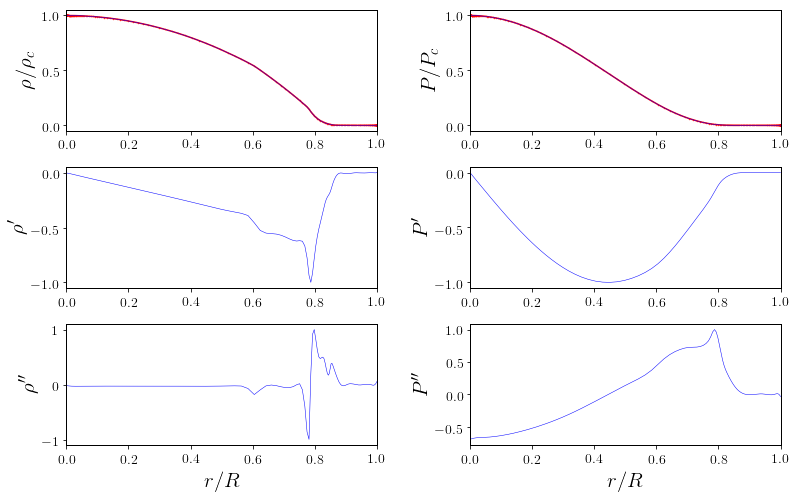

In [633]:
fig=plt.figure(figsize=[12.8,8])

plt.subplot(321)
plt.plot(gnh3_145[-1]/gnh3_145[-1][-1],gnh3_145[2]/gnh3_145[2][0],color='red',marker='o',markersize='0.4') 
plt.plot(gnh3_145[-1]/gnh3_145[-1][-1],gnh3_145rho(gnh3_145[-1])/gnh3_145[2][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1) # leaving the crust out

plt.subplot(322)
plt.plot(gnh3_145[-1]/gnh3_145[-1][-1],gnh3_145[1]/gnh3_145[1][0],color='red',marker='o',markersize='0.4') 
plt.plot(gnh3_145[-1]/gnh3_145[-1][-1],gnh3_145p(gnh3_145[-1])/gnh3_145[1][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$P/P_c$')
plt.xlim(0,1)

plt.subplot(323)
plt.plot(gnh3_145[-1]/gnh3_145[-1][-1],gnh3_145drho(gnh3_145[-1])/max(abs(gnh3_145drho(gnh3_145[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime}$')
plt.xlim(0,1)
#plt.ylim(-500,0)

plt.subplot(324)
plt.plot(gnh3_145[-1]/gnh3_145[-1][-1],gnh3_145dp(gnh3_145[-1])/max(abs(gnh3_145dp(gnh3_145[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime} $')
plt.xlim(0,1)

plt.subplot(325)
plt.plot(gnh3_145[-1]/gnh3_145[-1][-1],gnh3_145ddrho(gnh3_145[-1])/max(abs(gnh3_145ddrho(gnh3_145[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}$')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-0.01,0.01)

plt.subplot(326)
plt.plot(gnh3_145[-1]/gnh3_145[-1][-1],gnh3_145ddp(gnh3_145[-1])/max(abs(gnh3_145ddp(gnh3_145[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime\prime}$ ')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-1,1)

fig.subplots_adjust(hspace=0.3,wspace=0.3)

#plt.savefig('figures/ddsgnh3_145.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

### 15.0

In [53]:
gnh3_150=np.loadtxt('results/gnh3/15.0.dat',unpack=True)
gnh3_150[3] = gnh3_150[3]-gnh3_150[3][-1] + 0.5*np.log(1-2*gnh3_150[0][-1]/gnh3_150[-1][-1])

In [56]:
s1=1e-7
s2=1e-15
gnh3_150rho=interpolate.UnivariateSpline(gnh3_150[-1], gnh3_150[2], k=5, s=s1)
gnh3_150drho=interpolate.UnivariateSpline(gnh3_150[-1], gnh3_150[2], k=5, s=s1).derivative(n=1)
gnh3_150ddrho=interpolate.UnivariateSpline(gnh3_150[-1], gnh3_150[2], k=5, s=s1).derivative(n=2)

gnh3_150p=interpolate.UnivariateSpline(gnh3_150[-1], gnh3_150[1], k=5, s=s2)
gnh3_150dp=interpolate.UnivariateSpline(gnh3_150[-1], gnh3_150[1], k=5, s=s2).derivative(n=1)
gnh3_150ddp=interpolate.UnivariateSpline(gnh3_150[-1], gnh3_150[1], k=5, s=s2).derivative(n=2)

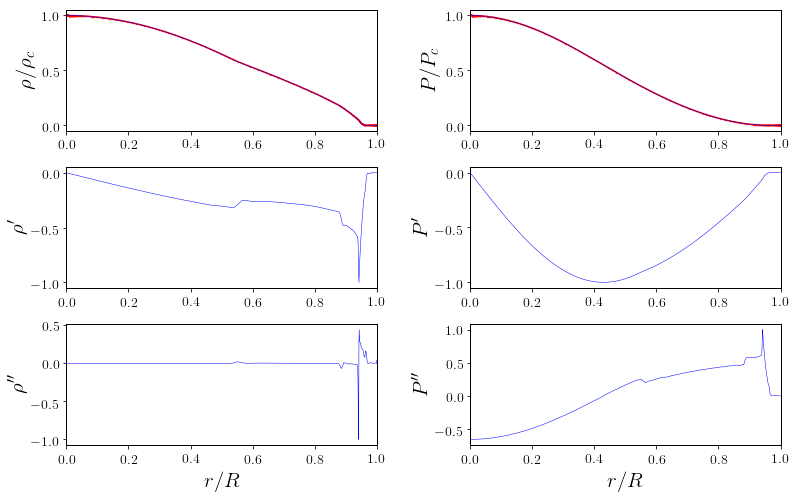

In [57]:
fig=plt.figure(figsize=[12.8,8])

plt.subplot(321)
plt.plot(gnh3_150[-1]/gnh3_150[-1][-1],gnh3_150[2]/gnh3_150[2][0],color='red',marker='o',markersize='0.4') 
plt.plot(gnh3_150[-1]/gnh3_150[-1][-1],gnh3_150rho(gnh3_150[-1])/gnh3_150[2][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1) # leaving the crust out

plt.subplot(322)
plt.plot(gnh3_150[-1]/gnh3_150[-1][-1],gnh3_150[1]/gnh3_150[1][0],color='red',marker='o',markersize='0.4') 
plt.plot(gnh3_150[-1]/gnh3_150[-1][-1],gnh3_150p(gnh3_150[-1])/gnh3_150[1][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$P/P_c$')
plt.xlim(0,1)

plt.subplot(323)
plt.plot(gnh3_150[-1]/gnh3_150[-1][-1],gnh3_150drho(gnh3_150[-1])/max(abs(gnh3_150drho(gnh3_150[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime}$')
plt.xlim(0,1)
#plt.ylim(-500,0)

plt.subplot(324)
plt.plot(gnh3_150[-1]/gnh3_150[-1][-1],gnh3_150dp(gnh3_150[-1])/max(abs(gnh3_150dp(gnh3_150[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime} $')
plt.xlim(0,1)

plt.subplot(325)
plt.plot(gnh3_150[-1]/gnh3_150[-1][-1],gnh3_150ddrho(gnh3_150[-1])/max(abs(gnh3_150ddrho(gnh3_150[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}$')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-0.01,0.01)

plt.subplot(326)
plt.plot(gnh3_150[-1]/gnh3_150[-1][-1],gnh3_150ddp(gnh3_150[-1])/max(abs(gnh3_150ddp(gnh3_150[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime\prime}$ ')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-1,1)

fig.subplots_adjust(hspace=0.3,wspace=0.3)

#plt.savefig('figures/ddsgnh3_150.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

## Adiabatic convection

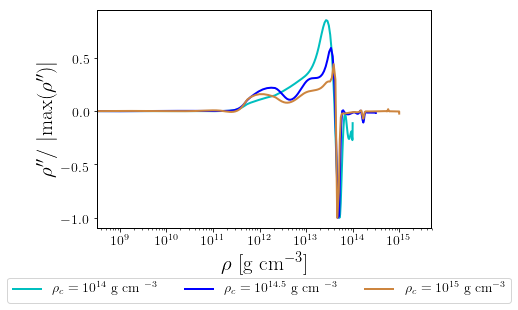

In [58]:
fig, ax = plt.subplots()

ax.set_xscale("log")

plt.plot(gnh3_140[2]*rhodim,gnh3_140ddrho(gnh3_140[-1])/max(abs(gnh3_140ddrho(gnh3_140[-1]))),color='c',linewidth='2.0',label=r'$\rho_c=10^{14}$ g cm $^{-3}$') 
plt.plot(gnh3_145[2]*rhodim,gnh3_145ddrho(gnh3_145[-1])/max(abs(gnh3_145ddrho(gnh3_145[-1]))),color='blue',linewidth='2.0',linestyle='-',label=r'$\rho_c=10^{14.5}$ g cm $^{-3}$') 
plt.plot(gnh3_150[2]*rhodim,gnh3_150ddrho(gnh3_150[-1])/max(abs(gnh3_150ddrho(gnh3_150[-1]))),color='peru',linewidth='2.0',linestyle='-',label=r'$\rho_c=10^{15}$ g cm$ ^{-3}$')
plt.xlim(left=10**(8.5))
#plt.plot(gnh3_155[-1]/gnh3_155[-1][-1],gnh3_155drho(gnh3_155[-1])/max(abs(gnh3_155drho(gnh3_140[-1]))),color='yellow',linewidth='2.0',linestyle='-.',label=r'$\rho_c=10^{15.5}$ g cm$ ^{-3}$')

l = plt.legend(bbox_to_anchor=(1.1,-0.16), loc="lower right", 
                bbox_transform=fig.transFigure, ncol=3)

plt.xlabel(r'$\rho$ [g cm$^{-3}$]')
plt.ylabel(r'$\rho^{\prime \prime}/$ $|$max$(\rho^{\prime \prime})|$')
#plt.xlim(0,1.0)

plt.savefig('figures/ConvecStabilitygnh3Correl.pdf', format='pdf', dpi=1000,bbox_inches="tight")

## Redshift

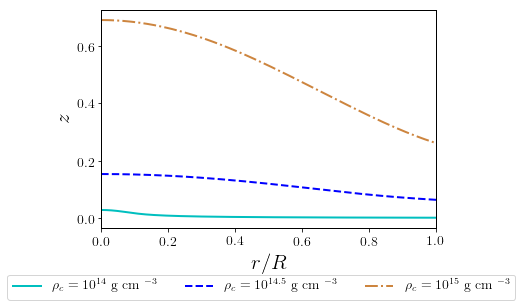

In [639]:
fig = plt.figure()

plt.plot(gnh3_140[-1]/gnh3_140[-1][-1],np.exp(-gnh3_140[3])-1.0,color='c',linewidth='2.0',label=r'$\rho_c=10^{14}$ g cm $^{-3}$')
plt.plot(gnh3_145[-1]/gnh3_145[-1][-1],np.exp(-gnh3_145[3])-1.0,color='blue',linewidth='2.0',linestyle='--',label=r'$\rho_c=10^{14.5}$ g cm $^{-3}$')
plt.plot(gnh3_150[-1]/gnh3_150[-1][-1],np.exp(-gnh3_150[3])-1.0,color='peru',linewidth='2.0',linestyle='-.',label=r'$\rho_c=10^{15}$ g cm $^{-3}$')

l = plt.legend(bbox_to_anchor=(1.1,-0.15), loc="lower right", 
                bbox_transform=fig.transFigure, ncol=3)

plt.xlabel(r'$r/R$')
plt.ylabel(r'$z$')
plt.xlim(0,1.0)

plt.savefig('figures/Redshiftgnh3.pdf', format='pdf', dpi=1000,bbox_inches="tight")

# H1 --------------------------------------------------------------------------------------------

In [61]:
rhoH1,PH1,nH1=np.loadtxt('EOS/h1.dat',usecols=(2,1,0),unpack=True)

## Dominant energy condition

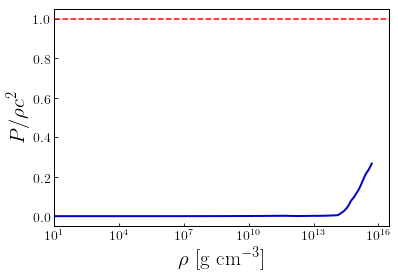

<Figure size 432x288 with 0 Axes>

In [62]:
fig, ax = plt.subplots()
plt.plot(rhoH1,np.divide(PH1,rhoH1),lw='2',color='mediumblue')
plt.plot([0,10**(17)],[1.0,1.0],'r--',lw='1.5')

ax.set_xscale("log")
#locmaj = matplotlib.ticker.LogLocator(base=10.0,numticks=16) 
#ax.xaxis.set_major_locator(locmaj)


plt.xlabel(r'$\rho$ [g\,\,cm$^{-3}$]')
plt.ylabel(r'$ P / \rho c^2 $')
#locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks=16)
#ax.xaxis.set_minor_locator(locmin)
#ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.tick_params(axis="x", direction="in")
ax.tick_params(axis="y", direction="in")
plt.xlim(10,10**(16.5))
#ax.set_facecolor('floralwhite')
#plt.gca().set_aspect('equal', adjustable='box')
#plt.draw()
#plt.ylim(0,1)
plt.savefig('figures/ECH1.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()
plt.clf()

## Speed of sound

In [63]:
vsquared=interpolate.UnivariateSpline(rhoH1, PH1, k=1, s=0).derivative(n=1)

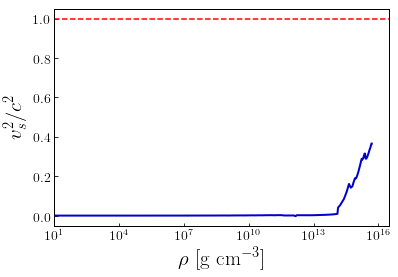

In [65]:
fig, ax = plt.subplots()
plt.plot(rhoH1,vsquared(rhoH1),lw='2.0',color='mediumblue')
plt.plot([1e+1,10**(16.5)],[1.0,1.0],'r--',lw='1.5')
plt.xlabel(r'$\rho$ [g\,\,cm$^{-3}$]')
plt.ylabel(r'$ v_s^2 / c^2 $')
plt.xscale('log')
ax.tick_params(axis="x", direction="in")
ax.tick_params(axis="y", direction="in")
plt.xlim(10,10**(16.5))
#ax.set_facecolor('floralwhite')
#mpl.rcParams['axes.linewidth'] = 1.4
#plt.gca().set_aspect('equal', adjustable='box')
#plt.draw()
plt.savefig('figures/SSH1.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

## M - $\rho_c$

In [66]:
RH1,MH1,rhocH1=np.loadtxt('results/h1/MRrhoc.dat',usecols=(0,1,2),unpack=True)

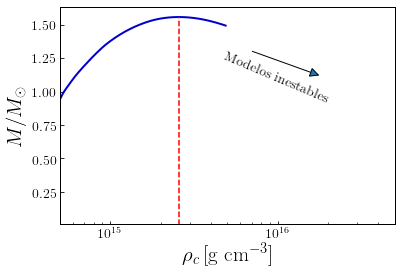

In [67]:
fig, ax = plt.subplots()

plt.plot(rhocH1,MH1,color='mediumblue',lw='2.0')
plt.plot([10**(np.log10(rhocH1[np.argmax(MH1)])),10**(np.log10(rhocH1[np.argmax(MH1)]))],[0.0,np.amax(MH1)],'r--',lw='1.5')

prop = dict(arrowstyle="-|>,head_width=0.4,head_length=0.8",
            shrinkA=0,shrinkB=0)
plt.annotate("", xy=(10**(16.25),1.12), xytext=(10**(15.85),1.3), arrowprops=prop)
#plt.arrow(10**(15.6), 1.38,10**(15.7) ,-0.1 , head_width=0.05, head_lH1th=10**(15))
plt.text(10**(15.67), 1.23, 'Modelos inestables' , fontsize=14,rotation=-23)

plt.xscale('log')
plt.xlabel(r'$\rho_c\,[$g cm$^{-3}]$')
plt.ylabel(r'$M/M_{\odot}$')
plt.xlim(left=10**(14.7),right=10**(16.7))
plt.ylim(bottom=0.01)
ax.tick_params(axis="x", direction="in",which='both')
ax.tick_params(axis="y", direction="in",which='both')

plt.savefig('figures/Mrhorel_H1.pdf', format='pdf', dpi=1000,bbox_inches="tight")

## Effective and critical adiabatic index

In [70]:
rhosch1,betash1,gamma_efsh1,gamma_crsh1 = aindex_stab('h1')

ValueError: x must be strictly increasing

In [ ]:
fig, ax = plt.subplots()
plt.plot(betash1,gamma_crsh1,lw='1.5',color='r',linestyle='--',label=r'$\gamma_{cr}$')
#plt.plot([betacrit,betacrit],[0,5])
plt.plot(betash1,gamma_efsh1,lw='2.0',color='blue',label=r'$\langle \gamma \rangle$')

plt.xlabel(r'$\beta$')
plt.ylabel(r'$\langle \gamma \rangle$')

#plt.xscale('log')
#plt.xlim(left=10**(14.7),right=10**(16.7))
plt.ylim(0,6)
ax.tick_params(axis="x", direction="in",which='both')
ax.tick_params(axis="y", direction="in",which='both')
#l = plt.legend(bbox_to_anchor=(0.85,-0.15), loc="lower right", 
                #bbox_transform=fig.transFigure, ncol=2)



plt.savefig('figures/AIndexStabh1.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

## Tunning the interpolation of the solution

### 14.0

In [72]:
H1_140=np.loadtxt('results/h1/14.0.dat',unpack=True)
H1_140[3] = H1_140[3]-H1_140[3][-1] + 0.5*np.log(1-2*H1_140[0][-1]/H1_140[-1][-1])

In [73]:
s1=5e-7
s2=1e-15
H1_140rho=interpolate.UnivariateSpline(H1_140[-1], H1_140[2], k=5, s=s1)
H1_140drho=interpolate.UnivariateSpline(H1_140[-1], H1_140[2], k=5, s=s1).derivative(n=1)
H1_140ddrho=interpolate.UnivariateSpline(H1_140[-1], H1_140[2], k=5, s=s1).derivative(n=2)

H1_140p=interpolate.UnivariateSpline(H1_140[-1], H1_140[1], k=5, s=s2)
H1_140dp=interpolate.UnivariateSpline(H1_140[-1], H1_140[1], k=5, s=s2).derivative(n=1)
H1_140ddp=interpolate.UnivariateSpline(H1_140[-1], H1_140[1], k=5, s=s2).derivative(n=2)

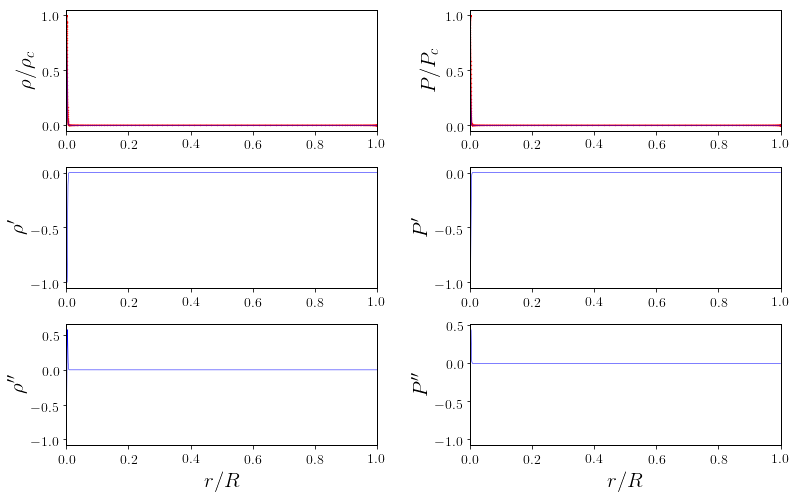

In [685]:
fig=plt.figure(figsize=[12.8,8])

plt.subplot(321)
plt.plot(H1_140[-1]/H1_140[-1][-1],H1_140[2]/H1_140[2][0],color='red',marker='o',markersize='0.4') 
plt.plot(H1_140[-1]/H1_140[-1][-1],H1_140rho(H1_140[-1])/H1_140[2][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1) # leaving the crust out

plt.subplot(322)
plt.plot(H1_140[-1]/H1_140[-1][-1],H1_140[1]/H1_140[1][0],color='red',marker='o',markersize='0.4') 
plt.plot(H1_140[-1]/H1_140[-1][-1],H1_140p(H1_140[-1])/H1_140[1][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$P/P_c$')
plt.xlim(0,1)

plt.subplot(323)
plt.plot(H1_140[-1]/H1_140[-1][-1],H1_140drho(H1_140[-1])/max(abs(H1_140drho(H1_140[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime}$')
plt.xlim(0,1)
#plt.ylim(-500,0)

plt.subplot(324)
plt.plot(H1_140[-1]/H1_140[-1][-1],H1_140dp(H1_140[-1])/max(abs(H1_140dp(H1_140[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime} $')
plt.xlim(0,1)

plt.subplot(325)
plt.plot(H1_140[-1]/H1_140[-1][-1],H1_140ddrho(H1_140[-1])/max(abs(H1_140ddrho(H1_140[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}$')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-0.01,0.01)

plt.subplot(326)
plt.plot(H1_140[-1]/H1_140[-1][-1],H1_140ddp(H1_140[-1])/max(abs(H1_140ddp(H1_140[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime\prime}$ ')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-1,1)

fig.subplots_adjust(hspace=0.3,wspace=0.3)

#plt.savefig('figures/ddsH1_140.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

### 14.5

In [74]:
H1_145=np.loadtxt('results/h1/14.5.dat',unpack=True)
H1_145[3] = H1_145[3]-H1_145[3][-1] + 0.5*np.log(1-2*H1_145[0][-1]/H1_145[-1][-1])

In [75]:
s1=1e-7
s2=1e-12
H1_145rho=interpolate.UnivariateSpline(H1_145[-1], H1_145[2], k=5, s=s1)
H1_145drho=interpolate.UnivariateSpline(H1_145[-1], H1_145[2], k=5, s=s1).derivative(n=1)
H1_145ddrho=interpolate.UnivariateSpline(H1_145[-1], H1_145[2], k=5, s=s1).derivative(n=2)

H1_145p=interpolate.UnivariateSpline(H1_145[-1], H1_145[1], k=5, s=s2)
H1_145dp=interpolate.UnivariateSpline(H1_145[-1], H1_145[1], k=5, s=s2).derivative(n=1)
H1_145ddp=interpolate.UnivariateSpline(H1_145[-1], H1_145[1], k=5, s=s2).derivative(n=2)

In [688]:
H1_145rho(0.4*H1_145[-1][-1])*rhodim

253140812890563.8

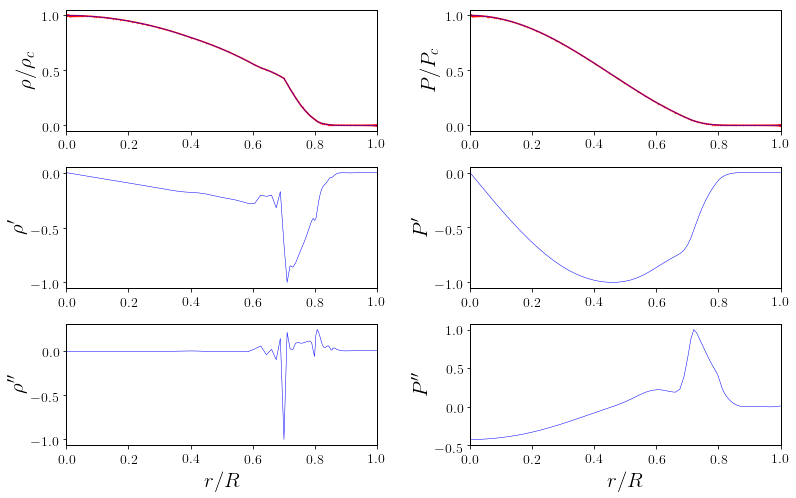

In [689]:
fig=plt.figure(figsize=[12.8,8])

plt.subplot(321)
plt.plot(H1_145[-1]/H1_145[-1][-1],H1_145[2]/H1_145[2][0],color='red',marker='o',markersize='0.4') 
plt.plot(H1_145[-1]/H1_145[-1][-1],H1_145rho(H1_145[-1])/H1_145[2][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1) # leaving the crust out

plt.subplot(322)
plt.plot(H1_145[-1]/H1_145[-1][-1],H1_145[1]/H1_145[1][0],color='red',marker='o',markersize='0.4') 
plt.plot(H1_145[-1]/H1_145[-1][-1],H1_145p(H1_145[-1])/H1_145[1][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$P/P_c$')
plt.xlim(0,1)

plt.subplot(323)
plt.plot(H1_145[-1]/H1_145[-1][-1],H1_145drho(H1_145[-1])/max(abs(H1_145drho(H1_145[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime}$')
plt.xlim(0,1)
#plt.ylim(-500,0)

plt.subplot(324)
plt.plot(H1_145[-1]/H1_145[-1][-1],H1_145dp(H1_145[-1])/max(abs(H1_145dp(H1_145[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime} $')
plt.xlim(0,1)

plt.subplot(325)
plt.plot(H1_145[-1]/H1_145[-1][-1],H1_145ddrho(H1_145[-1])/max(abs(H1_145ddrho(H1_145[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}$')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-0.01,0.01)

plt.subplot(326)
plt.plot(H1_145[-1]/H1_145[-1][-1],H1_145ddp(H1_145[-1])/max(abs(H1_145ddp(H1_145[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime\prime}$ ')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-1,1)

fig.subplots_adjust(hspace=0.3,wspace=0.3)

#plt.savefig('figures/ddsH1_145.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

### 15.0

In [76]:
H1_150=np.loadtxt('results/h1/15.0.dat',unpack=True)
H1_150[3] = H1_150[3]-H1_150[3][-1] + 0.5*np.log(1-2*H1_150[0][-1]/H1_150[-1][-1])

In [77]:
s1=8e-6
s2=1e-15
H1_150rho=interpolate.UnivariateSpline(H1_150[-1], H1_150[2], k=5, s=s1)
H1_150drho=interpolate.UnivariateSpline(H1_150[-1], H1_150[2], k=5, s=s1).derivative(n=1)
H1_150ddrho=interpolate.UnivariateSpline(H1_150[-1], H1_150[2], k=5, s=s1).derivative(n=2)

H1_150p=interpolate.UnivariateSpline(H1_150[-1], H1_150[1], k=5, s=s2)
H1_150dp=interpolate.UnivariateSpline(H1_150[-1], H1_150[1], k=5, s=s2).derivative(n=1)
H1_150ddp=interpolate.UnivariateSpline(H1_150[-1], H1_150[1], k=5, s=s2).derivative(n=2)

ValueError: x must be strictly increasing

In [ ]:
fig=plt.figure(figsize=[12.8,8])

plt.subplot(321)
plt.plot(H1_150[-1]/H1_150[-1][-1],H1_150[2]/H1_150[2][0],color='red',marker='o',markersize='0.4') 
plt.plot(H1_150[-1]/H1_150[-1][-1],H1_150rho(H1_150[-1])/H1_150[2][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1) # leaving the crust out

plt.subplot(322)
plt.plot(H1_150[-1]/H1_150[-1][-1],H1_150[1]/H1_150[1][0],color='red',marker='o',markersize='0.4') 
plt.plot(H1_150[-1]/H1_150[-1][-1],H1_150p(H1_150[-1])/H1_150[1][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$P/P_c$')
plt.xlim(0,1)

plt.subplot(323)
plt.plot(H1_150[-1]/H1_150[-1][-1],H1_150drho(H1_150[-1])/max(abs(H1_150drho(H1_150[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime}$')
plt.xlim(0,1)
#plt.ylim(-500,0)

plt.subplot(324)
plt.plot(H1_150[-1]/H1_150[-1][-1],H1_150dp(H1_150[-1])/max(abs(H1_150dp(H1_150[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime} $')
plt.xlim(0,1)

plt.subplot(325)
plt.plot(H1_150[-1]/H1_150[-1][-1],H1_150ddrho(H1_150[-1])/max(abs(H1_150ddrho(H1_150[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}$')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-0.01,0.01)

plt.subplot(326)
plt.plot(H1_150[-1]/H1_150[-1][-1],H1_150ddp(H1_150[-1])/max(abs(H1_150ddp(H1_150[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime\prime}$ ')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-1,1)

fig.subplots_adjust(hspace=0.3,wspace=0.3)

#plt.savefig('figures/ddsH1_150.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

### 15.5

In [78]:
H1_155=np.loadtxt('results/h1/15.5.dat',unpack=True)
H1_155[3] = H1_155[3]-H1_155[3][-1] + 0.5*np.log(1-2*H1_155[0][-1]/H1_155[-1][-1])

In [79]:
s1=1e-5
s2=1e-9
H1_155rho=interpolate.UnivariateSpline(H1_155[-1], H1_155[2], k=5, s=s1)
H1_155drho=interpolate.UnivariateSpline(H1_155[-1], H1_155[2], k=5, s=s1).derivative(n=1)
H1_155ddrho=interpolate.UnivariateSpline(H1_155[-1], H1_155[2], k=5, s=s1).derivative(n=2)

H1_155p=interpolate.UnivariateSpline(H1_155[-1], H1_155[1], k=5, s=s2)
H1_155dp=interpolate.UnivariateSpline(H1_155[-1], H1_155[1], k=5, s=s2).derivative(n=1)
H1_155ddp=interpolate.UnivariateSpline(H1_155[-1], H1_155[1], k=5, s=s2).derivative(n=2)

ValueError: x must be strictly increasing

In [ ]:
fig=plt.figure(figsize=[12.8,8])

plt.subplot(321)
plt.plot(H1_155[-1]/H1_155[-1][-1],H1_155[2]/H1_155[2][0],color='red',marker='o',markersize='0.4') 
plt.plot(H1_155[-1]/H1_155[-1][-1],H1_155rho(H1_155[-1])/H1_155[2][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1) # leaving the crust out

plt.subplot(322)
plt.plot(H1_155[-1]/H1_155[-1][-1],H1_155[1]/H1_155[1][0],color='red',marker='o',markersize='0.4') 
plt.plot(H1_155[-1]/H1_155[-1][-1],H1_155p(H1_155[-1])/H1_155[1][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$P/P_c$')
plt.xlim(0,1)

plt.subplot(323)
plt.plot(H1_155[-1]/H1_155[-1][-1],H1_155drho(H1_155[-1])/max(abs(H1_155drho(H1_155[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime}$')
plt.xlim(0,1)
#plt.ylim(-500,0)

plt.subplot(324)
plt.plot(H1_155[-1]/H1_155[-1][-1],H1_155dp(H1_155[-1])/max(abs(H1_155dp(H1_155[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime} $')
plt.xlim(0,1)

plt.subplot(325)
plt.plot(H1_155[-1]/H1_155[-1][-1],H1_155ddrho(H1_155[-1])/max(abs(H1_155ddrho(H1_155[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}$')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-0.01,0.01)

plt.subplot(326)
plt.plot(H1_155[-1]/H1_155[-1][-1],H1_155ddp(H1_155[-1])/max(abs(H1_155ddp(H1_155[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime\prime}$ ')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-1,1)

fig.subplots_adjust(hspace=0.3,wspace=0.3)

#plt.savefig('figures/ddsH1_155.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

## Adiabatic convection

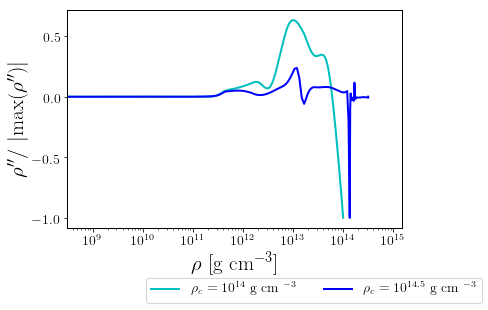

In [81]:
fig, ax = plt.subplots()

ax.set_xscale("log")

plt.plot(H1_140[2]*rhodim,H1_140ddrho(H1_140[-1])/max(abs(H1_140ddrho(H1_140[-1]))),color='c',linewidth='2.0',label=r'$\rho_c=10^{14}$ g cm $^{-3}$') 
plt.plot(H1_145[2]*rhodim,H1_145ddrho(H1_145[-1])/max(abs(H1_145ddrho(H1_145[-1]))),color='blue',linewidth='2.0',linestyle='-',label=r'$\rho_c=10^{14.5}$ g cm $^{-3}$') 
#plt.plot(H1_150[2]*rhodim,H1_150ddrho(H1_150[-1])/max(abs(H1_150ddrho(H1_150[-1]))),color='peru',linewidth='2.0',linestyle='-',label=r'$\rho_c=10^{15}$ g cm$ ^{-3}$')
plt.xlim(left=10**(8.5))
#plt.plot(H1_155[-1]/H1_155[-1][-1],H1_155drho(H1_155[-1])/max(abs(H1_155drho(H1_140[-1]))),color='yellow',linewidth='2.0',linestyle='-.',label=r'$\rho_c=10^{15.5}$ g cm$ ^{-3}$')

l = plt.legend(bbox_to_anchor=(1.1,-0.16), loc="lower right", 
                bbox_transform=fig.transFigure, ncol=3)

plt.xlabel(r'$\rho$ [g cm$^{-3}$]')
plt.ylabel(r'$\rho^{\prime \prime}/$ $|$max$(\rho^{\prime \prime})|$')
#plt.xlim(0,1.0)

plt.savefig('figures/ConvecStabilityH1Correl.pdf', format='pdf', dpi=1000,bbox_inches="tight")

## Redshift

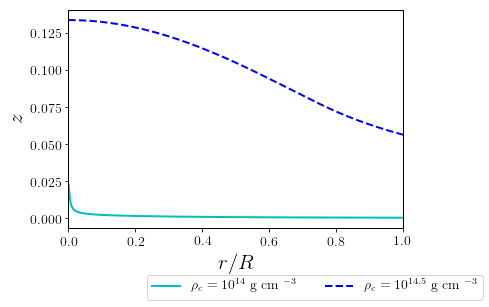

In [82]:
fig = plt.figure()

plt.plot(H1_140[-1]/H1_140[-1][-1],np.exp(-H1_140[3])-1.0,color='c',linewidth='2.0',label=r'$\rho_c=10^{14}$ g cm $^{-3}$')
plt.plot(H1_145[-1]/H1_145[-1][-1],np.exp(-H1_145[3])-1.0,color='blue',linewidth='2.0',linestyle='--',label=r'$\rho_c=10^{14.5}$ g cm $^{-3}$')
#plt.plot(H1_150[-1]/H1_150[-1][-1],np.exp(-H1_150[3])-1.0,color='peru',linewidth='2.0',linestyle='-.',label=r'$\rho_c=10^{15}$ g cm $^{-3}$')

l = plt.legend(bbox_to_anchor=(1.1,-0.15), loc="lower right", 
                bbox_transform=fig.transFigure, ncol=3)

plt.xlabel(r'$r/R$')
plt.ylabel(r'$z$')
plt.xlim(0,1.0)

plt.savefig('figures/RedshiftH1.pdf', format='pdf', dpi=1000,bbox_inches="tight")

# H2 --------------------------------------------------------------------------------------------

In [83]:
rhoH2,PH2,nH2=np.loadtxt('EOS/h2.dat',usecols=(2,1,0),unpack=True)

## Dominant energy condition

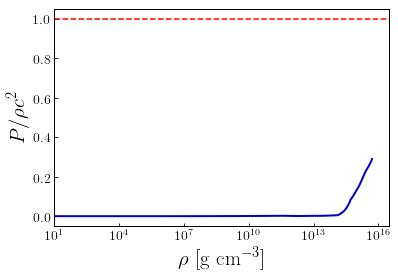

<Figure size 432x288 with 0 Axes>

In [6]:
fig, ax = plt.subplots()
plt.plot(rhoH2,np.divide(PH2,rhoH2),lw='2',color='mediumblue')
plt.plot([0,10**(17)],[1.0,1.0],'r--',lw='1.5')

ax.set_xscale("log")
#locmaj = matplotlib.ticker.LogLocator(base=10.0,numticks=16) 
#ax.xaxis.set_major_locator(locmaj)


plt.xlabel(r'$\rho$ [g\,\,cm$^{-3}$]')
plt.ylabel(r'$ P / \rho c^2 $')
#locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks=16)
#ax.xaxis.set_minor_locator(locmin)
#ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.tick_params(axis="x", direction="in")
ax.tick_params(axis="y", direction="in")
plt.xlim(10,10**(16.5))
#ax.set_facecolor('floralwhite')
#plt.gca().set_aspect('equal', adjustable='box')
#plt.draw()
#plt.ylim(0,1)
plt.savefig('figures/ECH2.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()
plt.clf()

## Speed of sound

In [84]:
vsquared=interpolate.UnivariateSpline(rhoH2, PH2, k=1, s=0).derivative(n=1)

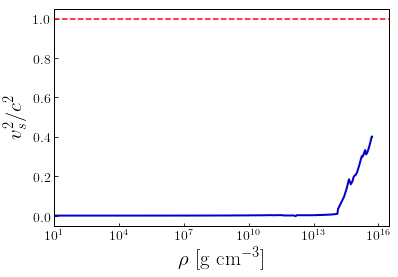

In [86]:
fig, ax = plt.subplots()
plt.plot(rhoH2,vsquared(rhoH2),lw='2.0',color='mediumblue')
plt.plot([1e+1,10**(16.5)],[1.0,1.0],'r--',lw='1.5')
plt.xlabel(r'$\rho$ [g\,\,cm$^{-3}$]')
plt.ylabel(r'$ v_s^2 / c^2 $')
plt.xscale('log')
ax.tick_params(axis="x", direction="in")
ax.tick_params(axis="y", direction="in")
plt.xlim(10,10**(16.5))
#ax.set_facecolor('floralwhite')
#mpl.rcParams['axes.linewidth'] = 1.4
#plt.gca().set_aspect('equal', adjustable='box')
#plt.draw()
plt.savefig('figures/SSH2.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

## M - $\rho_c$

In [15]:
RH2,MH2,rhocH2=np.loadtxt('results/h2/MRrhoc.dat',usecols=(0,1,2),unpack=True)

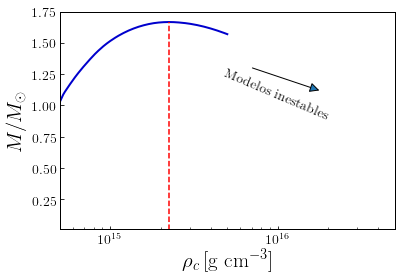

In [19]:
fig, ax = plt.subplots()

plt.plot(rhocH2,MH2,color='mediumblue',lw='2.0')
plt.plot([10**(np.log10(rhocH2[np.argmax(MH2)])),10**(np.log10(rhocH2[np.argmax(MH2)]))],[0.0,np.amax(MH2)],'r--',lw='1.5')

prop = dict(arrowstyle="-|>,head_width=0.4,head_length=0.8",
            shrinkA=0,shrinkB=0)
plt.annotate("", xy=(10**(16.25),1.12), xytext=(10**(15.85),1.3), arrowprops=prop)
#plt.arrow(10**(15.6), 1.38,10**(15.7) ,-0.1 , head_width=0.05, head_lH2th=10**(15))
plt.text(10**(15.67), 1.23, 'Modelos inestables' , fontsize=14,rotation=-23)

plt.xscale('log')
plt.xlabel(r'$\rho_c\,[$g cm$^{-3}]$')
plt.ylabel(r'$M/M_{\odot}$')
plt.xlim(left=10**(14.7),right=10**(16.7))
plt.ylim(bottom=0.01)
ax.tick_params(axis="x", direction="in",which='both')
ax.tick_params(axis="y", direction="in",which='both')

plt.savefig('figures/Mrhorel_H2.pdf', format='pdf', dpi=1000,bbox_inches="tight")

## Effective and critical adiabatic index

In [87]:
rhosch2,betash2,gamma_efsh2,gamma_crsh2 = aindex_stab('h2')

ValueError: x must be strictly increasing

In [ ]:
fig, ax = plt.subplots()
plt.plot(betash2,gamma_crsh2,lw='1.5',color='r',linestyle='--',label=r'$\gamma_{cr}$')
#plt.plot([betacrit,betacrit],[0,5])
plt.plot(betash2,gamma_efsh2,lw='2.0',color='blue',label=r'$\langle \gamma \rangle$')

plt.xlabel(r'$\beta$')
plt.ylabel(r'$\langle \gamma \rangle$')

#plt.xscale('log')
#plt.xlim(left=10**(14.7),right=10**(16.7))
plt.ylim(0,6)
ax.tick_params(axis="x", direction="in",which='both')
ax.tick_params(axis="y", direction="in",which='both')
#l = plt.legend(bbox_to_anchor=(0.85,-0.15), loc="lower right", 
                #bbox_transform=fig.transFigure, ncol=2)



plt.savefig('figures/AIndexStabh2.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

## Tunning the interpolation of the solution

### 14.0

In [88]:
H2_140=np.loadtxt('results/h2/14.0.dat',unpack=True)
H2_140[3] = H2_140[3]-H2_140[3][-1] + 0.5*np.log(1-2*H2_140[0][-1]/H2_140[-1][-1])

In [89]:
s1=5e-7
s2=1e-15
H2_140rho=interpolate.UnivariateSpline(H2_140[-1], H2_140[2], k=5, s=s1)
H2_140drho=interpolate.UnivariateSpline(H2_140[-1], H2_140[2], k=5, s=s1).derivative(n=1)
H2_140ddrho=interpolate.UnivariateSpline(H2_140[-1], H2_140[2], k=5, s=s1).derivative(n=2)

H2_140p=interpolate.UnivariateSpline(H2_140[-1], H2_140[1], k=5, s=s2)
H2_140dp=interpolate.UnivariateSpline(H2_140[-1], H2_140[1], k=5, s=s2).derivative(n=1)
H2_140ddp=interpolate.UnivariateSpline(H2_140[-1], H2_140[1], k=5, s=s2).derivative(n=2)

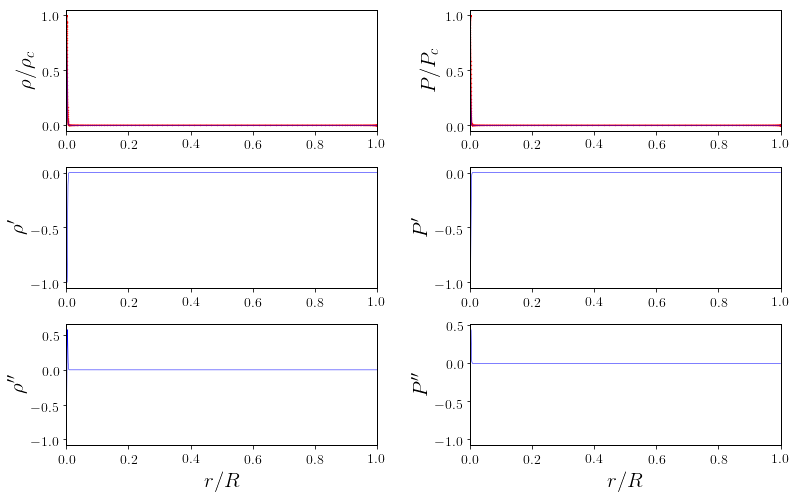

In [22]:
fig=plt.figure(figsize=[12.8,8])

plt.subplot(321)
plt.plot(H2_140[-1]/H2_140[-1][-1],H2_140[2]/H2_140[2][0],color='red',marker='o',markersize='0.4') 
plt.plot(H2_140[-1]/H2_140[-1][-1],H2_140rho(H2_140[-1])/H2_140[2][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1) # leaving the crust out

plt.subplot(322)
plt.plot(H2_140[-1]/H2_140[-1][-1],H2_140[1]/H2_140[1][0],color='red',marker='o',markersize='0.4') 
plt.plot(H2_140[-1]/H2_140[-1][-1],H2_140p(H2_140[-1])/H2_140[1][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$P/P_c$')
plt.xlim(0,1)

plt.subplot(323)
plt.plot(H2_140[-1]/H2_140[-1][-1],H2_140drho(H2_140[-1])/max(abs(H2_140drho(H2_140[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime}$')
plt.xlim(0,1)
#plt.ylim(-500,0)

plt.subplot(324)
plt.plot(H2_140[-1]/H2_140[-1][-1],H2_140dp(H2_140[-1])/max(abs(H2_140dp(H2_140[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime} $')
plt.xlim(0,1)

plt.subplot(325)
plt.plot(H2_140[-1]/H2_140[-1][-1],H2_140ddrho(H2_140[-1])/max(abs(H2_140ddrho(H2_140[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}$')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-0.01,0.01)

plt.subplot(326)
plt.plot(H2_140[-1]/H2_140[-1][-1],H2_140ddp(H2_140[-1])/max(abs(H2_140ddp(H2_140[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime\prime}$ ')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-1,1)

fig.subplots_adjust(hspace=0.3,wspace=0.3)

#plt.savefig('figures/ddsH2_140.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

### 14.5

In [90]:
H2_145=np.loadtxt('results/h2/14.5.dat',unpack=True)
H2_145[3] = H2_145[3]-H2_145[3][-1] + 0.5*np.log(1-2*H2_145[0][-1]/H2_145[-1][-1])

In [91]:
s1=1e-7
s2=1e-12
H2_145rho=interpolate.UnivariateSpline(H2_145[-1], H2_145[2], k=5, s=s1)
H2_145drho=interpolate.UnivariateSpline(H2_145[-1], H2_145[2], k=5, s=s1).derivative(n=1)
H2_145ddrho=interpolate.UnivariateSpline(H2_145[-1], H2_145[2], k=5, s=s1).derivative(n=2)

H2_145p=interpolate.UnivariateSpline(H2_145[-1], H2_145[1], k=5, s=s2)
H2_145dp=interpolate.UnivariateSpline(H2_145[-1], H2_145[1], k=5, s=s2).derivative(n=1)
H2_145ddp=interpolate.UnivariateSpline(H2_145[-1], H2_145[1], k=5, s=s2).derivative(n=2)

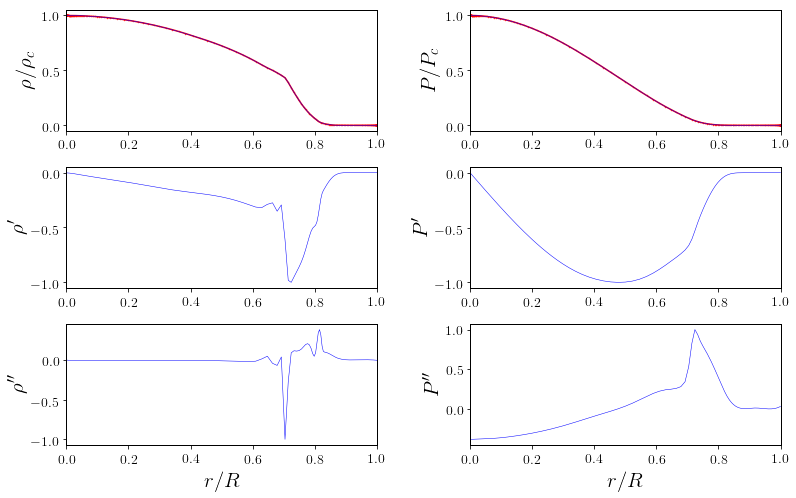

In [26]:
fig=plt.figure(figsize=[12.8,8])

plt.subplot(321)
plt.plot(H2_145[-1]/H2_145[-1][-1],H2_145[2]/H2_145[2][0],color='red',marker='o',markersize='0.4') 
plt.plot(H2_145[-1]/H2_145[-1][-1],H2_145rho(H2_145[-1])/H2_145[2][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1) # leaving the crust out

plt.subplot(322)
plt.plot(H2_145[-1]/H2_145[-1][-1],H2_145[1]/H2_145[1][0],color='red',marker='o',markersize='0.4') 
plt.plot(H2_145[-1]/H2_145[-1][-1],H2_145p(H2_145[-1])/H2_145[1][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$P/P_c$')
plt.xlim(0,1)

plt.subplot(323)
plt.plot(H2_145[-1]/H2_145[-1][-1],H2_145drho(H2_145[-1])/max(abs(H2_145drho(H2_145[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime}$')
plt.xlim(0,1)
#plt.ylim(-500,0)

plt.subplot(324)
plt.plot(H2_145[-1]/H2_145[-1][-1],H2_145dp(H2_145[-1])/max(abs(H2_145dp(H2_145[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime} $')
plt.xlim(0,1)

plt.subplot(325)
plt.plot(H2_145[-1]/H2_145[-1][-1],H2_145ddrho(H2_145[-1])/max(abs(H2_145ddrho(H2_145[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}$')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-0.01,0.01)

plt.subplot(326)
plt.plot(H2_145[-1]/H2_145[-1][-1],H2_145ddp(H2_145[-1])/max(abs(H2_145ddp(H2_145[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime\prime}$ ')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-1,1)

fig.subplots_adjust(hspace=0.3,wspace=0.3)

#plt.savefig('figures/ddsH2_145.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

### 15.0

In [92]:
H2_150=np.loadtxt('results/h2/15.0.dat',unpack=True)
H2_150[3] = H2_150[3]-H2_150[3][-1] + 0.5*np.log(1-2*H2_150[0][-1]/H2_150[-1][-1])

In [93]:
s1=8e-6
s2=1e-15
H2_150rho=interpolate.UnivariateSpline(H2_150[-1], H2_150[2], k=5, s=s1)
H2_150drho=interpolate.UnivariateSpline(H2_150[-1], H2_150[2], k=5, s=s1).derivative(n=1)
H2_150ddrho=interpolate.UnivariateSpline(H2_150[-1], H2_150[2], k=5, s=s1).derivative(n=2)

H2_150p=interpolate.UnivariateSpline(H2_150[-1], H2_150[1], k=5, s=s2)
H2_150dp=interpolate.UnivariateSpline(H2_150[-1], H2_150[1], k=5, s=s2).derivative(n=1)
H2_150ddp=interpolate.UnivariateSpline(H2_150[-1], H2_150[1], k=5, s=s2).derivative(n=2)

ValueError: x must be strictly increasing

In [ ]:
fig=plt.figure(figsize=[12.8,8])

plt.subplot(321)
plt.plot(H2_150[-1]/H2_150[-1][-1],H2_150[2]/H2_150[2][0],color='red',marker='o',markersize='0.4') 
plt.plot(H2_150[-1]/H2_150[-1][-1],H2_150rho(H2_150[-1])/H2_150[2][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1) # leaving the crust out

plt.subplot(322)
plt.plot(H2_150[-1]/H2_150[-1][-1],H2_150[1]/H2_150[1][0],color='red',marker='o',markersize='0.4') 
plt.plot(H2_150[-1]/H2_150[-1][-1],H2_150p(H2_150[-1])/H2_150[1][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$P/P_c$')
plt.xlim(0,1)

plt.subplot(323)
plt.plot(H2_150[-1]/H2_150[-1][-1],H2_150drho(H2_150[-1])/max(abs(H2_150drho(H2_150[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime}$')
plt.xlim(0,1)
#plt.ylim(-500,0)

plt.subplot(324)
plt.plot(H2_150[-1]/H2_150[-1][-1],H2_150dp(H2_150[-1])/max(abs(H2_150dp(H2_150[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime} $')
plt.xlim(0,1)

plt.subplot(325)
plt.plot(H2_150[-1]/H2_150[-1][-1],H2_150ddrho(H2_150[-1])/max(abs(H2_150ddrho(H2_150[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}$')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-0.01,0.01)

plt.subplot(326)
plt.plot(H2_150[-1]/H2_150[-1][-1],H2_150ddp(H2_150[-1])/max(abs(H2_150ddp(H2_150[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime\prime}$ ')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-1,1)

fig.subplots_adjust(hspace=0.3,wspace=0.3)

#plt.savefig('figures/ddsH2_150.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

### 15.5

In [94]:
H2_155=np.loadtxt('results/h2/15.5.dat',unpack=True)
H2_155[3] = H2_155[3]-H2_155[3][-1] + 0.5*np.log(1-2*H2_155[0][-1]/H2_155[-1][-1])

In [95]:
s1=1e-5
s2=1e-9
H2_155rho=interpolate.UnivariateSpline(H2_155[-1], H2_155[2], k=5, s=s1)
H2_155drho=interpolate.UnivariateSpline(H2_155[-1], H2_155[2], k=5, s=s1).derivative(n=1)
H2_155ddrho=interpolate.UnivariateSpline(H2_155[-1], H2_155[2], k=5, s=s1).derivative(n=2)

H2_155p=interpolate.UnivariateSpline(H2_155[-1], H2_155[1], k=5, s=s2)
H2_155dp=interpolate.UnivariateSpline(H2_155[-1], H2_155[1], k=5, s=s2).derivative(n=1)
H2_155ddp=interpolate.UnivariateSpline(H2_155[-1], H2_155[1], k=5, s=s2).derivative(n=2)

ValueError: x must be strictly increasing

In [ ]:
fig=plt.figure(figsize=[12.8,8])

plt.subplot(321)
plt.plot(H2_155[-1]/H2_155[-1][-1],H2_155[2]/H2_155[2][0],color='red',marker='o',markersize='0.4') 
plt.plot(H2_155[-1]/H2_155[-1][-1],H2_155rho(H2_155[-1])/H2_155[2][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1) # leaving the crust out

plt.subplot(322)
plt.plot(H2_155[-1]/H2_155[-1][-1],H2_155[1]/H2_155[1][0],color='red',marker='o',markersize='0.4') 
plt.plot(H2_155[-1]/H2_155[-1][-1],H2_155p(H2_155[-1])/H2_155[1][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$P/P_c$')
plt.xlim(0,1)

plt.subplot(323)
plt.plot(H2_155[-1]/H2_155[-1][-1],H2_155drho(H2_155[-1])/max(abs(H2_155drho(H2_155[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime}$')
plt.xlim(0,1)
#plt.ylim(-500,0)

plt.subplot(324)
plt.plot(H2_155[-1]/H2_155[-1][-1],H2_155dp(H2_155[-1])/max(abs(H2_155dp(H2_155[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime} $')
plt.xlim(0,1)

plt.subplot(325)
plt.plot(H2_155[-1]/H2_155[-1][-1],H2_155ddrho(H2_155[-1])/max(abs(H2_155ddrho(H2_155[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}$')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-0.01,0.01)

plt.subplot(326)
plt.plot(H2_155[-1]/H2_155[-1][-1],H2_155ddp(H2_155[-1])/max(abs(H2_155ddp(H2_155[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime\prime}$ ')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-1,1)

fig.subplots_adjust(hspace=0.3,wspace=0.3)

#plt.savefig('figures/ddsH2_155.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

## Adiabatic convection

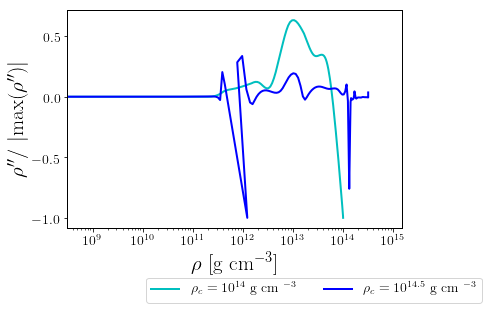

In [97]:
fig, ax = plt.subplots()

ax.set_xscale("log")

plt.plot(H2_140[2]*rhodim,H2_140ddrho(H2_140[-1])/max(abs(H2_140ddrho(H2_140[-1]))),color='c',linewidth='2.0',label=r'$\rho_c=10^{14}$ g cm $^{-3}$') 
plt.plot(H2_145[2]*rhodim,H2_145ddrho(H2_145[-1])/max(abs(H2_145ddrho(H2_145[-1]))),color='blue',linewidth='2.0',linestyle='-',label=r'$\rho_c=10^{14.5}$ g cm $^{-3}$') 
#plt.plot(H2_150[2]*rhodim,H2_150ddrho(H2_150[-1])/max(abs(H2_150ddrho(H2_150[-1]))),color='peru',linewidth='2.0',linestyle='-',label=r'$\rho_c=10^{15}$ g cm$ ^{-3}$')
plt.xlim(left=10**(8.5))
#plt.plot(H2_155[-1]/H2_155[-1][-1],H2_155drho(H2_155[-1])/max(abs(H2_155drho(H2_140[-1]))),color='yellow',linewidth='2.0',linestyle='-.',label=r'$\rho_c=10^{15.5}$ g cm$ ^{-3}$')

l = plt.legend(bbox_to_anchor=(1.1,-0.16), loc="lower right", 
                bbox_transform=fig.transFigure, ncol=3)

plt.xlabel(r'$\rho$ [g cm$^{-3}$]')
plt.ylabel(r'$\rho^{\prime \prime}/$ $|$max$(\rho^{\prime \prime})|$')
#plt.xlim(0,1.0)

plt.savefig('figures/ConvecStabilityH2Correl.pdf', format='pdf', dpi=1000,bbox_inches="tight")

## Redshift

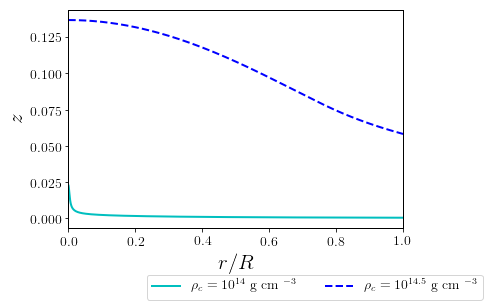

In [96]:
fig = plt.figure()

plt.plot(H2_140[-1]/H2_140[-1][-1],np.exp(-H2_140[3])-1.0,color='c',linewidth='2.0',label=r'$\rho_c=10^{14}$ g cm $^{-3}$')
plt.plot(H2_145[-1]/H2_145[-1][-1],np.exp(-H2_145[3])-1.0,color='blue',linewidth='2.0',linestyle='--',label=r'$\rho_c=10^{14.5}$ g cm $^{-3}$')
#plt.plot(H2_150[-1]/H2_150[-1][-1],np.exp(-H2_150[3])-1.0,color='peru',linewidth='2.0',linestyle='-.',label=r'$\rho_c=10^{15}$ g cm $^{-3}$')

l = plt.legend(bbox_to_anchor=(1.1,-0.15), loc="lower right", 
                bbox_transform=fig.transFigure, ncol=3)

plt.xlabel(r'$r/R$')
plt.ylabel(r'$z$')
plt.xlim(0,1.0)

plt.savefig('figures/RedshiftH2.pdf', format='pdf', dpi=1000,bbox_inches="tight")

# H3 --------------------------------------------------------------------------------------------

In [668]:
rhoH1,PH1,nH1=np.loadtxt('EOS/H1.dat',usecols=(2,1,0),unpack=True)

## Dominant energy condition

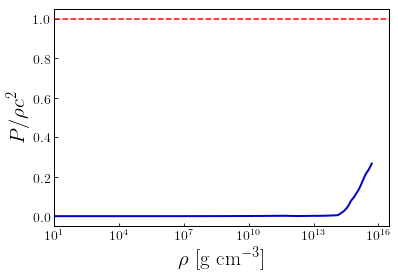

<Figure size 432x288 with 0 Axes>

In [669]:
fig, ax = plt.subplots()
plt.plot(rhoH1,np.divide(PH1,rhoH1),lw='2',color='mediumblue')
plt.plot([0,10**(17)],[1.0,1.0],'r--',lw='1.5')

ax.set_xscale("log")
#locmaj = matplotlib.ticker.LogLocator(base=10.0,numticks=16) 
#ax.xaxis.set_major_locator(locmaj)


plt.xlabel(r'$\rho$ [g\,\,cm$^{-3}$]')
plt.ylabel(r'$ P / \rho c^2 $')
#locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks=16)
#ax.xaxis.set_minor_locator(locmin)
#ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.tick_params(axis="x", direction="in")
ax.tick_params(axis="y", direction="in")
plt.xlim(10,10**(16.5))
#ax.set_facecolor('floralwhite')
#plt.gca().set_aspect('equal', adjustable='box')
#plt.draw()
#plt.ylim(0,1)
plt.savefig('figures/ECH1.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()
plt.clf()

## Speed of sound

In [670]:
vsquared=interpolate.UnivariateSpline(rhoH1, PH1, k=1, s=0).derivative(n=1)

/home/dave/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  


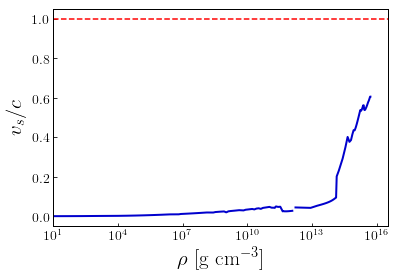

In [671]:
fig, ax = plt.subplots()
plt.plot(rhoH1,np.sqrt(vsquared(rhoH1)),lw='2.0',color='mediumblue')
plt.plot([1e+1,10**(16.5)],[1.0,1.0],'r--',lw='1.5')
plt.xlabel(r'$\rho$ [g\,\,cm$^{-3}$]')
plt.ylabel(r'$ v_s / c $')
plt.xscale('log')
ax.tick_params(axis="x", direction="in")
ax.tick_params(axis="y", direction="in")
plt.xlim(10,10**(16.5))
#ax.set_facecolor('floralwhite')
#mpl.rcParams['axes.linewidth'] = 1.4
#plt.gca().set_aspect('equal', adjustable='box')
#plt.draw()
plt.savefig('figures/SSH1.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

## Adiabatic Index

In [672]:
Gamma=np.multiply(np.divide(np.add(rhoH1,PH1),PH1),vsquared(rhoH1))

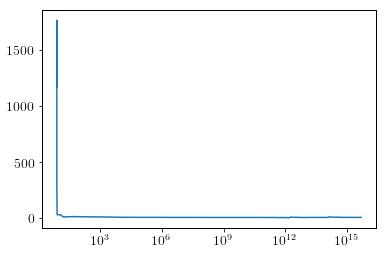

In [673]:
plt.plot(rhoH1,Gamma)
plt.xscale('log')

$$ \langle\gamma\rangle=\frac{\int_{0}^{R} e^{(\lambda+3 \nu) } \gamma(r) P(r) r^{2} d r}{\int_{0}^{R} e^{(\lambda+3 \nu) } P(r) r^{2} d r} $$

Listing all the models calculated

In [674]:
owd=os.getcwd()
path=os.chdir('results/H1')
listOfEntries= os.scandir(path)
models_H1 = []
for entry in listOfEntries:
    if '1' in entry.name:
        models_H1.append(entry.name)
os.chdir(owd)
models_H1.sort()

In [675]:
gamma_efs1 = []
gamma_efs2 = []
gamma_crs1 = []
gamma_crs2 = []
rhosc= []
for model in models_H1:
    m, P, rho, nu, lambd, r = np.loadtxt('results/H1/' + model ,unpack=True)
    nu = nu - nu[-1] + 0.5*np.log(1-2*m[-1]/r[-1])
    #lambd = np.zeros_like(r)
    #for i in range((r.shape)[0]):
    #    if i==0:
    #        lambd[i] = 0
    #    else:
    #        lambd[i] = 0.5*np.log(1/(1-2*m[i]/r[i]))
    drho=interpolate.UnivariateSpline(r, rho, k=5, s=0).derivative(n=1)
    dP=interpolate.UnivariateSpline(r, P, k=5, s=0).derivative(n=1)
    gamma = np.divide(dP(r),drho(r))
    gamma_ef1 = integrate.trapz(np.exp(lambd+3*nu)*gamma*P*(r**2),r)/integrate.trapz(np.exp(lambd+3*nu)*P*(r**2),r)
    t1 = (1/36)*integrate.trapz(np.exp((lambd+3*nu))*(16*P+(np.exp(2*lambd)-1)*(P+rho))*(np.exp(2*lambd)-1)*(r**2))/integrate.trapz(np.exp(lambd+3*nu)*P*(r**2),r)
    t2 = (4*np.pi/9)*integrate.trapz(np.exp(3*lambd+3*nu)*(8*P + (np.exp(2*lambd)+1)*(P+rho))*P*(r**4),r)/integrate.trapz(np.exp(lambd+3*nu)*P*(r**2),r)
    t3 = ((16*np.pi**2)/9)*integrate.trapz(np.exp(5*lambd+3*nu)*(P+rho)*(P**2)*(r**6),r)/integrate.trapz(np.exp(lambd+3*nu)*P*(r**2),r)
    gamma_cr1 = 4/3 + t1 + t2 + t3
    gamma_efs1.append(gamma_ef1)
    gamma_crs1.append(gamma_cr1)
    gamma_ef2 = integrate.trapz(gamma*P*r**2,r)/integrate.trapz(P*r**2,r)
    gamma_cr2 = 4/3 + (19/42)*2*m[-1]/r[-1]
    gamma_efs2.append(gamma_ef2)
    gamma_crs2.append(gamma_cr2)
    rhosc.append(rho[0]*rhodim)

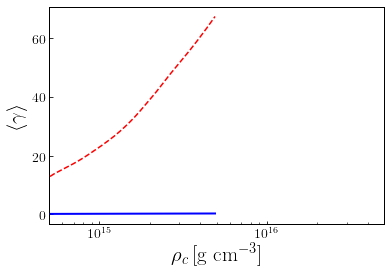

In [676]:
fig, ax = plt.subplots()
plt.plot(rhosc,gamma_crs1,lw='1.5',color='r',linestyle='--',label=r'$\gamma_{cr}$')
plt.plot(rhosc,gamma_efs1,lw='2.0',color='blue',label=r'$\langle \gamma \rangle$')

plt.xlabel(r'$\rho_c\,[$g cm$^{-3}]$')
plt.ylabel(r'$\langle \gamma \rangle$')

plt.xscale('log')
plt.xlim(left=10**(14.7),right=10**(16.7))
#plt.ylim(0,10)
ax.tick_params(axis="x", direction="in",which='both')
ax.tick_params(axis="y", direction="in",which='both')
#l = plt.legend(bbox_to_anchor=(0.85,-0.15), loc="lower right", 
                #bbox_transform=fig.transFigure, ncol=2)



plt.savefig('figures/AdiabaticIndexH1.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

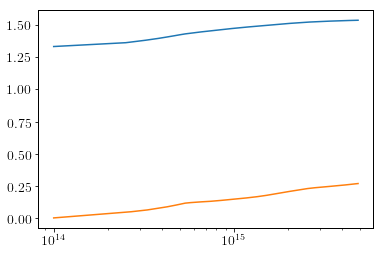

In [677]:
plt.plot(rhosc,gamma_crs2)
plt.plot(rhosc,gamma_efs2)
plt.xscale('log')

## M - $\rho_c$

In [678]:
RH1,MH1,rhocH1=np.loadtxt('results/H1/MRrhoc.dat',usecols=(0,1,2),unpack=True)

In [679]:
np.amax(MH1)

1.5561602557

In [680]:
rhocH1[np.argmax(MH1)]

2570395782770000.0

In [681]:
np.log10(rhocH1[np.argmax(MH1)])

15.410000000000192

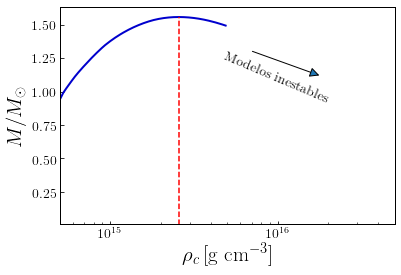

In [682]:
fig, ax = plt.subplots()

plt.plot(rhocH1,MH1,color='mediumblue',lw='2.0')
plt.plot([10**(np.log10(rhocH1[np.argmax(MH1)])),10**(np.log10(rhocH1[np.argmax(MH1)]))],[0.0,np.amax(MH1)],'r--',lw='1.5')

prop = dict(arrowstyle="-|>,head_width=0.4,head_length=0.8",
            shrinkA=0,shrinkB=0)
plt.annotate("", xy=(10**(16.25),1.12), xytext=(10**(15.85),1.3), arrowprops=prop)
#plt.arrow(10**(15.6), 1.38,10**(15.7) ,-0.1 , head_width=0.05, head_lH1th=10**(15))
plt.text(10**(15.67), 1.23, 'Modelos inestables' , fontsize=14,rotation=-23)

plt.xscale('log')
plt.xlabel(r'$\rho_c\,[$g cm$^{-3}]$')
plt.ylabel(r'$M/M_{\odot}$')
plt.xlim(left=10**(14.7),right=10**(16.7))
plt.ylim(bottom=0.01)
ax.tick_params(axis="x", direction="in",which='both')
ax.tick_params(axis="y", direction="in",which='both')

plt.savefig('figures/Mrhorel_H1.pdf', format='pdf', dpi=1000,bbox_inches="tight")

## Tunning the interpolation of the solution

### 14.0

In [683]:
H1_140=np.loadtxt('results/H1/14.0.dat',unpack=True)
H1_140[3] = H1_140[3]-H1_140[3][-1] + 0.5*np.log(1-2*H1_140[0][-1]/H1_140[-1][-1])

In [684]:
s1=5e-7
s2=1e-15
H1_140rho=interpolate.UnivariateSpline(H1_140[-1], H1_140[2], k=5, s=s1)
H1_140drho=interpolate.UnivariateSpline(H1_140[-1], H1_140[2], k=5, s=s1).derivative(n=1)
H1_140ddrho=interpolate.UnivariateSpline(H1_140[-1], H1_140[2], k=5, s=s1).derivative(n=2)

H1_140p=interpolate.UnivariateSpline(H1_140[-1], H1_140[1], k=5, s=s2)
H1_140dp=interpolate.UnivariateSpline(H1_140[-1], H1_140[1], k=5, s=s2).derivative(n=1)
H1_140ddp=interpolate.UnivariateSpline(H1_140[-1], H1_140[1], k=5, s=s2).derivative(n=2)

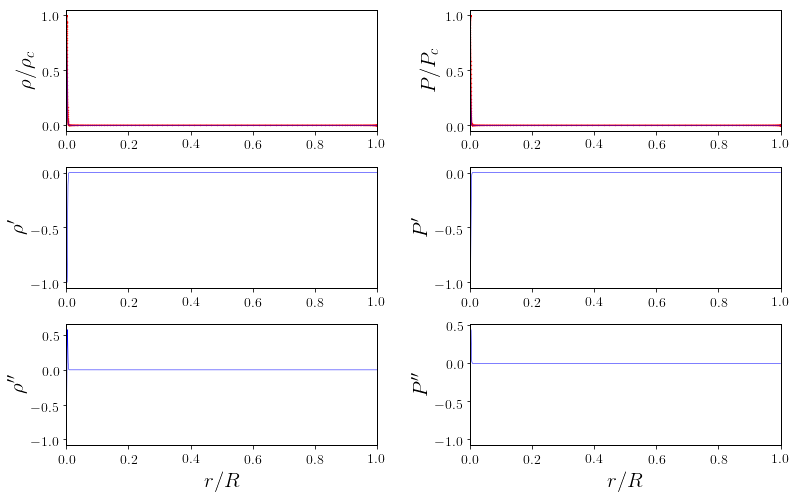

In [685]:
fig=plt.figure(figsize=[12.8,8])

plt.subplot(321)
plt.plot(H1_140[-1]/H1_140[-1][-1],H1_140[2]/H1_140[2][0],color='red',marker='o',markersize='0.4') 
plt.plot(H1_140[-1]/H1_140[-1][-1],H1_140rho(H1_140[-1])/H1_140[2][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1) # leaving the crust out

plt.subplot(322)
plt.plot(H1_140[-1]/H1_140[-1][-1],H1_140[1]/H1_140[1][0],color='red',marker='o',markersize='0.4') 
plt.plot(H1_140[-1]/H1_140[-1][-1],H1_140p(H1_140[-1])/H1_140[1][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$P/P_c$')
plt.xlim(0,1)

plt.subplot(323)
plt.plot(H1_140[-1]/H1_140[-1][-1],H1_140drho(H1_140[-1])/max(abs(H1_140drho(H1_140[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime}$')
plt.xlim(0,1)
#plt.ylim(-500,0)

plt.subplot(324)
plt.plot(H1_140[-1]/H1_140[-1][-1],H1_140dp(H1_140[-1])/max(abs(H1_140dp(H1_140[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime} $')
plt.xlim(0,1)

plt.subplot(325)
plt.plot(H1_140[-1]/H1_140[-1][-1],H1_140ddrho(H1_140[-1])/max(abs(H1_140ddrho(H1_140[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}$')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-0.01,0.01)

plt.subplot(326)
plt.plot(H1_140[-1]/H1_140[-1][-1],H1_140ddp(H1_140[-1])/max(abs(H1_140ddp(H1_140[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime\prime}$ ')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-1,1)

fig.subplots_adjust(hspace=0.3,wspace=0.3)

#plt.savefig('figures/ddsH1_140.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

### 14.5

In [686]:
H1_145=np.loadtxt('results/H1/14.5.dat',unpack=True)
H1_145[3] = H1_145[3]-H1_145[3][-1] + 0.5*np.log(1-2*H1_145[0][-1]/H1_145[-1][-1])

In [687]:
s1=1e-7
s2=1e-12
H1_145rho=interpolate.UnivariateSpline(H1_145[-1], H1_145[2], k=5, s=s1)
H1_145drho=interpolate.UnivariateSpline(H1_145[-1], H1_145[2], k=5, s=s1).derivative(n=1)
H1_145ddrho=interpolate.UnivariateSpline(H1_145[-1], H1_145[2], k=5, s=s1).derivative(n=2)

H1_145p=interpolate.UnivariateSpline(H1_145[-1], H1_145[1], k=5, s=s2)
H1_145dp=interpolate.UnivariateSpline(H1_145[-1], H1_145[1], k=5, s=s2).derivative(n=1)
H1_145ddp=interpolate.UnivariateSpline(H1_145[-1], H1_145[1], k=5, s=s2).derivative(n=2)

In [688]:
H1_145rho(0.4*H1_145[-1][-1])*rhodim

253140812890563.8

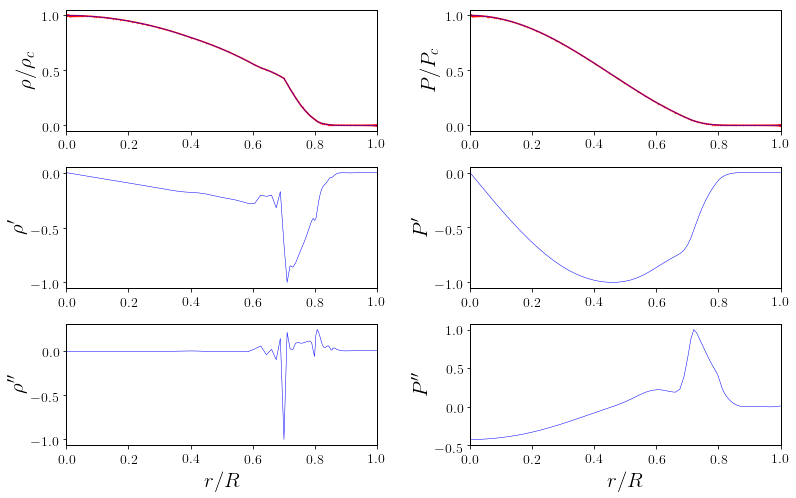

In [689]:
fig=plt.figure(figsize=[12.8,8])

plt.subplot(321)
plt.plot(H1_145[-1]/H1_145[-1][-1],H1_145[2]/H1_145[2][0],color='red',marker='o',markersize='0.4') 
plt.plot(H1_145[-1]/H1_145[-1][-1],H1_145rho(H1_145[-1])/H1_145[2][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1) # leaving the crust out

plt.subplot(322)
plt.plot(H1_145[-1]/H1_145[-1][-1],H1_145[1]/H1_145[1][0],color='red',marker='o',markersize='0.4') 
plt.plot(H1_145[-1]/H1_145[-1][-1],H1_145p(H1_145[-1])/H1_145[1][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$P/P_c$')
plt.xlim(0,1)

plt.subplot(323)
plt.plot(H1_145[-1]/H1_145[-1][-1],H1_145drho(H1_145[-1])/max(abs(H1_145drho(H1_145[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime}$')
plt.xlim(0,1)
#plt.ylim(-500,0)

plt.subplot(324)
plt.plot(H1_145[-1]/H1_145[-1][-1],H1_145dp(H1_145[-1])/max(abs(H1_145dp(H1_145[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime} $')
plt.xlim(0,1)

plt.subplot(325)
plt.plot(H1_145[-1]/H1_145[-1][-1],H1_145ddrho(H1_145[-1])/max(abs(H1_145ddrho(H1_145[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}$')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-0.01,0.01)

plt.subplot(326)
plt.plot(H1_145[-1]/H1_145[-1][-1],H1_145ddp(H1_145[-1])/max(abs(H1_145ddp(H1_145[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime\prime}$ ')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-1,1)

fig.subplots_adjust(hspace=0.3,wspace=0.3)

#plt.savefig('figures/ddsH1_145.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

### 15.0

In [690]:
H1_150=np.loadtxt('results/H1/15.0.dat',unpack=True)
H1_150[3] = H1_150[3]-H1_150[3][-1] + 0.5*np.log(1-2*H1_150[0][-1]/H1_150[-1][-1])

In [691]:
s1=8e-6
s2=1e-15
H1_150rho=interpolate.UnivariateSpline(H1_150[-1], H1_150[2], k=5, s=s1)
H1_150drho=interpolate.UnivariateSpline(H1_150[-1], H1_150[2], k=5, s=s1).derivative(n=1)
H1_150ddrho=interpolate.UnivariateSpline(H1_150[-1], H1_150[2], k=5, s=s1).derivative(n=2)

H1_150p=interpolate.UnivariateSpline(H1_150[-1], H1_150[1], k=5, s=s2)
H1_150dp=interpolate.UnivariateSpline(H1_150[-1], H1_150[1], k=5, s=s2).derivative(n=1)
H1_150ddp=interpolate.UnivariateSpline(H1_150[-1], H1_150[1], k=5, s=s2).derivative(n=2)

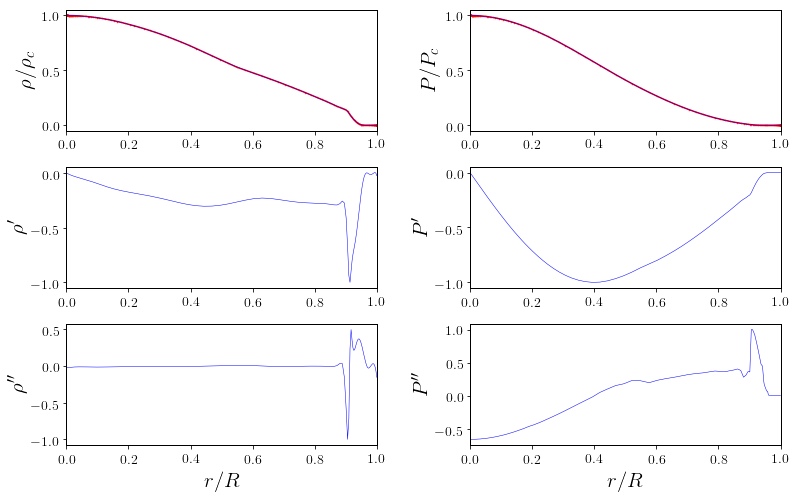

In [692]:
fig=plt.figure(figsize=[12.8,8])

plt.subplot(321)
plt.plot(H1_150[-1]/H1_150[-1][-1],H1_150[2]/H1_150[2][0],color='red',marker='o',markersize='0.4') 
plt.plot(H1_150[-1]/H1_150[-1][-1],H1_150rho(H1_150[-1])/H1_150[2][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1) # leaving the crust out

plt.subplot(322)
plt.plot(H1_150[-1]/H1_150[-1][-1],H1_150[1]/H1_150[1][0],color='red',marker='o',markersize='0.4') 
plt.plot(H1_150[-1]/H1_150[-1][-1],H1_150p(H1_150[-1])/H1_150[1][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$P/P_c$')
plt.xlim(0,1)

plt.subplot(323)
plt.plot(H1_150[-1]/H1_150[-1][-1],H1_150drho(H1_150[-1])/max(abs(H1_150drho(H1_150[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime}$')
plt.xlim(0,1)
#plt.ylim(-500,0)

plt.subplot(324)
plt.plot(H1_150[-1]/H1_150[-1][-1],H1_150dp(H1_150[-1])/max(abs(H1_150dp(H1_150[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime} $')
plt.xlim(0,1)

plt.subplot(325)
plt.plot(H1_150[-1]/H1_150[-1][-1],H1_150ddrho(H1_150[-1])/max(abs(H1_150ddrho(H1_150[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}$')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-0.01,0.01)

plt.subplot(326)
plt.plot(H1_150[-1]/H1_150[-1][-1],H1_150ddp(H1_150[-1])/max(abs(H1_150ddp(H1_150[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime\prime}$ ')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-1,1)

fig.subplots_adjust(hspace=0.3,wspace=0.3)

#plt.savefig('figures/ddsH1_150.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

### 15.5

In [2]:
H1_155=np.loadtxt('results/H1/15.5.dat',unpack=True)
H1_155[3] = H1_155[3]-H1_155[3][-1] + 0.5*np.log(1-2*H1_155[0][-1]/H1_155[-1][-1])

In [3]:
s1=1e-5
s2=1e-9
H1_155rho=interpolate.UnivariateSpline(H1_155[-1], H1_155[2], k=5, s=s1)
H1_155drho=interpolate.UnivariateSpline(H1_155[-1], H1_155[2], k=5, s=s1).derivative(n=1)
H1_155ddrho=interpolate.UnivariateSpline(H1_155[-1], H1_155[2], k=5, s=s1).derivative(n=2)

H1_155p=interpolate.UnivariateSpline(H1_155[-1], H1_155[1], k=5, s=s2)
H1_155dp=interpolate.UnivariateSpline(H1_155[-1], H1_155[1], k=5, s=s2).derivative(n=1)
H1_155ddp=interpolate.UnivariateSpline(H1_155[-1], H1_155[1], k=5, s=s2).derivative(n=2)

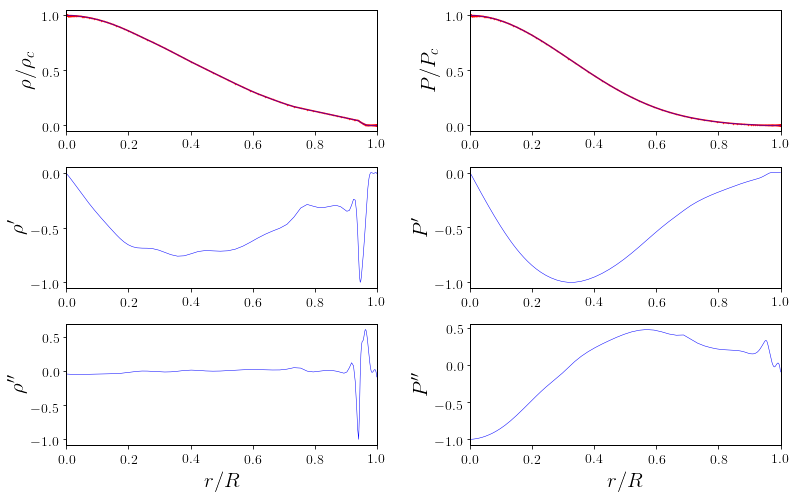

In [4]:
fig=plt.figure(figsize=[12.8,8])

plt.subplot(321)
plt.plot(H1_155[-1]/H1_155[-1][-1],H1_155[2]/H1_155[2][0],color='red',marker='o',markersize='0.4') 
plt.plot(H1_155[-1]/H1_155[-1][-1],H1_155rho(H1_155[-1])/H1_155[2][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1) # leaving the crust out

plt.subplot(322)
plt.plot(H1_155[-1]/H1_155[-1][-1],H1_155[1]/H1_155[1][0],color='red',marker='o',markersize='0.4') 
plt.plot(H1_155[-1]/H1_155[-1][-1],H1_155p(H1_155[-1])/H1_155[1][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$P/P_c$')
plt.xlim(0,1)

plt.subplot(323)
plt.plot(H1_155[-1]/H1_155[-1][-1],H1_155drho(H1_155[-1])/max(abs(H1_155drho(H1_155[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime}$')
plt.xlim(0,1)
#plt.ylim(-500,0)

plt.subplot(324)
plt.plot(H1_155[-1]/H1_155[-1][-1],H1_155dp(H1_155[-1])/max(abs(H1_155dp(H1_155[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime} $')
plt.xlim(0,1)

plt.subplot(325)
plt.plot(H1_155[-1]/H1_155[-1][-1],H1_155ddrho(H1_155[-1])/max(abs(H1_155ddrho(H1_155[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}$')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-0.01,0.01)

plt.subplot(326)
plt.plot(H1_155[-1]/H1_155[-1][-1],H1_155ddp(H1_155[-1])/max(abs(H1_155ddp(H1_155[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime\prime}$ ')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-1,1)

fig.subplots_adjust(hspace=0.3,wspace=0.3)

#plt.savefig('figures/ddsH1_155.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

## Redshift

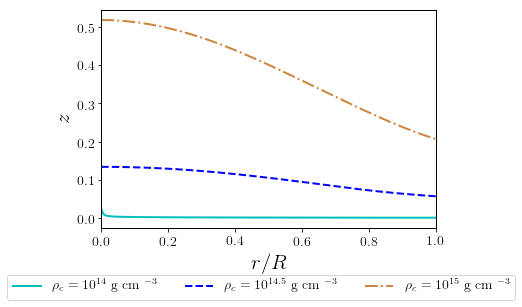

In [693]:
fig = plt.figure()

plt.plot(H1_140[-1]/H1_140[-1][-1],np.exp(-H1_140[3])-1.0,color='c',linewidth='2.0',label=r'$\rho_c=10^{14}$ g cm $^{-3}$')
plt.plot(H1_145[-1]/H1_145[-1][-1],np.exp(-H1_145[3])-1.0,color='blue',linewidth='2.0',linestyle='--',label=r'$\rho_c=10^{14.5}$ g cm $^{-3}$')
plt.plot(H1_150[-1]/H1_150[-1][-1],np.exp(-H1_150[3])-1.0,color='peru',linewidth='2.0',linestyle='-.',label=r'$\rho_c=10^{15}$ g cm $^{-3}$')

l = plt.legend(bbox_to_anchor=(1.1,-0.15), loc="lower right", 
                bbox_transform=fig.transFigure, ncol=3)

plt.xlabel(r'$r/R$')
plt.ylabel(r'$z$')
plt.xlim(0,1.0)

plt.savefig('figures/RedshiftH1.pdf', format='pdf', dpi=1000,bbox_inches="tight")

# H4 --------------------------------------------------------------------------------------------

In [204]:
rhoh4,Ph4,nh4=np.loadtxt('EOS/h4.dat',usecols=(2,1,0),unpack=True)

## Dominant energy condition

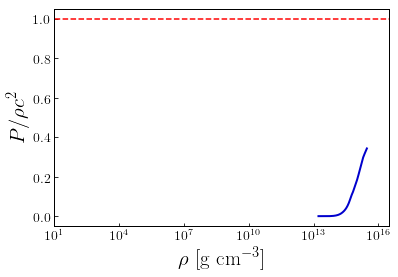

<Figure size 432x288 with 0 Axes>

In [205]:
fig, ax = plt.subplots()
plt.plot(rhoh4,np.divide(Ph4,rhoh4),lw='2',color='mediumblue')
plt.plot([0,10**(17)],[1.0,1.0],'r--',lw='1.5')

ax.set_xscale("log")
#locmaj = matplotlib.ticker.LogLocator(base=10.0,numticks=16) 
#ax.xaxis.set_major_locator(locmaj)


plt.xlabel(r'$\rho$ [g\,\,cm$^{-3}$]')
plt.ylabel(r'$ P / \rho c^2 $')
#locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks=16)
#ax.xaxis.set_minor_locator(locmin)
#ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.tick_params(axis="x", direction="in")
ax.tick_params(axis="y", direction="in")
plt.xlim(10,10**(16.5))
#ax.set_facecolor('floralwhite')
#plt.gca().set_aspect('equal', adjustable='box')
#plt.draw()
#plt.ylim(0,1)
plt.savefig('figures/ECh4.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()
plt.clf()

## Speed of sound

In [206]:
vsquared=interpolate.UnivariateSpline(rhoh4, Ph4, k=1, s=0).derivative(n=1)

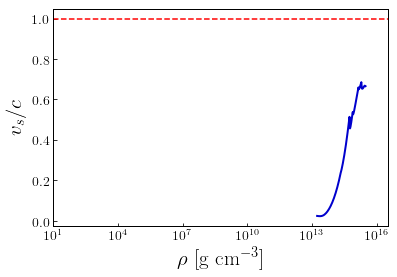

In [207]:
fig, ax = plt.subplots()
plt.plot(rhoh4,np.sqrt(vsquared(rhoh4)),lw='2.0',color='mediumblue')
plt.plot([1e+1,10**(16.5)],[1.0,1.0],'r--',lw='1.5')
plt.xlabel(r'$\rho$ [g\,\,cm$^{-3}$]')
plt.ylabel(r'$ v_s / c $')
plt.xscale('log')
ax.tick_params(axis="x", direction="in")
ax.tick_params(axis="y", direction="in")
plt.xlim(10,10**(16.5))
#ax.set_facecolor('floralwhite')
#mpl.rcParams['axes.linewidth'] = 1.4
#plt.gca().set_aspect('equal', adjustable='box')
#plt.draw()
plt.savefig('figures/SSh4.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

## Adiabatic Index

In [208]:
Gamma=np.multiply(np.divide(np.add(rhoh4,Ph4),Ph4),vsquared(rhoh4))

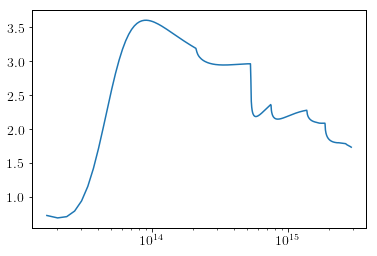

In [209]:
plt.plot(rhoh4,Gamma)
plt.xscale('log')

$$ \langle\gamma\rangle=\frac{\int_{0}^{R} e^{(\lambda+3 \nu) } \gamma(r) P(r) r^{2} d r}{\int_{0}^{R} e^{(\lambda+3 \nu) } P(r) r^{2} d r} $$

Listing all the models calculated

In [9]:
owd=os.getcwd()
path=os.chdir('results/h4')
listOfEntries= os.scandir(path)
models_h4 = []
for entry in listOfEntries:
    if '1' in entry.name:
        models_h4.append(entry.name)
os.chdir(owd)
models_h4.sort()

In [10]:
gamma_efs1 = []
gamma_efs2 = []
gamma_crs1 = []
gamma_crs2 = []
rhosc= []
for model in models_h4:
    m, P, rho, nu, lambd, r = np.loadtxt('results/h4/' + model ,unpack=True)
    nu = nu - nu[-1] + 0.5*np.log(1-2*m[-1]/r[-1])
    #lambd = np.zeros_like(r)
    #for i in range((r.shape)[0]):
    #    if i==0:
    #        lambd[i] = 0
    #    else:
    #        lambd[i] = 0.5*np.log(1/(1-2*m[i]/r[i]))
    drho=interpolate.UnivariateSpline(r, rho, k=5, s=0).derivative(n=1)
    dP=interpolate.UnivariateSpline(r, P, k=5, s=0).derivative(n=1)
    gamma = np.divide(dP(r),drho(r))
    gamma_ef1 = integrate.trapz(np.exp(lambd+3*nu)*gamma*P*(r**2),r)/integrate.trapz(np.exp(lambd+3*nu)*P*(r**2),r)
    t1 = (1/36)*integrate.trapz(np.exp((lambd+3*nu))*(16*P+(np.exp(2*lambd)-1)*(P+rho))*(np.exp(2*lambd)-1)*(r**2))/integrate.trapz(np.exp(lambd+3*nu)*P*(r**2),r)
    t2 = (4*np.pi/9)*integrate.trapz(np.exp(3*lambd+3*nu)*(8*P + (np.exp(2*lambd)+1)*(P+rho))*P*(r**4),r)/integrate.trapz(np.exp(lambd+3*nu)*P*(r**2),r)
    t3 = ((16*np.pi**2)/9)*integrate.trapz(np.exp(5*lambd+3*nu)*(P+rho)*(P**2)*(r**6),r)/integrate.trapz(np.exp(lambd+3*nu)*P*(r**2),r)
    gamma_cr1 = 4/3 + t1 + t2 + t3
    gamma_efs1.append(gamma_ef1)
    gamma_crs1.append(gamma_cr1)
    gamma_ef2 = integrate.trapz(gamma*P*r**2,r)/integrate.trapz(P*r**2,r)
    gamma_cr2 = 4/3 + (19/42)*2*m[-1]/r[-1]
    gamma_efs2.append(gamma_ef2)
    gamma_crs2.append(gamma_cr2)
    rhosc.append(rho[0]*rhodim)

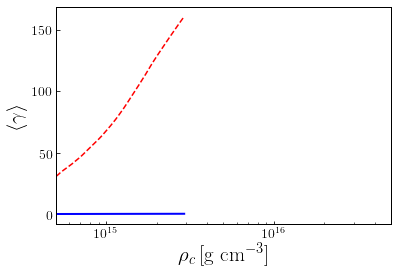

In [11]:
fig, ax = plt.subplots()
plt.plot(rhosc,gamma_crs1,lw='1.5',color='r',linestyle='--',label=r'$\gamma_{cr}$')
plt.plot(rhosc,gamma_efs1,lw='2.0',color='blue',label=r'$\langle \gamma \rangle$')

plt.xlabel(r'$\rho_c\,[$g cm$^{-3}]$')
plt.ylabel(r'$\langle \gamma \rangle$')

plt.xscale('log')
plt.xlim(left=10**(14.7),right=10**(16.7))
#plt.ylim(0,10)
ax.tick_params(axis="x", direction="in",which='both')
ax.tick_params(axis="y", direction="in",which='both')
#l = plt.legend(bbox_to_anchor=(0.85,-0.15), loc="lower right", 
                #bbox_transform=fig.transFigure, ncol=2)



plt.savefig('figures/AdiabaticIndexh4.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

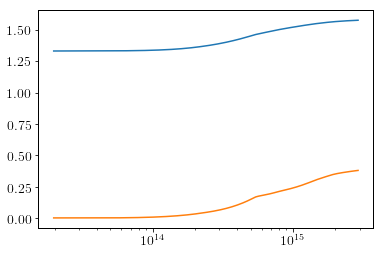

In [12]:
plt.plot(rhosc,gamma_crs2)
plt.plot(rhosc,gamma_efs2)
plt.xscale('log')

## M - $\rho_c$

In [210]:
Rh4,Mh4,rhoch4=np.loadtxt('results/h4/MRrhoc.dat',usecols=(0,1,2),unpack=True)

In [211]:
np.amax(Mh4)

2.03233979171

In [212]:
rhoch4[np.argmax(Mh4)]

2113955113220000.0

In [213]:
np.log10(rhoch4[np.argmax(Mh4)])

15.325095761453987

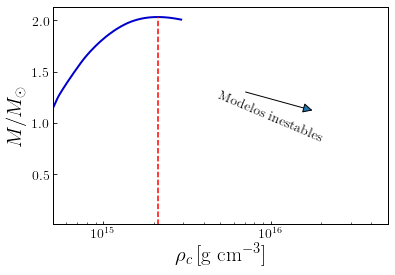

In [214]:
fig, ax = plt.subplots()

plt.plot(rhoch4,Mh4,color='mediumblue',lw='2.0')
plt.plot([10**(np.log10(rhoch4[np.argmax(Mh4)])),10**(np.log10(rhoch4[np.argmax(Mh4)]))],[0.0,np.amax(Mh4)],'r--',lw='1.5')

prop = dict(arrowstyle="-|>,head_width=0.4,head_length=0.8",
            shrinkA=0,shrinkB=0)
plt.annotate("", xy=(10**(16.25),1.12), xytext=(10**(15.85),1.3), arrowprops=prop)
#plt.arrow(10**(15.6), 1.38,10**(15.7) ,-0.1 , head_width=0.05, head_lh4th=10**(15))
plt.text(10**(15.67), 1.23, 'Modelos inestables' , fontsize=14,rotation=-23)

plt.xscale('log')
plt.xlabel(r'$\rho_c\,[$g cm$^{-3}]$')
plt.ylabel(r'$M/M_{\odot}$')
plt.xlim(left=10**(14.7),right=10**(16.7))
plt.ylim(bottom=0.01)
ax.tick_params(axis="x", direction="in",which='both')
ax.tick_params(axis="y", direction="in",which='both')

plt.savefig('figures/Mrhorel_h4.pdf', format='pdf', dpi=1000,bbox_inches="tight")

## Tunning the interpolation of the solution

### 14.0

In [215]:
h4_140=np.loadtxt('results/h4/14.0050957615.dat',unpack=True)
h4_140[3] = h4_140[3]-h4_140[3][-1] + 0.5*np.log(1-2*h4_140[0][-1]/h4_140[-1][-1])

In [266]:
s1=1e-8
s2=1e-15
h4_140rho=interpolate.UnivariateSpline(h4_140[-1], h4_140[2], k=5, s=s1)
h4_140drho=interpolate.UnivariateSpline(h4_140[-1], h4_140[2], k=5, s=s1).derivative(n=1)
h4_140ddrho=interpolate.UnivariateSpline(h4_140[-1], h4_140[2], k=5, s=s1).derivative(n=2)

h4_140p=interpolate.UnivariateSpline(h4_140[-1], h4_140[1], k=5, s=s2)
h4_140dp=interpolate.UnivariateSpline(h4_140[-1], h4_140[1], k=5, s=s2).derivative(n=1)
h4_140ddp=interpolate.UnivariateSpline(h4_140[-1], h4_140[1], k=5, s=s2).derivative(n=2)

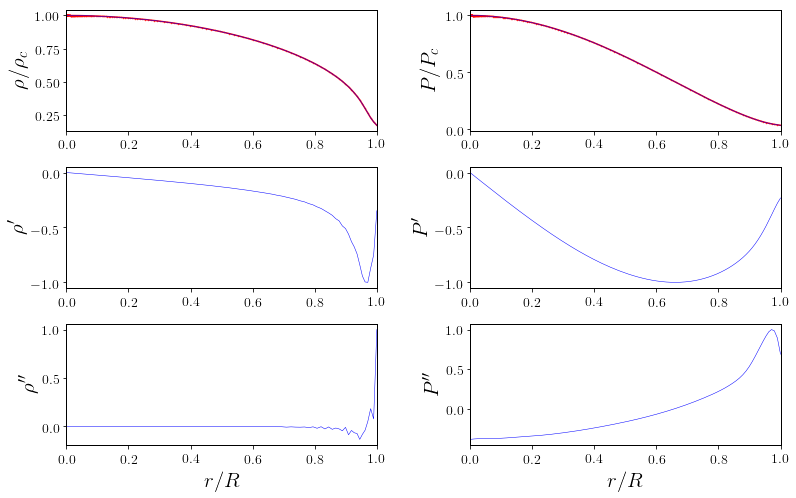

In [254]:
fig=plt.figure(figsize=[12.8,8])

plt.subplot(321)
plt.plot(h4_140[-1]/h4_140[-1][-1],h4_140[2]/h4_140[2][0],color='red',marker='o',markersize='0.4') 
plt.plot(h4_140[-1]/h4_140[-1][-1],h4_140rho(h4_140[-1])/h4_140[2][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1) # leaving the crust out

plt.subplot(322)
plt.plot(h4_140[-1]/h4_140[-1][-1],h4_140[1]/h4_140[1][0],color='red',marker='o',markersize='0.4') 
plt.plot(h4_140[-1]/h4_140[-1][-1],h4_140p(h4_140[-1])/h4_140[1][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$P/P_c$')
plt.xlim(0,1)

plt.subplot(323)
plt.plot(h4_140[-1]/h4_140[-1][-1],h4_140drho(h4_140[-1])/max(abs(h4_140drho(h4_140[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime}$')
plt.xlim(0,1)
#plt.ylim(-500,0)

plt.subplot(324)
plt.plot(h4_140[-1]/h4_140[-1][-1],h4_140dp(h4_140[-1])/max(abs(h4_140dp(h4_140[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime} $')
plt.xlim(0,1)

plt.subplot(325)
plt.plot(h4_140[-1]/h4_140[-1][-1],h4_140ddrho(h4_140[-1])/max(abs(h4_140ddrho(h4_140[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}$')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-0.01,0.01)

plt.subplot(326)
plt.plot(h4_140[-1]/h4_140[-1][-1],h4_140ddp(h4_140[-1])/max(abs(h4_140ddp(h4_140[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime\prime}$ ')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-1,1)

fig.subplots_adjust(hspace=0.3,wspace=0.3)

#plt.savefig('figures/ddsh4_140.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

### 14.5

In [255]:
h4_145=np.loadtxt('results/h4/14.5050957615.dat',unpack=True)
h4_145[3] = h4_145[3]-h4_145[3][-1] + 0.5*np.log(1-2*h4_145[0][-1]/h4_145[-1][-1])

In [302]:
np.log10(h4_145[1][-1]*Pdim)

31.079001236399765

In [267]:
s1=1e-8
s2=1e-12
h4_145rho=interpolate.UnivariateSpline(h4_145[-1], h4_145[2], k=5, s=s1)
h4_145drho=interpolate.UnivariateSpline(h4_145[-1], h4_145[2], k=5, s=s1).derivative(n=1)
h4_145ddrho=interpolate.UnivariateSpline(h4_145[-1], h4_145[2], k=5, s=s1).derivative(n=2)

h4_145p=interpolate.UnivariateSpline(h4_145[-1], h4_145[1], k=5, s=s2)
h4_145dp=interpolate.UnivariateSpline(h4_145[-1], h4_145[1], k=5, s=s2).derivative(n=1)
h4_145ddp=interpolate.UnivariateSpline(h4_145[-1], h4_145[1], k=5, s=s2).derivative(n=2)

In [260]:
h4_145rho(0.4*h4_145[-1][-1])*rhodim

285631622936136.44

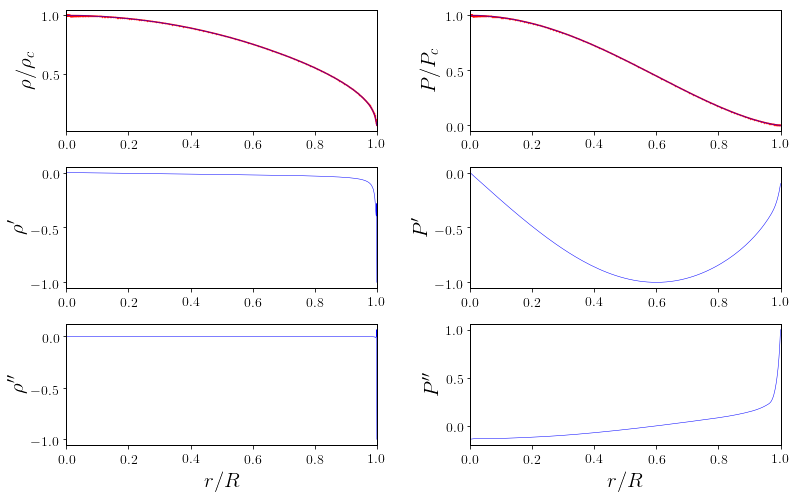

In [261]:
fig=plt.figure(figsize=[12.8,8])

plt.subplot(321)
plt.plot(h4_145[-1]/h4_145[-1][-1],h4_145[2]/h4_145[2][0],color='red',marker='o',markersize='0.4') 
plt.plot(h4_145[-1]/h4_145[-1][-1],h4_145rho(h4_145[-1])/h4_145[2][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1) # leaving the crust out

plt.subplot(322)
plt.plot(h4_145[-1]/h4_145[-1][-1],h4_145[1]/h4_145[1][0],color='red',marker='o',markersize='0.4') 
plt.plot(h4_145[-1]/h4_145[-1][-1],h4_145p(h4_145[-1])/h4_145[1][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$P/P_c$')
plt.xlim(0,1)

plt.subplot(323)
plt.plot(h4_145[-1]/h4_145[-1][-1],h4_145drho(h4_145[-1])/max(abs(h4_145drho(h4_145[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime}$')
plt.xlim(0,1)
#plt.ylim(-500,0)

plt.subplot(324)
plt.plot(h4_145[-1]/h4_145[-1][-1],h4_145dp(h4_145[-1])/max(abs(h4_145dp(h4_145[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime} $')
plt.xlim(0,1)

plt.subplot(325)
plt.plot(h4_145[-1]/h4_145[-1][-1],h4_145ddrho(h4_145[-1])/max(abs(h4_145ddrho(h4_145[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}$')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-0.01,0.01)

plt.subplot(326)
plt.plot(h4_145[-1]/h4_145[-1][-1],h4_145ddp(h4_145[-1])/max(abs(h4_145ddp(h4_145[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime\prime}$ ')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-1,1)

fig.subplots_adjust(hspace=0.3,wspace=0.3)

#plt.savefig('figures/ddsh4_145.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

### 15.0

In [237]:
h4_150=np.loadtxt('results/h4/15.0050957615.dat',unpack=True)
h4_150[3] = h4_150[3]-h4_150[3][-1] + 0.5*np.log(1-2*h4_150[0][-1]/h4_150[-1][-1])

In [268]:
s1=1e-8
s2=1e-15
h4_150rho=interpolate.UnivariateSpline(h4_150[-1], h4_150[2], k=5, s=s1)
h4_150drho=interpolate.UnivariateSpline(h4_150[-1], h4_150[2], k=5, s=s1).derivative(n=1)
h4_150ddrho=interpolate.UnivariateSpline(h4_150[-1], h4_150[2], k=5, s=s1).derivative(n=2)

h4_150p=interpolate.UnivariateSpline(h4_150[-1], h4_150[1], k=5, s=s2)
h4_150dp=interpolate.UnivariateSpline(h4_150[-1], h4_150[1], k=5, s=s2).derivative(n=1)
h4_150ddp=interpolate.UnivariateSpline(h4_150[-1], h4_150[1], k=5, s=s2).derivative(n=2)

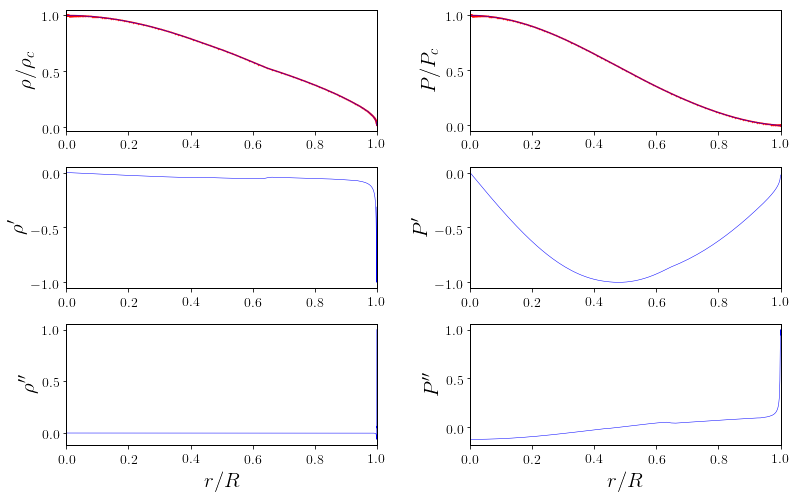

In [263]:
fig=plt.figure(figsize=[12.8,8])

plt.subplot(321)
plt.plot(h4_150[-1]/h4_150[-1][-1],h4_150[2]/h4_150[2][0],color='red',marker='o',markersize='0.4') 
plt.plot(h4_150[-1]/h4_150[-1][-1],h4_150rho(h4_150[-1])/h4_150[2][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1) # leaving the crust out

plt.subplot(322)
plt.plot(h4_150[-1]/h4_150[-1][-1],h4_150[1]/h4_150[1][0],color='red',marker='o',markersize='0.4') 
plt.plot(h4_150[-1]/h4_150[-1][-1],h4_150p(h4_150[-1])/h4_150[1][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$P/P_c$')
plt.xlim(0,1)

plt.subplot(323)
plt.plot(h4_150[-1]/h4_150[-1][-1],h4_150drho(h4_150[-1])/max(abs(h4_150drho(h4_150[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime}$')
plt.xlim(0,1)
#plt.ylim(-500,0)

plt.subplot(324)
plt.plot(h4_150[-1]/h4_150[-1][-1],h4_150dp(h4_150[-1])/max(abs(h4_150dp(h4_150[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime} $')
plt.xlim(0,1)

plt.subplot(325)
plt.plot(h4_150[-1]/h4_150[-1][-1],h4_150ddrho(h4_150[-1])/max(abs(h4_150ddrho(h4_150[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}$')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-0.01,0.01)

plt.subplot(326)
plt.plot(h4_150[-1]/h4_150[-1][-1],h4_150ddp(h4_150[-1])/max(abs(h4_150ddp(h4_150[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime\prime}$ ')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-1,1)

fig.subplots_adjust(hspace=0.3,wspace=0.3)

#plt.savefig('figures/ddsh4_150.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

### 14.45

In [264]:
h4_1445=np.loadtxt('results/h4/15.4550957615.dat',unpack=True)
h4_1445[3] = h4_1445[3]-h4_1445[3][-1] + 0.5*np.log(1-2*h4_1445[0][-1]/h4_1445[-1][-1])

In [269]:
s1=1e-8
s2=1e-9
h4_1445rho=interpolate.UnivariateSpline(h4_1445[-1], h4_1445[2], k=5, s=s1)
h4_1445drho=interpolate.UnivariateSpline(h4_1445[-1], h4_1445[2], k=5, s=s1).derivative(n=1)
h4_1445ddrho=interpolate.UnivariateSpline(h4_1445[-1], h4_1445[2], k=5, s=s1).derivative(n=2)

h4_1445p=interpolate.UnivariateSpline(h4_1445[-1], h4_1445[1], k=5, s=s2)
h4_1445dp=interpolate.UnivariateSpline(h4_1445[-1], h4_1445[1], k=5, s=s2).derivative(n=1)
h4_1445ddp=interpolate.UnivariateSpline(h4_1445[-1], h4_1445[1], k=5, s=s2).derivative(n=2)

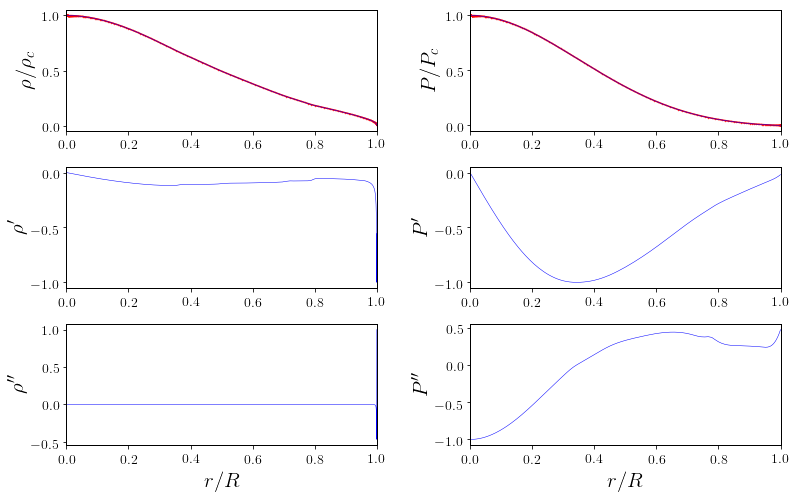

In [248]:
fig=plt.figure(figsize=[12.8,8])

plt.subplot(321)
plt.plot(h4_1445[-1]/h4_1445[-1][-1],h4_1445[2]/h4_1445[2][0],color='red',marker='o',markersize='0.4') 
plt.plot(h4_1445[-1]/h4_1445[-1][-1],h4_1445rho(h4_1445[-1])/h4_1445[2][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1) # leaving the crust out

plt.subplot(322)
plt.plot(h4_1445[-1]/h4_1445[-1][-1],h4_1445[1]/h4_1445[1][0],color='red',marker='o',markersize='0.4') 
plt.plot(h4_1445[-1]/h4_1445[-1][-1],h4_1445p(h4_1445[-1])/h4_1445[1][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$P/P_c$')
plt.xlim(0,1)

plt.subplot(323)
plt.plot(h4_1445[-1]/h4_1445[-1][-1],h4_1445drho(h4_1445[-1])/max(abs(h4_1445drho(h4_1445[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime}$')
plt.xlim(0,1)
#plt.ylim(-500,0)

plt.subplot(324)
plt.plot(h4_1445[-1]/h4_1445[-1][-1],h4_1445dp(h4_1445[-1])/max(abs(h4_1445dp(h4_1445[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime} $')
plt.xlim(0,1)

plt.subplot(325)
plt.plot(h4_1445[-1]/h4_1445[-1][-1],h4_1445ddrho(h4_1445[-1])/max(abs(h4_1445ddrho(h4_1445[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}$')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-0.01,0.01)

plt.subplot(326)
plt.plot(h4_1445[-1]/h4_1445[-1][-1],h4_1445ddp(h4_1445[-1])/max(abs(h4_1445ddp(h4_1445[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime\prime}$ ')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-1,1)

fig.subplots_adjust(hspace=0.3,wspace=0.3)

#plt.savefig('figures/ddsh4_1445.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

## Redshift

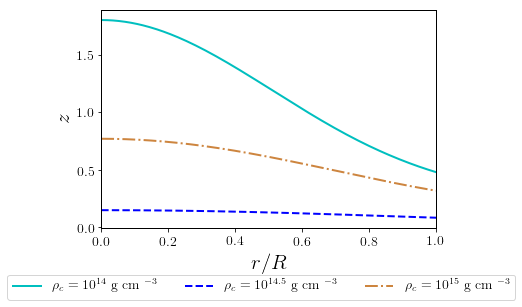

In [272]:
fig = plt.figure()

plt.plot(h4_1445[-1]/h4_1445[-1][-1],np.exp(-h4_1445[3])-1.0,color='c',linewidth='2.0',label=r'$\rho_c=10^{14}$ g cm $^{-3}$')
plt.plot(h4_145[-1]/h4_145[-1][-1],np.exp(-h4_145[3])-1.0,color='blue',linewidth='2.0',linestyle='--',label=r'$\rho_c=10^{14.5}$ g cm $^{-3}$')
plt.plot(h4_150[-1]/h4_150[-1][-1],np.exp(-h4_150[3])-1.0,color='peru',linewidth='2.0',linestyle='-.',label=r'$\rho_c=10^{15}$ g cm $^{-3}$')

l = plt.legend(bbox_to_anchor=(1.1,-0.15), loc="lower right", 
                bbox_transform=fig.transFigure, ncol=3)

plt.xlabel(r'$r/R$')
plt.ylabel(r'$z$')
plt.xlim(0,1.0)

plt.savefig('figures/Redshifth4.pdf', format='pdf', dpi=1000,bbox_inches="tight")

## Adiabatic convection

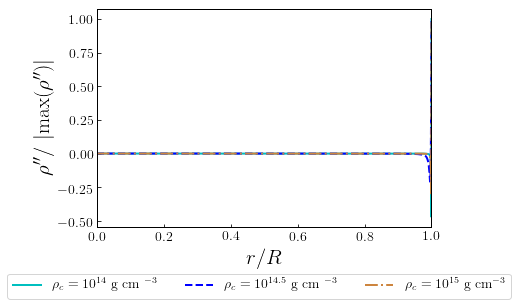

In [273]:
fig, ax = plt.subplots()

plt.plot(h4_1445[-1]/h4_1445[-1][-1],h4_1445ddrho(h4_1445[-1])/max(abs(h4_1445ddrho(h4_1445[-1]))),color='c',linewidth='2.0',label=r'$\rho_c=10^{14}$ g cm $^{-3}$') 
plt.plot(h4_145[-1]/h4_145[-1][-1],h4_145ddrho(h4_145[-1])/max(abs(h4_145ddrho(h4_145[-1]))),color='blue',linewidth='2.0',linestyle='--',label=r'$\rho_c=10^{14.5}$ g cm $^{-3}$') 
plt.plot(h4_150[-1]/h4_150[-1][-1],h4_150ddrho(h4_150[-1])/max(abs(h4_150ddrho(h4_150[-1]))),color='peru',linewidth='2.0',linestyle='-.',label=r'$\rho_c=10^{15}$ g cm$ ^{-3}$')

#plt.plot(h4_155[-1]/h4_155[-1][-1],h4_155drho(h4_155[-1])/max(abs(h4_155drho(h4_140[-1]))),color='yellow',linewidth='2.0',linestyle='-.',label=r'$\rho_c=10^{15.5}$ g cm$ ^{-3}$')

l = plt.legend(bbox_to_anchor=(1.1,-0.15), loc="lower right", 
                bbox_transform=fig.transFigure, ncol=3)

ax.tick_params(axis="x", direction="in")
ax.tick_params(axis="y", direction="in")

plt.xlabel(r'$r/R$')
plt.ylabel(r'$\rho^{\prime \prime}/$ $|$max$(\rho^{\prime \prime})|$')
plt.xlim(0,1.0)

plt.savefig('figures/ConvecStabilityh4.pdf', format='pdf', dpi=1000,bbox_inches="tight")


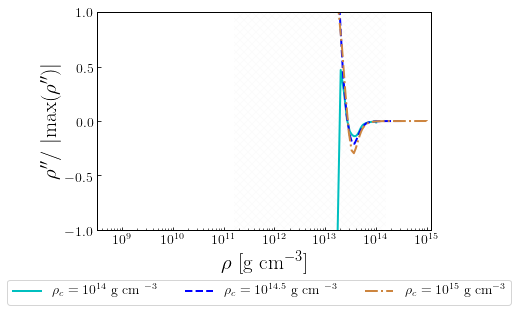

In [274]:
fig, ax = plt.subplots()

ax.set_xscale("log")

plt.plot(h4_140[2]*rhodim,h4_140ddrho(h4_140[-1])/max(abs(h4_140ddrho(h4_140[-1]))),color='c',linewidth='2.0',label=r'$\rho_c=10^{14}$ g cm $^{-3}$') 
plt.plot(h4_145[2]*rhodim,h4_145ddrho(h4_145[-1])/max(abs(h4_145ddrho(h4_145[-1]))),color='blue',linewidth='2.0',linestyle='--',label=r'$\rho_c=10^{14.5}$ g cm $^{-3}$') 
plt.plot(h4_150[2]*rhodim,h4_150ddrho(h4_150[-1])/max(abs(h4_150ddrho(h4_150[-1]))),color='peru',linewidth='2.0',linestyle='-.',label=r'$\rho_c=10^{15}$ g cm$ ^{-3}$')
plt.xlim(left=10**(8.5))
#plt.plot(h4_155[-1]/h4_155[-1][-1],h4_155drho(h4_155[-1])/max(abs(h4_155drho(h4_140[-1]))),color='yellow',linewidth='2.0',linestyle='-.',label=r'$\rho_c=10^{15.5}$ g cm$ ^{-3}$')

x = (10**(11.2),10**(14.2))
y1 = (1,1)
y2 = (-1,-1)

#plt.plot(x1,y,color='black')
#plt.plot(x2,y,color='black')
mpl.rcParams['hatch.linewidth'] = 0.05
plt.fill_between(x, y1,y2,facecolor='none', hatch="xxx", edgecolor="lightgray", linewidth=0.0)

l = plt.legend(bbox_to_anchor=(1.1,-0.16), loc="lower right", 
                bbox_transform=fig.transFigure, ncol=3)
ax.tick_params(axis="x", direction="in",which='both')
ax.tick_params(axis="y", direction="in")

plt.xlabel(r'$\rho$ [g cm$^{-3}$]')
plt.ylabel(r'$\rho^{\prime \prime}/$ $|$max$(\rho^{\prime \prime})|$')
plt.ylim(-1,1.0)

plt.savefig('figures/ConvecStabilityh4Correl.pdf', format='pdf', dpi=1000,bbox_inches="tight")

# H5 --------------------------------------------------------------------------------------------

In [277]:
rhoH5,PH5,nH5=np.loadtxt('EOS/h5.dat',usecols=(2,1,0),unpack=True)

## Dominant energy condition

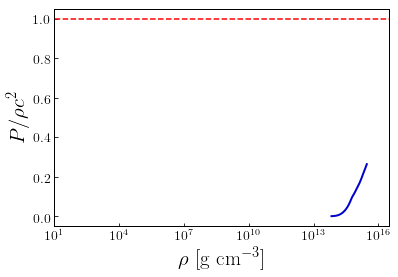

<Figure size 432x288 with 0 Axes>

In [278]:
fig, ax = plt.subplots()
plt.plot(rhoH5,np.divide(PH5,rhoH5),lw='2',color='mediumblue')
plt.plot([0,10**(17)],[1.0,1.0],'r--',lw='1.5')

ax.set_xscale("log")
#locmaj = matplotlib.ticker.LogLocator(base=10.0,numticks=16) 
#ax.xaxis.set_major_locator(locmaj)


plt.xlabel(r'$\rho$ [g\,\,cm$^{-3}$]')
plt.ylabel(r'$ P / \rho c^2 $')
#locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks=16)
#ax.xaxis.set_minor_locator(locmin)
#ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.tick_params(axis="x", direction="in")
ax.tick_params(axis="y", direction="in")
plt.xlim(10,10**(16.5))
#ax.set_facecolor('floralwhite')
#plt.gca().set_aspect('equal', adjustable='box')
#plt.draw()
#plt.ylim(0,1)
plt.savefig('figures/ECH5.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()
plt.clf()

## Speed of sound

In [279]:
vsquared=interpolate.UnivariateSpline(rhoH5, PH5, k=1, s=0).derivative(n=1)

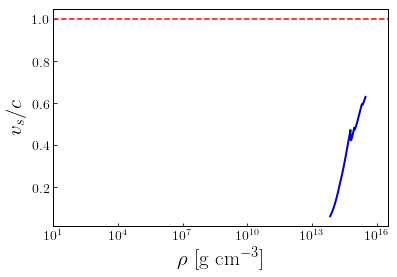

In [280]:
fig, ax = plt.subplots()
plt.plot(rhoH5,np.sqrt(vsquared(rhoH5)),lw='2.0',color='mediumblue')
plt.plot([1e+1,10**(16.5)],[1.0,1.0],'r--',lw='1.5')
plt.xlabel(r'$\rho$ [g\,\,cm$^{-3}$]')
plt.ylabel(r'$ v_s / c $')
plt.xscale('log')
ax.tick_params(axis="x", direction="in")
ax.tick_params(axis="y", direction="in")
plt.xlim(10,10**(16.5))
#ax.set_facecolor('floralwhite')
#mpl.rcParams['axes.linewidth'] = 1.4
#plt.gca().set_aspect('equal', adjustable='box')
#plt.draw()
plt.savefig('figures/SSH5.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

## Adiabatic Index

In [36]:
Gamma=np.multiply(np.divide(np.add(rhoH5,PH5),PH5),vsquared(rhoH5))

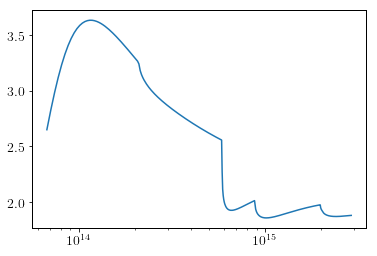

In [37]:
plt.plot(rhoH5,Gamma)
plt.xscale('log')

$$ \langle\gamma\rangle=\frac{\int_{0}^{R} e^{(\lambda+3 \nu) } \gamma(r) P(r) r^{2} d r}{\int_{0}^{R} e^{(\lambda+3 \nu) } P(r) r^{2} d r} $$

Listing all the models calculated

In [38]:
owd=os.getcwd()
path=os.chdir('results/h5')
listOfEntries= os.scandir(path)
models_H5 = []
for entry in listOfEntries:
    if '1' in entry.name:
        models_H5.append(entry.name)
os.chdir(owd)
models_H5.sort()

FileNotFoundError: [Errno 2] No such file or directory: 'results/H5'

In [40]:
gamma_efs1 = []
gamma_efs2 = []
gamma_crs1 = []
gamma_crs2 = []
rhosc= []
for model in models_H5:
    m, P, rho, nu, lambd, r = np.loadtxt('results/h5/' + model ,unpack=True)
    nu = nu - nu[-1] + 0.5*np.log(1-2*m[-1]/r[-1])
    #lambd = np.zeros_like(r)
    #for i in range((r.shape)[0]):
    #    if i==0:
    #        lambd[i] = 0
    #    else:
    #        lambd[i] = 0.5*np.log(1/(1-2*m[i]/r[i]))
    drho=interpolate.UnivariateSpline(r, rho, k=5, s=0).derivative(n=1)
    dP=interpolate.UnivariateSpline(r, P, k=5, s=0).derivative(n=1)
    gamma = np.divide(dP(r),drho(r))
    gamma_ef1 = integrate.trapz(np.exp(lambd+3*nu)*gamma*P*(r**2),r)/integrate.trapz(np.exp(lambd+3*nu)*P*(r**2),r)
    t1 = (1/36)*integrate.trapz(np.exp((lambd+3*nu))*(16*P+(np.exp(2*lambd)-1)*(P+rho))*(np.exp(2*lambd)-1)*(r**2))/integrate.trapz(np.exp(lambd+3*nu)*P*(r**2),r)
    t2 = (4*np.pi/9)*integrate.trapz(np.exp(3*lambd+3*nu)*(8*P + (np.exp(2*lambd)+1)*(P+rho))*P*(r**4),r)/integrate.trapz(np.exp(lambd+3*nu)*P*(r**2),r)
    t3 = ((16*np.pi**2)/9)*integrate.trapz(np.exp(5*lambd+3*nu)*(P+rho)*(P**2)*(r**6),r)/integrate.trapz(np.exp(lambd+3*nu)*P*(r**2),r)
    gamma_cr1 = 4/3 + t1 + t2 + t3
    gamma_efs1.append(gamma_ef1)
    gamma_crs1.append(gamma_cr1)
    gamma_ef2 = integrate.trapz(gamma*P*r**2,r)/integrate.trapz(P*r**2,r)
    gamma_cr2 = 4/3 + (19/42)*2*m[-1]/r[-1]
    gamma_efs2.append(gamma_ef2)
    gamma_crs2.append(gamma_cr2)
    rhosc.append(rho[0]*rhodim)

NameError: name 'models_H5' is not defined

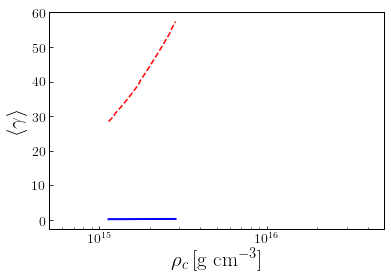

In [58]:
fig, ax = plt.subplots()
plt.plot(rhosc,gamma_crs1,lw='1.5',color='r',linestyle='--',label=r'$\gamma_{cr}$')
plt.plot(rhosc,gamma_efs1,lw='2.0',color='blue',label=r'$\langle \gamma \rangle$')

plt.xlabel(r'$\rho_c\,[$g cm$^{-3}]$')
plt.ylabel(r'$\langle \gamma \rangle$')

plt.xscale('log')
plt.xlim(left=10**(14.7),right=10**(16.7))
#plt.ylim(0,10)
ax.tick_params(axis="x", direction="in",which='both')
ax.tick_params(axis="y", direction="in",which='both')
#l = plt.legend(bbox_to_anchor=(0.85,-0.15), loc="lower right", 
                #bbox_transform=fig.transFigure, ncol=2)



plt.savefig('figures/AdiabaticIndexH5.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

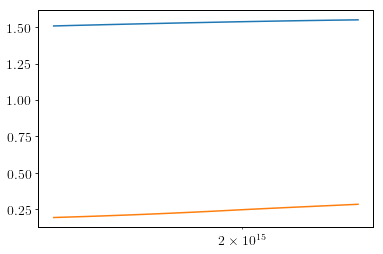

In [59]:
plt.plot(rhosc,gamma_crs2)
plt.plot(rhosc,gamma_efs2)
plt.xscale('log')

## M - $\rho_c$

In [281]:
RH5,MH5,rhocH5=np.loadtxt('results/h5/MRrhoc.dat',usecols=(0,1,2),unpack=True)

In [282]:
np.amax(MH5)

1.72624139987

In [283]:
rhocH5[np.argmax(MH5)]

2285899935650000.0

In [284]:
np.log10(rhocH5[np.argmax(MH5)])

15.359057215409136

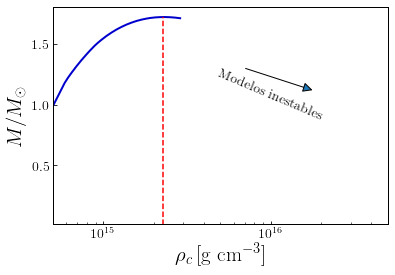

In [285]:
fig, ax = plt.subplots()

plt.plot(rhocH5,MH5,color='mediumblue',lw='2.0')
plt.plot([10**(np.log10(rhocH5[np.argmax(MH5)])),10**(np.log10(rhocH5[np.argmax(MH5)]))],[0.0,np.amax(MH5)],'r--',lw='1.5')

prop = dict(arrowstyle="-|>,head_width=0.4,head_length=0.8",
            shrinkA=0,shrinkB=0)
plt.annotate("", xy=(10**(16.25),1.12), xytext=(10**(15.85),1.3), arrowprops=prop)
#plt.arrow(10**(15.6), 1.38,10**(15.7) ,-0.1 , head_width=0.05, head_lH5th=10**(15))
plt.text(10**(15.67), 1.23, 'Modelos inestables' , fontsize=14,rotation=-23)

plt.xscale('log')
plt.xlabel(r'$\rho_c\,[$g cm$^{-3}]$')
plt.ylabel(r'$M/M_{\odot}$')
plt.xlim(left=10**(14.7),right=10**(16.7))
plt.ylim(bottom=0.01)
ax.tick_params(axis="x", direction="in",which='both')
ax.tick_params(axis="y", direction="in",which='both')

plt.savefig('figures/Mrhorel_H5.pdf', format='pdf', dpi=1000,bbox_inches="tight")

## Tunning the interpolation of the solution

### 14.0

In [286]:
H5_1403=np.loadtxt('results/h5/14.0390572154.dat',unpack=True)
H5_1403[3] = H5_1403[3]-H5_1403[3][-1] + 0.5*np.log(1-2*H5_1403[0][-1]/H5_1403[-1][-1])

In [287]:
s1=1e-6
s2=1e-15
H5_1403rho=interpolate.UnivariateSpline(H5_1403[-1], H5_1403[2], k=5, s=s1)
H5_1403drho=interpolate.UnivariateSpline(H5_1403[-1], H5_1403[2], k=5, s=s1).derivative(n=1)
H5_1403ddrho=interpolate.UnivariateSpline(H5_1403[-1], H5_1403[2], k=5, s=s1).derivative(n=2)

H5_1403p=interpolate.UnivariateSpline(H5_1403[-1], H5_1403[1], k=5, s=s2)
H5_1403dp=interpolate.UnivariateSpline(H5_1403[-1], H5_1403[1], k=5, s=s2).derivative(n=1)
H5_1403ddp=interpolate.UnivariateSpline(H5_1403[-1], H5_1403[1], k=5, s=s2).derivative(n=2)

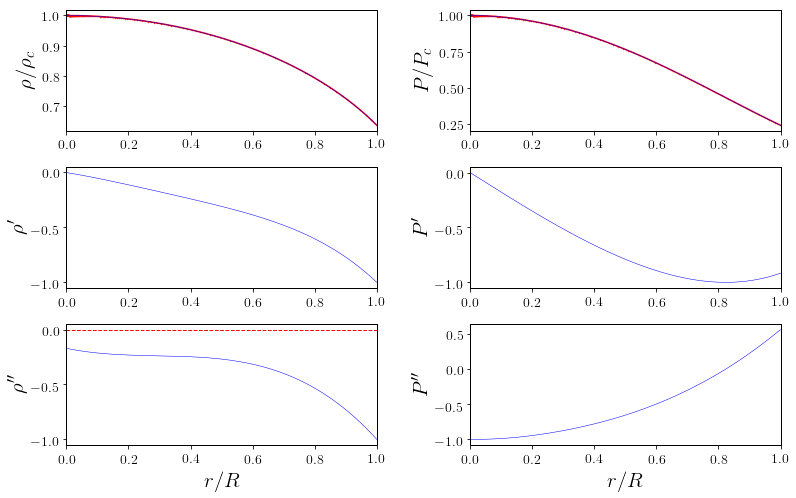

In [288]:
fig=plt.figure(figsize=[12.8,8])

plt.subplot(321)
plt.plot(H5_1403[-1]/H5_1403[-1][-1],H5_1403[2]/H5_1403[2][0],color='red',marker='o',markersize='0.4') 
plt.plot(H5_1403[-1]/H5_1403[-1][-1],H5_1403rho(H5_1403[-1])/H5_1403[2][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1) # leaving the crust out

plt.subplot(322)
plt.plot(H5_1403[-1]/H5_1403[-1][-1],H5_1403[1]/H5_1403[1][0],color='red',marker='o',markersize='0.4') 
plt.plot(H5_1403[-1]/H5_1403[-1][-1],H5_1403p(H5_1403[-1])/H5_1403[1][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$P/P_c$')
plt.xlim(0,1)

plt.subplot(323)
plt.plot(H5_1403[-1]/H5_1403[-1][-1],H5_1403drho(H5_1403[-1])/max(abs(H5_1403drho(H5_1403[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime}$')
plt.xlim(0,1)
#plt.ylim(-500,0)

plt.subplot(324)
plt.plot(H5_1403[-1]/H5_1403[-1][-1],H5_1403dp(H5_1403[-1])/max(abs(H5_1403dp(H5_1403[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime} $')
plt.xlim(0,1)

plt.subplot(325)
plt.plot([0,1],[0.0,0.0],'r--',lw='1.0')
plt.plot(H5_1403[-1]/H5_1403[-1][-1],H5_1403ddrho(H5_1403[-1])/max(abs(H5_1403ddrho(H5_1403[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}$')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-0.01,0.01)

plt.subplot(326)
plt.plot(H5_1403[-1]/H5_1403[-1][-1],H5_1403ddp(H5_1403[-1])/max(abs(H5_1403ddp(H5_1403[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime\prime}$ ')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-1,1)

fig.subplots_adjust(hspace=0.3,wspace=0.3)

#plt.savefig('figures/ddsH5_1403.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

### 14.5

In [289]:
H5_1520=np.loadtxt('results/h5/15.2090572154.dat',unpack=True)
H5_1520[3] = H5_1520[3]-H5_1520[3][-1] + 0.5*np.log(1-2*H5_1520[0][-1]/H5_1520[-1][-1])

In [290]:
s1=0
s2=1e-10
H5_1520rho=interpolate.UnivariateSpline(H5_1520[-1], H5_1520[2], k=5, s=s1)
H5_1520drho=interpolate.UnivariateSpline(H5_1520[-1], H5_1520[2], k=5, s=s1).derivative(n=1)
H5_1520ddrho=interpolate.UnivariateSpline(H5_1520[-1], H5_1520[2], k=5, s=s1).derivative(n=2)

H5_1520p=interpolate.UnivariateSpline(H5_1520[-1], H5_1520[1], k=5, s=s2)
H5_1520dp=interpolate.UnivariateSpline(H5_1520[-1], H5_1520[1], k=5, s=s2).derivative(n=1)
H5_1520ddp=interpolate.UnivariateSpline(H5_1520[-1], H5_1520[1], k=5, s=s2).derivative(n=2)

In [291]:
H5_1520rho(0.4*H5_1520[-1][-1])*rhodim

1154887598934911.0

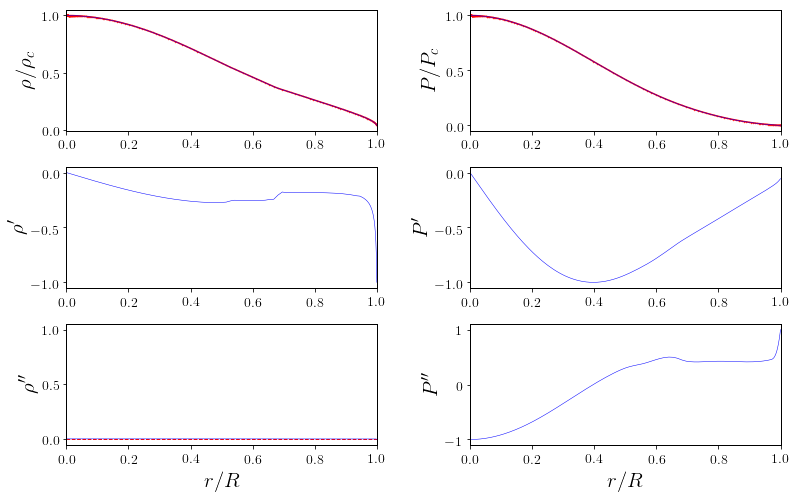

In [292]:
fig=plt.figure(figsize=[12.8,8])

plt.subplot(321)
plt.plot(H5_1520[-1]/H5_1520[-1][-1],H5_1520[2]/H5_1520[2][0],color='red',marker='o',markersize='0.4') 
plt.plot(H5_1520[-1]/H5_1520[-1][-1],H5_1520rho(H5_1520[-1])/H5_1520[2][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1) # leaving the crust out

plt.subplot(322)
plt.plot(H5_1520[-1]/H5_1520[-1][-1],H5_1520[1]/H5_1520[1][0],color='red',marker='o',markersize='0.4') 
plt.plot(H5_1520[-1]/H5_1520[-1][-1],H5_1520p(H5_1520[-1])/H5_1520[1][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$P/P_c$')
plt.xlim(0,1)

plt.subplot(323)
plt.plot(H5_1520[-1]/H5_1520[-1][-1],H5_1520drho(H5_1520[-1])/max(abs(H5_1520drho(H5_1520[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime}$')
plt.xlim(0,1)
#plt.ylim(-500,0)

plt.subplot(324)
plt.plot(H5_1520[-1]/H5_1520[-1][-1],H5_1520dp(H5_1520[-1])/max(abs(H5_1520dp(H5_1520[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime} $')
plt.xlim(0,1)

plt.subplot(325)
plt.plot([0,1],[0.0,0.0],'r--',lw='1.0')
plt.plot(H5_1520[-1]/H5_1520[-1][-1],H5_1520ddrho(H5_1520[-1])/max(abs(H5_1520ddrho(H5_1520[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}$')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-0.01,0.01)

plt.subplot(326)
plt.plot(H5_1520[-1]/H5_1520[-1][-1],H5_1520ddp(H5_1520[-1])/max(abs(H5_1520ddp(H5_1520[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime\prime}$ ')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-1,1)

fig.subplots_adjust(hspace=0.3,wspace=0.3)

#plt.savefig('figures/ddsH5_1520.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

### 15.0

In [293]:
H5_1530=np.loadtxt('results/h5/15.3090572154.dat',unpack=True)
H5_1530[3] = H5_1530[3]-H5_1530[3][-1] + 0.5*np.log(1-2*H5_1530[0][-1]/H5_1530[-1][-1])

In [294]:
s1=0
s2=1e-15
H5_1530rho=interpolate.UnivariateSpline(H5_1530[-1], H5_1530[2], k=5, s=s1)
H5_1530drho=interpolate.UnivariateSpline(H5_1530[-1], H5_1530[2], k=5, s=s1).derivative(n=1)
H5_1530ddrho=interpolate.UnivariateSpline(H5_1530[-1], H5_1530[2], k=5, s=s1).derivative(n=2)

H5_1530p=interpolate.UnivariateSpline(H5_1530[-1], H5_1530[1], k=5, s=s2)
H5_1530dp=interpolate.UnivariateSpline(H5_1530[-1], H5_1530[1], k=5, s=s2).derivative(n=1)
H5_1530ddp=interpolate.UnivariateSpline(H5_1530[-1], H5_1530[1], k=5, s=s2).derivative(n=2)

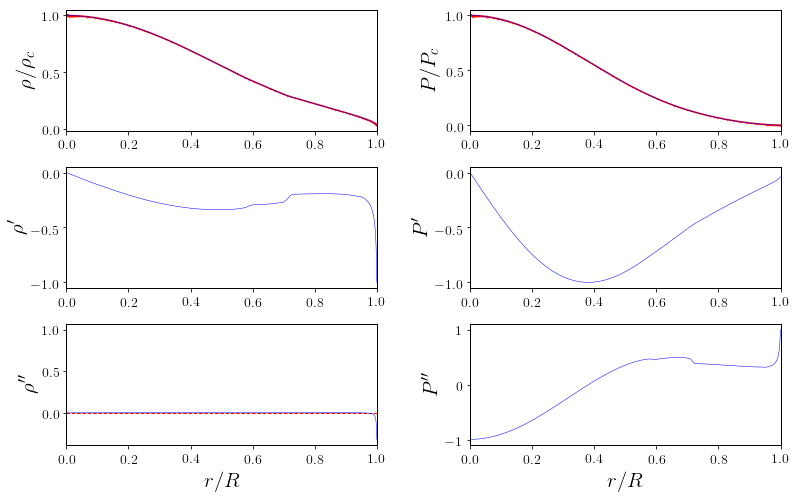

In [295]:
fig=plt.figure(figsize=[12.8,8])

plt.subplot(321)
plt.plot(H5_1530[-1]/H5_1530[-1][-1],H5_1530[2]/H5_1530[2][0],color='red',marker='o',markersize='0.4') 
plt.plot(H5_1530[-1]/H5_1530[-1][-1],H5_1530rho(H5_1530[-1])/H5_1530[2][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1) # leaving the crust out

plt.subplot(322)
plt.plot(H5_1530[-1]/H5_1530[-1][-1],H5_1530[1]/H5_1530[1][0],color='red',marker='o',markersize='0.4') 
plt.plot(H5_1530[-1]/H5_1530[-1][-1],H5_1530p(H5_1530[-1])/H5_1530[1][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$P/P_c$')
plt.xlim(0,1)

plt.subplot(323)
plt.plot(H5_1530[-1]/H5_1530[-1][-1],H5_1530drho(H5_1530[-1])/max(abs(H5_1530drho(H5_1530[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime}$')
plt.xlim(0,1)
#plt.ylim(-500,0)

plt.subplot(324)
plt.plot(H5_1530[-1]/H5_1530[-1][-1],H5_1530dp(H5_1530[-1])/max(abs(H5_1530dp(H5_1530[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime} $')
plt.xlim(0,1)

plt.subplot(325)
plt.plot([0,1],[0.0,0.0],'r--',lw='1.0')
plt.plot(H5_1530[-1]/H5_1530[-1][-1],H5_1530ddrho(H5_1530[-1])/max(abs(H5_1530ddrho(H5_1530[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}$')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-0.01,0.01)

plt.subplot(326)
plt.plot(H5_1530[-1]/H5_1530[-1][-1],H5_1530ddp(H5_1530[-1])/max(abs(H5_1530ddp(H5_1530[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime\prime}$ ')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-1,1)

fig.subplots_adjust(hspace=0.3,wspace=0.3)

#plt.savefig('figures/ddsH5_1530.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

### 15.5

In [296]:
H5_1540=np.loadtxt('results/h5/15.4090572154.dat',unpack=True)
H5_1540[3] = H5_1540[3]-H5_1540[3][-1] + 0.5*np.log(1-2*H5_1540[0][-1]/H5_1540[-1][-1])

In [297]:
s1=1e-7
s2=1e-9
H5_1540rho=interpolate.UnivariateSpline(H5_1540[-1], H5_1540[2], k=5, s=s1)
H5_1540drho=interpolate.UnivariateSpline(H5_1540[-1], H5_1540[2], k=5, s=s1).derivative(n=1)
H5_1540ddrho=interpolate.UnivariateSpline(H5_1540[-1], H5_1540[2], k=5, s=s1).derivative(n=2)

H5_1540p=interpolate.UnivariateSpline(H5_1540[-1], H5_1540[1], k=5, s=s2)
H5_1540dp=interpolate.UnivariateSpline(H5_1540[-1], H5_1540[1], k=5, s=s2).derivative(n=1)
H5_1540ddp=interpolate.UnivariateSpline(H5_1540[-1], H5_1540[1], k=5, s=s2).derivative(n=2)

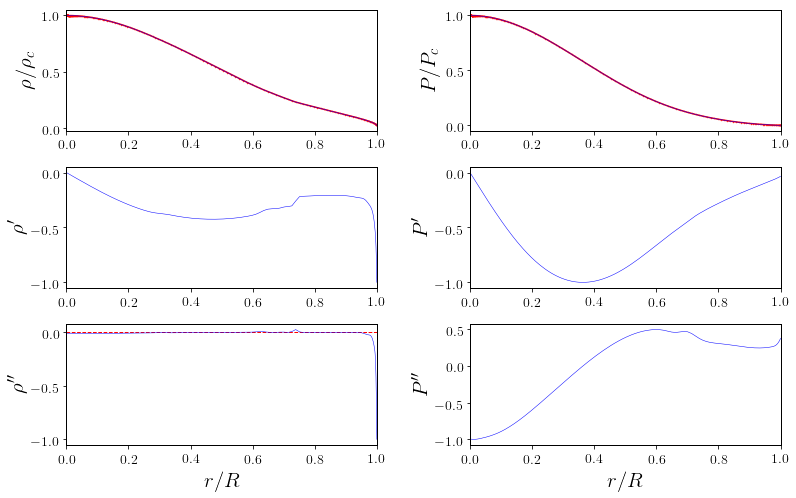

In [298]:
fig=plt.figure(figsize=[12.8,8])

plt.subplot(321)
plt.plot(H5_1540[-1]/H5_1540[-1][-1],H5_1540[2]/H5_1540[2][0],color='red',marker='o',markersize='0.4') 
plt.plot(H5_1540[-1]/H5_1540[-1][-1],H5_1540rho(H5_1540[-1])/H5_1540[2][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1) # leaving the crust out

plt.subplot(322)
plt.plot(H5_1540[-1]/H5_1540[-1][-1],H5_1540[1]/H5_1540[1][0],color='red',marker='o',markersize='0.4') 
plt.plot(H5_1540[-1]/H5_1540[-1][-1],H5_1540p(H5_1540[-1])/H5_1540[1][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$P/P_c$')
plt.xlim(0,1)

plt.subplot(323)
plt.plot(H5_1540[-1]/H5_1540[-1][-1],H5_1540drho(H5_1540[-1])/max(abs(H5_1540drho(H5_1540[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime}$')
plt.xlim(0,1)
#plt.ylim(-500,0)

plt.subplot(324)
plt.plot(H5_1540[-1]/H5_1540[-1][-1],H5_1540dp(H5_1540[-1])/max(abs(H5_1540dp(H5_1540[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime} $')
plt.xlim(0,1)

plt.subplot(325)
plt.plot([0,1],[0.0,0.0],'r--',lw='1.0')
plt.plot(H5_1540[-1]/H5_1540[-1][-1],H5_1540ddrho(H5_1540[-1])/max(abs(H5_1540ddrho(H5_1540[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}$')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-0.01,0.01)

plt.subplot(326)
plt.plot(H5_1540[-1]/H5_1540[-1][-1],H5_1540ddp(H5_1540[-1])/max(abs(H5_1540ddp(H5_1540[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime\prime}$ ')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-1,1)

fig.subplots_adjust(hspace=0.3,wspace=0.3)

#plt.savefig('figures/ddsH5_1540.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

## Redshift

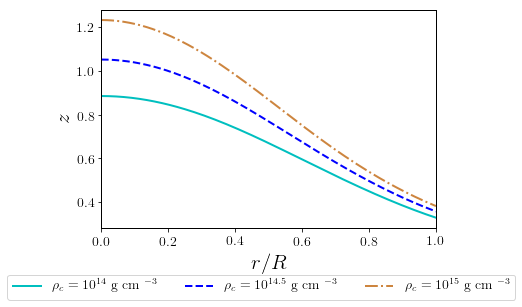

In [301]:
fig = plt.figure()

plt.plot(H5_1520[-1]/H5_1520[-1][-1],np.exp(-H5_1520[3])-1.0,color='c',linewidth='2.0',label=r'$\rho_c=10^{14}$ g cm $^{-3}$')
plt.plot(H5_1530[-1]/H5_1530[-1][-1],np.exp(-H5_1530[3])-1.0,color='blue',linewidth='2.0',linestyle='--',label=r'$\rho_c=10^{14.5}$ g cm $^{-3}$')
plt.plot(H5_1540[-1]/H5_1540[-1][-1],np.exp(-H5_1540[3])-1.0,color='peru',linewidth='2.0',linestyle='-.',label=r'$\rho_c=10^{15}$ g cm $^{-3}$')

l = plt.legend(bbox_to_anchor=(1.1,-0.15), loc="lower right", 
                bbox_transform=fig.transFigure, ncol=3)

plt.xlabel(r'$r/R$')
plt.ylabel(r'$z$')
plt.xlim(0,1.0)

plt.savefig('figures/RedshiftH5.pdf', format='pdf', dpi=1000,bbox_inches="tight")

# H7 --------------------------------------------------------------------------------------------

In [66]:
rhoh7,Ph7,nh7=np.loadtxt('EOS/h7.dat',usecols=(2,1,0),unpack=True)

## Dominant energy condition

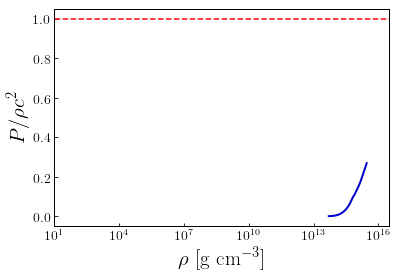

<Figure size 432x288 with 0 Axes>

In [67]:
fig, ax = plt.subplots()
plt.plot(rhoh7,np.divide(Ph7,rhoh7),lw='2',color='mediumblue')
plt.plot([0,10**(17)],[1.0,1.0],'r--',lw='1.5')

ax.set_xscale("log")
#locmaj = matplotlib.ticker.LogLocator(base=10.0,numticks=16) 
#ax.xaxis.set_major_locator(locmaj)


plt.xlabel(r'$\rho$ [g\,\,cm$^{-3}$]')
plt.ylabel(r'$ P / \rho c^2 $')
#locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks=16)
#ax.xaxis.set_minor_locator(locmin)
#ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.tick_params(axis="x", direction="in")
ax.tick_params(axis="y", direction="in")
plt.xlim(10,10**(16.5))
#ax.set_facecolor('floralwhite')
#plt.gca().set_aspect('equal', adjustable='box')
#plt.draw()
#plt.ylim(0,1)
plt.savefig('figures/ECh7.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()
plt.clf()

## Speed of sound

In [70]:
vsquared=interpolate.UnivariateSpline(rhoh7, Ph7, k=3, s=0).derivative(n=1)

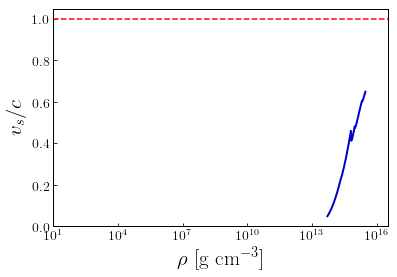

In [71]:
fig, ax = plt.subplots()
plt.plot(rhoh7,np.sqrt(vsquared(rhoh7)),lw='2.0',color='mediumblue')
plt.plot([1e+1,10**(16.5)],[1.0,1.0],'r--',lw='1.5')
plt.xlabel(r'$\rho$ [g\,\,cm$^{-3}$]')
plt.ylabel(r'$ v_s / c $')
plt.xscale('log')
ax.tick_params(axis="x", direction="in")
ax.tick_params(axis="y", direction="in")
plt.xlim(10,10**(16.5))
#ax.set_facecolor('floralwhite')
#mpl.rcParams['axes.linewidth'] = 1.4
#plt.gca().set_aspect('equal', adjustable='box')
#plt.draw()
plt.savefig('figures/SSh7.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

## Adiabatic Index

In [38]:
Gamma=np.multiply(np.divide(np.add(rhoh7,Ph7),Ph7),vsquared(rhoh7))

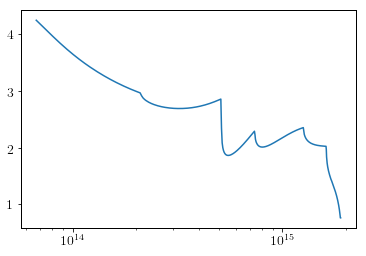

In [39]:
plt.plot(rhoh7,Gamma)
plt.xscale('log')

$$ \langle\gamma\rangle=\frac{\int_{0}^{R} e^{(\lambda+3 \nu) } \gamma(r) P(r) r^{2} d r}{\int_{0}^{R} e^{(\lambda+3 \nu) } P(r) r^{2} d r} $$

Listing all the models calculated

In [40]:
owd=os.getcwd()
path=os.chdir('results/h7')
listOfEntries= os.scandir(path)
models_h7 = []
for entry in listOfEntries:
    if '1' in entry.name:
        models_h7.append(entry.name)
os.chdir(owd)
models_h7.sort()

In [41]:
gamma_efs1 = []
gamma_efs2 = []
gamma_crs1 = []
gamma_crs2 = []
rhosc= []
for model in models_h7:
    m, P, rho, nu, lambd, r = np.loadtxt('results/h7/' + model ,unpack=True)
    nu = nu - nu[-1] + 0.5*np.log(1-2*m[-1]/r[-1])
    #lambd = np.zeros_like(r)
    #for i in range((r.shape)[0]):
    #    if i==0:
    #        lambd[i] = 0
    #    else:
    #        lambd[i] = 0.5*np.log(1/(1-2*m[i]/r[i]))
    drho=interpolate.UnivariateSpline(r, rho, k=5, s=0).derivative(n=1)
    dP=interpolate.UnivariateSpline(r, P, k=5, s=0).derivative(n=1)
    gamma = np.divide(dP(r),drho(r))
    gamma_ef1 = integrate.trapz(np.exp(lambd+3*nu)*gamma*P*(r**2),r)/integrate.trapz(np.exp(lambd+3*nu)*P*(r**2),r)
    t1 = (1/36)*integrate.trapz(np.exp((lambd+3*nu))*(16*P+(np.exp(2*lambd)-1)*(P+rho))*(np.exp(2*lambd)-1)*(r**2))/integrate.trapz(np.exp(lambd+3*nu)*P*(r**2),r)
    t2 = (4*np.pi/9)*integrate.trapz(np.exp(3*lambd+3*nu)*(8*P + (np.exp(2*lambd)+1)*(P+rho))*P*(r**4),r)/integrate.trapz(np.exp(lambd+3*nu)*P*(r**2),r)
    t3 = ((16*np.pi**2)/9)*integrate.trapz(np.exp(5*lambd+3*nu)*(P+rho)*(P**2)*(r**6),r)/integrate.trapz(np.exp(lambd+3*nu)*P*(r**2),r)
    gamma_cr1 = 4/3 + t1 + t2 + t3
    gamma_efs1.append(gamma_ef1)
    gamma_crs1.append(gamma_cr1)
    gamma_ef2 = integrate.trapz(gamma*P*r**2,r)/integrate.trapz(P*r**2,r)
    gamma_cr2 = 4/3 + (19/42)*2*m[-1]/r[-1]
    gamma_efs2.append(gamma_ef2)
    gamma_crs2.append(gamma_cr2)
    rhosc.append(rho[0]*rhodim)

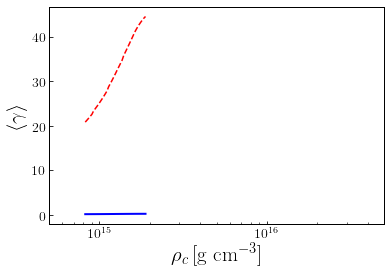

In [42]:
fig, ax = plt.subplots()
plt.plot(rhosc,gamma_crs1,lw='1.5',color='r',linestyle='--',label=r'$\gamma_{cr}$')
plt.plot(rhosc,gamma_efs1,lw='2.0',color='blue',label=r'$\langle \gamma \rangle$')

plt.xlabel(r'$\rho_c\,[$g cm$^{-3}]$')
plt.ylabel(r'$\langle \gamma \rangle$')

plt.xscale('log')
plt.xlim(left=10**(14.7),right=10**(16.7))
#plt.ylim(0,10)
ax.tick_params(axis="x", direction="in",which='both')
ax.tick_params(axis="y", direction="in",which='both')
#l = plt.legend(bbox_to_anchor=(0.85,-0.15), loc="lower right", 
                #bbox_transform=fig.transFigure, ncol=2)



plt.savefig('figures/AdiabaticIndexh7.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

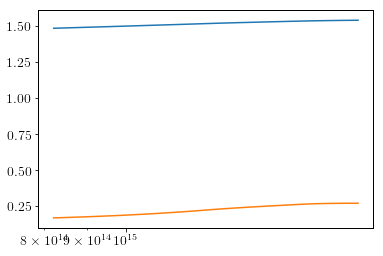

In [43]:
plt.plot(rhosc,gamma_crs2)
plt.plot(rhosc,gamma_efs2)
plt.xscale('log')

## M - $\rho_c$

In [72]:
Rh7,Mh7,rhoch7=np.loadtxt('results/h7/MRrhoc.dat',usecols=(0,1,2),unpack=True)

In [73]:
np.amax(Mh7)

1.6832955348

In [74]:
rhoch7[np.argmax(Mh7)]

2613332973430000.0

In [75]:
np.log10(rhoch7[np.argmax(Mh7)])

15.417194748154555

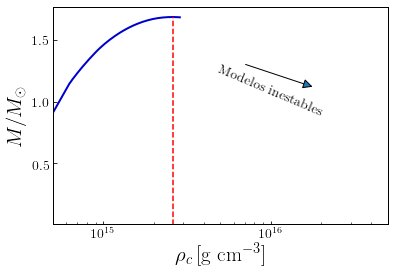

In [76]:
fig, ax = plt.subplots()

plt.plot(rhoch7,Mh7,color='mediumblue',lw='2.0')
plt.plot([10**(np.log10(rhoch7[np.argmax(Mh7)])),10**(np.log10(rhoch7[np.argmax(Mh7)]))],[0.0,np.amax(Mh7)],'r--',lw='1.5')

prop = dict(arrowstyle="-|>,head_width=0.4,head_length=0.8",
            shrinkA=0,shrinkB=0)
plt.annotate("", xy=(10**(16.25),1.12), xytext=(10**(15.85),1.3), arrowprops=prop)
#plt.arrow(10**(15.6), 1.38,10**(15.7) ,-0.1 , head_width=0.05, head_lh7th=10**(15))
plt.text(10**(15.67), 1.23, 'Modelos inestables' , fontsize=14,rotation=-23)

plt.xscale('log')
plt.xlabel(r'$\rho_c\,[$g cm$^{-3}]$')
plt.ylabel(r'$M/M_{\odot}$')
plt.xlim(left=10**(14.7),right=10**(16.7))
plt.ylim(bottom=0.01)
ax.tick_params(axis="x", direction="in",which='both')
ax.tick_params(axis="y", direction="in",which='both')

plt.savefig('figures/Mrhorel_h7.pdf', format='pdf', dpi=1000,bbox_inches="tight")

## Tunning the interpolation of the solution

### 14.0

In [77]:
h7_140=np.loadtxt('results/h7/14.0071947482.dat',unpack=True)
h7_140[3] = h7_140[3]-h7_140[3][-1] + 0.5*np.log(1-2*h7_140[0][-1]/h7_140[-1][-1])

In [78]:
s1=5e-7
s2=1e-15
h7_140rho=interpolate.UnivariateSpline(h7_140[-1], h7_140[2], k=5, s=s1)
h7_140drho=interpolate.UnivariateSpline(h7_140[-1], h7_140[2], k=5, s=s1).derivative(n=1)
h7_140ddrho=interpolate.UnivariateSpline(h7_140[-1], h7_140[2], k=5, s=s1).derivative(n=2)

h7_140p=interpolate.UnivariateSpline(h7_140[-1], h7_140[1], k=5, s=s2)
h7_140dp=interpolate.UnivariateSpline(h7_140[-1], h7_140[1], k=5, s=s2).derivative(n=1)
h7_140ddp=interpolate.UnivariateSpline(h7_140[-1], h7_140[1], k=5, s=s2).derivative(n=2)

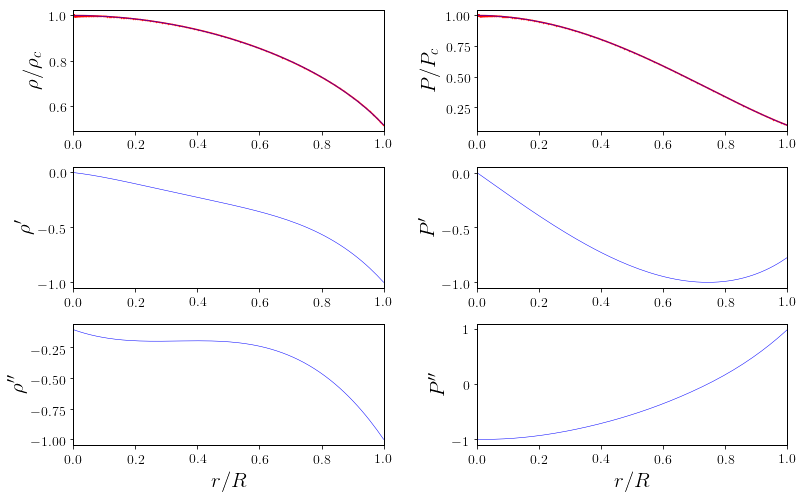

In [79]:
fig=plt.figure(figsize=[12.8,8])

plt.subplot(321)
plt.plot(h7_140[-1]/h7_140[-1][-1],h7_140[2]/h7_140[2][0],color='red',marker='o',markersize='0.4') 
plt.plot(h7_140[-1]/h7_140[-1][-1],h7_140rho(h7_140[-1])/h7_140[2][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1) # leaving the crust out

plt.subplot(322)
plt.plot(h7_140[-1]/h7_140[-1][-1],h7_140[1]/h7_140[1][0],color='red',marker='o',markersize='0.4') 
plt.plot(h7_140[-1]/h7_140[-1][-1],h7_140p(h7_140[-1])/h7_140[1][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$P/P_c$')
plt.xlim(0,1)

plt.subplot(323)
plt.plot(h7_140[-1]/h7_140[-1][-1],h7_140drho(h7_140[-1])/max(abs(h7_140drho(h7_140[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime}$')
plt.xlim(0,1)
#plt.ylim(-500,0)

plt.subplot(324)
plt.plot(h7_140[-1]/h7_140[-1][-1],h7_140dp(h7_140[-1])/max(abs(h7_140dp(h7_140[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime} $')
plt.xlim(0,1)

plt.subplot(325)
plt.plot(h7_140[-1]/h7_140[-1][-1],h7_140ddrho(h7_140[-1])/max(abs(h7_140ddrho(h7_140[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}$')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-0.01,0.01)

plt.subplot(326)
plt.plot(h7_140[-1]/h7_140[-1][-1],h7_140ddp(h7_140[-1])/max(abs(h7_140ddp(h7_140[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime\prime}$ ')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-1,1)

fig.subplots_adjust(hspace=0.3,wspace=0.3)

#plt.savefig('figures/ddsh7_140.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

### 14.5

In [80]:
h7_145=np.loadtxt('results/h7/14.5071947482.dat',unpack=True)
h7_145[3] = h7_145[3]-h7_145[3][-1] + 0.5*np.log(1-2*h7_145[0][-1]/h7_145[-1][-1])

In [81]:
s1=1e-7
s2=1e-12
h7_145rho=interpolate.UnivariateSpline(h7_145[-1], h7_145[2], k=5, s=s1)
h7_145drho=interpolate.UnivariateSpline(h7_145[-1], h7_145[2], k=5, s=s1).derivative(n=1)
h7_145ddrho=interpolate.UnivariateSpline(h7_145[-1], h7_145[2], k=5, s=s1).derivative(n=2)

h7_145p=interpolate.UnivariateSpline(h7_145[-1], h7_145[1], k=5, s=s2)
h7_145dp=interpolate.UnivariateSpline(h7_145[-1], h7_145[1], k=5, s=s2).derivative(n=1)
h7_145ddp=interpolate.UnivariateSpline(h7_145[-1], h7_145[1], k=5, s=s2).derivative(n=2)

In [82]:
h7_145rho(0.4*h7_145[-1][-1])*rhodim

282057646728856.06

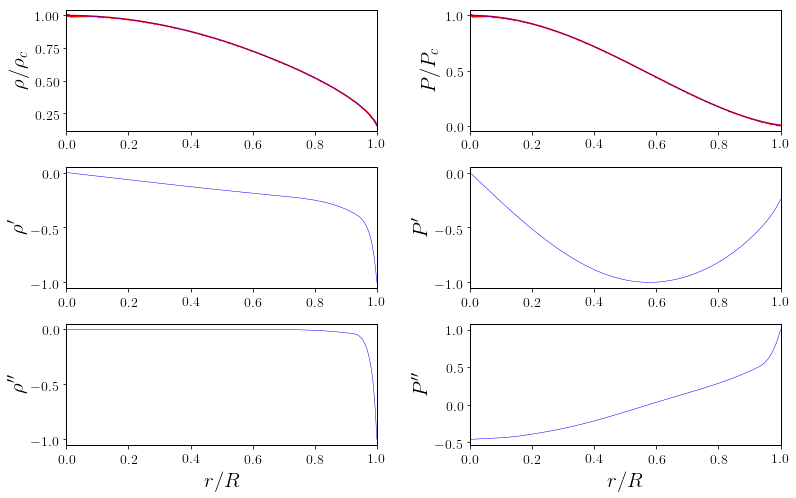

In [83]:
fig=plt.figure(figsize=[12.8,8])

plt.subplot(321)
plt.plot(h7_145[-1]/h7_145[-1][-1],h7_145[2]/h7_145[2][0],color='red',marker='o',markersize='0.4') 
plt.plot(h7_145[-1]/h7_145[-1][-1],h7_145rho(h7_145[-1])/h7_145[2][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1) # leaving the crust out

plt.subplot(322)
plt.plot(h7_145[-1]/h7_145[-1][-1],h7_145[1]/h7_145[1][0],color='red',marker='o',markersize='0.4') 
plt.plot(h7_145[-1]/h7_145[-1][-1],h7_145p(h7_145[-1])/h7_145[1][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$P/P_c$')
plt.xlim(0,1)

plt.subplot(323)
plt.plot(h7_145[-1]/h7_145[-1][-1],h7_145drho(h7_145[-1])/max(abs(h7_145drho(h7_145[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime}$')
plt.xlim(0,1)
#plt.ylim(-500,0)

plt.subplot(324)
plt.plot(h7_145[-1]/h7_145[-1][-1],h7_145dp(h7_145[-1])/max(abs(h7_145dp(h7_145[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime} $')
plt.xlim(0,1)

plt.subplot(325)
plt.plot(h7_145[-1]/h7_145[-1][-1],h7_145ddrho(h7_145[-1])/max(abs(h7_145ddrho(h7_145[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}$')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-0.01,0.01)

plt.subplot(326)
plt.plot(h7_145[-1]/h7_145[-1][-1],h7_145ddp(h7_145[-1])/max(abs(h7_145ddp(h7_145[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime\prime}$ ')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-1,1)

fig.subplots_adjust(hspace=0.3,wspace=0.3)

#plt.savefig('figures/ddsh7_145.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

### 15.0

In [84]:
h7_150=np.loadtxt('results/h7/15.0071947482.dat',unpack=True)
h7_150[3] = h7_150[3]-h7_150[3][-1] + 0.5*np.log(1-2*h7_150[0][-1]/h7_150[-1][-1])

In [85]:
s1=8e-6
s2=1e-15
h7_150rho=interpolate.UnivariateSpline(h7_150[-1], h7_150[2], k=5, s=s1)
h7_150drho=interpolate.UnivariateSpline(h7_150[-1], h7_150[2], k=5, s=s1).derivative(n=1)
h7_150ddrho=interpolate.UnivariateSpline(h7_150[-1], h7_150[2], k=5, s=s1).derivative(n=2)

h7_150p=interpolate.UnivariateSpline(h7_150[-1], h7_150[1], k=5, s=s2)
h7_150dp=interpolate.UnivariateSpline(h7_150[-1], h7_150[1], k=5, s=s2).derivative(n=1)
h7_150ddp=interpolate.UnivariateSpline(h7_150[-1], h7_150[1], k=5, s=s2).derivative(n=2)

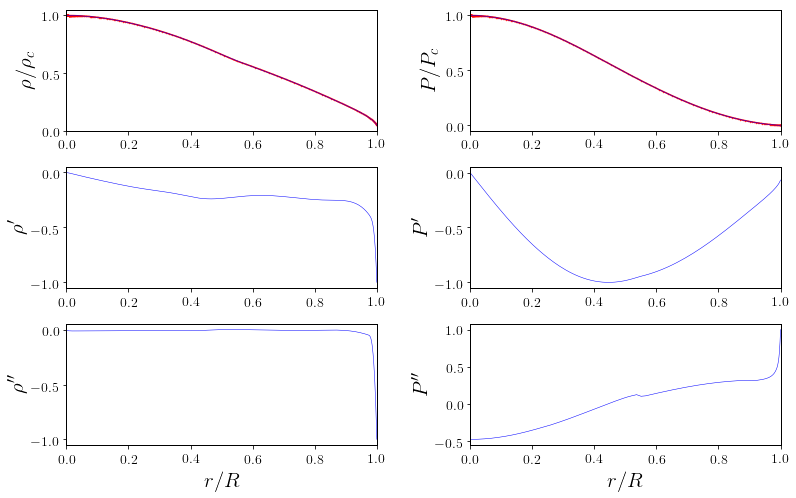

In [86]:
fig=plt.figure(figsize=[12.8,8])

plt.subplot(321)
plt.plot(h7_150[-1]/h7_150[-1][-1],h7_150[2]/h7_150[2][0],color='red',marker='o',markersize='0.4') 
plt.plot(h7_150[-1]/h7_150[-1][-1],h7_150rho(h7_150[-1])/h7_150[2][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1) # leaving the crust out

plt.subplot(322)
plt.plot(h7_150[-1]/h7_150[-1][-1],h7_150[1]/h7_150[1][0],color='red',marker='o',markersize='0.4') 
plt.plot(h7_150[-1]/h7_150[-1][-1],h7_150p(h7_150[-1])/h7_150[1][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$P/P_c$')
plt.xlim(0,1)

plt.subplot(323)
plt.plot(h7_150[-1]/h7_150[-1][-1],h7_150drho(h7_150[-1])/max(abs(h7_150drho(h7_150[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime}$')
plt.xlim(0,1)
#plt.ylim(-500,0)

plt.subplot(324)
plt.plot(h7_150[-1]/h7_150[-1][-1],h7_150dp(h7_150[-1])/max(abs(h7_150dp(h7_150[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime} $')
plt.xlim(0,1)

plt.subplot(325)
plt.plot(h7_150[-1]/h7_150[-1][-1],h7_150ddrho(h7_150[-1])/max(abs(h7_150ddrho(h7_150[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}$')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-0.01,0.01)

plt.subplot(326)
plt.plot(h7_150[-1]/h7_150[-1][-1],h7_150ddp(h7_150[-1])/max(abs(h7_150ddp(h7_150[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime\prime}$ ')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-1,1)

fig.subplots_adjust(hspace=0.3,wspace=0.3)

#plt.savefig('figures/ddsh7_150.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

### 15.5

In [87]:
h7_155=np.loadtxt('results/h7/15.2071947482.dat',unpack=True)
h7_155[3] = h7_155[3]-h7_155[3][-1] + 0.5*np.log(1-2*h7_155[0][-1]/h7_155[-1][-1])

In [88]:
s1=1e-5
s2=1e-9
h7_155rho=interpolate.UnivariateSpline(h7_155[-1], h7_155[2], k=5, s=s1)
h7_155drho=interpolate.UnivariateSpline(h7_155[-1], h7_155[2], k=5, s=s1).derivative(n=1)
h7_155ddrho=interpolate.UnivariateSpline(h7_155[-1], h7_155[2], k=5, s=s1).derivative(n=2)

h7_155p=interpolate.UnivariateSpline(h7_155[-1], h7_155[1], k=5, s=s2)
h7_155dp=interpolate.UnivariateSpline(h7_155[-1], h7_155[1], k=5, s=s2).derivative(n=1)
h7_155ddp=interpolate.UnivariateSpline(h7_155[-1], h7_155[1], k=5, s=s2).derivative(n=2)

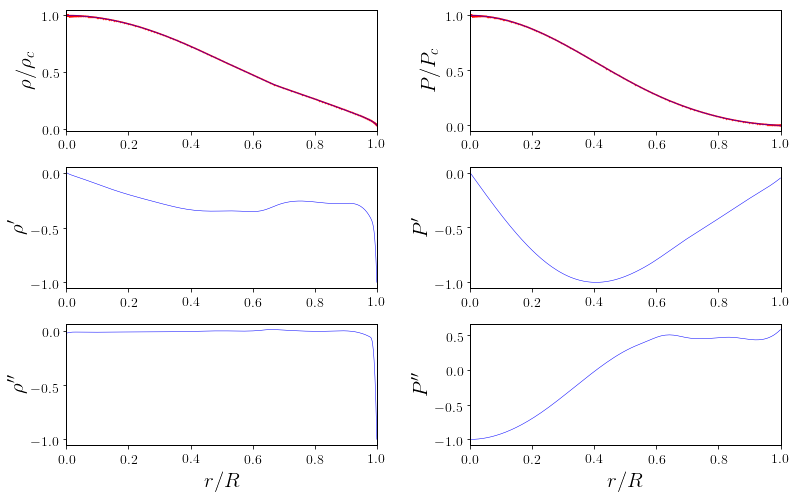

In [89]:
fig=plt.figure(figsize=[12.8,8])

plt.subplot(321)
plt.plot(h7_155[-1]/h7_155[-1][-1],h7_155[2]/h7_155[2][0],color='red',marker='o',markersize='0.4') 
plt.plot(h7_155[-1]/h7_155[-1][-1],h7_155rho(h7_155[-1])/h7_155[2][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1) # leaving the crust out

plt.subplot(322)
plt.plot(h7_155[-1]/h7_155[-1][-1],h7_155[1]/h7_155[1][0],color='red',marker='o',markersize='0.4') 
plt.plot(h7_155[-1]/h7_155[-1][-1],h7_155p(h7_155[-1])/h7_155[1][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$P/P_c$')
plt.xlim(0,1)

plt.subplot(323)
plt.plot(h7_155[-1]/h7_155[-1][-1],h7_155drho(h7_155[-1])/max(abs(h7_155drho(h7_155[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime}$')
plt.xlim(0,1)
#plt.ylim(-500,0)

plt.subplot(324)
plt.plot(h7_155[-1]/h7_155[-1][-1],h7_155dp(h7_155[-1])/max(abs(h7_155dp(h7_155[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime} $')
plt.xlim(0,1)

plt.subplot(325)
plt.plot(h7_155[-1]/h7_155[-1][-1],h7_155ddrho(h7_155[-1])/max(abs(h7_155ddrho(h7_155[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}$')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-0.01,0.01)

plt.subplot(326)
plt.plot(h7_155[-1]/h7_155[-1][-1],h7_155ddp(h7_155[-1])/max(abs(h7_155ddp(h7_155[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime\prime}$ ')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-1,1)

fig.subplots_adjust(hspace=0.3,wspace=0.3)

#plt.savefig('figures/ddsh7_155.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

## Redshift

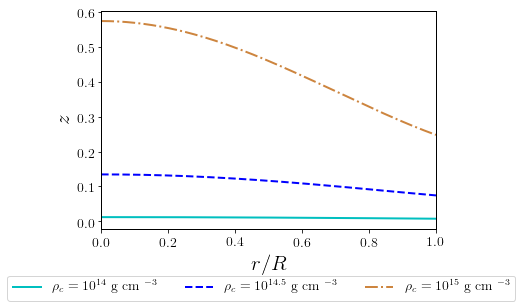

In [90]:
fig = plt.figure()

plt.plot(h7_140[-1]/h7_140[-1][-1],np.exp(-h7_140[3])-1.0,color='c',linewidth='2.0',label=r'$\rho_c=10^{14}$ g cm $^{-3}$')
plt.plot(h7_145[-1]/h7_145[-1][-1],np.exp(-h7_145[3])-1.0,color='blue',linewidth='2.0',linestyle='--',label=r'$\rho_c=10^{14.5}$ g cm $^{-3}$')
plt.plot(h7_150[-1]/h7_150[-1][-1],np.exp(-h7_150[3])-1.0,color='peru',linewidth='2.0',linestyle='-.',label=r'$\rho_c=10^{15}$ g cm $^{-3}$')

l = plt.legend(bbox_to_anchor=(1.1,-0.15), loc="lower right", 
                bbox_transform=fig.transFigure, ncol=3)

plt.xlabel(r'$r/R$')
plt.ylabel(r'$z$')
plt.xlim(0,1.0)

plt.savefig('figures/Redshifth7.pdf', format='pdf', dpi=1000,bbox_inches="tight")

# MPA1 --------------------------------------------------------------------------------------------

In [102]:
rhompa1,Pmpa1,nmpa1=np.loadtxt('EOS/mpa1.dat',usecols=(2,1,0),unpack=True)

## Dominant energy condition

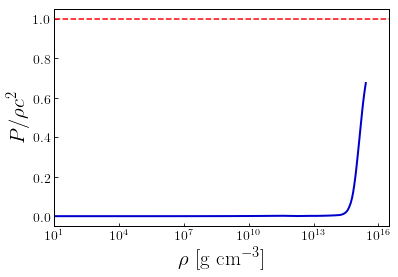

<Figure size 432x288 with 0 Axes>

In [103]:
fig, ax = plt.subplots()
plt.plot(rhompa1,np.divide(Pmpa1,rhompa1),lw='2',color='mediumblue')
plt.plot([0,10**(17)],[1.0,1.0],'r--',lw='1.5')

ax.set_xscale("log")
#locmaj = matplotlib.ticker.LogLocator(base=10.0,numticks=16) 
#ax.xaxis.set_major_locator(locmaj)


plt.xlabel(r'$\rho$ [g\,\,cm$^{-3}$]')
plt.ylabel(r'$ P / \rho c^2 $')
#locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks=16)
#ax.xaxis.set_minor_locator(locmin)
#ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.tick_params(axis="x", direction="in")
ax.tick_params(axis="y", direction="in")
plt.xlim(10,10**(16.5))
#ax.set_facecolor('floralwhite')
#plt.gca().set_aspect('equal', adjustable='box')
#plt.draw()
#plt.ylim(0,1)
plt.savefig('figures/ECmpa1.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()
plt.clf()

## Speed of sound

In [104]:
vsquared=interpolate.UnivariateSpline(rhompa1, Pmpa1, k=3, s=0).derivative(n=1)

/home/dave/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  


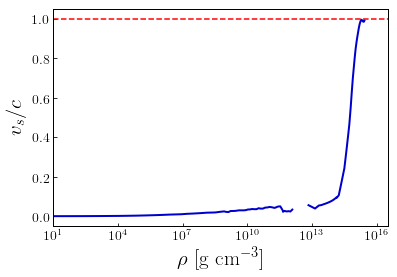

In [105]:
fig, ax = plt.subplots()
plt.plot(rhompa1,np.sqrt(vsquared(rhompa1)),lw='2.0',color='mediumblue')
plt.plot([1e+1,10**(16.5)],[1.0,1.0],'r--',lw='1.5')
plt.xlabel(r'$\rho$ [g\,\,cm$^{-3}$]')
plt.ylabel(r'$ v_s / c $')
plt.xscale('log')
ax.tick_params(axis="x", direction="in")
ax.tick_params(axis="y", direction="in")
plt.xlim(10,10**(16.5))
#ax.set_facecolor('floralwhite')
#mpl.rcParams['axes.linewidth'] = 1.4
#plt.gca().set_aspect('equal', adjustable='box')
#plt.draw()
plt.savefig('figures/SSmpa1.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

## Adiabatic Index

In [644]:
Gamma=np.multiply(np.divide(np.add(rhompa1,Pmpa1),Pmpa1),vsquared(rhompa1))

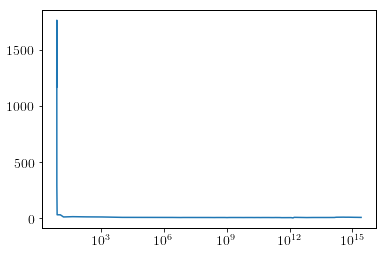

In [645]:
plt.plot(rhompa1,Gamma)
plt.xscale('log')

$$ \langle\gamma\rangle=\frac{\int_{0}^{R} e^{(\lambda+3 \nu) } \gamma(r) P(r) r^{2} d r}{\int_{0}^{R} e^{(\lambda+3 \nu) } P(r) r^{2} d r} $$

Listing all the models calculated

In [646]:
owd=os.getcwd()
path=os.chdir('results/mpa1')
listOfEntries= os.scandir(path)
models_mpa1 = []
for entry in listOfEntries:
    if '1' in entry.name:
        models_mpa1.append(entry.name)
os.chdir(owd)
models_mpa1.sort()

In [647]:
gamma_efs1 = []
gamma_efs2 = []
gamma_crs1 = []
gamma_crs2 = []
rhosc= []
for model in models_mpa1:
    m, P, rho, nu, lambd, r = np.loadtxt('results/mpa1/' + model ,unpack=True)
    nu = nu - nu[-1] + 0.5*np.log(1-2*m[-1]/r[-1])
    #lambd = np.zeros_like(r)
    #for i in range((r.shape)[0]):
    #    if i==0:
    #        lambd[i] = 0
    #    else:
    #        lambd[i] = 0.5*np.log(1/(1-2*m[i]/r[i]))
    drho=interpolate.UnivariateSpline(r, rho, k=5, s=0).derivative(n=1)
    dP=interpolate.UnivariateSpline(r, P, k=5, s=0).derivative(n=1)
    gamma = np.divide(dP(r),drho(r))
    gamma_ef1 = integrate.trapz(np.exp(lambd+3*nu)*gamma*P*(r**2),r)/integrate.trapz(np.exp(lambd+3*nu)*P*(r**2),r)
    t1 = (1/36)*integrate.trapz(np.exp((lambd+3*nu))*(16*P+(np.exp(2*lambd)-1)*(P+rho))*(np.exp(2*lambd)-1)*(r**2))/integrate.trapz(np.exp(lambd+3*nu)*P*(r**2),r)
    t2 = (4*np.pi/9)*integrate.trapz(np.exp(3*lambd+3*nu)*(8*P + (np.exp(2*lambd)+1)*(P+rho))*P*(r**4),r)/integrate.trapz(np.exp(lambd+3*nu)*P*(r**2),r)
    t3 = ((16*np.pi**2)/9)*integrate.trapz(np.exp(5*lambd+3*nu)*(P+rho)*(P**2)*(r**6),r)/integrate.trapz(np.exp(lambd+3*nu)*P*(r**2),r)
    gamma_cr1 = 4/3 + t1 + t2 + t3
    gamma_efs1.append(gamma_ef1)
    gamma_crs1.append(gamma_cr1)
    gamma_ef2 = integrate.trapz(gamma*P*r**2,r)/integrate.trapz(P*r**2,r)
    gamma_cr2 = 4/3 + (19/42)*2*m[-1]/r[-1]
    gamma_efs2.append(gamma_ef2)
    gamma_crs2.append(gamma_cr2)
    rhosc.append(rho[0]*rhodim)

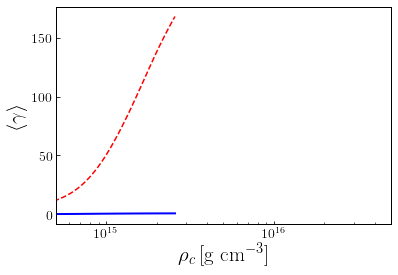

In [648]:
fig, ax = plt.subplots()
plt.plot(rhosc,gamma_crs1,lw='1.5',color='r',linestyle='--',label=r'$\gamma_{cr}$')
plt.plot(rhosc,gamma_efs1,lw='2.0',color='blue',label=r'$\langle \gamma \rangle$')

plt.xlabel(r'$\rho_c\,[$g cm$^{-3}]$')
plt.ylabel(r'$\langle \gamma \rangle$')

plt.xscale('log')
plt.xlim(left=10**(14.7),right=10**(16.7))
#plt.ylim(0,10)
ax.tick_params(axis="x", direction="in",which='both')
ax.tick_params(axis="y", direction="in",which='both')
#l = plt.legend(bbox_to_anchor=(0.85,-0.15), loc="lower right", 
                #bbox_transform=fig.transFigure, ncol=2)



plt.savefig('figures/AdiabaticIndexmpa1.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

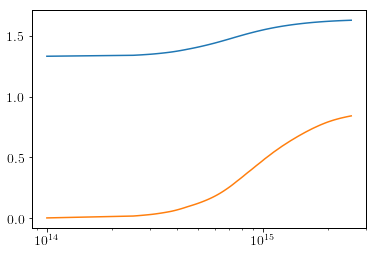

In [649]:
plt.plot(rhosc,gamma_crs2)
plt.plot(rhosc,gamma_efs2)
plt.xscale('log')

## M - $\rho_c$

In [106]:
Rmpa1,Mmpa1,rhocmpa1=np.loadtxt('results/mpa1/MRrhoc.dat',usecols=(0,1,2),unpack=True)

In [107]:
np.amax(Mmpa1)

2.4624656953

In [108]:
rhocmpa1[np.argmax(Mmpa1)]

2137962089500000.0

In [109]:
np.log10(rhocmpa1[np.argmax(Mmpa1)])

15.329999999999547

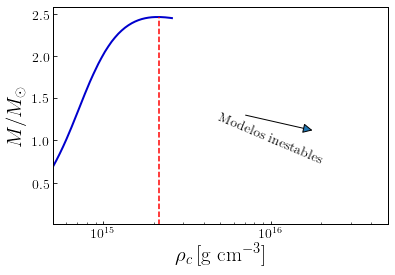

In [110]:
fig, ax = plt.subplots()

plt.plot(rhocmpa1,Mmpa1,color='mediumblue',lw='2.0')
plt.plot([10**(np.log10(rhocmpa1[np.argmax(Mmpa1)])),10**(np.log10(rhocmpa1[np.argmax(Mmpa1)]))],[0.0,np.amax(Mmpa1)],'r--',lw='1.5')

prop = dict(arrowstyle="-|>,head_width=0.4,head_length=0.8",
            shrinkA=0,shrinkB=0)
plt.annotate("", xy=(10**(16.25),1.12), xytext=(10**(15.85),1.3), arrowprops=prop)
#plt.arrow(10**(15.6), 1.38,10**(15.7) ,-0.1 , head_width=0.05, head_lmpa1th=10**(15))
plt.text(10**(15.67), 1.23, 'Modelos inestables' , fontsize=14,rotation=-23)

plt.xscale('log')
plt.xlabel(r'$\rho_c\,[$g cm$^{-3}]$')
plt.ylabel(r'$M/M_{\odot}$')
plt.xlim(left=10**(14.7),right=10**(16.7))
plt.ylim(bottom=0.01)
ax.tick_params(axis="x", direction="in",which='both')
ax.tick_params(axis="y", direction="in",which='both')

plt.savefig('figures/Mrhorel_mpa1.pdf', format='pdf', dpi=1000,bbox_inches="tight")

## Tunning the interpolation of the solution

### 14.0

In [111]:
mpa1_140=np.loadtxt('results/mpa1/14.0.dat',unpack=True)
mpa1_140[3] = mpa1_140[3]-mpa1_140[3][-1] + 0.5*np.log(1-2*mpa1_140[0][-1]/mpa1_140[-1][-1])

In [112]:
s1=5e-7
s2=1e-15
mpa1_140rho=interpolate.UnivariateSpline(mpa1_140[-1], mpa1_140[2], k=5, s=s1)
mpa1_140drho=interpolate.UnivariateSpline(mpa1_140[-1], mpa1_140[2], k=5, s=s1).derivative(n=1)
mpa1_140ddrho=interpolate.UnivariateSpline(mpa1_140[-1], mpa1_140[2], k=5, s=s1).derivative(n=2)

mpa1_140p=interpolate.UnivariateSpline(mpa1_140[-1], mpa1_140[1], k=5, s=s2)
mpa1_140dp=interpolate.UnivariateSpline(mpa1_140[-1], mpa1_140[1], k=5, s=s2).derivative(n=1)
mpa1_140ddp=interpolate.UnivariateSpline(mpa1_140[-1], mpa1_140[1], k=5, s=s2).derivative(n=2)

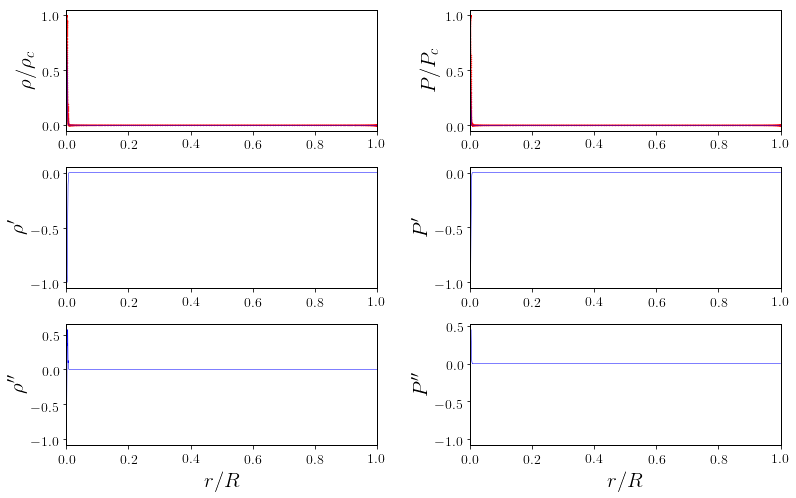

In [113]:
fig=plt.figure(figsize=[12.8,8])

plt.subplot(321)
plt.plot(mpa1_140[-1]/mpa1_140[-1][-1],mpa1_140[2]/mpa1_140[2][0],color='red',marker='o',markersize='0.4') 
plt.plot(mpa1_140[-1]/mpa1_140[-1][-1],mpa1_140rho(mpa1_140[-1])/mpa1_140[2][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1) # leaving the crust out

plt.subplot(322)
plt.plot(mpa1_140[-1]/mpa1_140[-1][-1],mpa1_140[1]/mpa1_140[1][0],color='red',marker='o',markersize='0.4') 
plt.plot(mpa1_140[-1]/mpa1_140[-1][-1],mpa1_140p(mpa1_140[-1])/mpa1_140[1][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$P/P_c$')
plt.xlim(0,1)

plt.subplot(323)
plt.plot(mpa1_140[-1]/mpa1_140[-1][-1],mpa1_140drho(mpa1_140[-1])/max(abs(mpa1_140drho(mpa1_140[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime}$')
plt.xlim(0,1)
#plt.ylim(-500,0)

plt.subplot(324)
plt.plot(mpa1_140[-1]/mpa1_140[-1][-1],mpa1_140dp(mpa1_140[-1])/max(abs(mpa1_140dp(mpa1_140[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime} $')
plt.xlim(0,1)

plt.subplot(325)
plt.plot(mpa1_140[-1]/mpa1_140[-1][-1],mpa1_140ddrho(mpa1_140[-1])/max(abs(mpa1_140ddrho(mpa1_140[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}$')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-0.01,0.01)

plt.subplot(326)
plt.plot(mpa1_140[-1]/mpa1_140[-1][-1],mpa1_140ddp(mpa1_140[-1])/max(abs(mpa1_140ddp(mpa1_140[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime\prime}$ ')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-1,1)

fig.subplots_adjust(hspace=0.3,wspace=0.3)

#plt.savefig('figures/ddsmpa1_140.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

### 14.5

In [114]:
mpa1_145=np.loadtxt('results/mpa1/14.5.dat',unpack=True)
mpa1_145[3] = mpa1_145[3]-mpa1_145[3][-1] + 0.5*np.log(1-2*mpa1_145[0][-1]/mpa1_145[-1][-1])

In [142]:
s1=1e-6
s2=1e-12
mpa1_145rho=interpolate.UnivariateSpline(mpa1_145[-1], mpa1_145[2], k=5, s=s1)
mpa1_145drho=interpolate.UnivariateSpline(mpa1_145[-1], mpa1_145[2], k=5, s=s1).derivative(n=1)
mpa1_145ddrho=interpolate.UnivariateSpline(mpa1_145[-1], mpa1_145[2], k=5, s=s1).derivative(n=2)

mpa1_145p=interpolate.UnivariateSpline(mpa1_145[-1], mpa1_145[1], k=5, s=s2)
mpa1_145dp=interpolate.UnivariateSpline(mpa1_145[-1], mpa1_145[1], k=5, s=s2).derivative(n=1)
mpa1_145ddp=interpolate.UnivariateSpline(mpa1_145[-1], mpa1_145[1], k=5, s=s2).derivative(n=2)

In [116]:
mpa1_145rho(0.4*mpa1_145[-1][-1])*rhodim

207800653573039.2

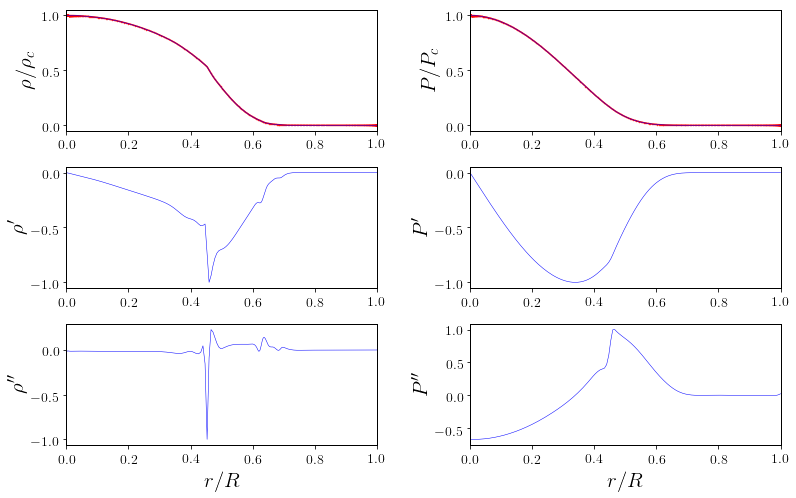

In [117]:
fig=plt.figure(figsize=[12.8,8])

plt.subplot(321)
plt.plot(mpa1_145[-1]/mpa1_145[-1][-1],mpa1_145[2]/mpa1_145[2][0],color='red',marker='o',markersize='0.4') 
plt.plot(mpa1_145[-1]/mpa1_145[-1][-1],mpa1_145rho(mpa1_145[-1])/mpa1_145[2][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1) # leaving the crust out

plt.subplot(322)
plt.plot(mpa1_145[-1]/mpa1_145[-1][-1],mpa1_145[1]/mpa1_145[1][0],color='red',marker='o',markersize='0.4') 
plt.plot(mpa1_145[-1]/mpa1_145[-1][-1],mpa1_145p(mpa1_145[-1])/mpa1_145[1][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$P/P_c$')
plt.xlim(0,1)

plt.subplot(323)
plt.plot(mpa1_145[-1]/mpa1_145[-1][-1],mpa1_145drho(mpa1_145[-1])/max(abs(mpa1_145drho(mpa1_145[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime}$')
plt.xlim(0,1)
#plt.ylim(-500,0)

plt.subplot(324)
plt.plot(mpa1_145[-1]/mpa1_145[-1][-1],mpa1_145dp(mpa1_145[-1])/max(abs(mpa1_145dp(mpa1_145[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime} $')
plt.xlim(0,1)

plt.subplot(325)
plt.plot(mpa1_145[-1]/mpa1_145[-1][-1],mpa1_145ddrho(mpa1_145[-1])/max(abs(mpa1_145ddrho(mpa1_145[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}$')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-0.01,0.01)

plt.subplot(326)
plt.plot(mpa1_145[-1]/mpa1_145[-1][-1],mpa1_145ddp(mpa1_145[-1])/max(abs(mpa1_145ddp(mpa1_145[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime\prime}$ ')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-1,1)

fig.subplots_adjust(hspace=0.3,wspace=0.3)

#plt.savefig('figures/ddsmpa1_145.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

### 15.0

In [135]:
mpa1_150=np.loadtxt('results/mpa1/14.8.dat',unpack=True)
mpa1_150[3] = mpa1_150[3]-mpa1_150[3][-1] + 0.5*np.log(1-2*mpa1_150[0][-1]/mpa1_150[-1][-1])

In [143]:
s1=1e-6
s2=1e-15
mpa1_150rho=interpolate.UnivariateSpline(mpa1_150[-1], mpa1_150[2], k=5, s=s1)
mpa1_150drho=interpolate.UnivariateSpline(mpa1_150[-1], mpa1_150[2], k=5, s=s1).derivative(n=1)
mpa1_150ddrho=interpolate.UnivariateSpline(mpa1_150[-1], mpa1_150[2], k=5, s=s1).derivative(n=2)

mpa1_150p=interpolate.UnivariateSpline(mpa1_150[-1], mpa1_150[1], k=5, s=s2)
mpa1_150dp=interpolate.UnivariateSpline(mpa1_150[-1], mpa1_150[1], k=5, s=s2).derivative(n=1)
mpa1_150ddp=interpolate.UnivariateSpline(mpa1_150[-1], mpa1_150[1], k=5, s=s2).derivative(n=2)

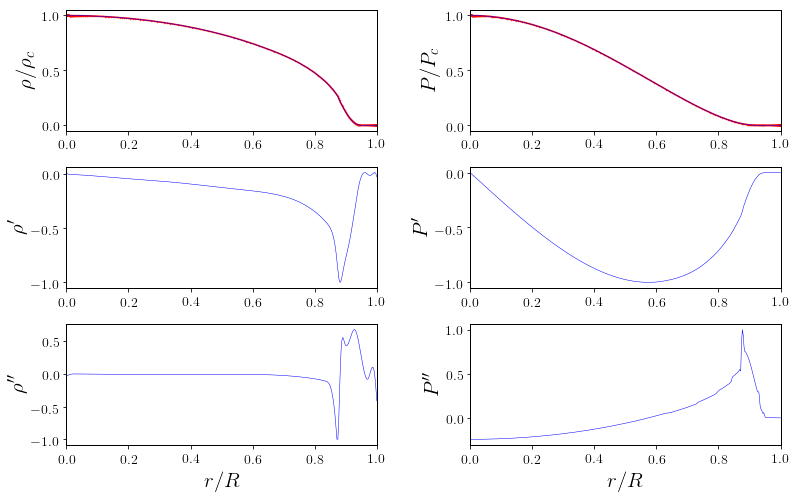

In [137]:
fig=plt.figure(figsize=[12.8,8])

plt.subplot(321)
plt.plot(mpa1_150[-1]/mpa1_150[-1][-1],mpa1_150[2]/mpa1_150[2][0],color='red',marker='o',markersize='0.4') 
plt.plot(mpa1_150[-1]/mpa1_150[-1][-1],mpa1_150rho(mpa1_150[-1])/mpa1_150[2][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1) # leaving the crust out

plt.subplot(322)
plt.plot(mpa1_150[-1]/mpa1_150[-1][-1],mpa1_150[1]/mpa1_150[1][0],color='red',marker='o',markersize='0.4') 
plt.plot(mpa1_150[-1]/mpa1_150[-1][-1],mpa1_150p(mpa1_150[-1])/mpa1_150[1][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$P/P_c$')
plt.xlim(0,1)

plt.subplot(323)
plt.plot(mpa1_150[-1]/mpa1_150[-1][-1],mpa1_150drho(mpa1_150[-1])/max(abs(mpa1_150drho(mpa1_150[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime}$')
plt.xlim(0,1)
#plt.ylim(-500,0)

plt.subplot(324)
plt.plot(mpa1_150[-1]/mpa1_150[-1][-1],mpa1_150dp(mpa1_150[-1])/max(abs(mpa1_150dp(mpa1_150[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime} $')
plt.xlim(0,1)

plt.subplot(325)
plt.plot(mpa1_150[-1]/mpa1_150[-1][-1],mpa1_150ddrho(mpa1_150[-1])/max(abs(mpa1_150ddrho(mpa1_150[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}$')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-0.01,0.01)

plt.subplot(326)
plt.plot(mpa1_150[-1]/mpa1_150[-1][-1],mpa1_150ddp(mpa1_150[-1])/max(abs(mpa1_150ddp(mpa1_150[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime\prime}$ ')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-1,1)

fig.subplots_adjust(hspace=0.3,wspace=0.3)

#plt.savefig('figures/ddsmpa1_150.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

## Redshift

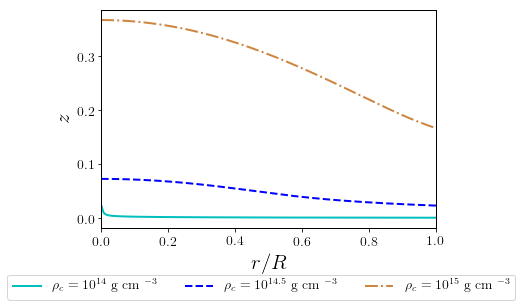

In [138]:
fig = plt.figure()

plt.plot(mpa1_140[-1]/mpa1_140[-1][-1],np.exp(-mpa1_140[3])-1.0,color='c',linewidth='2.0',label=r'$\rho_c=10^{14}$ g cm $^{-3}$')
plt.plot(mpa1_145[-1]/mpa1_145[-1][-1],np.exp(-mpa1_145[3])-1.0,color='blue',linewidth='2.0',linestyle='--',label=r'$\rho_c=10^{14.5}$ g cm $^{-3}$')
plt.plot(mpa1_150[-1]/mpa1_150[-1][-1],np.exp(-mpa1_150[3])-1.0,color='peru',linewidth='2.0',linestyle='-.',label=r'$\rho_c=10^{15}$ g cm $^{-3}$')

l = plt.legend(bbox_to_anchor=(1.1,-0.15), loc="lower right", 
                bbox_transform=fig.transFigure, ncol=3)

plt.xlabel(r'$r/R$')
plt.ylabel(r'$z$')
plt.xlim(0,1.0)

plt.savefig('figures/Redshiftmpa1.pdf', format='pdf', dpi=1000,bbox_inches="tight")

## Adiabatic convection

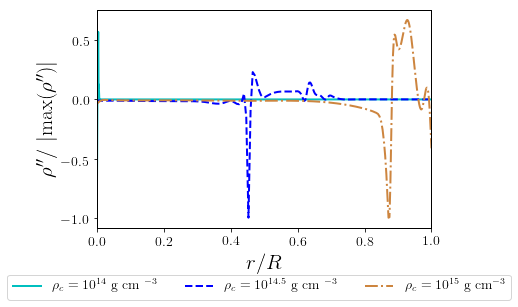

In [139]:
fig = plt.figure()

plt.plot(mpa1_140[-1]/mpa1_140[-1][-1],mpa1_140ddrho(mpa1_140[-1])/max(abs(mpa1_140ddrho(mpa1_140[-1]))),color='c',linewidth='2.0',label=r'$\rho_c=10^{14}$ g cm $^{-3}$') 
plt.plot(mpa1_145[-1]/mpa1_145[-1][-1],mpa1_145ddrho(mpa1_145[-1])/max(abs(mpa1_145ddrho(mpa1_145[-1]))),color='blue',linewidth='2.0',linestyle='--',label=r'$\rho_c=10^{14.5}$ g cm $^{-3}$') 
plt.plot(mpa1_150[-1]/mpa1_150[-1][-1],mpa1_150ddrho(mpa1_150[-1])/max(abs(mpa1_150ddrho(mpa1_150[-1]))),color='peru',linewidth='2.0',linestyle='-.',label=r'$\rho_c=10^{15}$ g cm$ ^{-3}$')

#plt.plot(mpa1_155[-1]/mpa1_155[-1][-1],mpa1_155drho(mpa1_155[-1])/max(abs(mpa1_155drho(mpa1_140[-1]))),color='yellow',linewidth='2.0',linestyle='-.',label=r'$\rho_c=10^{15.5}$ g cm$ ^{-3}$')

l = plt.legend(bbox_to_anchor=(1.1,-0.15), loc="lower right", 
                bbox_transform=fig.transFigure, ncol=3)

plt.xlabel(r'$r/R$')
plt.ylabel(r'$\rho^{\prime \prime}/$ $|$max$(\rho^{\prime \prime})|$')
plt.xlim(0,1.0)

plt.savefig('figures/ConvecStabilitympa1.pdf', format='pdf', dpi=1000,bbox_inches="tight")


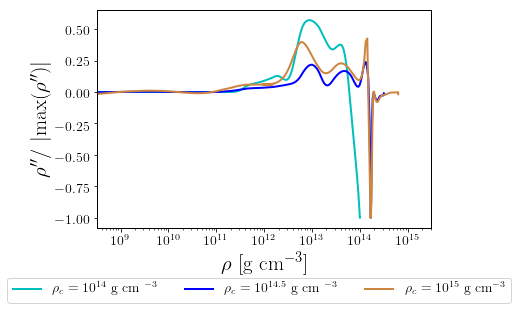

In [144]:
fig, ax = plt.subplots()

ax.set_xscale("log")

plt.plot(mpa1_140[2]*rhodim,mpa1_140ddrho(mpa1_140[-1])/max(abs(mpa1_140ddrho(mpa1_140[-1]))),color='c',linewidth='2.0',label=r'$\rho_c=10^{14}$ g cm $^{-3}$') 
plt.plot(mpa1_145[2]*rhodim,mpa1_145ddrho(mpa1_145[-1])/max(abs(mpa1_145ddrho(mpa1_145[-1]))),color='blue',linewidth='2.0',linestyle='-',label=r'$\rho_c=10^{14.5}$ g cm $^{-3}$') 
plt.plot(mpa1_150[2]*rhodim,mpa1_150ddrho(mpa1_150[-1])/max(abs(mpa1_150ddrho(mpa1_150[-1]))),color='peru',linewidth='2.0',linestyle='-',label=r'$\rho_c=10^{15}$ g cm$ ^{-3}$')
plt.xlim(left=10**(8.5))
#plt.plot(mpa1_155[-1]/mpa1_155[-1][-1],mpa1_155drho(mpa1_155[-1])/max(abs(mpa1_155drho(mpa1_140[-1]))),color='yellow',linewidth='2.0',linestyle='-.',label=r'$\rho_c=10^{15.5}$ g cm$ ^{-3}$')

l = plt.legend(bbox_to_anchor=(1.1,-0.16), loc="lower right", 
                bbox_transform=fig.transFigure, ncol=3)

plt.xlabel(r'$\rho$ [g cm$^{-3}$]')
plt.ylabel(r'$\rho^{\prime \prime}/$ $|$max$(\rho^{\prime \prime})|$')
#plt.xlim(0,1.0)

plt.savefig('figures/ConvecStabilitympa1Correl.pdf', format='pdf', dpi=1000,bbox_inches="tight")

# MS1 -----------------------------------------------------------------------------------------

In [13]:
rhoms1,Pms1,nms1=np.loadtxt('EOS/ms1.dat',usecols=(2,1,0),unpack=True)

## Dominant energy condition

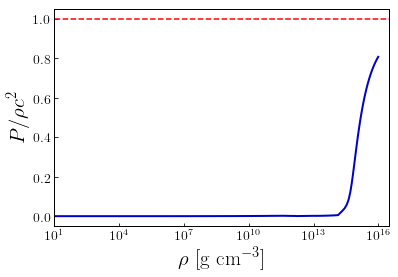

<Figure size 432x288 with 0 Axes>

In [14]:
fig, ax = plt.subplots()
plt.plot(rhoms1,np.divide(Pms1,rhoms1),lw='2',color='mediumblue')
plt.plot([0,10**(17)],[1.0,1.0],'r--',lw='1.5')

ax.set_xscale("log")
#locmaj = matplotlib.ticker.LogLocator(base=10.0,numticks=16) 
#ax.xaxis.set_major_locator(locmaj)


plt.xlabel(r'$\rho$ [g\,\,cm$^{-3}$]')
plt.ylabel(r'$ P / \rho c^2 $')
#locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks=16)
#ax.xaxis.set_minor_locator(locmin)
#ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.tick_params(axis="x", direction="in")
ax.tick_params(axis="y", direction="in")
plt.xlim(10,10**(16.5))
#ax.set_facecolor('floralwhite')
#plt.gca().set_aspect('equal', adjustable='box')
#plt.draw()
#plt.ylim(0,1)
plt.savefig('figures/ECms1.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()
plt.clf()

## Speed of sound

In [15]:
vsquared=interpolate.UnivariateSpline(rhoms1, Pms1, k=1, s=0).derivative(n=1)

/home/dave/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  


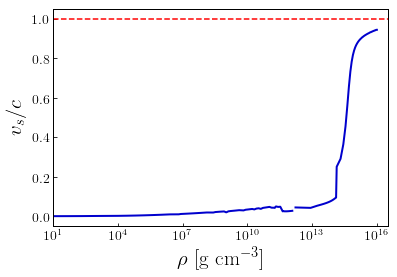

In [16]:
fig, ax = plt.subplots()
plt.plot(rhoms1,np.sqrt(vsquared(rhoms1)),lw='2.0',color='mediumblue')
plt.plot([1e+1,10**(16.5)],[1.0,1.0],'r--',lw='1.5')
plt.xlabel(r'$\rho$ [g\,\,cm$^{-3}$]')
plt.ylabel(r'$ v_s / c $')
plt.xscale('log')
ax.tick_params(axis="x", direction="in")
ax.tick_params(axis="y", direction="in")
plt.xlim(10,10**(16.5))
#ax.set_facecolor('floralwhite')
#mpl.rcParams['axes.linewidth'] = 1.4
#plt.gca().set_aspect('equal', adjustable='box')
#plt.draw()
plt.savefig('figures/SSms1.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

## Adiabatic Index

In [17]:
Gamma=np.multiply(np.divide(np.add(rhoms1,Pms1),Pms1),vsquared(rhoms1))

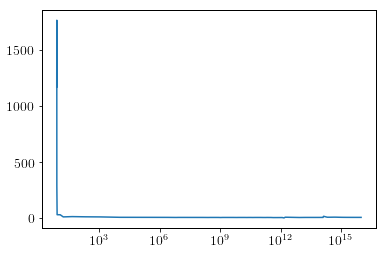

In [18]:
plt.plot(rhoms1,Gamma)
plt.xscale('log')

$$ \langle\gamma\rangle=\frac{\int_{0}^{R} e^{(\lambda+3 \nu) } \gamma(r) P(r) r^{2} d r}{\int_{0}^{R} e^{(\lambda+3 \nu) } P(r) r^{2} d r} $$

Listing all the models calculated

In [19]:
owd=os.getcwd()
path=os.chdir('results/ms1')
listOfEntries= os.scandir(path)
models_ms1 = []
for entry in listOfEntries:
    if '1' in entry.name:
        models_ms1.append(entry.name)
os.chdir(owd)
models_ms1.sort()

In [20]:
gamma_efs1 = []
gamma_efs2 = []
gamma_crs1 = []
gamma_crs2 = []
rhosc= []
for model in models_ms1:
    m, P, rho, nu, lambd, r = np.loadtxt('results/ms1/' + model ,unpack=True)
    nu = nu - nu[-1] + 0.5*np.log(1-2*m[-1]/r[-1])
    #lambd = np.zeros_like(r)
    #for i in range((r.shape)[0]):
    #    if i==0:
    #        lambd[i] = 0
    #    else:
    #        lambd[i] = 0.5*np.log(1/(1-2*m[i]/r[i]))
    drho=interpolate.UnivariateSpline(r, rho, k=5, s=0).derivative(n=1)
    dP=interpolate.UnivariateSpline(r, P, k=5, s=0).derivative(n=1)
    gamma = np.divide(dP(r),drho(r))
    gamma_ef1 = integrate.trapz(np.exp(lambd+3*nu)*gamma*P*(r**2),r)/integrate.trapz(np.exp(lambd+3*nu)*P*(r**2),r)
    t1 = (1/36)*integrate.trapz(np.exp((lambd+3*nu))*(16*P+(np.exp(2*lambd)-1)*(P+rho))*(np.exp(2*lambd)-1)*(r**2))/integrate.trapz(np.exp(lambd+3*nu)*P*(r**2),r)
    t2 = (4*np.pi/9)*integrate.trapz(np.exp(3*lambd+3*nu)*(8*P + (np.exp(2*lambd)+1)*(P+rho))*P*(r**4),r)/integrate.trapz(np.exp(lambd+3*nu)*P*(r**2),r)
    t3 = ((16*np.pi**2)/9)*integrate.trapz(np.exp(5*lambd+3*nu)*(P+rho)*(P**2)*(r**6),r)/integrate.trapz(np.exp(lambd+3*nu)*P*(r**2),r)
    gamma_cr1 = 4/3 + t1 + t2 + t3
    gamma_efs1.append(gamma_ef1)
    gamma_crs1.append(gamma_cr1)
    gamma_ef2 = integrate.trapz(gamma*P*r**2,r)/integrate.trapz(P*r**2,r)
    gamma_cr2 = 4/3 + (19/42)*2*m[-1]/r[-1]
    gamma_efs2.append(gamma_ef2)
    gamma_crs2.append(gamma_cr2)
    rhosc.append(rho[0]*rhodim)

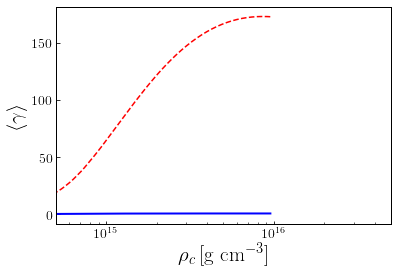

In [21]:
fig, ax = plt.subplots()
plt.plot(rhosc,gamma_crs1,lw='1.5',color='r',linestyle='--',label=r'$\gamma_{cr}$')
plt.plot(rhosc,gamma_efs1,lw='2.0',color='blue',label=r'$\langle \gamma \rangle$')

plt.xlabel(r'$\rho_c\,[$g cm$^{-3}]$')
plt.ylabel(r'$\langle \gamma \rangle$')

plt.xscale('log')
plt.xlim(left=10**(14.7),right=10**(16.7))
#plt.ylim(0,10)
ax.tick_params(axis="x", direction="in",which='both')
ax.tick_params(axis="y", direction="in",which='both')
#l = plt.legend(bbox_to_anchor=(0.85,-0.15), loc="lower right", 
                #bbox_transform=fig.transFigure, ncol=2)



plt.savefig('figures/AdiabaticIndexms1.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

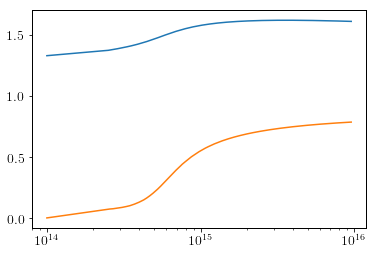

In [22]:
plt.plot(rhosc,gamma_crs2)
plt.plot(rhosc,gamma_efs2)
plt.xscale('log')

## M - $\rho_c$

In [23]:
Rms1,Mms1,rhocms1=np.loadtxt('results/ms1/MRrhoc.dat',usecols=(0,1,2),unpack=True)

In [24]:
np.amax(Mms1)

2.76996554555

In [25]:
rhocms1[np.argmax(Mms1)]

1548816618910000.0

In [26]:
np.log10(rhocms1[np.argmax(Mms1)])

15.189999999999305

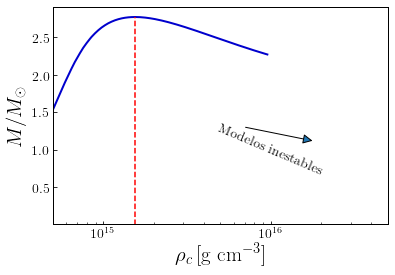

In [27]:
fig, ax = plt.subplots()

plt.plot(rhocms1,Mms1,color='mediumblue',lw='2.0')
plt.plot([10**(np.log10(rhocms1[np.argmax(Mms1)])),10**(np.log10(rhocms1[np.argmax(Mms1)]))],[0.0,np.amax(Mms1)],'r--',lw='1.5')

prop = dict(arrowstyle="-|>,head_width=0.4,head_length=0.8",
            shrinkA=0,shrinkB=0)
plt.annotate("", xy=(10**(16.25),1.12), xytext=(10**(15.85),1.3), arrowprops=prop)
#plt.arrow(10**(15.6), 1.38,10**(15.7) ,-0.1 , head_width=0.05, head_lms1th=10**(15))
plt.text(10**(15.67), 1.23, 'Modelos inestables' , fontsize=14,rotation=-23)

plt.xscale('log')
plt.xlabel(r'$\rho_c\,[$g cm$^{-3}]$')
plt.ylabel(r'$M/M_{\odot}$')
plt.xlim(left=10**(14.7),right=10**(16.7))
plt.ylim(bottom=0.01)
ax.tick_params(axis="x", direction="in",which='both')
ax.tick_params(axis="y", direction="in",which='both')

plt.savefig('figures/Mrhorel_ms1.pdf', format='pdf', dpi=1000,bbox_inches="tight")

## Tunning the interpolation of the solution

### 14.0

In [28]:
ms1_140=np.loadtxt('results/ms1/14.0.dat',unpack=True)
ms1_140[3] = ms1_140[3]-ms1_140[3][-1] + 0.5*np.log(1-2*ms1_140[0][-1]/ms1_140[-1][-1])

In [29]:
s1=5e-7
s2=1e-15
ms1_140rho=interpolate.UnivariateSpline(ms1_140[-1], ms1_140[2], k=5, s=s1)
ms1_140drho=interpolate.UnivariateSpline(ms1_140[-1], ms1_140[2], k=5, s=s1).derivative(n=1)
ms1_140ddrho=interpolate.UnivariateSpline(ms1_140[-1], ms1_140[2], k=5, s=s1).derivative(n=2)

ms1_140p=interpolate.UnivariateSpline(ms1_140[-1], ms1_140[1], k=5, s=s2)
ms1_140dp=interpolate.UnivariateSpline(ms1_140[-1], ms1_140[1], k=5, s=s2).derivative(n=1)
ms1_140ddp=interpolate.UnivariateSpline(ms1_140[-1], ms1_140[1], k=5, s=s2).derivative(n=2)

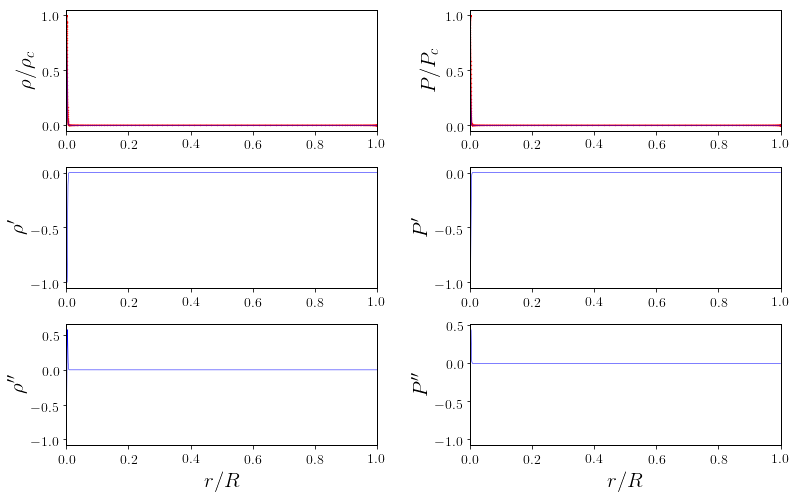

In [30]:
fig=plt.figure(figsize=[12.8,8])

plt.subplot(321)
plt.plot(ms1_140[-1]/ms1_140[-1][-1],ms1_140[2]/ms1_140[2][0],color='red',marker='o',markersize='0.4') 
plt.plot(ms1_140[-1]/ms1_140[-1][-1],ms1_140rho(ms1_140[-1])/ms1_140[2][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1) # leaving the crust out

plt.subplot(322)
plt.plot(ms1_140[-1]/ms1_140[-1][-1],ms1_140[1]/ms1_140[1][0],color='red',marker='o',markersize='0.4') 
plt.plot(ms1_140[-1]/ms1_140[-1][-1],ms1_140p(ms1_140[-1])/ms1_140[1][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$P/P_c$')
plt.xlim(0,1)

plt.subplot(323)
plt.plot(ms1_140[-1]/ms1_140[-1][-1],ms1_140drho(ms1_140[-1])/max(abs(ms1_140drho(ms1_140[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime}$')
plt.xlim(0,1)
#plt.ylim(-500,0)

plt.subplot(324)
plt.plot(ms1_140[-1]/ms1_140[-1][-1],ms1_140dp(ms1_140[-1])/max(abs(ms1_140dp(ms1_140[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime} $')
plt.xlim(0,1)

plt.subplot(325)
plt.plot(ms1_140[-1]/ms1_140[-1][-1],ms1_140ddrho(ms1_140[-1])/max(abs(ms1_140ddrho(ms1_140[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}$')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-0.01,0.01)

plt.subplot(326)
plt.plot(ms1_140[-1]/ms1_140[-1][-1],ms1_140ddp(ms1_140[-1])/max(abs(ms1_140ddp(ms1_140[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime\prime}$ ')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-1,1)

fig.subplots_adjust(hspace=0.3,wspace=0.3)

#plt.savefig('figures/ddsms1_140.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

### 14.5

In [31]:
ms1_145=np.loadtxt('results/ms1/14.5.dat',unpack=True)
ms1_145[3] = ms1_145[3]-ms1_145[3][-1] + 0.5*np.log(1-2*ms1_145[0][-1]/ms1_145[-1][-1])

In [32]:
s1=1e-7
s2=1e-12
ms1_145rho=interpolate.UnivariateSpline(ms1_145[-1], ms1_145[2], k=5, s=s1)
ms1_145drho=interpolate.UnivariateSpline(ms1_145[-1], ms1_145[2], k=5, s=s1).derivative(n=1)
ms1_145ddrho=interpolate.UnivariateSpline(ms1_145[-1], ms1_145[2], k=5, s=s1).derivative(n=2)

ms1_145p=interpolate.UnivariateSpline(ms1_145[-1], ms1_145[1], k=5, s=s2)
ms1_145dp=interpolate.UnivariateSpline(ms1_145[-1], ms1_145[1], k=5, s=s2).derivative(n=1)
ms1_145ddp=interpolate.UnivariateSpline(ms1_145[-1], ms1_145[1], k=5, s=s2).derivative(n=2)

In [33]:
ms1_145rho(0.4*ms1_145[-1][-1])*rhodim

266977803373326.66

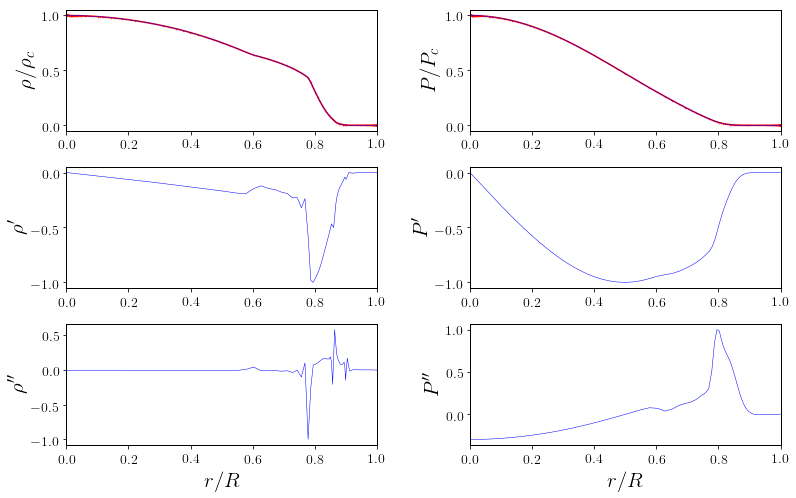

In [34]:
fig=plt.figure(figsize=[12.8,8])

plt.subplot(321)
plt.plot(ms1_145[-1]/ms1_145[-1][-1],ms1_145[2]/ms1_145[2][0],color='red',marker='o',markersize='0.4') 
plt.plot(ms1_145[-1]/ms1_145[-1][-1],ms1_145rho(ms1_145[-1])/ms1_145[2][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1) # leaving the crust out

plt.subplot(322)
plt.plot(ms1_145[-1]/ms1_145[-1][-1],ms1_145[1]/ms1_145[1][0],color='red',marker='o',markersize='0.4') 
plt.plot(ms1_145[-1]/ms1_145[-1][-1],ms1_145p(ms1_145[-1])/ms1_145[1][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$P/P_c$')
plt.xlim(0,1)

plt.subplot(323)
plt.plot(ms1_145[-1]/ms1_145[-1][-1],ms1_145drho(ms1_145[-1])/max(abs(ms1_145drho(ms1_145[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime}$')
plt.xlim(0,1)
#plt.ylim(-500,0)

plt.subplot(324)
plt.plot(ms1_145[-1]/ms1_145[-1][-1],ms1_145dp(ms1_145[-1])/max(abs(ms1_145dp(ms1_145[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime} $')
plt.xlim(0,1)

plt.subplot(325)
plt.plot(ms1_145[-1]/ms1_145[-1][-1],ms1_145ddrho(ms1_145[-1])/max(abs(ms1_145ddrho(ms1_145[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}$')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-0.01,0.01)

plt.subplot(326)
plt.plot(ms1_145[-1]/ms1_145[-1][-1],ms1_145ddp(ms1_145[-1])/max(abs(ms1_145ddp(ms1_145[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime\prime}$ ')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-1,1)

fig.subplots_adjust(hspace=0.3,wspace=0.3)

#plt.savefig('figures/ddsms1_145.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

### 15.0

In [35]:
ms1_150=np.loadtxt('results/ms1/15.0.dat',unpack=True)
ms1_150[3] = ms1_150[3]-ms1_150[3][-1] + 0.5*np.log(1-2*ms1_150[0][-1]/ms1_150[-1][-1])

In [36]:
s1=8e-6
s2=1e-15
ms1_150rho=interpolate.UnivariateSpline(ms1_150[-1], ms1_150[2], k=5, s=s1)
ms1_150drho=interpolate.UnivariateSpline(ms1_150[-1], ms1_150[2], k=5, s=s1).derivative(n=1)
ms1_150ddrho=interpolate.UnivariateSpline(ms1_150[-1], ms1_150[2], k=5, s=s1).derivative(n=2)

ms1_150p=interpolate.UnivariateSpline(ms1_150[-1], ms1_150[1], k=5, s=s2)
ms1_150dp=interpolate.UnivariateSpline(ms1_150[-1], ms1_150[1], k=5, s=s2).derivative(n=1)
ms1_150ddp=interpolate.UnivariateSpline(ms1_150[-1], ms1_150[1], k=5, s=s2).derivative(n=2)

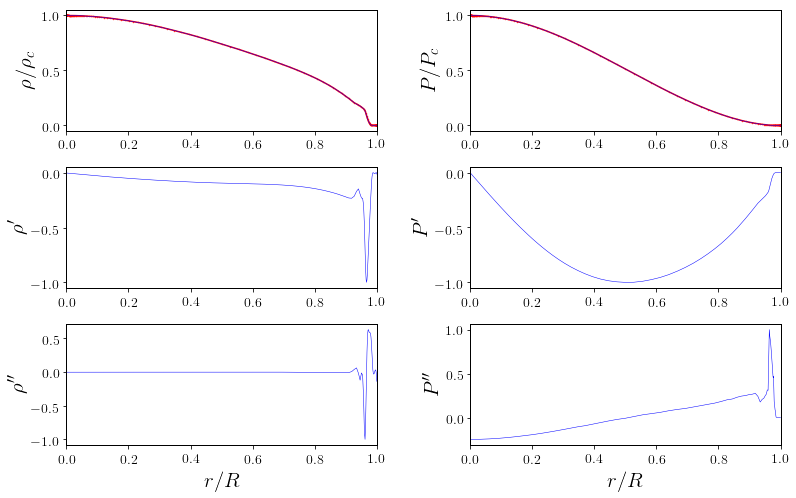

In [37]:
fig=plt.figure(figsize=[12.8,8])

plt.subplot(321)
plt.plot(ms1_150[-1]/ms1_150[-1][-1],ms1_150[2]/ms1_150[2][0],color='red',marker='o',markersize='0.4') 
plt.plot(ms1_150[-1]/ms1_150[-1][-1],ms1_150rho(ms1_150[-1])/ms1_150[2][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1) # leaving the crust out

plt.subplot(322)
plt.plot(ms1_150[-1]/ms1_150[-1][-1],ms1_150[1]/ms1_150[1][0],color='red',marker='o',markersize='0.4') 
plt.plot(ms1_150[-1]/ms1_150[-1][-1],ms1_150p(ms1_150[-1])/ms1_150[1][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$P/P_c$')
plt.xlim(0,1)

plt.subplot(323)
plt.plot(ms1_150[-1]/ms1_150[-1][-1],ms1_150drho(ms1_150[-1])/max(abs(ms1_150drho(ms1_150[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime}$')
plt.xlim(0,1)
#plt.ylim(-500,0)

plt.subplot(324)
plt.plot(ms1_150[-1]/ms1_150[-1][-1],ms1_150dp(ms1_150[-1])/max(abs(ms1_150dp(ms1_150[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime} $')
plt.xlim(0,1)

plt.subplot(325)
plt.plot(ms1_150[-1]/ms1_150[-1][-1],ms1_150ddrho(ms1_150[-1])/max(abs(ms1_150ddrho(ms1_150[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}$')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-0.01,0.01)

plt.subplot(326)
plt.plot(ms1_150[-1]/ms1_150[-1][-1],ms1_150ddp(ms1_150[-1])/max(abs(ms1_150ddp(ms1_150[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime\prime}$ ')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-1,1)

fig.subplots_adjust(hspace=0.3,wspace=0.3)

#plt.savefig('figures/ddsms1_150.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

### 15.5

In [38]:
ms1_155=np.loadtxt('results/ms1/15.5.dat',unpack=True)
ms1_155[3] = ms1_155[3]-ms1_155[3][-1] + 0.5*np.log(1-2*ms1_155[0][-1]/ms1_155[-1][-1])

In [39]:
s1=1e-5
s2=1e-9
ms1_155rho=interpolate.UnivariateSpline(ms1_155[-1], ms1_155[2], k=5, s=s1)
ms1_155drho=interpolate.UnivariateSpline(ms1_155[-1], ms1_155[2], k=5, s=s1).derivative(n=1)
ms1_155ddrho=interpolate.UnivariateSpline(ms1_155[-1], ms1_155[2], k=5, s=s1).derivative(n=2)

ms1_155p=interpolate.UnivariateSpline(ms1_155[-1], ms1_155[1], k=5, s=s2)
ms1_155dp=interpolate.UnivariateSpline(ms1_155[-1], ms1_155[1], k=5, s=s2).derivative(n=1)
ms1_155ddp=interpolate.UnivariateSpline(ms1_155[-1], ms1_155[1], k=5, s=s2).derivative(n=2)

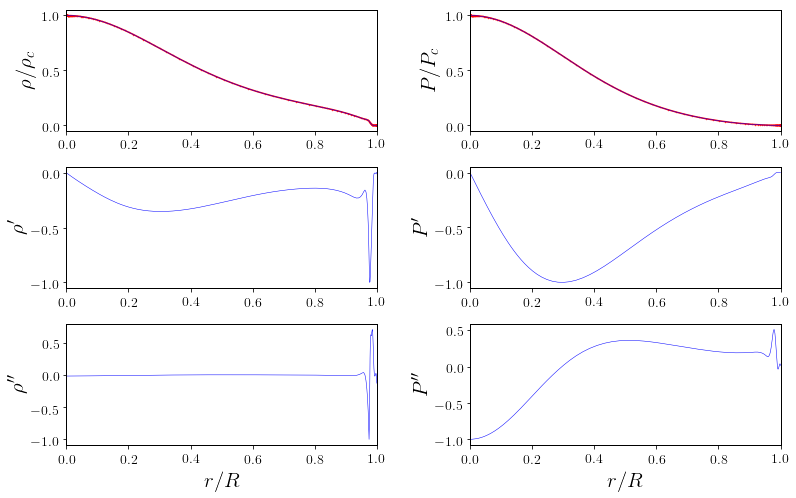

In [40]:
fig=plt.figure(figsize=[12.8,8])

plt.subplot(321)
plt.plot(ms1_155[-1]/ms1_155[-1][-1],ms1_155[2]/ms1_155[2][0],color='red',marker='o',markersize='0.4') 
plt.plot(ms1_155[-1]/ms1_155[-1][-1],ms1_155rho(ms1_155[-1])/ms1_155[2][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1) # leaving the crust out

plt.subplot(322)
plt.plot(ms1_155[-1]/ms1_155[-1][-1],ms1_155[1]/ms1_155[1][0],color='red',marker='o',markersize='0.4') 
plt.plot(ms1_155[-1]/ms1_155[-1][-1],ms1_155p(ms1_155[-1])/ms1_155[1][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$P/P_c$')
plt.xlim(0,1)

plt.subplot(323)
plt.plot(ms1_155[-1]/ms1_155[-1][-1],ms1_155drho(ms1_155[-1])/max(abs(ms1_155drho(ms1_155[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime}$')
plt.xlim(0,1)
#plt.ylim(-500,0)

plt.subplot(324)
plt.plot(ms1_155[-1]/ms1_155[-1][-1],ms1_155dp(ms1_155[-1])/max(abs(ms1_155dp(ms1_155[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime} $')
plt.xlim(0,1)

plt.subplot(325)
plt.plot(ms1_155[-1]/ms1_155[-1][-1],ms1_155ddrho(ms1_155[-1])/max(abs(ms1_155ddrho(ms1_155[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}$')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-0.01,0.01)

plt.subplot(326)
plt.plot(ms1_155[-1]/ms1_155[-1][-1],ms1_155ddp(ms1_155[-1])/max(abs(ms1_155ddp(ms1_155[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime\prime}$ ')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-1,1)

fig.subplots_adjust(hspace=0.3,wspace=0.3)

#plt.savefig('figures/ddsms1_155.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

## Redshift

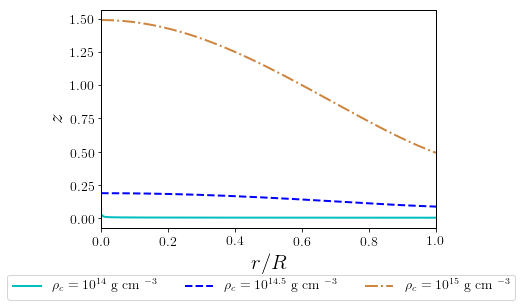

In [41]:
fig = plt.figure()

plt.plot(ms1_140[-1]/ms1_140[-1][-1],np.exp(-ms1_140[3])-1.0,color='c',linewidth='2.0',label=r'$\rho_c=10^{14}$ g cm $^{-3}$')
plt.plot(ms1_145[-1]/ms1_145[-1][-1],np.exp(-ms1_145[3])-1.0,color='blue',linewidth='2.0',linestyle='--',label=r'$\rho_c=10^{14.5}$ g cm $^{-3}$')
plt.plot(ms1_150[-1]/ms1_150[-1][-1],np.exp(-ms1_150[3])-1.0,color='peru',linewidth='2.0',linestyle='-.',label=r'$\rho_c=10^{15}$ g cm $^{-3}$')

l = plt.legend(bbox_to_anchor=(1.1,-0.15), loc="lower right", 
                bbox_transform=fig.transFigure, ncol=3)

plt.xlabel(r'$r/R$')
plt.ylabel(r'$z$')
plt.xlim(0,1.0)

plt.savefig('figures/Redshiftms1.pdf', format='pdf', dpi=1000,bbox_inches="tight")

# MS1b ---------------------------------------------------------------------------------------

In [42]:
rhoms1b,Pms1b,nms1b=np.loadtxt('EOS/ms1b.dat',usecols=(2,1,0),unpack=True)

## Dominant energy condition

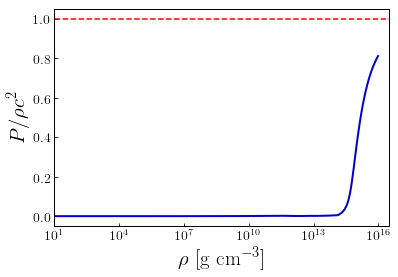

<Figure size 432x288 with 0 Axes>

In [43]:
fig, ax = plt.subplots()
plt.plot(rhoms1b,np.divide(Pms1b,rhoms1b),lw='2',color='mediumblue')
plt.plot([0,10**(17)],[1.0,1.0],'r--',lw='1.5')

ax.set_xscale("log")
#locmaj = matplotlib.ticker.LogLocator(base=10.0,numticks=16) 
#ax.xaxis.set_major_locator(locmaj)


plt.xlabel(r'$\rho$ [g\,\,cm$^{-3}$]')
plt.ylabel(r'$ P / \rho c^2 $')
#locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks=16)
#ax.xaxis.set_minor_locator(locmin)
#ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.tick_params(axis="x", direction="in")
ax.tick_params(axis="y", direction="in")
plt.xlim(10,10**(16.5))
#ax.set_facecolor('floralwhite')
#plt.gca().set_aspect('equal', adjustable='box')
#plt.draw()
#plt.ylim(0,1)
plt.savefig('figures/ECms1b.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()
plt.clf()

## Speed of sound

In [44]:
vsquared=interpolate.UnivariateSpline(rhoms1b, Pms1b, k=1, s=0).derivative(n=1)

/home/dave/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  


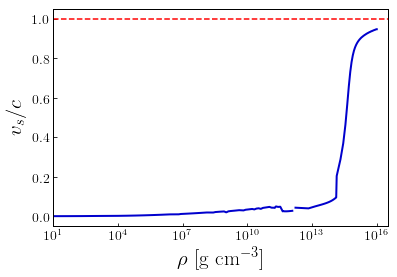

In [45]:
fig, ax = plt.subplots()
plt.plot(rhoms1b,np.sqrt(vsquared(rhoms1b)),lw='2.0',color='mediumblue')
plt.plot([1e+1,10**(16.5)],[1.0,1.0],'r--',lw='1.5')
plt.xlabel(r'$\rho$ [g\,\,cm$^{-3}$]')
plt.ylabel(r'$ v_s / c $')
plt.xscale('log')
ax.tick_params(axis="x", direction="in")
ax.tick_params(axis="y", direction="in")
plt.xlim(10,10**(16.5))
#ax.set_facecolor('floralwhite')
#mpl.rcParams['axes.linewidth'] = 1.4
#plt.gca().set_aspect('equal', adjustable='box')
#plt.draw()
plt.savefig('figures/SSms1b.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

## Adiabatic Index

In [46]:
Gamma=np.multiply(np.divide(np.add(rhoms1b,Pms1b),Pms1b),vsquared(rhoms1b))

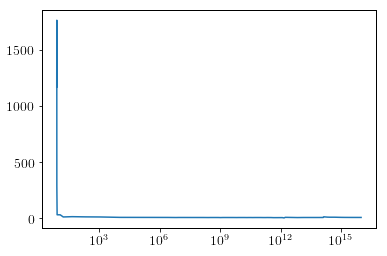

In [47]:
plt.plot(rhoms1b,Gamma)
plt.xscale('log')

$$ \langle\gamma\rangle=\frac{\int_{0}^{R} e^{(\lambda+3 \nu) } \gamma(r) P(r) r^{2} d r}{\int_{0}^{R} e^{(\lambda+3 \nu) } P(r) r^{2} d r} $$

Listing all the models calculated

In [48]:
owd=os.getcwd()
path=os.chdir('results/ms1b')
listOfEntries= os.scandir(path)
models_ms1b = []
for entry in listOfEntries:
    if '1' in entry.name:
        models_ms1b.append(entry.name)
os.chdir(owd)
models_ms1b.sort()

In [49]:
gamma_efs1 = []
gamma_efs2 = []
gamma_crs1 = []
gamma_crs2 = []
rhosc= []
for model in models_ms1b:
    m, P, rho, nu, lambd, r = np.loadtxt('results/ms1b/' + model ,unpack=True)
    nu = nu - nu[-1] + 0.5*np.log(1-2*m[-1]/r[-1])
    #lambd = np.zeros_like(r)
    #for i in range((r.shape)[0]):
    #    if i==0:
    #        lambd[i] = 0
    #    else:
    #        lambd[i] = 0.5*np.log(1/(1-2*m[i]/r[i]))
    drho=interpolate.UnivariateSpline(r, rho, k=5, s=0).derivative(n=1)
    dP=interpolate.UnivariateSpline(r, P, k=5, s=0).derivative(n=1)
    gamma = np.divide(dP(r),drho(r))
    gamma_ef1 = integrate.trapz(np.exp(lambd+3*nu)*gamma*P*(r**2),r)/integrate.trapz(np.exp(lambd+3*nu)*P*(r**2),r)
    t1 = (1/36)*integrate.trapz(np.exp((lambd+3*nu))*(16*P+(np.exp(2*lambd)-1)*(P+rho))*(np.exp(2*lambd)-1)*(r**2))/integrate.trapz(np.exp(lambd+3*nu)*P*(r**2),r)
    t2 = (4*np.pi/9)*integrate.trapz(np.exp(3*lambd+3*nu)*(8*P + (np.exp(2*lambd)+1)*(P+rho))*P*(r**4),r)/integrate.trapz(np.exp(lambd+3*nu)*P*(r**2),r)
    t3 = ((16*np.pi**2)/9)*integrate.trapz(np.exp(5*lambd+3*nu)*(P+rho)*(P**2)*(r**6),r)/integrate.trapz(np.exp(lambd+3*nu)*P*(r**2),r)
    gamma_cr1 = 4/3 + t1 + t2 + t3
    gamma_efs1.append(gamma_ef1)
    gamma_crs1.append(gamma_cr1)
    gamma_ef2 = integrate.trapz(gamma*P*r**2,r)/integrate.trapz(P*r**2,r)
    gamma_cr2 = 4/3 + (19/42)*2*m[-1]/r[-1]
    gamma_efs2.append(gamma_ef2)
    gamma_crs2.append(gamma_cr2)
    rhosc.append(rho[0]*rhodim)

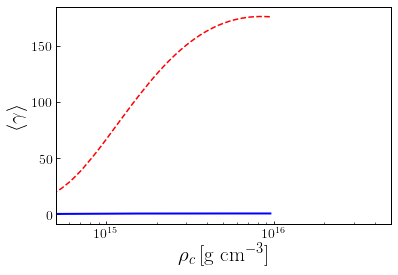

In [50]:
fig, ax = plt.subplots()
plt.plot(rhosc,gamma_crs1,lw='1.5',color='r',linestyle='--',label=r'$\gamma_{cr}$')
plt.plot(rhosc,gamma_efs1,lw='2.0',color='blue',label=r'$\langle \gamma \rangle$')

plt.xlabel(r'$\rho_c\,[$g cm$^{-3}]$')
plt.ylabel(r'$\langle \gamma \rangle$')

plt.xscale('log')
plt.xlim(left=10**(14.7),right=10**(16.7))
#plt.ylim(0,10)
ax.tick_params(axis="x", direction="in",which='both')
ax.tick_params(axis="y", direction="in",which='both')
#l = plt.legend(bbox_to_anchor=(0.85,-0.15), loc="lower right", 
                #bbox_transform=fig.transFigure, ncol=2)



plt.savefig('figures/AdiabaticIndexms1b.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

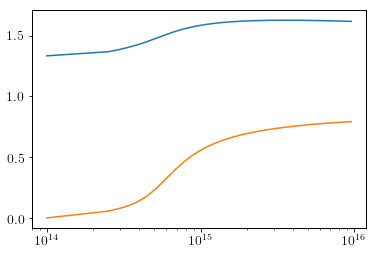

In [51]:
plt.plot(rhosc,gamma_crs2)
plt.plot(rhosc,gamma_efs2)
plt.xscale('log')

## M - $\rho_c$

In [52]:
Rms1b,Mms1b,rhocms1b=np.loadtxt('results/ms1b/MRrhoc.dat',usecols=(0,1,2),unpack=True)

In [53]:
np.amax(Mms1b)

2.77833073869

In [54]:
rhocms1b[np.argmax(Mms1b)]

1548816618910000.0

In [55]:
np.log10(rhocms1b[np.argmax(Mms1b)])

15.189999999999305

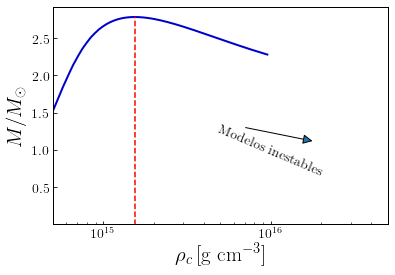

In [56]:
fig, ax = plt.subplots()

plt.plot(rhocms1b,Mms1b,color='mediumblue',lw='2.0')
plt.plot([10**(np.log10(rhocms1b[np.argmax(Mms1b)])),10**(np.log10(rhocms1b[np.argmax(Mms1b)]))],[0.0,np.amax(Mms1b)],'r--',lw='1.5')

prop = dict(arrowstyle="-|>,head_width=0.4,head_length=0.8",
            shrinkA=0,shrinkB=0)
plt.annotate("", xy=(10**(16.25),1.12), xytext=(10**(15.85),1.3), arrowprops=prop)
#plt.arrow(10**(15.6), 1.38,10**(15.7) ,-0.1 , head_width=0.05, head_lms1bth=10**(15))
plt.text(10**(15.67), 1.23, 'Modelos inestables' , fontsize=14,rotation=-23)

plt.xscale('log')
plt.xlabel(r'$\rho_c\,[$g cm$^{-3}]$')
plt.ylabel(r'$M/M_{\odot}$')
plt.xlim(left=10**(14.7),right=10**(16.7))
plt.ylim(bottom=0.01)
ax.tick_params(axis="x", direction="in",which='both')
ax.tick_params(axis="y", direction="in",which='both')

plt.savefig('figures/Mrhorel_ms1b.pdf', format='pdf', dpi=1000,bbox_inches="tight")

## Tunning the interpolation of the solution

### 14.0

In [57]:
ms1b_140=np.loadtxt('results/ms1b/14.0.dat',unpack=True)
ms1b_140[3] = ms1b_140[3]-ms1b_140[3][-1] + 0.5*np.log(1-2*ms1b_140[0][-1]/ms1b_140[-1][-1])

In [58]:
s1=5e-7
s2=1e-15
ms1b_140rho=interpolate.UnivariateSpline(ms1b_140[-1], ms1b_140[2], k=5, s=s1)
ms1b_140drho=interpolate.UnivariateSpline(ms1b_140[-1], ms1b_140[2], k=5, s=s1).derivative(n=1)
ms1b_140ddrho=interpolate.UnivariateSpline(ms1b_140[-1], ms1b_140[2], k=5, s=s1).derivative(n=2)

ms1b_140p=interpolate.UnivariateSpline(ms1b_140[-1], ms1b_140[1], k=5, s=s2)
ms1b_140dp=interpolate.UnivariateSpline(ms1b_140[-1], ms1b_140[1], k=5, s=s2).derivative(n=1)
ms1b_140ddp=interpolate.UnivariateSpline(ms1b_140[-1], ms1b_140[1], k=5, s=s2).derivative(n=2)

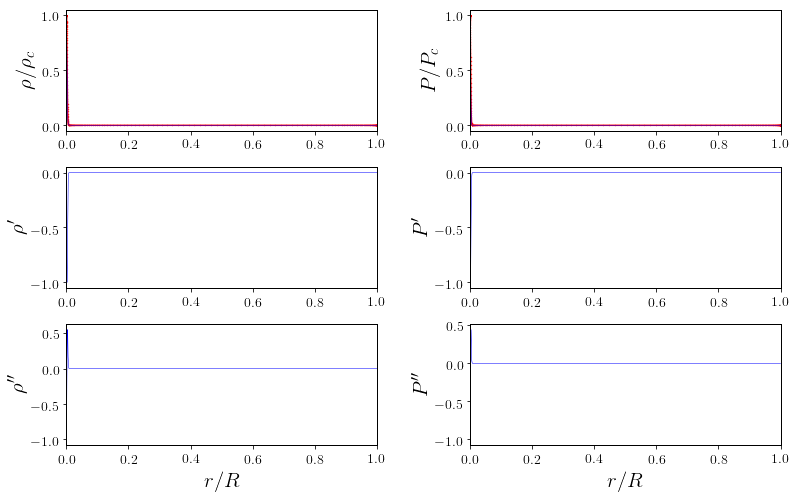

In [59]:
fig=plt.figure(figsize=[12.8,8])

plt.subplot(321)
plt.plot(ms1b_140[-1]/ms1b_140[-1][-1],ms1b_140[2]/ms1b_140[2][0],color='red',marker='o',markersize='0.4') 
plt.plot(ms1b_140[-1]/ms1b_140[-1][-1],ms1b_140rho(ms1b_140[-1])/ms1b_140[2][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1) # leaving the crust out

plt.subplot(322)
plt.plot(ms1b_140[-1]/ms1b_140[-1][-1],ms1b_140[1]/ms1b_140[1][0],color='red',marker='o',markersize='0.4') 
plt.plot(ms1b_140[-1]/ms1b_140[-1][-1],ms1b_140p(ms1b_140[-1])/ms1b_140[1][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$P/P_c$')
plt.xlim(0,1)

plt.subplot(323)
plt.plot(ms1b_140[-1]/ms1b_140[-1][-1],ms1b_140drho(ms1b_140[-1])/max(abs(ms1b_140drho(ms1b_140[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime}$')
plt.xlim(0,1)
#plt.ylim(-500,0)

plt.subplot(324)
plt.plot(ms1b_140[-1]/ms1b_140[-1][-1],ms1b_140dp(ms1b_140[-1])/max(abs(ms1b_140dp(ms1b_140[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime} $')
plt.xlim(0,1)

plt.subplot(325)
plt.plot(ms1b_140[-1]/ms1b_140[-1][-1],ms1b_140ddrho(ms1b_140[-1])/max(abs(ms1b_140ddrho(ms1b_140[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}$')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-0.01,0.01)

plt.subplot(326)
plt.plot(ms1b_140[-1]/ms1b_140[-1][-1],ms1b_140ddp(ms1b_140[-1])/max(abs(ms1b_140ddp(ms1b_140[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime\prime}$ ')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-1,1)

fig.subplots_adjust(hspace=0.3,wspace=0.3)
\checkmark
#plt.savefig('figures/ddsms1b_140.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

### 14.5

In [60]:
ms1b_145=np.loadtxt('results/ms1b/14.5.dat',unpack=True)
ms1b_145[3] = ms1b_145[3]-ms1b_145[3][-1] + 0.5*np.log(1-2*ms1b_145[0][-1]/ms1b_145[-1][-1])

In [61]:
s1=1e-7
s2=1e-12
ms1b_145rho=interpolate.UnivariateSpline(ms1b_145[-1], ms1b_145[2], k=5, s=s1)
ms1b_145drho=interpolate.UnivariateSpline(ms1b_145[-1], ms1b_145[2], k=5, s=s1).derivative(n=1)
ms1b_145ddrho=interpolate.UnivariateSpline(ms1b_145[-1], ms1b_145[2], k=5, s=s1).derivative(n=2)

ms1b_145p=interpolate.UnivariateSpline(ms1b_145[-1], ms1b_145[1], k=5, s=s2)
ms1b_145dp=interpolate.UnivariateSpline(ms1b_145[-1], ms1b_145[1], k=5, s=s2).derivative(n=1)
ms1b_145ddp=interpolate.UnivariateSpline(ms1b_145[-1], ms1b_145[1], k=5, s=s2).derivative(n=2)

In [62]:
ms1b_145rho(0.4*ms1b_145[-1][-1])*rhodim

272767365799188.47

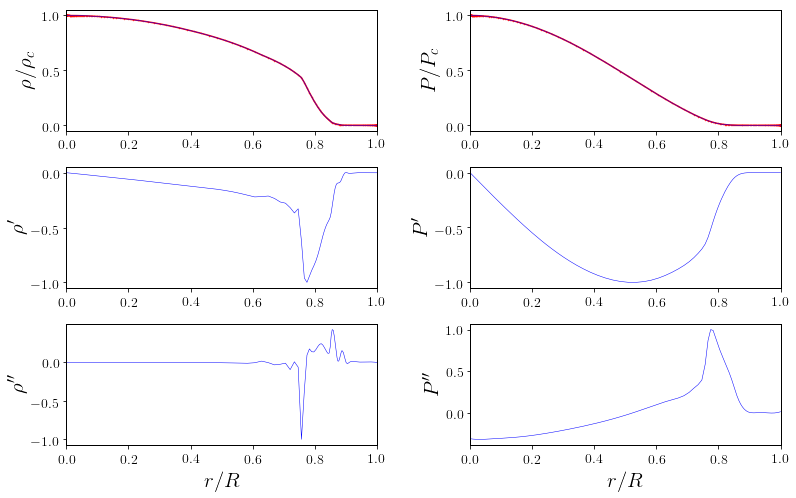

In [63]:
fig=plt.figure(figsize=[12.8,8])

plt.subplot(321)
plt.plot(ms1b_145[-1]/ms1b_145[-1][-1],ms1b_145[2]/ms1b_145[2][0],color='red',marker='o',markersize='0.4') 
plt.plot(ms1b_145[-1]/ms1b_145[-1][-1],ms1b_145rho(ms1b_145[-1])/ms1b_145[2][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1) # leaving the crust out

plt.subplot(322)
plt.plot(ms1b_145[-1]/ms1b_145[-1][-1],ms1b_145[1]/ms1b_145[1][0],color='red',marker='o',markersize='0.4') 
plt.plot(ms1b_145[-1]/ms1b_145[-1][-1],ms1b_145p(ms1b_145[-1])/ms1b_145[1][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$P/P_c$')
plt.xlim(0,1)

plt.subplot(323)
plt.plot(ms1b_145[-1]/ms1b_145[-1][-1],ms1b_145drho(ms1b_145[-1])/max(abs(ms1b_145drho(ms1b_145[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime}$')
plt.xlim(0,1)
#plt.ylim(-500,0)

plt.subplot(324)
plt.plot(ms1b_145[-1]/ms1b_145[-1][-1],ms1b_145dp(ms1b_145[-1])/max(abs(ms1b_145dp(ms1b_145[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime} $')
plt.xlim(0,1)

plt.subplot(325)
plt.plot(ms1b_145[-1]/ms1b_145[-1][-1],ms1b_145ddrho(ms1b_145[-1])/max(abs(ms1b_145ddrho(ms1b_145[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}$')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-0.01,0.01)

plt.subplot(326)
plt.plot(ms1b_145[-1]/ms1b_145[-1][-1],ms1b_145ddp(ms1b_145[-1])/max(abs(ms1b_145ddp(ms1b_145[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime\prime}$ ')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-1,1)

fig.subplots_adjust(hspace=0.3,wspace=0.3)

#plt.savefig('figures/ddsms1b_145.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

### 15.0

In [64]:
ms1b_150=np.loadtxt('results/ms1b/15.0.dat',unpack=True)
ms1b_150[3] = ms1b_150[3]-ms1b_150[3][-1] + 0.5*np.log(1-2*ms1b_150[0][-1]/ms1b_150[-1][-1])

In [65]:
s1=8e-6
s2=1e-15
ms1b_150rho=interpolate.UnivariateSpline(ms1b_150[-1], ms1b_150[2], k=5, s=s1)
ms1b_150drho=interpolate.UnivariateSpline(ms1b_150[-1], ms1b_150[2], k=5, s=s1).derivative(n=1)
ms1b_150ddrho=interpolate.UnivariateSpline(ms1b_150[-1], ms1b_150[2], k=5, s=s1).derivative(n=2)

ms1b_150p=interpolate.UnivariateSpline(ms1b_150[-1], ms1b_150[1], k=5, s=s2)
ms1b_150dp=interpolate.UnivariateSpline(ms1b_150[-1], ms1b_150[1], k=5, s=s2).derivative(n=1)
ms1b_150ddp=interpolate.UnivariateSpline(ms1b_150[-1], ms1b_150[1], k=5, s=s2).derivative(n=2)

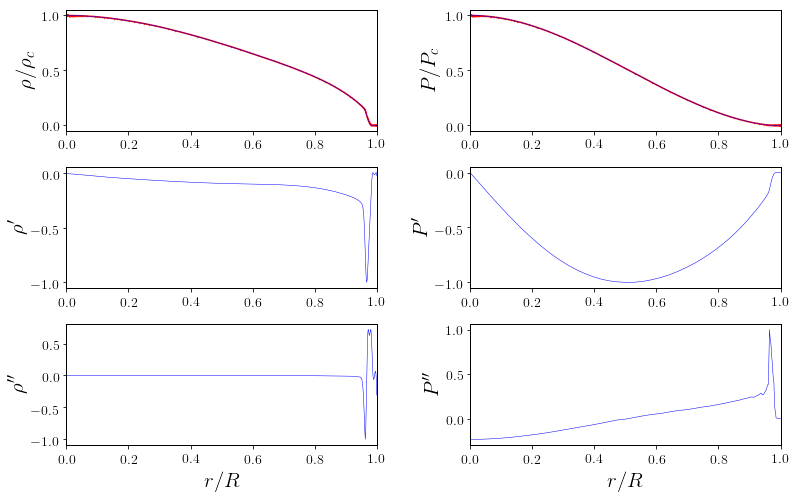

In [66]:
fig=plt.figure(figsize=[12.8,8])

plt.subplot(321)
plt.plot(ms1b_150[-1]/ms1b_150[-1][-1],ms1b_150[2]/ms1b_150[2][0],color='red',marker='o',markersize='0.4') 
plt.plot(ms1b_150[-1]/ms1b_150[-1][-1],ms1b_150rho(ms1b_150[-1])/ms1b_150[2][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1) # leaving the crust out

plt.subplot(322)
plt.plot(ms1b_150[-1]/ms1b_150[-1][-1],ms1b_150[1]/ms1b_150[1][0],color='red',marker='o',markersize='0.4') 
plt.plot(ms1b_150[-1]/ms1b_150[-1][-1],ms1b_150p(ms1b_150[-1])/ms1b_150[1][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$P/P_c$')
plt.xlim(0,1)

plt.subplot(323)
plt.plot(ms1b_150[-1]/ms1b_150[-1][-1],ms1b_150drho(ms1b_150[-1])/max(abs(ms1b_150drho(ms1b_150[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime}$')
plt.xlim(0,1)
#plt.ylim(-500,0)

plt.subplot(324)
plt.plot(ms1b_150[-1]/ms1b_150[-1][-1],ms1b_150dp(ms1b_150[-1])/max(abs(ms1b_150dp(ms1b_150[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime} $')
plt.xlim(0,1)

plt.subplot(325)
plt.plot(ms1b_150[-1]/ms1b_150[-1][-1],ms1b_150ddrho(ms1b_150[-1])/max(abs(ms1b_150ddrho(ms1b_150[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}$')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-0.01,0.01)

plt.subplot(326)
plt.plot(ms1b_150[-1]/ms1b_150[-1][-1],ms1b_150ddp(ms1b_150[-1])/max(abs(ms1b_150ddp(ms1b_150[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime\prime}$ ')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-1,1)

fig.subplots_adjust(hspace=0.3,wspace=0.3)

#plt.savefig('figures/ddsms1b_150.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

### 15.5

In [67]:
ms1b_155=np.loadtxt('results/ms1b/15.5.dat',unpack=True)
ms1b_155[3] = ms1b_155[3]-ms1b_155[3][-1] + 0.5*np.log(1-2*ms1b_155[0][-1]/ms1b_155[-1][-1])

In [68]:
s1=1e-5
s2=1e-9
ms1b_155rho=interpolate.UnivariateSpline(ms1b_155[-1], ms1b_155[2], k=5, s=s1)
ms1b_155drho=interpolate.UnivariateSpline(ms1b_155[-1], ms1b_155[2], k=5, s=s1).derivative(n=1)
ms1b_155ddrho=interpolate.UnivariateSpline(ms1b_155[-1], ms1b_155[2], k=5, s=s1).derivative(n=2)

ms1b_155p=interpolate.UnivariateSpline(ms1b_155[-1], ms1b_155[1], k=5, s=s2)
ms1b_155dp=interpolate.UnivariateSpline(ms1b_155[-1], ms1b_155[1], k=5, s=s2).derivative(n=1)
ms1b_155ddp=interpolate.UnivariateSpline(ms1b_155[-1], ms1b_155[1], k=5, s=s2).derivative(n=2)

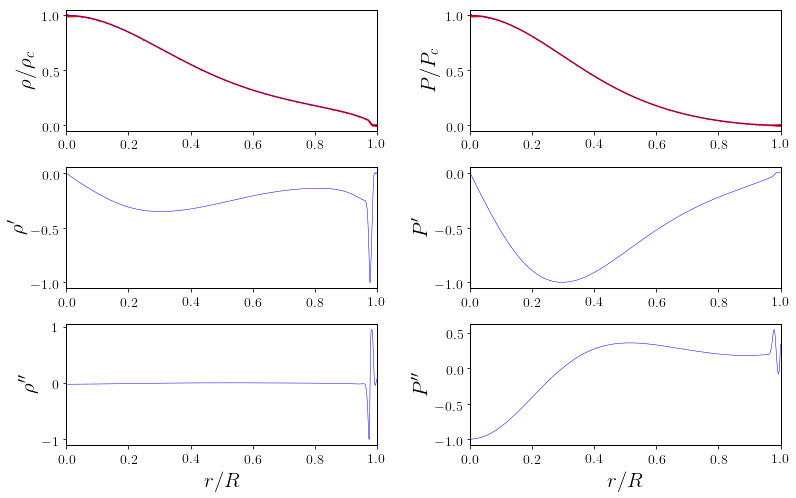

In [69]:
fig=plt.figure(figsize=[12.8,8])

plt.subplot(321)
plt.plot(ms1b_155[-1]/ms1b_155[-1][-1],ms1b_155[2]/ms1b_155[2][0],color='red',marker='o',markersize='0.4') 
plt.plot(ms1b_155[-1]/ms1b_155[-1][-1],ms1b_155rho(ms1b_155[-1])/ms1b_155[2][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1) # leaving the crust out

plt.subplot(322)
plt.plot(ms1b_155[-1]/ms1b_155[-1][-1],ms1b_155[1]/ms1b_155[1][0],color='red',marker='o',markersize='0.4') 
plt.plot(ms1b_155[-1]/ms1b_155[-1][-1],ms1b_155p(ms1b_155[-1])/ms1b_155[1][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$P/P_c$')
plt.xlim(0,1)

plt.subplot(323)
plt.plot(ms1b_155[-1]/ms1b_155[-1][-1],ms1b_155drho(ms1b_155[-1])/max(abs(ms1b_155drho(ms1b_155[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime}$')
plt.xlim(0,1)
#plt.ylim(-500,0)

plt.subplot(324)
plt.plot(ms1b_155[-1]/ms1b_155[-1][-1],ms1b_155dp(ms1b_155[-1])/max(abs(ms1b_155dp(ms1b_155[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime} $')
plt.xlim(0,1)

plt.subplot(325)
plt.plot(ms1b_155[-1]/ms1b_155[-1][-1],ms1b_155ddrho(ms1b_155[-1])/max(abs(ms1b_155ddrho(ms1b_155[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}$')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-0.01,0.01)

plt.subplot(326)
plt.plot(ms1b_155[-1]/ms1b_155[-1][-1],ms1b_155ddp(ms1b_155[-1])/max(abs(ms1b_155ddp(ms1b_155[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime\prime}$ ')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-1,1)

fig.subplots_adjust(hspace=0.3,wspace=0.3)

#plt.savefig('figures/ddsms1b_155.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

## Redshift

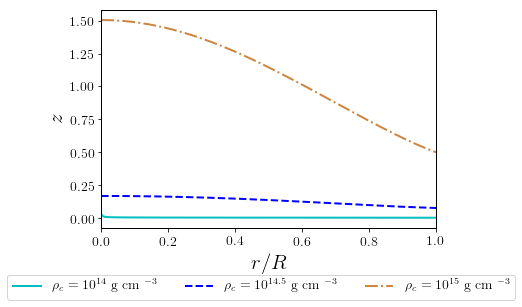

In [70]:
fig = plt.figure()

plt.plot(ms1b_140[-1]/ms1b_140[-1][-1],np.exp(-ms1b_140[3])-1.0,color='c',linewidth='2.0',label=r'$\rho_c=10^{14}$ g cm $^{-3}$')
plt.plot(ms1b_145[-1]/ms1b_145[-1][-1],np.exp(-ms1b_145[3])-1.0,color='blue',linewidth='2.0',linestyle='--',label=r'$\rho_c=10^{14.5}$ g cm $^{-3}$')
plt.plot(ms1b_150[-1]/ms1b_150[-1][-1],np.exp(-ms1b_150[3])-1.0,color='peru',linewidth='2.0',linestyle='-.',label=r'$\rho_c=10^{15}$ g cm $^{-3}$')

l = plt.legend(bbox_to_anchor=(1.1,-0.15), loc="lower right", 
                bbox_transform=fig.transFigure, ncol=3)

plt.xlabel(r'$r/R$')
plt.ylabel(r'$z$')
plt.xlim(0,1.0)

plt.savefig('figures/Redshiftms1b.pdf', format='pdf', dpi=1000,bbox_inches="tight")

# MS2 -----------------------------------------------------------------------------------------

In [71]:
rhoms2,Pms2,nms2=np.loadtxt('EOS/ms2.dat',usecols=(2,1,0),unpack=True)

## Dominant energy condition

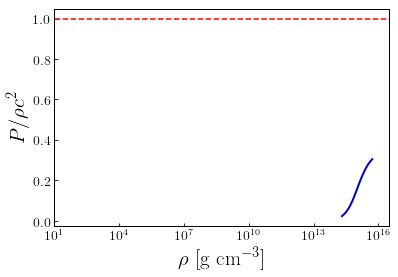

<Figure size 432x288 with 0 Axes>

In [72]:
fig, ax = plt.subplots()
plt.plot(rhoms2,np.divide(Pms2,rhoms2),lw='2',color='mediumblue')
plt.plot([0,10**(17)],[1.0,1.0],'r--',lw='1.5')

ax.set_xscale("log")
#locmaj = matplotlib.ticker.LogLocator(base=10.0,numticks=16) 
#ax.xaxis.set_major_locator(locmaj)


plt.xlabel(r'$\rho$ [g\,\,cm$^{-3}$]')
plt.ylabel(r'$ P / \rho c^2 $')
#locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks=16)
#ax.xaxis.set_minor_locator(locmin)
#ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.tick_params(axis="x", direction="in")
ax.tick_params(axis="y", direction="in")
plt.xlim(10,10**(16.5))
#ax.set_facecolor('floralwhite')
#plt.gca().set_aspect('equal', adjustable='box')
#plt.draw()
#plt.ylim(0,1)
plt.savefig('figures/ECms2.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()
plt.clf()

## Speed of sound

In [73]:
vsquared=interpolate.UnivariateSpline(rhoms2, Pms2, k=1, s=0).derivative(n=1)

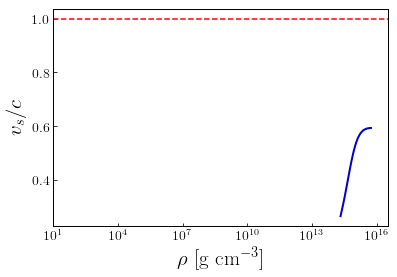

In [74]:
fig, ax = plt.subplots()
plt.plot(rhoms2,np.sqrt(vsquared(rhoms2)),lw='2.0',color='mediumblue')
plt.plot([1e+1,10**(16.5)],[1.0,1.0],'r--',lw='1.5')
plt.xlabel(r'$\rho$ [g\,\,cm$^{-3}$]')
plt.ylabel(r'$ v_s / c $')
plt.xscale('log')
ax.tick_params(axis="x", direction="in")
ax.tick_params(axis="y", direction="in")
plt.xlim(10,10**(16.5))
#ax.set_facecolor('floralwhite')
#mpl.rcParams['axes.linewidth'] = 1.4
#plt.gca().set_aspect('equal', adjustable='box')
#plt.draw()
plt.savefig('figures/SSms2.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

## Adiabatic Index

In [75]:
Gamma=np.multiply(np.divide(np.add(rhoms2,Pms2),Pms2),vsquared(rhoms2))

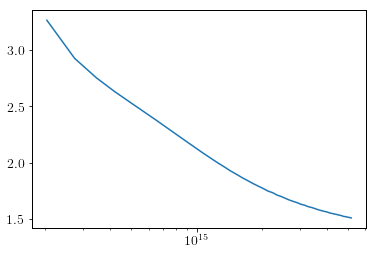

In [76]:
plt.plot(rhoms2,Gamma)
plt.xscale('log')

$$ \langle\gamma\rangle=\frac{\int_{0}^{R} e^{(\lambda+3 \nu) } \gamma(r) P(r) r^{2} d r}{\int_{0}^{R} e^{(\lambda+3 \nu) } P(r) r^{2} d r} $$

Listing all the models calculated

In [77]:
owd=os.getcwd()
path=os.chdir('results/ms2')
listOfEntries= os.scandir(path)
models_ms2 = []
for entry in listOfEntries:
    if '1' in entry.name:
        models_ms2.append(entry.name)
os.chdir(owd)
models_ms2.sort()

In [78]:
gamma_efs1 = []
gamma_efs2 = []
gamma_crs1 = []
gamma_crs2 = []
rhosc= []
for model in models_ms2:
    m, P, rho, nu, lambd, r = np.loadtxt('results/ms2/' + model ,unpack=True)
    nu = nu - nu[-1] + 0.5*np.log(1-2*m[-1]/r[-1])
    #lambd = np.zeros_like(r)
    #for i in range((r.shape)[0]):
    #    if i==0:
    #        lambd[i] = 0
    #    else:
    #        lambd[i] = 0.5*np.log(1/(1-2*m[i]/r[i]))
    drho=interpolate.UnivariateSpline(r, rho, k=5, s=0).derivative(n=1)
    dP=interpolate.UnivariateSpline(r, P, k=5, s=0).derivative(n=1)
    gamma = np.divide(dP(r),drho(r))
    gamma_ef1 = integrate.trapz(np.exp(lambd+3*nu)*gamma*P*(r**2),r)/integrate.trapz(np.exp(lambd+3*nu)*P*(r**2),r)
    t1 = (1/36)*integrate.trapz(np.exp((lambd+3*nu))*(16*P+(np.exp(2*lambd)-1)*(P+rho))*(np.exp(2*lambd)-1)*(r**2))/integrate.trapz(np.exp(lambd+3*nu)*P*(r**2),r)
    t2 = (4*np.pi/9)*integrate.trapz(np.exp(3*lambd+3*nu)*(8*P + (np.exp(2*lambd)+1)*(P+rho))*P*(r**4),r)/integrate.trapz(np.exp(lambd+3*nu)*P*(r**2),r)
    t3 = ((16*np.pi**2)/9)*integrate.trapz(np.exp(5*lambd+3*nu)*(P+rho)*(P**2)*(r**6),r)/integrate.trapz(np.exp(lambd+3*nu)*P*(r**2),r)
    gamma_cr1 = 4/3 + t1 + t2 + t3
    gamma_efs1.append(gamma_ef1)
    gamma_crs1.append(gamma_cr1)
    gamma_ef2 = integrate.trapz(gamma*P*r**2,r)/integrate.trapz(P*r**2,r)
    gamma_cr2 = 4/3 + (19/42)*2*m[-1]/r[-1]
    gamma_efs2.append(gamma_ef2)
    gamma_crs2.append(gamma_cr2)
    rhosc.append(rho[0]*rhodim)

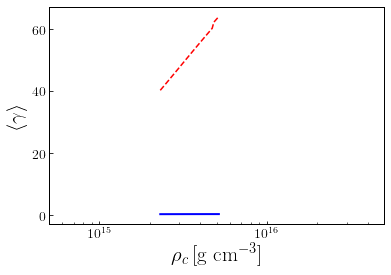

In [79]:
fig, ax = plt.subplots()
plt.plot(rhosc,gamma_crs1,lw='1.5',color='r',linestyle='--',label=r'$\gamma_{cr}$')
plt.plot(rhosc,gamma_efs1,lw='2.0',color='blue',label=r'$\langle \gamma \rangle$')

plt.xlabel(r'$\rho_c\,[$g cm$^{-3}]$')
plt.ylabel(r'$\langle \gamma \rangle$')

plt.xscale('log')
plt.xlim(left=10**(14.7),right=10**(16.7))
#plt.ylim(0,10)
ax.tick_params(axis="x", direction="in",which='both')
ax.tick_params(axis="y", direction="in",which='both')
#l = plt.legend(bbox_to_anchor=(0.85,-0.15), loc="lower right", 
                #bbox_transform=fig.transFigure, ncol=2)



plt.savefig('figures/AdiabaticIndexms2.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

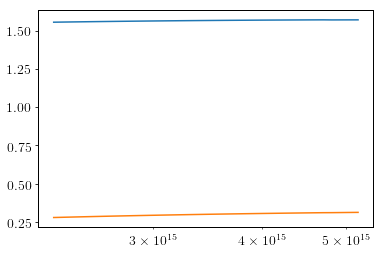

In [80]:
plt.plot(rhosc,gamma_crs2)
plt.plot(rhosc,gamma_efs2)
plt.xscale('log')

## M - $\rho_c$

In [81]:
Rms2,Mms2,rhocms2=np.loadtxt('results/ms2/MRrhoc.dat',usecols=(0,1,2),unpack=True)

In [82]:
np.amax(Mms2)

1.6988065854

In [83]:
rhocms2[np.argmax(Mms2)]

2415833213280000.0

In [84]:
np.log10(rhocms2[np.argmax(Mms2)])

15.383066947725379

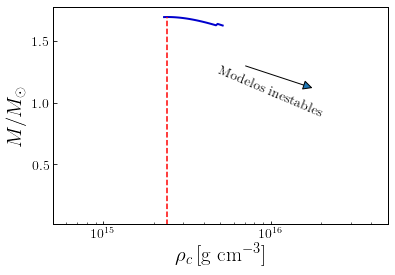

In [85]:
fig, ax = plt.subplots()

plt.plot(rhocms2,Mms2,color='mediumblue',lw='2.0')
plt.plot([10**(np.log10(rhocms2[np.argmax(Mms2)])),10**(np.log10(rhocms2[np.argmax(Mms2)]))],[0.0,np.amax(Mms2)],'r--',lw='1.5')

prop = dict(arrowstyle="-|>,head_width=0.4,head_length=0.8",
            shrinkA=0,shrinkB=0)
plt.annotate("", xy=(10**(16.25),1.12), xytext=(10**(15.85),1.3), arrowprops=prop)
#plt.arrow(10**(15.6), 1.38,10**(15.7) ,-0.1 , head_width=0.05, head_lms2th=10**(15))
plt.text(10**(15.67), 1.23, 'Modelos inestables' , fontsize=14,rotation=-23)

plt.xscale('log')
plt.xlabel(r'$\rho_c\,[$g cm$^{-3}]$')
plt.ylabel(r'$M/M_{\odot}$')
plt.xlim(left=10**(14.7),right=10**(16.7))
plt.ylim(bottom=0.01)
ax.tick_params(axis="x", direction="in",which='both')
ax.tick_params(axis="y", direction="in",which='both')

plt.savefig('figures/Mrhorel_ms2.pdf', format='pdf', dpi=1000,bbox_inches="tight")

## Tunning the interpolation of the solution

### 15.36

In [87]:
ms2_1536=np.loadtxt('results/ms2/15.3630669477.dat',unpack=True)
ms2_1536[3] = ms2_1536[3]-ms2_1536[3][-1] + 0.5*np.log(1-2*ms2_1536[0][-1]/ms2_1536[-1][-1])

In [90]:
s1=5e-10
s2=1e-15
ms2_1536rho=interpolate.UnivariateSpline(ms2_1536[-1], ms2_1536[2], k=5, s=s1)
ms2_1536drho=interpolate.UnivariateSpline(ms2_1536[-1], ms2_1536[2], k=5, s=s1).derivative(n=1)
ms2_1536ddrho=interpolate.UnivariateSpline(ms2_1536[-1], ms2_1536[2], k=5, s=s1).derivative(n=2)

ms2_1536p=interpolate.UnivariateSpline(ms2_1536[-1], ms2_1536[1], k=5, s=s2)
ms2_1536dp=interpolate.UnivariateSpline(ms2_1536[-1], ms2_1536[1], k=5, s=s2).derivative(n=1)
ms2_1536ddp=interpolate.UnivariateSpline(ms2_1536[-1], ms2_1536[1], k=5, s=s2).derivative(n=2)

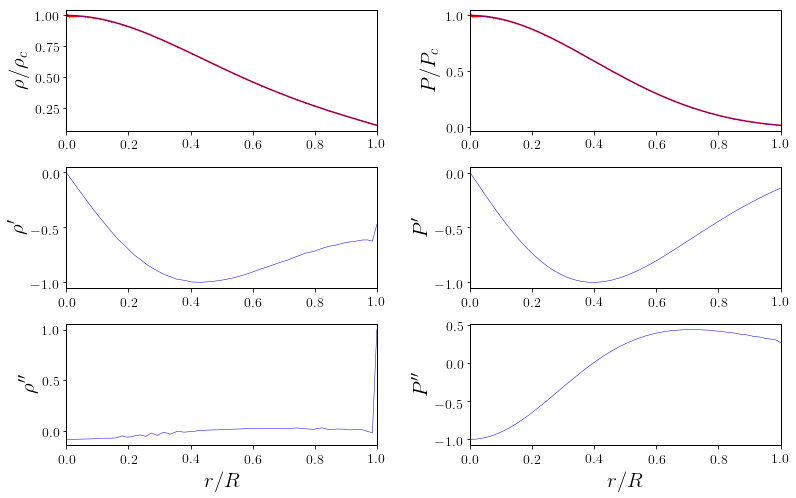

In [91]:
fig=plt.figure(figsize=[12.8,8])

plt.subplot(321)
plt.plot(ms2_1536[-1]/ms2_1536[-1][-1],ms2_1536[2]/ms2_1536[2][0],color='red',marker='o',markersize='0.4') 
plt.plot(ms2_1536[-1]/ms2_1536[-1][-1],ms2_1536rho(ms2_1536[-1])/ms2_1536[2][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1) # leaving the crust out

plt.subplot(322)
plt.plot(ms2_1536[-1]/ms2_1536[-1][-1],ms2_1536[1]/ms2_1536[1][0],color='red',marker='o',markersize='0.4') 
plt.plot(ms2_1536[-1]/ms2_1536[-1][-1],ms2_1536p(ms2_1536[-1])/ms2_1536[1][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$P/P_c$')
plt.xlim(0,1)

plt.subplot(323)
plt.plot(ms2_1536[-1]/ms2_1536[-1][-1],ms2_1536drho(ms2_1536[-1])/max(abs(ms2_1536drho(ms2_1536[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime}$')
plt.xlim(0,1)
#plt.ylim(-500,0)

plt.subplot(324)
plt.plot(ms2_1536[-1]/ms2_1536[-1][-1],ms2_1536dp(ms2_1536[-1])/max(abs(ms2_1536dp(ms2_1536[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime} $')
plt.xlim(0,1)

plt.subplot(325)
plt.plot(ms2_1536[-1]/ms2_1536[-1][-1],ms2_1536ddrho(ms2_1536[-1])/max(abs(ms2_1536ddrho(ms2_1536[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}$')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-0.01,0.01)

plt.subplot(326)
plt.plot(ms2_1536[-1]/ms2_1536[-1][-1],ms2_1536ddp(ms2_1536[-1])/max(abs(ms2_1536ddp(ms2_1536[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime\prime}$ ')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-1,1)

fig.subplots_adjust(hspace=0.3,wspace=0.3)

#plt.savefig('figures/ddsms2_1536.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

### 15.37

In [92]:
ms2_1537=np.loadtxt('results/ms2/15.3730669477.dat',unpack=True)
ms2_1537[3] = ms2_1537[3]-ms2_1537[3][-1] + 0.5*np.log(1-2*ms2_1537[0][-1]/ms2_1537[-1][-1])

In [93]:
s1=8e-6
s2=1e-15
ms2_1537rho=interpolate.UnivariateSpline(ms2_1537[-1], ms2_1537[2], k=5, s=s1)
ms2_1537drho=interpolate.UnivariateSpline(ms2_1537[-1], ms2_1537[2], k=5, s=s1).derivative(n=1)
ms2_1537ddrho=interpolate.UnivariateSpline(ms2_1537[-1], ms2_1537[2], k=5, s=s1).derivative(n=2)

ms2_1537p=interpolate.UnivariateSpline(ms2_1537[-1], ms2_1537[1], k=5, s=s2)
ms2_1537dp=interpolate.UnivariateSpline(ms2_1537[-1], ms2_1537[1], k=5, s=s2).derivative(n=1)
ms2_1537ddp=interpolate.UnivariateSpline(ms2_1537[-1], ms2_1537[1], k=5, s=s2).derivative(n=2)

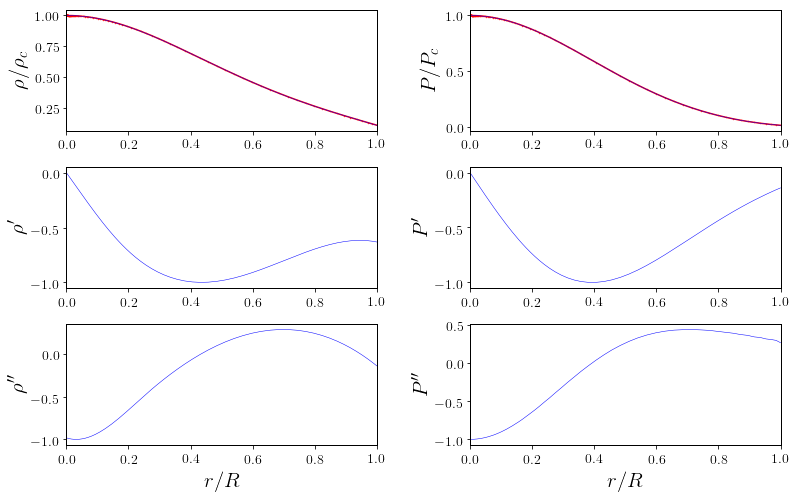

In [94]:
fig=plt.figure(figsize=[12.8,8])

plt.subplot(321)
plt.plot(ms2_1537[-1]/ms2_1537[-1][-1],ms2_1537[2]/ms2_1537[2][0],color='red',marker='o',markersize='0.4') 
plt.plot(ms2_1537[-1]/ms2_1537[-1][-1],ms2_1537rho(ms2_1537[-1])/ms2_1537[2][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1) # leaving the crust out

plt.subplot(322)
plt.plot(ms2_1537[-1]/ms2_1537[-1][-1],ms2_1537[1]/ms2_1537[1][0],color='red',marker='o',markersize='0.4') 
plt.plot(ms2_1537[-1]/ms2_1537[-1][-1],ms2_1537p(ms2_1537[-1])/ms2_1537[1][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$P/P_c$')
plt.xlim(0,1)

plt.subplot(323)
plt.plot(ms2_1537[-1]/ms2_1537[-1][-1],ms2_1537drho(ms2_1537[-1])/max(abs(ms2_1537drho(ms2_1537[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime}$')
plt.xlim(0,1)
#plt.ylim(-500,0)

plt.subplot(324)
plt.plot(ms2_1537[-1]/ms2_1537[-1][-1],ms2_1537dp(ms2_1537[-1])/max(abs(ms2_1537dp(ms2_1537[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime} $')
plt.xlim(0,1)

plt.subplot(325)
plt.plot(ms2_1537[-1]/ms2_1537[-1][-1],ms2_1537ddrho(ms2_1537[-1])/max(abs(ms2_1537ddrho(ms2_1537[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}$')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-0.01,0.01)

plt.subplot(326)
plt.plot(ms2_1537[-1]/ms2_1537[-1][-1],ms2_1537ddp(ms2_1537[-1])/max(abs(ms2_1537ddp(ms2_1537[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime\prime}$ ')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-1,1)

fig.subplots_adjust(hspace=0.3,wspace=0.3)

#plt.savefig('figures/ddsms2_1537.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

### 15.5

In [ ]:
ms2_155=np.loadtxt('results/ms2/15.5.dat',unpack=True)
ms2_155[3] = ms2_155[3]-ms2_155[3][-1] + 0.5*np.log(1-2*ms2_155[0][-1]/ms2_155[-1][-1])

In [ ]:
s1=1e-5
s2=1e-9
ms2_155rho=interpolate.UnivariateSpline(ms2_155[-1], ms2_155[2], k=5, s=s1)
ms2_155drho=interpolate.UnivariateSpline(ms2_155[-1], ms2_155[2], k=5, s=s1).derivative(n=1)
ms2_155ddrho=interpolate.UnivariateSpline(ms2_155[-1], ms2_155[2], k=5, s=s1).derivative(n=2)

ms2_155p=interpolate.UnivariateSpline(ms2_155[-1], ms2_155[1], k=5, s=s2)
ms2_155dp=interpolate.UnivariateSpline(ms2_155[-1], ms2_155[1], k=5, s=s2).derivative(n=1)
ms2_155ddp=interpolate.UnivariateSpline(ms2_155[-1], ms2_155[1], k=5, s=s2).derivative(n=2)

In [ ]:
fig=plt.figure(figsize=[12.8,8])

plt.subplot(321)
plt.plot(ms2_155[-1]/ms2_155[-1][-1],ms2_155[2]/ms2_155[2][0],color='red',marker='o',markersize='0.4') 
plt.plot(ms2_155[-1]/ms2_155[-1][-1],ms2_155rho(ms2_155[-1])/ms2_155[2][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1) # leaving the crust out

plt.subplot(322)
plt.plot(ms2_155[-1]/ms2_155[-1][-1],ms2_155[1]/ms2_155[1][0],color='red',marker='o',markersize='0.4') 
plt.plot(ms2_155[-1]/ms2_155[-1][-1],ms2_155p(ms2_155[-1])/ms2_155[1][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$P/P_c$')
plt.xlim(0,1)

plt.subplot(323)
plt.plot(ms2_155[-1]/ms2_155[-1][-1],ms2_155drho(ms2_155[-1])/max(abs(ms2_155drho(ms2_155[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime}$')
plt.xlim(0,1)
#plt.ylim(-500,0)

plt.subplot(324)
plt.plot(ms2_155[-1]/ms2_155[-1][-1],ms2_155dp(ms2_155[-1])/max(abs(ms2_155dp(ms2_155[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime} $')
plt.xlim(0,1)

plt.subplot(325)
plt.plot(ms2_155[-1]/ms2_155[-1][-1],ms2_155ddrho(ms2_155[-1])/max(abs(ms2_155ddrho(ms2_155[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}$')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-0.01,0.01)

plt.subplot(326)
plt.plot(ms2_155[-1]/ms2_155[-1][-1],ms2_155ddp(ms2_155[-1])/max(abs(ms2_155ddp(ms2_155[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime\prime}$ ')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-1,1)

fig.subplots_adjust(hspace=0.3,wspace=0.3)

#plt.savefig('figures/ddsms2_155.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

## Redshift

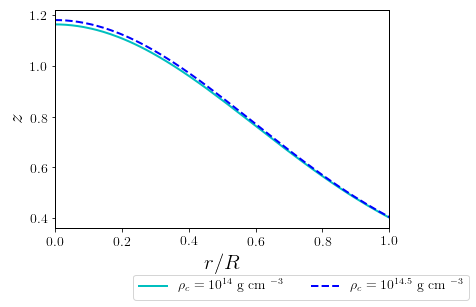

In [95]:
fig = plt.figure()

plt.plot(ms2_1536[-1]/ms2_1536[-1][-1],np.exp(-ms2_1536[3])-1.0,color='c',linewidth='2.0',label=r'$\rho_c=10^{14}$ g cm $^{-3}$')
plt.plot(ms2_1537[-1]/ms2_1537[-1][-1],np.exp(-ms2_1537[3])-1.0,color='blue',linewidth='2.0',linestyle='--',label=r'$\rho_c=10^{14.5}$ g cm $^{-3}$')
#plt.plot(ms2_150[-1]/ms2_150[-1][-1],np.exp(-ms2_150[3])-1.0,color='peru',linewidth='2.0',linestyle='-.',label=r'$\rho_c=10^{15}$ g cm $^{-3}$')

l = plt.legend(bbox_to_anchor=(1.1,-0.15), loc="lower right", 
                bbox_transform=fig.transFigure, ncol=3)

plt.xlabel(r'$r/R$')
plt.ylabel(r'$z$')
plt.xlim(0,1.0)

plt.savefig('figures/Redshiftms2.pdf', format='pdf', dpi=1000,bbox_inches="tight")

# NL3 ------------------------------------------------------------------------------------------

In [40]:
rhonl3,Pnl3,nnl3=np.loadtxt('EOS/nl3.dat',usecols=(2,1,0),unpack=True)

## Dominant energy condition

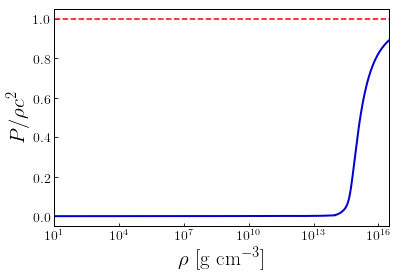

<Figure size 432x288 with 0 Axes>

In [41]:
fig, ax = plt.subplots()
plt.plot(rhonl3,np.divide(Pnl3,rhonl3),lw='2',color='mediumblue')
plt.plot([0,10**(17)],[1.0,1.0],'r--',lw='1.5')

ax.set_xscale("log")
#locmaj = matplotlib.ticker.LogLocator(base=10.0,numticks=16) 
#ax.xaxis.set_major_locator(locmaj)


plt.xlabel(r'$\rho$ [g\,\,cm$^{-3}$]')
plt.ylabel(r'$ P / \rho c^2 $')
#locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks=16)
#ax.xaxis.set_minor_locator(locmin)
#ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.tick_params(axis="x", direction="in")
ax.tick_params(axis="y", direction="in")
plt.xlim(10,10**(16.5))
#ax.set_facecolor('floralwhite')
#plt.gca().set_aspect('equal', adjustable='box')
#plt.draw()
#plt.ylim(0,1)
plt.savefig('figures/ECnl3.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()
plt.clf()

## Speed of sound

In [42]:
vsquared=interpolate.UnivariateSpline(rhonl3, Pnl3, k=1, s=0).derivative(n=1)

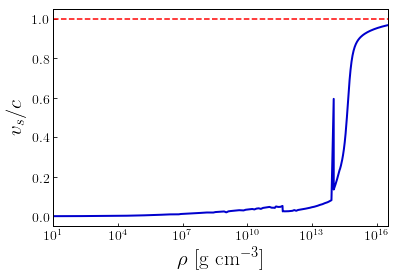

In [43]:
fig, ax = plt.subplots()
plt.plot(rhonl3,np.sqrt(vsquared(rhonl3)),lw='2.0',color='mediumblue')
plt.plot([1e+1,10**(18)],[1.0,1.0],'r--',lw='1.5')
plt.xlabel(r'$\rho$ [g\,\,cm$^{-3}$]')
plt.ylabel(r'$ v_s / c $')
plt.xscale('log')
ax.tick_params(axis="x", direction="in")
ax.tick_params(axis="y", direction="in")
plt.xlim(10,10**(16.5))
#ax.set_facecolor('floralwhite')
#mpl.rcParams['axes.linewidth'] = 1.4
#plt.gca().set_aspect('equal', adjustable='box')
#plt.draw()
plt.savefig('figures/SSnl3.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

## Adiabatic Index

In [44]:
Gamma=np.multiply(np.divide(np.add(rhonl3,Pnl3),Pnl3),vsquared(rhonl3))

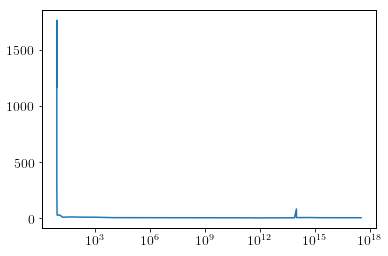

In [45]:
plt.plot(rhonl3,Gamma)
plt.xscale('log')

$$ \langle\gamma\rangle=\frac{\int_{0}^{R} e^{(\lambda+3 \nu) } \gamma(r) P(r) r^{2} d r}{\int_{0}^{R} e^{(\lambda+3 \nu) } P(r) r^{2} d r} $$

Listing all the models calculated

In [46]:
owd=os.getcwd()
path=os.chdir('results/nl3')
listOfEntries= os.scandir(path)
models_nl3 = []
for entry in listOfEntries:
    if '1' in entry.name:
        models_nl3.append(entry.name)
os.chdir(owd)
models_nl3.sort()

In [47]:
gamma_efs1 = []
gamma_efs2 = []
gamma_crs1 = []
gamma_crs2 = []
rhosc= []
for model in models_nl3:
    m, P, rho, nu, lambd, r = np.loadtxt('results/nl3/' + model ,unpack=True)
    nu = nu - nu[-1] + 0.5*np.log(1-2*m[-1]/r[-1])
    #lambd = np.zeros_like(r)
    #for i in range((r.shape)[0]):
    #    if i==0:
    #        lambd[i] = 0
    #    else:
    #        lambd[i] = 0.5*np.log(1/(1-2*m[i]/r[i]))
    drho=interpolate.UnivariateSpline(r, rho, k=5, s=0).derivative(n=1)
    dP=interpolate.UnivariateSpline(r, P, k=5, s=0).derivative(n=1)
    gamma = np.divide(dP(r),drho(r))
    gamma_ef1 = integrate.trapz(np.exp(lambd+3*nu)*gamma*P*(r**2),r)/integrate.trapz(np.exp(lambd+3*nu)*P*(r**2),r)
    t1 = (1/36)*integrate.trapz(np.exp((lambd+3*nu))*(16*P+(np.exp(2*lambd)-1)*(P+rho))*(np.exp(2*lambd)-1)*(r**2),r)/integrate.trapz(np.exp(lambd+3*nu)*P*(r**2),r)
    t2 = (4*np.pi/9)*integrate.trapz(np.exp(3*lambd+3*nu)*(8*P + (np.exp(2*lambd)+1)*(P+rho))*P*(r**4),r)/integrate.trapz(np.exp(lambd+3*nu)*P*(r**2),r)
    t3 = ((16*np.pi**2)/9)*integrate.trapz(np.exp(5*lambd+3*nu)*(P+rho)*(P**2)*(r**6),r)/integrate.trapz(np.exp(lambd+3*nu)*P*(r**2),r)
    gamma_cr1 = 4/3 + t1 + t2 + t3
    gamma_efs1.append(gamma_ef1)
    gamma_crs1.append(gamma_cr1)
    gamma_ef2 = integrate.trapz(gamma*P*r**2,r)/integrate.trapz(P*r**2,r)
    gamma_cr2 = 4/3 + (19/42)*2*m[-1]/r[-1]
    gamma_efs2.append(gamma_ef2)
    gamma_crs2.append(gamma_cr2)
    rhosc.append(rho[0]*rhodim)

ValueError: x must be strictly increasing

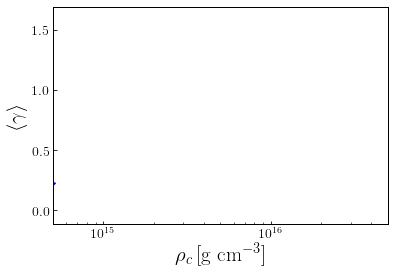

In [48]:
fig, ax = plt.subplots()
plt.plot(rhosc,gamma_crs1,lw='1.5',color='r',linestyle='--',label=r'$\gamma_{cr}$')
plt.plot(rhosc,gamma_efs1,lw='2.0',color='blue',label=r'$\langle \gamma \rangle$')

plt.xlabel(r'$\rho_c\,[$g cm$^{-3}]$')
plt.ylabel(r'$\langle \gamma \rangle$')

plt.xscale('log')
plt.xlim(left=10**(14.7),right=10**(16.7))
#plt.ylim(0,10)
ax.tick_params(axis="x", direction="in",which='both')
ax.tick_params(axis="y", direction="in",which='both')
#l = plt.legend(bbox_to_anchor=(0.85,-0.15), loc="lower right", 
                #bbox_transform=fig.transFigure, ncol=2)



plt.savefig('figures/AdiabaticIndexnl3.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

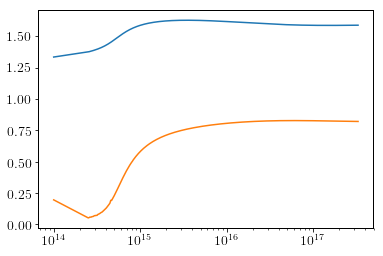

In [105]:
plt.plot(rhosc,gamma_crs2)
plt.plot(rhosc,gamma_efs2)
plt.xscale('log')

## M - $\rho_c$

In [106]:
Rnl3,Mnl3,rhocnl3=np.loadtxt('results/nl3/MRrhoc.dat',usecols=(0,1,2),unpack=True)

In [107]:
np.amax(Mnl3)

2.80562491518

In [108]:
rhocnl3[np.argmax(Mnl3)]

1513561248440000.0

In [109]:
np.log10(rhocnl3[np.argmax(Mnl3)])

15.180000000001089

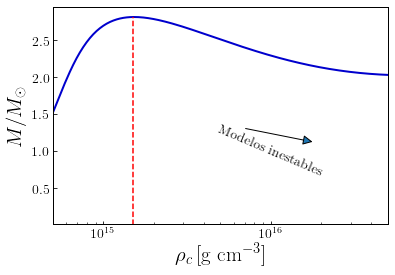

In [110]:
fig, ax = plt.subplots()

plt.plot(rhocnl3,Mnl3,color='mediumblue',lw='2.0')
plt.plot([10**(np.log10(rhocnl3[np.argmax(Mnl3)])),10**(np.log10(rhocnl3[np.argmax(Mnl3)]))],[0.0,np.amax(Mnl3)],'r--',lw='1.5')

prop = dict(arrowstyle="-|>,head_width=0.4,head_length=0.8",
            shrinkA=0,shrinkB=0)
plt.annotate("", xy=(10**(16.25),1.12), xytext=(10**(15.85),1.3), arrowprops=prop)
#plt.arrow(10**(15.6), 1.38,10**(15.7) ,-0.1 , head_width=0.05, head_lnl3th=10**(15))
plt.text(10**(15.67), 1.23, 'Modelos inestables' , fontsize=14,rotation=-23)

plt.xscale('log')
plt.xlabel(r'$\rho_c\,[$g cm$^{-3}]$')
plt.ylabel(r'$M/M_{\odot}$')
plt.xlim(left=10**(14.7),right=10**(16.7))
plt.ylim(bottom=0.01)
ax.tick_params(axis="x", direction="in",which='both')
ax.tick_params(axis="y", direction="in",which='both')

plt.savefig('figures/Mrhorel_nl3.pdf', format='pdf', dpi=1000,bbox_inches="tight")

## Tunning the interpolation of the solution

### 14.0

In [111]:
nl3_140=np.loadtxt('results/nl3/14.0.dat',unpack=True)
nl3_140[3] = nl3_140[3]-nl3_140[3][-1] + 0.5*np.log(1-2*nl3_140[0][-1]/nl3_140[-1][-1])

In [112]:
s1=5e-7
s2=1e-15
nl3_140rho=interpolate.UnivariateSpline(nl3_140[-1], nl3_140[2], k=5, s=s1)
nl3_140drho=interpolate.UnivariateSpline(nl3_140[-1], nl3_140[2], k=5, s=s1).derivative(n=1)
nl3_140ddrho=interpolate.UnivariateSpline(nl3_140[-1], nl3_140[2], k=5, s=s1).derivative(n=2)

nl3_140p=interpolate.UnivariateSpline(nl3_140[-1], nl3_140[1], k=5, s=s2)
nl3_140dp=interpolate.UnivariateSpline(nl3_140[-1], nl3_140[1], k=5, s=s2).derivative(n=1)
nl3_140ddp=interpolate.UnivariateSpline(nl3_140[-1], nl3_140[1], k=5, s=s2).derivative(n=2)

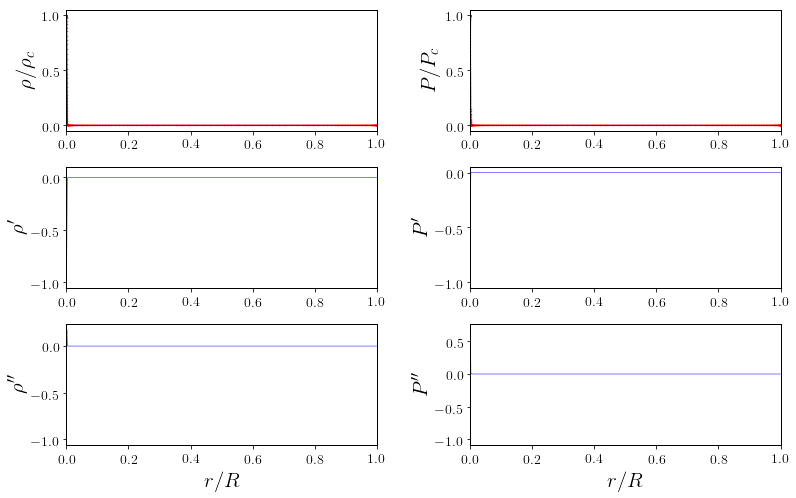

In [113]:
fig=plt.figure(figsize=[12.8,8])

plt.subplot(321)
plt.plot(nl3_140[-1]/nl3_140[-1][-1],nl3_140[2]/nl3_140[2][0],color='red',marker='o',markersize='0.4') 
plt.plot(nl3_140[-1]/nl3_140[-1][-1],nl3_140rho(nl3_140[-1])/nl3_140[2][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1) # leaving the crust out

plt.subplot(322)
plt.plot(nl3_140[-1]/nl3_140[-1][-1],nl3_140[1]/nl3_140[1][0],color='red',marker='o',markersize='0.4') 
plt.plot(nl3_140[-1]/nl3_140[-1][-1],nl3_140p(nl3_140[-1])/nl3_140[1][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$P/P_c$')
plt.xlim(0,1)

plt.subplot(323)
plt.plot(nl3_140[-1]/nl3_140[-1][-1],nl3_140drho(nl3_140[-1])/max(abs(nl3_140drho(nl3_140[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime}$')
plt.xlim(0,1)
#plt.ylim(-500,0)

plt.subplot(324)
plt.plot(nl3_140[-1]/nl3_140[-1][-1],nl3_140dp(nl3_140[-1])/max(abs(nl3_140dp(nl3_140[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime} $')
plt.xlim(0,1)

plt.subplot(325)
plt.plot(nl3_140[-1]/nl3_140[-1][-1],nl3_140ddrho(nl3_140[-1])/max(abs(nl3_140ddrho(nl3_140[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}$')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-0.01,0.01)

plt.subplot(326)
plt.plot(nl3_140[-1]/nl3_140[-1][-1],nl3_140ddp(nl3_140[-1])/max(abs(nl3_140ddp(nl3_140[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime\prime}$ ')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-1,1)

fig.subplots_adjust(hspace=0.3,wspace=0.3)

#plt.savefig('figures/ddsnl3_140.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

### 14.5

In [114]:
nl3_145=np.loadtxt('results/nl3/14.5.dat',unpack=True)
nl3_145[3] = nl3_145[3]-nl3_145[3][-1] + 0.5*np.log(1-2*nl3_145[0][-1]/nl3_145[-1][-1])

In [115]:
s1=1e-7
s2=1e-12
nl3_145rho=interpolate.UnivariateSpline(nl3_145[-1], nl3_145[2], k=5, s=s1)
nl3_145drho=interpolate.UnivariateSpline(nl3_145[-1], nl3_145[2], k=5, s=s1).derivative(n=1)
nl3_145ddrho=interpolate.UnivariateSpline(nl3_145[-1], nl3_145[2], k=5, s=s1).derivative(n=2)

nl3_145p=interpolate.UnivariateSpline(nl3_145[-1], nl3_145[1], k=5, s=s2)
nl3_145dp=interpolate.UnivariateSpline(nl3_145[-1], nl3_145[1], k=5, s=s2).derivative(n=1)
nl3_145ddp=interpolate.UnivariateSpline(nl3_145[-1], nl3_145[1], k=5, s=s2).derivative(n=2)

In [116]:
nl3_145rho(0.4*nl3_145[-1][-1])*rhodim

262370320993776.78

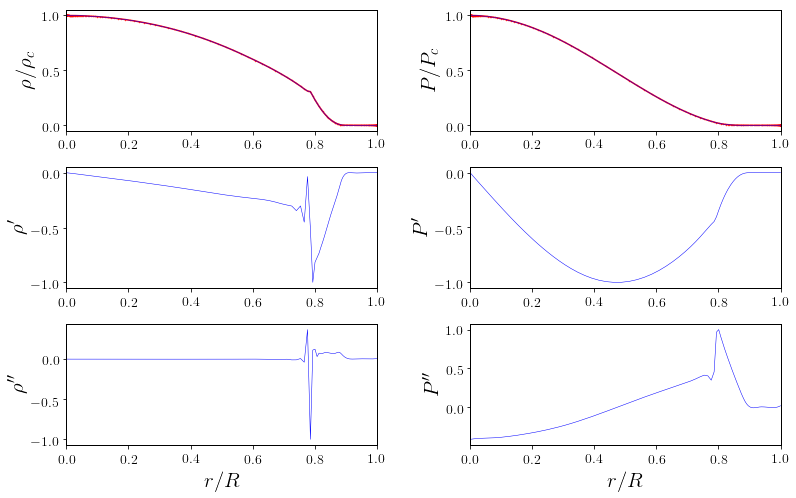

In [117]:
fig=plt.figure(figsize=[12.8,8])

plt.subplot(321)
plt.plot(nl3_145[-1]/nl3_145[-1][-1],nl3_145[2]/nl3_145[2][0],color='red',marker='o',markersize='0.4') 
plt.plot(nl3_145[-1]/nl3_145[-1][-1],nl3_145rho(nl3_145[-1])/nl3_145[2][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1) # leaving the crust out

plt.subplot(322)
plt.plot(nl3_145[-1]/nl3_145[-1][-1],nl3_145[1]/nl3_145[1][0],color='red',marker='o',markersize='0.4') 
plt.plot(nl3_145[-1]/nl3_145[-1][-1],nl3_145p(nl3_145[-1])/nl3_145[1][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$P/P_c$')
plt.xlim(0,1)

plt.subplot(323)
plt.plot(nl3_145[-1]/nl3_145[-1][-1],nl3_145drho(nl3_145[-1])/max(abs(nl3_145drho(nl3_145[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime}$')
plt.xlim(0,1)
#plt.ylim(-500,0)

plt.subplot(324)
plt.plot(nl3_145[-1]/nl3_145[-1][-1],nl3_145dp(nl3_145[-1])/max(abs(nl3_145dp(nl3_145[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime} $')
plt.xlim(0,1)

plt.subplot(325)
plt.plot(nl3_145[-1]/nl3_145[-1][-1],nl3_145ddrho(nl3_145[-1])/max(abs(nl3_145ddrho(nl3_145[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}$')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-0.01,0.01)

plt.subplot(326)
plt.plot(nl3_145[-1]/nl3_145[-1][-1],nl3_145ddp(nl3_145[-1])/max(abs(nl3_145ddp(nl3_145[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime\prime}$ ')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-1,1)

fig.subplots_adjust(hspace=0.3,wspace=0.3)

#plt.savefig('figures/ddsnl3_145.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

### 15.0

In [118]:
nl3_150=np.loadtxt('results/nl3/15.0.dat',unpack=True)
nl3_150[3] = nl3_150[3]-nl3_150[3][-1] + 0.5*np.log(1-2*nl3_150[0][-1]/nl3_150[-1][-1])

In [119]:
s1=8e-6
s2=1e-15
nl3_150rho=interpolate.UnivariateSpline(nl3_150[-1], nl3_150[2], k=5, s=s1)
nl3_150drho=interpolate.UnivariateSpline(nl3_150[-1], nl3_150[2], k=5, s=s1).derivative(n=1)
nl3_150ddrho=interpolate.UnivariateSpline(nl3_150[-1], nl3_150[2], k=5, s=s1).derivative(n=2)

nl3_150p=interpolate.UnivariateSpline(nl3_150[-1], nl3_150[1], k=5, s=s2)
nl3_150dp=interpolate.UnivariateSpline(nl3_150[-1], nl3_150[1], k=5, s=s2).derivative(n=1)
nl3_150ddp=interpolate.UnivariateSpline(nl3_150[-1], nl3_150[1], k=5, s=s2).derivative(n=2)

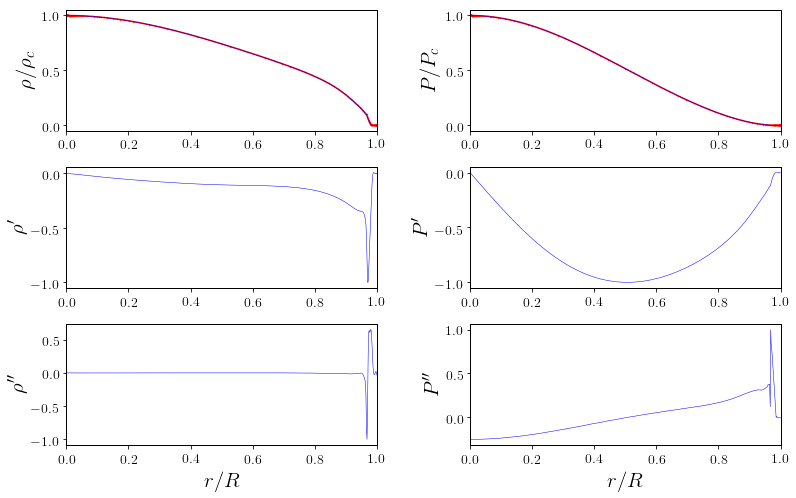

In [120]:
fig=plt.figure(figsize=[12.8,8])

plt.subplot(321)
plt.plot(nl3_150[-1]/nl3_150[-1][-1],nl3_150[2]/nl3_150[2][0],color='red',marker='o',markersize='0.4') 
plt.plot(nl3_150[-1]/nl3_150[-1][-1],nl3_150rho(nl3_150[-1])/nl3_150[2][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1) # leaving the crust out

plt.subplot(322)
plt.plot(nl3_150[-1]/nl3_150[-1][-1],nl3_150[1]/nl3_150[1][0],color='red',marker='o',markersize='0.4') 
plt.plot(nl3_150[-1]/nl3_150[-1][-1],nl3_150p(nl3_150[-1])/nl3_150[1][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$P/P_c$')
plt.xlim(0,1)

plt.subplot(323)
plt.plot(nl3_150[-1]/nl3_150[-1][-1],nl3_150drho(nl3_150[-1])/max(abs(nl3_150drho(nl3_150[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime}$')
plt.xlim(0,1)
#plt.ylim(-500,0)

plt.subplot(324)
plt.plot(nl3_150[-1]/nl3_150[-1][-1],nl3_150dp(nl3_150[-1])/max(abs(nl3_150dp(nl3_150[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime} $')
plt.xlim(0,1)

plt.subplot(325)
plt.plot(nl3_150[-1]/nl3_150[-1][-1],nl3_150ddrho(nl3_150[-1])/max(abs(nl3_150ddrho(nl3_150[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}$')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-0.01,0.01)

plt.subplot(326)
plt.plot(nl3_150[-1]/nl3_150[-1][-1],nl3_150ddp(nl3_150[-1])/max(abs(nl3_150ddp(nl3_150[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime\prime}$ ')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-1,1)

fig.subplots_adjust(hspace=0.3,wspace=0.3)

#plt.savefig('figures/ddsnl3_150.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

### 15.5

In [121]:
nl3_155=np.loadtxt('results/nl3/15.5.dat',unpack=True)
nl3_155[3] = nl3_155[3]-nl3_155[3][-1] + 0.5*np.log(1-2*nl3_155[0][-1]/nl3_155[-1][-1])

In [122]:
s1=1e-5
s2=1e-9
nl3_155rho=interpolate.UnivariateSpline(nl3_155[-1], nl3_155[2], k=5, s=s1)
nl3_155drho=interpolate.UnivariateSpline(nl3_155[-1], nl3_155[2], k=5, s=s1).derivative(n=1)
nl3_155ddrho=interpolate.UnivariateSpline(nl3_155[-1], nl3_155[2], k=5, s=s1).derivative(n=2)

nl3_155p=interpolate.UnivariateSpline(nl3_155[-1], nl3_155[1], k=5, s=s2)
nl3_155dp=interpolate.UnivariateSpline(nl3_155[-1], nl3_155[1], k=5, s=s2).derivative(n=1)
nl3_155ddp=interpolate.UnivariateSpline(nl3_155[-1], nl3_155[1], k=5, s=s2).derivative(n=2)

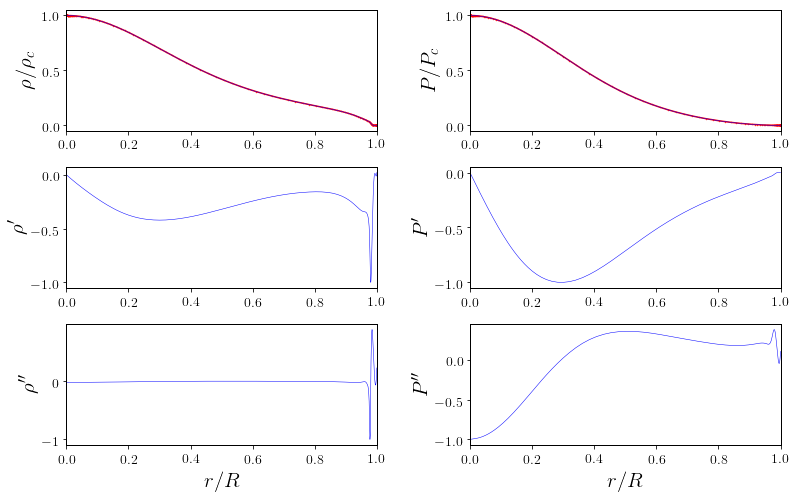

In [123]:
fig=plt.figure(figsize=[12.8,8])

plt.subplot(321)
plt.plot(nl3_155[-1]/nl3_155[-1][-1],nl3_155[2]/nl3_155[2][0],color='red',marker='o',markersize='0.4') 
plt.plot(nl3_155[-1]/nl3_155[-1][-1],nl3_155rho(nl3_155[-1])/nl3_155[2][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1) # leaving the crust out

plt.subplot(322)
plt.plot(nl3_155[-1]/nl3_155[-1][-1],nl3_155[1]/nl3_155[1][0],color='red',marker='o',markersize='0.4') 
plt.plot(nl3_155[-1]/nl3_155[-1][-1],nl3_155p(nl3_155[-1])/nl3_155[1][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$P/P_c$')
plt.xlim(0,1)

plt.subplot(323)
plt.plot(nl3_155[-1]/nl3_155[-1][-1],nl3_155drho(nl3_155[-1])/max(abs(nl3_155drho(nl3_155[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime}$')
plt.xlim(0,1)
#plt.ylim(-500,0)

plt.subplot(324)
plt.plot(nl3_155[-1]/nl3_155[-1][-1],nl3_155dp(nl3_155[-1])/max(abs(nl3_155dp(nl3_155[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime} $')
plt.xlim(0,1)

plt.subplot(325)
plt.plot(nl3_155[-1]/nl3_155[-1][-1],nl3_155ddrho(nl3_155[-1])/max(abs(nl3_155ddrho(nl3_155[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}$')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-0.01,0.01)

plt.subplot(326)
plt.plot(nl3_155[-1]/nl3_155[-1][-1],nl3_155ddp(nl3_155[-1])/max(abs(nl3_155ddp(nl3_155[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime\prime}$ ')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-1,1)

fig.subplots_adjust(hspace=0.3,wspace=0.3)

#plt.savefig('figures/ddsnl3_155.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

## Redshift

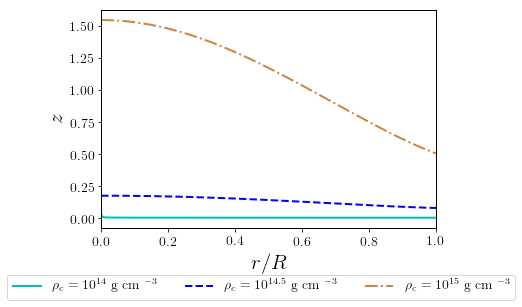

In [124]:
fig = plt.figure()

plt.plot(nl3_140[-1]/nl3_140[-1][-1],np.exp(-nl3_140[3])-1.0,color='c',linewidth='2.0',label=r'$\rho_c=10^{14}$ g cm $^{-3}$')
plt.plot(nl3_145[-1]/nl3_145[-1][-1],np.exp(-nl3_145[3])-1.0,color='blue',linewidth='2.0',linestyle='--',label=r'$\rho_c=10^{14.5}$ g cm $^{-3}$')
plt.plot(nl3_150[-1]/nl3_150[-1][-1],np.exp(-nl3_150[3])-1.0,color='peru',linewidth='2.0',linestyle='-.',label=r'$\rho_c=10^{15}$ g cm $^{-3}$')

l = plt.legend(bbox_to_anchor=(1.1,-0.15), loc="lower right", 
                bbox_transform=fig.transFigure, ncol=3)

plt.xlabel(r'$r/R$')
plt.ylabel(r'$z$')
plt.xlim(0,1.0)

plt.savefig('figures/Redshiftnl3.pdf', format='pdf', dpi=1000,bbox_inches="tight")

# PAL6 ---------------------------------------------------------------------------------------

In [129]:
rhopal6,Ppal6,npal6=np.loadtxt('EOS/pal6.dat',usecols=(2,1,0),unpack=True)

## Dominant energy condition

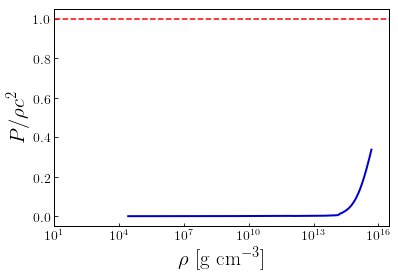

<Figure size 432x288 with 0 Axes>

In [130]:
fig, ax = plt.subplots()
plt.plot(rhopal6,np.divide(Ppal6,rhopal6),lw='2',color='mediumblue')
plt.plot([0,10**(17)],[1.0,1.0],'r--',lw='1.5')

ax.set_xscale("log")
#locmaj = matplotlib.ticker.LogLocator(base=10.0,numticks=16) 
#ax.xaxis.set_major_locator(locmaj)


plt.xlabel(r'$\rho$ [g\,\,cm$^{-3}$]')
plt.ylabel(r'$ P / \rho c^2 $')
#locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks=16)
#ax.xaxis.set_minor_locator(locmin)
#ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.tick_params(axis="x", direction="in")
ax.tick_params(axis="y", direction="in")
plt.xlim(10,10**(16.5))
#ax.set_facecolor('floralwhite')
#plt.gca().set_aspect('equal', adjustable='box')
#plt.draw()
#plt.ylim(0,1)
plt.savefig('figures/ECpal6.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()
plt.clf()

## Speed of sound

In [131]:
vsquared=interpolate.UnivariateSpline(rhopal6, Ppal6, k=1, s=0).derivative(n=1)

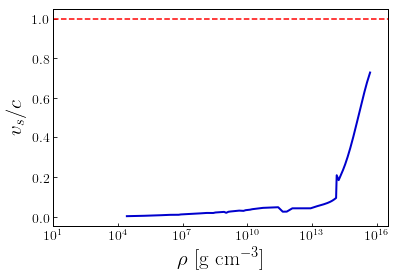

In [132]:
fig, ax = plt.subplots()
plt.plot(rhopal6,np.sqrt(vsquared(rhopal6)),lw='2.0',color='mediumblue')
plt.plot([1e+1,10**(16.5)],[1.0,1.0],'r--',lw='1.5')
plt.xlabel(r'$\rho$ [g\,\,cm$^{-3}$]')
plt.ylabel(r'$ v_s / c $')
plt.xscale('log')
ax.tick_params(axis="x", direction="in")
ax.tick_params(axis="y", direction="in")
plt.xlim(10,10**(16.5))
#ax.set_facecolor('floralwhite')
#mpl.rcParams['axes.linewidth'] = 1.4
#plt.gca().set_aspect('equal', adjustable='box')
#plt.draw()
plt.savefig('figures/SSpal6.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

## Adiabatic Index

In [133]:
Gamma=np.multiply(np.divide(np.add(rhopal6,Ppal6),Ppal6),vsquared(rhopal6))

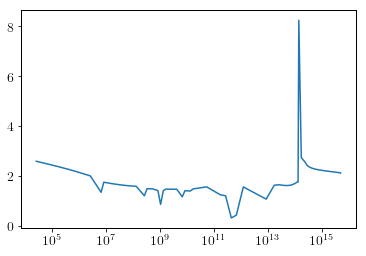

In [134]:
plt.plot(rhopal6,Gamma)
plt.xscale('log')

$$ \langle\gamma\rangle=\frac{\int_{0}^{R} e^{(\lambda+3 \nu) } \gamma(r) P(r) r^{2} d r}{\int_{0}^{R} e^{(\lambda+3 \nu) } P(r) r^{2} d r} $$

Listing all the models calculated

In [135]:
owd=os.getcwd()
path=os.chdir('results/pal6')
listOfEntries= os.scandir(path)
models_pal6 = []
for entry in listOfEntries:
    if '1' in entry.name:
        models_pal6.append(entry.name)
os.chdir(owd)
models_pal6.sort()

In [136]:
gamma_efs1 = []
gamma_efs2 = []
gamma_crs1 = []
gamma_crs2 = []
rhosc= []
for model in models_pal6:
    m, P, rho, nu, lambd, r = np.loadtxt('results/pal6/' + model ,unpack=True)
    nu = nu - nu[-1] + 0.5*np.log(1-2*m[-1]/r[-1])
    #lambd = np.zeros_like(r)
    #for i in range((r.shape)[0]):
    #    if i==0:
    #        lambd[i] = 0
    #    else:
    #        lambd[i] = 0.5*np.log(1/(1-2*m[i]/r[i]))
    drho=interpolate.UnivariateSpline(r, rho, k=5, s=0).derivative(n=1)
    dP=interpolate.UnivariateSpline(r, P, k=5, s=0).derivative(n=1)
    gamma = np.divide(dP(r),drho(r))
    gamma_ef1 = integrate.trapz(np.exp(lambd+3*nu)*gamma*P*(r**2),r)/integrate.trapz(np.exp(lambd+3*nu)*P*(r**2),r)
    t1 = (1/36)*integrate.trapz(np.exp((lambd+3*nu))*(16*P+(np.exp(2*lambd)-1)*(P+rho))*(np.exp(2*lambd)-1)*(r**2))/integrate.trapz(np.exp(lambd+3*nu)*P*(r**2),r)
    t2 = (4*np.pi/9)*integrate.trapz(np.exp(3*lambd+3*nu)*(8*P + (np.exp(2*lambd)+1)*(P+rho))*P*(r**4),r)/integrate.trapz(np.exp(lambd+3*nu)*P*(r**2),r)
    t3 = ((16*np.pi**2)/9)*integrate.trapz(np.exp(5*lambd+3*nu)*(P+rho)*(P**2)*(r**6),r)/integrate.trapz(np.exp(lambd+3*nu)*P*(r**2),r)
    gamma_cr1 = 4/3 + t1 + t2 + t3
    gamma_efs1.append(gamma_ef1)
    gamma_crs1.append(gamma_cr1)
    gamma_ef2 = integrate.trapz(gamma*P*r**2,r)/integrate.trapz(P*r**2,r)
    gamma_cr2 = 4/3 + (19/42)*2*m[-1]/r[-1]
    gamma_efs2.append(gamma_ef2)
    gamma_crs2.append(gamma_cr2)
    rhosc.append(rho[0]*rhodim)

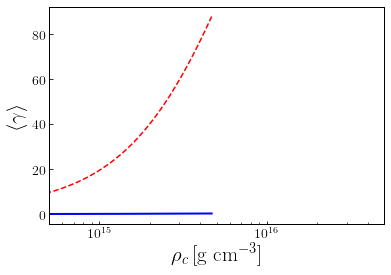

In [137]:
fig, ax = plt.subplots()
plt.plot(rhosc,gamma_crs1,lw='1.5',color='r',linestyle='--',label=r'$\gamma_{cr}$')
plt.plot(rhosc,gamma_efs1,lw='2.0',color='blue',label=r'$\langle \gamma \rangle$')

plt.xlabel(r'$\rho_c\,[$g cm$^{-3}]$')
plt.ylabel(r'$\langle \gamma \rangle$')

plt.xscale('log')
plt.xlim(left=10**(14.7),right=10**(16.7))
#plt.ylim(0,10)
ax.tick_params(axis="x", direction="in",which='both')
ax.tick_params(axis="y", direction="in",which='both')
#l = plt.legend(bbox_to_anchor=(0.85,-0.15), loc="lower right", 
                #bbox_transform=fig.transFigure, ncol=2)



plt.savefig('figures/AdiabaticIndexpal6.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

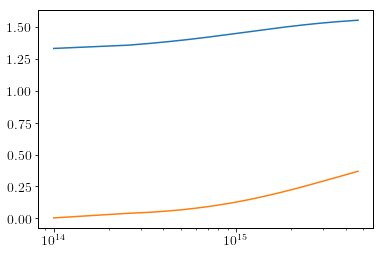

In [138]:
plt.plot(rhosc,gamma_crs2)
plt.plot(rhosc,gamma_efs2)
plt.xscale('log')

## M - $\rho_c$

In [139]:
Rpal6,Mpal6,rhocpal6=np.loadtxt('results/pal6/MRrhoc.dat',usecols=(0,1,2),unpack=True)

In [140]:
np.amax(Mpal6)

1.47767696184

In [141]:
rhocpal6[np.argmax(Mpal6)]

3801893963210000.0

In [142]:
np.log10(rhocpal6[np.argmax(Mpal6)])

15.580000000000501

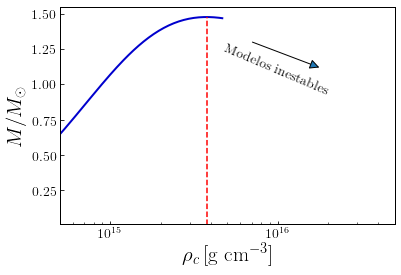

In [143]:
fig, ax = plt.subplots()

plt.plot(rhocpal6,Mpal6,color='mediumblue',lw='2.0')
plt.plot([10**(np.log10(rhocpal6[np.argmax(Mpal6)])),10**(np.log10(rhocpal6[np.argmax(Mpal6)]))],[0.0,np.amax(Mpal6)],'r--',lw='1.5')

prop = dict(arrowstyle="-|>,head_width=0.4,head_length=0.8",
            shrinkA=0,shrinkB=0)
plt.annotate("", xy=(10**(16.25),1.12), xytext=(10**(15.85),1.3), arrowprops=prop)
#plt.arrow(10**(15.6), 1.38,10**(15.7) ,-0.1 , head_width=0.05, head_lpal6th=10**(15))
plt.text(10**(15.67), 1.23, 'Modelos inestables' , fontsize=14,rotation=-23)

plt.xscale('log')
plt.xlabel(r'$\rho_c\,[$g cm$^{-3}]$')
plt.ylabel(r'$M/M_{\odot}$')
plt.xlim(left=10**(14.7),right=10**(16.7))
plt.ylim(bottom=0.01)
ax.tick_params(axis="x", direction="in",which='both')
ax.tick_params(axis="y", direction="in",which='both')

plt.savefig('figures/Mrhorel_pal6.pdf', format='pdf', dpi=1000,bbox_inches="tight")

## Tunning the interpolation of the solution

### 14.0

In [144]:
pal6_140=np.loadtxt('results/pal6/14.0.dat',unpack=True)
pal6_140[3] = pal6_140[3]-pal6_140[3][-1] + 0.5*np.log(1-2*pal6_140[0][-1]/pal6_140[-1][-1])

In [145]:
s1=5e-7
s2=1e-15
pal6_140rho=interpolate.UnivariateSpline(pal6_140[-1], pal6_140[2], k=5, s=s1)
pal6_140drho=interpolate.UnivariateSpline(pal6_140[-1], pal6_140[2], k=5, s=s1).derivative(n=1)
pal6_140ddrho=interpolate.UnivariateSpline(pal6_140[-1], pal6_140[2], k=5, s=s1).derivative(n=2)

pal6_140p=interpolate.UnivariateSpline(pal6_140[-1], pal6_140[1], k=5, s=s2)
pal6_140dp=interpolate.UnivariateSpline(pal6_140[-1], pal6_140[1], k=5, s=s2).derivative(n=1)
pal6_140ddp=interpolate.UnivariateSpline(pal6_140[-1], pal6_140[1], k=5, s=s2).derivative(n=2)

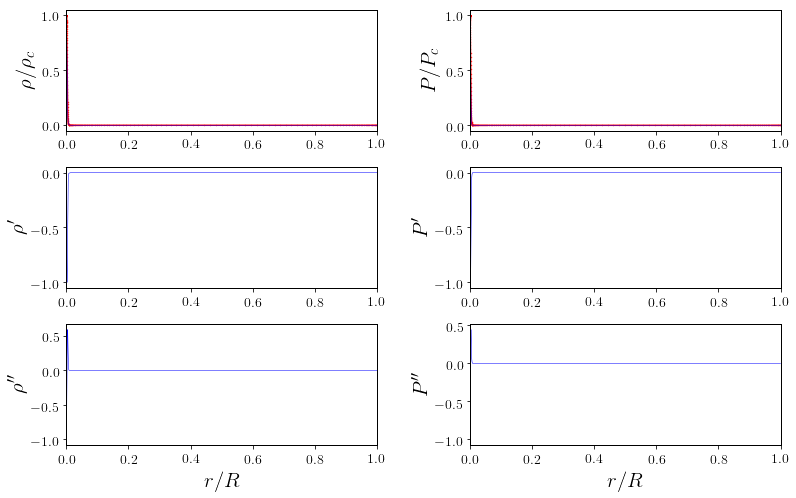

In [146]:
fig=plt.figure(figsize=[12.8,8])

plt.subplot(321)
plt.plot(pal6_140[-1]/pal6_140[-1][-1],pal6_140[2]/pal6_140[2][0],color='red',marker='o',markersize='0.4') 
plt.plot(pal6_140[-1]/pal6_140[-1][-1],pal6_140rho(pal6_140[-1])/pal6_140[2][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1) # leaving the crust out

plt.subplot(322)
plt.plot(pal6_140[-1]/pal6_140[-1][-1],pal6_140[1]/pal6_140[1][0],color='red',marker='o',markersize='0.4') 
plt.plot(pal6_140[-1]/pal6_140[-1][-1],pal6_140p(pal6_140[-1])/pal6_140[1][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$P/P_c$')
plt.xlim(0,1)

plt.subplot(323)
plt.plot(pal6_140[-1]/pal6_140[-1][-1],pal6_140drho(pal6_140[-1])/max(abs(pal6_140drho(pal6_140[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime}$')
plt.xlim(0,1)
#plt.ylim(-500,0)

plt.subplot(324)
plt.plot(pal6_140[-1]/pal6_140[-1][-1],pal6_140dp(pal6_140[-1])/max(abs(pal6_140dp(pal6_140[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime} $')
plt.xlim(0,1)

plt.subplot(325)
plt.plot(pal6_140[-1]/pal6_140[-1][-1],pal6_140ddrho(pal6_140[-1])/max(abs(pal6_140ddrho(pal6_140[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}$')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-0.01,0.01)

plt.subplot(326)
plt.plot(pal6_140[-1]/pal6_140[-1][-1],pal6_140ddp(pal6_140[-1])/max(abs(pal6_140ddp(pal6_140[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime\prime}$ ')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-1,1)

fig.subplots_adjust(hspace=0.3,wspace=0.3)

#plt.savefig('figures/ddspal6_140.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

### 14.5

In [147]:
pal6_145=np.loadtxt('results/pal6/14.5.dat',unpack=True)
pal6_145[3] = pal6_145[3]-pal6_145[3][-1] + 0.5*np.log(1-2*pal6_145[0][-1]/pal6_145[-1][-1])

In [148]:
s1=1e-7
s2=1e-12
pal6_145rho=interpolate.UnivariateSpline(pal6_145[-1], pal6_145[2], k=5, s=s1)
pal6_145drho=interpolate.UnivariateSpline(pal6_145[-1], pal6_145[2], k=5, s=s1).derivative(n=1)
pal6_145ddrho=interpolate.UnivariateSpline(pal6_145[-1], pal6_145[2], k=5, s=s1).derivative(n=2)

pal6_145p=interpolate.UnivariateSpline(pal6_145[-1], pal6_145[1], k=5, s=s2)
pal6_145dp=interpolate.UnivariateSpline(pal6_145[-1], pal6_145[1], k=5, s=s2).derivative(n=1)
pal6_145ddp=interpolate.UnivariateSpline(pal6_145[-1], pal6_145[1], k=5, s=s2).derivative(n=2)

In [149]:
pal6_145rho(0.4*pal6_145[-1][-1])*rhodim

228967404054773.53

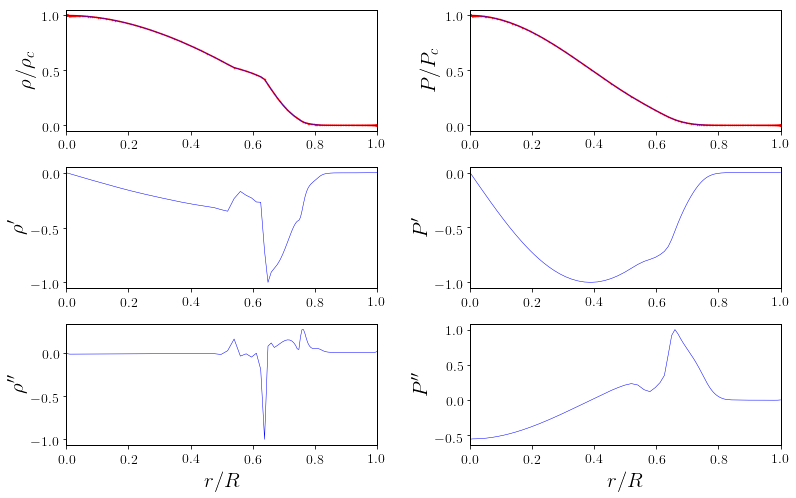

In [150]:
fig=plt.figure(figsize=[12.8,8])

plt.subplot(321)
plt.plot(pal6_145[-1]/pal6_145[-1][-1],pal6_145[2]/pal6_145[2][0],color='red',marker='o',markersize='0.4') 
plt.plot(pal6_145[-1]/pal6_145[-1][-1],pal6_145rho(pal6_145[-1])/pal6_145[2][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1) # leaving the crust out

plt.subplot(322)
plt.plot(pal6_145[-1]/pal6_145[-1][-1],pal6_145[1]/pal6_145[1][0],color='red',marker='o',markersize='0.4') 
plt.plot(pal6_145[-1]/pal6_145[-1][-1],pal6_145p(pal6_145[-1])/pal6_145[1][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$P/P_c$')
plt.xlim(0,1)

plt.subplot(323)
plt.plot(pal6_145[-1]/pal6_145[-1][-1],pal6_145drho(pal6_145[-1])/max(abs(pal6_145drho(pal6_145[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime}$')
plt.xlim(0,1)
#plt.ylim(-500,0)

plt.subplot(324)
plt.plot(pal6_145[-1]/pal6_145[-1][-1],pal6_145dp(pal6_145[-1])/max(abs(pal6_145dp(pal6_145[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime} $')
plt.xlim(0,1)

plt.subplot(325)
plt.plot(pal6_145[-1]/pal6_145[-1][-1],pal6_145ddrho(pal6_145[-1])/max(abs(pal6_145ddrho(pal6_145[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}$')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-0.01,0.01)

plt.subplot(326)
plt.plot(pal6_145[-1]/pal6_145[-1][-1],pal6_145ddp(pal6_145[-1])/max(abs(pal6_145ddp(pal6_145[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime\prime}$ ')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-1,1)

fig.subplots_adjust(hspace=0.3,wspace=0.3)

#plt.savefig('figures/ddspal6_145.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

### 15.0

In [151]:
pal6_150=np.loadtxt('results/pal6/15.0.dat',unpack=True)
pal6_150[3] = pal6_150[3]-pal6_150[3][-1] + 0.5*np.log(1-2*pal6_150[0][-1]/pal6_150[-1][-1])

In [152]:
s1=8e-6
s2=1e-15
pal6_150rho=interpolate.UnivariateSpline(pal6_150[-1], pal6_150[2], k=5, s=s1)
pal6_150drho=interpolate.UnivariateSpline(pal6_150[-1], pal6_150[2], k=5, s=s1).derivative(n=1)
pal6_150ddrho=interpolate.UnivariateSpline(pal6_150[-1], pal6_150[2], k=5, s=s1).derivative(n=2)

pal6_150p=interpolate.UnivariateSpline(pal6_150[-1], pal6_150[1], k=5, s=s2)
pal6_150dp=interpolate.UnivariateSpline(pal6_150[-1], pal6_150[1], k=5, s=s2).derivative(n=1)
pal6_150ddp=interpolate.UnivariateSpline(pal6_150[-1], pal6_150[1], k=5, s=s2).derivative(n=2)

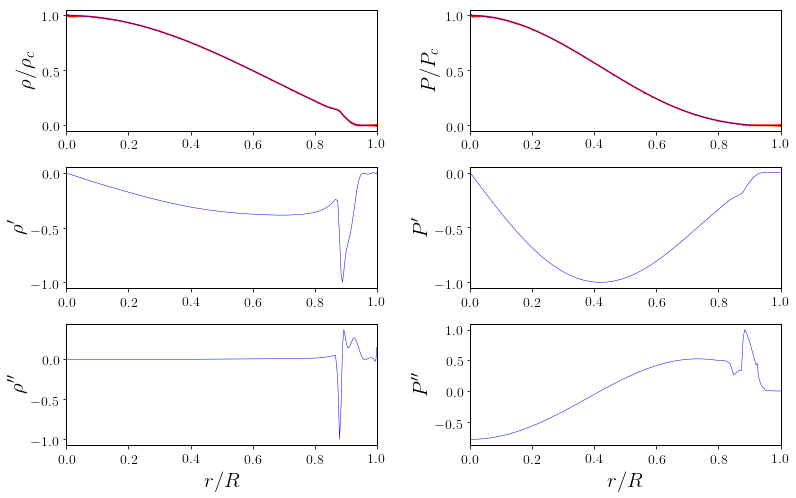

In [153]:
fig=plt.figure(figsize=[12.8,8])

plt.subplot(321)
plt.plot(pal6_150[-1]/pal6_150[-1][-1],pal6_150[2]/pal6_150[2][0],color='red',marker='o',markersize='0.4') 
plt.plot(pal6_150[-1]/pal6_150[-1][-1],pal6_150rho(pal6_150[-1])/pal6_150[2][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1) # leaving the crust out

plt.subplot(322)
plt.plot(pal6_150[-1]/pal6_150[-1][-1],pal6_150[1]/pal6_150[1][0],color='red',marker='o',markersize='0.4') 
plt.plot(pal6_150[-1]/pal6_150[-1][-1],pal6_150p(pal6_150[-1])/pal6_150[1][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$P/P_c$')
plt.xlim(0,1)

plt.subplot(323)
plt.plot(pal6_150[-1]/pal6_150[-1][-1],pal6_150drho(pal6_150[-1])/max(abs(pal6_150drho(pal6_150[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime}$')
plt.xlim(0,1)
#plt.ylim(-500,0)

plt.subplot(324)
plt.plot(pal6_150[-1]/pal6_150[-1][-1],pal6_150dp(pal6_150[-1])/max(abs(pal6_150dp(pal6_150[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime} $')
plt.xlim(0,1)

plt.subplot(325)
plt.plot(pal6_150[-1]/pal6_150[-1][-1],pal6_150ddrho(pal6_150[-1])/max(abs(pal6_150ddrho(pal6_150[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}$')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-0.01,0.01)

plt.subplot(326)
plt.plot(pal6_150[-1]/pal6_150[-1][-1],pal6_150ddp(pal6_150[-1])/max(abs(pal6_150ddp(pal6_150[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime\prime}$ ')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-1,1)

fig.subplots_adjust(hspace=0.3,wspace=0.3)

#plt.savefig('figures/ddspal6_150.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

### 15.5

In [154]:
pal6_155=np.loadtxt('results/pal6/15.5.dat',unpack=True)
pal6_155[3] = pal6_155[3]-pal6_155[3][-1] + 0.5*np.log(1-2*pal6_155[0][-1]/pal6_155[-1][-1])

In [155]:
s1=1e-5
s2=1e-9
pal6_155rho=interpolate.UnivariateSpline(pal6_155[-1], pal6_155[2], k=5, s=s1)
pal6_155drho=interpolate.UnivariateSpline(pal6_155[-1], pal6_155[2], k=5, s=s1).derivative(n=1)
pal6_155ddrho=interpolate.UnivariateSpline(pal6_155[-1], pal6_155[2], k=5, s=s1).derivative(n=2)

pal6_155p=interpolate.UnivariateSpline(pal6_155[-1], pal6_155[1], k=5, s=s2)
pal6_155dp=interpolate.UnivariateSpline(pal6_155[-1], pal6_155[1], k=5, s=s2).derivative(n=1)
pal6_155ddp=interpolate.UnivariateSpline(pal6_155[-1], pal6_155[1], k=5, s=s2).derivative(n=2)

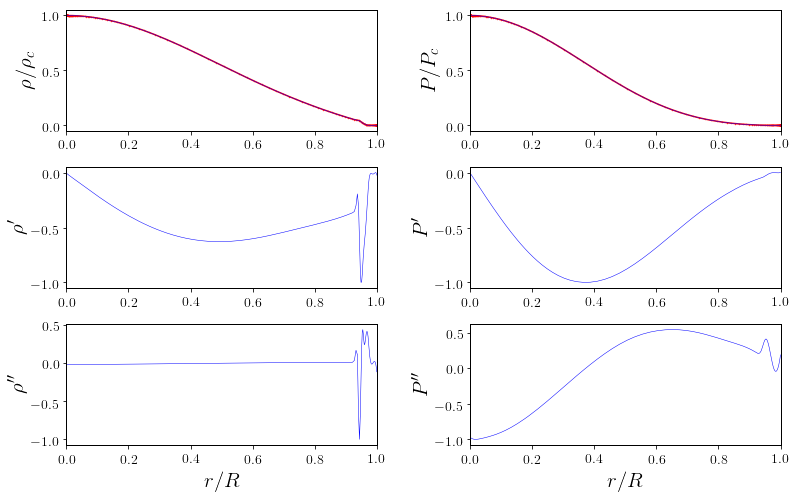

In [156]:
fig=plt.figure(figsize=[12.8,8])

plt.subplot(321)
plt.plot(pal6_155[-1]/pal6_155[-1][-1],pal6_155[2]/pal6_155[2][0],color='red',marker='o',markersize='0.4') 
plt.plot(pal6_155[-1]/pal6_155[-1][-1],pal6_155rho(pal6_155[-1])/pal6_155[2][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1) # leaving the crust out

plt.subplot(322)
plt.plot(pal6_155[-1]/pal6_155[-1][-1],pal6_155[1]/pal6_155[1][0],color='red',marker='o',markersize='0.4') 
plt.plot(pal6_155[-1]/pal6_155[-1][-1],pal6_155p(pal6_155[-1])/pal6_155[1][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$P/P_c$')
plt.xlim(0,1)

plt.subplot(323)
plt.plot(pal6_155[-1]/pal6_155[-1][-1],pal6_155drho(pal6_155[-1])/max(abs(pal6_155drho(pal6_155[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime}$')
plt.xlim(0,1)
#plt.ylim(-500,0)

plt.subplot(324)
plt.plot(pal6_155[-1]/pal6_155[-1][-1],pal6_155dp(pal6_155[-1])/max(abs(pal6_155dp(pal6_155[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime} $')
plt.xlim(0,1)

plt.subplot(325)
plt.plot(pal6_155[-1]/pal6_155[-1][-1],pal6_155ddrho(pal6_155[-1])/max(abs(pal6_155ddrho(pal6_155[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}$')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-0.01,0.01)

plt.subplot(326)
plt.plot(pal6_155[-1]/pal6_155[-1][-1],pal6_155ddp(pal6_155[-1])/max(abs(pal6_155ddp(pal6_155[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime\prime}$ ')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-1,1)

fig.subplots_adjust(hspace=0.3,wspace=0.3)

#plt.savefig('figures/ddspal6_155.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

## Redshift

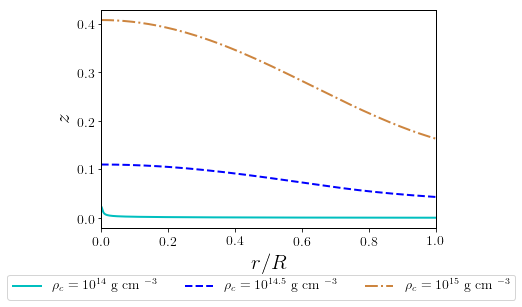

In [157]:
fig = plt.figure()

plt.plot(pal6_140[-1]/pal6_140[-1][-1],np.exp(-pal6_140[3])-1.0,color='c',linewidth='2.0',label=r'$\rho_c=10^{14}$ g cm $^{-3}$')
plt.plot(pal6_145[-1]/pal6_145[-1][-1],np.exp(-pal6_145[3])-1.0,color='blue',linewidth='2.0',linestyle='--',label=r'$\rho_c=10^{14.5}$ g cm $^{-3}$')
plt.plot(pal6_150[-1]/pal6_150[-1][-1],np.exp(-pal6_150[3])-1.0,color='peru',linewidth='2.0',linestyle='-.',label=r'$\rho_c=10^{15}$ g cm $^{-3}$')

l = plt.legend(bbox_to_anchor=(1.1,-0.15), loc="lower right", 
                bbox_transform=fig.transFigure, ncol=3)

plt.xlabel(r'$r/R$')
plt.ylabel(r'$z$')
plt.xlim(0,1.0)

plt.savefig('figures/Redshiftpal6.pdf', format='pdf', dpi=1000,bbox_inches="tight")

# PCL2 --------------------------------------------------------------------------------------

In [158]:
rhopcl2,Ppcl2,npcl2=np.loadtxt('EOS/pcl2.dat',usecols=(2,1,0),unpack=True)

## Dominant energy condition

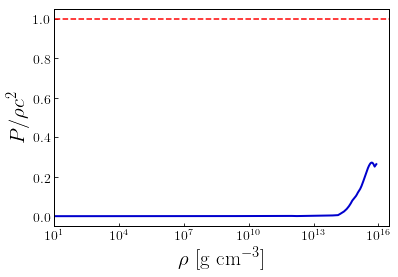

<Figure size 432x288 with 0 Axes>

In [159]:
fig, ax = plt.subplots()
plt.plot(rhopcl2,np.divide(Ppcl2,rhopcl2),lw='2',color='mediumblue')
plt.plot([0,10**(17)],[1.0,1.0],'r--',lw='1.5')

ax.set_xscale("log")
#locmaj = matplotlib.ticker.LogLocator(base=10.0,numticks=16) 
#ax.xaxis.set_major_locator(locmaj)


plt.xlabel(r'$\rho$ [g\,\,cm$^{-3}$]')
plt.ylabel(r'$ P / \rho c^2 $')
#locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks=16)
#ax.xaxis.set_minor_locator(locmin)
#ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.tick_params(axis="x", direction="in")
ax.tick_params(axis="y", direction="in")
plt.xlim(10,10**(16.5))
#ax.set_facecolor('floralwhite')
#plt.gca().set_aspect('equal', adjustable='box')
#plt.draw()
#plt.ylim(0,1)
plt.savefig('figures/ECpcl2.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()
plt.clf()

## Speed of sound

In [160]:
vsquared=interpolate.UnivariateSpline(rhopcl2, Ppcl2, k=1, s=0).derivative(n=1)

/home/dave/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  


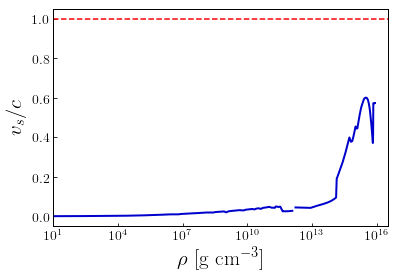

In [161]:
fig, ax = plt.subplots()
plt.plot(rhopcl2,np.sqrt(vsquared(rhopcl2)),lw='2.0',color='mediumblue')
plt.plot([1e+1,10**(16.5)],[1.0,1.0],'r--',lw='1.5')
plt.xlabel(r'$\rho$ [g\,\,cm$^{-3}$]')
plt.ylabel(r'$ v_s / c $')
plt.xscale('log')
ax.tick_params(axis="x", direction="in")
ax.tick_params(axis="y", direction="in")
plt.xlim(10,10**(16.5))
#ax.set_facecolor('floralwhite')
#mpl.rcParams['axes.linewidth'] = 1.4
#plt.gca().set_aspect('equal', adjustable='box')
#plt.draw()
plt.savefig('figures/SSpcl2.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

## Adiabatic Index

In [162]:
Gamma=np.multiply(np.divide(np.add(rhopcl2,Ppcl2),Ppcl2),vsquared(rhopcl2))

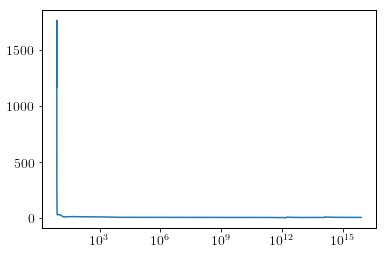

In [163]:
plt.plot(rhopcl2,Gamma)
plt.xscale('log')

$$ \langle\gamma\rangle=\frac{\int_{0}^{R} e^{(\lambda+3 \nu) } \gamma(r) P(r) r^{2} d r}{\int_{0}^{R} e^{(\lambda+3 \nu) } P(r) r^{2} d r} $$

Listing all the models calculated

In [164]:
owd=os.getcwd()
path=os.chdir('results/pcl2')
listOfEntries= os.scandir(path)
models_pcl2 = []
for entry in listOfEntries:
    if '1' in entry.name:
        models_pcl2.append(entry.name)
os.chdir(owd)
models_pcl2.sort()

In [165]:
gamma_efs1 = []
gamma_efs2 = []
gamma_crs1 = []
gamma_crs2 = []
rhosc= []
for model in models_pcl2:
    m, P, rho, nu, lambd, r = np.loadtxt('results/pcl2/' + model ,unpack=True)
    nu = nu - nu[-1] + 0.5*np.log(1-2*m[-1]/r[-1])
    #lambd = np.zeros_like(r)
    #for i in range((r.shape)[0]):
    #    if i==0:
    #        lambd[i] = 0
    #    else:
    #        lambd[i] = 0.5*np.log(1/(1-2*m[i]/r[i]))
    drho=interpolate.UnivariateSpline(r, rho, k=5, s=0).derivative(n=1)
    dP=interpolate.UnivariateSpline(r, P, k=5, s=0).derivative(n=1)
    gamma = np.divide(dP(r),drho(r))
    gamma_ef1 = integrate.trapz(np.exp(lambd+3*nu)*gamma*P*(r**2),r)/integrate.trapz(np.exp(lambd+3*nu)*P*(r**2),r)
    t1 = (1/36)*integrate.trapz(np.exp((lambd+3*nu))*(16*P+(np.exp(2*lambd)-1)*(P+rho))*(np.exp(2*lambd)-1)*(r**2))/integrate.trapz(np.exp(lambd+3*nu)*P*(r**2),r)
    t2 = (4*np.pi/9)*integrate.trapz(np.exp(3*lambd+3*nu)*(8*P + (np.exp(2*lambd)+1)*(P+rho))*P*(r**4),r)/integrate.trapz(np.exp(lambd+3*nu)*P*(r**2),r)
    t3 = ((16*np.pi**2)/9)*integrate.trapz(np.exp(5*lambd+3*nu)*(P+rho)*(P**2)*(r**6),r)/integrate.trapz(np.exp(lambd+3*nu)*P*(r**2),r)
    gamma_cr1 = 4/3 + t1 + t2 + t3
    gamma_efs1.append(gamma_ef1)
    gamma_crs1.append(gamma_cr1)
    gamma_ef2 = integrate.trapz(gamma*P*r**2,r)/integrate.trapz(P*r**2,r)
    gamma_cr2 = 4/3 + (19/42)*2*m[-1]/r[-1]
    gamma_efs2.append(gamma_ef2)
    gamma_crs2.append(gamma_cr2)
    rhosc.append(rho[0]*rhodim)

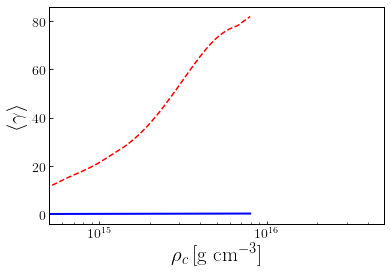

In [166]:
fig, ax = plt.subplots()
plt.plot(rhosc,gamma_crs1,lw='1.5',color='r',linestyle='--',label=r'$\gamma_{cr}$')
plt.plot(rhosc,gamma_efs1,lw='2.0',color='blue',label=r'$\langle \gamma \rangle$')

plt.xlabel(r'$\rho_c\,[$g cm$^{-3}]$')
plt.ylabel(r'$\langle \gamma \rangle$')

plt.xscale('log')
plt.xlim(left=10**(14.7),right=10**(16.7))
#plt.ylim(0,10)
ax.tick_params(axis="x", direction="in",which='both')
ax.tick_params(axis="y", direction="in",which='both')
#l = plt.legend(bbox_to_anchor=(0.85,-0.15), loc="lower right", 
                #bbox_transform=fig.transFigure, ncol=2)



plt.savefig('figures/AdiabaticIndexpcl2.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

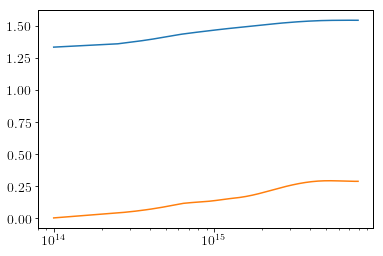

In [167]:
plt.plot(rhosc,gamma_crs2)
plt.plot(rhosc,gamma_efs2)
plt.xscale('log')

## M - $\rho_c$

In [168]:
Rpcl2,Mpcl2,rhocpcl2=np.loadtxt('results/pcl2/MRrhoc.dat',usecols=(0,1,2),unpack=True)

In [169]:
np.amax(Mpcl2)

1.48316425318

In [170]:
rhocpcl2[np.argmax(Mpcl2)]

3162277660170000.0

In [171]:
np.log10(rhocpcl2[np.argmax(Mpcl2)])

15.500000000000222

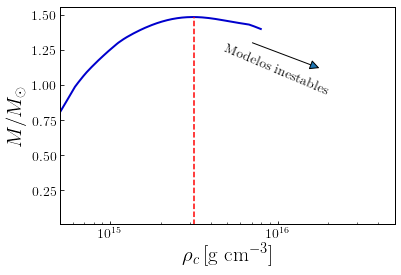

In [172]:
fig, ax = plt.subplots()

plt.plot(rhocpcl2,Mpcl2,color='mediumblue',lw='2.0')
plt.plot([10**(np.log10(rhocpcl2[np.argmax(Mpcl2)])),10**(np.log10(rhocpcl2[np.argmax(Mpcl2)]))],[0.0,np.amax(Mpcl2)],'r--',lw='1.5')

prop = dict(arrowstyle="-|>,head_width=0.4,head_length=0.8",
            shrinkA=0,shrinkB=0)
plt.annotate("", xy=(10**(16.25),1.12), xytext=(10**(15.85),1.3), arrowprops=prop)
#plt.arrow(10**(15.6), 1.38,10**(15.7) ,-0.1 , head_width=0.05, head_lpcl2th=10**(15))
plt.text(10**(15.67), 1.23, 'Modelos inestables' , fontsize=14,rotation=-23)

plt.xscale('log')
plt.xlabel(r'$\rho_c\,[$g cm$^{-3}]$')
plt.ylabel(r'$M/M_{\odot}$')
plt.xlim(left=10**(14.7),right=10**(16.7))
plt.ylim(bottom=0.01)
ax.tick_params(axis="x", direction="in",which='both')
ax.tick_params(axis="y", direction="in",which='both')

plt.savefig('figures/Mrhorel_pcl2.pdf', format='pdf', dpi=1000,bbox_inches="tight")

## Tunning the interpolation of the solution

### 14.0

In [173]:
pcl2_140=np.loadtxt('results/pcl2/14.0.dat',unpack=True)
pcl2_140[3] = pcl2_140[3]-pcl2_140[3][-1] + 0.5*np.log(1-2*pcl2_140[0][-1]/pcl2_140[-1][-1])

In [174]:
s1=5e-7
s2=1e-15
pcl2_140rho=interpolate.UnivariateSpline(pcl2_140[-1], pcl2_140[2], k=5, s=s1)
pcl2_140drho=interpolate.UnivariateSpline(pcl2_140[-1], pcl2_140[2], k=5, s=s1).derivative(n=1)
pcl2_140ddrho=interpolate.UnivariateSpline(pcl2_140[-1], pcl2_140[2], k=5, s=s1).derivative(n=2)

pcl2_140p=interpolate.UnivariateSpline(pcl2_140[-1], pcl2_140[1], k=5, s=s2)
pcl2_140dp=interpolate.UnivariateSpline(pcl2_140[-1], pcl2_140[1], k=5, s=s2).derivative(n=1)
pcl2_140ddp=interpolate.UnivariateSpline(pcl2_140[-1], pcl2_140[1], k=5, s=s2).derivative(n=2)

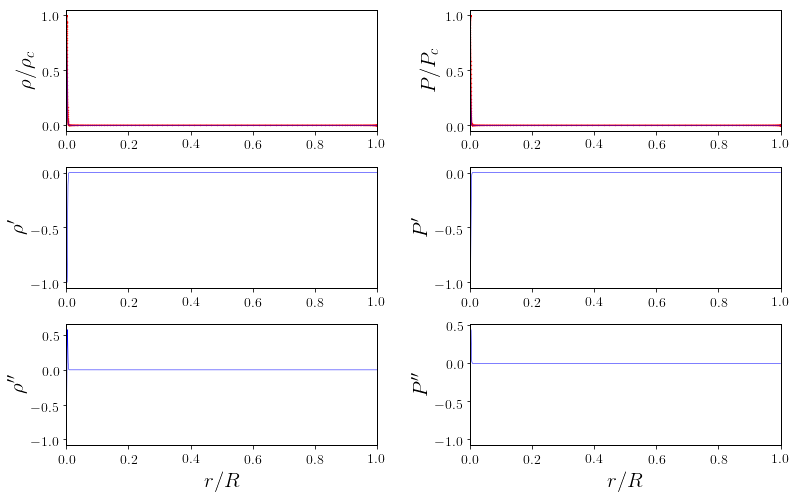

In [175]:
fig=plt.figure(figsize=[12.8,8])

plt.subplot(321)
plt.plot(pcl2_140[-1]/pcl2_140[-1][-1],pcl2_140[2]/pcl2_140[2][0],color='red',marker='o',markersize='0.4') 
plt.plot(pcl2_140[-1]/pcl2_140[-1][-1],pcl2_140rho(pcl2_140[-1])/pcl2_140[2][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1) # leaving the crust out

plt.subplot(322)
plt.plot(pcl2_140[-1]/pcl2_140[-1][-1],pcl2_140[1]/pcl2_140[1][0],color='red',marker='o',markersize='0.4') 
plt.plot(pcl2_140[-1]/pcl2_140[-1][-1],pcl2_140p(pcl2_140[-1])/pcl2_140[1][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$P/P_c$')
plt.xlim(0,1)

plt.subplot(323)
plt.plot(pcl2_140[-1]/pcl2_140[-1][-1],pcl2_140drho(pcl2_140[-1])/max(abs(pcl2_140drho(pcl2_140[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime}$')
plt.xlim(0,1)
#plt.ylim(-500,0)

plt.subplot(324)
plt.plot(pcl2_140[-1]/pcl2_140[-1][-1],pcl2_140dp(pcl2_140[-1])/max(abs(pcl2_140dp(pcl2_140[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime} $')
plt.xlim(0,1)

plt.subplot(325)
plt.plot(pcl2_140[-1]/pcl2_140[-1][-1],pcl2_140ddrho(pcl2_140[-1])/max(abs(pcl2_140ddrho(pcl2_140[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}$')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-0.01,0.01)

plt.subplot(326)
plt.plot(pcl2_140[-1]/pcl2_140[-1][-1],pcl2_140ddp(pcl2_140[-1])/max(abs(pcl2_140ddp(pcl2_140[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime\prime}$ ')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-1,1)

fig.subplots_adjust(hspace=0.3,wspace=0.3)

#plt.savefig('figures/ddspcl2_140.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

### 14.5

In [176]:
pcl2_145=np.loadtxt('results/pcl2/14.5.dat',unpack=True)
pcl2_145[3] = pcl2_145[3]-pcl2_145[3][-1] + 0.5*np.log(1-2*pcl2_145[0][-1]/pcl2_145[-1][-1])

In [177]:
s1=1e-7
s2=1e-12
pcl2_145rho=interpolate.UnivariateSpline(pcl2_145[-1], pcl2_145[2], k=5, s=s1)
pcl2_145drho=interpolate.UnivariateSpline(pcl2_145[-1], pcl2_145[2], k=5, s=s1).derivative(n=1)
pcl2_145ddrho=interpolate.UnivariateSpline(pcl2_145[-1], pcl2_145[2], k=5, s=s1).derivative(n=2)

pcl2_145p=interpolate.UnivariateSpline(pcl2_145[-1], pcl2_145[1], k=5, s=s2)
pcl2_145dp=interpolate.UnivariateSpline(pcl2_145[-1], pcl2_145[1], k=5, s=s2).derivative(n=1)
pcl2_145ddp=interpolate.UnivariateSpline(pcl2_145[-1], pcl2_145[1], k=5, s=s2).derivative(n=2)

In [178]:
pcl2_145rho(0.4*pcl2_145[-1][-1])*rhodim

246887169585243.5

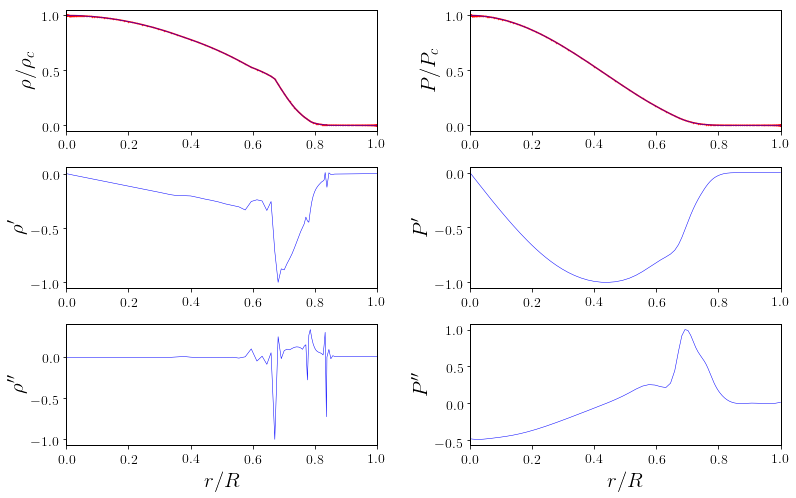

In [179]:
fig=plt.figure(figsize=[12.8,8])

plt.subplot(321)
plt.plot(pcl2_145[-1]/pcl2_145[-1][-1],pcl2_145[2]/pcl2_145[2][0],color='red',marker='o',markersize='0.4') 
plt.plot(pcl2_145[-1]/pcl2_145[-1][-1],pcl2_145rho(pcl2_145[-1])/pcl2_145[2][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1) # leaving the crust out

plt.subplot(322)
plt.plot(pcl2_145[-1]/pcl2_145[-1][-1],pcl2_145[1]/pcl2_145[1][0],color='red',marker='o',markersize='0.4') 
plt.plot(pcl2_145[-1]/pcl2_145[-1][-1],pcl2_145p(pcl2_145[-1])/pcl2_145[1][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$P/P_c$')
plt.xlim(0,1)

plt.subplot(323)
plt.plot(pcl2_145[-1]/pcl2_145[-1][-1],pcl2_145drho(pcl2_145[-1])/max(abs(pcl2_145drho(pcl2_145[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime}$')
plt.xlim(0,1)
#plt.ylim(-500,0)

plt.subplot(324)
plt.plot(pcl2_145[-1]/pcl2_145[-1][-1],pcl2_145dp(pcl2_145[-1])/max(abs(pcl2_145dp(pcl2_145[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime} $')
plt.xlim(0,1)

plt.subplot(325)
plt.plot(pcl2_145[-1]/pcl2_145[-1][-1],pcl2_145ddrho(pcl2_145[-1])/max(abs(pcl2_145ddrho(pcl2_145[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}$')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-0.01,0.01)

plt.subplot(326)
plt.plot(pcl2_145[-1]/pcl2_145[-1][-1],pcl2_145ddp(pcl2_145[-1])/max(abs(pcl2_145ddp(pcl2_145[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime\prime}$ ')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-1,1)

fig.subplots_adjust(hspace=0.3,wspace=0.3)

#plt.savefig('figures/ddspcl2_145.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

### 15.0

In [180]:
pcl2_150=np.loadtxt('results/pcl2/15.0.dat',unpack=True)
pcl2_150[3] = pcl2_150[3]-pcl2_150[3][-1] + 0.5*np.log(1-2*pcl2_150[0][-1]/pcl2_150[-1][-1])

In [181]:
s1=8e-6
s2=1e-15
pcl2_150rho=interpolate.UnivariateSpline(pcl2_150[-1], pcl2_150[2], k=5, s=s1)
pcl2_150drho=interpolate.UnivariateSpline(pcl2_150[-1], pcl2_150[2], k=5, s=s1).derivative(n=1)
pcl2_150ddrho=interpolate.UnivariateSpline(pcl2_150[-1], pcl2_150[2], k=5, s=s1).derivative(n=2)

pcl2_150p=interpolate.UnivariateSpline(pcl2_150[-1], pcl2_150[1], k=5, s=s2)
pcl2_150dp=interpolate.UnivariateSpline(pcl2_150[-1], pcl2_150[1], k=5, s=s2).derivative(n=1)
pcl2_150ddp=interpolate.UnivariateSpline(pcl2_150[-1], pcl2_150[1], k=5, s=s2).derivative(n=2)

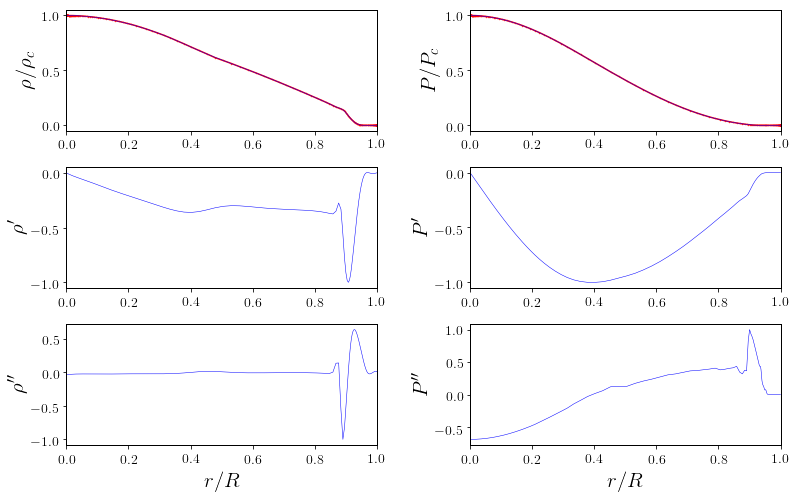

In [182]:
fig=plt.figure(figsize=[12.8,8])

plt.subplot(321)
plt.plot(pcl2_150[-1]/pcl2_150[-1][-1],pcl2_150[2]/pcl2_150[2][0],color='red',marker='o',markersize='0.4') 
plt.plot(pcl2_150[-1]/pcl2_150[-1][-1],pcl2_150rho(pcl2_150[-1])/pcl2_150[2][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1) # leaving the crust out

plt.subplot(322)
plt.plot(pcl2_150[-1]/pcl2_150[-1][-1],pcl2_150[1]/pcl2_150[1][0],color='red',marker='o',markersize='0.4') 
plt.plot(pcl2_150[-1]/pcl2_150[-1][-1],pcl2_150p(pcl2_150[-1])/pcl2_150[1][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$P/P_c$')
plt.xlim(0,1)

plt.subplot(323)
plt.plot(pcl2_150[-1]/pcl2_150[-1][-1],pcl2_150drho(pcl2_150[-1])/max(abs(pcl2_150drho(pcl2_150[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime}$')
plt.xlim(0,1)
#plt.ylim(-500,0)

plt.subplot(324)
plt.plot(pcl2_150[-1]/pcl2_150[-1][-1],pcl2_150dp(pcl2_150[-1])/max(abs(pcl2_150dp(pcl2_150[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime} $')
plt.xlim(0,1)

plt.subplot(325)
plt.plot(pcl2_150[-1]/pcl2_150[-1][-1],pcl2_150ddrho(pcl2_150[-1])/max(abs(pcl2_150ddrho(pcl2_150[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}$')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-0.01,0.01)

plt.subplot(326)
plt.plot(pcl2_150[-1]/pcl2_150[-1][-1],pcl2_150ddp(pcl2_150[-1])/max(abs(pcl2_150ddp(pcl2_150[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime\prime}$ ')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-1,1)

fig.subplots_adjust(hspace=0.3,wspace=0.3)

#plt.savefig('figures/ddspcl2_150.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

### 15.5

In [183]:
pcl2_155=np.loadtxt('results/pcl2/15.5.dat',unpack=True)
pcl2_155[3] = pcl2_155[3]-pcl2_155[3][-1] + 0.5*np.log(1-2*pcl2_155[0][-1]/pcl2_155[-1][-1])

In [184]:
s1=1e-5
s2=1e-9
pcl2_155rho=interpolate.UnivariateSpline(pcl2_155[-1], pcl2_155[2], k=5, s=s1)
pcl2_155drho=interpolate.UnivariateSpline(pcl2_155[-1], pcl2_155[2], k=5, s=s1).derivative(n=1)
pcl2_155ddrho=interpolate.UnivariateSpline(pcl2_155[-1], pcl2_155[2], k=5, s=s1).derivative(n=2)

pcl2_155p=interpolate.UnivariateSpline(pcl2_155[-1], pcl2_155[1], k=5, s=s2)
pcl2_155dp=interpolate.UnivariateSpline(pcl2_155[-1], pcl2_155[1], k=5, s=s2).derivative(n=1)
pcl2_155ddp=interpolate.UnivariateSpline(pcl2_155[-1], pcl2_155[1], k=5, s=s2).derivative(n=2)

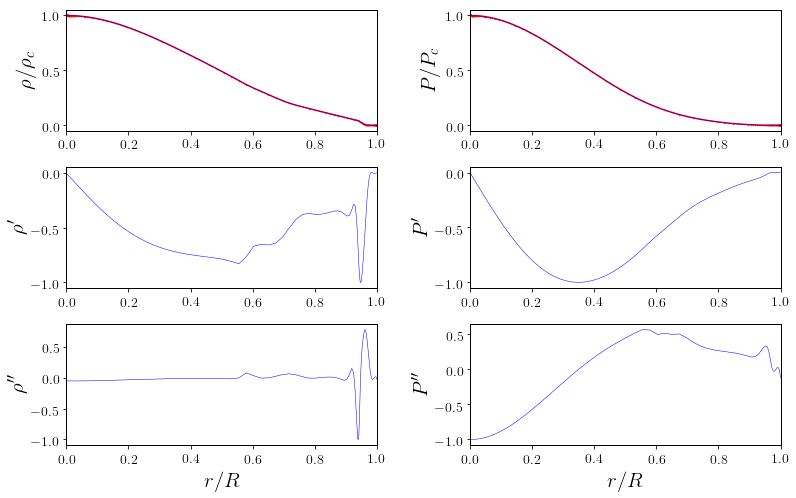

In [185]:
fig=plt.figure(figsize=[12.8,8])

plt.subplot(321)
plt.plot(pcl2_155[-1]/pcl2_155[-1][-1],pcl2_155[2]/pcl2_155[2][0],color='red',marker='o',markersize='0.4') 
plt.plot(pcl2_155[-1]/pcl2_155[-1][-1],pcl2_155rho(pcl2_155[-1])/pcl2_155[2][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1) # leaving the crust out

plt.subplot(322)
plt.plot(pcl2_155[-1]/pcl2_155[-1][-1],pcl2_155[1]/pcl2_155[1][0],color='red',marker='o',markersize='0.4') 
plt.plot(pcl2_155[-1]/pcl2_155[-1][-1],pcl2_155p(pcl2_155[-1])/pcl2_155[1][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$P/P_c$')
plt.xlim(0,1)

plt.subplot(323)
plt.plot(pcl2_155[-1]/pcl2_155[-1][-1],pcl2_155drho(pcl2_155[-1])/max(abs(pcl2_155drho(pcl2_155[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime}$')
plt.xlim(0,1)
#plt.ylim(-500,0)

plt.subplot(324)
plt.plot(pcl2_155[-1]/pcl2_155[-1][-1],pcl2_155dp(pcl2_155[-1])/max(abs(pcl2_155dp(pcl2_155[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime} $')
plt.xlim(0,1)

plt.subplot(325)
plt.plot(pcl2_155[-1]/pcl2_155[-1][-1],pcl2_155ddrho(pcl2_155[-1])/max(abs(pcl2_155ddrho(pcl2_155[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}$')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-0.01,0.01)

plt.subplot(326)
plt.plot(pcl2_155[-1]/pcl2_155[-1][-1],pcl2_155ddp(pcl2_155[-1])/max(abs(pcl2_155ddp(pcl2_155[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime\prime}$ ')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-1,1)

fig.subplots_adjust(hspace=0.3,wspace=0.3)

#plt.savefig('figures/ddspcl2_155.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

## Redshift

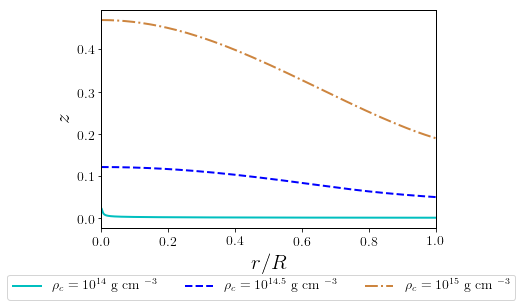

In [186]:
fig = plt.figure()

plt.plot(pcl2_140[-1]/pcl2_140[-1][-1],np.exp(-pcl2_140[3])-1.0,color='c',linewidth='2.0',label=r'$\rho_c=10^{14}$ g cm $^{-3}$')
plt.plot(pcl2_145[-1]/pcl2_145[-1][-1],np.exp(-pcl2_145[3])-1.0,color='blue',linewidth='2.0',linestyle='--',label=r'$\rho_c=10^{14.5}$ g cm $^{-3}$')
plt.plot(pcl2_150[-1]/pcl2_150[-1][-1],np.exp(-pcl2_150[3])-1.0,color='peru',linewidth='2.0',linestyle='-.',label=r'$\rho_c=10^{15}$ g cm $^{-3}$')

l = plt.legend(bbox_to_anchor=(1.1,-0.15), loc="lower right", 
                bbox_transform=fig.transFigure, ncol=3)

plt.xlabel(r'$r/R$')
plt.ylabel(r'$z$')
plt.xlim(0,1.0)

plt.savefig('figures/Redshiftpcl2.pdf', format='pdf', dpi=1000,bbox_inches="tight")

# PS ------------------------------------------------------------------------------------------

In [88]:
rhops,Pps,nps=np.loadtxt('EOS/ps.dat',usecols=(2,1,0),unpack=True)

## Dominant energy condition

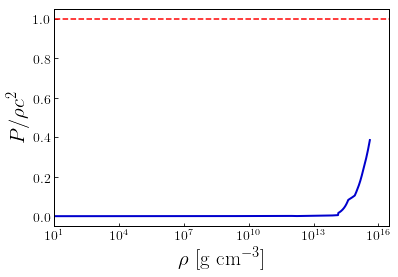

<Figure size 432x288 with 0 Axes>

In [89]:
fig, ax = plt.subplots()
plt.plot(rhops,np.divide(Pps,rhops),lw='2',color='mediumblue')
plt.plot([0,10**(17)],[1.0,1.0],'r--',lw='1.5')

ax.set_xscale("log")
#locmaj = matplotlib.ticker.LogLocator(base=10.0,numticks=16) 
#ax.xaxis.set_major_locator(locmaj)


plt.xlabel(r'$\rho$ [g\,\,cm$^{-3}$]')
plt.ylabel(r'$ P / \rho c^2 $')
#locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks=16)
#ax.xaxis.set_minor_locator(locmin)
#ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.tick_params(axis="x", direction="in")
ax.tick_params(axis="y", direction="in")
plt.xlim(10,10**(16.5))
#ax.set_facecolor('floralwhite')
#plt.gca().set_aspect('equal', adjustable='box')
#plt.draw()
#plt.ylim(0,1)
plt.savefig('figures/ECps.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()
plt.clf()

## Speed of sound

In [90]:
vsquared=interpolate.UnivariateSpline(rhops, Pps, k=1, s=0).derivative(n=1)

/home/dave/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  


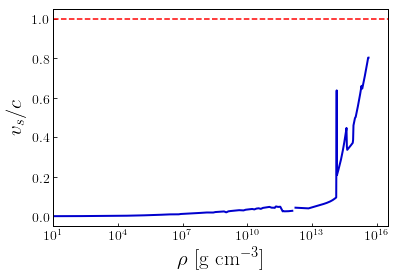

In [91]:
fig, ax = plt.subplots()
plt.plot(rhops,np.sqrt(vsquared(rhops)),lw='2.0',color='mediumblue')
plt.plot([1e+1,10**(16.5)],[1.0,1.0],'r--',lw='1.5')
plt.xlabel(r'$\rho$ [g\,\,cm$^{-3}$]')
plt.ylabel(r'$ v_s / c $')
plt.xscale('log')
ax.tick_params(axis="x", direction="in")
ax.tick_params(axis="y", direction="in")
plt.xlim(10,10**(16.5))
#ax.set_facecolor('floralwhite')
#mpl.rcParams['axes.linewidth'] = 1.4
#plt.gca().set_aspect('equal', adjustable='box')
#plt.draw()
plt.savefig('figures/SSps.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

## Adiabatic Index

In [92]:
Gamma=np.multiply(np.divide(np.add(rhops,Pps),Pps),vsquared(rhops))

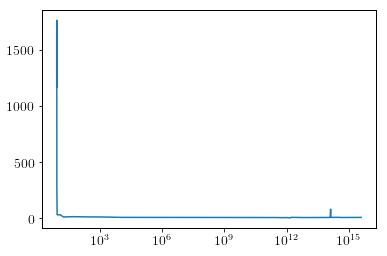

In [93]:
plt.plot(rhops,Gamma)
plt.xscale('log')

$$ \langle\gamma\rangle=\frac{\int_{0}^{R} e^{(\lambda+3 \nu) } \gamma(r) P(r) r^{2} d r}{\int_{0}^{R} e^{(\lambda+3 \nu) } P(r) r^{2} d r} $$

Listing all the models calculated

In [96]:
owd=os.getcwd()
path=os.chdir('results/ps')
listOfEntries= os.scandir(path)
models_ps = []
for entry in listOfEntries:
    if '1' in entry.name:
        models_ps.append(entry.name)
os.chdir(owd)
models_ps.sort()

In [98]:
gamma_efs = []
gamma_crs = []
rhosc= []
betas=[]
for model in models_ps:
    m, P, rho, nu, lambd, r = np.loadtxt('results/ps/' + model ,unpack=True)
    nu = nu - nu[-1] + 0.5*np.log(1-2*m[-1]/r[-1])
    drho=interpolate.UnivariateSpline(r, rho, k=5, s=0).derivative(n=1)
    dP=interpolate.UnivariateSpline(r, P, k=5, s=0).derivative(n=1)
    gamma = np.divide(dP(r),drho(r))
    gamma_ef = integrate.trapz(np.exp(lambd+3*nu)*gamma*P*(r**2),r)/integrate.trapz(np.exp(lambd+3*nu)*P*(r**2),r)
    t1 = (4/9)*integrate.trapz(np.exp((lambd+3*nu))*(16*P+(np.exp(2*lambd)-1)*(P+rho))*(np.exp(2*lambd)-1)*(r**2),r)/integrate.trapz(np.exp(lambd+3*nu)*P*(r**2),r)
    t2 = (4*np.pi/9)*integrate.trapz(np.exp(3*lambd+3*nu)*(8*P + (np.exp(2*lambd)+1)*(P+rho))*P*(r**4),r)/integrate.trapz(np.exp(lambd+3*nu)*P*(r**2),r)
    t3 = ((16*np.pi**2)/9)*integrate.trapz(np.exp(5*lambd+3*nu)*(P+rho)*(P**2)*(r**6),r)/integrate.trapz(np.exp(lambd+3*nu)*P*(r**2),r)
    gamma_cr = 4/3 + t1 + t2 + t3
    gamma_efs.append(gamma_ef)
    gamma_crs.append(gamma_cr)
    betas.append(m[-1]/r[-1])
    rhosc.append(rho[0]*rhodim)

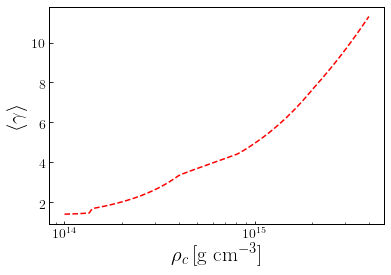

In [99]:
fig, ax = plt.subplots()
plt.plot(rhosc,gamma_crs,lw='1.5',color='r',linestyle='--',label=r'$\gamma_{cr}$')
#plt.plot(rhosc,gamma_efs,lw='2.0',color='blue',label=r'$\langle \gamma \rangle$')

plt.xlabel(r'$\rho_c\,[$g cm$^{-3}]$')
plt.ylabel(r'$\langle \gamma \rangle$')

plt.xscale('log')
#plt.xlim(left=10**(14.7),right=10**(16.7))
#plt.ylim(0,4)
ax.tick_params(axis="x", direction="in",which='both')
ax.tick_params(axis="y", direction="in",which='both')
#l = plt.legend(bbox_to_anchor=(0.85,-0.15), loc="lower right", 
                #bbox_transform=fig.transFigure, ncol=2)



plt.savefig('figures/AdiabaticIndexrhocPS.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

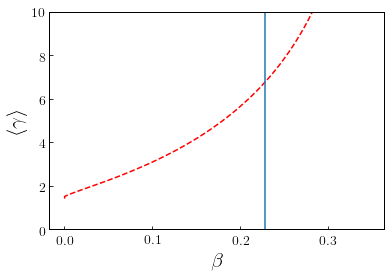

In [136]:
fig, ax = plt.subplots()
plt.plot(betas,gamma_crs,lw='1.5',color='r',linestyle='--',label=r'$\gamma_{cr}$')
plt.plot([betacrit,betacrit],[0,10])
#plt.plot(betas,gamma_efs,lw='2.0',color='blue',label=r'$\langle \gamma \rangle$')

plt.xlabel(r'$\beta$')
plt.ylabel(r'$\langle \gamma \rangle$')

#plt.xscale('log')
#plt.xlim(left=10**(14.7),right=10**(16.7))
plt.ylim(0,10)
ax.tick_params(axis="x", direction="in",which='both')
ax.tick_params(axis="y", direction="in",which='both')
#l = plt.legend(bbox_to_anchor=(0.85,-0.15), loc="lower right", 
                #bbox_transform=fig.transFigure, ncol=2)



plt.savefig('figures/AdiabaticIndexPSbeta.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

## M - $\rho_c$

In [101]:
Rps,Mps,rhocps=np.loadtxt('results/ps/MRrhoc.dat',usecols=(0,1,2),unpack=True)

In [102]:
np.amax(Mps)

1.7552463597

In [135]:
betacrit = G*np.amax(Mps)*Msun/(1e+5*Rps[np.argmax(Mps)]*c**2)
betacrit

0.22785008468801796

In [104]:
rhocps[np.argmax(Mps)]

2570395782770000.0

In [105]:
np.log10(rhocps[np.argmax(Mps)])

15.410000000000192

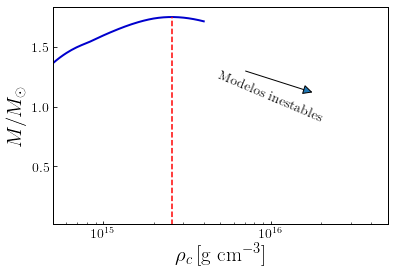

In [115]:
fig, ax = plt.subplots()

plt.plot(rhocps,Mps,color='mediumblue',lw='2.0')
plt.plot([10**(np.log10(rhocps[np.argmax(Mps)])),10**(np.log10(rhocps[np.argmax(Mps)]))],[0.0,np.amax(Mps)],'r--',lw='1.5')

prop = dict(arrowstyle="-|>,head_width=0.4,head_length=0.8",
            shrinkA=0,shrinkB=0)
plt.annotate("", xy=(10**(16.25),1.12), xytext=(10**(15.85),1.3), arrowprops=prop)
#plt.arrow(10**(15.6), 1.38,10**(15.7) ,-0.1 , head_width=0.05, head_lpsth=10**(15))
plt.text(10**(15.67), 1.23, 'Modelos inestables' , fontsize=14,rotation=-23)

plt.xscale('log')
plt.xlabel(r'$\rho_c\,[$g cm$^{-3}]$')
plt.ylabel(r'$M/M_{\odot}$')
plt.xlim(left=10**(14.7),right=10**(16.7))
plt.ylim(bottom=0.01)
ax.tick_params(axis="x", direction="in",which='both')
ax.tick_params(axis="y", direction="in",which='both')

plt.savefig('figures/Mrhorel_ps.pdf', format='pdf', dpi=1000,bbox_inches="tight")

## Tunning the interpolation of the solution

### 14.0

In [116]:
ps_140=np.loadtxt('results/ps/14.0.dat',unpack=True)
ps_140[3] = ps_140[3]-ps_140[3][-1] + 0.5*np.log(1-2*ps_140[0][-1]/ps_140[-1][-1])

In [117]:
s1=5e-7
s2=1e-15
ps_140rho=interpolate.UnivariateSpline(ps_140[-1], ps_140[2], k=5, s=s1)
ps_140drho=interpolate.UnivariateSpline(ps_140[-1], ps_140[2], k=5, s=s1).derivative(n=1)
ps_140ddrho=interpolate.UnivariateSpline(ps_140[-1], ps_140[2], k=5, s=s1).derivative(n=2)

ps_140p=interpolate.UnivariateSpline(ps_140[-1], ps_140[1], k=5, s=s2)
ps_140dp=interpolate.UnivariateSpline(ps_140[-1], ps_140[1], k=5, s=s2).derivative(n=1)
ps_140ddp=interpolate.UnivariateSpline(ps_140[-1], ps_140[1], k=5, s=s2).derivative(n=2)

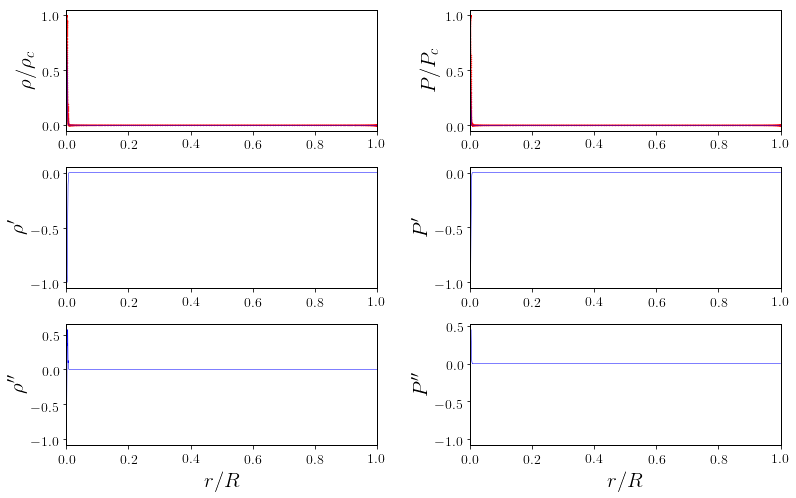

In [118]:
fig=plt.figure(figsize=[12.8,8])

plt.subplot(321)
plt.plot(ps_140[-1]/ps_140[-1][-1],ps_140[2]/ps_140[2][0],color='red',marker='o',markersize='0.4') 
plt.plot(ps_140[-1]/ps_140[-1][-1],ps_140rho(ps_140[-1])/ps_140[2][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1) # leaving the crust out

plt.subplot(322)
plt.plot(ps_140[-1]/ps_140[-1][-1],ps_140[1]/ps_140[1][0],color='red',marker='o',markersize='0.4') 
plt.plot(ps_140[-1]/ps_140[-1][-1],ps_140p(ps_140[-1])/ps_140[1][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$P/P_c$')
plt.xlim(0,1)

plt.subplot(323)
plt.plot(ps_140[-1]/ps_140[-1][-1],ps_140drho(ps_140[-1])/max(abs(ps_140drho(ps_140[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime}$')
plt.xlim(0,1)
#plt.ylim(-500,0)

plt.subplot(324)
plt.plot(ps_140[-1]/ps_140[-1][-1],ps_140dp(ps_140[-1])/max(abs(ps_140dp(ps_140[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime} $')
plt.xlim(0,1)

plt.subplot(325)
plt.plot(ps_140[-1]/ps_140[-1][-1],ps_140ddrho(ps_140[-1])/max(abs(ps_140ddrho(ps_140[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}$')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-0.01,0.01)

plt.subplot(326)
plt.plot(ps_140[-1]/ps_140[-1][-1],ps_140ddp(ps_140[-1])/max(abs(ps_140ddp(ps_140[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime\prime}$ ')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-1,1)

fig.subplots_adjust(hspace=0.3,wspace=0.3)

#plt.savefig('figures/ddsps_140.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

### 14.5

In [119]:
ps_145=np.loadtxt('results/ps/14.5.dat',unpack=True)
ps_145[3] = ps_145[3]-ps_145[3][-1] + 0.5*np.log(1-2*ps_145[0][-1]/ps_145[-1][-1])

In [120]:
s1=1e-7
s2=1e-12
ps_145rho=interpolate.UnivariateSpline(ps_145[-1], ps_145[2], k=5, s=s1)
ps_145drho=interpolate.UnivariateSpline(ps_145[-1], ps_145[2], k=5, s=s1).derivative(n=1)
ps_145ddrho=interpolate.UnivariateSpline(ps_145[-1], ps_145[2], k=5, s=s1).derivative(n=2)

ps_145p=interpolate.UnivariateSpline(ps_145[-1], ps_145[1], k=5, s=s2)
ps_145dp=interpolate.UnivariateSpline(ps_145[-1], ps_145[1], k=5, s=s2).derivative(n=1)
ps_145ddp=interpolate.UnivariateSpline(ps_145[-1], ps_145[1], k=5, s=s2).derivative(n=2)

In [121]:
ps_145rho(0.4*ps_145[-1][-1])*rhodim

263479086241371.75

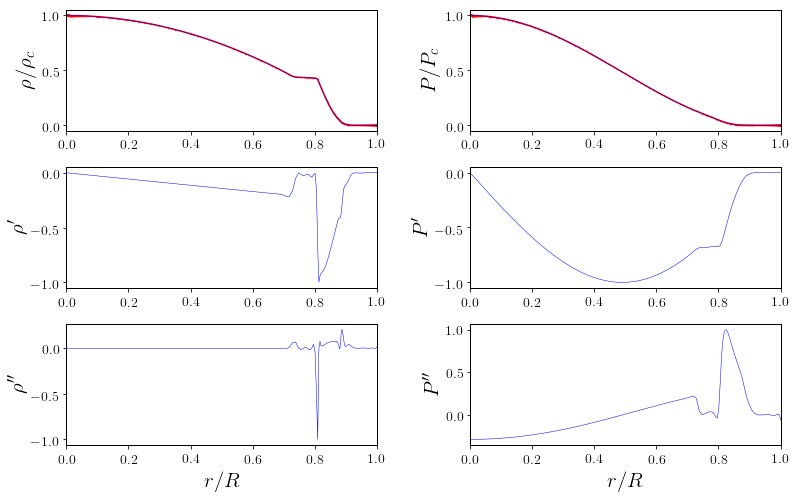

In [122]:
fig=plt.figure(figsize=[12.8,8])

plt.subplot(321)
plt.plot(ps_145[-1]/ps_145[-1][-1],ps_145[2]/ps_145[2][0],color='red',marker='o',markersize='0.4') 
plt.plot(ps_145[-1]/ps_145[-1][-1],ps_145rho(ps_145[-1])/ps_145[2][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1) # leaving the crust out

plt.subplot(322)
plt.plot(ps_145[-1]/ps_145[-1][-1],ps_145[1]/ps_145[1][0],color='red',marker='o',markersize='0.4') 
plt.plot(ps_145[-1]/ps_145[-1][-1],ps_145p(ps_145[-1])/ps_145[1][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$P/P_c$')
plt.xlim(0,1)

plt.subplot(323)
plt.plot(ps_145[-1]/ps_145[-1][-1],ps_145drho(ps_145[-1])/max(abs(ps_145drho(ps_145[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime}$')
plt.xlim(0,1)
#plt.ylim(-500,0)

plt.subplot(324)
plt.plot(ps_145[-1]/ps_145[-1][-1],ps_145dp(ps_145[-1])/max(abs(ps_145dp(ps_145[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime} $')
plt.xlim(0,1)

plt.subplot(325)
plt.plot(ps_145[-1]/ps_145[-1][-1],ps_145ddrho(ps_145[-1])/max(abs(ps_145ddrho(ps_145[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}$')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-0.01,0.01)

plt.subplot(326)
plt.plot(ps_145[-1]/ps_145[-1][-1],ps_145ddp(ps_145[-1])/max(abs(ps_145ddp(ps_145[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime\prime}$ ')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-1,1)

fig.subplots_adjust(hspace=0.3,wspace=0.3)

#plt.savefig('figures/ddsps_145.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

### 15.0

In [123]:
ps_150=np.loadtxt('results/ps/15.0.dat',unpack=True)
ps_150[3] = ps_150[3]-ps_150[3][-1] + 0.5*np.log(1-2*ps_150[0][-1]/ps_150[-1][-1])

In [124]:
s1=8e-6
s2=1e-15
ps_150rho=interpolate.UnivariateSpline(ps_150[-1], ps_150[2], k=5, s=s1)
ps_150drho=interpolate.UnivariateSpline(ps_150[-1], ps_150[2], k=5, s=s1).derivative(n=1)
ps_150ddrho=interpolate.UnivariateSpline(ps_150[-1], ps_150[2], k=5, s=s1).derivative(n=2)

ps_150p=interpolate.UnivariateSpline(ps_150[-1], ps_150[1], k=5, s=s2)
ps_150dp=interpolate.UnivariateSpline(ps_150[-1], ps_150[1], k=5, s=s2).derivative(n=1)
ps_150ddp=interpolate.UnivariateSpline(ps_150[-1], ps_150[1], k=5, s=s2).derivative(n=2)

ValueError: x must be strictly increasing

NameError: name 'ps_150rho' is not defined

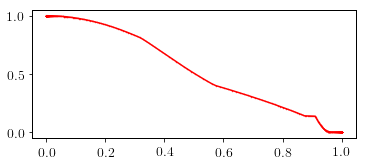

In [125]:
fig=plt.figure(figsize=[12.8,8])

plt.subplot(321)
plt.plot(ps_150[-1]/ps_150[-1][-1],ps_150[2]/ps_150[2][0],color='red',marker='o',markersize='0.4') 
plt.plot(ps_150[-1]/ps_150[-1][-1],ps_150rho(ps_150[-1])/ps_150[2][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1) # leaving the crust out

plt.subplot(322)
plt.plot(ps_150[-1]/ps_150[-1][-1],ps_150[1]/ps_150[1][0],color='red',marker='o',markersize='0.4') 
plt.plot(ps_150[-1]/ps_150[-1][-1],ps_150p(ps_150[-1])/ps_150[1][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$P/P_c$')
plt.xlim(0,1)

plt.subplot(323)
plt.plot(ps_150[-1]/ps_150[-1][-1],ps_150drho(ps_150[-1])/max(abs(ps_150drho(ps_150[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime}$')
plt.xlim(0,1)
#plt.ylim(-500,0)

plt.subplot(324)
plt.plot(ps_150[-1]/ps_150[-1][-1],ps_150dp(ps_150[-1])/max(abs(ps_150dp(ps_150[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime} $')
plt.xlim(0,1)

plt.subplot(325)
plt.plot(ps_150[-1]/ps_150[-1][-1],ps_150ddrho(ps_150[-1])/max(abs(ps_150ddrho(ps_150[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}$')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-0.01,0.01)

plt.subplot(326)
plt.plot(ps_150[-1]/ps_150[-1][-1],ps_150ddp(ps_150[-1])/max(abs(ps_150ddp(ps_150[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime\prime}$ ')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-1,1)

fig.subplots_adjust(hspace=0.3,wspace=0.3)

#plt.savefig('figures/ddsps_150.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

### 15.5

In [126]:
ps_155=np.loadtxt('results/ps/15.5.dat',unpack=True)
ps_155[3] = ps_155[3]-ps_155[3][-1] + 0.5*np.log(1-2*ps_155[0][-1]/ps_155[-1][-1])

In [127]:
s1=1e-5
s2=1e-9
ps_155rho=interpolate.UnivariateSpline(ps_155[-1], ps_155[2], k=5, s=s1)
ps_155drho=interpolate.UnivariateSpline(ps_155[-1], ps_155[2], k=5, s=s1).derivative(n=1)
ps_155ddrho=interpolate.UnivariateSpline(ps_155[-1], ps_155[2], k=5, s=s1).derivative(n=2)

ps_155p=interpolate.UnivariateSpline(ps_155[-1], ps_155[1], k=5, s=s2)
ps_155dp=interpolate.UnivariateSpline(ps_155[-1], ps_155[1], k=5, s=s2).derivative(n=1)
ps_155ddp=interpolate.UnivariateSpline(ps_155[-1], ps_155[1], k=5, s=s2).derivative(n=2)

ValueError: x must be strictly increasing

NameError: name 'ps_155rho' is not defined

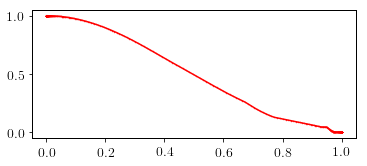

In [128]:
fig=plt.figure(figsize=[12.8,8])

plt.subplot(321)
plt.plot(ps_155[-1]/ps_155[-1][-1],ps_155[2]/ps_155[2][0],color='red',marker='o',markersize='0.4') 
plt.plot(ps_155[-1]/ps_155[-1][-1],ps_155rho(ps_155[-1])/ps_155[2][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1) # leaving the crust out

plt.subplot(322)
plt.plot(ps_155[-1]/ps_155[-1][-1],ps_155[1]/ps_155[1][0],color='red',marker='o',markersize='0.4') 
plt.plot(ps_155[-1]/ps_155[-1][-1],ps_155p(ps_155[-1])/ps_155[1][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$P/P_c$')
plt.xlim(0,1)

plt.subplot(323)
plt.plot(ps_155[-1]/ps_155[-1][-1],ps_155drho(ps_155[-1])/max(abs(ps_155drho(ps_155[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime}$')
plt.xlim(0,1)
#plt.ylim(-500,0)

plt.subplot(324)
plt.plot(ps_155[-1]/ps_155[-1][-1],ps_155dp(ps_155[-1])/max(abs(ps_155dp(ps_155[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime} $')
plt.xlim(0,1)

plt.subplot(325)
plt.plot(ps_155[-1]/ps_155[-1][-1],ps_155ddrho(ps_155[-1])/max(abs(ps_155ddrho(ps_155[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}$')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-0.01,0.01)

plt.subplot(326)
plt.plot(ps_155[-1]/ps_155[-1][-1],ps_155ddp(ps_155[-1])/max(abs(ps_155ddp(ps_155[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime\prime}$ ')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-1,1)

fig.subplots_adjust(hspace=0.3,wspace=0.3)

#plt.savefig('figures/ddsps_155.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

## Redshift

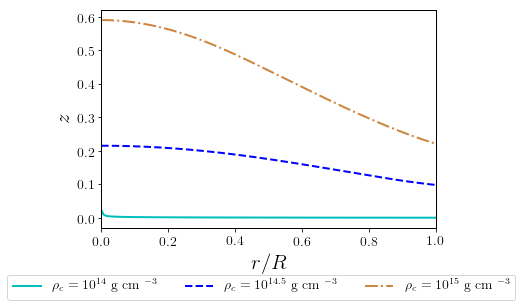

In [129]:
fig = plt.figure()

plt.plot(ps_140[-1]/ps_140[-1][-1],np.exp(-ps_140[3])-1.0,color='c',linewidth='2.0',label=r'$\rho_c=10^{14}$ g cm $^{-3}$')
plt.plot(ps_145[-1]/ps_145[-1][-1],np.exp(-ps_145[3])-1.0,color='blue',linewidth='2.0',linestyle='--',label=r'$\rho_c=10^{14.5}$ g cm $^{-3}$')
plt.plot(ps_150[-1]/ps_150[-1][-1],np.exp(-ps_150[3])-1.0,color='peru',linewidth='2.0',linestyle='-.',label=r'$\rho_c=10^{15}$ g cm $^{-3}$')

l = plt.legend(bbox_to_anchor=(1.1,-0.15), loc="lower right", 
                bbox_transform=fig.transFigure, ncol=3)

plt.xlabel(r'$r/R$')
plt.ylabel(r'$z$')
plt.xlim(0,1.0)

plt.savefig('figures/Redshiftps.pdf', format='pdf', dpi=1000,bbox_inches="tight")

# SLy ------------------------------------------------------------------------------------------

In [65]:
rhosly,Psly,nsly=np.loadtxt('EOS/sly.dat',usecols=(2,1,0),unpack=True)

## Dominant energy condition

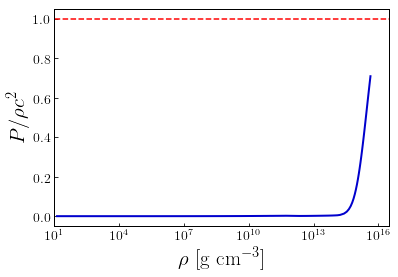

<Figure size 432x288 with 0 Axes>

In [66]:
fig, ax = plt.subplots()
plt.plot(rhosly,np.divide(Psly,rhosly),lw='2',color='mediumblue')
plt.plot([0,10**(17)],[1.0,1.0],'r--',lw='1.5')

ax.set_xscale("log")
#locmaj = matplotlib.ticker.LogLocator(base=10.0,numticks=16) 
#ax.xaxis.set_major_locator(locmaj)


plt.xlabel(r'$\rho$ [g\,\,cm$^{-3}$]')
plt.ylabel(r'$ P / \rho c^2 $')
#locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks=16)
#ax.xaxis.set_minor_locator(locmin)
#ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.tick_params(axis="x", direction="in")
ax.tick_params(axis="y", direction="in")
plt.xlim(10,10**(16.5))
#ax.set_facecolor('floralwhite')
#plt.gca().set_aspect('equal', adjustable='box')
#plt.draw()
#plt.ylim(0,1)
plt.savefig('figures/ECsly.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()
plt.clf()

## Speed of sound

In [74]:
vsquared=interpolate.UnivariateSpline(rhosly, Psly, k=3, s=0).derivative(n=1)

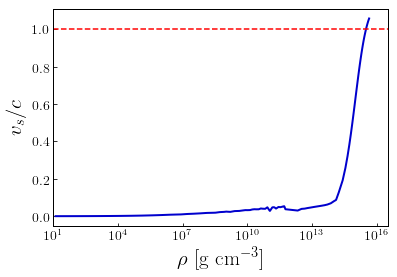

In [75]:
fig, ax = plt.subplots()
plt.plot(rhosly,np.sqrt(vsquared(rhosly)),lw='2.0',color='mediumblue')
plt.plot([1e+1,10**(16.5)],[1.0,1.0],'r--',lw='1.5')
plt.xlabel(r'$\rho$ [g\,\,cm$^{-3}$]')
plt.ylabel(r'$ v_s / c $')
plt.xscale('log')
ax.tick_params(axis="x", direction="in")
ax.tick_params(axis="y", direction="in")
plt.xlim(10,10**(16.5))
#ax.set_facecolor('floralwhite')
#mpl.rcParams['axes.linewidth'] = 1.4
#plt.gca().set_aspect('equal', adjustable='box')
#plt.draw()
plt.savefig('figures/SSsly.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

## Adiabatic Index

In [76]:
Gamma=np.multiply(np.divide(np.add(rhosly,Psly),Psly),vsquared(rhosly))

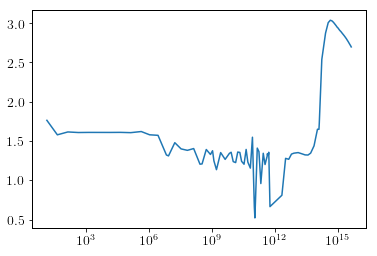

In [77]:
plt.plot(rhosly,Gamma)
plt.xscale('log')

$$ \langle\gamma\rangle=\frac{\int_{0}^{R} e^{(\lambda+3 \nu) } \gamma(r) P(r) r^{2} d r}{\int_{0}^{R} e^{(\lambda+3 \nu) } P(r) r^{2} d r} $$

Listing all the models calculated

In [78]:
owd=os.getcwd()
path=os.chdir('results/sly')
listOfEntries= os.scandir(path)
models_sly = []
for entry in listOfEntries:
    if '1' in entry.name:
        models_sly.append(entry.name)
os.chdir(owd)
models_sly.sort()

In [79]:
gamma_efs = []
gamma_crs = []
rhosc= []
betas=[]
for model in models_sly:
    m, P, rho, nu, lambd, r = np.loadtxt('results/sly/' + model ,unpack=True)
    nu = nu - nu[-1] + 0.5*np.log(1-2*m[-1]/r[-1])
    drho=interpolate.UnivariateSpline(r, rho, k=5, s=0).derivative(n=1)
    dP=interpolate.UnivariateSpline(r, P, k=5, s=0).derivative(n=1)
    gamma = np.divide(dP(r),drho(r))
    gamma_ef = integrate.trapz(np.exp(lambd+3*nu)*gamma*P*(r**2),r)/integrate.trapz(np.exp(lambd+3*nu)*P*(r**2),r)
    t1 = (4/9)*integrate.trapz(np.exp((lambd+3*nu))*(16*P+(np.exp(2*lambd)-1)*(P+rho))*(np.exp(2*lambd)-1)*(r**2),r)/integrate.trapz(np.exp(lambd+3*nu)*P*(r**2),r)
    t2 = (4*np.pi/9)*integrate.trapz(np.exp(3*lambd+3*nu)*(8*P + (np.exp(2*lambd)+1)*(P+rho))*P*(r**4),r)/integrate.trapz(np.exp(lambd+3*nu)*P*(r**2),r)
    t3 = ((16*np.pi**2)/9)*integrate.trapz(np.exp(5*lambd+3*nu)*(P+rho)*(P**2)*(r**6),r)/integrate.trapz(np.exp(lambd+3*nu)*P*(r**2),r)
    gamma_cr = 4/3 + t1 + t2 + t3
    gamma_efs.append(gamma_ef)
    gamma_crs.append(gamma_cr)
    betas.append(m[-1]/r[-1])
    rhosc.append(rho[0]*rhodim)

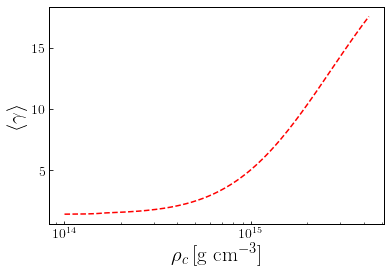

In [80]:
fig, ax = plt.subplots()
plt.plot(rhosc,gamma_crs,lw='1.5',color='r',linestyle='--',label=r'$\gamma_{cr}$')
#plt.plot(rhosc,gamma_efs,lw='2.0',color='blue',label=r'$\langle \gamma \rangle$')

plt.xlabel(r'$\rho_c\,[$g cm$^{-3}]$')
plt.ylabel(r'$\langle \gamma \rangle$')

plt.xscale('log')
#plt.xlim(left=10**(14.7),right=10**(16.7))
#plt.ylim(0,4)
ax.tick_params(axis="x", direction="in",which='both')
ax.tick_params(axis="y", direction="in",which='both')
#l = plt.legend(bbox_to_anchor=(0.85,-0.15), loc="lower right", 
                #bbox_transform=fig.transFigure, ncol=2)



plt.savefig('figures/AdiabaticIndexrhocSLy.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

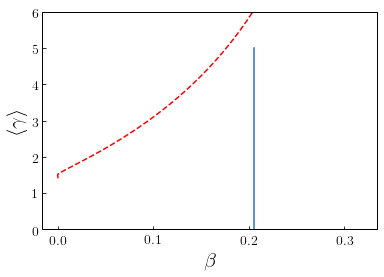

In [86]:
fig, ax = plt.subplots()
plt.plot(betas,gamma_crs,lw='1.5',color='r',linestyle='--',label=r'$\gamma_{cr}$')
plt.plot([betacrit,betacrit],[0,5])
#plt.plot(betas,gamma_efs,lw='2.0',color='blue',label=r'$\langle \gamma \rangle$')

plt.xlabel(r'$\beta$')
plt.ylabel(r'$\langle \gamma \rangle$')

#plt.xscale('log')
#plt.xlim(left=10**(14.7),right=10**(16.7))
plt.ylim(0,6)
ax.tick_params(axis="x", direction="in",which='both')
ax.tick_params(axis="y", direction="in",which='both')
#l = plt.legend(bbox_to_anchor=(0.85,-0.15), loc="lower right", 
                #bbox_transform=fig.transFigure, ncol=2)



plt.savefig('figures/AdiabaticIndexSLybeta.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

## M - $\rho_c$

In [82]:
Rsly,Msly,rhocsly=np.loadtxt('results/sly/MRrhoc.dat',usecols=(0,1,2),unpack=True)

In [83]:
np.amax(Msly)

2.0497931613

In [85]:
betacrit=np.amax(Msly)/Rsly[np.argmax(Msly)]
betacrit

0.20544857504756373

In [84]:
rhocsly[np.argmax(Msly)]

2884031503130000.0

In [252]:
np.log10(rhocsly[np.argmax(Msly)])

15.46000000000051

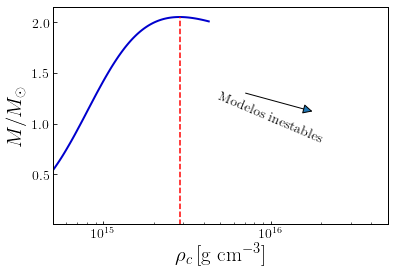

In [253]:
fig, ax = plt.subplots()

plt.plot(rhocsly,Msly,color='mediumblue',lw='2.0')
plt.plot([10**(np.log10(rhocsly[np.argmax(Msly)])),10**(np.log10(rhocsly[np.argmax(Msly)]))],[0.0,np.amax(Msly)],'r--',lw='1.5')

prop = dict(arrowstyle="-|>,head_width=0.4,head_length=0.8",
            shrinkA=0,shrinkB=0)
plt.annotate("", xy=(10**(16.25),1.12), xytext=(10**(15.85),1.3), arrowprops=prop)
#plt.arrow(10**(15.6), 1.38,10**(15.7) ,-0.1 , head_width=0.05, head_lslyth=10**(15))
plt.text(10**(15.67), 1.23, 'Modelos inestables' , fontsize=14,rotation=-23)

plt.xscale('log')
plt.xlabel(r'$\rho_c\,[$g cm$^{-3}]$')
plt.ylabel(r'$M/M_{\odot}$')
plt.xlim(left=10**(14.7),right=10**(16.7))
plt.ylim(bottom=0.01)
ax.tick_params(axis="x", direction="in",which='both')
ax.tick_params(axis="y", direction="in",which='both')

plt.savefig('figures/Mrhorel_sly.pdf', format='pdf', dpi=1000,bbox_inches="tight")

## Tunning the interpolation of the solution

### 14.0

In [254]:
sly_140=np.loadtxt('results/sly/14.0.dat',unpack=True)
sly_140[3] = sly_140[3]-sly_140[3][-1] + 0.5*np.log(1-2*sly_140[0][-1]/sly_140[-1][-1])

In [255]:
s1=5e-7
s2=1e-15
sly_140rho=interpolate.UnivariateSpline(sly_140[-1], sly_140[2], k=5, s=s1)
sly_140drho=interpolate.UnivariateSpline(sly_140[-1], sly_140[2], k=5, s=s1).derivative(n=1)
sly_140ddrho=interpolate.UnivariateSpline(sly_140[-1], sly_140[2], k=5, s=s1).derivative(n=2)

sly_140p=interpolate.UnivariateSpline(sly_140[-1], sly_140[1], k=5, s=s2)
sly_140dp=interpolate.UnivariateSpline(sly_140[-1], sly_140[1], k=5, s=s2).derivative(n=1)
sly_140ddp=interpolate.UnivariateSpline(sly_140[-1], sly_140[1], k=5, s=s2).derivative(n=2)

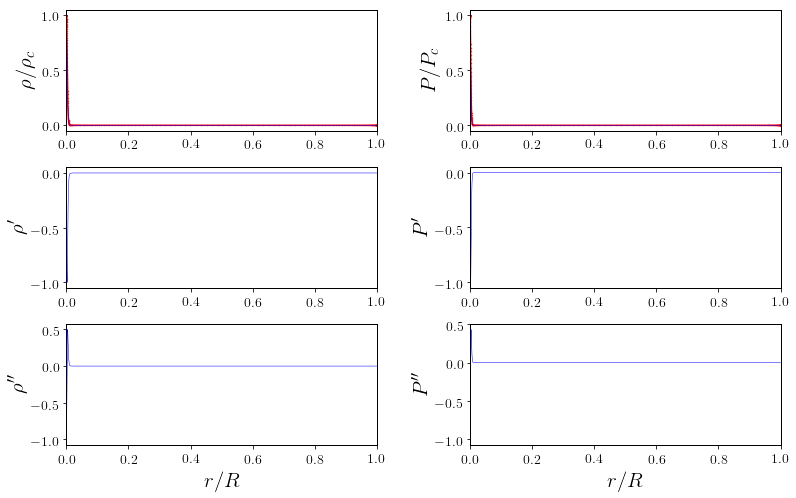

In [256]:
fig=plt.figure(figsize=[12.8,8])

plt.subplot(321)
plt.plot(sly_140[-1]/sly_140[-1][-1],sly_140[2]/sly_140[2][0],color='red',marker='o',markersize='0.4') 
plt.plot(sly_140[-1]/sly_140[-1][-1],sly_140rho(sly_140[-1])/sly_140[2][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1) # leaving the crust out

plt.subplot(322)
plt.plot(sly_140[-1]/sly_140[-1][-1],sly_140[1]/sly_140[1][0],color='red',marker='o',markersize='0.4') 
plt.plot(sly_140[-1]/sly_140[-1][-1],sly_140p(sly_140[-1])/sly_140[1][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$P/P_c$')
plt.xlim(0,1)

plt.subplot(323)
plt.plot(sly_140[-1]/sly_140[-1][-1],sly_140drho(sly_140[-1])/max(abs(sly_140drho(sly_140[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime}$')
plt.xlim(0,1)
#plt.ylim(-500,0)

plt.subplot(324)
plt.plot(sly_140[-1]/sly_140[-1][-1],sly_140dp(sly_140[-1])/max(abs(sly_140dp(sly_140[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime} $')
plt.xlim(0,1)

plt.subplot(325)
plt.plot(sly_140[-1]/sly_140[-1][-1],sly_140ddrho(sly_140[-1])/max(abs(sly_140ddrho(sly_140[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}$')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-0.01,0.01)

plt.subplot(326)
plt.plot(sly_140[-1]/sly_140[-1][-1],sly_140ddp(sly_140[-1])/max(abs(sly_140ddp(sly_140[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime\prime}$ ')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-1,1)

fig.subplots_adjust(hspace=0.3,wspace=0.3)

#plt.savefig('figures/ddssly_140.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

### 14.5

In [257]:
sly_145=np.loadtxt('results/sly/14.5.dat',unpack=True)
sly_145[3] = sly_145[3]-sly_145[3][-1] + 0.5*np.log(1-2*sly_145[0][-1]/sly_145[-1][-1])

In [258]:
s1=1e-7
s2=1e-12
sly_145rho=interpolate.UnivariateSpline(sly_145[-1], sly_145[2], k=5, s=s1)
sly_145drho=interpolate.UnivariateSpline(sly_145[-1], sly_145[2], k=5, s=s1).derivative(n=1)
sly_145ddrho=interpolate.UnivariateSpline(sly_145[-1], sly_145[2], k=5, s=s1).derivative(n=2)

sly_145p=interpolate.UnivariateSpline(sly_145[-1], sly_145[1], k=5, s=s2)
sly_145dp=interpolate.UnivariateSpline(sly_145[-1], sly_145[1], k=5, s=s2).derivative(n=1)
sly_145ddp=interpolate.UnivariateSpline(sly_145[-1], sly_145[1], k=5, s=s2).derivative(n=2)

In [259]:
sly_145rho(0.4*sly_145[-1][-1])*rhodim

191829335601529.97

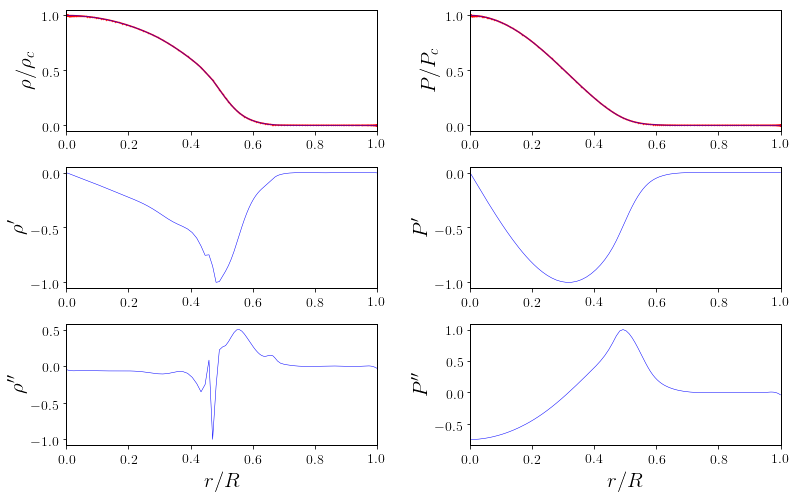

In [260]:
fig=plt.figure(figsize=[12.8,8])

plt.subplot(321)
plt.plot(sly_145[-1]/sly_145[-1][-1],sly_145[2]/sly_145[2][0],color='red',marker='o',markersize='0.4') 
plt.plot(sly_145[-1]/sly_145[-1][-1],sly_145rho(sly_145[-1])/sly_145[2][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1) # leaving the crust out

plt.subplot(322)
plt.plot(sly_145[-1]/sly_145[-1][-1],sly_145[1]/sly_145[1][0],color='red',marker='o',markersize='0.4') 
plt.plot(sly_145[-1]/sly_145[-1][-1],sly_145p(sly_145[-1])/sly_145[1][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$P/P_c$')
plt.xlim(0,1)

plt.subplot(323)
plt.plot(sly_145[-1]/sly_145[-1][-1],sly_145drho(sly_145[-1])/max(abs(sly_145drho(sly_145[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime}$')
plt.xlim(0,1)
#plt.ylim(-500,0)

plt.subplot(324)
plt.plot(sly_145[-1]/sly_145[-1][-1],sly_145dp(sly_145[-1])/max(abs(sly_145dp(sly_145[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime} $')
plt.xlim(0,1)

plt.subplot(325)
plt.plot(sly_145[-1]/sly_145[-1][-1],sly_145ddrho(sly_145[-1])/max(abs(sly_145ddrho(sly_145[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}$')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-0.01,0.01)

plt.subplot(326)
plt.plot(sly_145[-1]/sly_145[-1][-1],sly_145ddp(sly_145[-1])/max(abs(sly_145ddp(sly_145[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime\prime}$ ')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-1,1)

fig.subplots_adjust(hspace=0.3,wspace=0.3)

#plt.savefig('figures/ddssly_145.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

### 15.0

In [261]:
sly_150=np.loadtxt('results/sly/15.0.dat',unpack=True)
sly_150[3] = sly_150[3]-sly_150[3][-1] + 0.5*np.log(1-2*sly_150[0][-1]/sly_150[-1][-1])

In [262]:
s1=8e-6
s2=1e-15
sly_150rho=interpolate.UnivariateSpline(sly_150[-1], sly_150[2], k=5, s=s1)
sly_150drho=interpolate.UnivariateSpline(sly_150[-1], sly_150[2], k=5, s=s1).derivative(n=1)
sly_150ddrho=interpolate.UnivariateSpline(sly_150[-1], sly_150[2], k=5, s=s1).derivative(n=2)

sly_150p=interpolate.UnivariateSpline(sly_150[-1], sly_150[1], k=5, s=s2)
sly_150dp=interpolate.UnivariateSpline(sly_150[-1], sly_150[1], k=5, s=s2).derivative(n=1)
sly_150ddp=interpolate.UnivariateSpline(sly_150[-1], sly_150[1], k=5, s=s2).derivative(n=2)

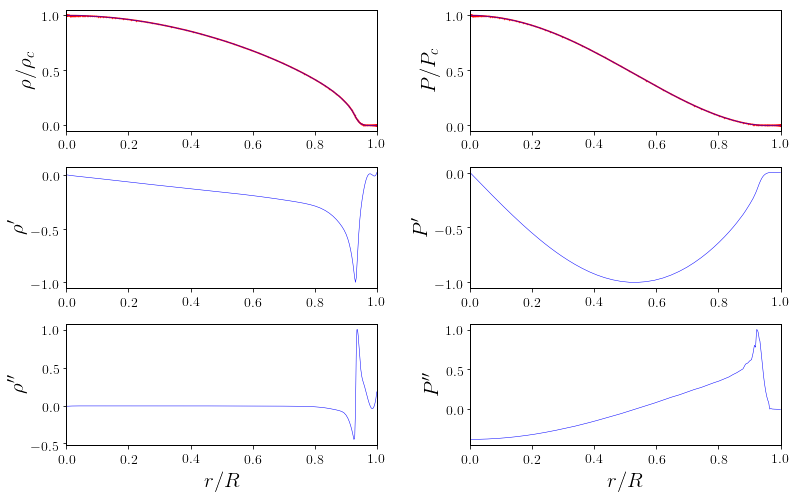

In [263]:
fig=plt.figure(figsize=[12.8,8])

plt.subplot(321)
plt.plot(sly_150[-1]/sly_150[-1][-1],sly_150[2]/sly_150[2][0],color='red',marker='o',markersize='0.4') 
plt.plot(sly_150[-1]/sly_150[-1][-1],sly_150rho(sly_150[-1])/sly_150[2][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1) # leaving the crust out

plt.subplot(322)
plt.plot(sly_150[-1]/sly_150[-1][-1],sly_150[1]/sly_150[1][0],color='red',marker='o',markersize='0.4') 
plt.plot(sly_150[-1]/sly_150[-1][-1],sly_150p(sly_150[-1])/sly_150[1][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$P/P_c$')
plt.xlim(0,1)

plt.subplot(323)
plt.plot(sly_150[-1]/sly_150[-1][-1],sly_150drho(sly_150[-1])/max(abs(sly_150drho(sly_150[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime}$')
plt.xlim(0,1)
#plt.ylim(-500,0)

plt.subplot(324)
plt.plot(sly_150[-1]/sly_150[-1][-1],sly_150dp(sly_150[-1])/max(abs(sly_150dp(sly_150[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime} $')
plt.xlim(0,1)

plt.subplot(325)
plt.plot(sly_150[-1]/sly_150[-1][-1],sly_150ddrho(sly_150[-1])/max(abs(sly_150ddrho(sly_150[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}$')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-0.01,0.01)

plt.subplot(326)
plt.plot(sly_150[-1]/sly_150[-1][-1],sly_150ddp(sly_150[-1])/max(abs(sly_150ddp(sly_150[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime\prime}$ ')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-1,1)

fig.subplots_adjust(hspace=0.3,wspace=0.3)

#plt.savefig('figures/ddssly_150.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

### 15.5

In [264]:
sly_155=np.loadtxt('results/sly/15.5.dat',unpack=True)
sly_155[3] = sly_155[3]-sly_155[3][-1] + 0.5*np.log(1-2*sly_155[0][-1]/sly_155[-1][-1])

In [265]:
s1=1e-5
s2=1e-9
sly_155rho=interpolate.UnivariateSpline(sly_155[-1], sly_155[2], k=5, s=s1)
sly_155drho=interpolate.UnivariateSpline(sly_155[-1], sly_155[2], k=5, s=s1).derivative(n=1)
sly_155ddrho=interpolate.UnivariateSpline(sly_155[-1], sly_155[2], k=5, s=s1).derivative(n=2)

sly_155p=interpolate.UnivariateSpline(sly_155[-1], sly_155[1], k=5, s=s2)
sly_155dp=interpolate.UnivariateSpline(sly_155[-1], sly_155[1], k=5, s=s2).derivative(n=1)
sly_155ddp=interpolate.UnivariateSpline(sly_155[-1], sly_155[1], k=5, s=s2).derivative(n=2)

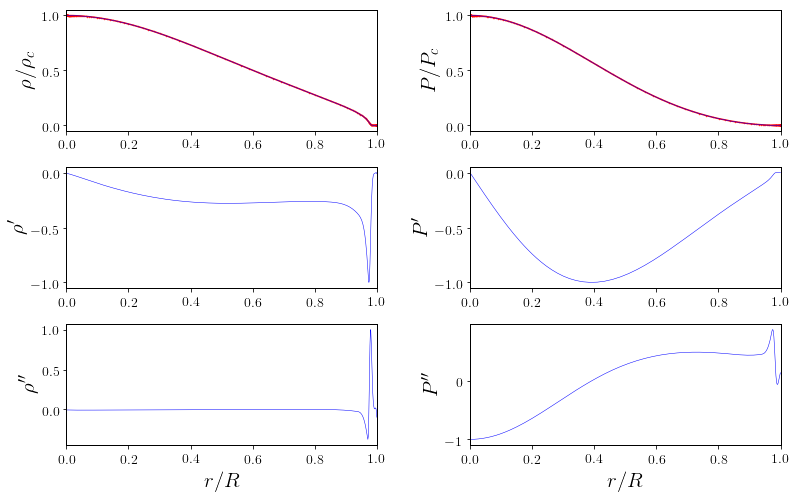

In [266]:
fig=plt.figure(figsize=[12.8,8])

plt.subplot(321)
plt.plot(sly_155[-1]/sly_155[-1][-1],sly_155[2]/sly_155[2][0],color='red',marker='o',markersize='0.4') 
plt.plot(sly_155[-1]/sly_155[-1][-1],sly_155rho(sly_155[-1])/sly_155[2][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1) # leaving the crust out

plt.subplot(322)
plt.plot(sly_155[-1]/sly_155[-1][-1],sly_155[1]/sly_155[1][0],color='red',marker='o',markersize='0.4') 
plt.plot(sly_155[-1]/sly_155[-1][-1],sly_155p(sly_155[-1])/sly_155[1][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$P/P_c$')
plt.xlim(0,1)

plt.subplot(323)
plt.plot(sly_155[-1]/sly_155[-1][-1],sly_155drho(sly_155[-1])/max(abs(sly_155drho(sly_155[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime}$')
plt.xlim(0,1)
#plt.ylim(-500,0)

plt.subplot(324)
plt.plot(sly_155[-1]/sly_155[-1][-1],sly_155dp(sly_155[-1])/max(abs(sly_155dp(sly_155[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime} $')
plt.xlim(0,1)

plt.subplot(325)
plt.plot(sly_155[-1]/sly_155[-1][-1],sly_155ddrho(sly_155[-1])/max(abs(sly_155ddrho(sly_155[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}$')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-0.01,0.01)

plt.subplot(326)
plt.plot(sly_155[-1]/sly_155[-1][-1],sly_155ddp(sly_155[-1])/max(abs(sly_155ddp(sly_155[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime\prime}$ ')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-1,1)

fig.subplots_adjust(hspace=0.3,wspace=0.3)

#plt.savefig('figures/ddssly_155.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

## Redshift

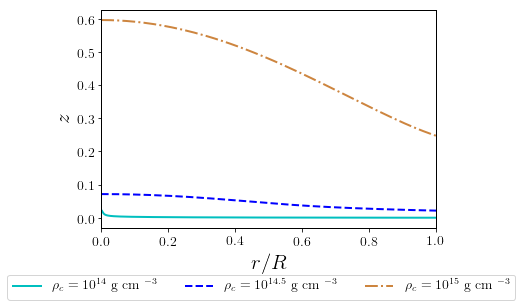

In [267]:
fig = plt.figure()

plt.plot(sly_140[-1]/sly_140[-1][-1],np.exp(-sly_140[3])-1.0,color='c',linewidth='2.0',label=r'$\rho_c=10^{14}$ g cm $^{-3}$')
plt.plot(sly_145[-1]/sly_145[-1][-1],np.exp(-sly_145[3])-1.0,color='blue',linewidth='2.0',linestyle='--',label=r'$\rho_c=10^{14.5}$ g cm $^{-3}$')
plt.plot(sly_150[-1]/sly_150[-1][-1],np.exp(-sly_150[3])-1.0,color='peru',linewidth='2.0',linestyle='-.',label=r'$\rho_c=10^{15}$ g cm $^{-3}$')

l = plt.legend(bbox_to_anchor=(1.1,-0.15), loc="lower right", 
                bbox_transform=fig.transFigure, ncol=3)

plt.xlabel(r'$r/R$')
plt.ylabel(r'$z$')
plt.xlim(0,1.0)

plt.savefig('figures/Redshiftsly.pdf', format='pdf', dpi=1000,bbox_inches="tight")

# SQM1 --------------------------------------------------------------------------------------

In [130]:
rhosqm1,Psqm1,nsqm1=np.loadtxt('EOS/sqm1.dat',usecols=(2,1,0),unpack=True)

## Dominant energy condition

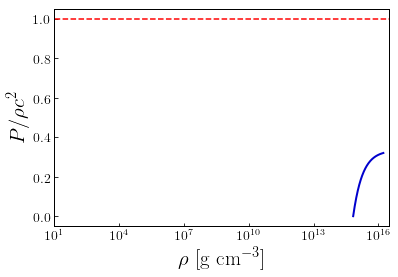

<Figure size 432x288 with 0 Axes>

In [131]:
fig, ax = plt.subplots()
plt.plot(rhosqm1,np.divide(Psqm1,rhosqm1),lw='2',color='mediumblue')
plt.plot([0,10**(17)],[1.0,1.0],'r--',lw='1.5')

ax.set_xscale("log")
#locmaj = matplotlib.ticker.LogLocator(base=10.0,numticks=16) 
#ax.xaxis.set_major_locator(locmaj)


plt.xlabel(r'$\rho$ [g\,\,cm$^{-3}$]')
plt.ylabel(r'$ P / \rho c^2 $')
#locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks=16)
#ax.xaxis.set_minor_locator(locmin)
#ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.tick_params(axis="x", direction="in")
ax.tick_params(axis="y", direction="in")
plt.xlim(10,10**(16.5))
#ax.set_facecolor('floralwhite')
#plt.gca().set_aspect('equal', adjustable='box')
#plt.draw()
#plt.ylim(0,1)
plt.savefig('figures/ECsqm1.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()
plt.clf()

## Speed of sound

In [132]:
vsquared=interpolate.UnivariateSpline(rhosqm1, Psqm1, k=1, s=0).derivative(n=1)

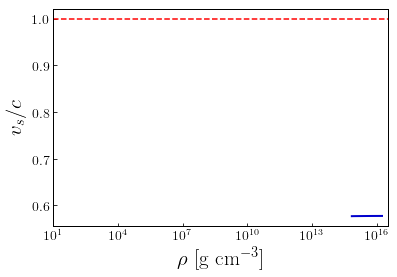

In [133]:
fig, ax = plt.subplots()
plt.plot(rhosqm1,np.sqrt(vsquared(rhosqm1)),lw='2.0',color='mediumblue')
plt.plot([1e+1,10**(16.5)],[1.0,1.0],'r--',lw='1.5')
plt.xlabel(r'$\rho$ [g\,\,cm$^{-3}$]')
plt.ylabel(r'$ v_s / c $')
plt.xscale('log')
ax.tick_params(axis="x", direction="in")
ax.tick_params(axis="y", direction="in")
plt.xlim(10,10**(16.5))
#ax.set_facecolor('floralwhite')
#mpl.rcParams['axes.linewidth'] = 1.4
#plt.gca().set_aspect('equal', adjustable='box')
#plt.draw()
plt.savefig('figures/SSsqm1.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

## Adiabatic Index

In [134]:
Gamma=np.multiply(np.divide(np.add(rhosqm1,Psqm1),Psqm1),vsquared(rhosqm1))

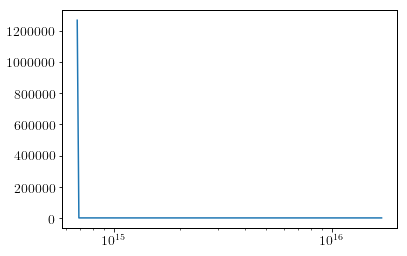

In [135]:
plt.plot(rhosqm1,Gamma)
plt.xscale('log')

$$ \langle\gamma\rangle=\frac{\int_{0}^{R} e^{(\lambda+3 \nu) } \gamma(r) P(r) r^{2} d r}{\int_{0}^{R} e^{(\lambda+3 \nu) } P(r) r^{2} d r} $$

Listing all the models calculated

In [136]:
owd=os.getcwd()
path=os.chdir('results/sqm1')
listOfEntries= os.scandir(path)
models_sqm1 = []
for entry in listOfEntries:
    if '1' in entry.name:
        models_sqm1.append(entry.name)
os.chdir(owd)
models_sqm1.sort()

In [137]:
gamma_efs1 = []
gamma_efs2 = []
gamma_crs1 = []
gamma_crs2 = []
rhosc= []
for model in models_sqm1:
    m, P, rho, nu, lambd, r = np.loadtxt('results/sqm1/' + model ,unpack=True)
    nu = nu - nu[-1] + 0.5*np.log(1-2*m[-1]/r[-1])
    #lambd = np.zeros_like(r)
    #for i in range((r.shape)[0]):
    #    if i==0:
    #        lambd[i] = 0
    #    else:
    #        lambd[i] = 0.5*np.log(1/(1-2*m[i]/r[i]))
    drho=interpolate.UnivariateSpline(r, rho, k=5, s=0).derivative(n=1)
    dP=interpolate.UnivariateSpline(r, P, k=5, s=0).derivative(n=1)
    gamma = np.divide(dP(r),drho(r))
    gamma_ef1 = integrate.trapz(np.exp(lambd+3*nu)*gamma*P*(r**2),r)/integrate.trapz(np.exp(lambd+3*nu)*P*(r**2),r)
    t1 = (1/36)*integrate.trapz(np.exp((lambd+3*nu))*(16*P+(np.exp(2*lambd)-1)*(P+rho))*(np.exp(2*lambd)-1)*(r**2))/integrate.trapz(np.exp(lambd+3*nu)*P*(r**2),r)
    t2 = (4*np.pi/9)*integrate.trapz(np.exp(3*lambd+3*nu)*(8*P + (np.exp(2*lambd)+1)*(P+rho))*P*(r**4),r)/integrate.trapz(np.exp(lambd+3*nu)*P*(r**2),r)
    t3 = ((16*np.pi**2)/9)*integrate.trapz(np.exp(5*lambd+3*nu)*(P+rho)*(P**2)*(r**6),r)/integrate.trapz(np.exp(lambd+3*nu)*P*(r**2),r)
    gamma_cr1 = 4/3 + t1 + t2 + t3
    gamma_efs1.append(gamma_ef1)
    gamma_crs1.append(gamma_cr1)
    gamma_ef2 = integrate.trapz(gamma*P*r**2,r)/integrate.trapz(P*r**2,r)
    gamma_cr2 = 4/3 + (19/42)*2*m[-1]/r[-1]
    gamma_efs2.append(gamma_ef2)
    gamma_crs2.append(gamma_cr2)
    rhosc.append(rho[0]*rhodim)

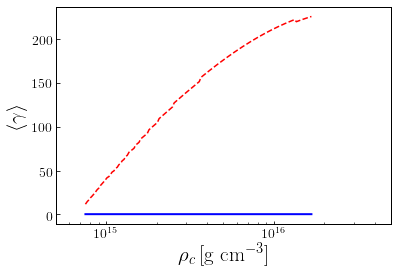

In [138]:
fig, ax = plt.subplots()
plt.plot(rhosc,gamma_crs1,lw='1.5',color='r',linestyle='--',label=r'$\gamma_{cr}$')
plt.plot(rhosc,gamma_efs1,lw='2.0',color='blue',label=r'$\langle \gamma \rangle$')

plt.xlabel(r'$\rho_c\,[$g cm$^{-3}]$')
plt.ylabel(r'$\langle \gamma \rangle$')

plt.xscale('log')
plt.xlim(left=10**(14.7),right=10**(16.7))
#plt.ylim(0,10)
ax.tick_params(axis="x", direction="in",which='both')
ax.tick_params(axis="y", direction="in",which='both')
#l = plt.legend(bbox_to_anchor=(0.85,-0.15), loc="lower right", 
                #bbox_transform=fig.transFigure, ncol=2)



plt.savefig('figures/AdiabaticIndexsqm1.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

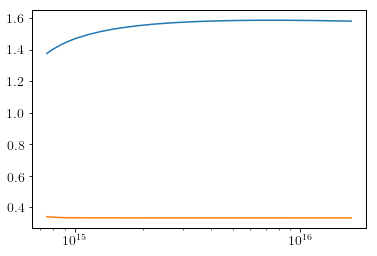

In [139]:
plt.plot(rhosc,gamma_crs2)
plt.plot(rhosc,gamma_efs2)
plt.xscale('log')

## M - $\rho_c$

In [140]:
Rsqm1,Msqm1,rhocsqm1=np.loadtxt('results/sqm1/MRrhoc.dat',usecols=(0,1,2),unpack=True)

In [141]:
np.amax(Msqm1)

1.53237877481

In [142]:
rhocsqm1[np.argmax(Msqm1)]

3674327590980000.0

In [143]:
np.log10(rhocsqm1[np.argmax(Msqm1)])

15.565177873965581

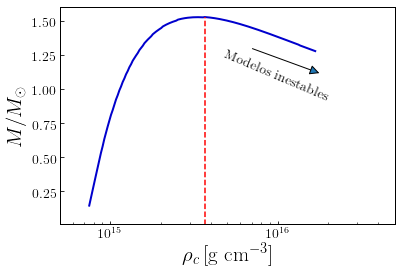

In [144]:
fig, ax = plt.subplots()

plt.plot(rhocsqm1,Msqm1,color='mediumblue',lw='2.0')
plt.plot([10**(np.log10(rhocsqm1[np.argmax(Msqm1)])),10**(np.log10(rhocsqm1[np.argmax(Msqm1)]))],[0.0,np.amax(Msqm1)],'r--',lw='1.5')

prop = dict(arrowstyle="-|>,head_width=0.4,head_length=0.8",
            shrinkA=0,shrinkB=0)
plt.annotate("", xy=(10**(16.25),1.12), xytext=(10**(15.85),1.3), arrowprops=prop)
#plt.arrow(10**(15.6), 1.38,10**(15.7) ,-0.1 , head_width=0.05, head_lsqm1th=10**(15))
plt.text(10**(15.67), 1.23, 'Modelos inestables' , fontsize=14,rotation=-23)

plt.xscale('log')
plt.xlabel(r'$\rho_c\,[$g cm$^{-3}]$')
plt.ylabel(r'$M/M_{\odot}$')
plt.xlim(left=10**(14.7),right=10**(16.7))
plt.ylim(bottom=0.01)
ax.tick_params(axis="x", direction="in",which='both')
ax.tick_params(axis="y", direction="in",which='both')

plt.savefig('figures/Mrhorel_sqm1.pdf', format='pdf', dpi=1000,bbox_inches="tight")

## Tunning the interpolation of the solution

### 14.87

In [146]:
sqm1_1487=np.loadtxt('results/sqm1/14.875177874.dat',unpack=True)
sqm1_1487[3] = sqm1_1487[3]-sqm1_1487[3][-1] + 0.5*np.log(1-2*sqm1_1487[0][-1]/sqm1_1487[-1][-1])

In [147]:
s1=5e-7
s2=1e-15
sqm1_1487rho=interpolate.UnivariateSpline(sqm1_1487[-1], sqm1_1487[2], k=5, s=s1)
sqm1_1487drho=interpolate.UnivariateSpline(sqm1_1487[-1], sqm1_1487[2], k=5, s=s1).derivative(n=1)
sqm1_1487ddrho=interpolate.UnivariateSpline(sqm1_1487[-1], sqm1_1487[2], k=5, s=s1).derivative(n=2)

sqm1_1487p=interpolate.UnivariateSpline(sqm1_1487[-1], sqm1_1487[1], k=5, s=s2)
sqm1_1487dp=interpolate.UnivariateSpline(sqm1_1487[-1], sqm1_1487[1], k=5, s=s2).derivative(n=1)
sqm1_1487ddp=interpolate.UnivariateSpline(sqm1_1487[-1], sqm1_1487[1], k=5, s=s2).derivative(n=2)

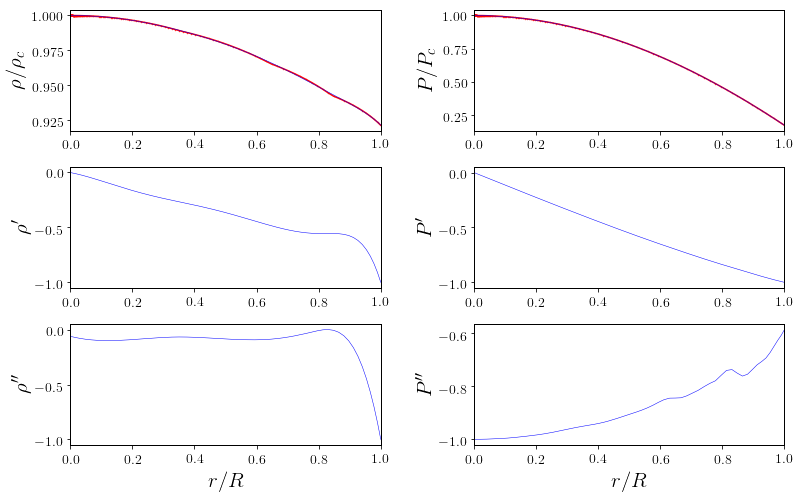

In [148]:
fig=plt.figure(figsize=[12.8,8])

plt.subplot(321)
plt.plot(sqm1_1487[-1]/sqm1_1487[-1][-1],sqm1_1487[2]/sqm1_1487[2][0],color='red',marker='o',markersize='0.4') 
plt.plot(sqm1_1487[-1]/sqm1_1487[-1][-1],sqm1_1487rho(sqm1_1487[-1])/sqm1_1487[2][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1) # leaving the crust out

plt.subplot(322)
plt.plot(sqm1_1487[-1]/sqm1_1487[-1][-1],sqm1_1487[1]/sqm1_1487[1][0],color='red',marker='o',markersize='0.4') 
plt.plot(sqm1_1487[-1]/sqm1_1487[-1][-1],sqm1_1487p(sqm1_1487[-1])/sqm1_1487[1][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$P/P_c$')
plt.xlim(0,1)

plt.subplot(323)
plt.plot(sqm1_1487[-1]/sqm1_1487[-1][-1],sqm1_1487drho(sqm1_1487[-1])/max(abs(sqm1_1487drho(sqm1_1487[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime}$')
plt.xlim(0,1)
#plt.ylim(-500,0)

plt.subplot(324)
plt.plot(sqm1_1487[-1]/sqm1_1487[-1][-1],sqm1_1487dp(sqm1_1487[-1])/max(abs(sqm1_1487dp(sqm1_1487[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime} $')
plt.xlim(0,1)

plt.subplot(325)
plt.plot(sqm1_1487[-1]/sqm1_1487[-1][-1],sqm1_1487ddrho(sqm1_1487[-1])/max(abs(sqm1_1487ddrho(sqm1_1487[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}$')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-0.01,0.01)

plt.subplot(326)
plt.plot(sqm1_1487[-1]/sqm1_1487[-1][-1],sqm1_1487ddp(sqm1_1487[-1])/max(abs(sqm1_1487ddp(sqm1_1487[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime\prime}$ ')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-1,1)

fig.subplots_adjust(hspace=0.3,wspace=0.3)

#plt.savefig('figures/ddssqm1_1487.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

### 15

In [149]:
sqm1_150=np.loadtxt('results/sqm1/15.005177874.dat',unpack=True)
sqm1_150[3] = sqm1_150[3]-sqm1_150[3][-1] + 0.5*np.log(1-2*sqm1_150[0][-1]/sqm1_150[-1][-1])

In [155]:
s1=1e-5
s2=1e-12
sqm1_150rho=interpolate.UnivariateSpline(sqm1_150[-1], sqm1_150[2], k=5, s=s1)
sqm1_150drho=interpolate.UnivariateSpline(sqm1_150[-1], sqm1_150[2], k=5, s=s1).derivative(n=1)
sqm1_150ddrho=interpolate.UnivariateSpline(sqm1_150[-1], sqm1_150[2], k=5, s=s1).derivative(n=2)

sqm1_150p=interpolate.UnivariateSpline(sqm1_150[-1], sqm1_150[1], k=5, s=s2)
sqm1_150dp=interpolate.UnivariateSpline(sqm1_150[-1], sqm1_150[1], k=5, s=s2).derivative(n=1)
sqm1_150ddp=interpolate.UnivariateSpline(sqm1_150[-1], sqm1_150[1], k=5, s=s2).derivative(n=2)

In [151]:
sqm1_150rho(0.4*sqm1_150[-1][-1])*rhodim

946204639741529.6

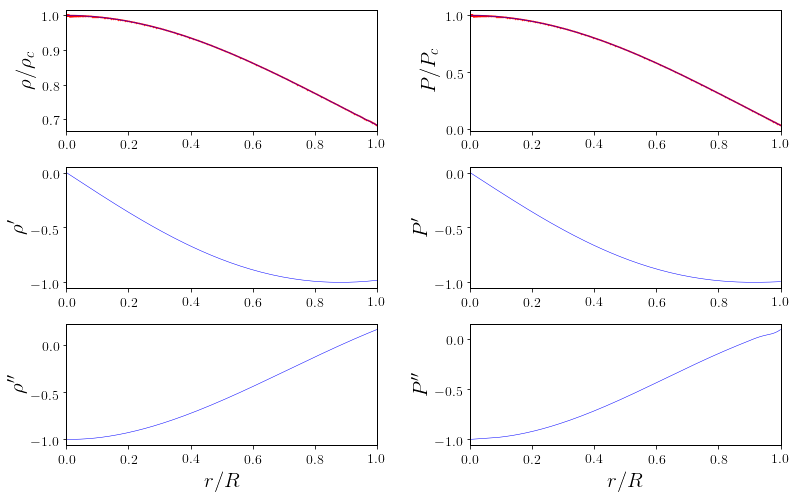

In [156]:
fig=plt.figure(figsize=[12.8,8])

plt.subplot(321)
plt.plot(sqm1_150[-1]/sqm1_150[-1][-1],sqm1_150[2]/sqm1_150[2][0],color='red',marker='o',markersize='0.4') 
plt.plot(sqm1_150[-1]/sqm1_150[-1][-1],sqm1_150rho(sqm1_150[-1])/sqm1_150[2][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1) # leaving the crust out

plt.subplot(322)
plt.plot(sqm1_150[-1]/sqm1_150[-1][-1],sqm1_150[1]/sqm1_150[1][0],color='red',marker='o',markersize='0.4') 
plt.plot(sqm1_150[-1]/sqm1_150[-1][-1],sqm1_150p(sqm1_150[-1])/sqm1_150[1][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$P/P_c$')
plt.xlim(0,1)

plt.subplot(323)
plt.plot(sqm1_150[-1]/sqm1_150[-1][-1],sqm1_150drho(sqm1_150[-1])/max(abs(sqm1_150drho(sqm1_150[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime}$')
plt.xlim(0,1)
#plt.ylim(-500,0)

plt.subplot(324)
plt.plot(sqm1_150[-1]/sqm1_150[-1][-1],sqm1_150dp(sqm1_150[-1])/max(abs(sqm1_150dp(sqm1_150[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime} $')
plt.xlim(0,1)

plt.subplot(325)
plt.plot(sqm1_150[-1]/sqm1_150[-1][-1],sqm1_150ddrho(sqm1_150[-1])/max(abs(sqm1_150ddrho(sqm1_150[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}$')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-0.01,0.01)

plt.subplot(326)
plt.plot(sqm1_150[-1]/sqm1_150[-1][-1],sqm1_150ddp(sqm1_150[-1])/max(abs(sqm1_150ddp(sqm1_150[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime\prime}$ ')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-1,1)

fig.subplots_adjust(hspace=0.3,wspace=0.3)

#plt.savefig('figures/ddssqm1_150.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

### 15.5

In [157]:
sqm1_155=np.loadtxt('results/sqm1/15.505177874.dat',unpack=True)
sqm1_155[3] = sqm1_155[3]-sqm1_155[3][-1] + 0.5*np.log(1-2*sqm1_155[0][-1]/sqm1_155[-1][-1])

In [164]:
s1=1e-5
s2=1e-9
sqm1_155rho=interpolate.UnivariateSpline(sqm1_155[-1], sqm1_155[2], k=5, s=s1)
sqm1_155drho=interpolate.UnivariateSpline(sqm1_155[-1], sqm1_155[2], k=5, s=s1).derivative(n=1)
sqm1_155ddrho=interpolate.UnivariateSpline(sqm1_155[-1], sqm1_155[2], k=5, s=s1).derivative(n=2)

sqm1_155p=interpolate.UnivariateSpline(sqm1_155[-1], sqm1_155[1], k=5, s=s2)
sqm1_155dp=interpolate.UnivariateSpline(sqm1_155[-1], sqm1_155[1], k=5, s=s2).derivative(n=1)
sqm1_155ddp=interpolate.UnivariateSpline(sqm1_155[-1], sqm1_155[1], k=5, s=s2).derivative(n=2)

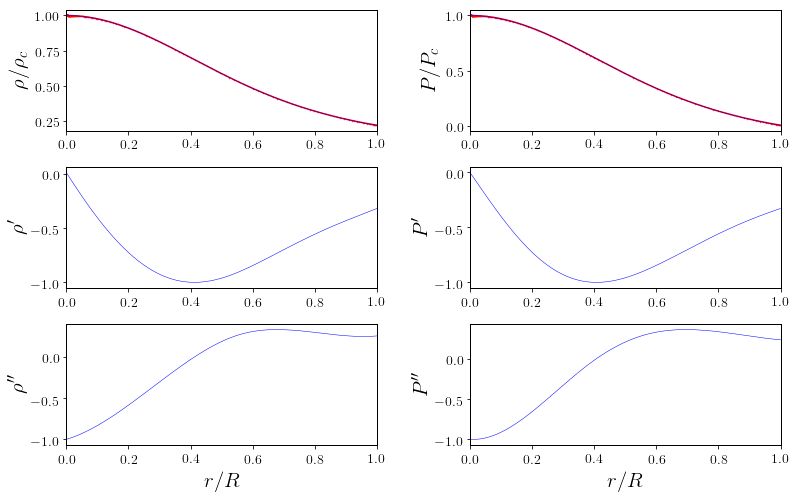

In [165]:
fig=plt.figure(figsize=[12.8,8])

plt.subplot(321)
plt.plot(sqm1_155[-1]/sqm1_155[-1][-1],sqm1_155[2]/sqm1_155[2][0],color='red',marker='o',markersize='0.4') 
plt.plot(sqm1_155[-1]/sqm1_155[-1][-1],sqm1_155rho(sqm1_155[-1])/sqm1_155[2][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1) # leaving the crust out

plt.subplot(322)
plt.plot(sqm1_155[-1]/sqm1_155[-1][-1],sqm1_155[1]/sqm1_155[1][0],color='red',marker='o',markersize='0.4') 
plt.plot(sqm1_155[-1]/sqm1_155[-1][-1],sqm1_155p(sqm1_155[-1])/sqm1_155[1][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$P/P_c$')
plt.xlim(0,1)

plt.subplot(323)
plt.plot(sqm1_155[-1]/sqm1_155[-1][-1],sqm1_155drho(sqm1_155[-1])/max(abs(sqm1_155drho(sqm1_155[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime}$')
plt.xlim(0,1)
#plt.ylim(-500,0)

plt.subplot(324)
plt.plot(sqm1_155[-1]/sqm1_155[-1][-1],sqm1_155dp(sqm1_155[-1])/max(abs(sqm1_155dp(sqm1_155[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime} $')
plt.xlim(0,1)

plt.subplot(325)
plt.plot(sqm1_155[-1]/sqm1_155[-1][-1],sqm1_155ddrho(sqm1_155[-1])/max(abs(sqm1_155ddrho(sqm1_155[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}$')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-0.01,0.01)

plt.subplot(326)
plt.plot(sqm1_155[-1]/sqm1_155[-1][-1],sqm1_155ddp(sqm1_155[-1])/max(abs(sqm1_155ddp(sqm1_155[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime\prime}$ ')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-1,1)

fig.subplots_adjust(hspace=0.3,wspace=0.3)

#plt.savefig('figures/ddssqm1_155.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

## Redshift

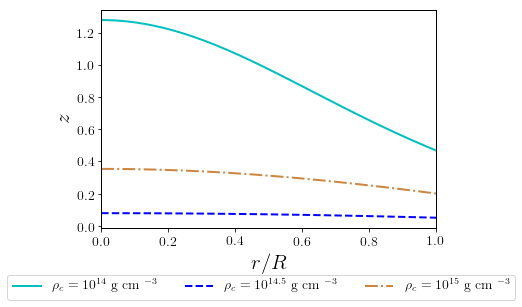

In [167]:
fig = plt.figure()

plt.plot(sqm1_155[-1]/sqm1_155[-1][-1],np.exp(-sqm1_155[3])-1.0,color='c',linewidth='2.0',label=r'$\rho_c=10^{14}$ g cm $^{-3}$')
plt.plot(sqm1_1487[-1]/sqm1_1487[-1][-1],np.exp(-sqm1_1487[3])-1.0,color='blue',linewidth='2.0',linestyle='--',label=r'$\rho_c=10^{14.5}$ g cm $^{-3}$')
plt.plot(sqm1_150[-1]/sqm1_150[-1][-1],np.exp(-sqm1_150[3])-1.0,color='peru',linewidth='2.0',linestyle='-.',label=r'$\rho_c=10^{15}$ g cm $^{-3}$')

l = plt.legend(bbox_to_anchor=(1.1,-0.15), loc="lower right", 
                bbox_transform=fig.transFigure, ncol=3)

plt.xlabel(r'$r/R$')
plt.ylabel(r'$z$')
plt.xlim(0,1.0)

plt.savefig('figures/Redshiftsqm1.pdf', format='pdf', dpi=1000,bbox_inches="tight")

# SQM2 --------------------------------------------------------------------------------------

In [168]:
rhosqm2,Psqm2,nsqm2=np.loadtxt('EOS/sqm2.dat',usecols=(2,1,0),unpack=True)

## Dominant energy condition

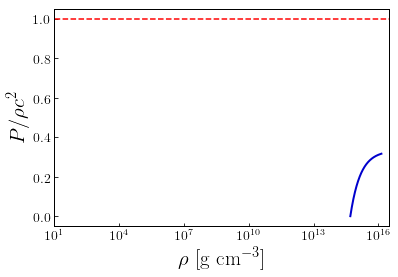

<Figure size 432x288 with 0 Axes>

In [169]:
fig, ax = plt.subplots()
plt.plot(rhosqm2,np.divide(Psqm2,rhosqm2),lw='2',color='mediumblue')
plt.plot([0,10**(17)],[1.0,1.0],'r--',lw='1.5')

ax.set_xscale("log")
#locmaj = matplotlib.ticker.LogLocator(base=10.0,numticks=16) 
#ax.xaxis.set_major_locator(locmaj)


plt.xlabel(r'$\rho$ [g\,\,cm$^{-3}$]')
plt.ylabel(r'$ P / \rho c^2 $')
#locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks=16)
#ax.xaxis.set_minor_locator(locmin)
#ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.tick_params(axis="x", direction="in")
ax.tick_params(axis="y", direction="in")
plt.xlim(10,10**(16.5))
#ax.set_facecolor('floralwhite')
#plt.gca().set_aspect('equal', adjustable='box')
#plt.draw()
#plt.ylim(0,1)
plt.savefig('figures/ECsqm2.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()
plt.clf()

## Speed of sound

In [170]:
vsquared=interpolate.UnivariateSpline(rhosqm2, Psqm2, k=1, s=0).derivative(n=1)

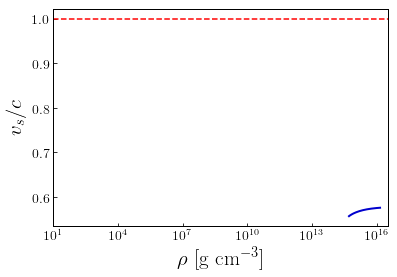

In [171]:
fig, ax = plt.subplots()
plt.plot(rhosqm2,np.sqrt(vsquared(rhosqm2)),lw='2.0',color='mediumblue')
plt.plot([1e+1,10**(16.5)],[1.0,1.0],'r--',lw='1.5')
plt.xlabel(r'$\rho$ [g\,\,cm$^{-3}$]')
plt.ylabel(r'$ v_s / c $')
plt.xscale('log')
ax.tick_params(axis="x", direction="in")
ax.tick_params(axis="y", direction="in")
plt.xlim(10,10**(16.5))
#ax.set_facecolor('floralwhite')
#mpl.rcParams['axes.linewidth'] = 1.4
#plt.gca().set_aspect('equal', adjustable='box')
#plt.draw()
plt.savefig('figures/SSsqm2.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

## Adiabatic Index

In [172]:
Gamma=np.multiply(np.divide(np.add(rhosqm2,Psqm2),Psqm2),vsquared(rhosqm2))

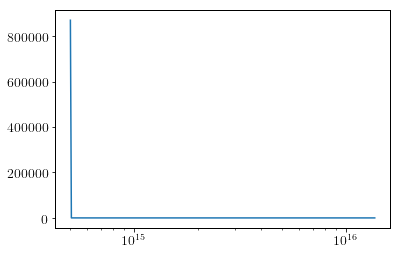

In [173]:
plt.plot(rhosqm2,Gamma)
plt.xscale('log')

$$ \langle\gamma\rangle=\frac{\int_{0}^{R} e^{(\lambda+3 \nu) } \gamma(r) P(r) r^{2} d r}{\int_{0}^{R} e^{(\lambda+3 \nu) } P(r) r^{2} d r} $$

Listing all the models calculated

In [174]:
owd=os.getcwd()
path=os.chdir('results/sqm2')
listOfEntries= os.scandir(path)
models_sqm2 = []
for entry in listOfEntries:
    if '1' in entry.name:
        models_sqm2.append(entry.name)
os.chdir(owd)
models_sqm2.sort()

In [175]:
gamma_efs1 = []
gamma_efs2 = []
gamma_crs1 = []
gamma_crs2 = []
rhosc= []
for model in models_sqm2:
    m, P, rho, nu, lambd, r = np.loadtxt('results/sqm2/' + model ,unpack=True)
    nu = nu - nu[-1] + 0.5*np.log(1-2*m[-1]/r[-1])
    #lambd = np.zeros_like(r)
    #for i in range((r.shape)[0]):
    #    if i==0:
    #        lambd[i] = 0
    #    else:
    #        lambd[i] = 0.5*np.log(1/(1-2*m[i]/r[i]))
    drho=interpolate.UnivariateSpline(r, rho, k=5, s=0).derivative(n=1)
    dP=interpolate.UnivariateSpline(r, P, k=5, s=0).derivative(n=1)
    gamma = np.divide(dP(r),drho(r))
    gamma_ef1 = integrate.trapz(np.exp(lambd+3*nu)*gamma*P*(r**2),r)/integrate.trapz(np.exp(lambd+3*nu)*P*(r**2),r)
    t1 = (1/36)*integrate.trapz(np.exp((lambd+3*nu))*(16*P+(np.exp(2*lambd)-1)*(P+rho))*(np.exp(2*lambd)-1)*(r**2))/integrate.trapz(np.exp(lambd+3*nu)*P*(r**2),r)
    t2 = (4*np.pi/9)*integrate.trapz(np.exp(3*lambd+3*nu)*(8*P + (np.exp(2*lambd)+1)*(P+rho))*P*(r**4),r)/integrate.trapz(np.exp(lambd+3*nu)*P*(r**2),r)
    t3 = ((16*np.pi**2)/9)*integrate.trapz(np.exp(5*lambd+3*nu)*(P+rho)*(P**2)*(r**6),r)/integrate.trapz(np.exp(lambd+3*nu)*P*(r**2),r)
    gamma_cr1 = 4/3 + t1 + t2 + t3
    gamma_efs1.append(gamma_ef1)
    gamma_crs1.append(gamma_cr1)
    gamma_ef2 = integrate.trapz(gamma*P*r**2,r)/integrate.trapz(P*r**2,r)
    gamma_cr2 = 4/3 + (19/42)*2*m[-1]/r[-1]
    gamma_efs2.append(gamma_ef2)
    gamma_crs2.append(gamma_cr2)
    rhosc.append(rho[0]*rhodim)

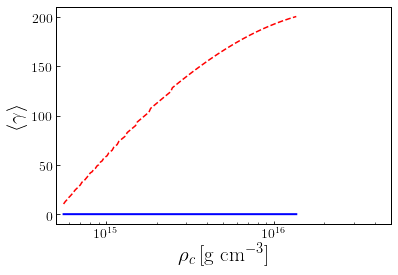

In [176]:
fig, ax = plt.subplots()
plt.plot(rhosc,gamma_crs1,lw='1.5',color='r',linestyle='--',label=r'$\gamma_{cr}$')
plt.plot(rhosc,gamma_efs1,lw='2.0',color='blue',label=r'$\langle \gamma \rangle$')

plt.xlabel(r'$\rho_c\,[$g cm$^{-3}]$')
plt.ylabel(r'$\langle \gamma \rangle$')

plt.xscale('log')
plt.xlim(left=10**(14.7),right=10**(16.7))
#plt.ylim(0,10)
ax.tick_params(axis="x", direction="in",which='both')
ax.tick_params(axis="y", direction="in",which='both')
#l = plt.legend(bbox_to_anchor=(0.85,-0.15), loc="lower right", 
                #bbox_transform=fig.transFigure, ncol=2)



plt.savefig('figures/AdiabaticIndexsqm2.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

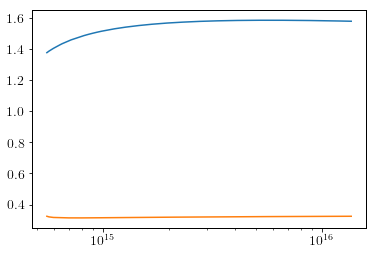

In [177]:
plt.plot(rhosc,gamma_crs2)
plt.plot(rhosc,gamma_efs2)
plt.xscale('log')

## M - $\rho_c$

In [178]:
Rsqm2,Msqm2,rhocsqm2=np.loadtxt('results/sqm2/MRrhoc.dat',usecols=(0,1,2),unpack=True)

In [179]:
np.amax(Msqm2)

1.7370311024

In [180]:
rhocsqm2[np.argmax(Msqm2)]

2539213664610000.0

In [181]:
np.log10(rhocsqm2[np.argmax(Msqm2)])

15.404699246544025

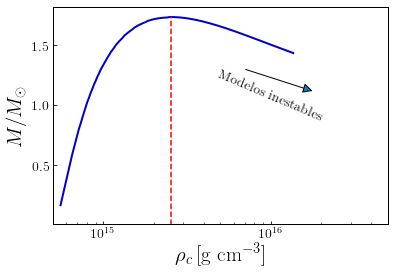

In [182]:
fig, ax = plt.subplots()

plt.plot(rhocsqm2,Msqm2,color='mediumblue',lw='2.0')
plt.plot([10**(np.log10(rhocsqm2[np.argmax(Msqm2)])),10**(np.log10(rhocsqm2[np.argmax(Msqm2)]))],[0.0,np.amax(Msqm2)],'r--',lw='1.5')

prop = dict(arrowstyle="-|>,head_width=0.4,head_length=0.8",
            shrinkA=0,shrinkB=0)
plt.annotate("", xy=(10**(16.25),1.12), xytext=(10**(15.85),1.3), arrowprops=prop)
#plt.arrow(10**(15.6), 1.38,10**(15.7) ,-0.1 , head_width=0.05, head_lsqm2th=10**(15))
plt.text(10**(15.67), 1.23, 'Modelos inestables' , fontsize=14,rotation=-23)

plt.xscale('log')
plt.xlabel(r'$\rho_c\,[$g cm$^{-3}]$')
plt.ylabel(r'$M/M_{\odot}$')
plt.xlim(left=10**(14.7),right=10**(16.7))
plt.ylim(bottom=0.01)
ax.tick_params(axis="x", direction="in",which='both')
ax.tick_params(axis="y", direction="in",which='both')

plt.savefig('figures/Mrhorel_sqm2.pdf', format='pdf', dpi=1000,bbox_inches="tight")

## Tunning the interpolation of the solution

### 14.87

In [184]:
sqm2_1487=np.loadtxt('results/sqm2/14.8746992465.dat',unpack=True)
sqm2_1487[3] = sqm2_1487[3]-sqm2_1487[3][-1] + 0.5*np.log(1-2*sqm2_1487[0][-1]/sqm2_1487[-1][-1])

In [185]:
s1=5e-7
s2=1e-15
sqm2_1487rho=interpolate.UnivariateSpline(sqm2_1487[-1], sqm2_1487[2], k=5, s=s1)
sqm2_1487drho=interpolate.UnivariateSpline(sqm2_1487[-1], sqm2_1487[2], k=5, s=s1).derivative(n=1)
sqm2_1487ddrho=interpolate.UnivariateSpline(sqm2_1487[-1], sqm2_1487[2], k=5, s=s1).derivative(n=2)

sqm2_1487p=interpolate.UnivariateSpline(sqm2_1487[-1], sqm2_1487[1], k=5, s=s2)
sqm2_1487dp=interpolate.UnivariateSpline(sqm2_1487[-1], sqm2_1487[1], k=5, s=s2).derivative(n=1)
sqm2_1487ddp=interpolate.UnivariateSpline(sqm2_1487[-1], sqm2_1487[1], k=5, s=s2).derivative(n=2)

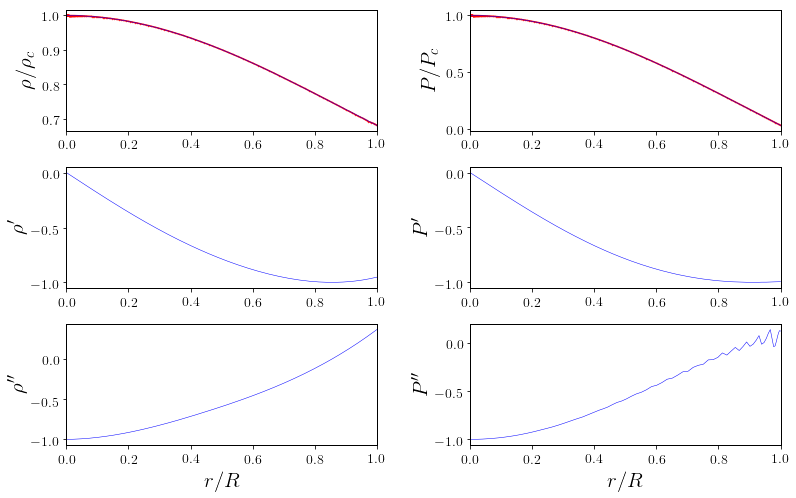

In [186]:
fig=plt.figure(figsize=[12.8,8])

plt.subplot(321)
plt.plot(sqm2_1487[-1]/sqm2_1487[-1][-1],sqm2_1487[2]/sqm2_1487[2][0],color='red',marker='o',markersize='0.4') 
plt.plot(sqm2_1487[-1]/sqm2_1487[-1][-1],sqm2_1487rho(sqm2_1487[-1])/sqm2_1487[2][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1) # leaving the crust out

plt.subplot(322)
plt.plot(sqm2_1487[-1]/sqm2_1487[-1][-1],sqm2_1487[1]/sqm2_1487[1][0],color='red',marker='o',markersize='0.4') 
plt.plot(sqm2_1487[-1]/sqm2_1487[-1][-1],sqm2_1487p(sqm2_1487[-1])/sqm2_1487[1][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$P/P_c$')
plt.xlim(0,1)

plt.subplot(323)
plt.plot(sqm2_1487[-1]/sqm2_1487[-1][-1],sqm2_1487drho(sqm2_1487[-1])/max(abs(sqm2_1487drho(sqm2_1487[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime}$')
plt.xlim(0,1)
#plt.ylim(-500,0)

plt.subplot(324)
plt.plot(sqm2_1487[-1]/sqm2_1487[-1][-1],sqm2_1487dp(sqm2_1487[-1])/max(abs(sqm2_1487dp(sqm2_1487[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime} $')
plt.xlim(0,1)

plt.subplot(325)
plt.plot(sqm2_1487[-1]/sqm2_1487[-1][-1],sqm2_1487ddrho(sqm2_1487[-1])/max(abs(sqm2_1487ddrho(sqm2_1487[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}$')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-0.01,0.01)

plt.subplot(326)
plt.plot(sqm2_1487[-1]/sqm2_1487[-1][-1],sqm2_1487ddp(sqm2_1487[-1])/max(abs(sqm2_1487ddp(sqm2_1487[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime\prime}$ ')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-1,1)

fig.subplots_adjust(hspace=0.3,wspace=0.3)

#plt.savefig('figures/ddssqm2_1487.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

### 15

In [187]:
sqm2_150=np.loadtxt('results/sqm2/15.0046992465.dat',unpack=True)
sqm2_150[3] = sqm2_150[3]-sqm2_150[3][-1] + 0.5*np.log(1-2*sqm2_150[0][-1]/sqm2_150[-1][-1])

In [196]:
s1=1e-15
s2=1e-12
sqm2_150rho=interpolate.UnivariateSpline(sqm2_150[-1], sqm2_150[2], k=5, s=s1)
sqm2_150drho=interpolate.UnivariateSpline(sqm2_150[-1], sqm2_150[2], k=5, s=s1).derivative(n=1)
sqm2_150ddrho=interpolate.UnivariateSpline(sqm2_150[-1], sqm2_150[2], k=5, s=s1).derivative(n=2)

sqm2_150p=interpolate.UnivariateSpline(sqm2_150[-1], sqm2_150[1], k=5, s=s2)
sqm2_150dp=interpolate.UnivariateSpline(sqm2_150[-1], sqm2_150[1], k=5, s=s2).derivative(n=1)
sqm2_150ddp=interpolate.UnivariateSpline(sqm2_150[-1], sqm2_150[1], k=5, s=s2).derivative(n=2)

In [197]:
sqm2_150rho(0.4*sqm2_150[-1][-1])*rhodim

889406765377960.6

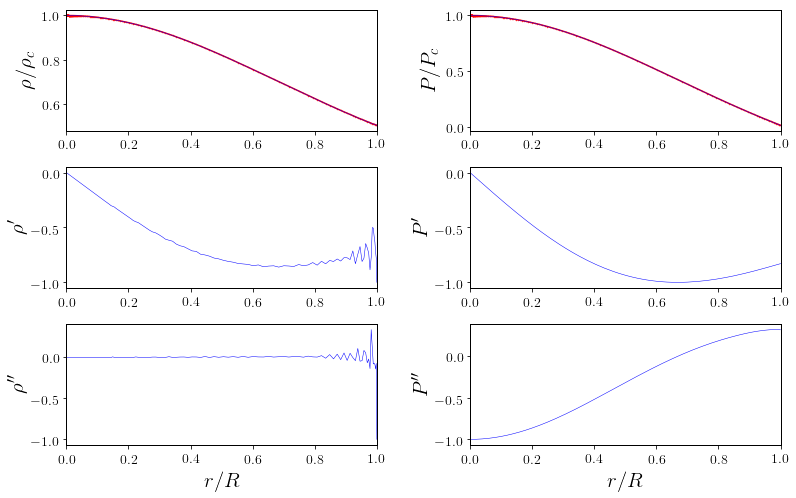

In [198]:
fig=plt.figure(figsize=[12.8,8])

plt.subplot(321)
plt.plot(sqm2_150[-1]/sqm2_150[-1][-1],sqm2_150[2]/sqm2_150[2][0],color='red',marker='o',markersize='0.4') 
plt.plot(sqm2_150[-1]/sqm2_150[-1][-1],sqm2_150rho(sqm2_150[-1])/sqm2_150[2][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1) # leaving the crust out

plt.subplot(322)
plt.plot(sqm2_150[-1]/sqm2_150[-1][-1],sqm2_150[1]/sqm2_150[1][0],color='red',marker='o',markersize='0.4') 
plt.plot(sqm2_150[-1]/sqm2_150[-1][-1],sqm2_150p(sqm2_150[-1])/sqm2_150[1][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$P/P_c$')
plt.xlim(0,1)

plt.subplot(323)
plt.plot(sqm2_150[-1]/sqm2_150[-1][-1],sqm2_150drho(sqm2_150[-1])/max(abs(sqm2_150drho(sqm2_150[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime}$')
plt.xlim(0,1)
#plt.ylim(-500,0)

plt.subplot(324)
plt.plot(sqm2_150[-1]/sqm2_150[-1][-1],sqm2_150dp(sqm2_150[-1])/max(abs(sqm2_150dp(sqm2_150[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime} $')
plt.xlim(0,1)

plt.subplot(325)
plt.plot(sqm2_150[-1]/sqm2_150[-1][-1],sqm2_150ddrho(sqm2_150[-1])/max(abs(sqm2_150ddrho(sqm2_150[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}$')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-0.01,0.01)

plt.subplot(326)
plt.plot(sqm2_150[-1]/sqm2_150[-1][-1],sqm2_150ddp(sqm2_150[-1])/max(abs(sqm2_150ddp(sqm2_150[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime\prime}$ ')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-1,1)

fig.subplots_adjust(hspace=0.3,wspace=0.3)

#plt.savefig('figures/ddssqm2_150.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

### 15.5

In [191]:
sqm2_155=np.loadtxt('results/sqm2/15.5046992465.dat',unpack=True)
sqm2_155[3] = sqm2_155[3]-sqm2_155[3][-1] + 0.5*np.log(1-2*sqm2_155[0][-1]/sqm2_155[-1][-1])

In [194]:
s1=1e-15
s2=1e-9
sqm2_155rho=interpolate.UnivariateSpline(sqm2_155[-1], sqm2_155[2], k=5, s=s1)
sqm2_155drho=interpolate.UnivariateSpline(sqm2_155[-1], sqm2_155[2], k=5, s=s1).derivative(n=1)
sqm2_155ddrho=interpolate.UnivariateSpline(sqm2_155[-1], sqm2_155[2], k=5, s=s1).derivative(n=2)

sqm2_155p=interpolate.UnivariateSpline(sqm2_155[-1], sqm2_155[1], k=5, s=s2)
sqm2_155dp=interpolate.UnivariateSpline(sqm2_155[-1], sqm2_155[1], k=5, s=s2).derivative(n=1)
sqm2_155ddp=interpolate.UnivariateSpline(sqm2_155[-1], sqm2_155[1], k=5, s=s2).derivative(n=2)

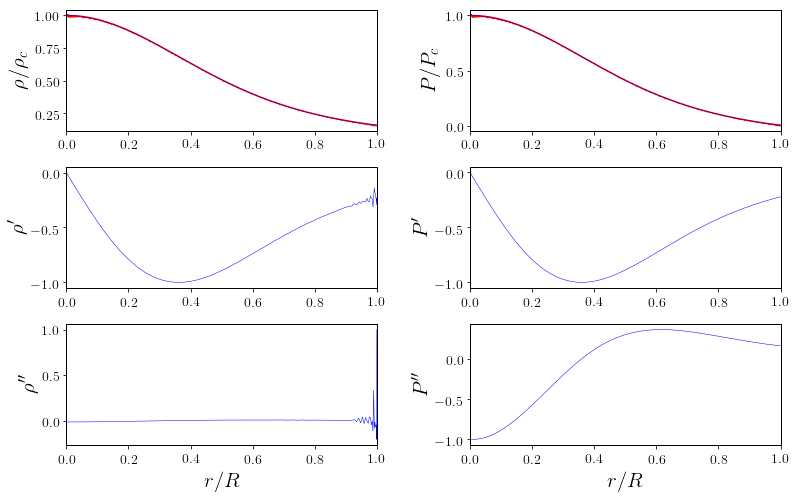

In [195]:
fig=plt.figure(figsize=[12.8,8])

plt.subplot(321)
plt.plot(sqm2_155[-1]/sqm2_155[-1][-1],sqm2_155[2]/sqm2_155[2][0],color='red',marker='o',markersize='0.4') 
plt.plot(sqm2_155[-1]/sqm2_155[-1][-1],sqm2_155rho(sqm2_155[-1])/sqm2_155[2][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1) # leaving the crust out

plt.subplot(322)
plt.plot(sqm2_155[-1]/sqm2_155[-1][-1],sqm2_155[1]/sqm2_155[1][0],color='red',marker='o',markersize='0.4') 
plt.plot(sqm2_155[-1]/sqm2_155[-1][-1],sqm2_155p(sqm2_155[-1])/sqm2_155[1][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$P/P_c$')
plt.xlim(0,1)

plt.subplot(323)
plt.plot(sqm2_155[-1]/sqm2_155[-1][-1],sqm2_155drho(sqm2_155[-1])/max(abs(sqm2_155drho(sqm2_155[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime}$')
plt.xlim(0,1)
#plt.ylim(-500,0)

plt.subplot(324)
plt.plot(sqm2_155[-1]/sqm2_155[-1][-1],sqm2_155dp(sqm2_155[-1])/max(abs(sqm2_155dp(sqm2_155[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime} $')
plt.xlim(0,1)

plt.subplot(325)
plt.plot(sqm2_155[-1]/sqm2_155[-1][-1],sqm2_155ddrho(sqm2_155[-1])/max(abs(sqm2_155ddrho(sqm2_155[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}$')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-0.01,0.01)

plt.subplot(326)
plt.plot(sqm2_155[-1]/sqm2_155[-1][-1],sqm2_155ddp(sqm2_155[-1])/max(abs(sqm2_155ddp(sqm2_155[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime\prime}$ ')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-1,1)

fig.subplots_adjust(hspace=0.3,wspace=0.3)

#plt.savefig('figures/ddssqm2_155.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

## Redshift

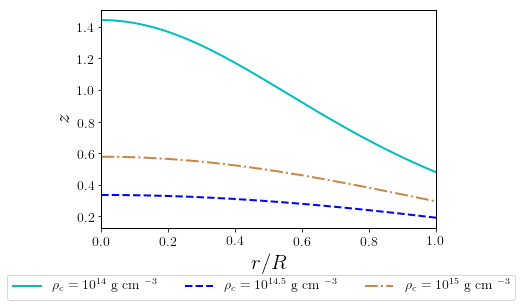

In [199]:
fig = plt.figure()

plt.plot(sqm2_155[-1]/sqm2_155[-1][-1],np.exp(-sqm2_155[3])-1.0,color='c',linewidth='2.0',label=r'$\rho_c=10^{14}$ g cm $^{-3}$')
plt.plot(sqm2_1487[-1]/sqm2_1487[-1][-1],np.exp(-sqm2_1487[3])-1.0,color='blue',linewidth='2.0',linestyle='--',label=r'$\rho_c=10^{14.5}$ g cm $^{-3}$')
plt.plot(sqm2_150[-1]/sqm2_150[-1][-1],np.exp(-sqm2_150[3])-1.0,color='peru',linewidth='2.0',linestyle='-.',label=r'$\rho_c=10^{15}$ g cm $^{-3}$')

l = plt.legend(bbox_to_anchor=(1.1,-0.15), loc="lower right", 
                bbox_transform=fig.transFigure, ncol=3)

plt.xlabel(r'$r/R$')
plt.ylabel(r'$z$')
plt.xlim(0,1.0)

plt.savefig('figures/Redshiftsqm2.pdf', format='pdf', dpi=1000,bbox_inches="tight")

# SQM3 --------------------------------------------------------------------------------------

In [200]:
rhosqm3,Psqm3,nsqm3=np.loadtxt('EOS/sqm3.dat',usecols=(2,1,0),unpack=True)

## Dominant energy condition

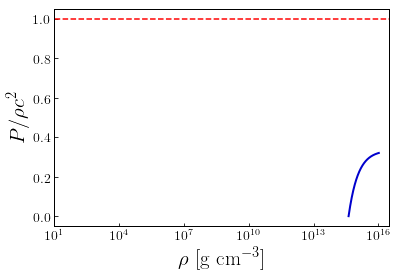

<Figure size 432x288 with 0 Axes>

In [201]:
fig, ax = plt.subplots()
plt.plot(rhosqm3,np.divide(Psqm3,rhosqm3),lw='2',color='mediumblue')
plt.plot([0,10**(17)],[1.0,1.0],'r--',lw='1.5')

ax.set_xscale("log")
#locmaj = matplotlib.ticker.LogLocator(base=10.0,numticks=16) 
#ax.xaxis.set_major_locator(locmaj)


plt.xlabel(r'$\rho$ [g\,\,cm$^{-3}$]')
plt.ylabel(r'$ P / \rho c^2 $')
#locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks=16)
#ax.xaxis.set_minor_locator(locmin)
#ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.tick_params(axis="x", direction="in")
ax.tick_params(axis="y", direction="in")
plt.xlim(10,10**(16.5))
#ax.set_facecolor('floralwhite')
#plt.gca().set_aspect('equal', adjustable='box')
#plt.draw()
#plt.ylim(0,1)
plt.savefig('figures/ECsqm3.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()
plt.clf()

## Speed of sound

In [202]:
vsquared=interpolate.UnivariateSpline(rhosqm3, Psqm3, k=1, s=0).derivative(n=1)

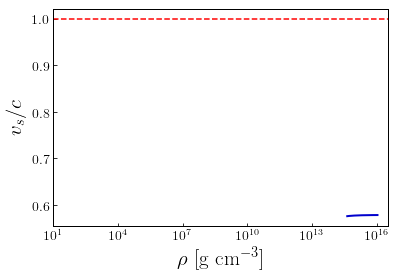

In [203]:
fig, ax = plt.subplots()
plt.plot(rhosqm3,np.sqrt(vsquared(rhosqm3)),lw='2.0',color='mediumblue')
plt.plot([1e+1,10**(16.5)],[1.0,1.0],'r--',lw='1.5')
plt.xlabel(r'$\rho$ [g\,\,cm$^{-3}$]')
plt.ylabel(r'$ v_s / c $')
plt.xscale('log')
ax.tick_params(axis="x", direction="in")
ax.tick_params(axis="y", direction="in")
plt.xlim(10,10**(16.5))
#ax.set_facecolor('floralwhite')
#mpl.rcParams['axes.linewidth'] = 1.4
#plt.gca().set_aspect('equal', adjustable='box')
#plt.draw()
plt.savefig('figures/SSsqm3.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

## Adiabatic Index

In [204]:
Gamma=np.multiply(np.divide(np.add(rhosqm3,Psqm3),Psqm3),vsquared(rhosqm3))

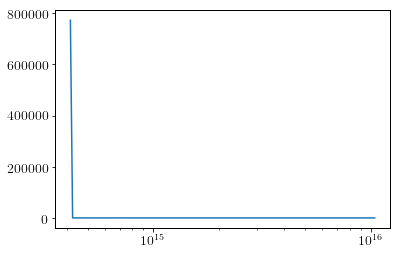

In [205]:
plt.plot(rhosqm3,Gamma)
plt.xscale('log')

$$ \langle\gamma\rangle=\frac{\int_{0}^{R} e^{(\lambda+3 \nu) } \gamma(r) P(r) r^{2} d r}{\int_{0}^{R} e^{(\lambda+3 \nu) } P(r) r^{2} d r} $$

Listing all the models calculated

In [206]:
owd=os.getcwd()
path=os.chdir('results/sqm3')
listOfEntries= os.scandir(path)
models_sqm3 = []
for entry in listOfEntries:
    if '1' in entry.name:
        models_sqm3.append(entry.name)
os.chdir(owd)
models_sqm3.sort()

In [207]:
gamma_efs1 = []
gamma_efs2 = []
gamma_crs1 = []
gamma_crs2 = []
rhosc= []
for model in models_sqm3:
    m, P, rho, nu, lambd, r = np.loadtxt('results/sqm3/' + model ,unpack=True)
    nu = nu - nu[-1] + 0.5*np.log(1-2*m[-1]/r[-1])
    #lambd = np.zeros_like(r)
    #for i in range((r.shape)[0]):
    #    if i==0:
    #        lambd[i] = 0
    #    else:
    #        lambd[i] = 0.5*np.log(1/(1-2*m[i]/r[i]))
    drho=interpolate.UnivariateSpline(r, rho, k=5, s=0).derivative(n=1)
    dP=interpolate.UnivariateSpline(r, P, k=5, s=0).derivative(n=1)
    gamma = np.divide(dP(r),drho(r))
    gamma_ef1 = integrate.trapz(np.exp(lambd+3*nu)*gamma*P*(r**2),r)/integrate.trapz(np.exp(lambd+3*nu)*P*(r**2),r)
    t1 = (1/36)*integrate.trapz(np.exp((lambd+3*nu))*(16*P+(np.exp(2*lambd)-1)*(P+rho))*(np.exp(2*lambd)-1)*(r**2))/integrate.trapz(np.exp(lambd+3*nu)*P*(r**2),r)
    t2 = (4*np.pi/9)*integrate.trapz(np.exp(3*lambd+3*nu)*(8*P + (np.exp(2*lambd)+1)*(P+rho))*P*(r**4),r)/integrate.trapz(np.exp(lambd+3*nu)*P*(r**2),r)
    t3 = ((16*np.pi**2)/9)*integrate.trapz(np.exp(5*lambd+3*nu)*(P+rho)*(P**2)*(r**6),r)/integrate.trapz(np.exp(lambd+3*nu)*P*(r**2),r)
    gamma_cr1 = 4/3 + t1 + t2 + t3
    gamma_efs1.append(gamma_ef1)
    gamma_crs1.append(gamma_cr1)
    gamma_ef2 = integrate.trapz(gamma*P*r**2,r)/integrate.trapz(P*r**2,r)
    gamma_cr2 = 4/3 + (19/42)*2*m[-1]/r[-1]
    gamma_efs2.append(gamma_ef2)
    gamma_crs2.append(gamma_cr2)
    rhosc.append(rho[0]*rhodim)

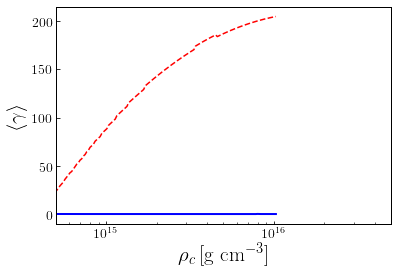

In [208]:
fig, ax = plt.subplots()
plt.plot(rhosc,gamma_crs1,lw='1.5',color='r',linestyle='--',label=r'$\gamma_{cr}$')
plt.plot(rhosc,gamma_efs1,lw='2.0',color='blue',label=r'$\langle \gamma \rangle$')

plt.xlabel(r'$\rho_c\,[$g cm$^{-3}]$')
plt.ylabel(r'$\langle \gamma \rangle$')

plt.xscale('log')
plt.xlim(left=10**(14.7),right=10**(16.7))
#plt.ylim(0,10)
ax.tick_params(axis="x", direction="in",which='both')
ax.tick_params(axis="y", direction="in",which='both')
#l = plt.legend(bbox_to_anchor=(0.85,-0.15), loc="lower right", 
                #bbox_transform=fig.transFigure, ncol=2)



plt.savefig('figures/AdiabaticIndexsqm3.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

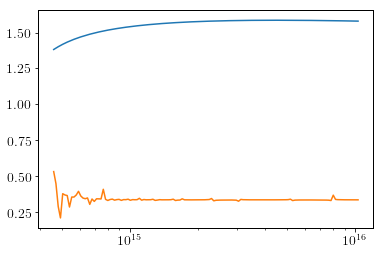

In [209]:
plt.plot(rhosc,gamma_crs2)
plt.plot(rhosc,gamma_efs2)
plt.xscale('log')

## M - $\rho_c$

In [210]:
Rsqm3,Msqm3,rhocsqm3=np.loadtxt('results/sqm3/MRrhoc.dat',usecols=(0,1,2),unpack=True)

In [211]:
np.amax(Msqm3)

1.97738016026

In [212]:
rhocsqm3[np.argmax(Msqm3)]

2009302726160000.0

In [213]:
np.log10(rhocsqm3[np.argmax(Msqm3)])

15.303045373481131

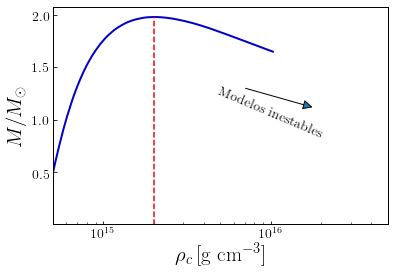

In [214]:
fig, ax = plt.subplots()

plt.plot(rhocsqm3,Msqm3,color='mediumblue',lw='2.0')
plt.plot([10**(np.log10(rhocsqm3[np.argmax(Msqm3)])),10**(np.log10(rhocsqm3[np.argmax(Msqm3)]))],[0.0,np.amax(Msqm3)],'r--',lw='1.5')

prop = dict(arrowstyle="-|>,head_width=0.4,head_length=0.8",
            shrinkA=0,shrinkB=0)
plt.annotate("", xy=(10**(16.25),1.12), xytext=(10**(15.85),1.3), arrowprops=prop)
#plt.arrow(10**(15.6), 1.38,10**(15.7) ,-0.1 , head_width=0.05, head_lsqm3th=10**(15))
plt.text(10**(15.67), 1.23, 'Modelos inestables' , fontsize=14,rotation=-23)

plt.xscale('log')
plt.xlabel(r'$\rho_c\,[$g cm$^{-3}]$')
plt.ylabel(r'$M/M_{\odot}$')
plt.xlim(left=10**(14.7),right=10**(16.7))
plt.ylim(bottom=0.01)
ax.tick_params(axis="x", direction="in",which='both')
ax.tick_params(axis="y", direction="in",which='both')

plt.savefig('figures/Mrhorel_sqm3.pdf', format='pdf', dpi=1000,bbox_inches="tight")

## Tunning the interpolation of the solution

### 14.87

In [304]:
sqm3_1487=np.loadtxt('results/sqm3/14.8730453735.dat',unpack=True)
sqm3_1487[3] = sqm3_1487[3]-sqm3_1487[3][-1] + 0.5*np.log(1-2*sqm3_1487[0][-1]/sqm3_1487[-1][-1])

In [321]:
sqm3_1487[1][-1]*Pdim

6.051305039566055e+32

In [322]:
s1=1e-5
s2=1e-15
sqm3_1487rho=interpolate.UnivariateSpline(sqm3_1487[-1], sqm3_1487[2], k=5, s=s1)
sqm3_1487drho=interpolate.UnivariateSpline(sqm3_1487[-1], sqm3_1487[2], k=5, s=s1).derivative(n=1)
sqm3_1487ddrho=interpolate.UnivariateSpline(sqm3_1487[-1], sqm3_1487[2], k=5, s=s1).derivative(n=2)

sqm3_1487p=interpolate.UnivariateSpline(sqm3_1487[-1], sqm3_1487[1], k=5, s=s2)
sqm3_1487dp=interpolate.UnivariateSpline(sqm3_1487[-1], sqm3_1487[1], k=5, s=s2).derivative(n=1)
sqm3_1487ddp=interpolate.UnivariateSpline(sqm3_1487[-1], sqm3_1487[1], k=5, s=s2).derivative(n=2)

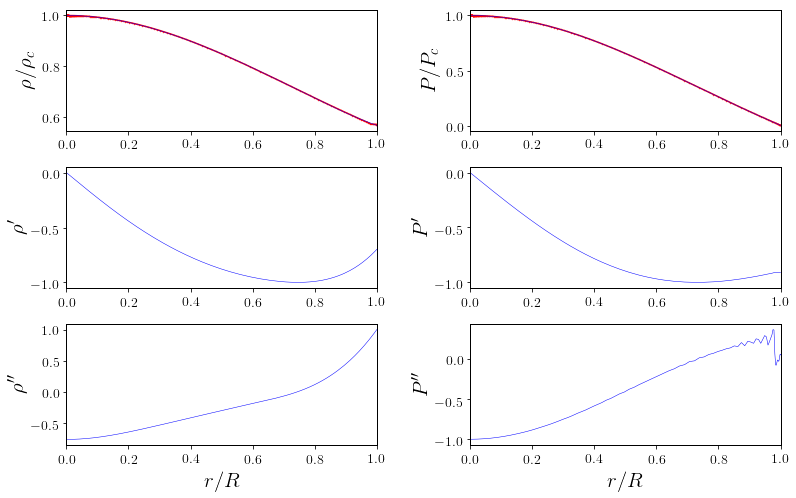

In [323]:
fig=plt.figure(figsize=[12.8,8])

plt.subplot(321)
plt.plot(sqm3_1487[-1]/sqm3_1487[-1][-1],sqm3_1487[2]/sqm3_1487[2][0],color='red',marker='o',markersize='0.4') 
plt.plot(sqm3_1487[-1]/sqm3_1487[-1][-1],sqm3_1487rho(sqm3_1487[-1])/sqm3_1487[2][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1) # leaving the crust out

plt.subplot(322)
plt.plot(sqm3_1487[-1]/sqm3_1487[-1][-1],sqm3_1487[1]/sqm3_1487[1][0],color='red',marker='o',markersize='0.4') 
plt.plot(sqm3_1487[-1]/sqm3_1487[-1][-1],sqm3_1487p(sqm3_1487[-1])/sqm3_1487[1][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$P/P_c$')
plt.xlim(0,1)

plt.subplot(323)
plt.plot(sqm3_1487[-1]/sqm3_1487[-1][-1],sqm3_1487drho(sqm3_1487[-1])/max(abs(sqm3_1487drho(sqm3_1487[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime}$')
plt.xlim(0,1)
#plt.ylim(-500,0)

plt.subplot(324)
plt.plot(sqm3_1487[-1]/sqm3_1487[-1][-1],sqm3_1487dp(sqm3_1487[-1])/max(abs(sqm3_1487dp(sqm3_1487[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime} $')
plt.xlim(0,1)

plt.subplot(325)
plt.plot(sqm3_1487[-1]/sqm3_1487[-1][-1],sqm3_1487ddrho(sqm3_1487[-1])/max(abs(sqm3_1487ddrho(sqm3_1487[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}$')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-0.01,0.01)

plt.subplot(326)
plt.plot(sqm3_1487[-1]/sqm3_1487[-1][-1],sqm3_1487ddp(sqm3_1487[-1])/max(abs(sqm3_1487ddp(sqm3_1487[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime\prime}$ ')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-1,1)

fig.subplots_adjust(hspace=0.3,wspace=0.3)

#plt.savefig('figures/ddssqm3_1487.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

### 15

In [324]:
sqm3_150=np.loadtxt('results/sqm3/15.0030453735.dat',unpack=True)
sqm3_150[3] = sqm3_150[3]-sqm3_150[3][-1] + 0.5*np.log(1-2*sqm3_150[0][-1]/sqm3_150[-1][-1])

In [325]:
s1=1e-7
s2=1e-12
sqm3_150rho=interpolate.UnivariateSpline(sqm3_150[-1], sqm3_150[2], k=5, s=s1)
sqm3_150drho=interpolate.UnivariateSpline(sqm3_150[-1], sqm3_150[2], k=5, s=s1).derivative(n=1)
sqm3_150ddrho=interpolate.UnivariateSpline(sqm3_150[-1], sqm3_150[2], k=5, s=s1).derivative(n=2)

sqm3_150p=interpolate.UnivariateSpline(sqm3_150[-1], sqm3_150[1], k=5, s=s2)
sqm3_150dp=interpolate.UnivariateSpline(sqm3_150[-1], sqm3_150[1], k=5, s=s2).derivative(n=1)
sqm3_150ddp=interpolate.UnivariateSpline(sqm3_150[-1], sqm3_150[1], k=5, s=s2).derivative(n=2)

In [326]:
sqm3_150[1][-1]*Pdim

6.1716045695536534e+32

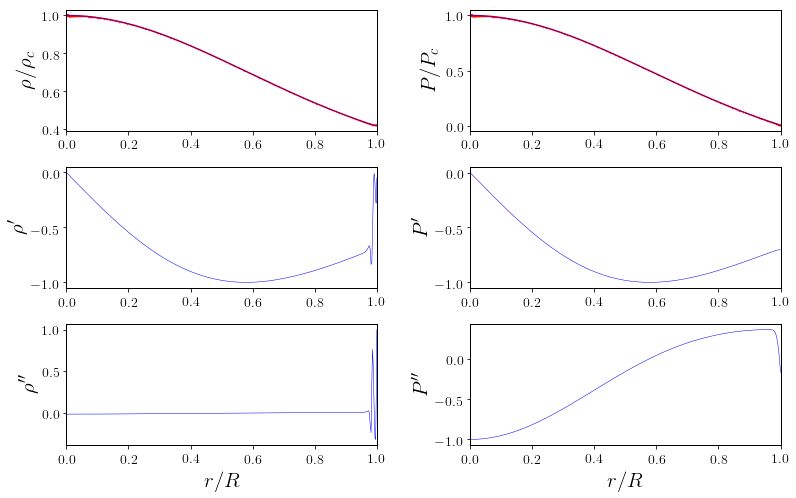

In [327]:
fig=plt.figure(figsize=[12.8,8])

plt.subplot(321)
plt.plot(sqm3_150[-1]/sqm3_150[-1][-1],sqm3_150[2]/sqm3_150[2][0],color='red',marker='o',markersize='0.4') 
plt.plot(sqm3_150[-1]/sqm3_150[-1][-1],sqm3_150rho(sqm3_150[-1])/sqm3_150[2][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1) # leaving the crust out

plt.subplot(322)
plt.plot(sqm3_150[-1]/sqm3_150[-1][-1],sqm3_150[1]/sqm3_150[1][0],color='red',marker='o',markersize='0.4') 
plt.plot(sqm3_150[-1]/sqm3_150[-1][-1],sqm3_150p(sqm3_150[-1])/sqm3_150[1][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$P/P_c$')
plt.xlim(0,1)

plt.subplot(323)
plt.plot(sqm3_150[-1]/sqm3_150[-1][-1],sqm3_150drho(sqm3_150[-1])/max(abs(sqm3_150drho(sqm3_150[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime}$')
plt.xlim(0,1)
#plt.ylim(-500,0)

plt.subplot(324)
plt.plot(sqm3_150[-1]/sqm3_150[-1][-1],sqm3_150dp(sqm3_150[-1])/max(abs(sqm3_150dp(sqm3_150[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime} $')
plt.xlim(0,1)

plt.subplot(325)
plt.plot(sqm3_150[-1]/sqm3_150[-1][-1],sqm3_150ddrho(sqm3_150[-1])/max(abs(sqm3_150ddrho(sqm3_150[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}$')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-0.01,0.01)

plt.subplot(326)
plt.plot(sqm3_150[-1]/sqm3_150[-1][-1],sqm3_150ddp(sqm3_150[-1])/max(abs(sqm3_150ddp(sqm3_150[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime\prime}$ ')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-1,1)

fig.subplots_adjust(hspace=0.3,wspace=0.3)

#plt.savefig('figures/ddssqm3_150.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

### 15.5

In [328]:
sqm3_155=np.loadtxt('results/sqm3/15.5030453735.dat',unpack=True)
sqm3_155[3] = sqm3_155[3]-sqm3_155[3][-1] + 0.5*np.log(1-2*sqm3_155[0][-1]/sqm3_155[-1][-1])

In [329]:
s1=1e-15
s2=1e-9
sqm3_155rho=interpolate.UnivariateSpline(sqm3_155[-1], sqm3_155[2], k=5, s=s1)
sqm3_155drho=interpolate.UnivariateSpline(sqm3_155[-1], sqm3_155[2], k=5, s=s1).derivative(n=1)
sqm3_155ddrho=interpolate.UnivariateSpline(sqm3_155[-1], sqm3_155[2], k=5, s=s1).derivative(n=2)

sqm3_155p=interpolate.UnivariateSpline(sqm3_155[-1], sqm3_155[1], k=5, s=s2)
sqm3_155dp=interpolate.UnivariateSpline(sqm3_155[-1], sqm3_155[1], k=5, s=s2).derivative(n=1)
sqm3_155ddp=interpolate.UnivariateSpline(sqm3_155[-1], sqm3_155[1], k=5, s=s2).derivative(n=2)

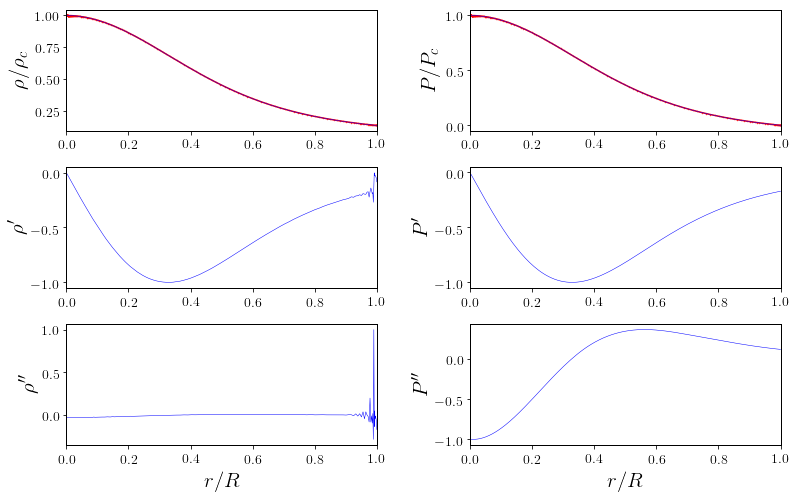

In [330]:
fig=plt.figure(figsize=[12.8,8])

plt.subplot(321)
plt.plot(sqm3_155[-1]/sqm3_155[-1][-1],sqm3_155[2]/sqm3_155[2][0],color='red',marker='o',markersize='0.4') 
plt.plot(sqm3_155[-1]/sqm3_155[-1][-1],sqm3_155rho(sqm3_155[-1])/sqm3_155[2][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1) # leaving the crust out

plt.subplot(322)
plt.plot(sqm3_155[-1]/sqm3_155[-1][-1],sqm3_155[1]/sqm3_155[1][0],color='red',marker='o',markersize='0.4') 
plt.plot(sqm3_155[-1]/sqm3_155[-1][-1],sqm3_155p(sqm3_155[-1])/sqm3_155[1][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$P/P_c$')
plt.xlim(0,1)

plt.subplot(323)
plt.plot(sqm3_155[-1]/sqm3_155[-1][-1],sqm3_155drho(sqm3_155[-1])/max(abs(sqm3_155drho(sqm3_155[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime}$')
plt.xlim(0,1)
#plt.ylim(-500,0)

plt.subplot(324)
plt.plot(sqm3_155[-1]/sqm3_155[-1][-1],sqm3_155dp(sqm3_155[-1])/max(abs(sqm3_155dp(sqm3_155[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime} $')
plt.xlim(0,1)

plt.subplot(325)
plt.plot(sqm3_155[-1]/sqm3_155[-1][-1],sqm3_155ddrho(sqm3_155[-1])/max(abs(sqm3_155ddrho(sqm3_155[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}$')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-0.01,0.01)

plt.subplot(326)
plt.plot(sqm3_155[-1]/sqm3_155[-1][-1],sqm3_155ddp(sqm3_155[-1])/max(abs(sqm3_155ddp(sqm3_155[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime\prime}$ ')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-1,1)

fig.subplots_adjust(hspace=0.3,wspace=0.3)

#plt.savefig('figures/ddssqm3_155.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

## Redshift

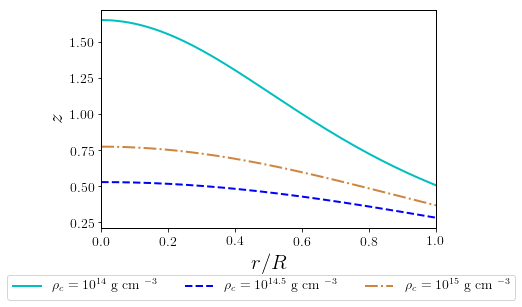

In [331]:
fig = plt.figure()

plt.plot(sqm3_155[-1]/sqm3_155[-1][-1],np.exp(-sqm3_155[3])-1.0,color='c',linewidth='2.0',label=r'$\rho_c=10^{14}$ g cm $^{-3}$')
plt.plot(sqm3_1487[-1]/sqm3_1487[-1][-1],np.exp(-sqm3_1487[3])-1.0,color='blue',linewidth='2.0',linestyle='--',label=r'$\rho_c=10^{14.5}$ g cm $^{-3}$')
plt.plot(sqm3_150[-1]/sqm3_150[-1][-1],np.exp(-sqm3_150[3])-1.0,color='peru',linewidth='2.0',linestyle='-.',label=r'$\rho_c=10^{15}$ g cm $^{-3}$')

l = plt.legend(bbox_to_anchor=(1.1,-0.15), loc="lower right", 
                bbox_transform=fig.transFigure, ncol=3)

plt.xlabel(r'$r/R$')
plt.ylabel(r'$z$')
plt.xlim(0,1.0)

plt.savefig('figures/Redshiftsqm3.pdf', format='pdf', dpi=1000,bbox_inches="tight")

## Adiabatic convection

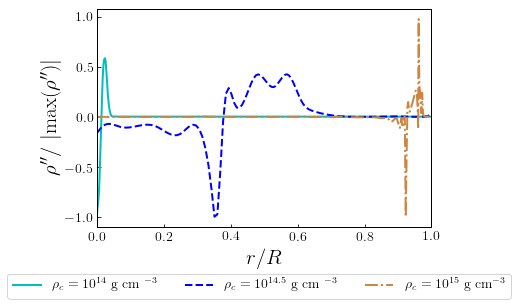

In [163]:
fig, ax = plt.subplots()

plt.plot(eng_140[-1]/eng_140[-1][-1],eng_140ddrho(eng_140[-1])/max(abs(eng_140ddrho(eng_140[-1]))),color='c',linewidth='2.0',label=r'$\rho_c=10^{14}$ g cm $^{-3}$') 
plt.plot(eng_145[-1]/eng_145[-1][-1],eng_145ddrho(eng_145[-1])/max(abs(eng_145ddrho(eng_145[-1]))),color='blue',linewidth='2.0',linestyle='--',label=r'$\rho_c=10^{14.5}$ g cm $^{-3}$') 
plt.plot(eng_150[-1]/eng_150[-1][-1],eng_150ddrho(eng_150[-1])/max(abs(eng_150ddrho(eng_150[-1]))),color='peru',linewidth='2.0',linestyle='-.',label=r'$\rho_c=10^{15}$ g cm$ ^{-3}$')

#plt.plot(eng_155[-1]/eng_155[-1][-1],eng_155drho(eng_155[-1])/max(abs(eng_155drho(eng_140[-1]))),color='yellow',linewidth='2.0',linestyle='-.',label=r'$\rho_c=10^{15.5}$ g cm$ ^{-3}$')

l = plt.legend(bbox_to_anchor=(1.1,-0.15), loc="lower right", 
                bbox_transform=fig.transFigure, ncol=3)

ax.tick_params(axis="x", direction="in")
ax.tick_params(axis="y", direction="in")

plt.xlabel(r'$r/R$')
plt.ylabel(r'$\rho^{\prime \prime}/$ $|$max$(\rho^{\prime \prime})|$')
plt.xlim(0,1.0)

plt.savefig('figures/ConvecStabilityeng.pdf', format='pdf', dpi=1000,bbox_inches="tight")


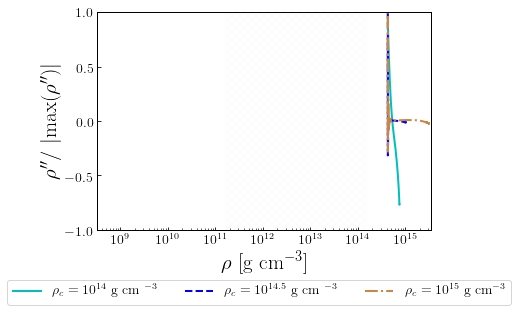

In [333]:
fig, ax = plt.subplots()

ax.set_xscale("log")

plt.plot(sqm3_1487[2]*rhodim,sqm3_1487ddrho(sqm3_1487[-1])/max(abs(sqm3_1487ddrho(sqm3_1487[-1]))),color='c',linewidth='2.0',label=r'$\rho_c=10^{14}$ g cm $^{-3}$') 
plt.plot(sqm3_150[2]*rhodim,sqm3_150ddrho(sqm3_150[-1])/max(abs(sqm3_150ddrho(sqm3_150[-1]))),color='blue',linewidth='2.0',linestyle='--',label=r'$\rho_c=10^{14.5}$ g cm $^{-3}$') 
plt.plot(sqm3_155[2]*rhodim,sqm3_155ddrho(sqm3_155[-1])/max(abs(sqm3_155ddrho(sqm3_155[-1]))),color='peru',linewidth='2.0',linestyle='-.',label=r'$\rho_c=10^{15}$ g cm$ ^{-3}$')
plt.xlim(left=10**(8.5))
#plt.plot(sqm3_155[-1]/sqm3_155[-1][-1],sqm3_155drho(sqm3_155[-1])/max(abs(sqm3_155drho(sqm3_140[-1]))),color='yellow',linewidth='2.0',linestyle='-.',label=r'$\rho_c=10^{15.5}$ g cm$ ^{-3}$')

x = (10**(11.2),10**(14.2))
y1 = (1,1)
y2 = (-1,-1)

#plt.plot(x1,y,color='black')
#plt.plot(x2,y,color='black')
mpl.rcParams['hatch.linewidth'] = 0.05
plt.fill_between(x, y1,y2,facecolor='none', hatch="xxx", edgecolor="lightgray", linewidth=0.0)

l = plt.legend(bbox_to_anchor=(1.1,-0.16), loc="lower right", 
                bbox_transform=fig.transFigure, ncol=3)
ax.tick_params(axis="x", direction="in",which='both')
ax.tick_params(axis="y", direction="in")

plt.xlabel(r'$\rho$ [g cm$^{-3}$]')
plt.ylabel(r'$\rho^{\prime \prime}/$ $|$max$(\rho^{\prime \prime})|$')
plt.ylim(-1,1.0)

plt.savefig('figures/ConvecStabilitysqm3Correl.pdf', format='pdf', dpi=1000,bbox_inches="tight")

# WFF1 --------------------------------------------------------------------------------------

In [113]:
rhowff1,Pwff1,nwff1=np.loadtxt('EOS/wff1.dat',usecols=(2,1,0),unpack=True)

## Dominant energy condition

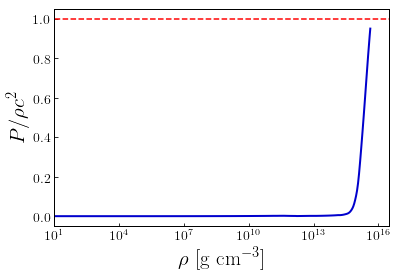

<Figure size 432x288 with 0 Axes>

In [114]:
fig, ax = plt.subplots()
plt.plot(rhowff1,np.divide(Pwff1,rhowff1),lw='2',color='mediumblue')
plt.plot([0,10**(17)],[1.0,1.0],'r--',lw='1.5')

ax.set_xscale("log")
#locmaj = matplotlib.ticker.LogLocator(base=10.0,numticks=16) 
#ax.xaxis.set_major_locator(locmaj)


plt.xlabel(r'$\rho$ [g\,\,cm$^{-3}$]')
plt.ylabel(r'$ P / \rho c^2 $')
#locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks=16)
#ax.xaxis.set_minor_locator(locmin)
#ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.tick_params(axis="x", direction="in")
ax.tick_params(axis="y", direction="in")
plt.xlim(10,10**(16.5))
#ax.set_facecolor('floralwhite')
#plt.gca().set_aspect('equal', adjustable='box')
#plt.draw()
#plt.ylim(0,1)
plt.savefig('figures/ECwff1.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()
plt.clf()

## Speed of sound

In [115]:
vsquared=interpolate.UnivariateSpline(rhowff1, Pwff1, k=1, s=0).derivative(n=1)

/home/dave/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  


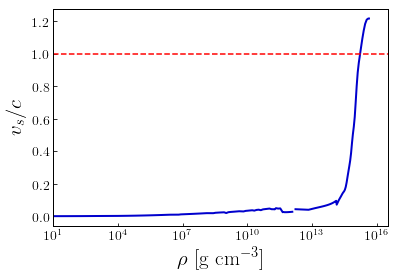

In [116]:
fig, ax = plt.subplots()
plt.plot(rhowff1,np.sqrt(vsquared(rhowff1)),lw='2.0',color='mediumblue')
plt.plot([1e+1,10**(16.5)],[1.0,1.0],'r--',lw='1.5')
plt.xlabel(r'$\rho$ [g\,\,cm$^{-3}$]')
plt.ylabel(r'$ v_s / c $')
plt.xscale('log')
ax.tick_params(axis="x", direction="in")
ax.tick_params(axis="y", direction="in")
plt.xlim(10,10**(16.5))
#ax.set_facecolor('floralwhite')
#mpl.rcParams['axes.linewidth'] = 1.4
#plt.gca().set_aspect('equal', adjustable='box')
#plt.draw()
plt.savefig('figures/SSwff1.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

## Adiabatic Index

In [117]:
Gamma=np.multiply(np.divide(np.add(rhowff1,Pwff1),Pwff1),vsquared(rhowff1))

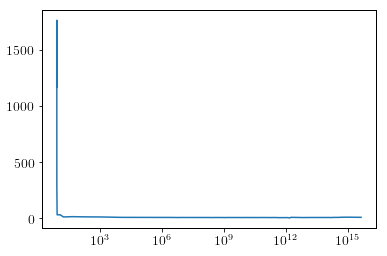

In [118]:
plt.plot(rhowff1,Gamma)
plt.xscale('log')

$$ \langle\gamma\rangle=\frac{\int_{0}^{R} e^{(\lambda+3 \nu) } \gamma(r) P(r) r^{2} d r}{\int_{0}^{R} e^{(\lambda+3 \nu) } P(r) r^{2} d r} $$

Listing all the models calculated

In [119]:
owd=os.getcwd()
path=os.chdir('results/wff1')
listOfEntries= os.scandir(path)
models_wff1 = []
for entry in listOfEntries:
    if '1' in entry.name:
        models_wff1.append(entry.name)
os.chdir(owd)
models_wff1.sort()

In [143]:
gamma_efs = []
gamma_crs = []
rhosc= []
betas=[]
for model in models_wff1:
    m, P, rho, nu, lambd, r = np.loadtxt('results/wff1/' + model ,unpack=True)
    nu = nu - nu[-1] + 0.5*np.log(1-2*m[-1]/r[-1])
    drho=interpolate.UnivariateSpline(r, rho, k=3, s=1e-10).derivative(n=1)
    dP=interpolate.UnivariateSpline(r, P, k=3, s=1e-10).derivative(n=1)
    gamma = np.divide(dP(r),drho(r))
    gamma_ef = integrate.trapz(np.exp(lambd+3*nu)*gamma*P*(r**2),r)/integrate.trapz(np.exp(lambd+3*nu)*P*(r**2),r)
    t1 = (4/9)*integrate.trapz(np.exp((lambd+3*nu))*(16*P+(np.exp(2*lambd)-1)*(P+rho))*(np.exp(2*lambd)-1)*(r**2),r)/integrate.trapz(np.exp(lambd+3*nu)*P*(r**2),r)
    t2 = (4*np.pi/9)*integrate.trapz(np.exp(3*lambd+3*nu)*(8*P + (np.exp(2*lambd)+1)*(P+rho))*P*(r**4),r)/integrate.trapz(np.exp(lambd+3*nu)*P*(r**2),r)
    t3 = ((16*np.pi**2)/9)*integrate.trapz(np.exp(5*lambd+3*nu)*(P+rho)*(P**2)*(r**6),r)/integrate.trapz(np.exp(lambd+3*nu)*P*(r**2),r)
    gamma_cr = 4/3 + t1 + t2 + t3
    gamma_efs.append(gamma_ef)
    gamma_crs.append(gamma_cr)
    betas.append(m[-1]/r[-1])
    rhosc.append(rho[0]*rhodim)

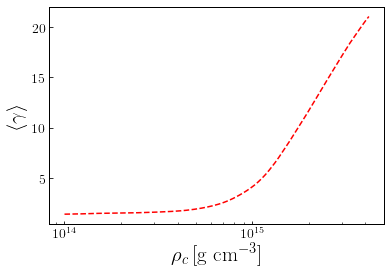

In [144]:
fig, ax = plt.subplots()
plt.plot(rhosc,gamma_crs,lw='1.5',color='r',linestyle='--',label=r'$\gamma_{cr}$')
#plt.plot(rhosc,gamma_efs,lw='2.0',color='blue',label=r'$\langle \gamma \rangle$')

plt.xlabel(r'$\rho_c\,[$g cm$^{-3}]$')
plt.ylabel(r'$\langle \gamma \rangle$')

plt.xscale('log')
#plt.xlim(left=10**(14.7),right=10**(16.7))
#plt.ylim(0,4)
ax.tick_params(axis="x", direction="in",which='both')
ax.tick_params(axis="y", direction="in",which='both')
#l = plt.legend(bbox_to_anchor=(0.85,-0.15), loc="lower right", 
                #bbox_transform=fig.transFigure, ncol=2)



plt.savefig('figures/AdiabaticIndexrhocWFF1.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

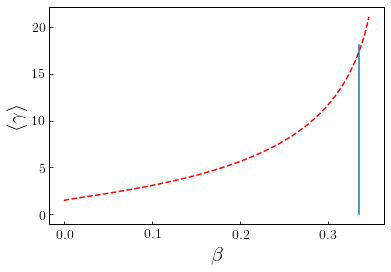

In [145]:
fig, ax = plt.subplots()
plt.plot(betas,gamma_crs,lw='1.5',color='r',linestyle='--',label=r'$\gamma_{cr}$')
plt.plot([betacrit,betacrit],[0,18])
#plt.plot(betas,gamma_efs,lw='2.0',color='blue',label=r'$\langle \gamma \rangle$')

plt.xlabel(r'$\beta$')
plt.ylabel(r'$\langle \gamma \rangle$')

#plt.xscale('log')
#plt.xlim(left=10**(14.7),right=10**(16.7))
#plt.ylim(0,10)
ax.tick_params(axis="x", direction="in",which='both')
ax.tick_params(axis="y", direction="in",which='both')
#l = plt.legend(bbox_to_anchor=(0.85,-0.15), loc="lower right", 
                #bbox_transform=fig.transFigure, ncol=2)



plt.savefig('figures/AdiabaticIndexWFF1beta.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

## M - $\rho_c$

In [123]:
Rwff1,Mwff1,rhocwff1=np.loadtxt('results/wff1/MRrhoc.dat',usecols=(0,1,2),unpack=True)

In [124]:
np.amax(Mwff1)

2.13410227199

In [138]:
betacrit = G*Msun*np.amax(Mwff1)/((c**2)*1e+5*Rwff1[np.argmax(Mwff1)])
betacrit

0.33470081766807896

In [126]:
rhocwff1[np.argmax(Mwff1)]

3019951720400000.0

In [281]:
np.log10(rhocwff1[np.argmax(Mwff1)])

15.47999999999971

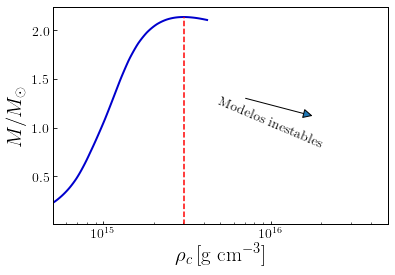

In [282]:
fig, ax = plt.subplots()

plt.plot(rhocwff1,Mwff1,color='mediumblue',lw='2.0')
plt.plot([10**(np.log10(rhocwff1[np.argmax(Mwff1)])),10**(np.log10(rhocwff1[np.argmax(Mwff1)]))],[0.0,np.amax(Mwff1)],'r--',lw='1.5')

prop = dict(arrowstyle="-|>,head_width=0.4,head_length=0.8",
            shrinkA=0,shrinkB=0)
plt.annotate("", xy=(10**(16.25),1.12), xytext=(10**(15.85),1.3), arrowprops=prop)
#plt.arrow(10**(15.6), 1.38,10**(15.7) ,-0.1 , head_width=0.05, head_lwff1th=10**(15))
plt.text(10**(15.67), 1.23, 'Modelos inestables' , fontsize=14,rotation=-23)

plt.xscale('log')
plt.xlabel(r'$\rho_c\,[$g cm$^{-3}]$')
plt.ylabel(r'$M/M_{\odot}$')
plt.xlim(left=10**(14.7),right=10**(16.7))
plt.ylim(bottom=0.01)
ax.tick_params(axis="x", direction="in",which='both')
ax.tick_params(axis="y", direction="in",which='both')

plt.savefig('figures/Mrhorel_wff1.pdf', format='pdf', dpi=1000,bbox_inches="tight")

## Tunning the interpolation of the solution

### 14.0

In [283]:
wff1_140=np.loadtxt('results/wff1/14.0.dat',unpack=True)
wff1_140[3] = wff1_140[3]-wff1_140[3][-1] + 0.5*np.log(1-2*wff1_140[0][-1]/wff1_140[-1][-1])

In [284]:
s1=5e-7
s2=1e-15
wff1_140rho=interpolate.UnivariateSpline(wff1_140[-1], wff1_140[2], k=5, s=s1)
wff1_140drho=interpolate.UnivariateSpline(wff1_140[-1], wff1_140[2], k=5, s=s1).derivative(n=1)
wff1_140ddrho=interpolate.UnivariateSpline(wff1_140[-1], wff1_140[2], k=5, s=s1).derivative(n=2)

wff1_140p=interpolate.UnivariateSpline(wff1_140[-1], wff1_140[1], k=5, s=s2)
wff1_140dp=interpolate.UnivariateSpline(wff1_140[-1], wff1_140[1], k=5, s=s2).derivative(n=1)
wff1_140ddp=interpolate.UnivariateSpline(wff1_140[-1], wff1_140[1], k=5, s=s2).derivative(n=2)

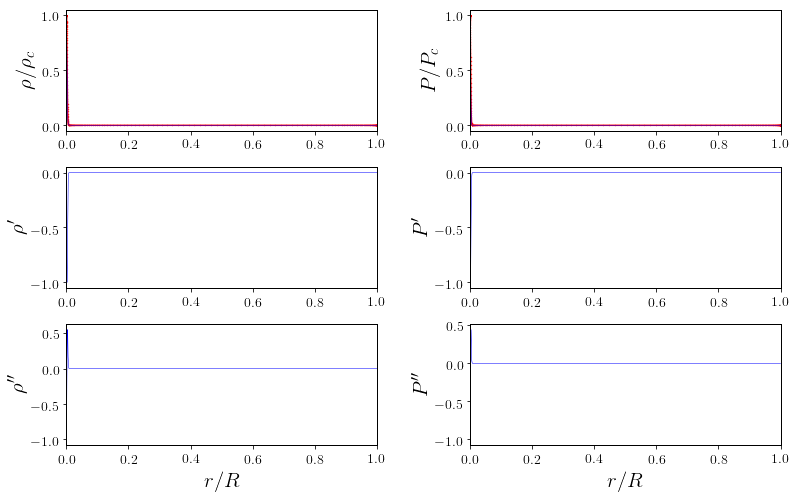

In [285]:
fig=plt.figure(figsize=[12.8,8])

plt.subplot(321)
plt.plot(wff1_140[-1]/wff1_140[-1][-1],wff1_140[2]/wff1_140[2][0],color='red',marker='o',markersize='0.4') 
plt.plot(wff1_140[-1]/wff1_140[-1][-1],wff1_140rho(wff1_140[-1])/wff1_140[2][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1) # leaving the crust out

plt.subplot(322)
plt.plot(wff1_140[-1]/wff1_140[-1][-1],wff1_140[1]/wff1_140[1][0],color='red',marker='o',markersize='0.4') 
plt.plot(wff1_140[-1]/wff1_140[-1][-1],wff1_140p(wff1_140[-1])/wff1_140[1][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$P/P_c$')
plt.xlim(0,1)

plt.subplot(323)
plt.plot(wff1_140[-1]/wff1_140[-1][-1],wff1_140drho(wff1_140[-1])/max(abs(wff1_140drho(wff1_140[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime}$')
plt.xlim(0,1)
#plt.ylim(-500,0)

plt.subplot(324)
plt.plot(wff1_140[-1]/wff1_140[-1][-1],wff1_140dp(wff1_140[-1])/max(abs(wff1_140dp(wff1_140[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime} $')
plt.xlim(0,1)

plt.subplot(325)
plt.plot(wff1_140[-1]/wff1_140[-1][-1],wff1_140ddrho(wff1_140[-1])/max(abs(wff1_140ddrho(wff1_140[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}$')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-0.01,0.01)

plt.subplot(326)
plt.plot(wff1_140[-1]/wff1_140[-1][-1],wff1_140ddp(wff1_140[-1])/max(abs(wff1_140ddp(wff1_140[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime\prime}$ ')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-1,1)

fig.subplots_adjust(hspace=0.3,wspace=0.3)

#plt.savefig('figures/ddswff1_140.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

### 14.5

In [286]:
wff1_145=np.loadtxt('results/wff1/14.5.dat',unpack=True)
wff1_145[3] = wff1_145[3]-wff1_145[3][-1] + 0.5*np.log(1-2*wff1_145[0][-1]/wff1_145[-1][-1])

In [287]:
s1=1e-7
s2=1e-12
wff1_145rho=interpolate.UnivariateSpline(wff1_145[-1], wff1_145[2], k=5, s=s1)
wff1_145drho=interpolate.UnivariateSpline(wff1_145[-1], wff1_145[2], k=5, s=s1).derivative(n=1)
wff1_145ddrho=interpolate.UnivariateSpline(wff1_145[-1], wff1_145[2], k=5, s=s1).derivative(n=2)

wff1_145p=interpolate.UnivariateSpline(wff1_145[-1], wff1_145[1], k=5, s=s2)
wff1_145dp=interpolate.UnivariateSpline(wff1_145[-1], wff1_145[1], k=5, s=s2).derivative(n=1)
wff1_145ddp=interpolate.UnivariateSpline(wff1_145[-1], wff1_145[1], k=5, s=s2).derivative(n=2)

In [288]:
wff1_145rho(0.4*wff1_145[-1][-1])*rhodim

1178265792981.426

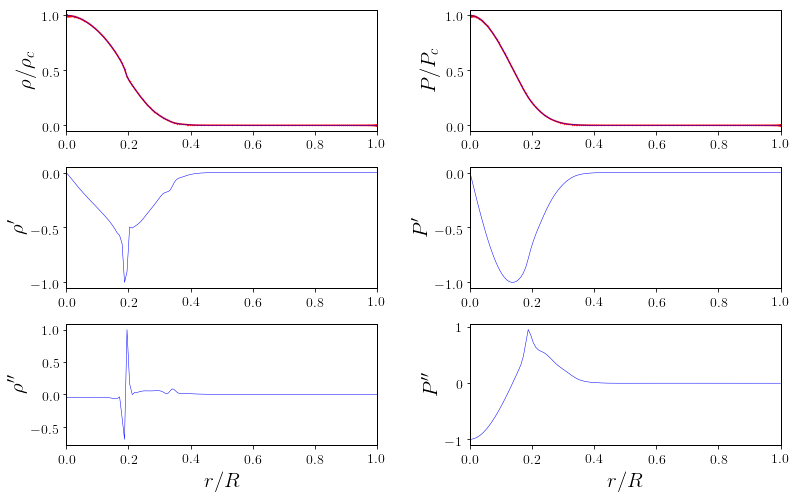

In [289]:
fig=plt.figure(figsize=[12.8,8])

plt.subplot(321)
plt.plot(wff1_145[-1]/wff1_145[-1][-1],wff1_145[2]/wff1_145[2][0],color='red',marker='o',markersize='0.4') 
plt.plot(wff1_145[-1]/wff1_145[-1][-1],wff1_145rho(wff1_145[-1])/wff1_145[2][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1) # leaving the crust out

plt.subplot(322)
plt.plot(wff1_145[-1]/wff1_145[-1][-1],wff1_145[1]/wff1_145[1][0],color='red',marker='o',markersize='0.4') 
plt.plot(wff1_145[-1]/wff1_145[-1][-1],wff1_145p(wff1_145[-1])/wff1_145[1][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$P/P_c$')
plt.xlim(0,1)

plt.subplot(323)
plt.plot(wff1_145[-1]/wff1_145[-1][-1],wff1_145drho(wff1_145[-1])/max(abs(wff1_145drho(wff1_145[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime}$')
plt.xlim(0,1)
#plt.ylim(-500,0)

plt.subplot(324)
plt.plot(wff1_145[-1]/wff1_145[-1][-1],wff1_145dp(wff1_145[-1])/max(abs(wff1_145dp(wff1_145[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime} $')
plt.xlim(0,1)

plt.subplot(325)
plt.plot(wff1_145[-1]/wff1_145[-1][-1],wff1_145ddrho(wff1_145[-1])/max(abs(wff1_145ddrho(wff1_145[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}$')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-0.01,0.01)

plt.subplot(326)
plt.plot(wff1_145[-1]/wff1_145[-1][-1],wff1_145ddp(wff1_145[-1])/max(abs(wff1_145ddp(wff1_145[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime\prime}$ ')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-1,1)

fig.subplots_adjust(hspace=0.3,wspace=0.3)

#plt.savefig('figures/ddswff1_145.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

### 15.0

In [290]:
wff1_150=np.loadtxt('results/wff1/15.0.dat',unpack=True)
wff1_150[3] = wff1_150[3]-wff1_150[3][-1] + 0.5*np.log(1-2*wff1_150[0][-1]/wff1_150[-1][-1])

In [291]:
s1=8e-6
s2=1e-15
wff1_150rho=interpolate.UnivariateSpline(wff1_150[-1], wff1_150[2], k=5, s=s1)
wff1_150drho=interpolate.UnivariateSpline(wff1_150[-1], wff1_150[2], k=5, s=s1).derivative(n=1)
wff1_150ddrho=interpolate.UnivariateSpline(wff1_150[-1], wff1_150[2], k=5, s=s1).derivative(n=2)

wff1_150p=interpolate.UnivariateSpline(wff1_150[-1], wff1_150[1], k=5, s=s2)
wff1_150dp=interpolate.UnivariateSpline(wff1_150[-1], wff1_150[1], k=5, s=s2).derivative(n=1)
wff1_150ddp=interpolate.UnivariateSpline(wff1_150[-1], wff1_150[1], k=5, s=s2).derivative(n=2)

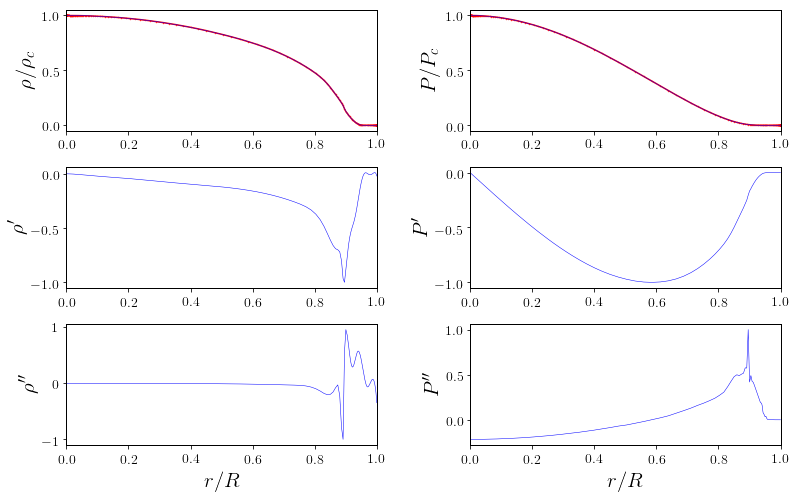

In [292]:
fig=plt.figure(figsize=[12.8,8])

plt.subplot(321)
plt.plot(wff1_150[-1]/wff1_150[-1][-1],wff1_150[2]/wff1_150[2][0],color='red',marker='o',markersize='0.4') 
plt.plot(wff1_150[-1]/wff1_150[-1][-1],wff1_150rho(wff1_150[-1])/wff1_150[2][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1) # leaving the crust out

plt.subplot(322)
plt.plot(wff1_150[-1]/wff1_150[-1][-1],wff1_150[1]/wff1_150[1][0],color='red',marker='o',markersize='0.4') 
plt.plot(wff1_150[-1]/wff1_150[-1][-1],wff1_150p(wff1_150[-1])/wff1_150[1][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$P/P_c$')
plt.xlim(0,1)

plt.subplot(323)
plt.plot(wff1_150[-1]/wff1_150[-1][-1],wff1_150drho(wff1_150[-1])/max(abs(wff1_150drho(wff1_150[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime}$')
plt.xlim(0,1)
#plt.ylim(-500,0)

plt.subplot(324)
plt.plot(wff1_150[-1]/wff1_150[-1][-1],wff1_150dp(wff1_150[-1])/max(abs(wff1_150dp(wff1_150[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime} $')
plt.xlim(0,1)

plt.subplot(325)
plt.plot(wff1_150[-1]/wff1_150[-1][-1],wff1_150ddrho(wff1_150[-1])/max(abs(wff1_150ddrho(wff1_150[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}$')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-0.01,0.01)

plt.subplot(326)
plt.plot(wff1_150[-1]/wff1_150[-1][-1],wff1_150ddp(wff1_150[-1])/max(abs(wff1_150ddp(wff1_150[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime\prime}$ ')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-1,1)

fig.subplots_adjust(hspace=0.3,wspace=0.3)

#plt.savefig('figures/ddswff1_150.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

### 15.5

In [293]:
wff1_155=np.loadtxt('results/wff1/15.5.dat',unpack=True)
wff1_155[3] = wff1_155[3]-wff1_155[3][-1] + 0.5*np.log(1-2*wff1_155[0][-1]/wff1_155[-1][-1])

In [294]:
s1=1e-5
s2=1e-9
wff1_155rho=interpolate.UnivariateSpline(wff1_155[-1], wff1_155[2], k=5, s=s1)
wff1_155drho=interpolate.UnivariateSpline(wff1_155[-1], wff1_155[2], k=5, s=s1).derivative(n=1)
wff1_155ddrho=interpolate.UnivariateSpline(wff1_155[-1], wff1_155[2], k=5, s=s1).derivative(n=2)

wff1_155p=interpolate.UnivariateSpline(wff1_155[-1], wff1_155[1], k=5, s=s2)
wff1_155dp=interpolate.UnivariateSpline(wff1_155[-1], wff1_155[1], k=5, s=s2).derivative(n=1)
wff1_155ddp=interpolate.UnivariateSpline(wff1_155[-1], wff1_155[1], k=5, s=s2).derivative(n=2)

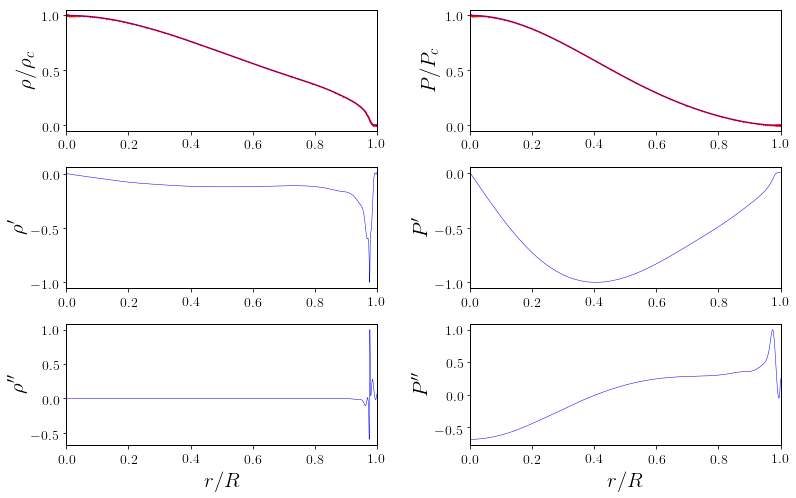

In [295]:
fig=plt.figure(figsize=[12.8,8])

plt.subplot(321)
plt.plot(wff1_155[-1]/wff1_155[-1][-1],wff1_155[2]/wff1_155[2][0],color='red',marker='o',markersize='0.4') 
plt.plot(wff1_155[-1]/wff1_155[-1][-1],wff1_155rho(wff1_155[-1])/wff1_155[2][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1) # leaving the crust out

plt.subplot(322)
plt.plot(wff1_155[-1]/wff1_155[-1][-1],wff1_155[1]/wff1_155[1][0],color='red',marker='o',markersize='0.4') 
plt.plot(wff1_155[-1]/wff1_155[-1][-1],wff1_155p(wff1_155[-1])/wff1_155[1][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$P/P_c$')
plt.xlim(0,1)

plt.subplot(323)
plt.plot(wff1_155[-1]/wff1_155[-1][-1],wff1_155drho(wff1_155[-1])/max(abs(wff1_155drho(wff1_155[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime}$')
plt.xlim(0,1)
#plt.ylim(-500,0)

plt.subplot(324)
plt.plot(wff1_155[-1]/wff1_155[-1][-1],wff1_155dp(wff1_155[-1])/max(abs(wff1_155dp(wff1_155[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime} $')
plt.xlim(0,1)

plt.subplot(325)
plt.plot(wff1_155[-1]/wff1_155[-1][-1],wff1_155ddrho(wff1_155[-1])/max(abs(wff1_155ddrho(wff1_155[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}$')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-0.01,0.01)

plt.subplot(326)
plt.plot(wff1_155[-1]/wff1_155[-1][-1],wff1_155ddp(wff1_155[-1])/max(abs(wff1_155ddp(wff1_155[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime\prime}$ ')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-1,1)

fig.subplots_adjust(hspace=0.3,wspace=0.3)

#plt.savefig('figures/ddswff1_155.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

## Redshift

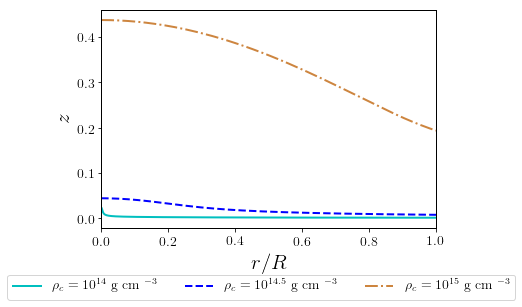

In [296]:
fig = plt.figure()

plt.plot(wff1_140[-1]/wff1_140[-1][-1],np.exp(-wff1_140[3])-1.0,color='c',linewidth='2.0',label=r'$\rho_c=10^{14}$ g cm $^{-3}$')
plt.plot(wff1_145[-1]/wff1_145[-1][-1],np.exp(-wff1_145[3])-1.0,color='blue',linewidth='2.0',linestyle='--',label=r'$\rho_c=10^{14.5}$ g cm $^{-3}$')
plt.plot(wff1_150[-1]/wff1_150[-1][-1],np.exp(-wff1_150[3])-1.0,color='peru',linewidth='2.0',linestyle='-.',label=r'$\rho_c=10^{15}$ g cm $^{-3}$')

l = plt.legend(bbox_to_anchor=(1.1,-0.15), loc="lower right", 
                bbox_transform=fig.transFigure, ncol=3)

plt.xlabel(r'$r/R$')
plt.ylabel(r'$z$')
plt.xlim(0,1.0)

plt.savefig('figures/Redshiftwff1.pdf', format='pdf', dpi=1000,bbox_inches="tight")

# WFF2 ---------------------------------------------------------------------------------------

In [297]:
rhowff2,Pwff2,nwff2=np.loadtxt('EOS/wff2.dat',usecols=(2,1,0),unpack=True)

## Dominant energy condition

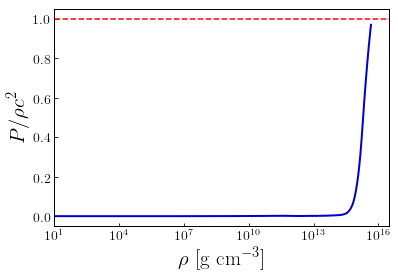

<Figure size 432x288 with 0 Axes>

In [298]:
fig, ax = plt.subplots()
plt.plot(rhowff2,np.divide(Pwff2,rhowff2),lw='2',color='mediumblue')
plt.plot([0,10**(17)],[1.0,1.0],'r--',lw='1.5')

ax.set_xscale("log")
#locmaj = matplotlib.ticker.LogLocator(base=10.0,numticks=16) 
#ax.xaxis.set_major_locator(locmaj)


plt.xlabel(r'$\rho$ [g\,\,cm$^{-3}$]')
plt.ylabel(r'$ P / \rho c^2 $')
#locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks=16)
#ax.xaxis.set_minor_locator(locmin)
#ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.tick_params(axis="x", direction="in")
ax.tick_params(axis="y", direction="in")
plt.xlim(10,10**(16.5))
#ax.set_facecolor('floralwhite')
#plt.gca().set_aspect('equal', adjustable='box')
#plt.draw()
#plt.ylim(0,1)
plt.savefig('figures/ECwff2.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()
plt.clf()

## Speed of sound

In [299]:
vsquared=interpolate.UnivariateSpline(rhowff2, Pwff2, k=1, s=0).derivative(n=1)

/home/dave/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  


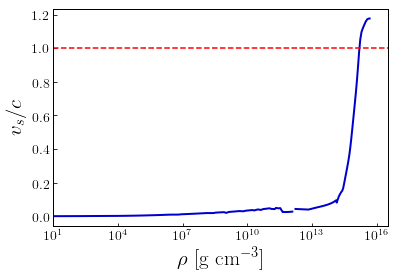

In [300]:
fig, ax = plt.subplots()
plt.plot(rhowff2,np.sqrt(vsquared(rhowff2)),lw='2.0',color='mediumblue')
plt.plot([1e+1,10**(16.5)],[1.0,1.0],'r--',lw='1.5')
plt.xlabel(r'$\rho$ [g\,\,cm$^{-3}$]')
plt.ylabel(r'$ v_s / c $')
plt.xscale('log')
ax.tick_params(axis="x", direction="in")
ax.tick_params(axis="y", direction="in")
plt.xlim(10,10**(16.5))
#ax.set_facecolor('floralwhite')
#mpl.rcParams['axes.linewidth'] = 1.4
#plt.gca().set_aspect('equal', adjustable='box')
#plt.draw()
plt.savefig('figures/SSwff2.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

## Adiabatic Index

In [301]:
Gamma=np.multiply(np.divide(np.add(rhowff2,Pwff2),Pwff2),vsquared(rhowff2))

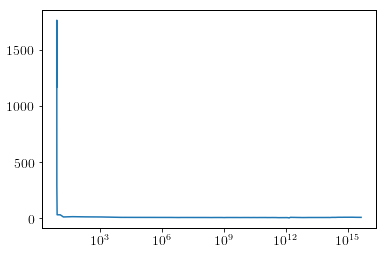

In [302]:
plt.plot(rhowff2,Gamma)
plt.xscale('log')

$$ \langle\gamma\rangle=\frac{\int_{0}^{R} e^{(\lambda+3 \nu) } \gamma(r) P(r) r^{2} d r}{\int_{0}^{R} e^{(\lambda+3 \nu) } P(r) r^{2} d r} $$

Listing all the models calculated

In [303]:
owd=os.getcwd()
path=os.chdir('results/wff2')
listOfEntries= os.scandir(path)
models_wff2 = []
for entry in listOfEntries:
    if '1' in entry.name:
        models_wff2.append(entry.name)
os.chdir(owd)
models_wff2.sort()

In [304]:
gamma_efs1 = []
gamma_efs2 = []
gamma_crs1 = []
gamma_crs2 = []
rhosc= []
for model in models_wff2:
    m, P, rho, nu, lambd, r = np.loadtxt('results/wff2/' + model ,unpack=True)
    nu = nu - nu[-1] + 0.5*np.log(1-2*m[-1]/r[-1])
    #lambd = np.zeros_like(r)
    #for i in range((r.shape)[0]):
    #    if i==0:
    #        lambd[i] = 0
    #    else:
    #        lambd[i] = 0.5*np.log(1/(1-2*m[i]/r[i]))
    drho=interpolate.UnivariateSpline(r, rho, k=5, s=0).derivative(n=1)
    dP=interpolate.UnivariateSpline(r, P, k=5, s=0).derivative(n=1)
    gamma = np.divide(dP(r),drho(r))
    gamma_ef1 = integrate.trapz(np.exp(lambd+3*nu)*gamma*P*(r**2),r)/integrate.trapz(np.exp(lambd+3*nu)*P*(r**2),r)
    t1 = (1/36)*integrate.trapz(np.exp((lambd+3*nu))*(16*P+(np.exp(2*lambd)-1)*(P+rho))*(np.exp(2*lambd)-1)*(r**2))/integrate.trapz(np.exp(lambd+3*nu)*P*(r**2),r)
    t2 = (4*np.pi/9)*integrate.trapz(np.exp(3*lambd+3*nu)*(8*P + (np.exp(2*lambd)+1)*(P+rho))*P*(r**4),r)/integrate.trapz(np.exp(lambd+3*nu)*P*(r**2),r)
    t3 = ((16*np.pi**2)/9)*integrate.trapz(np.exp(5*lambd+3*nu)*(P+rho)*(P**2)*(r**6),r)/integrate.trapz(np.exp(lambd+3*nu)*P*(r**2),r)
    gamma_cr1 = 4/3 + t1 + t2 + t3
    gamma_efs1.append(gamma_ef1)
    gamma_crs1.append(gamma_cr1)
    gamma_ef2 = integrate.trapz(gamma*P*r**2,r)/integrate.trapz(P*r**2,r)
    gamma_cr2 = 4/3 + (19/42)*2*m[-1]/r[-1]
    gamma_efs2.append(gamma_ef2)
    gamma_crs2.append(gamma_cr2)
    rhosc.append(rho[0]*rhodim)

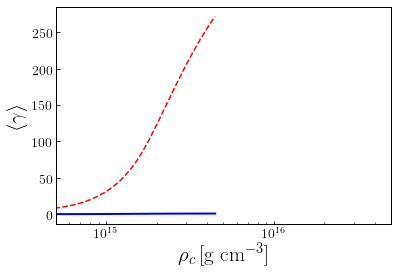

In [305]:
fig, ax = plt.subplots()
plt.plot(rhosc,gamma_crs1,lw='1.5',color='r',linestyle='--',label=r'$\gamma_{cr}$')
plt.plot(rhosc,gamma_efs1,lw='2.0',color='blue',label=r'$\langle \gamma \rangle$')

plt.xlabel(r'$\rho_c\,[$g cm$^{-3}]$')
plt.ylabel(r'$\langle \gamma \rangle$')

plt.xscale('log')
plt.xlim(left=10**(14.7),right=10**(16.7))
#plt.ylim(0,10)
ax.tick_params(axis="x", direction="in",which='both')
ax.tick_params(axis="y", direction="in",which='both')
#l = plt.legend(bbox_to_anchor=(0.85,-0.15), loc="lower right", 
                #bbox_transform=fig.transFigure, ncol=2)



plt.savefig('figures/AdiabaticIndexwff2.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

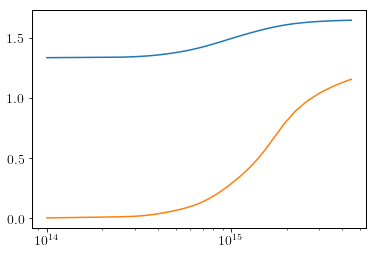

In [306]:
plt.plot(rhosc,gamma_crs2)
plt.plot(rhosc,gamma_efs2)
plt.xscale('log')

## M - $\rho_c$

In [307]:
Rwff2,Mwff2,rhocwff2=np.loadtxt('results/wff2/MRrhoc.dat',usecols=(0,1,2),unpack=True)

In [308]:
np.amax(Mwff2)

2.19859246631

In [309]:
rhocwff2[np.argmax(Mwff2)]

2818382931260000.0

In [310]:
np.log10(rhocwff2[np.argmax(Mwff2)])

15.449999999999314

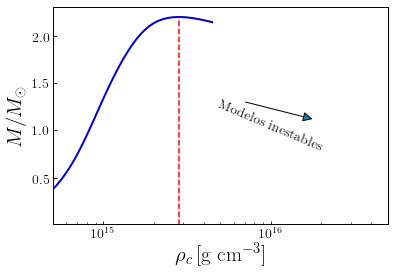

In [311]:
fig, ax = plt.subplots()

plt.plot(rhocwff2,Mwff2,color='mediumblue',lw='2.0')
plt.plot([10**(np.log10(rhocwff2[np.argmax(Mwff2)])),10**(np.log10(rhocwff2[np.argmax(Mwff2)]))],[0.0,np.amax(Mwff2)],'r--',lw='1.5')

prop = dict(arrowstyle="-|>,head_width=0.4,head_length=0.8",
            shrinkA=0,shrinkB=0)
plt.annotate("", xy=(10**(16.25),1.12), xytext=(10**(15.85),1.3), arrowprops=prop)
#plt.arrow(10**(15.6), 1.38,10**(15.7) ,-0.1 , head_width=0.05, head_lwff2th=10**(15))
plt.text(10**(15.67), 1.23, 'Modelos inestables' , fontsize=14,rotation=-23)

plt.xscale('log')
plt.xlabel(r'$\rho_c\,[$g cm$^{-3}]$')
plt.ylabel(r'$M/M_{\odot}$')
plt.xlim(left=10**(14.7),right=10**(16.7))
plt.ylim(bottom=0.01)
ax.tick_params(axis="x", direction="in",which='both')
ax.tick_params(axis="y", direction="in",which='both')

plt.savefig('figures/Mrhorel_wff2.pdf', format='pdf', dpi=1000,bbox_inches="tight")

## Tunning the interpolation of the solution

### 14.0

In [312]:
wff2_140=np.loadtxt('results/wff2/14.0.dat',unpack=True)
wff2_140[3] = wff2_140[3]-wff2_140[3][-1] + 0.5*np.log(1-2*wff2_140[0][-1]/wff2_140[-1][-1])

In [313]:
s1=5e-7
s2=1e-15
wff2_140rho=interpolate.UnivariateSpline(wff2_140[-1], wff2_140[2], k=5, s=s1)
wff2_140drho=interpolate.UnivariateSpline(wff2_140[-1], wff2_140[2], k=5, s=s1).derivative(n=1)
wff2_140ddrho=interpolate.UnivariateSpline(wff2_140[-1], wff2_140[2], k=5, s=s1).derivative(n=2)

wff2_140p=interpolate.UnivariateSpline(wff2_140[-1], wff2_140[1], k=5, s=s2)
wff2_140dp=interpolate.UnivariateSpline(wff2_140[-1], wff2_140[1], k=5, s=s2).derivative(n=1)
wff2_140ddp=interpolate.UnivariateSpline(wff2_140[-1], wff2_140[1], k=5, s=s2).derivative(n=2)

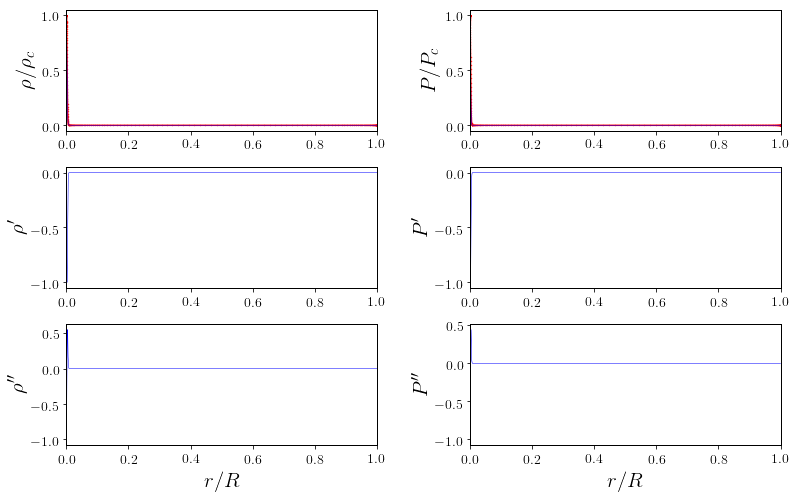

In [314]:
fig=plt.figure(figsize=[12.8,8])

plt.subplot(321)
plt.plot(wff2_140[-1]/wff2_140[-1][-1],wff2_140[2]/wff2_140[2][0],color='red',marker='o',markersize='0.4') 
plt.plot(wff2_140[-1]/wff2_140[-1][-1],wff2_140rho(wff2_140[-1])/wff2_140[2][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1) # leaving the crust out

plt.subplot(322)
plt.plot(wff2_140[-1]/wff2_140[-1][-1],wff2_140[1]/wff2_140[1][0],color='red',marker='o',markersize='0.4') 
plt.plot(wff2_140[-1]/wff2_140[-1][-1],wff2_140p(wff2_140[-1])/wff2_140[1][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$P/P_c$')
plt.xlim(0,1)

plt.subplot(323)
plt.plot(wff2_140[-1]/wff2_140[-1][-1],wff2_140drho(wff2_140[-1])/max(abs(wff2_140drho(wff2_140[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime}$')
plt.xlim(0,1)
#plt.ylim(-500,0)

plt.subplot(324)
plt.plot(wff2_140[-1]/wff2_140[-1][-1],wff2_140dp(wff2_140[-1])/max(abs(wff2_140dp(wff2_140[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime} $')
plt.xlim(0,1)

plt.subplot(325)
plt.plot(wff2_140[-1]/wff2_140[-1][-1],wff2_140ddrho(wff2_140[-1])/max(abs(wff2_140ddrho(wff2_140[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}$')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-0.01,0.01)

plt.subplot(326)
plt.plot(wff2_140[-1]/wff2_140[-1][-1],wff2_140ddp(wff2_140[-1])/max(abs(wff2_140ddp(wff2_140[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime\prime}$ ')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-1,1)

fig.subplots_adjust(hspace=0.3,wspace=0.3)

#plt.savefig('figures/ddswff2_140.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

### 14.5

In [315]:
wff2_145=np.loadtxt('results/wff2/14.5.dat',unpack=True)
wff2_145[3] = wff2_145[3]-wff2_145[3][-1] + 0.5*np.log(1-2*wff2_145[0][-1]/wff2_145[-1][-1])

In [316]:
s1=1e-7
s2=1e-12
wff2_145rho=interpolate.UnivariateSpline(wff2_145[-1], wff2_145[2], k=5, s=s1)
wff2_145drho=interpolate.UnivariateSpline(wff2_145[-1], wff2_145[2], k=5, s=s1).derivative(n=1)
wff2_145ddrho=interpolate.UnivariateSpline(wff2_145[-1], wff2_145[2], k=5, s=s1).derivative(n=2)

wff2_145p=interpolate.UnivariateSpline(wff2_145[-1], wff2_145[1], k=5, s=s2)
wff2_145dp=interpolate.UnivariateSpline(wff2_145[-1], wff2_145[1], k=5, s=s2).derivative(n=1)
wff2_145ddp=interpolate.UnivariateSpline(wff2_145[-1], wff2_145[1], k=5, s=s2).derivative(n=2)

In [317]:
wff2_145rho(0.4*wff2_145[-1][-1])*rhodim

45479102351745.05

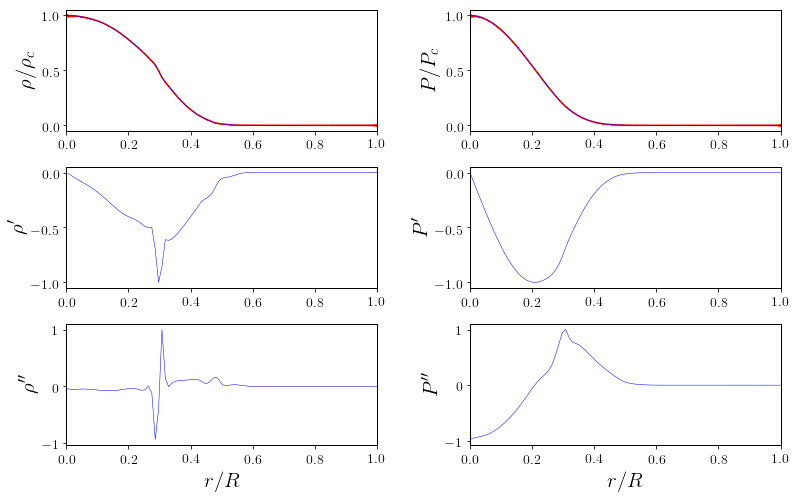

In [318]:
fig=plt.figure(figsize=[12.8,8])

plt.subplot(321)
plt.plot(wff2_145[-1]/wff2_145[-1][-1],wff2_145[2]/wff2_145[2][0],color='red',marker='o',markersize='0.4') 
plt.plot(wff2_145[-1]/wff2_145[-1][-1],wff2_145rho(wff2_145[-1])/wff2_145[2][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1) # leaving the crust out

plt.subplot(322)
plt.plot(wff2_145[-1]/wff2_145[-1][-1],wff2_145[1]/wff2_145[1][0],color='red',marker='o',markersize='0.4') 
plt.plot(wff2_145[-1]/wff2_145[-1][-1],wff2_145p(wff2_145[-1])/wff2_145[1][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$P/P_c$')
plt.xlim(0,1)

plt.subplot(323)
plt.plot(wff2_145[-1]/wff2_145[-1][-1],wff2_145drho(wff2_145[-1])/max(abs(wff2_145drho(wff2_145[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime}$')
plt.xlim(0,1)
#plt.ylim(-500,0)

plt.subplot(324)
plt.plot(wff2_145[-1]/wff2_145[-1][-1],wff2_145dp(wff2_145[-1])/max(abs(wff2_145dp(wff2_145[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime} $')
plt.xlim(0,1)

plt.subplot(325)
plt.plot(wff2_145[-1]/wff2_145[-1][-1],wff2_145ddrho(wff2_145[-1])/max(abs(wff2_145ddrho(wff2_145[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}$')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-0.01,0.01)

plt.subplot(326)
plt.plot(wff2_145[-1]/wff2_145[-1][-1],wff2_145ddp(wff2_145[-1])/max(abs(wff2_145ddp(wff2_145[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime\prime}$ ')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-1,1)

fig.subplots_adjust(hspace=0.3,wspace=0.3)

#plt.savefig('figures/ddswff2_145.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

### 15.0

In [319]:
wff2_150=np.loadtxt('results/wff2/15.0.dat',unpack=True)
wff2_150[3] = wff2_150[3]-wff2_150[3][-1] + 0.5*np.log(1-2*wff2_150[0][-1]/wff2_150[-1][-1])

In [320]:
s1=8e-6
s2=1e-15
wff2_150rho=interpolate.UnivariateSpline(wff2_150[-1], wff2_150[2], k=5, s=s1)
wff2_150drho=interpolate.UnivariateSpline(wff2_150[-1], wff2_150[2], k=5, s=s1).derivative(n=1)
wff2_150ddrho=interpolate.UnivariateSpline(wff2_150[-1], wff2_150[2], k=5, s=s1).derivative(n=2)

wff2_150p=interpolate.UnivariateSpline(wff2_150[-1], wff2_150[1], k=5, s=s2)
wff2_150dp=interpolate.UnivariateSpline(wff2_150[-1], wff2_150[1], k=5, s=s2).derivative(n=1)
wff2_150ddp=interpolate.UnivariateSpline(wff2_150[-1], wff2_150[1], k=5, s=s2).derivative(n=2)

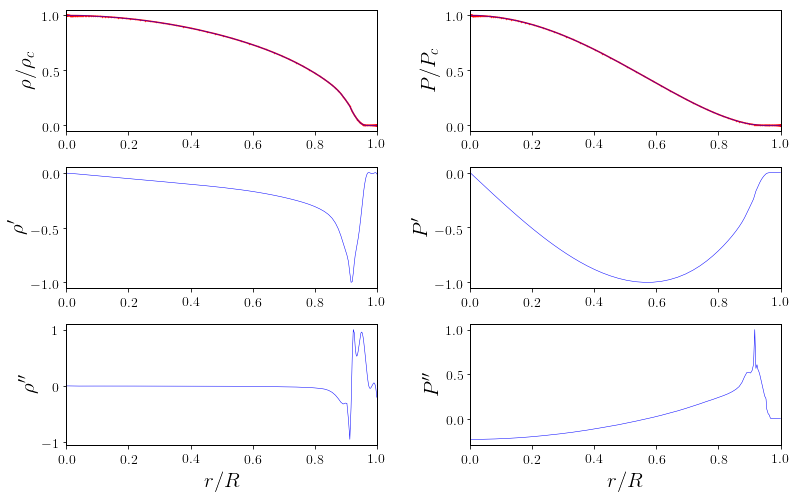

In [321]:
fig=plt.figure(figsize=[12.8,8])

plt.subplot(321)
plt.plot(wff2_150[-1]/wff2_150[-1][-1],wff2_150[2]/wff2_150[2][0],color='red',marker='o',markersize='0.4') 
plt.plot(wff2_150[-1]/wff2_150[-1][-1],wff2_150rho(wff2_150[-1])/wff2_150[2][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1) # leaving the crust out

plt.subplot(322)
plt.plot(wff2_150[-1]/wff2_150[-1][-1],wff2_150[1]/wff2_150[1][0],color='red',marker='o',markersize='0.4') 
plt.plot(wff2_150[-1]/wff2_150[-1][-1],wff2_150p(wff2_150[-1])/wff2_150[1][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$P/P_c$')
plt.xlim(0,1)

plt.subplot(323)
plt.plot(wff2_150[-1]/wff2_150[-1][-1],wff2_150drho(wff2_150[-1])/max(abs(wff2_150drho(wff2_150[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime}$')
plt.xlim(0,1)
#plt.ylim(-500,0)

plt.subplot(324)
plt.plot(wff2_150[-1]/wff2_150[-1][-1],wff2_150dp(wff2_150[-1])/max(abs(wff2_150dp(wff2_150[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime} $')
plt.xlim(0,1)

plt.subplot(325)
plt.plot(wff2_150[-1]/wff2_150[-1][-1],wff2_150ddrho(wff2_150[-1])/max(abs(wff2_150ddrho(wff2_150[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}$')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-0.01,0.01)

plt.subplot(326)
plt.plot(wff2_150[-1]/wff2_150[-1][-1],wff2_150ddp(wff2_150[-1])/max(abs(wff2_150ddp(wff2_150[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime\prime}$ ')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-1,1)

fig.subplots_adjust(hspace=0.3,wspace=0.3)

#plt.savefig('figures/ddswff2_150.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

### 15.5

In [322]:
wff2_155=np.loadtxt('results/wff2/15.5.dat',unpack=True)
wff2_155[3] = wff2_155[3]-wff2_155[3][-1] + 0.5*np.log(1-2*wff2_155[0][-1]/wff2_155[-1][-1])

In [323]:
s1=1e-5
s2=1e-9
wff2_155rho=interpolate.UnivariateSpline(wff2_155[-1], wff2_155[2], k=5, s=s1)
wff2_155drho=interpolate.UnivariateSpline(wff2_155[-1], wff2_155[2], k=5, s=s1).derivative(n=1)
wff2_155ddrho=interpolate.UnivariateSpline(wff2_155[-1], wff2_155[2], k=5, s=s1).derivative(n=2)

wff2_155p=interpolate.UnivariateSpline(wff2_155[-1], wff2_155[1], k=5, s=s2)
wff2_155dp=interpolate.UnivariateSpline(wff2_155[-1], wff2_155[1], k=5, s=s2).derivative(n=1)
wff2_155ddp=interpolate.UnivariateSpline(wff2_155[-1], wff2_155[1], k=5, s=s2).derivative(n=2)

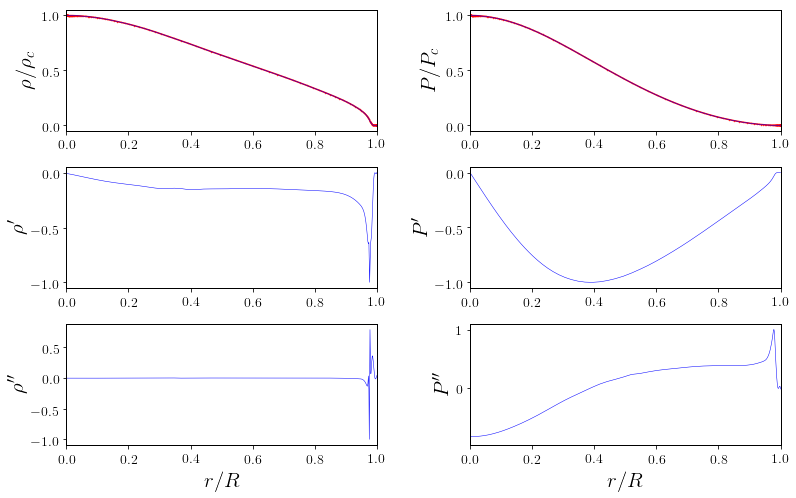

In [324]:
fig=plt.figure(figsize=[12.8,8])

plt.subplot(321)
plt.plot(wff2_155[-1]/wff2_155[-1][-1],wff2_155[2]/wff2_155[2][0],color='red',marker='o',markersize='0.4') 
plt.plot(wff2_155[-1]/wff2_155[-1][-1],wff2_155rho(wff2_155[-1])/wff2_155[2][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1) # leaving the crust out

plt.subplot(322)
plt.plot(wff2_155[-1]/wff2_155[-1][-1],wff2_155[1]/wff2_155[1][0],color='red',marker='o',markersize='0.4') 
plt.plot(wff2_155[-1]/wff2_155[-1][-1],wff2_155p(wff2_155[-1])/wff2_155[1][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$P/P_c$')
plt.xlim(0,1)

plt.subplot(323)
plt.plot(wff2_155[-1]/wff2_155[-1][-1],wff2_155drho(wff2_155[-1])/max(abs(wff2_155drho(wff2_155[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime}$')
plt.xlim(0,1)
#plt.ylim(-500,0)

plt.subplot(324)
plt.plot(wff2_155[-1]/wff2_155[-1][-1],wff2_155dp(wff2_155[-1])/max(abs(wff2_155dp(wff2_155[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime} $')
plt.xlim(0,1)

plt.subplot(325)
plt.plot(wff2_155[-1]/wff2_155[-1][-1],wff2_155ddrho(wff2_155[-1])/max(abs(wff2_155ddrho(wff2_155[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}$')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-0.01,0.01)

plt.subplot(326)
plt.plot(wff2_155[-1]/wff2_155[-1][-1],wff2_155ddp(wff2_155[-1])/max(abs(wff2_155ddp(wff2_155[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime\prime}$ ')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-1,1)

fig.subplots_adjust(hspace=0.3,wspace=0.3)

#plt.savefig('figures/ddswff2_155.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

## Redshift

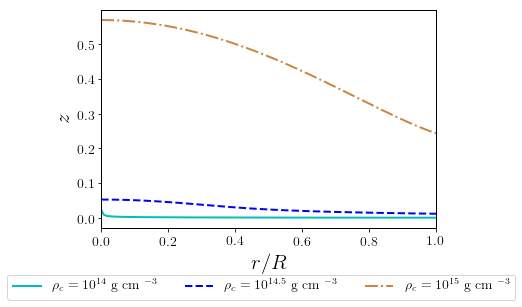

In [325]:
fig = plt.figure()

plt.plot(wff2_140[-1]/wff2_140[-1][-1],np.exp(-wff2_140[3])-1.0,color='c',linewidth='2.0',label=r'$\rho_c=10^{14}$ g cm $^{-3}$')
plt.plot(wff2_145[-1]/wff2_145[-1][-1],np.exp(-wff2_145[3])-1.0,color='blue',linewidth='2.0',linestyle='--',label=r'$\rho_c=10^{14.5}$ g cm $^{-3}$')
plt.plot(wff2_150[-1]/wff2_150[-1][-1],np.exp(-wff2_150[3])-1.0,color='peru',linewidth='2.0',linestyle='-.',label=r'$\rho_c=10^{15}$ g cm $^{-3}$')

l = plt.legend(bbox_to_anchor=(1.1,-0.15), loc="lower right", 
                bbox_transform=fig.transFigure, ncol=3)

plt.xlabel(r'$r/R$')
plt.ylabel(r'$z$')
plt.xlim(0,1.0)

plt.savefig('figures/Redshiftwff2.pdf', format='pdf', dpi=1000,bbox_inches="tight")

# WFF3 ---------------------------------------------------------------------------------------

In [27]:
rhowff3,Pwff3,nwff3=np.loadtxt('EOS/wff3.dat',usecols=(2,1,0),unpack=True)

## Dominant energy condition

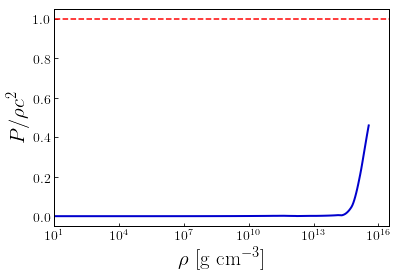

<Figure size 432x288 with 0 Axes>

In [28]:
fig, ax = plt.subplots()
plt.plot(rhowff3,np.divide(Pwff3,rhowff3),lw='2',color='mediumblue')
plt.plot([0,10**(17)],[1.0,1.0],'r--',lw='1.5')

ax.set_xscale("log")
#locmaj = matplotlib.ticker.LogLocator(base=10.0,numticks=16) 
#ax.xaxis.set_major_locator(locmaj)


plt.xlabel(r'$\rho$ [g\,\,cm$^{-3}$]')
plt.ylabel(r'$ P / \rho c^2 $')
#locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks=16)
#ax.xaxis.set_minor_locator(locmin)
#ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.tick_params(axis="x", direction="in")
ax.tick_params(axis="y", direction="in")
plt.xlim(10,10**(16.5))
#ax.set_facecolor('floralwhite')
#plt.gca().set_aspect('equal', adjustable='box')
#plt.draw()
#plt.ylim(0,1)
plt.savefig('figures/ECwff3.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()
plt.clf()

## Speed of sound

In [34]:
vsquared=interpolate.UnivariateSpline(rhowff3, Pwff3, k=1, s=1e-8).derivative(n=1)

/home/dave/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  


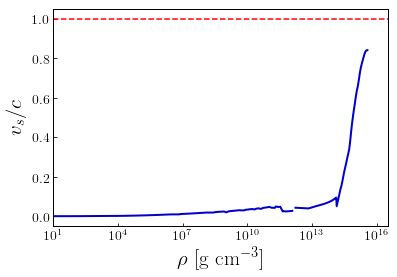

In [35]:
fig, ax = plt.subplots()
plt.plot(rhowff3,np.sqrt(vsquared(rhowff3)),lw='2.0',color='mediumblue')
plt.plot([1e+1,10**(16.5)],[1.0,1.0],'r--',lw='1.5')
plt.xlabel(r'$\rho$ [g\,\,cm$^{-3}$]')
plt.ylabel(r'$ v_s / c $')
plt.xscale('log')
ax.tick_params(axis="x", direction="in")
ax.tick_params(axis="y", direction="in")
plt.xlim(10,10**(16.5))
#ax.set_facecolor('floralwhite')
#mpl.rcParams['axes.linewidth'] = 1.4
#plt.gca().set_aspect('equal', adjustable='box')
#plt.draw()
plt.savefig('figures/SSwff3.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

## Adiabatic Index

In [36]:
Gamma=np.multiply(np.divide(np.add(rhowff3,Pwff3),Pwff3),vsquared(rhowff3))

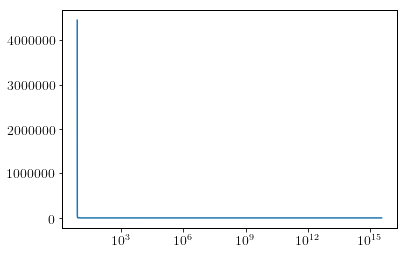

In [37]:
plt.plot(rhowff3,Gamma)
plt.xscale('log')

$$ \langle\gamma\rangle=\frac{\int_{0}^{R} e^{(\lambda+3 \nu) } \gamma(r) P(r) r^{2} d r}{\int_{0}^{R} e^{(\lambda+3 \nu) } P(r) r^{2} d r} $$

Listing all the models calculated

In [38]:
owd=os.getcwd()
path=os.chdir('results/wff3')
listOfEntries= os.scandir(path)
models_wff3 = []
for entry in listOfEntries:
    if '1' in entry.name:
        models_wff3.append(entry.name)
os.chdir(owd)
models_wff3.sort()

In [39]:
gamma_efs1 = []
gamma_efs2 = []
gamma_crs1 = []
gamma_crs2 = []
rhosc= []
for model in models_wff3:
    m, P, rho, nu, lambd, r = np.loadtxt('results/wff3/' + model ,unpack=True)
    nu = nu - nu[-1] + 0.5*np.log(1-2*m[-1]/r[-1])
    #lambd = np.zeros_like(r)
    #for i in range((r.shape)[0]):
    #    if i==0:
    #        lambd[i] = 0
    #    else:
    #        lambd[i] = 0.5*np.log(1/(1-2*m[i]/r[i]))
    drho=interpolate.UnivariateSpline(r, rho, k=5, s=0).derivative(n=1)
    dP=interpolate.UnivariateSpline(r, P, k=5, s=0).derivative(n=1)
    gamma = np.divide(dP(r),drho(r))
    gamma_ef1 = integrate.trapz(np.exp(lambd+3*nu)*gamma*P*(r**2),r)/integrate.trapz(np.exp(lambd+3*nu)*P*(r**2),r)
    t1 = (1/36)*integrate.trapz(np.exp((lambd+3*nu))*(16*P+(np.exp(2*lambd)-1)*(P+rho))*(np.exp(2*lambd)-1)*(r**2))/integrate.trapz(np.exp(lambd+3*nu)*P*(r**2),r)
    t2 = (4*np.pi/9)*integrate.trapz(np.exp(3*lambd+3*nu)*(8*P + (np.exp(2*lambd)+1)*(P+rho))*P*(r**4),r)/integrate.trapz(np.exp(lambd+3*nu)*P*(r**2),r)
    t3 = ((16*np.pi**2)/9)*integrate.trapz(np.exp(5*lambd+3*nu)*(P+rho)*(P**2)*(r**6),r)/integrate.trapz(np.exp(lambd+3*nu)*P*(r**2),r)
    gamma_cr1 = 4/3 + t1 + t2 + t3
    gamma_efs1.append(gamma_ef1)
    gamma_crs1.append(gamma_cr1)
    gamma_ef2 = integrate.trapz(gamma*P*r**2,r)/integrate.trapz(P*r**2,r)
    gamma_cr2 = 4/3 + (19/42)*2*m[-1]/r[-1]
    gamma_efs2.append(gamma_ef2)
    gamma_crs2.append(gamma_cr2)
    rhosc.append(rho[0]*rhodim)

ValueError: x must be strictly increasing

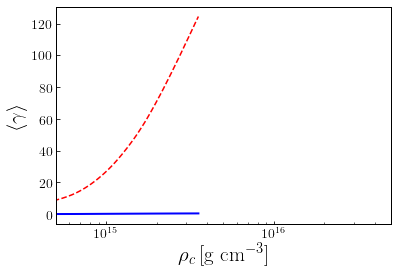

In [334]:
fig, ax = plt.subplots()
plt.plot(rhosc,gamma_crs1,lw='1.5',color='r',linestyle='--',label=r'$\gamma_{cr}$')
plt.plot(rhosc,gamma_efs1,lw='2.0',color='blue',label=r'$\langle \gamma \rangle$')

plt.xlabel(r'$\rho_c\,[$g cm$^{-3}]$')
plt.ylabel(r'$\langle \gamma \rangle$')

plt.xscale('log')
plt.xlim(left=10**(14.7),right=10**(16.7))
#plt.ylim(0,10)
ax.tick_params(axis="x", direction="in",which='both')
ax.tick_params(axis="y", direction="in",which='both')
#l = plt.legend(bbox_to_anchor=(0.85,-0.15), loc="lower right", 
                #bbox_transform=fig.transFigure, ncol=2)



plt.savefig('figures/AdiabaticIndexwff3.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

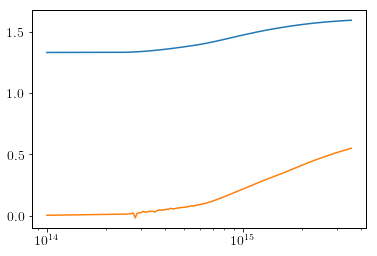

In [335]:
plt.plot(rhosc,gamma_crs2)
plt.plot(rhosc,gamma_efs2)
plt.xscale('log')

## M - $\rho_c$

In [336]:
Rwff3,Mwff3,rhocwff3=np.loadtxt('results/wff3/MRrhoc.dat',usecols=(0,1,2),unpack=True)

In [337]:
np.amax(Mwff3)

1.84476587351

In [338]:
rhocwff3[np.argmax(Mwff3)]

3162277660170000.0

In [339]:
np.log10(rhocwff3[np.argmax(Mwff3)])

15.500000000000222

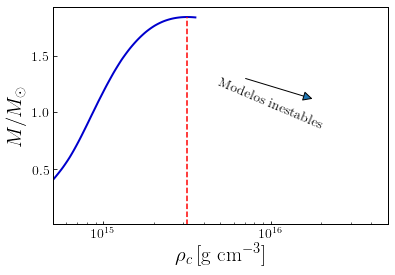

In [340]:
fig, ax = plt.subplots()

plt.plot(rhocwff3,Mwff3,color='mediumblue',lw='2.0')
plt.plot([10**(np.log10(rhocwff3[np.argmax(Mwff3)])),10**(np.log10(rhocwff3[np.argmax(Mwff3)]))],[0.0,np.amax(Mwff3)],'r--',lw='1.5')

prop = dict(arrowstyle="-|>,head_width=0.4,head_length=0.8",
            shrinkA=0,shrinkB=0)
plt.annotate("", xy=(10**(16.25),1.12), xytext=(10**(15.85),1.3), arrowprops=prop)
#plt.arrow(10**(15.6), 1.38,10**(15.7) ,-0.1 , head_width=0.05, head_lwff3th=10**(15))
plt.text(10**(15.67), 1.23, 'Modelos inestables' , fontsize=14,rotation=-23)

plt.xscale('log')
plt.xlabel(r'$\rho_c\,[$g cm$^{-3}]$')
plt.ylabel(r'$M/M_{\odot}$')
plt.xlim(left=10**(14.7),right=10**(16.7))
plt.ylim(bottom=0.01)
ax.tick_params(axis="x", direction="in",which='both')
ax.tick_params(axis="y", direction="in",which='both')

plt.savefig('figures/Mrhorel_wff3.pdf', format='pdf', dpi=1000,bbox_inches="tight")

## Tunning the interpolation of the solution

### 14.0

In [341]:
wff3_140=np.loadtxt('results/wff3/14.0.dat',unpack=True)
wff3_140[3] = wff3_140[3]-wff3_140[3][-1] + 0.5*np.log(1-2*wff3_140[0][-1]/wff3_140[-1][-1])

In [342]:
s1=5e-7
s2=1e-15
wff3_140rho=interpolate.UnivariateSpline(wff3_140[-1], wff3_140[2], k=5, s=s1)
wff3_140drho=interpolate.UnivariateSpline(wff3_140[-1], wff3_140[2], k=5, s=s1).derivative(n=1)
wff3_140ddrho=interpolate.UnivariateSpline(wff3_140[-1], wff3_140[2], k=5, s=s1).derivative(n=2)

wff3_140p=interpolate.UnivariateSpline(wff3_140[-1], wff3_140[1], k=5, s=s2)
wff3_140dp=interpolate.UnivariateSpline(wff3_140[-1], wff3_140[1], k=5, s=s2).derivative(n=1)
wff3_140ddp=interpolate.UnivariateSpline(wff3_140[-1], wff3_140[1], k=5, s=s2).derivative(n=2)

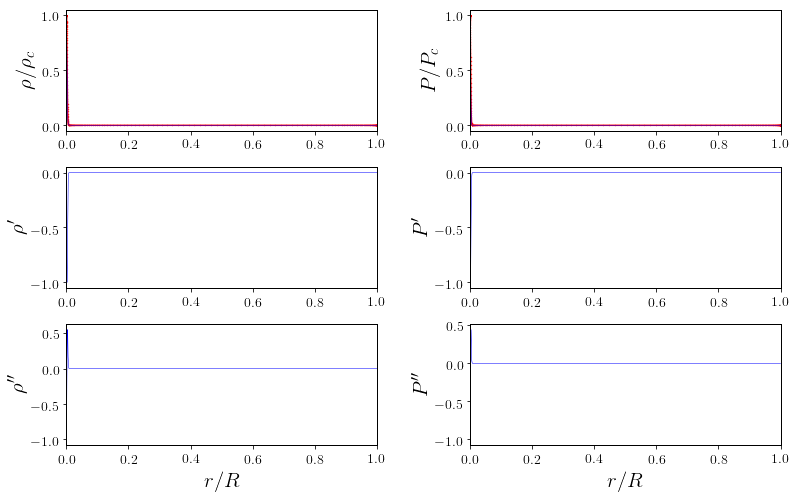

In [343]:
fig=plt.figure(figsize=[12.8,8])

plt.subplot(321)
plt.plot(wff3_140[-1]/wff3_140[-1][-1],wff3_140[2]/wff3_140[2][0],color='red',marker='o',markersize='0.4') 
plt.plot(wff3_140[-1]/wff3_140[-1][-1],wff3_140rho(wff3_140[-1])/wff3_140[2][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1) # leaving the crust out

plt.subplot(322)
plt.plot(wff3_140[-1]/wff3_140[-1][-1],wff3_140[1]/wff3_140[1][0],color='red',marker='o',markersize='0.4') 
plt.plot(wff3_140[-1]/wff3_140[-1][-1],wff3_140p(wff3_140[-1])/wff3_140[1][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$P/P_c$')
plt.xlim(0,1)

plt.subplot(323)
plt.plot(wff3_140[-1]/wff3_140[-1][-1],wff3_140drho(wff3_140[-1])/max(abs(wff3_140drho(wff3_140[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime}$')
plt.xlim(0,1)
#plt.ylim(-500,0)

plt.subplot(324)
plt.plot(wff3_140[-1]/wff3_140[-1][-1],wff3_140dp(wff3_140[-1])/max(abs(wff3_140dp(wff3_140[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime} $')
plt.xlim(0,1)

plt.subplot(325)
plt.plot(wff3_140[-1]/wff3_140[-1][-1],wff3_140ddrho(wff3_140[-1])/max(abs(wff3_140ddrho(wff3_140[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}$')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-0.01,0.01)

plt.subplot(326)
plt.plot(wff3_140[-1]/wff3_140[-1][-1],wff3_140ddp(wff3_140[-1])/max(abs(wff3_140ddp(wff3_140[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime\prime}$ ')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-1,1)

fig.subplots_adjust(hspace=0.3,wspace=0.3)

#plt.savefig('figures/ddswff3_140.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

### 14.5

In [344]:
wff3_145=np.loadtxt('results/wff3/14.5.dat',unpack=True)
wff3_145[3] = wff3_145[3]-wff3_145[3][-1] + 0.5*np.log(1-2*wff3_145[0][-1]/wff3_145[-1][-1])

In [345]:
s1=1e-7
s2=1e-12
wff3_145rho=interpolate.UnivariateSpline(wff3_145[-1], wff3_145[2], k=5, s=s1)
wff3_145drho=interpolate.UnivariateSpline(wff3_145[-1], wff3_145[2], k=5, s=s1).derivative(n=1)
wff3_145ddrho=interpolate.UnivariateSpline(wff3_145[-1], wff3_145[2], k=5, s=s1).derivative(n=2)

wff3_145p=interpolate.UnivariateSpline(wff3_145[-1], wff3_145[1], k=5, s=s2)
wff3_145dp=interpolate.UnivariateSpline(wff3_145[-1], wff3_145[1], k=5, s=s2).derivative(n=1)
wff3_145ddp=interpolate.UnivariateSpline(wff3_145[-1], wff3_145[1], k=5, s=s2).derivative(n=2)

In [346]:
wff3_145rho(0.4*wff3_145[-1][-1])*rhodim

41229532029589.805

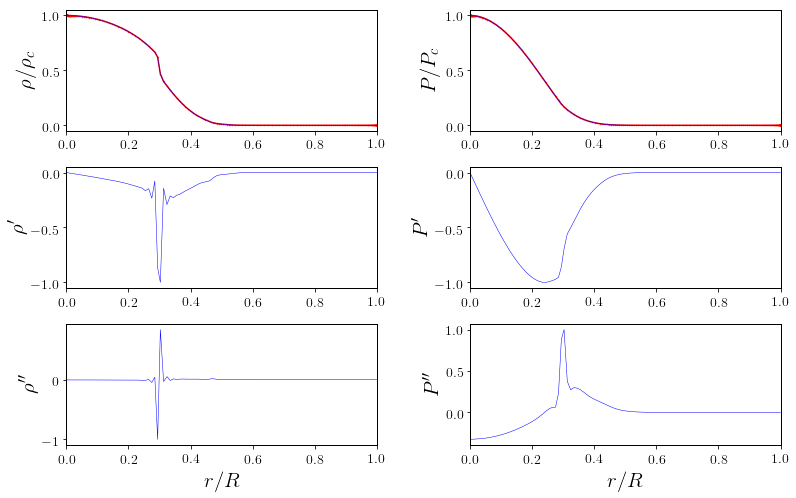

In [347]:
fig=plt.figure(figsize=[12.8,8])

plt.subplot(321)
plt.plot(wff3_145[-1]/wff3_145[-1][-1],wff3_145[2]/wff3_145[2][0],color='red',marker='o',markersize='0.4') 
plt.plot(wff3_145[-1]/wff3_145[-1][-1],wff3_145rho(wff3_145[-1])/wff3_145[2][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1) # leaving the crust out

plt.subplot(322)
plt.plot(wff3_145[-1]/wff3_145[-1][-1],wff3_145[1]/wff3_145[1][0],color='red',marker='o',markersize='0.4') 
plt.plot(wff3_145[-1]/wff3_145[-1][-1],wff3_145p(wff3_145[-1])/wff3_145[1][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$P/P_c$')
plt.xlim(0,1)

plt.subplot(323)
plt.plot(wff3_145[-1]/wff3_145[-1][-1],wff3_145drho(wff3_145[-1])/max(abs(wff3_145drho(wff3_145[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime}$')
plt.xlim(0,1)
#plt.ylim(-500,0)

plt.subplot(324)
plt.plot(wff3_145[-1]/wff3_145[-1][-1],wff3_145dp(wff3_145[-1])/max(abs(wff3_145dp(wff3_145[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime} $')
plt.xlim(0,1)

plt.subplot(325)
plt.plot(wff3_145[-1]/wff3_145[-1][-1],wff3_145ddrho(wff3_145[-1])/max(abs(wff3_145ddrho(wff3_145[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}$')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-0.01,0.01)

plt.subplot(326)
plt.plot(wff3_145[-1]/wff3_145[-1][-1],wff3_145ddp(wff3_145[-1])/max(abs(wff3_145ddp(wff3_145[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime\prime}$ ')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-1,1)

fig.subplots_adjust(hspace=0.3,wspace=0.3)

#plt.savefig('figures/ddswff3_145.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

### 15.0

In [348]:
wff3_150=np.loadtxt('results/wff3/15.0.dat',unpack=True)
wff3_150[3] = wff3_150[3]-wff3_150[3][-1] + 0.5*np.log(1-2*wff3_150[0][-1]/wff3_150[-1][-1])

In [349]:
s1=8e-6
s2=1e-15
wff3_150rho=interpolate.UnivariateSpline(wff3_150[-1], wff3_150[2], k=5, s=s1)
wff3_150drho=interpolate.UnivariateSpline(wff3_150[-1], wff3_150[2], k=5, s=s1).derivative(n=1)
wff3_150ddrho=interpolate.UnivariateSpline(wff3_150[-1], wff3_150[2], k=5, s=s1).derivative(n=2)

wff3_150p=interpolate.UnivariateSpline(wff3_150[-1], wff3_150[1], k=5, s=s2)
wff3_150dp=interpolate.UnivariateSpline(wff3_150[-1], wff3_150[1], k=5, s=s2).derivative(n=1)
wff3_150ddp=interpolate.UnivariateSpline(wff3_150[-1], wff3_150[1], k=5, s=s2).derivative(n=2)

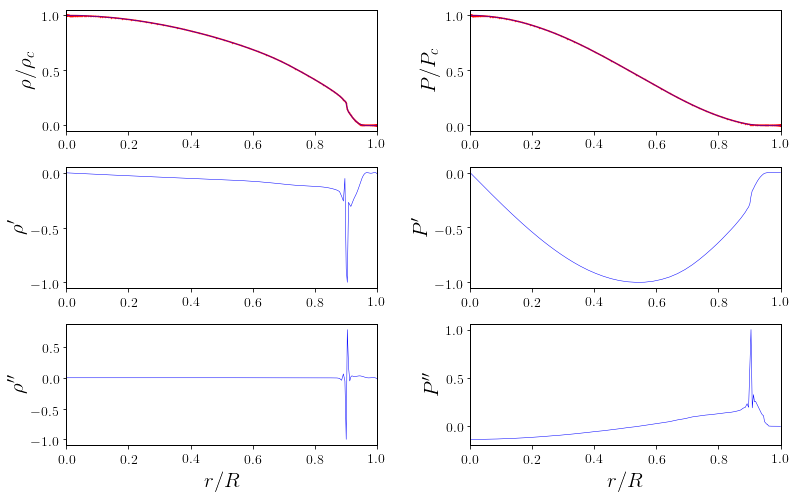

In [350]:
fig=plt.figure(figsize=[12.8,8])

plt.subplot(321)
plt.plot(wff3_150[-1]/wff3_150[-1][-1],wff3_150[2]/wff3_150[2][0],color='red',marker='o',markersize='0.4') 
plt.plot(wff3_150[-1]/wff3_150[-1][-1],wff3_150rho(wff3_150[-1])/wff3_150[2][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1) # leaving the crust out

plt.subplot(322)
plt.plot(wff3_150[-1]/wff3_150[-1][-1],wff3_150[1]/wff3_150[1][0],color='red',marker='o',markersize='0.4') 
plt.plot(wff3_150[-1]/wff3_150[-1][-1],wff3_150p(wff3_150[-1])/wff3_150[1][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$P/P_c$')
plt.xlim(0,1)

plt.subplot(323)
plt.plot(wff3_150[-1]/wff3_150[-1][-1],wff3_150drho(wff3_150[-1])/max(abs(wff3_150drho(wff3_150[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime}$')
plt.xlim(0,1)
#plt.ylim(-500,0)

plt.subplot(324)
plt.plot(wff3_150[-1]/wff3_150[-1][-1],wff3_150dp(wff3_150[-1])/max(abs(wff3_150dp(wff3_150[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime} $')
plt.xlim(0,1)

plt.subplot(325)
plt.plot(wff3_150[-1]/wff3_150[-1][-1],wff3_150ddrho(wff3_150[-1])/max(abs(wff3_150ddrho(wff3_150[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}$')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-0.01,0.01)

plt.subplot(326)
plt.plot(wff3_150[-1]/wff3_150[-1][-1],wff3_150ddp(wff3_150[-1])/max(abs(wff3_150ddp(wff3_150[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime\prime}$ ')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-1,1)

fig.subplots_adjust(hspace=0.3,wspace=0.3)

#plt.savefig('figures/ddswff3_150.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

### 15.5

In [351]:
wff3_155=np.loadtxt('results/wff3/15.5.dat',unpack=True)
wff3_155[3] = wff3_155[3]-wff3_155[3][-1] + 0.5*np.log(1-2*wff3_155[0][-1]/wff3_155[-1][-1])

In [352]:
s1=1e-5
s2=1e-9
wff3_155rho=interpolate.UnivariateSpline(wff3_155[-1], wff3_155[2], k=5, s=s1)
wff3_155drho=interpolate.UnivariateSpline(wff3_155[-1], wff3_155[2], k=5, s=s1).derivative(n=1)
wff3_155ddrho=interpolate.UnivariateSpline(wff3_155[-1], wff3_155[2], k=5, s=s1).derivative(n=2)

wff3_155p=interpolate.UnivariateSpline(wff3_155[-1], wff3_155[1], k=5, s=s2)
wff3_155dp=interpolate.UnivariateSpline(wff3_155[-1], wff3_155[1], k=5, s=s2).derivative(n=1)
wff3_155ddp=interpolate.UnivariateSpline(wff3_155[-1], wff3_155[1], k=5, s=s2).derivative(n=2)

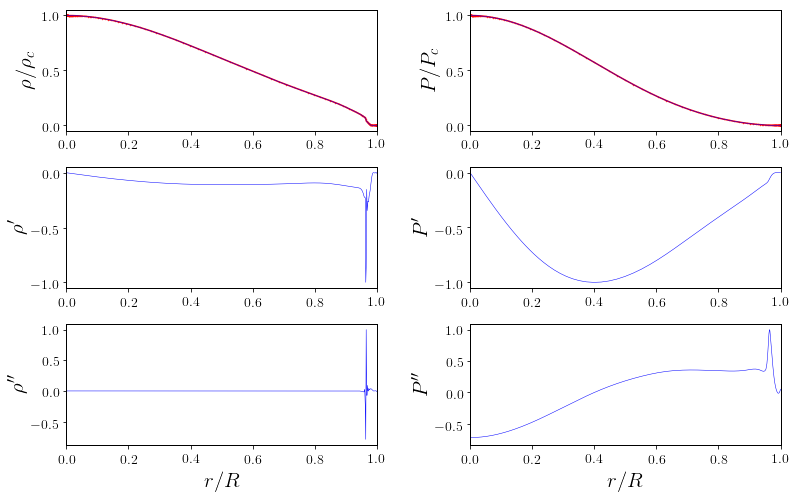

In [353]:
fig=plt.figure(figsize=[12.8,8])

plt.subplot(321)
plt.plot(wff3_155[-1]/wff3_155[-1][-1],wff3_155[2]/wff3_155[2][0],color='red',marker='o',markersize='0.4') 
plt.plot(wff3_155[-1]/wff3_155[-1][-1],wff3_155rho(wff3_155[-1])/wff3_155[2][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$\rho/\rho_c$')
plt.xlim(0,1) # leaving the crust out

plt.subplot(322)
plt.plot(wff3_155[-1]/wff3_155[-1][-1],wff3_155[1]/wff3_155[1][0],color='red',marker='o',markersize='0.4') 
plt.plot(wff3_155[-1]/wff3_155[-1][-1],wff3_155p(wff3_155[-1])/wff3_155[1][0],color='blue',linewidth='0.5') 
plt.ylabel(r'$P/P_c$')
plt.xlim(0,1)

plt.subplot(323)
plt.plot(wff3_155[-1]/wff3_155[-1][-1],wff3_155drho(wff3_155[-1])/max(abs(wff3_155drho(wff3_155[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime}$')
plt.xlim(0,1)
#plt.ylim(-500,0)

plt.subplot(324)
plt.plot(wff3_155[-1]/wff3_155[-1][-1],wff3_155dp(wff3_155[-1])/max(abs(wff3_155dp(wff3_155[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime} $')
plt.xlim(0,1)

plt.subplot(325)
plt.plot(wff3_155[-1]/wff3_155[-1][-1],wff3_155ddrho(wff3_155[-1])/max(abs(wff3_155ddrho(wff3_155[-1]))),'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}$')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-0.01,0.01)

plt.subplot(326)
plt.plot(wff3_155[-1]/wff3_155[-1][-1],wff3_155ddp(wff3_155[-1])/max(abs(wff3_155ddp(wff3_155[-1]))),'b-', linewidth=0.5)
plt.ylabel(r'$P^{\prime\prime}$ ')
plt.xlabel(r'$r/R$')
plt.xlim(0,1)
#plt.ylim(-1,1)

fig.subplots_adjust(hspace=0.3,wspace=0.3)

#plt.savefig('figures/ddswff3_155.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

## Redshift

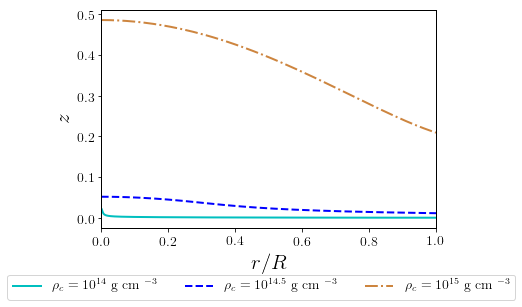

In [354]:
fig = plt.figure()

plt.plot(wff3_140[-1]/wff3_140[-1][-1],np.exp(-wff3_140[3])-1.0,color='c',linewidth='2.0',label=r'$\rho_c=10^{14}$ g cm $^{-3}$')
plt.plot(wff3_145[-1]/wff3_145[-1][-1],np.exp(-wff3_145[3])-1.0,color='blue',linewidth='2.0',linestyle='--',label=r'$\rho_c=10^{14.5}$ g cm $^{-3}$')
plt.plot(wff3_150[-1]/wff3_150[-1][-1],np.exp(-wff3_150[3])-1.0,color='peru',linewidth='2.0',linestyle='-.',label=r'$\rho_c=10^{15}$ g cm $^{-3}$')

l = plt.legend(bbox_to_anchor=(1.1,-0.15), loc="lower right", 
                bbox_transform=fig.transFigure, ncol=3)

plt.xlabel(r'$r/R$')
plt.ylabel(r'$z$')
plt.xlim(0,1.0)

plt.savefig('figures/Redshiftwff3.pdf', format='pdf', dpi=1000,bbox_inches="tight")